<a href="https://colab.research.google.com/github/akharroubi/Point-clouds-classification-and-integration-in-VR-environment/blob/master/Copie_de_PointNet_for_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#[1] import and installations
!pip install torchnet
!pip install PyDrive
!pip install mock
import torch
import numpy as np
from google.colab import files
import h5py
import torchnet as tnt
import functools
import mock
import math
import copy
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as nnf
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
#[2] Authentification
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#[2] Authentification
downloaded = drive.CreateFile({'id':"1Gk2qvmtRzqE17bHP-dUQVWowLn6G2eXW"})
downloaded.GetContentFile('train_data.h5') 
downloaded = drive.CreateFile({'id':"1iRjdWqZ97kyBLJCC6iSLTcbmiC0LTVvP"})
downloaded.GetContentFile('test_data.h5')


In [ ]:
#[4] building the train and test sets
test_file = h5py.File("test_data.h5",'r')
train_file = h5py.File("train_data.h5",'r')

test_list = []
for grp in test_file.keys():
  for subgrp in test_file[grp].keys():
    test_list.append(grp + "/" + subgrp)
       
train_list = []
for grp in train_file.keys():
  for subgrp in train_file[grp].keys():
    train_list.append(grp + "/" + subgrp)

#select 20 % of training data for validation    
valid_index = np.random.choice(len(train_list),int(len(train_list)/5), replace=False)
valid_list = [train_list[i] for i in valid_index]
train_list = [train_list[i] for i in np.setdiff1d(list(range(len(train_list))),valid_index)]
print("%d tiles in train set, %d tiles in test set, %d files in valid list" % (len(train_list), len(test_list), len(valid_list)))

class_names = ["ground", "vegetation", "building"]

720 tiles in train set, 100 tiles in test set, 180 files in valid list


In [ ]:
#[4] data loader

def augment(cloud_data):
  """the augmentation function - leave untouched for now"""
  #random rotation around the Z axis
  angle = random.uniform(0, 2*math.pi)
  M = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
  cloud_data[:2] = np.dot(cloud_data[:2].T, M).T

  #random gaussian noise
  sigma, clip= 0.01, 0.03 # https://github.com/charlesq34/pointnet/blob/master/provider.py#L74
  cloud_data[:4] = cloud_data[:4] + np.clip(sigma * np.random.randn(*cloud_data[:4].shape), -1*clip, clip).astype(np.float32)
  return cloud_data


def cloud_loader(tile_name, train, cuda = 1):
  """
  load a tile and returns points features (normalized xyz + intensity) and 
  ground truth
  INPUT:
  tile_name = string, name of the tile
  train = int, train = 1 iff in the train set
  OUTPUT
  cloud_data, [n x 4] float array containing points coordinates and intensity
  labels, [n] long int array, containing the points semantic labels  
  """
  if train:
    cloud_data = train_file[tile_name]["data"].value.transpose()
  else:
    cloud_data = test_file[tile_name]["data"].value.transpose()
    
  gt = cloud_data[-1]
  gt[np.where(gt>3)] = 0
  
  if train:
    cloud_data = augment(cloud_data)
    
  cloud_data = torch.from_numpy(cloud_data[0:4])
  gt = torch.from_numpy(gt).long()
  
  if cuda:
    cloud_data = cloud_data.cuda()
    
  xmean, ymean = cloud_data.mean(1)[0:2]
  zmin = cloud_data.min(1)[0][2]
  
  #normalizing on the unit cube
  cloud_data[0] = (cloud_data[0] - xmean) #x
  cloud_data[1] = (cloud_data[1] - ymean) #y
  cloud_data[2] = (cloud_data[2] - zmin) #z
  cloud_data[3] = (cloud_data[3] - 50) / 20 #intensity - heuristic normalization
  
  return cloud_data, gt

def cloud_collate(batch):
    """ Collates a list of dataset samples into a batch list for clouds 
    and a single array for labels and
    """
    clouds, labels = list(zip(*batch))
    labels = torch.cat(labels, 0)
    return clouds, labels

test_set  = tnt.dataset.ListDataset(test_list,functools.partial(cloud_loader, train=False))
train_set = tnt.dataset.ListDataset(train_list,functools.partial(cloud_loader, train=True))
valid_set = tnt.dataset.ListDataset(valid_list,functools.partial(cloud_loader, train=True))

**Why are we centering with the mean for x- and y coordinates but with the minimum for the z-coordinates?**

x and y: we want the network to learn point distribution in a unit cube in order to capture relative positions of objects, hence we center x and y. This way, ourprediction is invariant by translation in the xy axis. If we didn't, we would be asking the network to learn the entire set instead of learn to reasoning on a small window.
Furthermore, always center your absolute GIS position to avoid overflow.

z: we are interested in the height of object **with respect to the ground*. The ground height can be approximated with the lower point in the tile.

Limitations: sensitive to noise, a 9th decile approach would be more robust. Won't work on sloped terrain, could use a simple plane model to better approximate the ground height.

In [ ]:
#[5] functions used for visualization
def view_intensity(cloud, ax = None):
  """ plot the point cloud 'cloud' in figure ax with a colorcode
  corresponding to its intensity"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.auto_scale_xyz
  ax.scatter3D(cloud[0,:], cloud[1,:], cloud[2,:], c=cloud[3,:], s=2 \
               , cmap='hot', vmin=0, vmax=10)

def view_labels(cloud, labels, ax = None):
  """ plot the point cloud 'cloud' in figure ax with a colorcode
  corresponding to 'labels'"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d', aspect='equal')
  n_points = cloud.shape[1]
  colors = np.zeros((n_points,3))
  colors[np.where(labels.numpy()==1)] = [0.5,0.5,0.5] #ground
  colors[np.where(labels.numpy()==2)] = [0  ,0.6  ,0] #vegetation
  colors[np.where(labels.numpy()==3)] = [0  ,1  ,1] #building
  ax.auto_scale_xyz
  ax.scatter3D(cloud[0,:], cloud[1,:], cloud[2,:], c=colors, s=2)  
  
def view_error(cloud, pred, gt, ax = None):
  """ plot the point cloud 'cloud' in figure ax with a colorcode
  corresponding to green when 'gt'='pred', red when 'gt'!='pred' and black
  when the point in unnannotated (gt = 0)"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.auto_scale_xyz
  n_points = cloud.shape[1]
  colors = np.zeros((n_points,3))
  colors[np.where(pred==gt)] = [0, 1, 0] #correct prediction
  colors[np.where(pred!=gt)] = [1, 0, 0] #error
  colors[np.where(gt==0)] = [0, 0, 0]   #unannotated
  
  ax.scatter3D(cloud[0,:], cloud[1,:], cloud[2,:], c=colors, s=2);
  
def view_testset(n_shown = 3, category = 'igpe', model = None, PCC = None):
  """ plot 'n_shown' point clouds from the test set with the following color
  codes:
  if 'i' in category : intensity
  if 'g' in category : ground truth
  if 'p' in category : prediction
  if 'e' in category : error
  Note that for 'p' or 'e' ou need to add a trained model as input
  
  """
  n_category = len(category)
  fig = plt.figure(figsize=(n_category * 7, n_shown * 7))
  
  index_image = 1
  for test_cloud in random.sample(test_list,n_shown):
    
    cloud, gt = cloud_loader(test_cloud, 0, cuda=0)
    
    if 'p' in category or 'e' in category:
      pred = PCC.run(model, [cloud])
    
    if 'i' in category:
      ax = fig.add_subplot(n_shown, n_category, index_image, projection='3d')
      ax.auto_scale_xyz
      plt.xticks([], [])
      plt.yticks([], [])
      if index_image <= n_category : 
        ax.set(title='Intensity')
      view_intensity(cloud, ax = ax)
      index_image += 1
    if 'g' in category:  
      ax = fig.add_subplot(n_shown, n_category, index_image, projection='3d')
      ax.auto_scale_xyz
      plt.xticks([], [])
      plt.yticks([], [])
      if index_image <= n_category : 
        ax.set(title='Ground Truth')
      view_labels(cloud, gt, ax = ax)
      index_image += 1
    if 'p' in category: 
      ax = fig.add_subplot(n_shown, n_category, index_image, projection='3d')
      ax.auto_scale_xyz
      plt.xticks([], [])
      plt.yticks([], [])
      if index_image <= n_category :
        ax.set(title='Prediction')
      view_labels(cloud, pred.argmax(1).cpu()+1, ax = ax)
      index_image += 1
    if 'e' in category: 
      ax = fig.add_subplot(n_shown, n_category, index_image, projection='3d')
      ax.auto_scale_xyz
      plt.xticks([], [])
      plt.yticks([], [])
      if index_image <= n_category : 
        ax.set(title='error')
      view_error(cloud, pred.argmax(1).cpu()+1, gt, ax = ax)
      index_image += 1
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


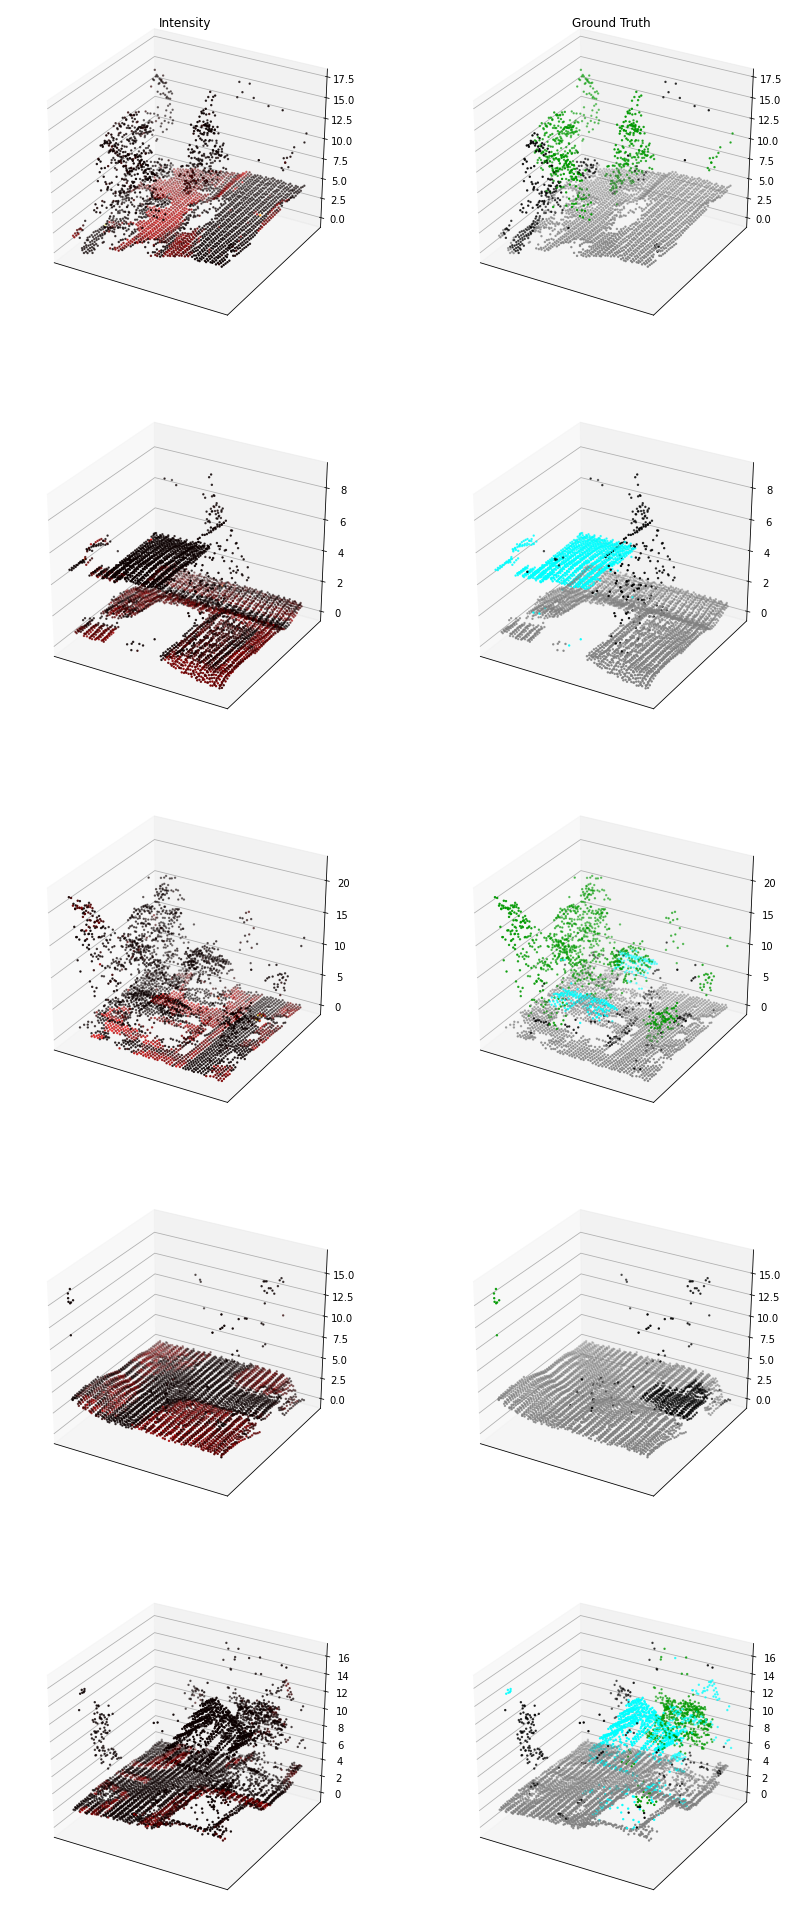

In [ ]:
#[6]
view_testset(n_shown = 5, category = 'ig')

In [ ]:
#[7]
class PointNet(nn.Module):
  """
  The PointNet network for semantic segmentation
  """
  
  def __init__(self, MLP_1, MLP_2, MLP_3, n_class = 3, input_feat=4, subsample_size = 512, cuda = 1):
    """
    initialization function
    MLP_1, LMP2 and MLP3 = int array, size of the the layers of the the MLPs
    n_class = int,  the number of class
    input_feat = int, number of input feature
    subsample_size = int, number of points to which the tiles are subsampled
    
    """
    
    super(PointNet, self).__init__() #necessary for all classes extending the module class
    
    self.subsample_size = subsample_size
    
    m1 = MLP_1[-1] #size of the first embeding F1
    m2 = MLP_2[-1] #size of the second embeding F2
    
    modules = []
    for i in range(len(MLP_1)):
      modules.append(nn.Conv1d(MLP_1[i-1] if i>0 else input_feat, MLP_1[i], 1))
      modules.append(nn.BatchNorm1d(MLP_1[i]))
      modules.append(nn.ReLU(True))
    self.MLP_1 = nn.Sequential(*modules)

    modules = []
    for i in range(len(MLP_2)):
      modules.append(nn.Conv1d(MLP_2[i-1] if i>0 else m1, MLP_2[i], 1))
      modules.append(nn.BatchNorm1d(MLP_2[i]))
      modules.append(nn.ReLU(True))
    self.MLP_2 = nn.Sequential(*modules)

    modules = []
    for i in range(len(MLP_3)):
      modules.append(nn.Conv1d(MLP_3[i-1] if i>0 else m1 + m2, MLP_3[i], 1))
      modules.append(nn.BatchNorm1d(MLP_3[i]))
      modules.append(nn.ReLU(True))
      
    modules.append(nn.Dropout(0.3))
    modules.append(nn.Conv1d(MLP_3[-1], n_class,1))
    self.MLP_3 = nn.Sequential(*modules)
    
    self.maxpool = nn.MaxPool1d(subsample_size)
    
    
    
    if cuda:
      self = self.cuda()
    
  def forward(self, input):
    """
    the forward function producing the embeddings for each point of 'input'
    input = [n_batch, input_feat, subsample_size] float array: input features
    output = [n_batch,n_class, subsample_size] float array: point class logits
    """
    #embed points, equation (1)
    embed = self.MLP_1(input) 
    #process embeddings and maxpool, equation (2) and (3)
    global_embed = self.maxpool(self.MLP_2(embed))
    #concatenate f1 and G and perform equation(4)
    class_scores = self.MLP_3(torch.cat((global_embed.repeat(1,1,self.subsample_size), embed),1))
    #avoid wasting by not using intermediary variables
    return class_scores

#==================TEST===============================
#we consider the first point cloud from the training set
cloud_data, gt = cloud_loader(train_list[0], 1, cuda = 1)
#to create a proper input for the pointnet we need to we add one empty dimension
#for the batch size (with keyword None), and subsample the point cloud to have
#subsample_size = 512 points
cloud_data = cloud_data[None,:,:512] 
#we now create a pointnet model:
ptn = PointNet([32,32], [32,64,256], [128,64,32], n_class = 3, input_feat=4, subsample_size = 512)
print(ptn)
#we now test that the code works correctly
pred = ptn.forward(cloud_data)
#we now check that the size is indeed [n_batch,n_class, subsample_size]
assert(pred.shape == torch.Size([1,3,512]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


PointNet(
  (MLP_1): Sequential(
    (0): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (MLP_2): Sequential(
    (0): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (MLP_3): Sequential(
    (0): Conv1d(288, 128, kernel_size=(1,), stride=(

In [ ]:
#[8]
class PointCloudClassifier:
  """
  The main point cloud classifier Class
  """
  def __init__(self, args):
    self.subsample_size = args.subsample_size
    self.n_input_feats = 3
    if 'i' in args.input_feats: #add intensity
      self.n_input_feats += 1
    self.n_class = args.n_class
    self.cuda = args.cuda
  
  def run(self, model, clouds):
    """
    INPUT:
    model = the neural network
    clouds = list of n bacthges array of size [n_feat, n_points_i] float arrays: batch of point clouds
    OUTPUT:
    pred = [sum_i n_points_i,n_class] float arrays : prediction for each element of the 
         batch in a single array
    
    """
    
    #will contain the prediction for all elements in the batch
    batch_pred   = torch.zeros((self.n_class,0))
    
    #will contain all the features for the clouds in batch subsampled to the same size
    batch_data = torch.Tensor((len(clouds)), self.n_input_feats, self.subsample_size)
    if self.cuda:
      batch_data = batch_data.cuda()
      batch_pred = batch_pred.cuda()
    
    for i_elem in range(len(clouds)):
      #load the elements in the batch one by one and subsample/ oversample them
      #to self.subsample_size points
            
      elem_data = clouds[i_elem][:int(self.n_input_feats),:]
      
      n_points = elem_data.shape[1]      

      selected_points = np.random.choice(n_points, self.subsample_size, replace = True)
      elem_data = elem_data[:,selected_points]
        
      batch_data[i_elem,:,:] = elem_data.clone()
    
    prediction = model.ptn(batch_data) #process the 
    
    for i_elem in range(len(clouds)):
      
      elem_data = clouds[i_elem]
      elem_data_selected = batch_data[i_elem,:3,:]      
            
      n_points = elem_data.shape[1]
      
      #we need to interpolate the prediction to the entire point cloud)
      nn = NearestNeighbors(1, algorithm='kd_tree').fit( \
             elem_data_selected.cpu().permute(1,0))
      dump, closest_point = nn.kneighbors(elem_data[:3,:].permute(1,0).cpu())
      closest_point = closest_point.squeeze()
        
      #print(prediction.shape)
      #print(closest_point.shape)
      #print(prediction[i_elem, :, closest_point].shape)
      pred = prediction[i_elem, :, closest_point]
    
      batch_pred = torch.cat((batch_pred, pred),1)
      print(batch_pred.shape)
      #batch_labels = torch.cat((batch_labels, elem_data[-1,:]))
    return batch_pred.permute(1,0)

#==================TEST===============================
#we consider the first point cloud from the training set
cloud1= cloud_loader(train_list[0], 1, cuda = 1)
cloud2 = cloud_loader(train_list[1], 1, cuda = 1)
#we artifically decrease the number of points in cloud2 in order to test both 
#subample and oversample cases
cloud2 = (cloud2[0][:,:200], cloud2[1][:200])
print("Loading two clouds with %d  and %d points respectively" \
      % (cloud1[0].shape[1], cloud2[0].shape[1]))
#we use the collate function to batch the two clouds
batch_clouds, gt = cloud_collate((cloud1, cloud2))

#we create a parameter structure to parameterize a classifier
args = mock.Mock()
args.n_class = 3
args.input_feats = 'xyzi'
args.subsample_size = 512
#we create an instace of PointCloudClassifier
PCC = PointCloudClassifier(args)
#we create a model
model = nn.Module()
model.ptn = PointNet([32,32], [32,64,256], [128,64,32], n_class = 3, \
                     input_feat=4, subsample_size = 512, cuda = 1)
#we now launch the prediction:
pred = PCC.run(model, batch_clouds)
#we check that the size of the prediction is indeed [sum_i n_points_i,n_class]
assert(pred.shape == torch.Size((cloud1[0].shape[1] + cloud2[0].shape[1],3)))

Loading two clouds with 5149  and 200 points respectively
torch.Size([3, 5149])
torch.Size([3, 5349])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [ ]:
#[9]
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class))
    self.n_class = n_class
    self.class_names = class_names
  
  def clear(self):
    self.CM = np.zeros((self.n_class, self.n_class))
    
  def add_batch(self, gt, pred):
    self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))
    
  def overall_accuracy(self):#percentage of correct classification
    return 100*self.CM.trace() / self.CM.sum()

  def class_IoU(self, show = 1):
    ious = np.full(self.n_class, 0.)
    for i_class in range(self.n_class):
      ious[i_class] = self.CM[i_class, i_class] / \
        (-self.CM[i_class, i_class] \
        + self.CM[i_class, :].sum()
        + self.CM[:, i_class].sum())
    if show:
      print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [ ]:
#[10]
m = ConfusionMatrix(3, class_names)
m.add_batch(np.array([0,1,1,1,2,0,0]), np.array([0,1,1,1,2,0,0]))
m.add_batch(np.array([0,1,1,1,2,1,0]), np.array([0,0,1,1,0,0,0]))
print(m.CM)
print("OA = %3.2f%%" % (m.overall_accuracy()))
m.class_IoU()
m.clear()

[[5. 0. 0.]
 [2. 5. 0.]
 [1. 0. 1.]]
OA = 78.57%
ground : 62.50%  |  vegetation : 71.43%  |  building : 50.00%


**Explain why we need to only select the points in labeled in the loss function.**

Some points were not annotated in th grond truth. They could be any of the three classes, we just do not know how to penalize or reward a prediction on such point. We just remove them from the supervision altogether. Hence, the value predicted ofor these points does not impact the network.

In [ ]:
#[11]
def train(model, PCC, optimizer, args):
  """train for one epoch"""
  model.train()
  
  #the loader function will take care of the batching
  loader = torch.utils.data.DataLoader(train_set, collate_fn=cloud_collate, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  #tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=500)
  
  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for ind_batc, (cloud, gt) in enumerate(loader):
    
    optimizer.zero_grad() #put gradient to zero
    
    pred = PCC.run(model, cloud) #compute the prediction

    labeled = gt!=0 #remove the unlabelled points from the supervision
    if labeled.sum() == 0:
      continue #no labeled points, skip
    
    loss = nn.functional.cross_entropy(pred[labeled].cpu(), gt[labeled]-1, weight=torch.Tensor(args.class_weight)) 

    loss.backward() #compute gradients
    
    for p in model.parameters(): #we clip the gradient at norm 1
      p.grad.data.clamp_(-1, 1)
    
    optimizer.step() #one SGD step
    
    loss_meter.add(loss.item())
    cm.add_batch(gt[labeled]-1, pred[labeled].argmax(1).cpu().detach().numpy())
  return cm, loss_meter.value()[0]



def eval(model, PCC, args, test = True):
  """eval on test/validation set"""
  
  model.eval()
  
  if test:
    loader = torch.utils.data.DataLoader(test_set, collate_fn=cloud_collate, batch_size=args.batch_size, shuffle=False)
  else:
    loader = torch.utils.data.DataLoader(valid_set, collate_fn=cloud_collate, batch_size=60, shuffle=False, drop_last=False)
  
  loader = tqdm(loader, ncols=500)
  
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for ind_batc, (cloud, gt) in enumerate(loader):
    
    avg_pred = torch.zeros(len(gt), args.n_class, device = cloud[0].device)
    
    for i in range(args.n_votes_eval):
      #we average the class cores over n_votes_eval runs
      avg_pred += PCC.run(model, cloud)  
    
    avg_pred = avg_pred / args.n_votes_eval
    
    labeled = gt!=0 #we remove the unlabelled points from the supervision
    if labeled.sum() == 0:
      continue #no labeled points, skip
    
    loss = nn.functional.cross_entropy(avg_pred[labeled].cpu(), gt[labeled]-1, weight=torch.Tensor(args.class_weight)) 
    
    loss_meter.add(loss.item())
    cm.add_batch(gt[labeled]-1, avg_pred[labeled].argmax(1).cpu().detach().numpy())
  return cm, loss_meter.value()[0]



def train_full(args):
  """The full training loop"""
  #initialize the model
  model = nn.Module()
  model.ptn = PointNet(args.MLP_1, args.MLP_2, args.MLP_3, args.n_class, input_feat=args.n_input_feats, subsample_size = args.subsample_size)

  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  print(model)
  
  best_model = 0
  best_loss = 1000

  #define the classifier
  PCC = PointCloudClassifier(args)
  
  #define the optimizer
  #adam optimizer is always a good guess for classification
  optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
  #adding a scheduler for adaptive learning rate. at each milestone lr_steps 
  #the learning rate is multiplied by lr_decay
  scheduler = MultiStepLR(optimizer, milestones=args.lr_steps, gamma=args.lr_decay)
  
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  VALIDCOLOR = '\033[45m'
  NORMALCOLOR = '\033[0m'
  
  for i_epoch in range(args.n_epoch):
    #train one epoch
    scheduler.step() #update the scheduler
    cm_train, loss_train = train(model, PCC, optimizer, args)
    print(TRAINCOLOR)
    mIoU = cm_train.class_IoU()
    print('Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), mIoU, loss_train) + NORMALCOLOR)

    cm_valid, loss_valid = eval(model, PCC, args, test=False)
    best_valid = False
    
    if loss_valid < best_loss:
      best_valid = True
      best_loss = loss_valid
      print(VALIDCOLOR)
      mIoU = cm_valid.class_IoU()
      best_model = copy.deepcopy(model)
      print('-> Best performance achieved: Overall Accuracy: %3.2f%% valid mIoU : %3.2f%% valid Loss: %1.4f' % (cm_valid.overall_accuracy(), mIoU, loss_valid) + NORMALCOLOR)

    if i_epoch % args.n_epoch_test == 0 and (best_valid or  i_epoch == args.n_epoch - 1):
      #periodic testing
      cm_test, loss_test = eval(best_model, PCC, args)
      print(TESTCOLOR)
      mIoU = cm_test.class_IoU()
      print('Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), mIoU, loss_test) + NORMALCOLOR)
      
  return best_model, PCC

In [ ]:
#[12]
args = mock.Mock()
args.n_epoch = 50
args.n_epoch_test = int(1)
args.batch_size = 16
args.n_class = 3
args.input_feats = 'xyzi'
args.n_input_feats = 4
args.MLP_1 = [32,32]
args.MLP_2 = [32,64,256]
args.MLP_3 = [128,64,32]
args.subsample_size = 256
args.cuda = 1
args.lr = 5e-3
args.wd = 0
args.n_votes_eval = 5
args.lr_steps = [20,35,45]
args.lr_decay = 0.7
args.class_weight = [0.2,0.3,0.5]

trained_model, PCC = train_full(args)

Total number of parameters: 69731
Module(
  (ptn): PointNet(
    (MLP_1): Sequential(
      (0): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (MLP_2): Sequential(
      (0): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplac

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 6192])
torch.Size([3, 10109])
torch.Size([3, 14076])
torch.Size([3, 17464])
torch.Size([3, 20601])
torch.Size([3, 27103])
torch.Size([3, 32542])
torch.Size([3, 38260])
torch.Size([3, 38610])
torch.Size([3, 44300])
torch.Size([3, 51447])
torch.Size([3, 56332])
torch.Size([3, 62005])
torch.Size([3, 65491])
torch.Size([3, 68315])
torch.Size([3, 73386])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6505])
torch.Size([3, 10833])
torch.Size([3, 19757])
torch.Size([3, 23895])
torch.Size([3, 30352])
torch.Size([3, 32862])
torch.Size([3, 38520])
torch.Size([3, 45152])
torch.Size([3, 49636])
torch.Size([3, 58141])
torch.Size([3, 63333])
torch.Size([3, 66222])
torch.Size([3, 69065])
torch.Size([3, 74819])
torch.Size([3, 76355])
torch.Size([3, 84437])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2604])
torch.Size([3, 10128])
torch.Size([3, 15200])
torch.Size([3, 17866])
torch.Size([3, 20325])
torch.Size([3, 25808])
torch.Size([3, 30872])
torch.Size([3, 35797])
torch.Size([3, 40914])
torch.Size([3, 45847])
torch.Size([3, 50176])
torch.Size([3, 53504])
torch.Size([3, 57121])
torch.Size([3, 60487])
torch.Size([3, 63705])
torch.Size([3, 68276])
torch.Size([3, 6829])
torch.Size([3, 14041])
torch.Size([3, 17414])
torch.Size([3, 23491])
torch.Size([3, 27867])
torch.Size([3, 30597])
torch.Size([3, 39106])
torch.Size([3, 44049])
torch.Size([3, 46823])
torch.Size([3, 53833])
torch.Size([3, 55719])
torch.Size([3, 62298])
torch.Size([3, 67965])
torch.Size([3, 75308])
torch.Size([3, 80516])
torch.Size([3, 83906])
torch.Size([3, 5854])
torch.Size([3, 11924])
torch.Size([3, 14327])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16855])
torch.Size([3, 20267])
torch.Size([3, 22812])
torch.Size([3, 27688])
torch.Size([3, 30795])
torch.Size([3, 36797])
torch.Size([3, 40008])
torch.Size([3, 46379])
torch.Size([3, 49719])
torch.Size([3, 54634])
torch.Size([3, 59805])
torch.Size([3, 63256])
torch.Size([3, 66956])
torch.Size([3, 2541])
torch.Size([3, 7915])
torch.Size([3, 11528])
torch.Size([3, 15080])
torch.Size([3, 18095])
torch.Size([3, 22975])
torch.Size([3, 28795])
torch.Size([3, 34546])
torch.Size([3, 43627])
torch.Size([3, 50693])
torch.Size([3, 53994])
torch.Size([3, 58217])
torch.Size([3, 64043])
torch.Size([3, 70787])
torch.Size([3, 75226])
torch.Size([3, 80478])
torch.Size([3, 6737])
torch.Size([3, 12929])
torch.Size([3, 19141])
torch.Size([3, 26174])
torch.Size([3, 30239])
torch.Size([3, 33051])
torch.Size([3, 36284])
torch.Size([3, 38981])
torch.Size([3, 41544])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46127])
torch.Size([3, 55967])
torch.Size([3, 56378])
torch.Size([3, 59369])
torch.Size([3, 62032])
torch.Size([3, 64535])
torch.Size([3, 67863])
torch.Size([3, 3662])
torch.Size([3, 6363])
torch.Size([3, 13622])
torch.Size([3, 17901])
torch.Size([3, 23238])
torch.Size([3, 25852])
torch.Size([3, 30591])
torch.Size([3, 37621])
torch.Size([3, 42442])
torch.Size([3, 47192])
torch.Size([3, 50209])
torch.Size([3, 53236])
torch.Size([3, 59721])
torch.Size([3, 62574])
torch.Size([3, 65083])
torch.Size([3, 69046])
torch.Size([3, 6088])
torch.Size([3, 9306])
torch.Size([3, 16260])
torch.Size([3, 20414])
torch.Size([3, 23187])
torch.Size([3, 26642])
torch.Size([3, 31427])
torch.Size([3, 34295])
torch.Size([3, 41197])
torch.Size([3, 49981])
torch.Size([3, 53799])
torch.Size([3, 60625])
torch.Size([3, 64064])
torch.Size([3, 70031])
torch.Size([3, 72838])
torch.Size([3, 75473])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4225])
torch.Size([3, 10456])
torch.Size([3, 15883])
torch.Size([3, 21371])
torch.Size([3, 25324])
torch.Size([3, 29770])
torch.Size([3, 32926])
torch.Size([3, 36104])
torch.Size([3, 41053])
torch.Size([3, 46415])
torch.Size([3, 52810])
torch.Size([3, 57333])
torch.Size([3, 60597])
torch.Size([3, 63114])
torch.Size([3, 68143])
torch.Size([3, 75963])
torch.Size([3, 4483])
torch.Size([3, 10149])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15295])
torch.Size([3, 19096])
torch.Size([3, 21853])
torch.Size([3, 24249])
torch.Size([3, 26677])
torch.Size([3, 33155])
torch.Size([3, 40159])
torch.Size([3, 45986])
torch.Size([3, 51363])
torch.Size([3, 54290])
torch.Size([3, 56790])
torch.Size([3, 62429])
torch.Size([3, 67834])
torch.Size([3, 75070])
torch.Size([3, 5507])
torch.Size([3, 8119])
torch.Size([3, 13863])
torch.Size([3, 18354])
torch.Size([3, 18933])
torch.Size([3, 22888])
torch.Size([3, 27501])
torch.Size([3, 30752])
torch.Size([3, 33478])
torch.Size([3, 39698])
torch.Size([3, 47311])
torch.Size([3, 53799])
torch.Size([3, 58334])
torch.Size([3, 58548])
torch.Size([3, 61232])
torch.Size([3, 67035])
torch.Size([3, 8492])
torch.Size([3, 15254])
torch.Size([3, 21305])
torch.Size([3, 24425])
torch.Size([3, 28967])
torch.Size([3, 34315])
torch.Size([3, 40042])
torch.Size([3, 48254])
torch.Size([3, 53358])
torch.Size([3, 59045])
torch.Size([3, 63870])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67181])
torch.Size([3, 72715])
torch.Size([3, 77982])
torch.Size([3, 83221])
torch.Size([3, 89789])
torch.Size([3, 5627])
torch.Size([3, 8487])
torch.Size([3, 14283])
torch.Size([3, 18849])
torch.Size([3, 23631])
torch.Size([3, 30709])
torch.Size([3, 33462])
torch.Size([3, 37661])
torch.Size([3, 42365])
torch.Size([3, 48844])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54332])
torch.Size([3, 57492])
torch.Size([3, 63942])
torch.Size([3, 67435])
torch.Size([3, 74914])
torch.Size([3, 79856])
torch.Size([3, 2914])
torch.Size([3, 9104])
torch.Size([3, 11927])
torch.Size([3, 15384])
torch.Size([3, 18040])
torch.Size([3, 26088])
torch.Size([3, 31283])
torch.Size([3, 33752])
torch.Size([3, 38938])
torch.Size([3, 41663])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49387])
torch.Size([3, 55524])
torch.Size([3, 63907])
torch.Size([3, 69177])
torch.Size([3, 71812])
torch.Size([3, 77111])
torch.Size([3, 6543])
torch.Size([3, 11729])
torch.Size([3, 15413])
torch.Size([3, 21279])
torch.Size([3, 29222])
torch.Size([3, 33380])
torch.Size([3, 38895])
torch.Size([3, 43966])
torch.Size([3, 46553])
torch.Size([3, 55429])
torch.Size([3, 59935])
torch.Size([3, 67925])
torch.Size([3, 70659])
torch.Size([3, 73643])
torch.Size([3, 76753])
torch.Size([3, 79916])
torch.Size([3, 5093])
torch.Size([3, 10581])
torch.Size([3, 15554])
torch.Size([3, 21656])
torch.Size([3, 24721])
torch.Size([3, 31718])
torch.Size([3, 36928])
torch.Size([3, 41897])
torch.Size([3, 47076])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52954])
torch.Size([3, 58087])
torch.Size([3, 61702])
torch.Size([3, 64953])
torch.Size([3, 68474])
torch.Size([3, 72497])
torch.Size([3, 77406])
torch.Size([3, 5191])
torch.Size([3, 10365])
torch.Size([3, 16356])
torch.Size([3, 22369])
torch.Size([3, 25322])
torch.Size([3, 32142])
torch.Size([3, 37086])
torch.Size([3, 43045])
torch.Size([3, 48362])
torch.Size([3, 53134])
torch.Size([3, 57387])
torch.Size([3, 60587])
torch.Size([3, 64039])
torch.Size([3, 66547])
torch.Size([3, 72706])
torch.Size([3, 75000])
torch.Size([3, 5998])
torch.Size([3, 8995])
torch.Size([3, 12555])
torch.Size([3, 18400])
torch.Size([3, 25689])
torch.Size([3, 30504])
torch.Size([3, 35032])
torch.Size([3, 40520])
torch.Size([3, 46872])
torch.Size([3, 52698])
torch.Size([3, 56335])
torch.Size([3, 58621])
torch.Size([3, 60992])
torch.Size([3, 65935])
torch.Size([3, 68708])
torch.Size([3, 75685])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3340])
torch.Size([3, 8247])
torch.Size([3, 13886])
torch.Size([3, 21539])
torch.Size([3, 26734])
torch.Size([3, 29439])
torch.Size([3, 35406])
torch.Size([3, 38282])
torch.Size([3, 42580])
torch.Size([3, 49372])
torch.Size([3, 56343])
torch.Size([3, 62985])
torch.Size([3, 65903])
torch.Size([3, 68944])
torch.Size([3, 72575])
torch.Size([3, 75081])
torch.Size([3, 2937])
torch.Size([3, 9133])
torch.Size([3, 15784])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21047])
torch.Size([3, 24450])
torch.Size([3, 29707])
torch.Size([3, 33594])
torch.Size([3, 37203])
torch.Size([3, 43961])
torch.Size([3, 49794])
torch.Size([3, 53576])
torch.Size([3, 59547])
torch.Size([3, 63825])
torch.Size([3, 70015])
torch.Size([3, 76341])
torch.Size([3, 79386])
torch.Size([3, 4801])
torch.Size([3, 8632])
torch.Size([3, 13524])
torch.Size([3, 18836])
torch.Size([3, 23808])
torch.Size([3, 27026])
torch.Size([3, 32167])
torch.Size([3, 35643])
torch.Size([3, 40889])
torch.Size([3, 43678])
torch.Size([3, 48243])
torch.Size([3, 52018])
torch.Size([3, 54886])
torch.Size([3, 58209])
torch.Size([3, 61198])
torch.Size([3, 67356])
torch.Size([3, 6722])
torch.Size([3, 11690])
torch.Size([3, 15416])
torch.Size([3, 19906])
torch.Size([3, 24499])
torch.Size([3, 30893])
torch.Size([3, 33264])
torch.Size([3, 38834])
torch.Size([3, 41292])
torch.Size([3, 46918])
torch.Size([3, 50202])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54959])
torch.Size([3, 59168])
torch.Size([3, 62404])
torch.Size([3, 66110])
torch.Size([3, 72179])
torch.Size([3, 4393])
torch.Size([3, 6958])
torch.Size([3, 11542])
torch.Size([3, 19338])
torch.Size([3, 22856])
torch.Size([3, 29015])
torch.Size([3, 33641])
torch.Size([3, 36853])
torch.Size([3, 41845])
torch.Size([3, 44209])
torch.Size([3, 49481])
torch.Size([3, 55631])
torch.Size([3, 59295])
torch.Size([3, 65012])
torch.Size([3, 68815])
torch.Size([3, 74428])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5921])
torch.Size([3, 11247])
torch.Size([3, 17540])
torch.Size([3, 20086])
torch.Size([3, 27342])
torch.Size([3, 32506])
torch.Size([3, 36386])
torch.Size([3, 39530])
torch.Size([3, 43310])
torch.Size([3, 48960])
torch.Size([3, 53128])
torch.Size([3, 56961])
torch.Size([3, 63321])
torch.Size([3, 66582])
torch.Size([3, 71728])
torch.Size([3, 75901])
torch.Size([3, 3882])
torch.Size([3, 10748])
torch.Size([3, 16993])
torch.Size([3, 22127])
torch.Size([3, 24486])
torch.Size([3, 27940])
torch.Size([3, 32676])
torch.Size([3, 38312])
torch.Size([3, 40819])
torch.Size([3, 45538])
torch.Size([3, 53931])
torch.Size([3, 57649])
torch.Size([3, 60359])
torch.Size([3, 63268])
torch.Size([3, 69241])
torch.Size([3, 75717])
torch.Size([3, 3638])
torch.Size([3, 9329])
torch.Size([3, 12014])
torch.Size([3, 15599])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23316])
torch.Size([3, 26129])
torch.Size([3, 31074])
torch.Size([3, 35027])
torch.Size([3, 37288])
torch.Size([3, 42996])
torch.Size([3, 45933])
torch.Size([3, 49903])
torch.Size([3, 56716])
torch.Size([3, 64113])
torch.Size([3, 68986])
torch.Size([3, 74706])
torch.Size([3, 2850])
torch.Size([3, 6051])
torch.Size([3, 9584])
torch.Size([3, 13317])
torch.Size([3, 17844])
torch.Size([3, 21120])
torch.Size([3, 24801])
torch.Size([3, 29695])
torch.Size([3, 35187])
torch.Size([3, 38333])
torch.Size([3, 40702])
torch.Size([3, 47828])
torch.Size([3, 53125])
torch.Size([3, 56133])
torch.Size([3, 58952])
torch.Size([3, 62054])
torch.Size([3, 5350])
torch.Size([3, 8297])
torch.Size([3, 10563])
torch.Size([3, 13214])
torch.Size([3, 16051])
torch.Size([3, 23911])
torch.Size([3, 30120])
torch.Size([3, 35694])
torch.Size([3, 41017])
torch.Size([3, 47183])
torch.Size([3, 52735])
torch.Size([3, 56536])
torch.Size([3, 61176])
torch.Size([3, 64375])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69195])
torch.Size([3, 73997])
torch.Size([3, 3341])
torch.Size([3, 10379])
torch.Size([3, 15475])
torch.Size([3, 19391])
torch.Size([3, 24872])
torch.Size([3, 30705])
torch.Size([3, 37708])
torch.Size([3, 43776])
torch.Size([3, 49045])
torch.Size([3, 55338])
torch.Size([3, 58333])
torch.Size([3, 63852])
torch.Size([3, 71295])
torch.Size([3, 78255])
torch.Size([3, 84713])
torch.Size([3, 88145])
torch.Size([3, 5811])
torch.Size([3, 11218])
torch.Size([3, 18391])
torch.Size([3, 24170])
torch.Size([3, 27510])
torch.Size([3, 32458])
torch.Size([3, 37225])
torch.Size([3, 39923])
torch.Size([3, 42291])
torch.Size([3, 45475])
torch.Size([3, 48511])
torch.Size([3, 51979])
torch.Size([3, 54329])
torch.Size([3, 59097])
torch.Size([3, 63149])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67358])
torch.Size([3, 5348])
torch.Size([3, 9988])
torch.Size([3, 13296])
torch.Size([3, 18225])
torch.Size([3, 21281])
torch.Size([3, 26430])
torch.Size([3, 28791])
torch.Size([3, 31145])
torch.Size([3, 38665])
torch.Size([3, 44190])
torch.Size([3, 49052])
torch.Size([3, 55754])
torch.Size([3, 58364])
torch.Size([3, 64490])
torch.Size([3, 67577])
torch.Size([3, 72457])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5958])
torch.Size([3, 9671])
torch.Size([3, 15888])
torch.Size([3, 19400])
torch.Size([3, 23123])
torch.Size([3, 29166])
torch.Size([3, 36820])
torch.Size([3, 44749])
torch.Size([3, 50790])
torch.Size([3, 53731])
torch.Size([3, 58660])
torch.Size([3, 61342])
torch.Size([3, 68514])
torch.Size([3, 71197])
torch.Size([3, 75347])
torch.Size([3, 77779])
torch.Size([3, 4021])
torch.Size([3, 9268])
torch.Size([3, 14821])
torch.Size([3, 18184])
torch.Size([3, 24243])
torch.Size([3, 27000])
torch.Size([3, 29747])
torch.Size([3, 34754])
torch.Size([3, 39380])
torch.Size([3, 45811])
torch.Size([3, 51383])
torch.Size([3, 56756])
torch.Size([3, 61657])
torch.Size([3, 69948])
torch.Size([3, 74191])
torch.Size([3, 79215])
torch.Size([3, 3372])
torch.Size([3, 9836])
torch.Size([3, 14805])
torch.Size([3, 19515])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26892])
torch.Size([3, 29510])
torch.Size([3, 35099])
torch.Size([3, 38494])
torch.Size([3, 43103])
torch.Size([3, 47569])
torch.Size([3, 51637])
torch.Size([3, 55517])
torch.Size([3, 58221])
torch.Size([3, 62243])
torch.Size([3, 67596])
torch.Size([3, 71362])
torch.Size([3, 2784])
torch.Size([3, 7223])
torch.Size([3, 13881])
torch.Size([3, 20274])
torch.Size([3, 24832])
torch.Size([3, 30372])
torch.Size([3, 32757])
torch.Size([3, 38461])
torch.Size([3, 47318])
torch.Size([3, 49885])
torch.Size([3, 57641])
torch.Size([3, 62933])
torch.Size([3, 68054])
torch.Size([3, 70481])
torch.Size([3, 75162])
torch.Size([3, 80461])
torch.Size([3, 4972])
torch.Size([3, 10159])
torch.Size([3, 14065])
torch.Size([3, 17793])
torch.Size([3, 22366])
torch.Size([3, 25670])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28683])
torch.Size([3, 33593])
torch.Size([3, 36376])
torch.Size([3, 38888])
torch.Size([3, 46519])
torch.Size([3, 48868])
torch.Size([3, 52986])
torch.Size([3, 57134])
torch.Size([3, 62860])
torch.Size([3, 65727])
torch.Size([3, 6409])
torch.Size([3, 10603])
torch.Size([3, 14028])
torch.Size([3, 18397])
torch.Size([3, 23286])
torch.Size([3, 27683])
torch.Size([3, 30854])
torch.Size([3, 33478])
torch.Size([3, 36098])
torch.Size([3, 43401])
torch.Size([3, 48323])
torch.Size([3, 53187])
torch.Size([3, 56937])
torch.Size([3, 62988])
torch.Size([3, 67823])
torch.Size([3, 67934])
torch.Size([3, 2682])
torch.Size([3, 7586])
torch.Size([3, 15161])
torch.Size([3, 20897])
torch.Size([3, 26900])
torch.Size([3, 31110])
torch.Size([3, 34632])
torch.Size([3, 39535])
torch.Size([3, 44213])
torch.Size([3, 49402])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55243])
torch.Size([3, 60926])
torch.Size([3, 64767])
torch.Size([3, 71214])
torch.Size([3, 74097])
torch.Size([3, 80324])
torch.Size([3, 4730])
torch.Size([3, 11669])
torch.Size([3, 15933])
torch.Size([3, 19193])
torch.Size([3, 22741])
torch.Size([3, 25385])
torch.Size([3, 29822])
torch.Size([3, 32753])
torch.Size([3, 37321])
torch.Size([3, 40342])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48769])
torch.Size([3, 54117])
torch.Size([3, 57244])
torch.Size([3, 62989])
torch.Size([3, 65143])
torch.Size([3, 68372])
torch.Size([3, 6892])
torch.Size([3, 11035])
torch.Size([3, 18493])
torch.Size([3, 24113])
torch.Size([3, 31410])
torch.Size([3, 36157])
torch.Size([3, 42543])
torch.Size([3, 48847])
torch.Size([3, 53320])
torch.Size([3, 59828])
torch.Size([3, 62734])
torch.Size([3, 65394])
torch.Size([3, 72448])
torch.Size([3, 79232])
torch.Size([3, 82562])
torch.Size([3, 88410])
torch.Size([3, 3115])
torch.Size([3, 9637])
torch.Size([3, 16182])
torch.Size([3, 20717])
torch.Size([3, 25750])
torch.Size([3, 31958])
torch.Size([3, 34839])
torch.Size([3, 38306])
torch.Size([3, 42603])
torch.Size([3, 45074])
torch.Size([3, 48164])
torch.Size([3, 50647])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54372])
torch.Size([3, 59261])
torch.Size([3, 66098])
torch.Size([3, 71956])
torch.Size([3, 6313])
torch.Size([3, 9436])
torch.Size([3, 13267])
torch.Size([3, 17734])
torch.Size([3, 23449])
torch.Size([3, 27958])
torch.Size([3, 33957])
torch.Size([3, 42262])
torch.Size([3, 48630])
torch.Size([3, 53253])
torch.Size([3, 61810])
torch.Size([3, 66785])
torch.Size([3, 70221])
torch.Size([3, 75478])
torch.Size([3, 82259])
torch.Size([3, 89182])
torch.Size([3, 6537])
torch.Size([3, 9175])
torch.Size([3, 15234])
torch.Size([3, 22135])
torch.Size([3, 27275])
torch.Size([3, 29156])
torch.Size([3, 34285])
torch.Size([3, 41380])
torch.Size([3, 46289])
torch.Size([3, 50728])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56907])
torch.Size([3, 59779])
torch.Size([3, 67515])
torch.Size([3, 72044])
torch.Size([3, 75925])
torch.Size([3, 82794])
torch.Size([3, 9242])
torch.Size([3, 15156])
torch.Size([3, 19732])
torch.Size([3, 23175])
torch.Size([3, 30835])
torch.Size([3, 36100])
torch.Size([3, 41959])
torch.Size([3, 47654])
torch.Size([3, 52726])
torch.Size([3, 57244])
torch.Size([3, 61995])
torch.Size([3, 64704])
torch.Size([3, 69781])
torch.Size([3, 75485])
torch.Size([3, 80570])
torch.Size([3, 84962])


ground : 83.45%  |  vegetation : 53.20%  |  building : 18.99%
Epoch   0 -> Train Overall Accuracy: 78.04% Train mIoU : 51.88% Train Loss: 0.6610


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5639])
torch.Size([3, 10369])
torch.Size([3, 15888])
torch.Size([3, 21005])
torch.Size([3, 24234])
torch.Size([3, 27498])
torch.Size([3, 31563])
torch.Size([3, 36627])
torch.Size([3, 41596])
torch.Size([3, 44099])
torch.Size([3, 49587])
torch.Size([3, 54512])
torch.Size([3, 57018])
torch.Size([3, 57429])
torch.Size([3, 62834])
torch.Size([3, 68157])
torch.Size([3, 3021])
torch.Size([3, 8098])
torch.Size([3, 12535])
torch.Size([3, 17103])
torch.Size([3, 20829])
torch.Size([3, 23473])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27771])
torch.Size([3, 33458])
torch.Size([3, 38431])
torch.Size([3, 43376])
torch.Size([3, 47263])
torch.Size([3, 54475])
torch.Size([3, 59211])
torch.Size([3, 65044])
torch.Size([3, 69014])
torch.Size([3, 72214])
torch.Size([3, 3366])
torch.Size([3, 10203])
torch.Size([3, 14988])
torch.Size([3, 18603])
torch.Size([3, 23229])
torch.Size([3, 25794])
torch.Size([3, 33737])
torch.Size([3, 38360])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44201])
torch.Size([3, 46565])
torch.Size([3, 52479])
torch.Size([3, 57092])
torch.Size([3, 63549])
torch.Size([3, 66748])
torch.Size([3, 70151])
torch.Size([3, 73874])
torch.Size([3, 6758])
torch.Size([3, 16000])
torch.Size([3, 18682])
torch.Size([3, 24741])
torch.Size([3, 30931])
torch.Size([3, 36105])
torch.Size([3, 40128])
torch.Size([3, 45213])
torch.Size([3, 47609])
torch.Size([3, 52616])
torch.Size([3, 58097])
torch.Size([3, 62580])
torch.Size([3, 65703])
torch.Size([3, 71053])
torch.Size([3, 78107])
torch.Size([3, 82826])
torch.Size([3, 3212])
torch.Size([3, 5986])
torch.Size([3, 8711])
torch.Size([3, 14199])
torch.Size([3, 18162])
torch.Size([3, 21005])
torch.Size([3, 27155])
torch.Size([3, 33698])
torch.Size([3, 37038])
torch.Size([3, 42391])
torch.Size([3, 48350])
torch.Size([3, 51395])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54422])
torch.Size([3, 60492])
torch.Size([3, 68482])
torch.Size([3, 74727])
torch.Size([3, 5736])
torch.Size([3, 9537])
torch.Size([3, 15540])
torch.Size([3, 18241])
torch.Size([3, 21734])
torch.Size([3, 30591])
torch.Size([3, 33500])
torch.Size([3, 35927])
torch.Size([3, 40498])
torch.Size([3, 45360])
torch.Size([3, 49201])
torch.Size([3, 54874])
torch.Size([3, 60061])
torch.Size([3, 63097])
torch.Size([3, 68792])
torch.Size([3, 71902])
torch.Size([3, 6792])
torch.Size([3, 12536])
torch.Size([3, 17428])
torch.Size([3, 20548])
torch.Size([3, 25987])
torch.Size([3, 33916])
torch.Size([3, 38805])
torch.Size([3, 44104])
torch.Size([3, 46993])
torch.Size([3, 51968])
torch.Size([3, 54496])
torch.Size([3, 57346])
torch.Size([3, 61785])
torch.Size([3, 66949])
torch.Size([3, 71699])
torch.Size([3, 77526])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5033])
torch.Size([3, 12037])
torch.Size([3, 19075])
torch.Size([3, 24004])
torch.Size([3, 26751])
torch.Size([3, 32963])
torch.Size([3, 35776])
torch.Size([3, 38474])
torch.Size([3, 41634])
torch.Size([3, 47636])
torch.Size([3, 52262])
torch.Size([3, 56791])
torch.Size([3, 61542])
torch.Size([3, 64087])
torch.Size([3, 67018])
torch.Size([3, 72366])
torch.Size([3, 5626])
torch.Size([3, 9307])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16029])
torch.Size([3, 21224])
torch.Size([3, 24667])
torch.Size([3, 28573])
torch.Size([3, 34277])
torch.Size([3, 37230])
torch.Size([3, 41384])
torch.Size([3, 46641])
torch.Size([3, 53638])
torch.Size([3, 58547])
torch.Size([3, 61555])
torch.Size([3, 68063])
torch.Size([3, 70719])
torch.Size([3, 77264])
torch.Size([3, 3372])
torch.Size([3, 9431])
torch.Size([3, 14677])
torch.Size([3, 21108])
torch.Size([3, 27267])
torch.Size([3, 32993])
torch.Size([3, 40436])
torch.Size([3, 45379])
torch.Size([3, 48109])
torch.Size([3, 50729])
torch.Size([3, 57513])
torch.Size([3, 63511])
torch.Size([3, 68192])
torch.Size([3, 74018])
torch.Size([3, 79676])
torch.Size([3, 85753])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3454])
torch.Size([3, 11178])
torch.Size([3, 16072])
torch.Size([3, 16183])
torch.Size([3, 20767])
torch.Size([3, 25640])
torch.Size([3, 32026])
torch.Size([3, 34845])
torch.Size([3, 41065])
torch.Size([3, 45638])
torch.Size([3, 54031])
torch.Size([3, 56958])
torch.Size([3, 59971])
torch.Size([3, 63134])
torch.Size([3, 66884])
torch.Size([3, 73342])
torch.Size([3, 2469])
torch.Size([3, 8186])
torch.Size([3, 12659])
torch.Size([3, 15919])
torch.Size([3, 21890])
torch.Size([3, 27382])
torch.Size([3, 30116])
torch.Size([3, 34508])
torch.Size([3, 36911])
torch.Size([3, 41731])
torch.Size([3, 44391])
torch.Size([3, 50867])
torch.Size([3, 57696])
torch.Size([3, 61905])
torch.Size([3, 65427])
torch.Size([3, 70337])
torch.Size([3, 3609])
torch.Size([3, 6860])
torch.Size([3, 11769])
torch.Size([3, 17690])
torch.Size([3, 22218])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30430])
torch.Size([3, 37299])
torch.Size([3, 42485])
torch.Size([3, 47020])
torch.Size([3, 53313])
torch.Size([3, 56120])
torch.Size([3, 63751])
torch.Size([3, 72134])
torch.Size([3, 76503])
torch.Size([3, 80661])
torch.Size([3, 82197])
torch.Size([3, 6326])
torch.Size([3, 11860])
torch.Size([3, 18837])
torch.Size([3, 24134])
torch.Size([3, 27573])
torch.Size([3, 32840])
torch.Size([3, 40922])
torch.Size([3, 45361])
torch.Size([3, 49870])
torch.Size([3, 56060])
torch.Size([3, 63856])
torch.Size([3, 69547])
torch.Size([3, 74348])
torch.Size([3, 77688])
torch.Size([3, 81174])
torch.Size([3, 85056])
torch.Size([3, 2991])
torch.Size([3, 6209])
torch.Size([3, 12851])
torch.Size([3, 19774])
torch.Size([3, 25147])
torch.Size([3, 28007])
torch.Size([3, 34076])
torch.Size([3, 38634])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41942])
torch.Size([3, 47900])
torch.Size([3, 51071])
torch.Size([3, 56336])
torch.Size([3, 60854])
torch.Size([3, 64244])
torch.Size([3, 66970])
torch.Size([3, 71436])
torch.Size([3, 6892])
torch.Size([3, 11570])
torch.Size([3, 14626])
torch.Size([3, 18058])
torch.Size([3, 23130])
torch.Size([3, 28670])
torch.Size([3, 33962])
torch.Size([3, 37915])
torch.Size([3, 41796])
torch.Size([3, 48662])
torch.Size([3, 55665])
torch.Size([3, 60935])
torch.Size([3, 64360])
torch.Size([3, 69352])
torch.Size([3, 74991])
torch.Size([3, 80869])
torch.Size([3, 3468])
torch.Size([3, 6035])
torch.Size([3, 11214])
torch.Size([3, 14360])
torch.Size([3, 17544])
torch.Size([3, 22881])
torch.Size([3, 31665])
torch.Size([3, 36758])
torch.Size([3, 39409])
torch.Size([3, 45450])
torch.Size([3, 48273])
torch.Size([3, 54286])
torch.Size([3, 62591])
torch.Size([3, 65802])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71429])
torch.Size([3, 78953])
torch.Size([3, 6360])
torch.Size([3, 10554])
torch.Size([3, 12915])
torch.Size([3, 17683])
torch.Size([3, 20810])
torch.Size([3, 27219])
torch.Size([3, 31976])
torch.Size([3, 37830])
torch.Size([3, 41351])
torch.Size([3, 44968])
torch.Size([3, 49265])
torch.Size([3, 52588])
torch.Size([3, 55361])
torch.Size([3, 59413])
torch.Size([3, 63940])
torch.Size([3, 68482])
torch.Size([3, 7479])
torch.Size([3, 11064])
torch.Size([3, 15237])
torch.Size([3, 19704])
torch.Size([3, 22388])
torch.Size([3, 27657])
torch.Size([3, 31679])
torch.Size([3, 34389])
torch.Size([3, 37717])
torch.Size([3, 40529])
torch.Size([3, 43443])
torch.Size([3, 47398])
torch.Size([3, 51365])
torch.Size([3, 57557])
torch.Size([3, 63383])
torch.Size([3, 67662])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4864])
torch.Size([3, 6750])
torch.Size([3, 11333])
torch.Size([3, 18993])
torch.Size([3, 26140])
torch.Size([3, 29451])
torch.Size([3, 37878])
torch.Size([3, 44357])
torch.Size([3, 47875])
torch.Size([3, 51608])
torch.Size([3, 51822])
torch.Size([3, 56951])
torch.Size([3, 65456])
torch.Size([3, 68546])
torch.Size([3, 73435])
torch.Size([3, 79957])
torch.Size([3, 5779])
torch.Size([3, 8237])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 13599])
torch.Size([3, 20343])
torch.Size([3, 23647])
torch.Size([3, 26931])
torch.Size([3, 29849])
torch.Size([3, 37566])
torch.Size([3, 42515])
torch.Size([3, 45504])
torch.Size([3, 51370])
torch.Size([3, 55538])
torch.Size([3, 58009])
torch.Size([3, 61350])
torch.Size([3, 65168])
torch.Size([3, 70071])
torch.Size([3, 2512])
torch.Size([3, 6278])
torch.Size([3, 10982])
torch.Size([3, 16785])
torch.Size([3, 24182])
torch.Size([3, 28013])
torch.Size([3, 30521])
torch.Size([3, 36266])
torch.Size([3, 39733])
torch.Size([3, 44928])
torch.Size([3, 47633])
torch.Size([3, 54414])
torch.Size([3, 61492])
torch.Size([3, 64360])
torch.Size([3, 64939])
torch.Size([3, 67636])
torch.Size([3, 5141])
torch.Size([3, 9057])
torch.Size([3, 14915])
torch.Size([3, 17425])
torch.Size([3, 25245])
torch.Size([3, 27927])
torch.Size([3, 35100])
torch.Size([3, 39584])
torch.Size([3, 41850])
torch.Size([3, 47558])
torch.Size([3, 55849])
torch.Size([3, 59125])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64532])
torch.Size([3, 70583])
torch.Size([3, 75223])
torch.Size([3, 82194])
torch.Size([3, 4209])
torch.Size([3, 9456])
torch.Size([3, 13289])
torch.Size([3, 15789])
torch.Size([3, 19225])
torch.Size([3, 24750])
torch.Size([3, 27906])
torch.Size([3, 31207])
torch.Size([3, 35275])
torch.Size([3, 38888])
torch.Size([3, 43217])
torch.Size([3, 47663])
torch.Size([3, 50924])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54252])
torch.Size([3, 57009])
torch.Size([3, 63146])
torch.Size([3, 5071])
torch.Size([3, 7860])
torch.Size([3, 13070])
torch.Size([3, 18881])
torch.Size([3, 21516])
torch.Size([3, 26449])
torch.Size([3, 32500])
torch.Size([3, 37988])
torch.Size([3, 41440])
torch.Size([3, 45000])
torch.Size([3, 51762])
torch.Size([3, 60686])
torch.Size([3, 65262])
torch.Size([3, 68327])
torch.Size([3, 70945])
torch.Size([3, 76778])
torch.Size([3, 6196])
torch.Size([3, 11382])
torch.Size([3, 15088])
torch.Size([3, 19341])
torch.Size([3, 26301])
torch.Size([3, 30698])
torch.Size([3, 35263])
torch.Size([3, 40471])
torch.Size([3, 46630])
torch.Size([3, 50405])
torch.Size([3, 56613])
torch.Size([3, 62166])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66876])
torch.Size([3, 72359])
torch.Size([3, 76021])
torch.Size([3, 83364])
torch.Size([3, 4118])
torch.Size([3, 7594])
torch.Size([3, 12100])
torch.Size([3, 19753])
torch.Size([3, 24924])
torch.Size([3, 31412])
torch.Size([3, 33975])
torch.Size([3, 40985])
torch.Size([3, 44236])
torch.Size([3, 47900])
torch.Size([3, 53943])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60428])
torch.Size([3, 63543])
torch.Size([3, 69058])
torch.Size([3, 71319])
torch.Size([3, 77009])
torch.Size([3, 4972])
torch.Size([3, 9110])
torch.Size([3, 16369])
torch.Size([3, 22586])
torch.Size([3, 28382])
torch.Size([3, 31755])
torch.Size([3, 36784])
torch.Size([3, 39070])
torch.Size([3, 48151])
torch.Size([3, 55246])
torch.Size([3, 58129])
torch.Size([3, 60733])
torch.Size([3, 65701])
torch.Size([3, 71018])
torch.Size([3, 77650])
torch.Size([3, 81183])
torch.Size([3, 6126])
torch.Size([3, 9763])
torch.Size([3, 14903])
torch.Size([3, 21381])
torch.Size([3, 25298])
torch.Size([3, 27981])
torch.Size([3, 32472])
torch.Size([3, 39374])
torch.Size([3, 42009])
torch.Size([3, 47622])
torch.Size([3, 53192])
torch.Size([3, 56643])
torch.Size([3, 60786])
torch.Size([3, 66944])
torch.Size([3, 69531])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 76564])
torch.Size([3, 4969])
torch.Size([3, 9609])
torch.Size([3, 14713])
torch.Size([3, 20396])
torch.Size([3, 26255])
torch.Size([3, 31603])
torch.Size([3, 37269])
torch.Size([3, 40821])
torch.Size([3, 43645])
torch.Size([3, 46014])
torch.Size([3, 48771])
torch.Size([3, 54950])
torch.Size([3, 61687])
torch.Size([3, 68189])
torch.Size([3, 74156])
torch.Size([3, 79227])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2432])
torch.Size([3, 5373])
torch.Size([3, 9966])
torch.Size([3, 14342])
torch.Size([3, 17578])
torch.Size([3, 22482])
torch.Size([3, 26207])
torch.Size([3, 30646])
torch.Size([3, 35898])
torch.Size([3, 40680])
torch.Size([3, 43343])
torch.Size([3, 48600])
torch.Size([3, 53977])
torch.Size([3, 62486])
torch.Size([3, 66117])
torch.Size([3, 68970])
torch.Size([3, 2937])
torch.Size([3, 7503])
torch.Size([3, 10212])
torch.Size([3, 16032])
torch.Size([3, 18656])
torch.Size([3, 22459])
torch.Size([3, 29979])
torch.Size([3, 37839])
torch.Size([3, 40976])
torch.Size([3, 48265])
torch.Size([3, 53213])
torch.Size([3, 56254])
torch.Size([3, 59487])
torch.Size([3, 64372])
torch.Size([3, 72128])
torch.Size([3, 76008])
torch.Size([3, 6447])
torch.Size([3, 8993])
torch.Size([3, 11777])
torch.Size([3, 15505])
torch.Size([3, 18012])
torch.Size([3, 20650])
torch.Size([3, 24978])
torch.Size([3, 29900])
torch.Size([3, 35172])
torch.Size([3, 41874])
torch.Size([3, 46024])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52474])
torch.Size([3, 55618])
torch.Size([3, 61045])
torch.Size([3, 67338])
torch.Size([3, 73337])
torch.Size([3, 5667])
torch.Size([3, 9910])
torch.Size([3, 14058])
torch.Size([3, 20871])
torch.Size([3, 23556])
torch.Size([3, 31169])
torch.Size([3, 34166])
torch.Size([3, 37529])
torch.Size([3, 39988])
torch.Size([3, 47365])
torch.Size([3, 53092])
torch.Size([3, 57993])
torch.Size([3, 60988])
torch.Size([3, 66180])
torch.Size([3, 71816])
torch.Size([3, 78025])
torch.Size([3, 5024])
torch.Size([3, 7565])
torch.Size([3, 14504])
torch.Size([3, 20592])
torch.Size([3, 27622])
torch.Size([3, 30559])
torch.Size([3, 33646])
torch.Size([3, 39494])
torch.Size([3, 46666])
torch.Size([3, 52014])
torch.Size([3, 56504])
torch.Size([3, 62899])
torch.Size([3, 67714])
torch.Size([3, 73429])
torch.Size([3, 78250])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80678])
torch.Size([3, 5189])
torch.Size([3, 7070])
torch.Size([3, 11023])
torch.Size([3, 17674])
torch.Size([3, 24045])
torch.Size([3, 26199])
torch.Size([3, 31142])
torch.Size([3, 33651])
torch.Size([3, 40188])
torch.Size([3, 43901])
torch.Size([3, 49874])
torch.Size([3, 55524])
torch.Size([3, 62590])
torch.Size([3, 65466])
torch.Size([3, 70268])
torch.Size([3, 75775])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4929])
torch.Size([3, 9701])
torch.Size([3, 12367])
torch.Size([3, 18085])
torch.Size([3, 23384])
torch.Size([3, 27068])
torch.Size([3, 30463])
torch.Size([3, 39339])
torch.Size([3, 46293])
torch.Size([3, 49277])
torch.Size([3, 51760])
torch.Size([3, 56507])
torch.Size([3, 61628])
torch.Size([3, 69676])
torch.Size([3, 72380])
torch.Size([3, 75928])
torch.Size([3, 4944])
torch.Size([3, 9169])
torch.Size([3, 14076])
torch.Size([3, 19222])
torch.Size([3, 26478])
torch.Size([3, 32052])
torch.Size([3, 37897])
torch.Size([3, 43043])
torch.Size([3, 47321])
torch.Size([3, 52201])
torch.Size([3, 58594])
torch.Size([3, 60948])
torch.Size([3, 63731])
torch.Size([3, 69958])
torch.Size([3, 77416])
torch.Size([3, 82251])
torch.Size([3, 4767])
torch.Size([3, 7985])
torch.Size([3, 13537])
torch.Size([3, 19126])
torch.Size([3, 21738])
torch.Size([3, 25376])
torch.Size([3, 27744])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30611])
torch.Size([3, 38347])
torch.Size([3, 43610])
torch.Size([3, 50913])
torch.Size([3, 54934])
torch.Size([3, 61247])
torch.Size([3, 63861])
torch.Size([3, 68994])
torch.Size([3, 74306])
torch.Size([3, 3388])
torch.Size([3, 6606])
torch.Size([3, 10063])
torch.Size([3, 15683])
torch.Size([3, 18555])
torch.Size([3, 24786])
torch.Size([3, 29662])
torch.Size([3, 33885])
torch.Size([3, 37086])
torch.Size([3, 43744])
torch.Size([3, 48816])
torch.Size([3, 54304])
torch.Size([3, 58568])
torch.Size([3, 61980])
torch.Size([3, 65860])
torch.Size([3, 73435])
torch.Size([3, 4535])
torch.Size([3, 9774])
torch.Size([3, 14167])
torch.Size([3, 19109])
torch.Size([3, 24681])
torch.Size([3, 29561])
torch.Size([3, 38118])
torch.Size([3, 41135])
torch.Size([3, 47703])
torch.Size([3, 52442])
torch.Size([3, 55279])
torch.Size([3, 61270])
torch.Size([3, 66990])
torch.Size([3, 70791])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 78445])
torch.Size([3, 85024])
torch.Size([3, 5754])
torch.Size([3, 11822])
torch.Size([3, 18286])
torch.Size([3, 23258])
torch.Size([3, 28083])
torch.Size([3, 34984])
torch.Size([3, 37333])
torch.Size([3, 41113])
torch.Size([3, 45722])
torch.Size([3, 50245])
torch.Size([3, 53585])
torch.Size([3, 58911])
torch.Size([3, 61261])
torch.Size([3, 65092])
torch.Size([3, 67845])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 74971])
torch.Size([3, 6820])
torch.Size([3, 11954])
torch.Size([3, 12304])
torch.Size([3, 17400])
torch.Size([3, 19785])
torch.Size([3, 23115])
torch.Size([3, 26130])
torch.Size([3, 29848])
torch.Size([3, 35222])
torch.Size([3, 37832])
torch.Size([3, 40779])
torch.Size([3, 50619])
torch.Size([3, 54818])
torch.Size([3, 57189])
torch.Size([3, 62940])
torch.Size([3, 69308])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6304])
torch.Size([3, 12271])
torch.Size([3, 15726])
torch.Size([3, 20875])
torch.Size([3, 23743])
torch.Size([3, 26260])
torch.Size([3, 32452])
torch.Size([3, 38804])
torch.Size([3, 45198])
torch.Size([3, 48305])
torch.Size([3, 51211])
torch.Size([3, 53505])
torch.Size([3, 58696])
torch.Size([3, 64862])
torch.Size([3, 67233])
torch.Size([3, 72937])
torch.Size([3, 2881])
torch.Size([3, 6581])
torch.Size([3, 8940])
torch.Size([3, 15445])
torch.Size([3, 18957])
torch.Size([3, 25059])
torch.Size([3, 32295])
torch.Size([3, 35473])
torch.Size([3, 38246])
torch.Size([3, 43161])
torch.Size([3, 46263])
torch.Size([3, 53560])
torch.Size([3, 57342])
torch.Size([3, 61552])
torch.Size([3, 68378])
torch.Size([3, 76870])


ground : 93.83%  |  vegetation : 66.34%  |  building : 36.94%
Epoch   1 -> Train Overall Accuracy: 86.95% Train mIoU : 65.71% Train Loss: 0.4613


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 9840])
torch.Size([3, 14138])
torch.Size([3, 21004])
torch.Size([3, 24461])
torch.Size([3, 31464])
torch.Size([3, 37243])
torch.Size([3, 42591])
torch.Size([3, 45300])
torch.Size([3, 50189])
torch.Size([3, 55893])
torch.Size([3, 58877])
torch.Size([3, 64850])
torch.Size([3, 69463])
torch.Size([3, 74762])
torch.Size([3, 79642])
torch.Size([3, 84735])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6041])
torch.Size([3, 13384])
torch.Size([3, 16471])
torch.Size([3, 19642])
torch.Size([3, 27295])
torch.Size([3, 31860])
torch.Size([3, 35701])
torch.Size([3, 41668])
torch.Size([3, 47238])
torch.Size([3, 49784])
torch.Size([3, 52351])
torch.Size([3, 58559])
torch.Size([3, 61705])
torch.Size([3, 64750])
torch.Size([3, 70127])
torch.Size([3, 75642])
torch.Size([3, 6997])
torch.Size([3, 11539])
torch.Size([3, 16611])
torch.Size([3, 21544])
torch.Size([3, 23972])
torch.Size([3, 31050])
torch.Size([3, 33873])
torch.Size([3, 38339])
torch.Size([3, 42636])
torch.Size([3, 45341])
torch.Size([3, 53077])
torch.Size([3, 57717])
torch.Size([3, 65929])
torch.Size([3, 70659])
torch.Size([3, 75788])
torch.Size([3, 81227])
torch.Size([3, 5312])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8949])
torch.Size([3, 14356])
torch.Size([3, 18566])
torch.Size([3, 23914])
torch.Size([3, 28443])
torch.Size([3, 31200])
torch.Size([3, 33765])
torch.Size([3, 36274])
torch.Size([3, 39534])
torch.Size([3, 45192])
torch.Size([3, 50387])
torch.Size([3, 54100])
torch.Size([3, 56960])
torch.Size([3, 61110])
torch.Size([3, 66187])
torch.Size([3, 2385])
torch.Size([3, 7456])
torch.Size([3, 10796])
torch.Size([3, 13793])
torch.Size([3, 16449])
torch.Size([3, 19112])
torch.Size([3, 22202])
torch.Size([3, 30493])
torch.Size([3, 35578])
torch.Size([3, 38509])
torch.Size([3, 40873])
torch.Size([3, 47069])
torch.Size([3, 52756])
torch.Size([3, 59760])
torch.Size([3, 62989])
torch.Size([3, 69439])
torch.Size([3, 5174])
torch.Size([3, 10291])
torch.Size([3, 14057])
torch.Size([3, 16940])
torch.Size([3, 17051])
torch.Size([3, 20392])
torch.Size([3, 27967])
torch.Size([3, 32434])
torch.Size([3, 32784])
torch.Size([3, 35721])
torch.Size([3, 41246])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47550])
torch.Size([3, 50657])
torch.Size([3, 56477])
torch.Size([3, 62066])
torch.Size([3, 68460])
torch.Size([3, 2371])
torch.Size([3, 10002])
torch.Size([3, 16466])
torch.Size([3, 20382])
torch.Size([3, 22885])
torch.Size([3, 31278])
torch.Size([3, 39705])
torch.Size([3, 42941])
torch.Size([3, 47651])
torch.Size([3, 48062])
torch.Size([3, 53086])
torch.Size([3, 58448])
torch.Size([3, 60989])
torch.Size([3, 65725])
torch.Size([3, 68672])
torch.Size([3, 71883])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6923])
torch.Size([3, 13565])
torch.Size([3, 16518])
torch.Size([3, 21380])
torch.Size([3, 24233])
torch.Size([3, 26963])
torch.Size([3, 31241])
torch.Size([3, 34903])
torch.Size([3, 38512])
torch.Size([3, 42905])
torch.Size([3, 50953])
torch.Size([3, 53706])
torch.Size([3, 59189])
torch.Size([3, 66709])
torch.Size([3, 72197])
torch.Size([3, 74931])
torch.Size([3, 3700])
torch.Size([3, 7384])
torch.Size([3, 13088])
torch.Size([3, 19147])
torch.Size([3, 22291])
torch.Size([3, 28686])
torch.Size([3, 31796])
torch.Size([3, 38829])
torch.Size([3, 42080])
torch.Size([3, 45632])
torch.Size([3, 49270])
torch.Size([3, 52326])
torch.Size([3, 57128])
torch.Size([3, 60329])
torch.Size([3, 65048])
torch.Size([3, 70212])
torch.Size([3, 3439])
torch.Size([3, 6703])
torch.Size([3, 9516])
torch.Size([3, 16893])
torch.Size([3, 21900])
torch.Size([3, 28532])
torch.Size([3, 31229])
torch.Size([3, 33889])
torch.Size([3, 38515])
torch.Size([3, 44603])
torch.Size([3, 48556])
torch.Size([3, 52

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64060])
torch.Size([3, 68178])
torch.Size([3, 73886])
torch.Size([3, 5613])
torch.Size([3, 14105])
torch.Size([3, 16803])
torch.Size([3, 23813])
torch.Size([3, 27265])
torch.Size([3, 34438])
torch.Size([3, 40249])
torch.Size([3, 44080])
torch.Size([3, 47613])
torch.Size([3, 52052])
torch.Size([3, 56675])
torch.Size([3, 61771])
torch.Size([3, 64545])
torch.Size([3, 70296])
torch.Size([3, 77197])
torch.Size([3, 82454])
torch.Size([3, 4767])
torch.Size([3, 11080])
torch.Size([3, 16800])
torch.Size([3, 23739])
torch.Size([3, 28910])
torch.Size([3, 32109])
torch.Size([3, 37936])
torch.Size([3, 47017])
torch.Size([3, 50818])
torch.Size([3, 54524])
torch.Size([3, 62178])
torch.Size([3, 67327])
torch.Size([3, 71655])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 78064])
torch.Size([3, 83636])
torch.Size([3, 89189])
torch.Size([3, 5967])
torch.Size([3, 10359])
torch.Size([3, 15546])
torch.Size([3, 19745])
torch.Size([3, 25796])
torch.Size([3, 33008])
torch.Size([3, 37272])
torch.Size([3, 45829])
torch.Size([3, 49315])
torch.Size([3, 53873])
torch.Size([3, 59142])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63735])
torch.Size([3, 69914])
torch.Size([3, 75553])
torch.Size([3, 79575])
torch.Size([3, 85429])
torch.Size([3, 3301])
torch.Size([3, 10780])
torch.Size([3, 17317])
torch.Size([3, 20353])
torch.Size([3, 25263])
torch.Size([3, 30167])
torch.Size([3, 32453])
torch.Size([3, 36038])
torch.Size([3, 38850])
torch.Size([3, 43751])
torch.Size([3, 46363])
torch.Size([3, 51602])
torch.Size([3, 60844])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65350])
torch.Size([3, 70838])
torch.Size([3, 78097])
torch.Size([3, 2635])
torch.Size([3, 7843])
torch.Size([3, 10430])
torch.Size([3, 16620])
torch.Size([3, 21937])
torch.Size([3, 25824])
torch.Size([3, 28674])
torch.Size([3, 33646])
torch.Size([3, 41089])
torch.Size([3, 44890])
torch.Size([3, 49458])
torch.Size([3, 54403])
torch.Size([3, 59507])
torch.Size([3, 61856])
torch.Size([3, 64851])
torch.Size([3, 67675])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3617])
torch.Size([3, 7281])
torch.Size([3, 8817])
torch.Size([3, 12128])
torch.Size([3, 17755])
torch.Size([3, 20782])
torch.Size([3, 23492])
torch.Size([3, 29340])
torch.Size([3, 31799])
torch.Size([3, 37472])
torch.Size([3, 43631])
torch.Size([3, 50368])
torch.Size([3, 56494])
torch.Size([3, 61251])
torch.Size([3, 65133])
torch.Size([3, 71184])
torch.Size([3, 3906])
torch.Size([3, 7272])
torch.Size([3, 11976])
torch.Size([3, 14702])
torch.Size([3, 18669])
torch.Size([3, 21610])
torch.Size([3, 24214])
torch.Size([3, 26475])
torch.Size([3, 32308])
torch.Size([3, 36835])
torch.Size([3, 43627])
torch.Size([3, 49987])
torch.Size([3, 57113])
torch.Size([3, 63635])
torch.Size([3, 70416])
torch.Size([3, 74853])
torch.Size([3, 2517])
torch.Size([3, 7338])
torch.Size([3, 16214])
torch.Size([3, 19707])
torch.Size([3, 22061])
torch.Size([3, 24950])
torch.Size([3, 27675])
torch.Size([3, 35495])
torch.Size([3, 41942])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44450])
torch.Size([3, 48847])
torch.Size([3, 55349])
torch.Size([3, 58106])
torch.Size([3, 62629])
torch.Size([3, 65913])
torch.Size([3, 70242])
torch.Size([3, 7054])
torch.Size([3, 11423])
torch.Size([3, 17581])
torch.Size([3, 24558])
torch.Size([3, 28070])
torch.Size([3, 34828])
torch.Size([3, 38296])
torch.Size([3, 46801])
torch.Size([3, 52375])
torch.Size([3, 59611])
torch.Size([3, 64903])
torch.Size([3, 67306])
torch.Size([3, 73537])
torch.Size([3, 76380])
torch.Size([3, 82457])
torch.Size([3, 88316])
torch.Size([3, 3200])
torch.Size([3, 6760])
torch.Size([3, 10928])
torch.Size([3, 16997])
torch.Size([3, 22823])
torch.Size([3, 28826])
torch.Size([3, 35588])
torch.Size([3, 41956])
torch.Size([3, 47651])
torch.Size([3, 51484])
torch.Size([3, 57110])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60270])
torch.Size([3, 66813])
torch.Size([3, 71755])
torch.Size([3, 74502])
torch.Size([3, 77339])
torch.Size([3, 5263])
torch.Size([3, 10178])
torch.Size([3, 12723])
torch.Size([3, 15084])
torch.Size([3, 19655])
torch.Size([3, 24544])
torch.Size([3, 30535])
torch.Size([3, 38395])
torch.Size([3, 43581])
torch.Size([3, 50086])
torch.Size([3, 56906])
torch.Size([3, 59690])
torch.Size([3, 62755])
torch.Size([3, 68027])
torch.Size([3, 71415])
torch.Size([3, 79132])
torch.Size([3, 2396])
torch.Size([3, 7591])
torch.Size([3, 13943])
torch.Size([3, 20011])
torch.Size([3, 24793])
torch.Size([3, 28947])
torch.Size([3, 33782])
torch.Size([3, 36464])
torch.Size([3, 36678])
torch.Size([3, 39046])
torch.Size([3, 42279])
torch.Size([3, 47929])
torch.Size([3, 51997])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57026])
torch.Size([3, 61777])
torch.Size([3, 68815])
torch.Size([3, 4801])
torch.Size([3, 11309])
torch.Size([3, 14745])
torch.Size([3, 20384])
torch.Size([3, 25131])
torch.Size([3, 27998])
torch.Size([3, 31306])
torch.Size([3, 37465])
torch.Size([3, 42414])
torch.Size([3, 45422])
torch.Size([3, 48413])
torch.Size([3, 51285])
torch.Size([3, 56057])
torch.Size([3, 62015])
torch.Size([3, 69045])
torch.Size([3, 72521])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3184])
torch.Size([3, 8057])
torch.Size([3, 12942])
torch.Size([3, 18476])
torch.Size([3, 26089])
torch.Size([3, 29429])
torch.Size([3, 34696])
torch.Size([3, 38761])
torch.Size([3, 43686])
torch.Size([3, 49009])
torch.Size([3, 54968])
torch.Size([3, 55547])
torch.Size([3, 58428])
torch.Size([3, 64261])
torch.Size([3, 69587])
torch.Size([3, 74078])
torch.Size([3, 3970])
torch.Size([3, 10356])
torch.Size([3, 16841])
torch.Size([3, 21717])
torch.Size([3, 26532])
torch.Size([3, 28413])
torch.Size([3, 31186])
torch.Size([3, 33796])
torch.Size([3, 40454])
torch.Size([3, 43666])
torch.Size([3, 47875])
torch.Size([3, 53054])
torch.Size([3, 58175])
torch.Size([3, 61515])
torch.Size([3, 63984])
torch.Size([3, 69117])
torch.Size([3, 3726])
torch.Size([3, 8546])
torch.Size([3, 12689])
torch.Size([3, 16464])
torch.Size([3, 22681])
torch.Size([3, 29776])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34910])
torch.Size([3, 39476])
torch.Size([3, 43091])
torch.Size([3, 45460])
torch.Size([3, 54244])
torch.Size([3, 59490])
torch.Size([3, 64463])
torch.Size([3, 68657])
torch.Size([3, 71128])
torch.Size([3, 73996])
torch.Size([3, 2350])
torch.Size([3, 8829])
torch.Size([3, 14449])
torch.Size([3, 18933])
torch.Size([3, 22651])
torch.Size([3, 28517])
torch.Size([3, 31530])
torch.Size([3, 34645])
torch.Size([3, 38888])
torch.Size([3, 43782])
torch.Size([3, 48757])
torch.Size([3, 53649])
torch.Size([3, 59394])
torch.Size([3, 61765])
torch.Size([3, 64449])
torch.Size([3, 69513])
torch.Size([3, 3451])
torch.Size([3, 9643])
torch.Size([3, 15131])
torch.Size([3, 20060])
torch.Size([3, 22419])
torch.Size([3, 27059])
torch.Size([3, 29725])
torch.Size([3, 32208])
torch.Size([3, 35512])
torch.Size([3, 40121])
torch.Size([3, 47268])
torch.Size([3, 50075])
torch.Size([3, 55332])
torch.Size([3, 59905])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64814])
torch.Size([3, 72757])
torch.Size([3, 4825])
torch.Size([3, 7734])
torch.Size([3, 12269])
torch.Size([3, 19106])
torch.Size([3, 24613])
torch.Size([3, 29912])
torch.Size([3, 34440])
torch.Size([3, 42100])
torch.Size([3, 44785])
torch.Size([3, 50529])
torch.Size([3, 57180])
torch.Size([3, 62251])
torch.Size([3, 66001])
torch.Size([3, 72014])
torch.Size([3, 79303])
torch.Size([3, 87293])
torch.Size([3, 2294])
torch.Size([3, 4912])
torch.Size([3, 9815])
torch.Size([3, 16035])
torch.Size([3, 21027])
torch.Size([3, 23647])
torch.Size([3, 26668])
torch.Size([3, 29180])
torch.Size([3, 32195])
torch.Size([3, 38021])
torch.Size([3, 43509])
torch.Size([3, 48373])
torch.Size([3, 53800])
torch.Size([3, 58239])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61228])
torch.Size([3, 65401])
torch.Size([3, 3373])
torch.Size([3, 11169])
torch.Size([3, 17540])
torch.Size([3, 20408])
torch.Size([3, 24556])
torch.Size([3, 30801])
torch.Size([3, 34764])
torch.Size([3, 41252])
torch.Size([3, 47710])
torch.Size([3, 54141])
torch.Size([3, 59110])
torch.Size([3, 64032])
torch.Size([3, 66959])
torch.Size([3, 73828])
torch.Size([3, 79125])
torch.Size([3, 85909])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4907])
torch.Size([3, 8455])
torch.Size([3, 13647])
torch.Size([3, 19940])
torch.Size([3, 25631])
torch.Size([3, 32210])
torch.Size([3, 39668])
torch.Size([3, 42709])
torch.Size([3, 46072])
torch.Size([3, 48707])
torch.Size([3, 53847])
torch.Size([3, 61244])
torch.Size([3, 66649])
torch.Size([3, 72022])
torch.Size([3, 77514])
torch.Size([3, 83651])
torch.Size([3, 4209])
torch.Size([3, 9728])
torch.Size([3, 14608])
torch.Size([3, 19081])
torch.Size([3, 21785])
torch.Size([3, 24468])
torch.Size([3, 31170])
torch.Size([3, 34307])
torch.Size([3, 39644])
torch.Size([3, 43597])
torch.Size([3, 48043])
torch.Size([3, 53758])
torch.Size([3, 57034])
torch.Size([3, 64558])
torch.Size([3, 67434])
torch.Size([3, 73584])
torch.Size([3, 2906])
torch.Size([3, 8573])
torch.Size([3, 12040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18038])
torch.Size([3, 23704])
torch.Size([3, 27432])
torch.Size([3, 33228])
torch.Size([3, 38438])
torch.Size([3, 46743])
torch.Size([3, 52283])
torch.Size([3, 55066])
torch.Size([3, 62132])
torch.Size([3, 65745])
torch.Size([3, 71911])
torch.Size([3, 76983])
torch.Size([3, 84239])
torch.Size([3, 6960])
torch.Size([3, 13019])
torch.Size([3, 17509])
torch.Size([3, 23387])
torch.Size([3, 29489])
torch.Size([3, 35215])
torch.Size([3, 40361])
torch.Size([3, 46044])
torch.Size([3, 48981])
torch.Size([3, 52232])
torch.Size([3, 54386])
torch.Size([3, 57159])
torch.Size([3, 59841])
torch.Size([3, 65577])
torch.Size([3, 68215])
torch.Size([3, 72095])
torch.Size([3, 2266])
torch.Size([3, 4724])
torch.Size([3, 7638])
torch.Size([3, 16495])
torch.Size([3, 22788])
torch.Size([3, 26743])
torch.Size([3, 30660])
torch.Size([3, 37552])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43779])
torch.Size([3, 47211])
torch.Size([3, 51889])
torch.Size([3, 58215])
torch.Size([3, 64424])
torch.Size([3, 69457])
torch.Size([3, 73138])
torch.Size([3, 78327])
torch.Size([3, 7756])
torch.Size([3, 13446])
torch.Size([3, 18355])
torch.Size([3, 22513])
torch.Size([3, 30237])
torch.Size([3, 36429])
torch.Size([3, 39080])
torch.Size([3, 43819])
torch.Size([3, 48788])
torch.Size([3, 51432])
torch.Size([3, 55657])
torch.Size([3, 60798])
torch.Size([3, 66719])
torch.Size([3, 69151])
torch.Size([3, 71037])
torch.Size([3, 75805])
torch.Size([3, 5353])
torch.Size([3, 10296])
torch.Size([3, 17040])
torch.Size([3, 21063])
torch.Size([3, 24944])
torch.Size([3, 27568])
torch.Size([3, 33611])
torch.Size([3, 39365])
torch.Size([3, 42768])
torch.Size([3, 48571])
torch.Size([3, 53500])
torch.Size([3, 56718])
torch.Size([3, 59225])
torch.Size([3, 63664])
torch.Size([3, 69382])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 75240])
torch.Size([3, 4584])
torch.Size([3, 8102])
torch.Size([3, 10803])
torch.Size([3, 14621])
torch.Size([3, 20102])
torch.Size([3, 23320])
torch.Size([3, 28264])
torch.Size([3, 34809])
torch.Size([3, 41377])
torch.Size([3, 45208])
torch.Size([3, 50558])
torch.Size([3, 55906])
torch.Size([3, 63835])
torch.Size([3, 67158])
torch.Size([3, 69686])
torch.Size([3, 73965])
torch.Size([3, 6902])
torch.Size([3, 12093])
torch.Size([3, 15483])
torch.Size([3, 21035])
torch.Size([3, 25570])
torch.Size([3, 31484])
torch.Size([3, 38438])
torch.Size([3, 44437])
torch.Size([3, 49013])
torch.Size([3, 57522])
torch.Size([3, 62774])
torch.Size([3, 68044])
torch.Size([3, 73016])
torch.Size([3, 76428])
torch.Size([3, 80059])
torch.Size([3, 85900])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5717])
torch.Size([3, 8635])
torch.Size([3, 15932])
torch.Size([3, 19059])
torch.Size([3, 24002])
torch.Size([3, 27457])
torch.Size([3, 30071])
torch.Size([3, 36793])
torch.Size([3, 40121])
torch.Size([3, 47092])
torch.Size([3, 51345])
torch.Size([3, 55971])
torch.Size([3, 59094])
torch.Size([3, 61883])
torch.Size([3, 66466])
torch.Size([3, 69629])
torch.Size([3, 8924])
torch.Size([3, 12945])
torch.Size([3, 16163])
torch.Size([3, 20646])
torch.Size([3, 26282])
torch.Size([3, 32253])
torch.Size([3, 40636])
torch.Size([3, 44774])
torch.Size([3, 50021])
torch.Size([3, 54073])
torch.Size([3, 56579])
torch.Size([3, 61088])
torch.Size([3, 68260])
torch.Size([3, 71655])
torch.Size([3, 75878])
torch.Size([3, 79400])
torch.Size([3, 2563])
torch.Size([3, 6296])
torch.Size([3, 11561])
torch.Size([3, 16346])
torch.Size([3, 19674])
torch.Size([3, 22691])
torch.Size([3, 29517])
torch.Size([3, 34267])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38070])
torch.Size([3, 42588])
torch.Size([3, 45744])
torch.Size([3, 51589])
torch.Size([3, 56963])
torch.Size([3, 63033])
torch.Size([3, 65852])
torch.Size([3, 68362])
torch.Size([3, 5727])
torch.Size([3, 9248])
torch.Size([3, 15460])
torch.Size([3, 18914])
torch.Size([3, 24916])
torch.Size([3, 28698])
torch.Size([3, 31800])
torch.Size([3, 35243])
torch.Size([3, 43325])
torch.Size([3, 46445])
torch.Size([3, 52635])
torch.Size([3, 59111])
torch.Size([3, 61538])
torch.Size([3, 68841])
torch.Size([3, 73789])
torch.Size([3, 78935])
torch.Size([3, 3425])
torch.Size([3, 9818])
torch.Size([3, 13190])
torch.Size([3, 17566])
torch.Size([3, 22247])
torch.Size([3, 25425])
torch.Size([3, 32254])
torch.Size([3, 35979])
torch.Size([3, 41165])
torch.Size([3, 44945])
torch.Size([3, 48825])
torch.Size([3, 55282])
torch.Size([3, 58612])
torch.Size([3, 61873])
torch.Size([3, 64373])
torch.Size([3, 70851])


ground : 93.69%  |  vegetation : 66.69%  |  building : 39.10%
Epoch   2 -> Train O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 194210])
torch.Size([3, 199462])
torch.Size([3, 206849])
torch.Size([3, 211709])
torch.Size([3, 216545])
torch.Size([3, 221084])
torch.Size([3, 226575])
torch.S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3330])
torch.Size([3, 7398])
torch.Size([3, 11791])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16740])
torch.Size([3, 20048])
torch.Size([3, 25055])
torch.Size([3, 30896])
torch.Size([3, 37464])
torch.Size([3, 41663])
torch.Size([3, 46920])
torch.Size([3, 53315])
torch.Size([3, 55665])
torch.Size([3, 60851])
torch.Size([3, 65360])
torch.Size([3, 68117])
torch.Size([3, 71162])
torch.Size([3, 3233])
torch.Size([3, 7203])
torch.Size([3, 13448])
torch.Size([3, 17061])
torch.Size([3, 21528])
torch.Size([3, 26453])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33531])
torch.Size([3, 40908])
torch.Size([3, 44031])
torch.Size([3, 49584])
torch.Size([3, 53809])
torch.Size([3, 59019])
torch.Size([3, 61531])
torch.Size([3, 67409])
torch.Size([3, 74439])
torch.Size([3, 79756])
torch.Size([3, 3953])
torch.Size([3, 8196])
torch.Size([3, 14044])
torch.Size([3, 19798])
torch.Size([3, 26262])
torch.Size([3, 29275])
torch.Size([3, 33572])
torch.Size([3, 36254])
torch.Size([3, 42305])
torch.Size([3, 48517])
torch.Size([3, 55806])
torch.Size([3, 61052])
torch.Size([3, 68848])
torch.Size([3, 74174])
torch.Size([3, 79527])
torch.Size([3, 88384])
torch.Size([3, 3803])
torch.Size([3, 8012])
torch.Size([3, 10746])
torch.Size([3, 13673])
torch.Size([3, 19675])
torch.Size([3, 22672])
torch.Size([3, 26184])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30752])
torch.Size([3, 33396])
torch.Size([3, 39588])
torch.Size([3, 44153])
torch.Size([3, 44367])
torch.Size([3, 50040])
torch.Size([3, 56039])
torch.Size([3, 61527])
torch.Size([3, 65973])
torch.Size([3, 4529])
torch.Size([3, 9562])
torch.Size([3, 11931])
torch.Size([3, 14628])
torch.Size([3, 19976])
torch.Size([3, 22539])
torch.Size([3, 27507])
torch.Size([3, 30950])
torch.Size([3, 34781])
torch.Size([3, 39462])
torch.Size([3, 44533])
torch.Size([3, 49673])
torch.Size([3, 52872])
torch.Size([3, 55439])
torch.Size([3, 60776])
torch.Size([3, 65965])
torch.Size([3, 3115])
torch.Size([3, 8974])
torch.Size([3, 14038])
torch.Size([3, 17079])
torch.Size([3, 20096])
torch.Size([3, 27093])
torch.Size([3, 31530])
torch.Size([3, 33791])
torch.Size([3, 38978])
torch.Size([3, 44636])
torch.Size([3, 49028])
torch.Size([3, 51573])
torch.Size([3, 57288])
torch.Size([3, 60774])
torch.Size([3, 65513])
torch.Size([3, 70825])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6476])
torch.Size([3, 9503])
torch.Size([3, 12779])
torch.Size([3, 21703])
torch.Size([3, 26475])
torch.Size([3, 34128])
torch.Size([3, 38741])
torch.Size([3, 41488])
torch.Size([3, 47233])
torch.Size([3, 50379])
torch.Size([3, 50729])
torch.Size([3, 55937])
torch.Size([3, 62445])
torch.Size([3, 65258])
torch.Size([3, 73306])
torch.Size([3, 76570])
torch.Size([3, 6479])
torch.Size([3, 9142])
torch.Size([3, 11992])
torch.Size([3, 17064])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23115])
torch.Size([3, 25799])
torch.Size([3, 29187])
torch.Size([3, 33813])
torch.Size([3, 42196])
torch.Size([3, 44816])
torch.Size([3, 51225])
torch.Size([3, 55379])
torch.Size([3, 61190])
torch.Size([3, 65023])
torch.Size([3, 70636])
torch.Size([3, 73334])
torch.Size([3, 1881])
torch.Size([3, 7229])
torch.Size([3, 12603])
torch.Size([3, 17777])
torch.Size([3, 23069])
torch.Size([3, 28255])
torch.Size([3, 32790])
torch.Size([3, 37762])
torch.Size([3, 43014])
torch.Size([3, 45674])
torch.Size([3, 52846])
torch.Size([3, 55387])
torch.Size([3, 63018])
torch.Size([3, 68209])
torch.Size([3, 73557])
torch.Size([3, 77283])
torch.Size([3, 7212])
torch.Size([3, 11747])
torch.Size([3, 18718])
torch.Size([3, 23747])
torch.Size([3, 26983])
torch.Size([3, 31765])
torch.Size([3, 34236])
torch.Size([3, 40540])
torch.Size([3, 46167])
torch.Size([3, 51432])
torch.Size([3, 56008])
torch.Size([3, 62301])
torch.Size([3, 65357])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69621])
torch.Size([3, 74368])
torch.Size([3, 83610])
torch.Size([3, 4907])
torch.Size([3, 8860])
torch.Size([3, 14693])
torch.Size([3, 18016])
torch.Size([3, 21633])
torch.Size([3, 30026])
torch.Size([3, 33942])
torch.Size([3, 38508])
torch.Size([3, 45140])
torch.Size([3, 49095])
torch.Size([3, 52379])
torch.Size([3, 55557])
torch.Size([3, 59009])
torch.Size([3, 61596])
torch.Size([3, 66866])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71506])
torch.Size([3, 2914])
torch.Size([3, 10568])
torch.Size([3, 15304])
torch.Size([3, 22337])
torch.Size([3, 24733])
torch.Size([3, 27416])
torch.Size([3, 34153])
torch.Size([3, 36879])
torch.Size([3, 40080])
torch.Size([3, 42810])
torch.Size([3, 47450])
torch.Size([3, 52394])
torch.Size([3, 57283])
torch.Size([3, 60172])
torch.Size([3, 67651])
torch.Size([3, 73964])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4491])
torch.Size([3, 10593])
torch.Size([3, 15697])
torch.Size([3, 19378])
torch.Size([3, 22369])
torch.Size([3, 25079])
torch.Size([3, 32376])
torch.Size([3, 40036])
torch.Size([3, 42917])
torch.Size([3, 50090])
torch.Size([3, 57349])
torch.Size([3, 61517])
torch.Size([3, 64222])
torch.Size([3, 69194])
torch.Size([3, 69305])
torch.Size([3, 77029])
torch.Size([3, 4815])
torch.Size([3, 8282])
torch.Size([3, 12083])
torch.Size([3, 14926])
torch.Size([3, 20249])
torch.Size([3, 26696])
torch.Size([3, 34039])
torch.Size([3, 38915])
torch.Size([3, 43194])
torch.Size([3, 47736])
torch.Size([3, 53563])
torch.Size([3, 59753])
torch.Size([3, 64695])
torch.Size([3, 68536])
torch.Size([3, 74888])
torch.Size([3, 80371])
torch.Size([3, 4593])
torch.Size([3, 10438])
torch.Size([3, 18381])
torch.Size([3, 24767])
torch.Size([3, 28961])
torch.Size([3, 33876])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38845])
torch.Size([3, 41355])
torch.Size([3, 46843])
torch.Size([3, 49864])
torch.Size([3, 54765])
torch.Size([3, 58923])
torch.Size([3, 64992])
torch.Size([3, 66528])
torch.Size([3, 71624])
torch.Size([3, 76997])
torch.Size([3, 2503])
torch.Size([3, 6879])
torch.Size([3, 10315])
torch.Size([3, 15885])
torch.Size([3, 22105])
torch.Size([3, 28562])
torch.Size([3, 33089])
torch.Size([3, 38709])
torch.Size([3, 44136])
torch.Size([3, 50973])
torch.Size([3, 57786])
torch.Size([3, 61450])
torch.Size([3, 64132])
torch.Size([3, 66969])
torch.Size([3, 74035])
torch.Size([3, 78364])
torch.Size([3, 3775])
torch.Size([3, 8655])
torch.Size([3, 17212])
torch.Size([3, 20978])
torch.Size([3, 24616])
torch.Size([3, 28109])
torch.Size([3, 34076])
torch.Size([3, 37707])
torch.Size([3, 41035])
torch.Size([3, 47974])
torch.Size([3, 53231])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58939])
torch.Size([3, 63868])
torch.Size([3, 67933])
torch.Size([3, 73624])
torch.Size([3, 76853])
torch.Size([3, 4439])
torch.Size([3, 11393])
torch.Size([3, 18219])
torch.Size([3, 21255])
torch.Size([3, 26340])
torch.Size([3, 29706])
torch.Size([3, 32189])
torch.Size([3, 35562])
torch.Size([3, 39295])
torch.Size([3, 44199])
torch.Size([3, 47981])
torch.Size([3, 50616])
torch.Size([3, 55640])
torch.Size([3, 63037])
torch.Size([3, 67004])
torch.Size([3, 73905])
torch.Size([3, 7756])
torch.Size([3, 13552])
torch.Size([3, 17275])
torch.Size([3, 22914])
torch.Size([3, 26001])
torch.Size([3, 34428])
torch.Size([3, 41248])
torch.Size([3, 43973])
torch.Size([3, 46490])
torch.Size([3, 49702])
torch.Size([3, 53065])
torch.Size([3, 56946])
torch.Size([3, 63083])
torch.Size([3, 67692])
torch.Size([3, 70119])
torch.Size([3, 72931])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2656])
torch.Size([3, 5874])
torch.Size([3, 12234])
torch.Size([3, 18813])
torch.Size([3, 21821])
torch.Size([3, 25534])
torch.Size([3, 29010])
torch.Size([3, 35839])
torch.Size([3, 41559])
torch.Size([3, 46444])
torch.Size([3, 51163])
torch.Size([3, 55931])
torch.Size([3, 60641])
torch.Size([3, 64098])
torch.Size([3, 69361])
torch.Size([3, 75687])
torch.Size([3, 5077])
torch.Size([3, 10226])
torch.Size([3, 15047])
torch.Size([3, 18203])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22353])
torch.Size([3, 24918])
torch.Size([3, 31076])
torch.Size([3, 36665])
torch.Size([3, 40217])
torch.Size([3, 45350])
torch.Size([3, 50107])
torch.Size([3, 52566])
torch.Size([3, 55066])
torch.Size([3, 57890])
torch.Size([3, 61280])
torch.Size([3, 64211])
torch.Size([3, 5967])
torch.Size([3, 11206])
torch.Size([3, 16694])
torch.Size([3, 23336])
torch.Size([3, 29879])
torch.Size([3, 35938])
torch.Size([3, 41117])
torch.Size([3, 45556])
torch.Size([3, 51243])
torch.Size([3, 56045])
torch.Size([3, 59682])
torch.Size([3, 62784])
torch.Size([3, 70020])
torch.Size([3, 73937])
torch.Size([3, 78882])
torch.Size([3, 81819])
torch.Size([3, 6227])
torch.Size([3, 8862])
torch.Size([3, 14921])
torch.Size([3, 21399])
torch.Size([3, 28857])
torch.Size([3, 31326])
torch.Size([3, 37053])
torch.Size([3, 40508])
torch.Size([3, 46521])
torch.Size([3, 49393])
torch.Size([3, 54336])
torch.Size([3, 57143])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61671])
torch.Size([3, 67337])
torch.Size([3, 72744])
torch.Size([3, 78296])
torch.Size([3, 7520])
torch.Size([3, 14057])
torch.Size([3, 18787])
torch.Size([3, 26230])
torch.Size([3, 29936])
torch.Size([3, 37460])
torch.Size([3, 41829])
torch.Size([3, 47479])
torch.Size([3, 51359])
torch.Size([3, 54620])
torch.Size([3, 57960])
torch.Size([3, 64862])
torch.Size([3, 68447])
torch.Size([3, 71400])
torch.Size([3, 76292])
torch.Size([3, 82283])
torch.Size([3, 2773])
torch.Size([3, 7291])
torch.Size([3, 11343])
torch.Size([3, 14096])
torch.Size([3, 19832])
torch.Size([3, 24721])
torch.Size([3, 30360])
torch.Size([3, 33011])
torch.Size([3, 35520])
torch.Size([3, 41679])
torch.Size([3, 44663])
torch.Size([3, 47446])
torch.Size([3, 52231])
torch.Size([3, 55542])
torch.Size([3, 58937])
torch.Size([3, 64620])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5488])
torch.Size([3, 8816])
torch.Size([3, 15708])
torch.Size([3, 21834])
torch.Size([3, 27081])
torch.Size([3, 32573])
torch.Size([3, 34934])
torch.Size([3, 37546])
torch.Size([3, 44204])
torch.Size([3, 49350])
torch.Size([3, 54298])
torch.Size([3, 59207])
torch.Size([3, 65357])
torch.Size([3, 73093])
torch.Size([3, 75496])
torch.Size([3, 80316])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5833])
torch.Size([3, 9173])
torch.Size([3, 15566])
torch.Size([3, 20316])
torch.Size([3, 25226])
torch.Size([3, 32352])
torch.Size([3, 35056])
torch.Size([3, 39229])
torch.Size([3, 45187])
torch.Size([3, 49396])
torch.Size([3, 55941])
torch.Size([3, 62945])
torch.Size([3, 66645])
torch.Size([3, 72938])
torch.Size([3, 76156])
torch.Size([3, 83251])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7303])
torch.Size([3, 12602])
torch.Size([3, 15469])
torch.Size([3, 20304])
torch.Size([3, 22922])
torch.Size([3, 26294])
torch.Size([3, 32097])
torch.Size([3, 38819])
torch.Size([3, 41963])
torch.Size([3, 48973])
torch.Size([3, 53895])
torch.Size([3, 60653])
torch.Size([3, 65159])
torch.Size([3, 71349])
torch.Size([3, 78133])
torch.Size([3, 83226])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8509])
torch.Size([3, 14226])
torch.Size([3, 18977])
torch.Size([3, 21796])
torch.Size([3, 25944])
torch.Size([3, 31459])
torch.Size([3, 36362])
torch.Size([3, 42066])
torch.Size([3, 44437])
torch.Size([3, 49583])
torch.Size([3, 52015])
torch.Size([3, 57522])
torch.Size([3, 62402])
torch.Size([3, 68443])
torch.Size([3, 75590])
torch.Size([3, 81563])
torch.Size([3, 3200])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7163])
torch.Size([3, 12235])
torch.Size([3, 18444])
torch.Size([3, 22245])
torch.Size([3, 27817])
torch.Size([3, 31077])
torch.Size([3, 37471])
torch.Size([3, 43956])
torch.Size([3, 49707])
torch.Size([3, 52616])
torch.Size([3, 55226])
torch.Size([3, 59797])
torch.Size([3, 62904])
torch.Size([3, 68423])
torch.Size([3, 71607])
torch.Size([3, 5405])
torch.Size([3, 8656])
torch.Size([3, 12068])
torch.Size([3, 18499])
torch.Size([3, 21839])
torch.Size([3, 28705])
torch.Size([3, 35497])
torch.Size([3, 39981])
torch.Size([3, 45248])
torch.Size([3, 48910])
torch.Size([3, 54998])
torch.Size([3, 58088])
torch.Size([3, 63832])
torch.Size([3, 70835])
torch.Size([3, 74356])
torch.Size([3, 79331])
torch.Size([3, 6960])
torch.Size([3, 10791])
torch.Size([3, 14230])
torch.Size([3, 19359])
torch.Size([3, 24721])
torch.Size([3, 30789])
torch.Size([3, 34000])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39826])
torch.Size([3, 42190])
torch.Size([3, 48048])
torch.Size([3, 48627])
torch.Size([3, 51135])
torch.Size([3, 58058])
torch.Size([3, 60743])
torch.Size([3, 66447])
torch.Size([3, 70745])
torch.Size([3, 3425])
torch.Size([3, 6676])
torch.Size([3, 9582])
torch.Size([3, 15448])
torch.Size([3, 21143])
torch.Size([3, 24061])
torch.Size([3, 27365])
torch.Size([3, 29872])
torch.Size([3, 33754])
torch.Size([3, 39713])
torch.Size([3, 44705])
torch.Size([3, 47478])
torch.Size([3, 51358])
torch.Size([3, 57554])
torch.Size([3, 62718])
torch.Size([3, 68716])
torch.Size([3, 2528])
torch.Size([3, 9033])
torch.Size([3, 12022])
torch.Size([3, 18724])
torch.Size([3, 25092])
torch.Size([3, 33968])
torch.Size([3, 39882])
torch.Size([3, 46859])
torch.Size([3, 49317])
torch.Size([3, 52835])
torch.Size([3, 57301])
torch.Size([3, 59925])
torch.Size([3, 62310])
torch.Size([3, 66894])
torch.Size([3, 73948])
torch.Size([3, 76885])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2506])
torch.Size([3, 5677])
torch.Size([3, 8545])
torch.Size([3, 13514])
torch.Size([3, 15780])
torch.Size([3, 21157])
torch.Size([3, 25982])
torch.Size([3, 28596])
torch.Size([3, 35118])
torch.Size([3, 38586])
torch.Size([3, 44557])
torch.Size([3, 49466])
torch.Size([3, 54233])
torch.Size([3, 58816])
torch.Size([3, 63339])
torch.Size([3, 69006])
torch.Size([3, 6651])
torch.Size([3, 12477])
torch.Size([3, 16960])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22094])
torch.Size([3, 24954])
torch.Size([3, 30149])
torch.Size([3, 38440])
torch.Size([3, 43383])
torch.Size([3, 48454])
torch.Size([3, 54080])
torch.Size([3, 56956])
torch.Size([3, 62496])
torch.Size([3, 66105])
torch.Size([3, 73925])
torch.Size([3, 80142])
torch.Size([3, 83360])
torch.Size([3, 3906])
torch.Size([3, 9976])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12347])
torch.Size([3, 15294])
torch.Size([3, 17722])
torch.Size([3, 23576])
torch.Size([3, 26736])
torch.Size([3, 30269])
torch.Size([3, 35995])
torch.Size([3, 38848])
torch.Size([3, 42870])
torch.Size([3, 45885])
torch.Size([3, 50758])
torch.Size([3, 52912])
torch.Size([3, 61417])
torch.Size([3, 66095])
torch.Size([3, 5525])
torch.Size([3, 11602])
torch.Size([3, 14765])
torch.Size([3, 19255])
torch.Size([3, 23533])
torch.Size([3, 26965])
torch.Size([3, 29259])
torch.Size([3, 34380])
torch.Size([3, 40423])
torch.Size([3, 43207])
torch.Size([3, 45493])
torch.Size([3, 50294])
torch.Size([3, 53289])
torch.Size([3, 55638])
torch.Size([3, 62088])
torch.Size([3, 68254])
torch.Size([3, 5171])
torch.Size([3, 8472])
torch.Size([3, 12945])
torch.Size([3, 17168])
torch.Size([3, 24781])
torch.Size([3, 29973])
torch.Size([3, 33723])
torch.Size([3, 39931])
torch.Size([3, 40342])
torch.Size([3, 44067])
torch.Size([3, 50298])
torch.Size([3, 54695])
torch.Size([3, 58413])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 75561])
torch.Size([3, 5481])
torch.Size([3, 9096])
torch.Size([3, 12161])
torch.Size([3, 17356])
torch.Size([3, 21499])
torch.Size([3, 27502])
torch.Size([3, 37342])
torch.Size([3, 42978])
torch.Size([3, 46429])
torch.Size([3, 49770])
torch.Size([3, 57852])
torch.Size([3, 63149])
torch.Size([3, 69930])
torch.Size([3, 74794])
torch.Size([3, 77162])
torch.Size([3, 84879])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2354])
torch.Size([3, 7704])
torch.Size([3, 11822])
torch.Size([3, 19751])
torch.Size([3, 22692])
torch.Size([3, 31476])
torch.Size([3, 34185])
torch.Size([3, 37639])
torch.Size([3, 44141])
torch.Size([3, 50300])
torch.Size([3, 55441])
torch.Size([3, 60975])
torch.Size([3, 67433])
torch.Size([3, 74302])
torch.Size([3, 79419])
torch.Size([3, 84718])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7038])
torch.Size([3, 10598])
torch.Size([3, 13735])
torch.Size([3, 16373])
torch.Size([3, 20260])
torch.Size([3, 23663])
torch.Size([3, 26209])
torch.Size([3, 34514])
torch.Size([3, 43006])
torch.Size([3, 45795])
torch.Size([3, 51513])
torch.Size([3, 55035])
torch.Size([3, 59968])
torch.Size([3, 62791])
torch.Size([3, 65674])
torch.Size([3, 70568])
torch.Size([3, 3684])
torch.Size([3, 11674])
torch.Size([3, 14340])
torch.Size([3, 20119])
torch.Size([3, 23667])
torch.Size([3, 27690])
torch.Size([3, 30049])
torch.Size([3, 38261])
torch.Size([3, 44182])
torch.Size([3, 46956])
torch.Size([3, 49560])
torch.Size([3, 53581])
torch.Size([3, 58207])
torch.Size([3, 61334])
torch.Size([3, 64454])
torch.Size([3, 70942])
torch.Size([3, 2757])
torch.Size([3, 9501])
torch.Size([3, 13229])
torch.Size([3, 16339])
torch.Size([3, 22710])
torch.Size([3, 29472])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33290])
torch.Size([3, 37618])
torch.Size([3, 39504])
torch.Size([3, 45696])
torch.Size([3, 51875])
torch.Size([3, 55655])
torch.Size([3, 60584])
torch.Size([3, 66274])
torch.Size([3, 70412])
torch.Size([3, 74970])
torch.Size([3, 2868])
torch.Size([3, 8442])
torch.Size([3, 12652])
torch.Size([3, 17924])
torch.Size([3, 22897])
torch.Size([3, 27336])
torch.Size([3, 31909])
torch.Size([3, 39484])
torch.Size([3, 48565])
torch.Size([3, 54385])
torch.Size([3, 58638])
torch.Size([3, 63342])
torch.Size([3, 68781])
torch.Size([3, 76641])
torch.Size([3, 79342])
torch.Size([3, 84204])


ground : 94.22%  |  vegetation : 68.04%  |  building : 40.75%
Epoch   3 -> Train Overall Accuracy: 87.89% Train mIoU : 67.67% Train Loss: 0.4365


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5071])
torch.Size([3, 10925])
torch.Size([3, 18538])
torch.Size([3, 24211])
torch.Size([3, 28052])
torch.Size([3, 32820])
torch.Size([3, 35432])
torch.Size([3, 42809])
torch.Size([3, 45321])
torch.Size([3, 48144])
torch.Size([3, 51356])
torch.Size([3, 54163])
torch.Size([3, 60122])
torch.Size([3, 63534])
torch.Size([3, 68804])
torch.Size([3, 74649])
torch.Size([3, 2385])
torch.Size([3, 7650])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14387])
torch.Size([3, 19309])
torch.Size([3, 22699])
torch.Size([3, 29935])
torch.Size([3, 35986])
torch.Size([3, 41079])
torch.Size([3, 44010])
torch.Size([3, 46517])
torch.Size([3, 52810])
torch.Size([3, 62052])
torch.Size([3, 65288])
torch.Size([3, 68903])
torch.Size([3, 73487])
torch.Size([3, 75995])
torch.Size([3, 3548])
torch.Size([3, 8287])
torch.Size([3, 11755])
torch.Size([3, 17581])
torch.Size([3, 20637])
torch.Size([3, 27125])
torch.Size([3, 33321])
torch.Size([3, 38313])
torch.Size([3, 40745])
torch.Size([3, 47223])
torch.Size([3, 52103])
torch.Size([3, 60315])
torch.Size([3, 65501])
torch.Size([3, 70709])
torch.Size([3, 76008])
torch.Size([3, 76419])
torch.Size([3, 6781])
torch.Size([3, 12748])
torch.Size([3, 21305])
torch.Size([3, 26253])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31745])
torch.Size([3, 38917])
torch.Size([3, 42635])
torch.Size([3, 47072])
torch.Size([3, 53039])
torch.Size([3, 59544])
torch.Size([3, 66639])
torch.Size([3, 72952])
torch.Size([3, 78492])
torch.Size([3, 83678])
torch.Size([3, 90890])
torch.Size([3, 91001])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4876])
torch.Size([3, 10566])
torch.Size([3, 17023])
torch.Size([3, 22740])
torch.Size([3, 28930])
torch.Size([3, 33488])
torch.Size([3, 38915])
torch.Size([3, 41960])
torch.Size([3, 46478])
torch.Size([3, 49396])
torch.Size([3, 54297])
torch.Size([3, 59240])
torch.Size([3, 61922])
torch.Size([3, 64291])
torch.Size([3, 72783])
torch.Size([3, 77812])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3617])
torch.Size([3, 8402])
torch.Size([3, 13474])
torch.Size([3, 18645])
torch.Size([3, 22446])
torch.Size([3, 29705])
torch.Size([3, 36531])
torch.Size([3, 39384])
torch.Size([3, 45088])
torch.Size([3, 47629])
torch.Size([3, 52310])
torch.Size([3, 58030])
torch.Size([3, 60967])
torch.Size([3, 65140])
torch.Size([3, 70273])
torch.Size([3, 75248])
torch.Size([3, 4484])
torch.Size([3, 11781])
torch.Size([3, 17020])
torch.Size([3, 19702])
torch.Size([3, 25227])
torch.Size([3, 28426])
torch.Size([3, 31013])
torch.Size([3, 36839])
torch.Size([3, 40167])
torch.Size([3, 44321])
torch.Size([3, 52038])
torch.Size([3, 58432])
torch.Size([3, 61755])
torch.Size([3, 67072])
torch.Size([3, 72776])
torch.Size([3, 79080])
torch.Size([3, 5129])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 10270])
torch.Size([3, 13611])
torch.Size([3, 16840])
torch.Size([3, 17419])
torch.Size([3, 22907])
torch.Size([3, 31334])
torch.Size([3, 37493])
torch.Size([3, 40336])
torch.Size([3, 43967])
torch.Size([3, 50037])
torch.Size([3, 52298])
torch.Size([3, 57597])
torch.Size([3, 61303])
torch.Size([3, 67761])
torch.Size([3, 73138])
torch.Size([3, 5297])
torch.Size([3, 8006])
torch.Size([3, 11206])
torch.Size([3, 13751])
torch.Size([3, 17803])
torch.Size([3, 20556])
torch.Size([3, 27188])
torch.Size([3, 30674])
torch.Size([3, 32960])
torch.Size([3, 37098])
torch.Size([3, 42748])
torch.Size([3, 50608])
torch.Size([3, 54630])
torch.Size([3, 57938])
torch.Size([3, 61156])
torch.Size([3, 63780])
torch.Size([3, 4873])
torch.Size([3, 8843])
torch.Size([3, 12183])
torch.Size([3, 17152])
torch.Size([3, 22229])
torch.Size([3, 24739])
torch.Size([3, 29315])
torch.Size([3, 36488])
torch.Size([3, 41592])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49674])
torch.Size([3, 53972])
torch.Size([3, 56925])
torch.Size([3, 60831])
torch.Size([3, 66900])
torch.Size([3, 69560])
torch.Size([3, 72497])
torch.Size([3, 4506])
torch.Size([3, 11949])
torch.Size([3, 16589])
torch.Size([3, 20747])
torch.Size([3, 23382])
torch.Size([3, 29395])
torch.Size([3, 32849])
torch.Size([3, 37945])
torch.Size([3, 41397])
torch.Size([3, 48463])
torch.Size([3, 55402])
torch.Size([3, 62373])
torch.Size([3, 69135])
torch.Size([3, 72611])
torch.Size([3, 77315])
torch.Size([3, 79882])
torch.Size([3, 3373])
torch.Size([3, 7626])
torch.Size([3, 10084])
torch.Size([3, 15056])
torch.Size([3, 20029])
torch.Size([3, 27332])
torch.Size([3, 34309])
torch.Size([3, 37542])
torch.Size([3, 41422])
torch.Size([3, 45155])
torch.Size([3, 51526])
torch.Size([3, 57322])
torch.Size([3, 63890])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67552])
torch.Size([3, 69911])
torch.Size([3, 74239])
torch.Size([3, 3457])
torch.Size([3, 8346])
torch.Size([3, 11335])
torch.Size([3, 14857])
torch.Size([3, 21601])
torch.Size([3, 28561])
torch.Size([3, 34788])
torch.Size([3, 39695])
torch.Size([3, 44278])
torch.Size([3, 51170])
torch.Size([3, 56304])
torch.Size([3, 59171])
torch.Size([3, 61918])
torch.Size([3, 68996])
torch.Size([3, 73523])
torch.Size([3, 76221])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9081])
torch.Size([3, 15312])
torch.Size([3, 18329])
torch.Size([3, 21772])
torch.Size([3, 26844])
torch.Size([3, 30677])
torch.Size([3, 36422])
torch.Size([3, 39331])
torch.Size([3, 44588])
torch.Size([3, 51131])
torch.Size([3, 56202])
torch.Size([3, 61575])
torch.Size([3, 64941])
torch.Size([3, 71478])
torch.Size([3, 79234])
torch.Size([3, 82957])
torch.Size([3, 2701])
torch.Size([3, 8384])
torch.Size([3, 13448])
torch.Size([3, 20927])
torch.Size([3, 23547])
torch.Size([3, 26494])
torch.Size([3, 29621])
torch.Size([3, 33830])
torch.Size([3, 39102])
torch.Size([3, 42320])
torch.Size([3, 47039])
torch.Size([3, 51522])
torch.Size([3, 53949])
torch.Size([3, 56706])
torch.Size([3, 63170])
torch.Size([3, 69360])
torch.Size([3, 6508])
torch.Size([3, 9944])
torch.Size([3, 12728])
torch.Size([3, 15655])
torch.Size([3, 22693])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28736])
torch.Size([3, 36396])
torch.Size([3, 40967])
torch.Size([3, 45607])
torch.Size([3, 48883])
torch.Size([3, 54985])
torch.Size([3, 60693])
torch.Size([3, 67513])
torch.Size([3, 72315])
torch.Size([3, 78135])
torch.Size([3, 80861])
torch.Size([3, 5658])
torch.Size([3, 11385])
torch.Size([3, 14817])
torch.Size([3, 15031])
torch.Size([3, 19657])
torch.Size([3, 24664])
torch.Size([3, 32969])
torch.Size([3, 38319])
torch.Size([3, 43529])
torch.Size([3, 52038])
torch.Size([3, 60543])
torch.Size([3, 65722])
torch.Size([3, 71563])
torch.Size([3, 77366])
torch.Size([3, 82338])
torch.Size([3, 89122])
torch.Size([3, 2730])
torch.Size([3, 9653])
torch.Size([3, 14046])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 19192])
torch.Size([3, 21542])
torch.Size([3, 26434])
torch.Size([3, 32727])
torch.Size([3, 38366])
torch.Size([3, 43993])
torch.Size([3, 47323])
torch.Size([3, 53326])
torch.Size([3, 57765])
torch.Size([3, 62008])
torch.Size([3, 66550])
torch.Size([3, 69096])
torch.Size([3, 72614])
torch.Size([3, 2872])
torch.Size([3, 7345])
torch.Size([3, 9716])
torch.Size([3, 13547])
torch.Size([3, 18075])
torch.Size([3, 23628])
torch.Size([3, 28815])
torch.Size([3, 32590])
torch.Size([3, 35234])
torch.Size([3, 38435])
torch.Size([3, 45465])
torch.Size([3, 51941])
torch.Size([3, 55064])
torch.Size([3, 61256])
torch.Size([3, 65535])
torch.Size([3, 70350])
torch.Size([3, 2656])
torch.Size([3, 5322])
torch.Size([3, 10355])
torch.Size([3, 15304])
torch.Size([3, 19030])
torch.Size([3, 21787])
torch.Size([3, 27995])
torch.Size([3, 31462])
torch.Size([3, 39037])
torch.Size([3, 44525])
torch.Size([3, 47008])
torch.Size([3, 50152])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58936])
torch.Size([3, 62702])
torch.Size([3, 68693])
torch.Size([3, 71202])
torch.Size([3, 7147])
torch.Size([3, 10267])
torch.Size([3, 14596])
torch.Size([3, 20115])
torch.Size([3, 23700])
torch.Size([3, 30068])
torch.Size([3, 34236])
torch.Size([3, 37631])
torch.Size([3, 44635])
torch.Size([3, 50255])
torch.Size([3, 53506])
torch.Size([3, 56387])
torch.Size([3, 59691])
torch.Size([3, 63914])
torch.Size([3, 70159])
torch.Size([3, 77113])
torch.Size([3, 2914])
torch.Size([3, 7749])
torch.Size([3, 10912])
torch.Size([3, 17070])
torch.Size([3, 23430])
torch.Size([3, 27548])
torch.Size([3, 27898])
torch.Size([3, 34345])
torch.Size([3, 40738])
torch.Size([3, 42892])
torch.Size([3, 47458])
torch.Size([3, 51183])
torch.Size([3, 55251])
torch.Size([3, 61339])
torch.Size([3, 65806])
torch.Size([3, 68444])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2683])
torch.Size([3, 7616])
torch.Size([3, 9987])
torch.Size([3, 12605])
torch.Size([3, 14966])
torch.Size([3, 22486])
torch.Size([3, 28917])
torch.Size([3, 34063])
torch.Size([3, 38793])
torch.Size([3, 45188])
torch.Size([3, 50669])
torch.Size([3, 58405])
torch.Size([3, 63657])
torch.Size([3, 66025])
torch.Size([3, 69738])
torch.Size([3, 73705])
torch.Size([3, 3171])
torch.Size([3, 6054])
torch.Size([3, 10874])
torch.Size([3, 15959])
torch.Size([3, 21312])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27449])
torch.Size([3, 34459])
torch.Size([3, 37566])
torch.Size([3, 42813])
torch.Size([3, 44349])
torch.Size([3, 47677])
torch.Size([3, 52303])
torch.Size([3, 57232])
torch.Size([3, 61441])
torch.Size([3, 64309])
torch.Size([3, 69898])
torch.Size([3, 3403])
torch.Size([3, 7602])
torch.Size([3, 13573])
torch.Size([3, 21516])
torch.Size([3, 28329])
torch.Size([3, 31033])
torch.Size([3, 36002])
torch.Size([3, 42660])
torch.Size([3, 45323])
torch.Size([3, 50187])
torch.Size([3, 56909])
torch.Size([3, 63963])
torch.Size([3, 69877])
torch.Size([3, 73240])
torch.Size([3, 78774])
torch.Size([3, 84043])
torch.Size([3, 6651])
torch.Size([3, 8945])
torch.Size([3, 13558])
torch.Size([3, 18963])
torch.Size([3, 26687])
torch.Size([3, 31979])
torch.Size([3, 39775])
torch.Size([3, 42959])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48154])
torch.Size([3, 52747])
torch.Size([3, 57282])
torch.Size([3, 62545])
torch.Size([3, 68356])
torch.Size([3, 74204])
torch.Size([3, 80424])
torch.Size([3, 84341])
torch.Size([3, 4021])
torch.Size([3, 7108])
torch.Size([3, 12660])
torch.Size([3, 15177])
torch.Size([3, 22210])
torch.Size([3, 26163])
torch.Size([3, 28632])
torch.Size([3, 33512])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39704])
torch.Size([3, 43585])
torch.Size([3, 50130])
torch.Size([3, 56922])
torch.Size([3, 61831])
torch.Size([3, 64977])
torch.Size([3, 70756])
torch.Size([3, 74207])
torch.Size([3, 3115])
torch.Size([3, 8289])
torch.Size([3, 14415])
torch.Size([3, 19236])
torch.Size([3, 25878])
torch.Size([3, 28891])
torch.Size([3, 34239])
torch.Size([3, 38636])
torch.Size([3, 41486])
torch.Size([3, 48612])
torch.Size([3, 54330])
torch.Size([3, 59587])
torch.Size([3, 63251])
torch.Size([3, 70153])
torch.Size([3, 75348])
torch.Size([3, 78632])
torch.Size([3, 2812])
torch.Size([3, 5848])
torch.Size([3, 9998])
torch.Size([3, 14367])
torch.Size([3, 19729])
torch.Size([3, 22380])
torch.Size([3, 25248])
torch.Size([3, 29998])
torch.Size([3, 34146])
torch.Size([3, 41143])
torch.Size([3, 44636])
torch.Size([3, 50494])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57073])
torch.Size([3, 62194])
torch.Size([3, 65445])
torch.Size([3, 73828])
torch.Size([3, 2563])
torch.Size([3, 4444])
torch.Size([3, 7304])
torch.Size([3, 12055])
torch.Size([3, 14740])
torch.Size([3, 17305])
torch.Size([3, 20838])
torch.Size([3, 27739])
torch.Size([3, 34148])
torch.Size([3, 39116])
torch.Size([3, 42137])
torch.Size([3, 45348])
torch.Size([3, 50674])
torch.Size([3, 54561])
torch.Size([3, 60913])
torch.Size([3, 64829])
torch.Size([3, 5312])
torch.Size([3, 12181])
torch.Size([3, 17688])
torch.Size([3, 22828])
torch.Size([3, 25182])
torch.Size([3, 28190])
torch.Size([3, 30076])
torch.Size([3, 36074])
torch.Size([3, 39089])
torch.Size([3, 43662])
torch.Size([3, 46822])
torch.Size([3, 50082])
torch.Size([3, 52582])
torch.Size([3, 57497])
torch.Size([3, 60271])
torch.Size([3, 65937])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2984])
torch.Size([3, 5619])
torch.Size([3, 10808])
torch.Size([3, 15200])
torch.Size([3, 22658])
torch.Size([3, 27552])
torch.Size([3, 34895])
torch.Size([3, 37605])
torch.Size([3, 45129])
torch.Size([3, 50865])
torch.Size([3, 55790])
torch.Size([3, 62116])
torch.Size([3, 64953])
torch.Size([3, 70592])
torch.Size([3, 72988])
torch.Size([3, 75979])
torch.Size([3, 2459])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7796])
torch.Size([3, 11524])
torch.Size([3, 15547])
torch.Size([3, 19510])
torch.Size([3, 25254])
torch.Size([3, 29744])
torch.Size([3, 35961])
torch.Size([3, 42173])
torch.Size([3, 48652])
torch.Size([3, 51123])
torch.Size([3, 57881])
torch.Size([3, 65170])
torch.Size([3, 67780])
torch.Size([3, 72722])
torch.Size([3, 77290])
torch.Size([3, 5636])
torch.Size([3, 8726])
torch.Size([3, 11423])
torch.Size([3, 17250])
torch.Size([3, 24647])
torch.Size([3, 27803])
torch.Size([3, 33854])
torch.Size([3, 36458])
torch.Size([3, 40067])
torch.Size([3, 45259])
torch.Size([3, 49705])
torch.Size([3, 53160])
torch.Size([3, 56187])
torch.Size([3, 64235])
torch.Size([3, 71238])
torch.Size([3, 78494])
torch.Size([3, 2995])
torch.Size([3, 6875])
torch.Size([3, 11498])
torch.Size([3, 16744])
torch.Size([3, 19854])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25177])
torch.Size([3, 28790])
torch.Size([3, 31609])
torch.Size([3, 37181])
torch.Size([3, 41746])
torch.Size([3, 45889])
torch.Size([3, 51643])
torch.Size([3, 58480])
torch.Size([3, 63854])
torch.Size([3, 66468])
torch.Size([3, 71632])
torch.Size([3, 5483])
torch.Size([3, 9677])
torch.Size([3, 13116])
torch.Size([3, 15850])
torch.Size([3, 20289])
torch.Size([3, 25556])
torch.Size([3, 30338])
torch.Size([3, 35105])
torch.Size([3, 39783])
torch.Size([3, 42289])
torch.Size([3, 46780])
torch.Size([3, 55704])
torch.Size([3, 58528])
torch.Size([3, 62410])
torch.Size([3, 70041])
torch.Size([3, 75919])
torch.Size([3, 3552])
torch.Size([3, 6770])
torch.Size([3, 9543])
torch.Size([3, 17197])
torch.Size([3, 21407])
torch.Size([3, 26846])
torch.Size([3, 36686])
torch.Size([3, 40074])
torch.Size([3, 42887])
torch.Size([3, 47830])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51351])
torch.Size([3, 55576])
torch.Size([3, 59088])
torch.Size([3, 62726])
torch.Size([3, 65410])
torch.Size([3, 70984])
torch.Size([3, 4747])
torch.Size([3, 7688])
torch.Size([3, 10037])
torch.Size([3, 18430])
torch.Size([3, 24489])
torch.Size([3, 30548])
torch.Size([3, 33321])
torch.Size([3, 38231])
torch.Size([3, 43255])
torch.Size([3, 48404])
torch.Size([3, 52207])
torch.Size([3, 55113])
torch.Size([3, 61071])
torch.Size([3, 66992])
torch.Size([3, 70810])
torch.Size([3, 73599])
torch.Size([3, 4945])
torch.Size([3, 10947])
torch.Size([3, 15704])
torch.Size([3, 20440])
torch.Size([3, 24220])
torch.Size([3, 27857])
torch.Size([3, 30854])
torch.Size([3, 39730])
torch.Size([3, 42994])
torch.Size([3, 47795])
torch.Size([3, 55724])
torch.Size([3, 58152])
torch.Size([3, 64151])
torch.Size([3, 67027])
torch.Size([3, 70068])
torch.Size([3, 73133])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5348])
torch.Size([3, 9048])
torch.Size([3, 13003])
torch.Size([3, 15406])
torch.Size([3, 20335])
torch.Size([3, 24864])
torch.Size([3, 33721])
torch.Size([3, 40587])
torch.Size([3, 43898])
torch.Size([3, 49871])
torch.Size([3, 54247])
torch.Size([3, 59072])
torch.Size([3, 64420])
torch.Size([3, 70253])
torch.Size([3, 76294])
torch.Size([3, 81961])
torch.Size([3, 6485])
torch.Size([3, 12180])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15740])
torch.Size([3, 20602])
torch.Size([3, 26009])
torch.Size([3, 29759])
torch.Size([3, 35909])
torch.Size([3, 39862])
torch.Size([3, 42645])
torch.Size([3, 48360])
torch.Size([3, 54428])
torch.Size([3, 59916])
torch.Size([3, 65607])
torch.Size([3, 71233])
torch.Size([3, 77755])
torch.Size([3, 81095])
torch.Size([3, 7820])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14206])
torch.Size([3, 20072])
torch.Size([3, 25798])
torch.Size([3, 29863])
torch.Size([3, 32227])
torch.Size([3, 35364])
torch.Size([3, 39195])
torch.Size([3, 42456])
torch.Size([3, 48315])
torch.Size([3, 53885])
torch.Size([3, 57257])
torch.Size([3, 63466])
torch.Size([3, 70168])
torch.Size([3, 76670])
torch.Size([3, 80948])
torch.Size([3, 3340])
torch.Size([3, 9499])
torch.Size([3, 13965])
torch.Size([3, 19798])
torch.Size([3, 28089])
torch.Size([3, 34166])
torch.Size([3, 39853])
torch.Size([3, 43534])
torch.Size([3, 47335])
torch.Size([3, 50437])
torch.Size([3, 53326])
torch.Size([3, 55854])
torch.Size([3, 58120])
torch.Size([3, 63005])
torch.Size([3, 68520])
torch.Size([3, 73043])
torch.Size([3, 3178])
torch.Size([3, 8087])
torch.Size([3, 13031])
torch.Size([3, 17934])
torch.Size([3, 23547])
torch.Size([3, 29713])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33977])
torch.Size([3, 40156])
torch.Size([3, 44595])
torch.Size([3, 52248])
torch.Size([3, 56783])
torch.Size([3, 59508])
torch.Size([3, 62809])
torch.Size([3, 66234])
torch.Size([3, 70944])
torch.Size([3, 78934])
torch.Size([3, 4904])
torch.Size([3, 8588])
torch.Size([3, 13477])
torch.Size([3, 17259])
torch.Size([3, 19762])
torch.Size([3, 24059])
torch.Size([3, 29810])
torch.Size([3, 35001])
torch.Size([3, 41451])
torch.Size([3, 46223])
torch.Size([3, 48928])
torch.Size([3, 54416])
torch.Size([3, 59533])
torch.Size([3, 66362])
torch.Size([3, 70971])
torch.Size([3, 75480])


ground : 94.29%  |  vegetation : 68.20%  |  building : 41.74%
Epoch   4 -> Train Overall Accuracy: 87.99% Train mIoU : 68.08% Train Loss: 0.4284


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 4909])
torch.Size([3, 9973])
torch.Size([3, 15077])
torch.Size([3, 22031])
torch.Size([3, 27851])
torch.Size([3, 31337])
torch.Size([3, 36088])
torch.Size([3, 42459])
torch.Size([3, 48819])
torch.Size([3, 51814])
torch.Size([3, 56582])
torch.Size([3, 63408])
torch.Size([3, 65936])
torch.Size([3, 71110])
torch.Size([3, 79100])
torch.Size([3, 83693])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3801])
torch.Size([3, 9474])
torch.Size([3, 12561])
torch.Size([3, 18388])
torch.Size([3, 21177])
torch.Size([3, 25506])
torch.Size([3, 32795])
torch.Size([3, 37684])
torch.Size([3, 41299])
torch.Size([3, 50083])
torch.Size([3, 52628])
torch.Size([3, 56064])
torch.Size([3, 62450])
torch.Size([3, 67787])
torch.Size([3, 74758])
torch.Size([3, 81237])
torch.Size([3, 5270])
torch.Size([3, 10465])
torch.Size([3, 16859])
torch.Size([3, 23172])
torch.Size([3, 28117])
torch.Size([3, 32396])
torch.Size([3, 36359])
torch.Size([3, 41569])
torch.Size([3, 47814])
torch.Size([3, 51050])
torch.Size([3, 53316])
torch.Size([3, 59175])
torch.Size([3, 66213])
torch.Size([3, 72254])
torch.Size([3, 75078])
torch.Size([3, 80956])
torch.Size([3, 6447])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11214])
torch.Size([3, 16103])
torch.Size([3, 20542])
torch.Size([3, 26630])
torch.Size([3, 30546])
torch.Size([3, 36391])
torch.Size([3, 42493])
torch.Size([3, 50886])
torch.Size([3, 53510])
torch.Size([3, 56761])
torch.Size([3, 61729])
torch.Size([3, 67921])
torch.Size([3, 71139])
torch.Size([3, 75056])
torch.Size([3, 78101])
torch.Size([3, 6939])
torch.Size([3, 9811])
torch.Size([3, 15881])
torch.Size([3, 21924])
torch.Size([3, 24606])
torch.Size([3, 30657])
torch.Size([3, 34382])
torch.Size([3, 39389])
torch.Size([3, 46392])
torch.Size([3, 50272])
torch.Size([3, 53490])
torch.Size([3, 56933])
torch.Size([3, 60234])
torch.Size([3, 63755])
torch.Size([3, 69967])
torch.Size([3, 75448])
torch.Size([3, 6059])
torch.Size([3, 8909])
torch.Size([3, 11280])
torch.Size([3, 16642])
torch.Size([3, 22019])
torch.Size([3, 25476])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28578])
torch.Size([3, 32696])
torch.Size([3, 37319])
torch.Size([3, 39747])
torch.Size([3, 43265])
torch.Size([3, 47286])
torch.Size([3, 51256])
torch.Size([3, 54253])
torch.Size([3, 61650])
torch.Size([3, 65715])
torch.Size([3, 3218])
torch.Size([3, 11775])
torch.Size([3, 16966])
torch.Size([3, 24683])
torch.Size([3, 28638])
torch.Size([3, 33607])
torch.Size([3, 40640])
torch.Size([3, 46699])
torch.Size([3, 49424])
torch.Size([3, 55060])
torch.Size([3, 62796])
torch.Size([3, 70456])
torch.Size([3, 72964])
torch.Size([3, 79015])
torch.Size([3, 84673])
torch.Size([3, 89576])
torch.Size([3, 3412])
torch.Size([3, 8919])
torch.Size([3, 15842])
torch.Size([3, 18429])
torch.Size([3, 21737])
torch.Size([3, 27457])
torch.Size([3, 31339])
torch.Size([3, 34146])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41015])
torch.Size([3, 46710])
torch.Size([3, 50974])
torch.Size([3, 53609])
torch.Size([3, 56937])
torch.Size([3, 62123])
torch.Size([3, 68532])
torch.Size([3, 71041])
torch.Size([3, 8427])
torch.Size([3, 12091])
torch.Size([3, 17465])
torch.Size([3, 23858])
torch.Size([3, 26734])
torch.Size([3, 32308])
torch.Size([3, 37237])
torch.Size([3, 42529])
torch.Size([3, 47402])
torch.Size([3, 52610])
torch.Size([3, 57435])
torch.Size([3, 60606])
torch.Size([3, 65232])
torch.Size([3, 71234])
torch.Size([3, 77311])
torch.Size([3, 80068])
torch.Size([3, 6478])
torch.Size([3, 9782])
torch.Size([3, 11318])
torch.Size([3, 16048])
torch.Size([3, 21421])
torch.Size([3, 27136])
torch.Size([3, 34767])
torch.Size([3, 42023])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44757])
torch.Size([3, 47128])
torch.Size([3, 53604])
torch.Size([3, 58505])
torch.Size([3, 65342])
torch.Size([3, 70483])
torch.Size([3, 73684])
torch.Size([3, 80141])
torch.Size([3, 3662])
torch.Size([3, 9893])
torch.Size([3, 12760])
torch.Size([3, 19268])
torch.Size([3, 23908])
torch.Size([3, 28517])
torch.Size([3, 34156])
torch.Size([3, 39233])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45778])
torch.Size([3, 51205])
torch.Size([3, 55778])
torch.Size([3, 58893])
torch.Size([3, 67817])
torch.Size([3, 72766])
torch.Size([3, 75331])
torch.Size([3, 81699])
torch.Size([3, 5998])
torch.Size([3, 8362])
torch.Size([3, 12755])
torch.Size([3, 18714])
torch.Size([3, 21667])
torch.Size([3, 25219])
torch.Size([3, 31721])
torch.Size([3, 34474])
torch.Size([3, 37388])
torch.Size([3, 43214])
torch.Size([3, 45870])
torch.Size([3, 49302])
torch.Size([3, 55960])
torch.Size([3, 59399])
torch.Size([3, 64548])
torch.Size([3, 67211])
torch.Size([3, 5439])
torch.Size([3, 10973])
torch.Size([3, 16681])
torch.Size([3, 19227])
torch.Size([3, 22720])
torch.Size([3, 27492])
torch.Size([3, 32396])
torch.Size([3, 37467])
torch.Size([3, 41489])
torch.Size([3, 49537])
torch.Size([3, 57293])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63520])
torch.Size([3, 69729])
torch.Size([3, 77672])
torch.Size([3, 81553])
torch.Size([3, 90058])
torch.Size([3, 3366])
torch.Size([3, 5986])
torch.Size([3, 8923])
torch.Size([3, 18165])
torch.Size([3, 24006])
torch.Size([3, 28821])
torch.Size([3, 34410])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40600])
torch.Size([3, 49109])
torch.Size([3, 52842])
torch.Size([3, 55748])
torch.Size([3, 58813])
torch.Size([3, 62073])
torch.Size([3, 66855])
torch.Size([3, 71770])
torch.Size([3, 74926])
torch.Size([3, 7010])
torch.Size([3, 9951])
torch.Size([3, 12320])
torch.Size([3, 15103])
torch.Size([3, 21498])
torch.Size([3, 27469])
torch.Size([3, 34213])
torch.Size([3, 40506])
torch.Size([3, 44952])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49480])
torch.Size([3, 52680])
torch.Size([3, 56748])
torch.Size([3, 59414])
torch.Size([3, 66280])
torch.Size([3, 71906])
torch.Size([3, 74743])
torch.Size([3, 5726])
torch.Size([3, 12190])
torch.Size([3, 17054])
torch.Size([3, 21577])
torch.Size([3, 26112])
torch.Size([3, 29168])
torch.Size([3, 32115])
torch.Size([3, 35128])
torch.Size([3, 38713])
torch.Size([3, 42495])
torch.Size([3, 48926])
torch.Size([3, 53409])
torch.Size([3, 58979])
torch.Size([3, 64606])
torch.Size([3, 67459])
torch.Size([3, 70603])
torch.Size([3, 4907])
torch.Size([3, 8607])
torch.Size([3, 13247])
torch.Size([3, 17928])
torch.Size([3, 21074])
torch.Size([3, 23756])
torch.Size([3, 32047])
torch.Size([3, 36215])
torch.Size([3, 40018])
torch.Size([3, 49858])
torch.Size([3, 54441])
torch.Size([3, 57482])
torch.Size([3, 63481])
torch.Size([3, 67857])
torch.Size([3, 70784])
torch.Size([3, 73801])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3178])
torch.Size([3, 9145])
torch.Size([3, 13443])
torch.Size([3, 19410])
torch.Size([3, 26223])
torch.Size([3, 31576])
torch.Size([3, 36066])
torch.Size([3, 38984])
torch.Size([3, 43550])
torch.Size([3, 50893])
torch.Size([3, 53753])
torch.Size([3, 57706])
torch.Size([3, 63719])
torch.Size([3, 68287])
torch.Size([3, 73107])
torch.Size([3, 75930])
torch.Size([3, 4278])
torch.Size([3, 8862])
torch.Size([3, 15928])
torch.Size([3, 19404])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23939])
torch.Size([3, 27280])
torch.Size([3, 29898])
torch.Size([3, 32461])
torch.Size([3, 35218])
torch.Size([3, 38226])
torch.Size([3, 40576])
torch.Size([3, 43565])
torch.Size([3, 47396])
torch.Size([3, 52722])
torch.Size([3, 58409])
torch.Size([3, 62801])
torch.Size([3, 2261])
torch.Size([3, 7141])
torch.Size([3, 15353])
torch.Size([3, 19071])
torch.Size([3, 25614])
torch.Size([3, 30318])
torch.Size([3, 34827])
torch.Size([3, 38215])
torch.Size([3, 42363])
torch.Size([3, 46890])
torch.Size([3, 53791])
torch.Size([3, 56500])
torch.Size([3, 59590])
torch.Size([3, 64997])
torch.Size([3, 73302])
torch.Size([3, 76756])
torch.Size([3, 2361])
torch.Size([3, 5058])
torch.Size([3, 8808])
torch.Size([3, 12275])
torch.Size([3, 18233])
torch.Size([3, 25753])
torch.Size([3, 34610])
torch.Size([3, 40583])
torch.Size([3, 46775])
torch.Size([3, 49759])
torch.Size([3, 54830])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61908])
torch.Size([3, 66784])
torch.Size([3, 71223])
torch.Size([3, 76133])
torch.Size([3, 81166])
torch.Size([3, 2427])
torch.Size([3, 9951])
torch.Size([3, 14388])
torch.Size([3, 17900])
torch.Size([3, 26283])
torch.Size([3, 33430])
torch.Size([3, 36793])
torch.Size([3, 42784])
torch.Size([3, 49565])
torch.Size([3, 51914])
torch.Size([3, 58218])
torch.Size([3, 61590])
torch.Size([3, 67162])
torch.Size([3, 72401])
torch.Size([3, 76610])
torch.Size([3, 80376])
torch.Size([3, 2483])
torch.Size([3, 9578])
torch.Size([3, 16362])
torch.Size([3, 18929])
torch.Size([3, 25387])
torch.Size([3, 28117])
torch.Size([3, 31677])
torch.Size([3, 35583])
torch.Size([3, 38464])
torch.Size([3, 41237])
torch.Size([3, 44120])
torch.Size([3, 49803])
torch.Size([3, 53487])
torch.Size([3, 56610])
torch.Size([3, 59499])
torch.Size([3, 63379])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5492])
torch.Size([3, 11350])
torch.Size([3, 17086])
torch.Size([3, 22207])
torch.Size([3, 25537])
torch.Size([3, 32239])
torch.Size([3, 37231])
torch.Size([3, 43381])
torch.Size([3, 46994])
torch.Size([3, 51967])
torch.Size([3, 60459])
torch.Size([3, 62855])
torch.Size([3, 66280])
torch.Size([3, 68965])
torch.Size([3, 71259])
torch.Size([3, 76747])
torch.Size([3, 4052])
torch.Size([3, 6411])
torch.Size([3, 12277])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15476])
torch.Size([3, 20647])
torch.Size([3, 27369])
torch.Size([3, 34020])
torch.Size([3, 41499])
torch.Size([3, 47825])
torch.Size([3, 50609])
torch.Size([3, 54157])
torch.Size([3, 60078])
torch.Size([3, 66646])
torch.Size([3, 71969])
torch.Size([3, 77065])
torch.Size([3, 82328])
torch.Size([3, 5833])
torch.Size([3, 7714])
torch.Size([3, 10000])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14467])
torch.Size([3, 17630])
torch.Size([3, 23699])
torch.Size([3, 27380])
torch.Size([3, 31103])
torch.Size([3, 36929])
torch.Size([3, 42201])
torch.Size([3, 47093])
torch.Size([3, 50277])
torch.Size([3, 56056])
torch.Size([3, 62059])
torch.Size([3, 66894])
torch.Size([3, 75975])
torch.Size([3, 4328])
torch.Size([3, 9678])
torch.Size([3, 14220])
torch.Size([3, 18430])
torch.Size([3, 21273])
torch.Size([3, 23924])
torch.Size([3, 29189])
torch.Size([3, 32473])
torch.Size([3, 38139])
torch.Size([3, 41130])
torch.Size([3, 46535])
torch.Size([3, 49042])
torch.Size([3, 54681])
torch.Size([3, 59210])
torch.Size([3, 64139])
torch.Size([3, 67776])
torch.Size([3, 4369])
torch.Size([3, 9668])
torch.Size([3, 14985])
torch.Size([3, 20114])
torch.Size([3, 24553])
torch.Size([3, 27943])
torch.Size([3, 33739])
torch.Size([3, 39898])
torch.Size([3, 43507])
torch.Size([3, 46847])
torch.Size([3, 50688])
torch.Size([3, 53042])
torch.Size([3, 56318])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59769])
torch.Size([3, 67698])
torch.Size([3, 72445])
torch.Size([3, 2638])
torch.Size([3, 7784])
torch.Size([3, 14996])
torch.Size([3, 18451])
torch.Size([3, 23129])
torch.Size([3, 28054])
torch.Size([3, 31090])
torch.Size([3, 33800])
torch.Size([3, 41036])
torch.Size([3, 46223])
torch.Size([3, 50466])
torch.Size([3, 57295])
torch.Size([3, 59805])
torch.Size([3, 65074])
torch.Size([3, 71894])
torch.Size([3, 74297])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5488])
torch.Size([3, 11206])
torch.Size([3, 14823])
torch.Size([3, 22683])
torch.Size([3, 27626])
torch.Size([3, 30011])
torch.Size([3, 35083])
torch.Size([3, 40602])
torch.Size([3, 43376])
torch.Size([3, 48400])
torch.Size([3, 54885])
torch.Size([3, 57529])
torch.Size([3, 60544])
torch.Size([3, 66248])
torch.Size([3, 73625])
torch.Size([3, 78131])
torch.Size([3, 4933])
torch.Size([3, 10079])
torch.Size([3, 12892])
torch.Size([3, 18139])
torch.Size([3, 23331])
torch.Size([3, 26268])
torch.Size([3, 30493])
torch.Size([3, 34647])
torch.Size([3, 40867])
torch.Size([3, 45939])
torch.Size([3, 51103])
torch.Size([3, 56046])
torch.Size([3, 62678])
torch.Size([3, 68369])
torch.Size([3, 74202])
torch.Size([3, 80554])
torch.Size([3, 7458])
torch.Size([3, 10709])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14527])
torch.Size([3, 19660])
torch.Size([3, 23613])
torch.Size([3, 27636])
torch.Size([3, 30947])
torch.Size([3, 35512])
torch.Size([3, 40860])
torch.Size([3, 45782])
torch.Size([3, 48299])
torch.Size([3, 53120])
torch.Size([3, 57921])
torch.Size([3, 63648])
torch.Size([3, 69496])
torch.Size([3, 75789])
torch.Size([3, 2610])
torch.Size([3, 5311])
torch.Size([3, 8540])
torch.Size([3, 8754])
torch.Size([3, 16057])
torch.Size([3, 18783])
torch.Size([3, 23812])
torch.Size([3, 29160])
torch.Size([3, 31865])
torch.Size([3, 36999])
torch.Size([3, 39613])
torch.Size([3, 43822])
torch.Size([3, 47960])
torch.Size([3, 51412])
torch.Size([3, 53924])
torch.Size([3, 58408])
torch.Size([3, 2503])
torch.Size([3, 5714])
torch.Size([3, 9054])
torch.Size([3, 14908])
torch.Size([3, 19665])
torch.Size([3, 25861])
torch.Size([3, 32763])
torch.Size([3, 35631])
torch.Size([3, 40928])
torch.Size([3, 48724])
torch.Size([3, 54276])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58852])
torch.Size([3, 64047])
torch.Size([3, 69737])
torch.Size([3, 77312])
torch.Size([3, 80131])
torch.Size([3, 3120])
torch.Size([3, 8092])
torch.Size([3, 15745])
torch.Size([3, 21093])
torch.Size([3, 24894])
torch.Size([3, 32020])
torch.Size([3, 38980])
torch.Size([3, 43538])
torch.Size([3, 50060])
torch.Size([3, 53081])
torch.Size([3, 59298])
torch.Size([3, 63265])
torch.Size([3, 69016])
torch.Size([3, 71487])
torch.Size([3, 76676])
torch.Size([3, 79288])
torch.Size([3, 3110])
torch.Size([3, 7363])
torch.Size([3, 12257])
torch.Size([3, 15983])
torch.Size([3, 17869])
torch.Size([3, 20552])
torch.Size([3, 23659])
torch.Size([3, 27192])
torch.Size([3, 33984])
torch.Size([3, 38381])
torch.Size([3, 43466])
torch.Size([3, 47353])
torch.Size([3, 51650])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58408])
torch.Size([3, 61876])
torch.Size([3, 65271])
torch.Size([3, 2931])
torch.Size([3, 9935])
torch.Size([3, 13338])
torch.Size([3, 19042])
torch.Size([3, 25200])
torch.Size([3, 30688])
torch.Size([3, 35945])
torch.Size([3, 40436])
torch.Size([3, 48518])
torch.Size([3, 54001])
torch.Size([3, 56685])
torch.Size([3, 63190])
torch.Size([3, 69327])
torch.Size([3, 76981])
torch.Size([3, 81700])
torch.Size([3, 87859])
torch.Size([3, 5267])
torch.Size([3, 10446])
torch.Size([3, 15388])
torch.Size([3, 21199])
torch.Size([3, 26084])
torch.Size([3, 29790])
torch.Size([3, 35315])
torch.Size([3, 41481])
torch.Size([3, 44804])
torch.Size([3, 49514])
torch.Size([3, 49625])
torch.Size([3, 55178])
torch.Size([3, 57951])
torch.Size([3, 61111])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68370])
torch.Size([3, 74820])
torch.Size([3, 2747])
torch.Size([3, 7999])
torch.Size([3, 11260])
torch.Size([3, 15831])
torch.Size([3, 22885])
torch.Size([3, 27084])
torch.Size([3, 32201])
torch.Size([3, 37149])
torch.Size([3, 42289])
torch.Size([3, 47777])
torch.Size([3, 53317])
torch.Size([3, 55921])
torch.Size([3, 63534])
torch.Size([3, 70531])
torch.Size([3, 73000])
torch.Size([3, 75154])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5257])
torch.Size([3, 8597])
torch.Size([3, 11056])
torch.Size([3, 14831])
torch.Size([3, 17858])
torch.Size([3, 23044])
torch.Size([3, 27780])
torch.Size([3, 32660])
torch.Size([3, 37906])
torch.Size([3, 42064])
torch.Size([3, 47036])
torch.Size([3, 51509])
torch.Size([3, 56259])
torch.Size([3, 60482])
torch.Size([3, 66095])
torch.Size([3, 68601])
torch.Size([3, 2432])
torch.Size([3, 6265])
torch.Size([3, 11234])
torch.Size([3, 16209])
torch.Size([3, 19118])
torch.Size([3, 19529])
torch.Size([3, 25149])
torch.Size([3, 32179])
torch.Size([3, 34883])
torch.Size([3, 38020])
torch.Size([3, 44557])
torch.Size([3, 48195])
torch.Size([3, 50855])
torch.Size([3, 53982])
torch.Size([3, 58844])
torch.Size([3, 63017])
torch.Size([3, 7297])
torch.Size([3, 7647])
torch.Size([3, 10975])
torch.Size([3, 14688])
torch.Size([3, 22412])
torch.Size([3, 26140])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33312])
torch.Size([3, 38962])
torch.Size([3, 44274])
torch.Size([3, 44853])
torch.Size([3, 51061])
torch.Size([3, 58038])
torch.Size([3, 62664])
torch.Size([3, 67466])
torch.Size([3, 73211])
torch.Size([3, 82087])
torch.Size([3, 7443])
torch.Size([3, 14022])
torch.Size([3, 18216])
torch.Size([3, 20716])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25182])
torch.Size([3, 31944])
torch.Size([3, 37688])
torch.Size([3, 40500])
torch.Size([3, 45113])
torch.Size([3, 50628])
torch.Size([3, 57520])
torch.Size([3, 62259])
torch.Size([3, 66090])
torch.Size([3, 69721])
torch.Size([3, 75020])
torch.Size([3, 78232])
torch.Size([3, 5667])
torch.Size([3, 8302])
torch.Size([3, 10760])
torch.Size([3, 13301])
torch.Size([3, 21121])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25639])
torch.Size([3, 30583])
torch.Size([3, 35676])
torch.Size([3, 40585])
torch.Size([3, 45370])
torch.Size([3, 48068])
torch.Size([3, 54556])
torch.Size([3, 58078])
torch.Size([3, 64146])
torch.Size([3, 70325])
torch.Size([3, 76042])
torch.Size([3, 2868])
torch.Size([3, 6241])
torch.Size([3, 12155])
torch.Size([3, 19328])
torch.Size([3, 23471])
torch.Size([3, 29661])
torch.Size([3, 32894])
torch.Size([3, 36674])
torch.Size([3, 39938])
torch.Size([3, 46064])
torch.Size([3, 52801])
torch.Size([3, 59443])
torch.Size([3, 63593])
torch.Size([3, 69347])
torch.Size([3, 75150])
torch.Size([3, 77518])


ground : 94.52%  |  vegetation : 68.78%  |  building : 43.05%
Epoch   5 -> Train Overall Accuracy: 88.38% Train mIoU : 68.78% Train Loss: 0.4215


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 7066])
torch.Size([3, 11289])
torch.Size([3, 15756])
torch.Size([3, 20492])
torch.Size([3, 26271])
torch.Size([3, 32728])
torch.Size([3, 42568])
torch.Size([3, 46369])
torch.Size([3, 51088])
torch.Size([3, 54416])
torch.Size([3, 57297])
torch.Size([3, 59941])
torch.Size([3, 65645])
torch.Size([3, 71566])
torch.Size([3, 75052])
torch.Size([3, 82225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5854])
torch.Size([3, 10983])
torch.Size([3, 14434])
torch.Size([3, 18209])
torch.Size([3, 23286])
torch.Size([3, 27926])
torch.Size([3, 30275])
torch.Size([3, 37104])
torch.Size([3, 42299])
torch.Size([3, 44695])
torch.Size([3, 53937])
torch.Size([3, 60182])
torch.Size([3, 64724])
torch.Size([3, 69350])
torch.Size([3, 75558])
torch.Size([3, 83294])
torch.Size([3, 6041])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8723])
torch.Size([3, 14343])
torch.Size([3, 17068])
torch.Size([3, 23127])
torch.Size([3, 27564])
torch.Size([3, 33522])
torch.Size([3, 38451])
torch.Size([3, 43697])
torch.Size([3, 51155])
torch.Size([3, 56643])
torch.Size([3, 60324])
torch.Size([3, 62685])
torch.Size([3, 67470])
torch.Size([3, 72680])
torch.Size([3, 78525])
torch.Size([3, 2294])
torch.Size([3, 6760])
torch.Size([3, 10908])
torch.Size([3, 19291])
torch.Size([3, 23781])
torch.Size([3, 28491])
torch.Size([3, 34324])
torch.Size([3, 37345])
torch.Size([3, 42430])
torch.Size([3, 45471])
torch.Size([3, 50740])
torch.Size([3, 56971])
torch.Size([3, 59902])
torch.Size([3, 64348])
torch.Size([3, 69249])
torch.Size([3, 74496])
torch.Size([3, 4243])
torch.Size([3, 9150])
torch.Size([3, 13030])
torch.Size([3, 17422])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21253])
torch.Size([3, 26196])
torch.Size([3, 30572])
torch.Size([3, 37356])
torch.Size([3, 42693])
torch.Size([3, 46575])
torch.Size([3, 51923])
torch.Size([3, 55554])
torch.Size([3, 62205])
torch.Size([3, 66008])
torch.Size([3, 69714])
torch.Size([3, 74689])
torch.Size([3, 3782])
torch.Size([3, 6265])
torch.Size([3, 9218])
torch.Size([3, 12430])
torch.Size([3, 15443])
torch.Size([3, 19143])
torch.Size([3, 19554])
torch.Size([3, 24993])
torch.Size([3, 30606])
torch.Size([3, 38259])
torch.Size([3, 44302])
torch.Size([3, 47239])
torch.Size([3, 52889])
torch.Size([3, 58084])
torch.Size([3, 62381])
torch.Size([3, 68889])
torch.Size([3, 4576])
torch.Size([3, 4687])
torch.Size([3, 8830])
torch.Size([3, 15409])
torch.Size([3, 21376])
torch.Size([3, 25282])
torch.Size([3, 33102])
torch.Size([3, 39647])
torch.Size([3, 44040])
torch.Size([3, 49032])
torch.Size([3, 53590])
torch.Size([3, 59160])
torch.Size([3, 62483])
torch.Size([3, 65813])
torch.Size([3, 71557])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 76829])
torch.Size([3, 4768])
torch.Size([3, 10256])
torch.Size([3, 14087])
torch.Size([3, 20879])
torch.Size([3, 26606])
torch.Size([3, 30816])
torch.Size([3, 36055])
torch.Size([3, 42124])
torch.Size([3, 47498])
torch.Size([3, 53893])
torch.Size([3, 59644])
torch.Size([3, 62558])
torch.Size([3, 68737])
torch.Size([3, 71734])
torch.Size([3, 76986])
torch.Size([3, 80462])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5071])
torch.Size([3, 9655])
torch.Size([3, 12360])
torch.Size([3, 19173])
torch.Size([3, 21544])
torch.Size([3, 24254])
torch.Size([3, 27027])
torch.Size([3, 29288])
torch.Size([3, 34055])
torch.Size([3, 37936])
torch.Size([3, 40300])
torch.Size([3, 45051])
torch.Size([3, 48214])
torch.Size([3, 53587])
torch.Size([3, 58467])
torch.Size([3, 66263])
torch.Size([3, 4022])
torch.Size([3, 8045])
torch.Size([3, 11110])
torch.Size([3, 15945])
torch.Size([3, 20480])
torch.Size([3, 23691])
torch.Size([3, 27239])
torch.Size([3, 32373])
torch.Size([3, 35120])
torch.Size([3, 40660])
torch.Size([3, 46396])
torch.Size([3, 49153])
torch.Size([3, 51771])
torch.Size([3, 57637])
torch.Size([3, 63391])
torch.Size([3, 69879])
torch.Size([3, 3454])
torch.Size([3, 7204])
torch.Size([3, 13680])
torch.Size([3, 16034])
torch.Size([3, 18621])
torch.Size([3, 24260])
torch.Size([3, 31519])
torch.Size([3, 35037])
torch.Size([3, 38505])
torch.Size([3, 43477])
torch.Size([3, 47650])
torch.Size([3, 53

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59478])
torch.Size([3, 65956])
torch.Size([3, 68468])
torch.Size([3, 74316])
torch.Size([3, 3276])
torch.Size([3, 10371])
torch.Size([3, 13072])
torch.Size([3, 16709])
torch.Size([3, 20962])
torch.Size([3, 24685])
torch.Size([3, 32345])
torch.Size([3, 35606])
torch.Size([3, 38946])
torch.Size([3, 44654])
torch.Size([3, 49516])
torch.Size([3, 57807])
torch.Size([3, 62683])
torch.Size([3, 67251])
torch.Size([3, 73730])
torch.Size([3, 82514])
torch.Size([3, 6642])
torch.Size([3, 9982])
torch.Size([3, 16286])
torch.Size([3, 21254])
torch.Size([3, 26183])
torch.Size([3, 31698])
torch.Size([3, 37075])
torch.Size([3, 38956])
torch.Size([3, 45387])
torch.Size([3, 51105])
torch.Size([3, 55907])
torch.Size([3, 62119])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69375])
torch.Size([3, 77867])
torch.Size([3, 84261])
torch.Size([3, 89795])
torch.Size([3, 3178])
torch.Size([3, 8895])
torch.Size([3, 12613])
torch.Size([3, 17360])
torch.Size([3, 22913])
torch.Size([3, 26164])
torch.Size([3, 31044])
torch.Size([3, 35198])
torch.Size([3, 38358])
torch.Size([3, 43765])
torch.Size([3, 50977])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55655])
torch.Size([3, 62944])
torch.Size([3, 70070])
torch.Size([3, 75897])
torch.Size([3, 78654])
torch.Size([3, 6866])
torch.Size([3, 9968])
torch.Size([3, 13632])
torch.Size([3, 18840])
torch.Size([3, 22793])
torch.Size([3, 30170])
torch.Size([3, 33369])
torch.Size([3, 36364])
torch.Size([3, 41428])
torch.Size([3, 47487])
torch.Size([3, 49753])
torch.Size([3, 52537])
torch.Size([3, 55219])
torch.Size([3, 58671])
torch.Size([3, 63236])
torch.Size([3, 68493])
torch.Size([3, 2684])
torch.Size([3, 7219])
torch.Size([3, 14229])
torch.Size([3, 20421])
torch.Size([3, 23151])
torch.Size([3, 26018])
torch.Size([3, 28638])
torch.Size([3, 33527])
torch.Size([3, 38850])
torch.Size([3, 41756])
torch.Size([3, 45119])
torch.Size([3, 48002])
torch.Size([3, 50791])
torch.Size([3, 55016])
torch.Size([3, 57630])
torch.Size([3, 60539])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2368])
torch.Size([3, 5191])
torch.Size([3, 8109])
torch.Size([3, 12638])
torch.Size([3, 19006])
torch.Size([3, 23931])
torch.Size([3, 30757])
torch.Size([3, 37761])
torch.Size([3, 43587])
torch.Size([3, 48479])
torch.Size([3, 51602])
torch.Size([3, 56306])
torch.Size([3, 59426])
torch.Size([3, 62109])
torch.Size([3, 66998])
torch.Size([3, 75391])
torch.Size([3, 6002])
torch.Size([3, 11294])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16468])
torch.Size([3, 19172])
torch.Size([3, 21557])
torch.Size([3, 25398])
torch.Size([3, 29353])
torch.Size([3, 36115])
torch.Size([3, 39205])
torch.Size([3, 42641])
torch.Size([3, 48160])
torch.Size([3, 50811])
torch.Size([3, 53800])
torch.Size([3, 60322])
torch.Size([3, 67494])
torch.Size([3, 73545])
torch.Size([3, 6977])
torch.Size([3, 10389])
torch.Size([3, 13618])
torch.Size([3, 16984])
torch.Size([3, 21723])
torch.Size([3, 27438])
torch.Size([3, 31047])
torch.Size([3, 34307])
torch.Size([3, 39734])
torch.Size([3, 43467])
torch.Size([3, 46077])
torch.Size([3, 53937])
torch.Size([3, 58831])
torch.Size([3, 63855])
torch.Size([3, 68759])
torch.Size([3, 74861])
torch.Size([3, 2697])
torch.Size([3, 11554])
torch.Size([3, 14192])
torch.Size([3, 22121])
torch.Size([3, 29357])
torch.Size([3, 32017])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 37343])
torch.Size([3, 43169])
torch.Size([3, 48741])
torch.Size([3, 51565])
torch.Size([3, 55008])
torch.Size([3, 57992])
torch.Size([3, 60520])
torch.Size([3, 65637])
torch.Size([3, 68069])
torch.Size([3, 73927])
torch.Size([3, 4945])
torch.Size([3, 9554])
torch.Size([3, 12738])
torch.Size([3, 18442])
torch.Size([3, 25164])
torch.Size([3, 28537])
torch.Size([3, 37042])
torch.Size([3, 43579])
torch.Size([3, 48719])
torch.Size([3, 53292])
torch.Size([3, 58093])
torch.Size([3, 61034])
torch.Size([3, 66333])
torch.Size([3, 71596])
torch.Size([3, 78743])
torch.Size([3, 81603])
torch.Size([3, 3713])
torch.Size([3, 12222])
torch.Size([3, 17107])
torch.Size([3, 19919])
torch.Size([3, 27362])
torch.Size([3, 32710])
torch.Size([3, 37874])
torch.Size([3, 40415])
torch.Size([3, 46767])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53587])
torch.Size([3, 59554])
torch.Size([3, 64180])
torch.Size([3, 70638])
torch.Size([3, 74255])
torch.Size([3, 80664])
torch.Size([3, 86715])
torch.Size([3, 7078])
torch.Size([3, 9891])
torch.Size([3, 13506])
torch.Size([3, 16443])
torch.Size([3, 21635])
torch.Size([3, 27160])
torch.Size([3, 32129])
torch.Size([3, 37491])
torch.Size([3, 40536])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43221])
torch.Size([3, 46308])
torch.Size([3, 50831])
torch.Size([3, 55764])
torch.Size([3, 59285])
torch.Size([3, 62059])
torch.Size([3, 66568])
torch.Size([3, 4264])
torch.Size([3, 11895])
torch.Size([3, 15811])
torch.Size([3, 18683])
torch.Size([3, 23080])
torch.Size([3, 29738])
torch.Size([3, 34929])
torch.Size([3, 41087])
torch.Size([3, 47979])
torch.Size([3, 51215])
torch.Size([3, 56854])
torch.Size([3, 62695])
torch.Size([3, 65358])
torch.Size([3, 73406])
torch.Size([3, 75877])
torch.Size([3, 81947])
torch.Size([3, 6960])
torch.Size([3, 14614])
torch.Size([3, 23695])
torch.Size([3, 26307])
torch.Size([3, 31222])
torch.Size([3, 34755])
torch.Size([3, 37955])
torch.Size([3, 44699])
torch.Size([3, 47209])
torch.Size([3, 50077])
torch.Size([3, 57080])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62669])
torch.Size([3, 67855])
torch.Size([3, 70418])
torch.Size([3, 72983])
torch.Size([3, 77501])
torch.Size([3, 3887])
torch.Size([3, 6613])
torch.Size([3, 11880])
torch.Size([3, 20185])
torch.Size([3, 23588])
torch.Size([3, 31305])
torch.Size([3, 34058])
torch.Size([3, 36575])
torch.Size([3, 42802])
torch.Size([3, 45670])
torch.Size([3, 50703])
torch.Size([3, 55231])
torch.Size([3, 60303])
torch.Size([3, 65492])
torch.Size([3, 68507])
torch.Size([3, 72946])
torch.Size([3, 3144])
torch.Size([3, 5951])
torch.Size([3, 12101])
torch.Size([3, 17608])
torch.Size([3, 21047])
torch.Size([3, 23820])
torch.Size([3, 27380])
torch.Size([3, 31589])
torch.Size([3, 33960])
torch.Size([3, 39225])
torch.Size([3, 44495])
torch.Size([3, 48793])
torch.Size([3, 54752])
torch.Size([3, 60157])
torch.Size([3, 66283])
torch.Size([3, 71966])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4948])
torch.Size([3, 9571])
torch.Size([3, 16472])
torch.Size([3, 21659])
torch.Size([3, 29602])
torch.Size([3, 34129])
torch.Size([3, 39250])
torch.Size([3, 44742])
torch.Size([3, 48083])
torch.Size([3, 52522])
torch.Size([3, 57834])
torch.Size([3, 58184])
torch.Size([3, 62777])
torch.Size([3, 69479])
torch.Size([3, 74343])
torch.Size([3, 79826])
torch.Size([3, 3036])
torch.Size([3, 8335])
torch.Size([3, 11639])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18677])
torch.Size([3, 24897])
torch.Size([3, 27521])
torch.Size([3, 31438])
torch.Size([3, 36119])
torch.Size([3, 40625])
torch.Size([3, 43084])
torch.Size([3, 45453])
torch.Size([3, 53177])
torch.Size([3, 59720])
torch.Size([3, 67333])
torch.Size([3, 71398])
torch.Size([3, 74096])
torch.Size([3, 4910])
torch.Size([3, 9852])
torch.Size([3, 16178])
torch.Size([3, 19195])
torch.Size([3, 22014])
torch.Size([3, 26957])
torch.Size([3, 31156])
torch.Size([3, 35886])
torch.Size([3, 41203])
torch.Size([3, 45642])
torch.Size([3, 50467])
torch.Size([3, 55616])
torch.Size([3, 59128])
torch.Size([3, 65345])
torch.Size([3, 70516])
torch.Size([3, 76174])
torch.Size([3, 5859])
torch.Size([3, 9585])
torch.Size([3, 18142])
torch.Size([3, 23111])
torch.Size([3, 26501])
torch.Size([3, 31851])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32430])
torch.Size([3, 35855])
torch.Size([3, 43334])
torch.Size([3, 45737])
torch.Size([3, 48446])
torch.Size([3, 51502])
torch.Size([3, 58260])
torch.Size([3, 61898])
torch.Size([3, 67966])
torch.Size([3, 71691])
torch.Size([3, 2734])
torch.Size([3, 9184])
torch.Size([3, 14004])
torch.Size([3, 18198])
torch.Size([3, 22031])
torch.Size([3, 28022])
torch.Size([3, 33936])
torch.Size([3, 40249])
torch.Size([3, 42135])
torch.Size([3, 47044])
torch.Size([3, 55471])
torch.Size([3, 59492])
torch.Size([3, 65495])
torch.Size([3, 70502])
torch.Size([3, 77845])
torch.Size([3, 82123])
torch.Size([3, 2507])
torch.Size([3, 5879])
torch.Size([3, 12326])
torch.Size([3, 16444])
torch.Size([3, 19287])
torch.Size([3, 23355])
torch.Size([3, 27846])
torch.Size([3, 32755])
torch.Size([3, 36063])
torch.Size([3, 42034])
torch.Size([3, 48973])
torch.Size([3, 54972])
torch.Size([3, 62547])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66916])
torch.Size([3, 69843])
torch.Size([3, 74746])
torch.Size([3, 4279])
torch.Size([3, 7389])
torch.Size([3, 10717])
torch.Size([3, 15639])
torch.Size([3, 21365])
torch.Size([3, 24373])
torch.Size([3, 31893])
torch.Size([3, 34743])
torch.Size([3, 41480])
torch.Size([3, 47773])
torch.Size([3, 53786])
torch.Size([3, 55322])
torch.Size([3, 61481])
torch.Size([3, 64116])
torch.Size([3, 69088])
torch.Size([3, 74037])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4640])
torch.Size([3, 11509])
torch.Size([3, 18563])
torch.Size([3, 24949])
torch.Size([3, 30615])
torch.Size([3, 37538])
torch.Size([3, 43931])
torch.Size([3, 48140])
torch.Size([3, 53766])
torch.Size([3, 57916])
torch.Size([3, 60572])
torch.Size([3, 64352])
torch.Size([3, 66852])
torch.Size([3, 70437])
torch.Size([3, 74605])
torch.Size([3, 78485])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5348])
torch.Size([3, 7698])
torch.Size([3, 11661])
torch.Size([3, 14788])
torch.Size([3, 17903])
torch.Size([3, 21121])
torch.Size([3, 24228])
torch.Size([3, 27461])
torch.Size([3, 29970])
torch.Size([3, 32439])
torch.Size([3, 38437])
torch.Size([3, 41464])
torch.Size([3, 47297])
torch.Size([3, 50608])
torch.Size([3, 53497])
torch.Size([3, 59687])
torch.Size([3, 5481])
torch.Size([3, 7984])
torch.Size([3, 13337])
torch.Size([3, 18634])
torch.Size([3, 21062])
torch.Size([3, 24313])
torch.Size([3, 29385])
torch.Size([3, 35575])
torch.Size([3, 38839])
torch.Size([3, 45035])
torch.Size([3, 47602])
torch.Size([3, 54087])
torch.Size([3, 56593])
torch.Size([3, 62396])
torch.Size([3, 68562])
torch.Size([3, 71708])
torch.Size([3, 5796])
torch.Size([3, 11483])
torch.Size([3, 15621])
torch.Size([3, 20104])
torch.Size([3, 23559])
torch.Size([3, 28700])
torch.Size([3, 31984])
torch.Size([3, 36741])
torch.Size([3, 43034])
torch.Size([3, 49193])
torch.Size([3, 55071])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57947])
torch.Size([3, 63614])
torch.Size([3, 66785])
torch.Size([3, 69331])
torch.Size([3, 72671])
torch.Size([3, 5071])
torch.Size([3, 10559])
torch.Size([3, 14081])
torch.Size([3, 16589])
torch.Size([3, 23986])
torch.Size([3, 29681])
torch.Size([3, 33233])
torch.Size([3, 39310])
torch.Size([3, 45812])
torch.Size([3, 49013])
torch.Size([3, 52697])
torch.Size([3, 54851])
torch.Size([3, 59672])
torch.Size([3, 63724])
torch.Size([3, 66942])
torch.Size([3, 71415])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5820])
torch.Size([3, 13123])
torch.Size([3, 15581])
torch.Size([3, 21271])
torch.Size([3, 25755])
torch.Size([3, 30321])
torch.Size([3, 34122])
torch.Size([3, 40959])
torch.Size([3, 43504])
torch.Size([3, 48477])
torch.Size([3, 54150])
torch.Size([3, 57141])
torch.Size([3, 64095])
torch.Size([3, 69906])
torch.Size([3, 75052])
torch.Size([3, 80156])
torch.Size([3, 4944])
torch.Size([3, 5158])
torch.Size([3, 9908])
torch.Size([3, 15054])
torch.Size([3, 18521])
torch.Size([3, 22850])
torch.Size([3, 30147])
torch.Size([3, 33760])
torch.Size([3, 39969])
torch.Size([3, 42255])
torch.Size([3, 47829])
torch.Size([3, 54334])
torch.Size([3, 62324])
torch.Size([3, 65177])
torch.Size([3, 70310])
torch.Size([3, 77212])
torch.Size([3, 3137])
torch.Size([3, 7919])
torch.Size([3, 12734])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17305])
torch.Size([3, 20252])
torch.Size([3, 23745])
torch.Size([3, 30116])
torch.Size([3, 37087])
torch.Size([3, 41960])
torch.Size([3, 47705])
torch.Size([3, 54273])
torch.Size([3, 60246])
torch.Size([3, 65018])
torch.Size([3, 69631])
torch.Size([3, 78555])
torch.Size([3, 84043])
torch.Size([3, 3728])
torch.Size([3, 8914])
torch.Size([3, 15947])
torch.Size([3, 22728])
torch.Size([3, 26029])
torch.Size([3, 33059])
torch.Size([3, 35418])
torch.Size([3, 39576])
torch.Size([3, 42964])
torch.Size([3, 48684])
torch.Size([3, 52141])
torch.Size([3, 54978])
torch.Size([3, 59561])
torch.Size([3, 67773])
torch.Size([3, 72866])
torch.Size([3, 76261])
torch.Size([3, 3967])
torch.Size([3, 6602])
torch.Size([3, 9385])
torch.Size([3, 13203])
torch.Size([3, 20959])
torch.Size([3, 26138])
torch.Size([3, 31167])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 37631])
torch.Size([3, 43322])
torch.Size([3, 52198])
torch.Size([3, 60280])
torch.Size([3, 67277])
torch.Size([3, 71043])
torch.Size([3, 77403])
torch.Size([3, 82955])
torch.Size([3, 86387])
torch.Size([3, 3970])
torch.Size([3, 10107])
torch.Size([3, 13769])
torch.Size([3, 16435])
torch.Size([3, 19653])
torch.Size([3, 23981])
torch.Size([3, 26408])
torch.Size([3, 29012])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 34269])
torch.Size([3, 39896])
torch.Size([3, 44992])
torch.Size([3, 48148])
torch.Size([3, 54236])
torch.Size([3, 61760])
torch.Size([3, 65713])
torch.Size([3, 72345])


ground : 94.44%  |  vegetation : 70.04%  |  building : 43.21%
Epoch   6 -> Train Overall Accuracy: 88.63% Train mIoU : 69.23% Train Loss: 0.4201


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 4209])
torch.Size([3, 12514])
torch.Size([3, 18150])
torch.Size([3, 20518])
torch.Size([3, 23342])
torch.Size([3, 27926])
torch.Size([3, 32855])
torch.Size([3, 41731])
torch.Size([3, 47170])
torch.Size([3, 52099])
torch.Size([3, 57977])
torch.Size([3, 63681])
torch.Size([3, 70691])
torch.Size([3, 79084])
torch.Size([3, 84457])
torch.Size([3, 84568])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5488])
torch.Size([3, 13536])
torch.Size([3, 18425])
torch.Size([3, 24910])
torch.Size([3, 28462])
torch.Size([3, 30968])
torch.Size([3, 37038])
torch.Size([3, 39739])
torch.Size([3, 45584])
torch.Size([3, 51267])
torch.Size([3, 59772])
torch.Size([3, 62990])
torch.Size([3, 67429])
torch.Size([3, 72201])
torch.Size([3, 75529])
torch.Size([3, 78116])
torch.Size([3, 3664])
torch.Size([3, 7430])
torch.Size([3, 10734])
torch.Size([3, 16560])
torch.Size([3, 21532])
torch.Size([3, 27227])
torch.Size([3, 30491])
torch.Size([3, 33831])
torch.Size([3, 42615])
torch.Size([3, 45161])
torch.Size([3, 50369])
torch.Size([3, 54594])
torch.Size([3, 57982])
torch.Size([3, 60849])
torch.Size([3, 65022])
torch.Size([3, 71486])
torch.Size([3, 5866])
torch.Size([3, 13078])
torch.Size([3, 15428])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18247])
torch.Size([3, 26190])
torch.Size([3, 31857])
torch.Size([3, 34947])
torch.Size([3, 43330])
torch.Size([3, 47573])
torch.Size([3, 52506])
torch.Size([3, 55259])
torch.Size([3, 57957])
torch.Size([3, 60243])
torch.Size([3, 63736])
torch.Size([3, 67179])
torch.Size([3, 72094])
torch.Size([3, 2369])
torch.Size([3, 5283])
torch.Size([3, 12096])
torch.Size([3, 16669])
torch.Size([3, 22031])
torch.Size([3, 27222])
torch.Size([3, 32710])
torch.Size([3, 37595])
torch.Size([3, 43221])
torch.Size([3, 46743])
torch.Size([3, 53152])
torch.Size([3, 56790])
torch.Size([3, 60496])
torch.Size([3, 65281])
torch.Size([3, 69419])
torch.Size([3, 73335])
torch.Size([3, 7520])
torch.Size([3, 13378])
torch.Size([3, 16679])
torch.Size([3, 20002])
torch.Size([3, 22668])
torch.Size([3, 25319])
torch.Size([3, 30262])
torch.Size([3, 37916])
torch.Size([3, 40461])
torch.Size([3, 42893])
torch.Size([3, 47835])
torch.Size([3, 52899])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56921])
torch.Size([3, 62912])
torch.Size([3, 70148])
torch.Size([3, 73602])
torch.Size([3, 4903])
torch.Size([3, 7264])
torch.Size([3, 14056])
torch.Size([3, 16539])
torch.Size([3, 19902])
torch.Size([3, 24339])
torch.Size([3, 29141])
torch.Size([3, 32264])
torch.Size([3, 35716])
torch.Size([3, 40820])
torch.Size([3, 46871])
torch.Size([3, 51992])
torch.Size([3, 57291])
torch.Size([3, 62235])
torch.Size([3, 65276])
torch.Size([3, 70170])
torch.Size([3, 7172])
torch.Size([3, 10090])
torch.Size([3, 13117])
torch.Size([3, 15645])
torch.Size([3, 23381])
torch.Size([3, 25898])
torch.Size([3, 33157])
torch.Size([3, 40111])
torch.Size([3, 43231])
torch.Size([3, 46604])
torch.Size([3, 50080])
torch.Size([3, 53628])
torch.Size([3, 59355])
torch.Size([3, 62666])
torch.Size([3, 69486])
torch.Size([3, 72090])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3733])
torch.Size([3, 12290])
torch.Size([3, 19769])
torch.Size([3, 24298])
torch.Size([3, 29205])
torch.Size([3, 33924])
torch.Size([3, 39223])
torch.Size([3, 45282])
torch.Size([3, 48897])
torch.Size([3, 55034])
torch.Size([3, 59243])
torch.Size([3, 66166])
torch.Size([3, 68666])
torch.Size([3, 72636])
torch.Size([3, 80718])
torch.Size([3, 82979])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4148])
torch.Size([3, 8741])
torch.Size([3, 13993])
torch.Size([3, 16502])
torch.Size([3, 23246])
torch.Size([3, 26230])
torch.Size([3, 30714])
torch.Size([3, 33217])
torch.Size([3, 40594])
torch.Size([3, 43870])
torch.Size([3, 48780])
torch.Size([3, 55482])
torch.Size([3, 61186])
torch.Size([3, 64251])
torch.Size([3, 67248])
torch.Size([3, 72999])
torch.Size([3, 4768])
torch.Size([3, 8134])
torch.Size([3, 11743])
torch.Size([3, 18111])
torch.Size([3, 20652])
torch.Size([3, 28376])
torch.Size([3, 30530])
torch.Size([3, 36988])
torch.Size([3, 40316])
torch.Size([3, 46393])
torch.Size([3, 49520])
torch.Size([3, 53799])
torch.Size([3, 60367])
torch.Size([3, 63834])
torch.Size([3, 70660])
torch.Size([3, 73747])
torch.Size([3, 6478])
torch.Size([3, 10109])
torch.Size([3, 12818])
torch.Size([3, 19268])
torch.Size([3, 21998])
torch.Size([3, 27996])
torch.Size([3, 31232])
torch.Size([3, 36205])
torch.Size([3, 42163])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49880])
torch.Size([3, 55020])
torch.Size([3, 57640])
torch.Size([3, 62318])
torch.Size([3, 65425])
torch.Size([3, 69493])
torch.Size([3, 75320])
torch.Size([3, 2469])
torch.Size([3, 6936])
torch.Size([3, 9873])
torch.Size([3, 12988])
torch.Size([3, 22230])
torch.Size([3, 27487])
torch.Size([3, 30097])
torch.Size([3, 36018])
torch.Size([3, 43321])
torch.Size([3, 48507])
torch.Size([3, 53833])
torch.Size([3, 59999])
torch.Size([3, 62370])
torch.Size([3, 67338])
torch.Size([3, 71865])
torch.Size([3, 75205])
torch.Size([3, 7126])
torch.Size([3, 9633])
torch.Size([3, 17293])
torch.Size([3, 22439])
torch.Size([3, 26948])
torch.Size([3, 32947])
torch.Size([3, 40344])
torch.Size([3, 44915])
torch.Size([3, 50403])
torch.Size([3, 56593])
torch.Size([3, 59298])
torch.Size([3, 62558])
torch.Size([3, 65070])
torch.Size([3, 71971])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 74754])
torch.Size([3, 80602])
torch.Size([3, 4623])
torch.Size([3, 12276])
torch.Size([3, 17996])
torch.Size([3, 24862])
torch.Size([3, 29159])
torch.Size([3, 35704])
torch.Size([3, 42030])
torch.Size([3, 48567])
torch.Size([3, 51514])
torch.Size([3, 56760])
torch.Size([3, 60781])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65690])
torch.Size([3, 69572])
torch.Size([3, 73290])
torch.Size([3, 79034])
torch.Size([3, 85429])
torch.Size([3, 2995])
torch.Size([3, 11852])
torch.Size([3, 20279])
torch.Size([3, 22897])
torch.Size([3, 28092])
torch.Size([3, 31194])
torch.Size([3, 36201])
torch.Size([3, 39509])
torch.Size([3, 46017])
torch.Size([3, 50965])
torch.Size([3, 55164])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61643])
torch.Size([3, 64325])
torch.Size([3, 69673])
torch.Size([3, 76970])
torch.Size([3, 82590])
torch.Size([3, 5187])
torch.Size([3, 11663])
torch.Size([3, 18444])
torch.Size([3, 23593])
torch.Size([3, 26606])
torch.Size([3, 31959])
torch.Size([3, 35912])
torch.Size([3, 38821])
torch.Size([3, 45011])
torch.Size([3, 48436])
torch.Size([3, 54595])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59864])
torch.Size([3, 63481])
torch.Size([3, 68566])
torch.Size([3, 71998])
torch.Size([3, 75437])
torch.Size([3, 4949])
torch.Size([3, 8095])
torch.Size([3, 13064])
torch.Size([3, 20094])
torch.Size([3, 23434])
torch.Size([3, 29245])
torch.Size([3, 31716])
torch.Size([3, 37912])
torch.Size([3, 44570])
torch.Size([3, 50484])
torch.Size([3, 53501])
torch.Size([3, 58211])
torch.Size([3, 61348])
torch.Size([3, 67174])
torch.Size([3, 74003])
torch.Size([3, 76992])
torch.Size([3, 4972])
torch.Size([3, 7706])
torch.Size([3, 13194])
torch.Size([3, 18265])
torch.Size([3, 23522])
torch.Size([3, 29325])
torch.Size([3, 33901])
torch.Size([3, 38229])
torch.Size([3, 41237])
torch.Size([3, 46718])
torch.Size([3, 49077])
torch.Size([3, 54106])
torch.Size([3, 57907])
torch.Size([3, 61708])
torch.Size([3, 66475])
torch.Size([3, 68985])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3518])
torch.Size([3, 9351])
torch.Size([3, 12692])
torch.Size([3, 15402])
torch.Size([3, 20976])
torch.Size([3, 26117])
torch.Size([3, 30493])
torch.Size([3, 34216])
torch.Size([3, 38097])
torch.Size([3, 40555])
torch.Size([3, 43733])
torch.Size([3, 50119])
torch.Size([3, 52876])
torch.Size([3, 59068])
torch.Size([3, 64043])
torch.Size([3, 66439])
torch.Size([3, 7256])
torch.Size([3, 12573])
torch.Size([3, 15785])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21325])
torch.Size([3, 24266])
torch.Size([3, 29673])
torch.Size([3, 36252])
torch.Size([3, 39503])
torch.Size([3, 47299])
torch.Size([3, 53693])
torch.Size([3, 60585])
torch.Size([3, 62949])
torch.Size([3, 65563])
torch.Size([3, 69443])
torch.Size([3, 72614])
torch.Size([3, 75551])
torch.Size([3, 5519])
torch.Size([3, 11645])
torch.Size([3, 14513])
torch.Size([3, 19004])
torch.Size([3, 23147])
torch.Size([3, 28892])
torch.Size([3, 31576])
torch.Size([3, 34349])
torch.Size([3, 40576])
torch.Size([3, 46129])
torch.Size([3, 48789])
torch.Size([3, 55786])
torch.Size([3, 59015])
torch.Size([3, 63958])
torch.Size([3, 69228])
torch.Size([3, 74063])
torch.Size([3, 4704])
torch.Size([3, 9272])
torch.Size([3, 12456])
torch.Size([3, 20087])
torch.Size([3, 22436])
torch.Size([3, 24999])
torch.Size([3, 25213])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32279])
torch.Size([3, 38282])
torch.Size([3, 40710])
torch.Size([3, 45293])
torch.Size([3, 48748])
torch.Size([3, 53640])
torch.Size([3, 58952])
torch.Size([3, 64199])
torch.Size([3, 67979])
torch.Size([3, 411])
torch.Size([3, 8920])
torch.Size([3, 12083])
torch.Size([3, 19230])
torch.Size([3, 19580])
torch.Size([3, 26102])
torch.Size([3, 31288])
torch.Size([3, 38046])
torch.Size([3, 44417])
torch.Size([3, 49318])
torch.Size([3, 53836])
torch.Size([3, 57669])
torch.Size([3, 60829])
torch.Size([3, 66872])
torch.Size([3, 70713])
torch.Size([3, 75082])
torch.Size([3, 3521])
torch.Size([3, 8598])
torch.Size([3, 12326])
torch.Size([3, 17589])
torch.Size([3, 23306])
torch.Size([3, 28840])
torch.Size([3, 35342])
torch.Size([3, 37608])
torch.Size([3, 43281])
torch.Size([3, 49283])
torch.Size([3, 52072])
torch.Size([3, 55657])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59052])
torch.Size([3, 63305])
torch.Size([3, 67795])
torch.Size([3, 74147])
torch.Size([3, 3451])
torch.Size([3, 9090])
torch.Size([3, 15049])
torch.Size([3, 18662])
torch.Size([3, 24289])
torch.Size([3, 26924])
torch.Size([3, 30142])
torch.Size([3, 35492])
torch.Size([3, 38636])
torch.Size([3, 42846])
torch.Size([3, 45729])
torch.Size([3, 51444])
torch.Size([3, 55598])
torch.Size([3, 58372])
torch.Size([3, 61393])
torch.Size([3, 64090])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4876])
torch.Size([3, 7765])
torch.Size([3, 12158])
torch.Size([3, 14931])
torch.Size([3, 21908])
torch.Size([3, 28365])
torch.Size([3, 32328])
torch.Size([3, 37153])
torch.Size([3, 39718])
torch.Size([3, 44889])
torch.Size([3, 51432])
torch.Size([3, 56859])
torch.Size([3, 61485])
torch.Size([3, 65303])
torch.Size([3, 71548])
torch.Size([3, 76284])
torch.Size([3, 7820])
torch.Size([3, 12577])
torch.Size([3, 17112])
torch.Size([3, 22291])
torch.Size([3, 27363])
torch.Size([3, 31250])
torch.Size([3, 34177])
torch.Size([3, 38998])
torch.Size([3, 43192])
torch.Size([3, 48464])
torch.Size([3, 53535])
torch.Size([3, 59848])
torch.Size([3, 62958])
torch.Size([3, 68510])
torch.Size([3, 73606])
torch.Size([3, 78699])
torch.Size([3, 3917])
torch.Size([3, 8821])
torch.Size([3, 12979])
torch.Size([3, 16024])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22761])
torch.Size([3, 25269])
torch.Size([3, 28081])
torch.Size([3, 33596])
torch.Size([3, 37502])
torch.Size([3, 42850])
torch.Size([3, 46101])
torch.Size([3, 51921])
torch.Size([3, 59534])
torch.Size([3, 66537])
torch.Size([3, 70417])
torch.Size([3, 74248])
torch.Size([3, 2843])
torch.Size([3, 8326])
torch.Size([3, 14367])
torch.Size([3, 17011])
torch.Size([3, 21884])
torch.Size([3, 28668])
torch.Size([3, 34522])
torch.Size([3, 39064])
torch.Size([3, 45966])
torch.Size([3, 50990])
torch.Size([3, 56107])
torch.Size([3, 62467])
torch.Size([3, 67732])
torch.Size([3, 72971])
torch.Size([3, 77851])
torch.Size([3, 80534])
torch.Size([3, 5708])
torch.Size([3, 10100])
torch.Size([3, 15791])
torch.Size([3, 19746])
torch.Size([3, 24075])
torch.Size([3, 30726])
torch.Size([3, 35936])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41777])
torch.Size([3, 45527])
torch.Size([3, 50472])
torch.Size([3, 56331])
torch.Size([3, 59532])
torch.Size([3, 61991])
torch.Size([3, 64897])
torch.Size([3, 69866])
torch.Size([3, 72742])
torch.Size([3, 2567])
torch.Size([3, 8206])
torch.Size([3, 14219])
torch.Size([3, 17056])
torch.Size([3, 20047])
torch.Size([3, 25773])
torch.Size([3, 28626])
torch.Size([3, 33023])
torch.Size([3, 39181])
torch.Size([3, 47673])
torch.Size([3, 54066])
torch.Size([3, 56934])
torch.Size([3, 64012])
torch.Size([3, 68064])
torch.Size([3, 74281])
torch.Size([3, 81003])
torch.Size([3, 3412])
torch.Size([3, 8445])
torch.Size([3, 11171])
torch.Size([3, 17239])
torch.Size([3, 23018])
torch.Size([3, 29449])
torch.Size([3, 35661])
torch.Size([3, 38861])
torch.Size([3, 40747])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45373])
torch.Size([3, 50237])
torch.Size([3, 55383])
torch.Size([3, 59941])
torch.Size([3, 66100])
torch.Size([3, 71092])
torch.Size([3, 79304])
torch.Size([3, 2881])
torch.Size([3, 9185])
torch.Size([3, 12221])
torch.Size([3, 14624])
torch.Size([3, 16995])
torch.Size([3, 22502])
torch.Size([3, 27284])
torch.Size([3, 34244])
torch.Size([3, 38047])
torch.Size([3, 45336])
torch.Size([3, 49401])
torch.Size([3, 52804])
torch.Size([3, 56022])
torch.Size([3, 61547])
torch.Size([3, 65715])
torch.Size([3, 71451])
torch.Size([3, 4439])
torch.Size([3, 11378])
torch.Size([3, 17351])
torch.Size([3, 22756])
torch.Size([3, 29388])
torch.Size([3, 33538])
torch.Size([3, 39597])
torch.Size([3, 44162])
torch.Size([3, 47799])
torch.Size([3, 50659])
torch.Size([3, 54219])
torch.Size([3, 57591])
torch.Size([3, 63693])
torch.Size([3, 68132])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 76061])
torch.Size([3, 78699])
torch.Size([3, 2747])
torch.Size([3, 5980])
torch.Size([3, 12984])
torch.Size([3, 17207])
torch.Size([3, 21946])
torch.Size([3, 27596])
torch.Size([3, 33429])
torch.Size([3, 40524])
torch.Size([3, 45271])
torch.Size([3, 48971])
torch.Size([3, 53235])
torch.Size([3, 61225])
torch.Size([3, 64555])
torch.Size([3, 71593])
torch.Size([3, 74608])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 81477])
torch.Size([3, 6209])
torch.Size([3, 13667])
torch.Size([3, 19898])
torch.Size([3, 24718])
torch.Size([3, 29627])
torch.Size([3, 34552])
torch.Size([3, 37234])
torch.Size([3, 43384])
torch.Size([3, 48558])
torch.Size([3, 52284])
torch.Size([3, 55720])
torch.Size([3, 59433])
torch.Size([3, 63095])
torch.Size([3, 68290])
torch.Size([3, 74341])
torch.Size([3, 77154])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2635])
torch.Size([3, 5566])
torch.Size([3, 11533])
torch.Size([3, 20614])
torch.Size([3, 25747])
torch.Size([3, 32040])
torch.Size([3, 37414])
torch.Size([3, 40077])
torch.Size([3, 46582])
torch.Size([3, 51874])
torch.Size([3, 57171])
torch.Size([3, 65462])
torch.Size([3, 71258])
torch.Size([3, 75898])
torch.Size([3, 79182])
torch.Size([3, 79761])
torch.Size([3, 3512])
torch.Size([3, 6668])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11419])
torch.Size([3, 17907])
torch.Size([3, 23496])
torch.Size([3, 30258])
torch.Size([3, 33130])
torch.Size([3, 37665])
torch.Size([3, 43323])
torch.Size([3, 49411])
torch.Size([3, 53857])
torch.Size([3, 58466])
torch.Size([3, 64913])
torch.Size([3, 68936])
torch.Size([3, 72422])
torch.Size([3, 76950])
torch.Size([3, 3684])
torch.Size([3, 9032])
torch.Size([3, 14224])
torch.Size([3, 19413])
torch.Size([3, 22170])
torch.Size([3, 27334])
torch.Size([3, 30038])
torch.Size([3, 33991])
torch.Size([3, 38474])
torch.Size([3, 41199])
torch.Size([3, 46079])
torch.Size([3, 50692])
torch.Size([3, 52573])
torch.Size([3, 56540])
torch.Size([3, 64400])
torch.Size([3, 67790])
torch.Size([3, 5613])
torch.Size([3, 8824])
torch.Size([3, 12599])
torch.Size([3, 17671])
torch.Size([3, 24725])
torch.Size([3, 27532])
torch.Size([3, 29826])
torch.Size([3, 32211])
torch.Size([3, 36892])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40091])
torch.Size([3, 44389])
torch.Size([3, 47846])
torch.Size([3, 50630])
torch.Size([3, 53286])
torch.Size([3, 56967])
torch.Size([3, 60500])
torch.Size([3, 4118])
torch.Size([3, 11461])
torch.Size([3, 15967])
torch.Size([3, 19749])
torch.Size([3, 24479])
torch.Size([3, 32235])
torch.Size([3, 38455])
torch.Size([3, 43792])
torch.Size([3, 47053])
torch.Size([3, 50884])
torch.Size([3, 53734])
torch.Size([3, 59306])
torch.Size([3, 66277])
torch.Size([3, 71139])
torch.Size([3, 78172])
torch.Size([3, 83495])
torch.Size([3, 4815])
torch.Size([3, 9455])
torch.Size([3, 15173])
torch.Size([3, 22010])
torch.Size([3, 27764])
torch.Size([3, 35288])
torch.Size([3, 39566])
torch.Size([3, 44700])
torch.Size([3, 50892])
torch.Size([3, 56159])
torch.Size([3, 62801])
torch.Size([3, 67690])
torch.Size([3, 70117])
torch.Size([3, 77560])
torch.Size([3, 81028])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 85778])
torch.Size([3, 7173])
torch.Size([3, 11646])
torch.Size([3, 16775])
torch.Size([3, 22441])
torch.Size([3, 27007])
torch.Size([3, 32577])
torch.Size([3, 38069])
torch.Size([3, 44362])
torch.Size([3, 49739])
torch.Size([3, 52351])
torch.Size([3, 56076])
torch.Size([3, 60998])
torch.Size([3, 67177])
torch.Size([3, 73246])
torch.Size([3, 77769])
torch.Size([3, 79305])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4801])
torch.Size([3, 12376])
torch.Size([3, 18066])
torch.Size([3, 27906])
torch.Size([3, 33873])
torch.Size([3, 36497])
torch.Size([3, 39182])
torch.Size([3, 42238])
torch.Size([3, 48209])
torch.Size([3, 51032])
torch.Size([3, 59956])
torch.Size([3, 65643])
torch.Size([3, 70109])
torch.Size([3, 76317])
torch.Size([3, 79270])
torch.Size([3, 81624])


ground : 94.58%  |  vegetation : 70.25%  |  building : 43.53%
Epoch   7 -> Train Overall Accuracy: 88.73% Train mIoU : 69.45% Train Loss: 0.4136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5973])
torch.Size([3, 10853])
torch.Size([3, 16489])
torch.Size([3, 20369])
torch.Size([3, 23492])
torch.Size([3, 26582])
torch.Size([3, 31908])
torch.Size([3, 34336])
torch.Size([3, 39103])
torch.Size([3, 42869])
torch.Size([3, 43219])
torch.Size([3, 45916])
torch.Size([3, 48700])
torch.Size([3, 53645])
torch.Size([3, 56554])
torch.Size([3, 62079])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5299])
torch.Size([3, 12588])
torch.Size([3, 15788])
torch.Size([3, 19946])
torch.Size([3, 24155])
torch.Size([3, 28937])
torch.Size([3, 32485])
torch.Size([3, 35793])
torch.Size([3, 42530])
torch.Size([3, 47717])
torch.Size([3, 52207])
torch.Size([3, 55675])
torch.Size([3, 60142])
torch.Size([3, 67621])
torch.Size([3, 69992])
torch.Size([3, 75983])
torch.Size([3, 3831])
torch.Size([3, 9023])
torch.Size([3, 15602])
torch.Size([3, 20125])
torch.Size([3, 22785])
torch.Size([3, 29293])
torch.Size([3, 33919])
torch.Size([3, 36278])
torch.Size([3, 39618])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45421])
torch.Size([3, 54502])
torch.Size([3, 57106])
torch.Size([3, 62732])
torch.Size([3, 67674])
torch.Size([3, 72384])
torch.Size([3, 79142])
torch.Size([3, 7660])
torch.Size([3, 13152])
torch.Size([3, 15803])
torch.Size([3, 22048])
torch.Size([3, 27318])
torch.Size([3, 30517])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35253])
torch.Size([3, 37978])
torch.Size([3, 41229])
torch.Size([3, 43986])
torch.Size([3, 50855])
torch.Size([3, 55927])
torch.Size([3, 62231])
torch.Size([3, 64759])
torch.Size([3, 72579])
torch.Size([3, 78405])
torch.Size([3, 5515])
torch.Size([3, 11513])
torch.Size([3, 16422])
torch.Size([3, 21351])
torch.Size([3, 26728])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32401])
torch.Size([3, 35661])
torch.Size([3, 39270])
torch.Size([3, 45792])
torch.Size([3, 50001])
torch.Size([3, 52790])
torch.Size([3, 58000])
torch.Size([3, 63269])
torch.Size([3, 68455])
torch.Size([3, 72573])
torch.Size([3, 77542])
torch.Size([3, 2364])
torch.Size([3, 7883])
torch.Size([3, 13231])
torch.Size([3, 18203])
torch.Size([3, 21216])
torch.Size([3, 26293])
torch.Size([3, 30073])
torch.Size([3, 33704])
torch.Size([3, 39408])
torch.Size([3, 45485])
torch.Size([3, 51488])
torch.Size([3, 56755])
torch.Size([3, 61649])
torch.Size([3, 66158])
torch.Size([3, 74585])
torch.Size([3, 80794])
torch.Size([3, 6088])
torch.Size([3, 11037])
torch.Size([3, 14197])
torch.Size([3, 17600])
torch.Size([3, 22948])
torch.Size([3, 26828])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31735])
torch.Size([3, 34780])
torch.Size([3, 38506])
torch.Size([3, 44058])
torch.Size([3, 50216])
torch.Size([3, 52860])
torch.Size([3, 56560])
torch.Size([3, 59996])
torch.Size([3, 65484])
torch.Size([3, 71941])
torch.Size([3, 5540])
torch.Size([3, 11207])
torch.Size([3, 14096])
torch.Size([3, 19503])
torch.Size([3, 22201])
torch.Size([3, 24839])
torch.Size([3, 33715])
torch.Size([3, 36528])
torch.Size([3, 39073])
torch.Size([3, 46044])
torch.Size([3, 48590])
torch.Size([3, 53940])
torch.Size([3, 56808])
torch.Size([3, 62641])
torch.Size([3, 66894])
torch.Size([3, 69579])
torch.Size([3, 6394])
torch.Size([3, 10877])
torch.Size([3, 15739])
torch.Size([3, 20574])
torch.Size([3, 24349])
torch.Size([3, 28150])
torch.Size([3, 31875])
torch.Size([3, 36312])
torch.Size([3, 39243])
torch.Size([3, 47548])
torch.Size([3, 51721])
torch.Size([3, 56694])
torch.Size([3, 60057])
torch.Size([3, 65356])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65935])
torch.Size([3, 74328])
torch.Size([3, 3662])
torch.Size([3, 8572])
torch.Size([3, 13473])
torch.Size([3, 17360])
torch.Size([3, 20107])
torch.Size([3, 25224])
torch.Size([3, 30370])
torch.Size([3, 35127])
torch.Size([3, 42740])
torch.Size([3, 45513])
torch.Size([3, 48908])
torch.Size([3, 51277])
torch.Size([3, 57469])
torch.Size([3, 64171])
torch.Size([3, 67327])
torch.Size([3, 69613])
torch.Size([3, 4815])
torch.Size([3, 9636])
torch.Size([3, 12573])
torch.Size([3, 15326])
torch.Size([3, 18602])
torch.Size([3, 23242])
torch.Size([3, 27733])
torch.Size([3, 33025])
torch.Size([3, 39806])
torch.Size([3, 46285])
torch.Size([3, 50103])
torch.Size([3, 54679])
torch.Size([3, 61826])
torch.Size([3, 66706])
torch.Size([3, 72080])
torch.Size([3, 79019])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2656])
torch.Size([3, 11039])
torch.Size([3, 16311])
torch.Size([3, 21344])
torch.Size([3, 27470])
torch.Size([3, 31188])
torch.Size([3, 38912])
torch.Size([3, 42875])
torch.Size([3, 49704])
torch.Size([3, 52269])
torch.Size([3, 57631])
torch.Size([3, 60892])
torch.Size([3, 63649])
torch.Size([3, 68844])
torch.Size([3, 75170])
torch.Size([3, 84027])
torch.Size([3, 2734])
torch.Size([3, 5912])
torch.Size([3, 8344])
torch.Size([3, 10802])
torch.Size([3, 11016])
torch.Size([3, 13869])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20028])
torch.Size([3, 24904])
torch.Size([3, 31907])
torch.Size([3, 35346])
torch.Size([3, 40520])
torch.Size([3, 45925])
torch.Size([3, 50697])
torch.Size([3, 55290])
torch.Size([3, 58907])
torch.Size([3, 65134])
torch.Size([3, 2618])
torch.Size([3, 4912])
torch.Size([3, 10883])
torch.Size([3, 16761])
torch.Size([3, 21650])
torch.Size([3, 27368])
torch.Size([3, 31903])
torch.Size([3, 38040])
torch.Size([3, 42479])
torch.Size([3, 47967])
torch.Size([3, 51770])
torch.Size([3, 53306])
torch.Size([3, 57864])
torch.Size([3, 64054])
torch.Size([3, 67587])
torch.Size([3, 72337])
torch.Size([3, 4023])
torch.Size([3, 7480])
torch.Size([3, 13985])
torch.Size([3, 16548])
torch.Size([3, 19852])
torch.Size([3, 23822])
torch.Size([3, 31476])
torch.Size([3, 36671])
torch.Size([3, 40809])
torch.Size([3, 45422])
torch.Size([3, 45533])
torch.Size([3, 48145])
torch.Size([3, 55240])
torch.Size([3, 62244])
torch.Size([3, 69456])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73785])
torch.Size([3, 2635])
torch.Size([3, 6047])
torch.Size([3, 8559])
torch.Size([3, 11066])
torch.Size([3, 16058])
torch.Size([3, 20777])
torch.Size([3, 25312])
torch.Size([3, 28513])
torch.Size([3, 35856])
torch.Size([3, 41652])
torch.Size([3, 48083])
torch.Size([3, 50600])
torch.Size([3, 54482])
torch.Size([3, 57934])
torch.Size([3, 63181])
torch.Size([3, 69095])
torch.Size([3, 5687])
torch.Size([3, 9437])
torch.Size([3, 15587])
torch.Size([3, 21332])
torch.Size([3, 24238])
torch.Size([3, 29953])
torch.Size([3, 37411])
torch.Size([3, 42440])
torch.Size([3, 45223])
torch.Size([3, 47847])
torch.Size([3, 53099])
torch.Size([3, 61656])
torch.Size([3, 67346])
torch.Size([3, 71864])
torch.Size([3, 77503])
torch.Size([3, 82815])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7717])
torch.Size([3, 10529])
torch.Size([3, 13666])
torch.Size([3, 15932])
torch.Size([3, 18086])
torch.Size([3, 22003])
torch.Size([3, 28371])
torch.Size([3, 32997])
torch.Size([3, 37912])
torch.Size([3, 40638])
torch.Size([3, 43304])
torch.Size([3, 49675])
torch.Size([3, 52046])
torch.Size([3, 59043])
torch.Size([3, 65145])
torch.Size([3, 71603])
torch.Size([3, 7173])
torch.Size([3, 11542])
torch.Size([3, 17237])
torch.Size([3, 24021])
torch.Size([3, 27048])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29989])
torch.Size([3, 32374])
torch.Size([3, 37283])
torch.Size([3, 41866])
torch.Size([3, 48259])
torch.Size([3, 54013])
torch.Size([3, 57314])
torch.Size([3, 60335])
torch.Size([3, 65407])
torch.Size([3, 70548])
torch.Size([3, 73501])
torch.Size([3, 8509])
torch.Size([3, 13190])
torch.Size([3, 15540])
torch.Size([3, 21198])
torch.Size([3, 25704])
torch.Size([3, 31545])
torch.Size([3, 35788])
torch.Size([3, 38669])
torch.Size([3, 41023])
torch.Size([3, 44904])
torch.Size([3, 50167])
torch.Size([3, 57205])
torch.Size([3, 61845])
torch.Size([3, 69788])
torch.Size([3, 76654])
torch.Size([3, 81238])
torch.Size([3, 1886])
torch.Size([3, 9122])
torch.Size([3, 13321])
torch.Size([3, 16959])
torch.Size([3, 21257])
torch.Size([3, 24872])
torch.Size([3, 30169])
torch.Size([3, 34847])
torch.Size([3, 38365])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47607])
torch.Size([3, 50066])
torch.Size([3, 56117])
torch.Size([3, 60683])
torch.Size([3, 67496])
torch.Size([3, 73204])
torch.Size([3, 79749])
torch.Size([3, 3388])
torch.Size([3, 6023])
torch.Size([3, 7904])
torch.Size([3, 11871])
torch.Size([3, 17598])
torch.Size([3, 20281])
torch.Size([3, 24112])
torch.Size([3, 27605])
torch.Size([3, 32769])
torch.Size([3, 38257])
torch.Size([3, 40939])
torch.Size([3, 43956])
torch.Size([3, 46870])
torch.Size([3, 49911])
torch.Size([3, 56989])
torch.Size([3, 60361])
torch.Size([3, 6002])
torch.Size([3, 14050])
torch.Size([3, 20009])
torch.Size([3, 23017])
torch.Size([3, 28871])
torch.Size([3, 32182])
torch.Size([3, 35297])
torch.Size([3, 38362])
torch.Size([3, 41580])
torch.Size([3, 44970])
torch.Size([3, 49454])
torch.Size([3, 52738])
torch.Size([3, 58464])
torch.Size([3, 63087])
torch.Size([3, 68208])
torch.Size([3, 72418])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6059])
torch.Size([3, 9787])
torch.Size([3, 15995])
torch.Size([3, 20604])
torch.Size([3, 26231])
torch.Size([3, 33191])
torch.Size([3, 40634])
torch.Size([3, 45603])
torch.Size([3, 48223])
torch.Size([3, 52176])
torch.Size([3, 57912])
torch.Size([3, 63016])
torch.Size([3, 65835])
torch.Size([3, 68819])
torch.Size([3, 74439])
torch.Size([3, 80078])
torch.Size([3, 3467])
torch.Size([3, 7268])
torch.Size([3, 9617])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14056])
torch.Size([3, 17769])
torch.Size([3, 22793])
torch.Size([3, 28861])
torch.Size([3, 31361])
torch.Size([3, 34847])
torch.Size([3, 39376])
torch.Size([3, 42699])
torch.Size([3, 46963])
torch.Size([3, 53725])
torch.Size([3, 60111])
torch.Size([3, 68101])
torch.Size([3, 73272])
torch.Size([3, 6070])
torch.Size([3, 13723])
torch.Size([3, 18162])
torch.Size([3, 23291])
torch.Size([3, 25832])
torch.Size([3, 33129])
torch.Size([3, 36216])
torch.Size([3, 41312])
torch.Size([3, 47157])
torch.Size([3, 50277])
torch.Size([3, 54743])
torch.Size([3, 58175])
torch.Size([3, 60949])
torch.Size([3, 67242])
torch.Size([3, 69926])
torch.Size([3, 73266])
torch.Size([3, 4527])
torch.Size([3, 9452])
torch.Size([3, 11848])
torch.Size([3, 16650])
torch.Size([3, 21721])
torch.Size([3, 26978])
torch.Size([3, 31451])
torch.Size([3, 37004])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44740])
torch.Size([3, 47246])
torch.Size([3, 52379])
torch.Size([3, 54848])
torch.Size([3, 61858])
torch.Size([3, 67724])
torch.Size([3, 73296])
torch.Size([3, 79760])
torch.Size([3, 2701])
torch.Size([3, 8528])
torch.Size([3, 12481])
torch.Size([3, 17429])
torch.Size([3, 23824])
torch.Size([3, 28973])
torch.Size([3, 34346])
torch.Size([3, 40029])
torch.Size([3, 46479])
torch.Size([3, 49623])
torch.Size([3, 57419])
torch.Size([3, 57830])
torch.Size([3, 63038])
torch.Size([3, 69670])
torch.Size([3, 73586])
torch.Size([3, 76916])
torch.Size([3, 6485])
torch.Size([3, 9328])
torch.Size([3, 12196])
torch.Size([3, 15133])
torch.Size([3, 18279])
torch.Size([3, 24099])
torch.Size([3, 26360])
torch.Size([3, 31843])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36728])
torch.Size([3, 40451])
torch.Size([3, 44357])
torch.Size([3, 49158])
torch.Size([3, 54849])
torch.Size([3, 61337])
torch.Size([3, 68509])
torch.Size([3, 71565])
torch.Size([3, 6792])
torch.Size([3, 9963])
torch.Size([3, 17089])
torch.Size([3, 23248])
torch.Size([3, 28382])
torch.Size([3, 32576])
torch.Size([3, 39609])
torch.Size([3, 44957])
torch.Size([3, 47662])
torch.Size([3, 51002])
torch.Size([3, 53809])
torch.Size([3, 59000])
torch.Size([3, 67924])
torch.Size([3, 72846])
torch.Size([3, 75249])
torch.Size([3, 78674])
torch.Size([3, 5921])
torch.Size([3, 8868])
torch.Size([3, 12549])
torch.Size([3, 18056])
torch.Size([3, 21219])
torch.Size([3, 24102])
torch.Size([3, 26939])
torch.Size([3, 29763])
torch.Size([3, 35413])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39246])
torch.Size([3, 44685])
torch.Size([3, 49436])
torch.Size([3, 54682])
torch.Size([3, 60461])
torch.Size([3, 66165])
torch.Size([3, 71094])
torch.Size([3, 3782])
torch.Size([3, 9795])
torch.Size([3, 13347])
torch.Size([3, 16120])
torch.Size([3, 21012])
torch.Size([3, 27555])
torch.Size([3, 33036])
torch.Size([3, 36138])
torch.Size([3, 44630])
torch.Size([3, 51167])
torch.Size([3, 55709])
torch.Size([3, 61460])
torch.Size([3, 67034])
torch.Size([3, 69884])
torch.Size([3, 73327])
torch.Size([3, 76803])
torch.Size([3, 3107])
torch.Size([3, 9851])
torch.Size([3, 13035])
torch.Size([3, 16032])
torch.Size([3, 19243])
torch.Size([3, 26874])
torch.Size([3, 33694])
torch.Size([3, 39527])
torch.Size([3, 44430])
torch.Size([3, 48573])
torch.Size([3, 55876])
torch.Size([3, 62093])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68595])
torch.Size([3, 74955])
torch.Size([3, 78977])
torch.Size([3, 84123])
torch.Size([3, 4154])
torch.Size([3, 9294])
torch.Size([3, 13859])
torch.Size([3, 18156])
torch.Size([3, 24634])
torch.Size([3, 31588])
torch.Size([3, 34715])
torch.Size([3, 41971])
torch.Size([3, 47560])
torch.Size([3, 50811])
torch.Size([3, 55339])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58330])
torch.Size([3, 61566])
torch.Size([3, 64076])
torch.Size([3, 68940])
torch.Size([3, 73513])
torch.Size([3, 5958])
torch.Size([3, 9068])
torch.Size([3, 12589])
torch.Size([3, 22429])
torch.Size([3, 28149])
torch.Size([3, 33486])
torch.Size([3, 38672])
torch.Size([3, 44498])
torch.Size([3, 50111])
torch.Size([3, 54336])
torch.Size([3, 57203])
torch.Size([3, 60840])
torch.Size([3, 63712])
torch.Size([3, 70188])
torch.Size([3, 76597])
torch.Size([3, 84353])
torch.Size([3, 6190])
torch.Size([3, 12483])
torch.Size([3, 18534])
torch.Size([3, 21394])
torch.Size([3, 26711])
torch.Size([3, 35002])
torch.Size([3, 41653])
torch.Size([3, 46383])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49065])
torch.Size([3, 57570])
torch.Size([3, 61411])
torch.Size([3, 64739])
torch.Size([3, 71631])
torch.Size([3, 77810])
torch.Size([3, 80805])
torch.Size([3, 86804])
torch.Size([3, 4393])
torch.Size([3, 11115])
torch.Size([3, 14333])
torch.Size([3, 21310])
torch.Size([3, 24528])
torch.Size([3, 28678])
torch.Size([3, 34991])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39159])
torch.Size([3, 42423])
torch.Size([3, 48390])
torch.Size([3, 53655])
torch.Size([3, 57109])
torch.Size([3, 62288])
torch.Size([3, 65164])
torch.Size([3, 68397])
torch.Size([3, 70905])
torch.Size([3, 5858])
torch.Size([3, 10186])
torch.Size([3, 13799])
torch.Size([3, 22011])
torch.Size([3, 26884])
torch.Size([3, 31856])
torch.Size([3, 36253])
torch.Size([3, 39242])
torch.Size([3, 44010])
torch.Size([3, 49074])
torch.Size([3, 54018])
torch.Size([3, 58166])
torch.Size([3, 64332])
torch.Size([3, 69275])
torch.Size([3, 74941])
torch.Size([3, 78396])
torch.Size([3, 7524])
torch.Size([3, 14426])
torch.Size([3, 20469])
torch.Size([3, 29253])
torch.Size([3, 34997])
torch.Size([3, 40082])
torch.Size([3, 44829])
torch.Size([3, 47533])
torch.Size([3, 53725])
torch.Size([3, 59921])
torch.Size([3, 64492])
torch.Size([3, 69749])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 75102])
torch.Size([3, 80529])
torch.Size([3, 86881])
torch.Size([3, 89917])
torch.Size([3, 6568])
torch.Size([3, 11891])
torch.Size([3, 14554])
torch.Size([3, 18930])
torch.Size([3, 24989])
torch.Size([3, 29693])
torch.Size([3, 32280])
torch.Size([3, 39334])
torch.Size([3, 41761])
torch.Size([3, 48598])
torch.Size([3, 52282])
torch.Size([3, 59205])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64298])
torch.Size([3, 69305])
torch.Size([3, 72827])
torch.Size([3, 75842])
torch.Size([3, 3585])
torch.Size([3, 8489])
torch.Size([3, 15866])
torch.Size([3, 19095])
torch.Size([3, 22423])
torch.Size([3, 25350])
torch.Size([3, 31570])
torch.Size([3, 36503])
torch.Size([3, 42950])
torch.Size([3, 45311])
torch.Size([3, 47925])
torch.Size([3, 51658])
torch.Size([3, 54268])
torch.Size([3, 57780])
torch.Size([3, 63497])
torch.Size([3, 66838])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4785])
torch.Size([3, 9063])
torch.Size([3, 12429])
torch.Size([3, 18240])
torch.Size([3, 23129])
torch.Size([3, 27408])
torch.Size([3, 32147])
torch.Size([3, 37717])
torch.Size([3, 42692])
torch.Size([3, 45515])
torch.Size([3, 47883])
torch.Size([3, 50392])
torch.Size([3, 57034])
torch.Size([3, 63001])
torch.Size([3, 65568])
torch.Size([3, 69791])
torch.Size([3, 5488])
torch.Size([3, 8406])
torch.Size([3, 13477])
torch.Size([3, 20543])
torch.Size([3, 25511])
torch.Size([3, 32337])
torch.Size([3, 35047])
torch.Size([3, 38498])
torch.Size([3, 42204])
torch.Size([3, 49463])
torch.Size([3, 53023])
torch.Size([3, 61105])
torch.Size([3, 63814])
torch.Size([3, 69855])
torch.Size([3, 77715])
torch.Size([3, 80218])
torch.Size([3, 3664])
torch.Size([3, 9512])
torch.Size([3, 13958])
torch.Size([3, 20170])
torch.Size([3, 26029])
torch.Size([3, 30849])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36038])
torch.Size([3, 43435])
torch.Size([3, 46808])
torch.Size([3, 53838])
torch.Size([3, 57903])
torch.Size([3, 63972])
torch.Size([3, 68364])
torch.Size([3, 76293])
torch.Size([3, 80861])
torch.Size([3, 87092])
torch.Size([3, 5534])
torch.Size([3, 8264])
torch.Size([3, 13207])
torch.Size([3, 19865])
torch.Size([3, 22336])
torch.Size([3, 26388])
torch.Size([3, 30343])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 32826])
torch.Size([3, 36038])
torch.Size([3, 42939])
torch.Size([3, 47007])
torch.Size([3, 51028])
torch.Size([3, 58603])
torch.Size([3, 63428])
torch.Size([3, 68667])
torch.Size([3, 76187])


ground : 94.59%  |  vegetation : 71.81%  |  building : 45.28%
Epoch   8 -> Train Overall Accuracy: 89.27% Train mIoU : 70.56% Train Loss: 0.4105


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5866])
torch.Size([3, 10623])
torch.Size([3, 17018])
torch.Size([3, 21410])
torch.Size([3, 24566])
torch.Size([3, 29032])
torch.Size([3, 36086])
torch.Size([3, 42127])
torch.Size([3, 49131])
torch.Size([3, 54038])
torch.Size([3, 58806])
torch.Size([3, 63364])
torch.Size([3, 67607])
torch.Size([3, 70548])
torch.Size([3, 74005])
torch.Size([3, 80647])
torch.Size([3, 4904])
torch.Size([3, 7919])
torch.Size([3, 12392])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18960])
torch.Size([3, 24146])
torch.Size([3, 26812])
torch.Size([3, 27162])
torch.Size([3, 29800])
torch.Size([3, 35374])
torch.Size([3, 38746])
torch.Size([3, 42662])
torch.Size([3, 48143])
torch.Size([3, 51538])
torch.Size([3, 56807])
torch.Size([3, 59760])
torch.Size([3, 64400])
torch.Size([3, 2635])
torch.Size([3, 9427])
torch.Size([3, 13145])
torch.Size([3, 18941])
torch.Size([3, 21604])
torch.Size([3, 25803])
torch.Size([3, 32155])
torch.Size([3, 35986])
torch.Size([3, 42037])
torch.Size([3, 48233])
torch.Size([3, 51217])
torch.Size([3, 54041])
torch.Size([3, 56724])
torch.Size([3, 63505])
torch.Size([3, 70571])
torch.Size([3, 75010])
torch.Size([3, 8427])
torch.Size([3, 15804])
torch.Size([3, 22743])
torch.Size([3, 27285])
torch.Size([3, 32480])
torch.Size([3, 37449])
torch.Size([3, 41622])
torch.Size([3, 46694])
torch.Size([3, 49804])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57040])
torch.Size([3, 59745])
torch.Size([3, 68529])
torch.Size([3, 76922])
torch.Size([3, 79434])
torch.Size([3, 82371])
torch.Size([3, 90025])
torch.Size([3, 5299])
torch.Size([3, 8082])
torch.Size([3, 13256])
torch.Size([3, 19299])
torch.Size([3, 24100])
torch.Size([3, 30308])
torch.Size([3, 35251])
torch.Size([3, 37758])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42950])
torch.Size([3, 49694])
torch.Size([3, 55389])
torch.Size([3, 59642])
torch.Size([3, 62150])
torch.Size([3, 67122])
torch.Size([3, 70423])
torch.Size([3, 75494])
torch.Size([3, 6502])
torch.Size([3, 11447])
torch.Size([3, 19078])
torch.Size([3, 25268])
torch.Size([3, 31561])
torch.Size([3, 36702])
torch.Size([3, 39316])
torch.Size([3, 45161])
torch.Size([3, 50987])
torch.Size([3, 56626])
torch.Size([3, 59682])
torch.Size([3, 64604])
torch.Size([3, 67377])
torch.Size([3, 75306])
torch.Size([3, 77930])
torch.Size([3, 81163])
torch.Size([3, 7443])
torch.Size([3, 13663])
torch.Size([3, 17857])
torch.Size([3, 20360])
torch.Size([3, 23381])
torch.Size([3, 28183])
torch.Size([3, 36692])
torch.Size([3, 40990])
torch.Size([3, 48850])
torch.Size([3, 54541])
torch.Size([3, 59219])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63787])
torch.Size([3, 69645])
torch.Size([3, 74128])
torch.Size([3, 77646])
torch.Size([3, 83479])
torch.Size([3, 3880])
torch.Size([3, 6925])
torch.Size([3, 12752])
torch.Size([3, 18572])
torch.Size([3, 25019])
torch.Size([3, 28656])
torch.Size([3, 33805])
torch.Size([3, 38370])
torch.Size([3, 45271])
torch.Size([3, 53319])
torch.Size([3, 56904])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62083])
torch.Size([3, 67025])
torch.Size([3, 71046])
torch.Size([3, 75955])
torch.Size([3, 81781])
torch.Size([3, 5072])
torch.Size([3, 8412])
torch.Size([3, 12192])
torch.Size([3, 15035])
torch.Size([3, 19363])
torch.Size([3, 22120])
torch.Size([3, 26945])
torch.Size([3, 30072])
torch.Size([3, 36941])
torch.Size([3, 40489])
torch.Size([3, 45024])
torch.Size([3, 48236])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53145])
torch.Size([3, 55499])
torch.Size([3, 60620])
torch.Size([3, 65691])
torch.Size([3, 8505])
torch.Size([3, 15027])
torch.Size([3, 21186])
torch.Size([3, 26904])
torch.Size([3, 33441])
torch.Size([3, 37880])
torch.Size([3, 40769])
torch.Size([3, 48429])
torch.Size([3, 50793])
torch.Size([3, 55260])
torch.Size([3, 58461])
torch.Size([3, 61802])
torch.Size([3, 69884])
torch.Size([3, 72243])
torch.Size([3, 78556])
torch.Size([3, 84615])
torch.Size([3, 2850])
torch.Size([3, 8987])
torch.Size([3, 11671])
torch.Size([3, 14736])
torch.Size([3, 17603])
torch.Size([3, 22680])
torch.Size([3, 29603])
torch.Size([3, 36305])
torch.Size([3, 40634])
torch.Size([3, 48113])
torch.Size([3, 52998])
torch.Size([3, 55481])
torch.Size([3, 61235])
torch.Size([3, 61346])
torch.Size([3, 65179])
torch.Size([3, 71667])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6192])
torch.Size([3, 11160])
torch.Size([3, 14681])
torch.Size([3, 17415])
torch.Size([3, 20883])
torch.Size([3, 26519])
torch.Size([3, 32089])
torch.Size([3, 37297])
torch.Size([3, 42027])
torch.Size([3, 47654])
torch.Size([3, 52977])
torch.Size([3, 58269])
torch.Size([3, 64371])
torch.Size([3, 70757])
torch.Size([3, 78370])
torch.Size([3, 81183])
torch.Size([3, 3801])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7939])
torch.Size([3, 14597])
torch.Size([3, 23678])
torch.Size([3, 29909])
torch.Size([3, 32606])
torch.Size([3, 38385])
torch.Size([3, 41412])
torch.Size([3, 44572])
torch.Size([3, 51543])
torch.Size([3, 57031])
torch.Size([3, 59732])
torch.Size([3, 66490])
torch.Size([3, 70213])
torch.Size([3, 75917])
torch.Size([3, 78864])
torch.Size([3, 2396])
torch.Size([3, 7713])
torch.Size([3, 13090])
torch.Size([3, 15820])
torch.Size([3, 20792])
torch.Size([3, 25885])
torch.Size([3, 31696])
torch.Size([3, 38598])
torch.Size([3, 44686])
torch.Size([3, 49832])
torch.Size([3, 55835])
torch.Size([3, 58832])
torch.Size([3, 63338])
torch.Size([3, 70315])
torch.Size([3, 73072])
torch.Size([3, 77665])
torch.Size([3, 5257])
torch.Size([3, 9792])
torch.Size([3, 14564])
torch.Size([3, 18774])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22296])
torch.Size([3, 26454])
torch.Size([3, 32120])
torch.Size([3, 34957])
torch.Size([3, 40583])
torch.Size([3, 47580])
torch.Size([3, 51242])
torch.Size([3, 54975])
torch.Size([3, 60648])
torch.Size([3, 65329])
torch.Size([3, 69913])
torch.Size([3, 73800])
torch.Size([3, 3818])
torch.Size([3, 6289])
torch.Size([3, 13319])
torch.Size([3, 16187])
torch.Size([3, 19515])
torch.Size([3, 24425])
torch.Size([3, 28952])
torch.Size([3, 32428])
torch.Size([3, 34860])
torch.Size([3, 37778])
torch.Size([3, 42057])
torch.Size([3, 44938])
torch.Size([3, 47307])
torch.Size([3, 50761])
torch.Size([3, 56276])
torch.Size([3, 62521])
torch.Size([3, 7297])
torch.Size([3, 14257])
torch.Size([3, 17133])
torch.Size([3, 21397])
torch.Size([3, 26273])
torch.Size([3, 31460])
torch.Size([3, 36245])
torch.Size([3, 40126])
torch.Size([3, 46353])
torch.Size([3, 51563])
torch.Size([3, 56709])
torch.Size([3, 60589])
torch.Size([3, 64227])
torch.Size([3, 68800])
torch.Size([3, 72682])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7147])
torch.Size([3, 10873])
torch.Size([3, 16426])
torch.Size([3, 19340])
torch.Size([3, 21944])
torch.Size([3, 25383])
torch.Size([3, 30272])
torch.Size([3, 35987])
torch.Size([3, 43025])
torch.Size([3, 49604])
torch.Size([3, 53557])
torch.Size([3, 58743])
torch.Size([3, 63578])
torch.Size([3, 66352])
torch.Size([3, 71300])
torch.Size([3, 74913])
torch.Size([3, 6820])
torch.Size([3, 11396])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16769])
torch.Size([3, 21886])
torch.Size([3, 27937])
torch.Size([3, 34401])
torch.Size([3, 41434])
torch.Size([3, 44160])
torch.Size([3, 49694])
torch.Size([3, 51980])
torch.Size([3, 58130])
torch.Size([3, 60515])
torch.Size([3, 67277])
torch.Size([3, 71427])
torch.Size([3, 76915])
torch.Size([3, 81795])
torch.Size([3, 7343])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 10903])
torch.Size([3, 14187])
torch.Size([3, 17463])
torch.Size([3, 21986])
torch.Size([3, 24573])
torch.Size([3, 30731])
torch.Size([3, 37987])
torch.Size([3, 40672])
torch.Size([3, 46224])
torch.Size([3, 51127])
torch.Size([3, 53783])
torch.Size([3, 59509])
torch.Size([3, 62415])
torch.Size([3, 66483])
torch.Size([3, 72962])
torch.Size([3, 3363])
torch.Size([3, 8392])
torch.Size([3, 14012])
torch.Size([3, 19419])
torch.Size([3, 22637])
torch.Size([3, 27552])
torch.Size([3, 30080])
torch.Size([3, 35430])
torch.Size([3, 41500])
torch.Size([3, 47950])
torch.Size([3, 54140])
torch.Size([3, 58955])
torch.Size([3, 64638])
torch.Size([3, 70328])
torch.Size([3, 73435])
torch.Size([3, 78324])
torch.Size([3, 4528])
torch.Size([3, 10937])
torch.Size([3, 17368])
torch.Size([3, 24765])
torch.Size([3, 27265])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32627])
torch.Size([3, 36795])
torch.Size([3, 39304])
torch.Size([3, 42740])
torch.Size([3, 45884])
torch.Size([3, 51961])
torch.Size([3, 57764])
torch.Size([3, 63777])
torch.Size([3, 69936])
torch.Size([3, 75284])
torch.Size([3, 83496])
torch.Size([3, 6179])
torch.Size([3, 11152])
torch.Size([3, 14783])
torch.Size([3, 17903])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22126])
torch.Size([3, 26644])
torch.Size([3, 32558])
torch.Size([3, 35418])
torch.Size([3, 40238])
torch.Size([3, 46364])
torch.Size([3, 51636])
torch.Size([3, 56207])
torch.Size([3, 60697])
torch.Size([3, 62578])
torch.Size([3, 68437])
torch.Size([3, 75174])
torch.Size([3, 5483])
torch.Size([3, 8256])
torch.Size([3, 12226])
torch.Size([3, 15163])
torch.Size([3, 18171])
torch.Size([3, 20875])
torch.Size([3, 27953])
torch.Size([3, 30772])
torch.Size([3, 35211])
torch.Size([3, 40275])
torch.Size([3, 43768])
torch.Size([3, 46931])
torch.Size([3, 52305])
torch.Size([3, 57055])
torch.Size([3, 64998])
torch.Size([3, 70127])
torch.Size([3, 3373])
torch.Size([3, 6633])
torch.Size([3, 10781])
torch.Size([3, 13250])
torch.Size([3, 15760])
torch.Size([3, 21480])
torch.Size([3, 25246])
torch.Size([3, 27617])
torch.Size([3, 31301])
torch.Size([3, 38311])
torch.Size([3, 41020])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47391])
torch.Size([3, 52555])
torch.Size([3, 57750])
torch.Size([3, 63477])
torch.Size([3, 66738])
torch.Size([3, 3090])
torch.Size([3, 7730])
torch.Size([3, 14942])
torch.Size([3, 22595])
torch.Size([3, 27602])
torch.Size([3, 32093])
torch.Size([3, 38051])
torch.Size([3, 41584])
torch.Size([3, 45862])
torch.Size([3, 51853])
torch.Size([3, 53739])
torch.Size([3, 60217])
torch.Size([3, 64663])
torch.Size([3, 71057])
torch.Size([3, 74159])
torch.Size([3, 76618])
torch.Size([3, 5971])
torch.Size([3, 10900])
torch.Size([3, 18696])
torch.Size([3, 21685])
torch.Size([3, 28045])
torch.Size([3, 33020])
torch.Size([3, 37953])
torch.Size([3, 41040])
torch.Size([3, 43467])
torch.Size([3, 49972])
torch.Size([3, 52375])
torch.Size([3, 59501])
torch.Size([3, 64690])
torch.Size([3, 70348])
torch.Size([3, 76056])
torch.Size([3, 79069])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5353])
torch.Size([3, 11721])
torch.Size([3, 17642])
torch.Size([3, 23292])
torch.Size([3, 25586])
torch.Size([3, 29427])
torch.Size([3, 32174])
torch.Size([3, 36878])
torch.Size([3, 39306])
torch.Size([3, 43259])
torch.Size([3, 48751])
torch.Size([3, 54599])
torch.Size([3, 61231])
torch.Size([3, 64267])
torch.Size([3, 71725])
torch.Size([3, 78551])
torch.Size([3, 3403])
torch.Size([3, 5664])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14588])
torch.Size([3, 17976])
torch.Size([3, 22715])
torch.Size([3, 27609])
torch.Size([3, 32705])
torch.Size([3, 38017])
torch.Size([3, 43524])
torch.Size([3, 51907])
torch.Size([3, 58799])
torch.Size([3, 60335])
torch.Size([3, 65468])
torch.Size([3, 69861])
torch.Size([3, 75828])
torch.Size([3, 79509])
torch.Size([3, 5488])
torch.Size([3, 13012])
torch.Size([3, 16479])
torch.Size([3, 21471])
torch.Size([3, 24922])
torch.Size([3, 32639])
torch.Size([3, 35428])
torch.Size([3, 42687])
torch.Size([3, 49990])
torch.Size([3, 52602])
torch.Size([3, 55386])
torch.Size([3, 59187])
torch.Size([3, 64931])
torch.Size([3, 67972])
torch.Size([3, 73298])
torch.Size([3, 79515])
torch.Size([3, 3218])
torch.Size([3, 5916])
torch.Size([3, 10499])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16203])
torch.Size([3, 19318])
torch.Size([3, 23285])
torch.Size([3, 29344])
torch.Size([3, 34273])
torch.Size([3, 38757])
torch.Size([3, 43790])
torch.Size([3, 46139])
torch.Size([3, 48656])
torch.Size([3, 53599])
torch.Size([3, 59432])
torch.Size([3, 61973])
torch.Size([3, 65202])
torch.Size([3, 3552])
torch.Size([3, 6277])
torch.Size([3, 12022])
torch.Size([3, 15825])
torch.Size([3, 20576])
torch.Size([3, 23034])
torch.Size([3, 25685])
torch.Size([3, 28863])
torch.Size([3, 32193])
torch.Size([3, 35521])
torch.Size([3, 40134])
torch.Size([3, 44359])
torch.Size([3, 47570])
torch.Size([3, 54292])
torch.Size([3, 57804])
torch.Size([3, 64130])
torch.Size([3, 4609])
torch.Size([3, 9578])
torch.Size([3, 12385])
torch.Size([3, 14753])
torch.Size([3, 20751])
torch.Size([3, 26156])
torch.Size([3, 34713])
torch.Size([3, 40050])
torch.Size([3, 43750])
torch.Size([3, 51325])
torch.Size([3, 54811])
torch.Size([3, 58774])
torch.Size([3, 62199])
torch.Size([3, 65507])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73497])
torch.Size([3, 76748])
torch.Size([3, 6068])
torch.Size([3, 9332])
torch.Size([3, 17088])
torch.Size([3, 22279])
torch.Size([3, 31155])
torch.Size([3, 36080])
torch.Size([3, 38346])
torch.Size([3, 44097])
torch.Size([3, 46643])
torch.Size([3, 50940])
torch.Size([3, 57397])
torch.Size([3, 60763])
torch.Size([3, 65867])
torch.Size([3, 66278])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71548])
torch.Size([3, 75600])
torch.Size([3, 6002])
torch.Size([3, 10531])
torch.Size([3, 12902])
torch.Size([3, 15546])
torch.Size([3, 20172])
torch.Size([3, 23372])
torch.Size([3, 27085])
torch.Size([3, 32512])
torch.Size([3, 38479])
torch.Size([3, 42688])
torch.Size([3, 46416])
torch.Size([3, 54152])
torch.Size([3, 59025])
torch.Size([3, 59239])
torch.Size([3, 61921])
torch.Size([3, 68214])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6192])
torch.Size([3, 11928])
torch.Size([3, 18140])
torch.Size([3, 23665])
torch.Size([3, 32907])
torch.Size([3, 40079])
torch.Size([3, 43511])
torch.Size([3, 47948])
torch.Size([3, 54456])
torch.Size([3, 62747])
torch.Size([3, 68004])
torch.Size([3, 73544])
torch.Size([3, 76154])
torch.Size([3, 81294])
torch.Size([3, 84285])
torch.Size([3, 89633])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5246])
torch.Size([3, 10013])
torch.Size([3, 13008])
torch.Size([3, 15831])
torch.Size([3, 20207])
torch.Size([3, 25069])
torch.Size([3, 30336])
torch.Size([3, 33535])
torch.Size([3, 39023])
torch.Size([3, 41876])
torch.Size([3, 44443])
torch.Size([3, 47460])
torch.Size([3, 54463])
torch.Size([3, 57853])
torch.Size([3, 61517])
torch.Size([3, 64768])
torch.Size([3, 2154])
torch.Size([3, 8612])
torch.Size([3, 11543])
torch.Size([3, 13893])
torch.Size([3, 19560])
torch.Size([3, 26849])
torch.Size([3, 35706])
torch.Size([3, 38877])
torch.Size([3, 46697])
torch.Size([3, 51994])
torch.Size([3, 57633])
torch.Size([3, 60293])
torch.Size([3, 65558])
torch.Size([3, 71767])
torch.Size([3, 78160])
torch.Size([3, 82369])
torch.Size([3, 3831])
torch.Size([3, 9900])
torch.Size([3, 15248])
torch.Size([3, 19874])
torch.Size([3, 23214])
torch.Size([3, 28453])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34996])
torch.Size([3, 38451])
torch.Size([3, 41774])
torch.Size([3, 47346])
torch.Size([3, 53187])
torch.Size([3, 55732])
torch.Size([3, 60241])
torch.Size([3, 63387])
torch.Size([3, 69932])
torch.Size([3, 72815])
torch.Size([3, 5717])
torch.Size([3, 9835])
torch.Size([3, 12588])
torch.Size([3, 15928])
torch.Size([3, 19232])
torch.Size([3, 24014])
torch.Size([3, 26923])
torch.Size([3, 30107])
torch.Size([3, 35794])
torch.Size([3, 41093])
torch.Size([3, 48047])
torch.Size([3, 52190])
torch.Size([3, 55002])
torch.Size([3, 59024])
torch.Size([3, 64287])
torch.Size([3, 70591])
torch.Size([3, 4023])
torch.Size([3, 8177])
torch.Size([3, 14031])
torch.Size([3, 19620])
torch.Size([3, 22302])
torch.Size([3, 29086])
torch.Size([3, 33978])
torch.Size([3, 43818])
torch.Size([3, 48537])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53784])
torch.Size([3, 62276])
torch.Size([3, 68249])
torch.Size([3, 72985])
torch.Size([3, 75853])
torch.Size([3, 82019])
torch.Size([3, 85801])
torch.Size([3, 3955])
torch.Size([3, 7078])
torch.Size([3, 12163])
torch.Size([3, 17112])
torch.Size([3, 19984])
torch.Size([3, 27157])
torch.Size([3, 31780])
torch.Size([3, 34998])
torch.Size([3, 37561])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41013])
torch.Size([3, 44622])
torch.Size([3, 49502])
torch.Size([3, 52945])
torch.Size([3, 57314])
torch.Size([3, 62024])
torch.Size([3, 67983])
torch.Size([3, 3137])
torch.Size([3, 10861])
torch.Size([3, 13426])
torch.Size([3, 15787])
torch.Size([3, 18405])
torch.Size([3, 23924])
torch.Size([3, 27541])
torch.Size([3, 32712])
torch.Size([3, 36462])
torch.Size([3, 43328])
torch.Size([3, 50423])
torch.Size([3, 55287])
torch.Size([3, 60188])
torch.Size([3, 65322])
torch.Size([3, 67957])
torch.Size([3, 70463])
torch.Size([3, 2927])
torch.Size([3, 6339])
torch.Size([3, 11363])
torch.Size([3, 18883])
torch.Size([3, 21503])
torch.Size([3, 27116])
torch.Size([3, 33929])
torch.Size([3, 39368])
torch.Size([3, 43285])
torch.Size([3, 48032])
torch.Size([3, 54508])
torch.Size([3, 61159])
torch.Size([3, 69464])
torch.Size([3, 73079])
torch.Size([3, 79078])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 83143])
torch.Size([3, 4821])
torch.Size([3, 8057])
torch.Size([3, 8636])
torch.Size([3, 11346])
torch.Size([3, 17831])
torch.Size([3, 24668])
torch.Size([3, 29065])
torch.Size([3, 32790])
torch.Size([3, 36101])
torch.Size([3, 41353])
torch.Size([3, 45128])
torch.Size([3, 49694])
torch.Size([3, 53600])
torch.Size([3, 59478])
torch.Size([3, 63184])
torch.Size([3, 70013])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




ground : 94.62%  |  vegetation : 71.74%  |  building : 45.70%
Epoch   9 -> Train Overall Accuracy: 89.27% Train mIoU : 70.69% Train Loss: 0.4017


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 194210])
torch.Size([3, 199462])
torch.Size([3, 206849])
torch.Size([3, 211709])
torch.Size([3, 216545])
torch.Size([3, 221084])
torch.Si

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 3276])
torch.Size([3, 7470])
torch.Size([3, 11493])
torch.Size([3, 14630])
torch.Size([3, 20998])
torch.Size([3, 26270])
torch.Size([3, 30479])
torch.Size([3, 36638])
torch.Size([3, 43126])
torch.Size([3, 49124])
torch.Size([3, 53563])
torch.Size([3, 56075])
torch.Size([3, 59775])
torch.Size([3, 64655])
torch.Size([3, 70626])
torch.Size([3, 77171])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6409])
torch.Size([3, 10461])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14098])
torch.Size([3, 18061])
torch.Size([3, 20665])
torch.Size([3, 23350])
torch.Size([3, 25778])
torch.Size([3, 28487])
torch.Size([3, 28837])
torch.Size([3, 32330])
torch.Size([3, 35945])
torch.Size([3, 38966])
torch.Size([3, 45424])
torch.Size([3, 54300])
torch.Size([3, 58866])
torch.Size([3, 66169])
torch.Size([3, 4815])
torch.Size([3, 9758])
torch.Size([3, 16301])
torch.Size([3, 19388])
torch.Size([3, 22403])
torch.Size([3, 26244])
torch.Size([3, 29683])
torch.Size([3, 34891])
torch.Size([3, 39500])
torch.Size([3, 45502])
torch.Size([3, 55342])
torch.Size([3, 58767])
torch.Size([3, 61152])
torch.Size([3, 64674])
torch.Size([3, 70883])
torch.Size([3, 73973])
torch.Size([3, 4527])
torch.Size([3, 11593])
torch.Size([3, 14502])
torch.Size([3, 19008])
torch.Size([3, 22135])
torch.Size([3, 28916])
torch.Size([3, 31900])
torch.Size([3, 35100])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40954])
torch.Size([3, 48433])
torch.Size([3, 51737])
torch.Size([3, 55503])
torch.Size([3, 62071])
torch.Size([3, 70014])
torch.Size([3, 76665])
torch.Size([3, 82857])
torch.Size([3, 5337])
torch.Size([3, 11388])
torch.Size([3, 14874])
torch.Size([3, 20494])
torch.Size([3, 27307])
torch.Size([3, 32564])
torch.Size([3, 37513])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40460])
torch.Size([3, 44852])
torch.Size([3, 49767])
torch.Size([3, 53219])
torch.Size([3, 58123])
torch.Size([3, 62827])
torch.Size([3, 67899])
torch.Size([3, 74192])
torch.Size([3, 76976])
torch.Size([3, 4889])
torch.Size([3, 8067])
torch.Size([3, 10765])
torch.Size([3, 16501])
torch.Size([3, 21572])
torch.Size([3, 28744])
torch.Size([3, 34092])
torch.Size([3, 38718])
torch.Size([3, 44897])
torch.Size([3, 50404])
torch.Size([3, 57660])
torch.Size([3, 63711])
torch.Size([3, 67074])
torch.Size([3, 70139])
torch.Size([3, 73889])
torch.Size([3, 78960])
torch.Size([3, 3199])
torch.Size([3, 7984])
torch.Size([3, 11094])
torch.Size([3, 19306])
torch.Size([3, 21806])
torch.Size([3, 26573])
torch.Size([3, 29568])
torch.Size([3, 36434])
torch.Size([3, 39118])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41489])
torch.Size([3, 47292])
torch.Size([3, 50682])
torch.Size([3, 56271])
torch.Size([3, 61975])
torch.Size([3, 67337])
torch.Size([3, 70218])
torch.Size([3, 5827])
torch.Size([3, 11079])
torch.Size([3, 14547])
torch.Size([3, 17979])
torch.Size([3, 22188])
torch.Size([3, 25196])
torch.Size([3, 29906])
torch.Size([3, 37835])
torch.Size([3, 41175])
torch.Size([3, 45313])
torch.Size([3, 51017])
torch.Size([3, 57495])
torch.Size([3, 62424])
torch.Size([3, 68132])
torch.Size([3, 75279])
torch.Size([3, 80189])
torch.Size([3, 7033])
torch.Size([3, 13000])
torch.Size([3, 19059])
torch.Size([3, 24547])
torch.Size([3, 26901])
torch.Size([3, 32168])
torch.Size([3, 35785])
torch.Size([3, 39345])
torch.Size([3, 46375])
torch.Size([3, 51863])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57499])
torch.Size([3, 62320])
torch.Size([3, 70037])
torch.Size([3, 74572])
torch.Size([3, 81532])
torch.Size([3, 86909])
torch.Size([3, 6326])
torch.Size([3, 10884])
torch.Size([3, 13355])
torch.Size([3, 21175])
torch.Size([3, 25128])
torch.Size([3, 32364])
torch.Size([3, 34974])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41111])
torch.Size([3, 48835])
torch.Size([3, 50371])
torch.Size([3, 56216])
torch.Size([3, 59941])
torch.Size([3, 63269])
torch.Size([3, 68178])
torch.Size([3, 74004])
torch.Size([3, 78889])
torch.Size([3, 4876])
torch.Size([3, 9075])
torch.Size([3, 13372])
torch.Size([3, 16608])
torch.Size([3, 22567])
torch.Size([3, 27096])
torch.Size([3, 32746])
torch.Size([3, 35618])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39061])
torch.Size([3, 43925])
torch.Size([3, 52709])
torch.Size([3, 58001])
torch.Size([3, 62944])
torch.Size([3, 68371])
torch.Size([3, 73617])
torch.Size([3, 76100])
torch.Size([3, 3123])
torch.Size([3, 5690])
torch.Size([3, 12519])
torch.Size([3, 18177])
torch.Size([3, 21428])
torch.Size([3, 27471])
torch.Size([3, 32064])
torch.Size([3, 36971])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41860])
torch.Size([3, 44154])
torch.Size([3, 49303])
torch.Size([3, 55023])
torch.Size([3, 58143])
torch.Size([3, 64619])
torch.Size([3, 68152])
torch.Size([3, 73879])
torch.Size([3, 2991])
torch.Size([3, 8430])
torch.Size([3, 11042])
torch.Size([3, 19090])
torch.Size([3, 25093])
torch.Size([3, 30608])
torch.Size([3, 36247])
torch.Size([3, 38812])
torch.Size([3, 41801])
torch.Size([3, 48638])
torch.Size([3, 54715])
torch.Size([3, 58595])
torch.Size([3, 64791])
torch.Size([3, 71299])
torch.Size([3, 77095])
torch.Size([3, 79978])
torch.Size([3, 5667])
torch.Size([3, 10856])
torch.Size([3, 13693])
torch.Size([3, 16419])
torch.Size([3, 19063])
torch.Size([3, 23943])
torch.Size([3, 29697])
torch.Size([3, 35271])
torch.Size([3, 43576])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49549])
torch.Size([3, 54016])
torch.Size([3, 58581])
torch.Size([3, 64801])
torch.Size([3, 69602])
torch.Size([3, 72491])
torch.Size([3, 78559])
torch.Size([3, 6395])
torch.Size([3, 10937])
torch.Size([3, 17095])
torch.Size([3, 20779])
torch.Size([3, 24236])
torch.Size([3, 27407])
torch.Size([3, 30992])
torch.Size([3, 35215])
torch.Size([3, 39855])
torch.Size([3, 43630])
torch.Size([3, 47042])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51990])
torch.Size([3, 56366])
torch.Size([3, 62225])
torch.Size([3, 66043])
torch.Size([3, 71229])
torch.Size([3, 3229])
torch.Size([3, 5661])
torch.Size([3, 8022])
torch.Size([3, 10673])
torch.Size([3, 16890])
torch.Size([3, 20050])
torch.Size([3, 25221])
torch.Size([3, 32275])
torch.Size([3, 37043])
torch.Size([3, 42072])
torch.Size([3, 47342])
torch.Size([3, 53355])
torch.Size([3, 56282])
torch.Size([3, 60432])
torch.Size([3, 66150])
torch.Size([3, 69206])
torch.Size([3, 5085])
torch.Size([3, 10018])
torch.Size([3, 15283])
torch.Size([3, 20470])
torch.Size([3, 27867])
torch.Size([3, 31051])
torch.Size([3, 35535])
torch.Size([3, 38191])
torch.Size([3, 43490])
torch.Size([3, 48554])
torch.Size([3, 51698])
torch.Size([3, 57443])
torch.Size([3, 61244])
torch.Size([3, 64957])
torch.Size([3, 67687])
torch.Size([3, 70204])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7443])
torch.Size([3, 12388])
torch.Size([3, 15211])
torch.Size([3, 20406])
torch.Size([3, 27981])
torch.Size([3, 33176])
torch.Size([3, 37747])
torch.Size([3, 42045])
torch.Size([3, 49123])
torch.Size([3, 55335])
torch.Size([3, 58847])
torch.Size([3, 66367])
torch.Size([3, 72093])
torch.Size([3, 80486])
torch.Size([3, 86334])
torch.Size([3, 91326])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5999])
torch.Size([3, 9952])
torch.Size([3, 13868])
torch.Size([3, 16593])
torch.Size([3, 21030])
torch.Size([3, 26003])
torch.Size([3, 31522])
torch.Size([3, 36148])
torch.Size([3, 36727])
torch.Size([3, 39393])
torch.Size([3, 44885])
torch.Size([3, 50568])
torch.Size([3, 55388])
torch.Size([3, 58689])
torch.Size([3, 61158])
torch.Size([3, 67916])
torch.Size([3, 3548])
torch.Size([3, 8287])
torch.Size([3, 14495])
torch.Size([3, 19629])
torch.Size([3, 26568])
torch.Size([3, 29418])
torch.Size([3, 33591])
torch.Size([3, 37656])
torch.Size([3, 46083])
torch.Size([3, 54940])
torch.Size([3, 61841])
torch.Size([3, 65295])
torch.Size([3, 68506])
torch.Size([3, 73818])
torch.Size([3, 79117])
torch.Size([3, 84150])
torch.Size([3, 5811])
torch.Size([3, 9492])
torch.Size([3, 13660])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18635])
torch.Size([3, 25639])
torch.Size([3, 30611])
torch.Size([3, 35134])
torch.Size([3, 37769])
torch.Size([3, 40782])
torch.Size([3, 46972])
torch.Size([3, 50233])
torch.Size([3, 55337])
torch.Size([3, 62347])
torch.Size([3, 68167])
torch.Size([3, 72640])
torch.Size([3, 77773])
torch.Size([3, 2937])
torch.Size([3, 10234])
torch.Size([3, 15016])
torch.Size([3, 22669])
torch.Size([3, 26624])
torch.Size([3, 34380])
torch.Size([3, 36739])
torch.Size([3, 42087])
torch.Size([3, 48480])
torch.Size([3, 48694])
torch.Size([3, 53277])
torch.Size([3, 56183])
torch.Size([3, 60674])
torch.Size([3, 66389])
torch.Size([3, 71737])
torch.Size([3, 75895])
torch.Size([3, 2868])
torch.Size([3, 9228])
torch.Size([3, 11911])
torch.Size([3, 14842])
torch.Size([3, 18230])
torch.Size([3, 22977])
torch.Size([3, 27590])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30527])
torch.Size([3, 33403])
torch.Size([3, 35752])
torch.Size([3, 44244])
torch.Size([3, 46530])
torch.Size([3, 52203])
torch.Size([3, 55926])
torch.Size([3, 58623])
torch.Size([3, 63304])
torch.Size([3, 4576])
torch.Size([3, 7286])
torch.Size([3, 11404])
torch.Size([3, 15237])
torch.Size([3, 18501])
torch.Size([3, 21664])
torch.Size([3, 24028])
torch.Size([3, 26648])
torch.Size([3, 31384])
torch.Size([3, 34429])
torch.Size([3, 39546])
torch.Size([3, 45029])
torch.Size([3, 47397])
torch.Size([3, 52949])
torch.Size([3, 57346])
torch.Size([3, 63978])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3726])
torch.Size([3, 11339])
torch.Size([3, 18336])
torch.Size([3, 21160])
torch.Size([3, 23823])
torch.Size([3, 27891])
torch.Size([3, 33749])
torch.Size([3, 42306])
torch.Size([3, 45566])
torch.Size([3, 52661])
torch.Size([3, 55120])
torch.Size([3, 61989])
torch.Size([3, 66996])
torch.Size([3, 73973])
torch.Size([3, 79164])
torch.Size([3, 83610])
torch.Size([3, 2528])
torch.Size([3, 6771])
torch.Size([3, 13725])
torch.Size([3, 19265])
torch.Size([3, 23152])
torch.Size([3, 26169])
torch.Size([3, 33829])
torch.Size([3, 40487])
torch.Size([3, 46238])
torch.Size([3, 52428])
torch.Size([3, 57068])
torch.Size([3, 63790])
torch.Size([3, 70432])
torch.Size([3, 73762])
torch.Size([3, 77128])
torch.Size([3, 79941])
torch.Size([3, 4393])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7733])
torch.Size([3, 13611])
torch.Size([3, 16934])
torch.Size([3, 24107])
torch.Size([3, 31967])
torch.Size([3, 35308])
torch.Size([3, 40110])
torch.Size([3, 45517])
torch.Size([3, 49318])
torch.Size([3, 55184])
torch.Size([3, 58044])
torch.Size([3, 60682])
torch.Size([3, 67502])
torch.Size([3, 70720])
torch.Size([3, 77242])
torch.Size([3, 2819])
torch.Size([3, 6650])
torch.Size([3, 12345])
torch.Size([3, 18178])
torch.Size([3, 23865])
torch.Size([3, 28961])
torch.Size([3, 34740])
torch.Size([3, 38051])
torch.Size([3, 44121])
torch.Size([3, 46826])
torch.Size([3, 51720])
torch.Size([3, 57553])
torch.Size([3, 63041])
torch.Size([3, 66872])
torch.Size([3, 69646])
torch.Size([3, 72192])
torch.Size([3, 6702])
torch.Size([3, 9848])
torch.Size([3, 16771])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20914])
torch.Size([3, 24647])
torch.Size([3, 31184])
torch.Size([3, 34396])
torch.Size([3, 40846])
torch.Size([3, 45374])
torch.Size([3, 48747])
torch.Size([3, 51361])
torch.Size([3, 57606])
torch.Size([3, 61237])
torch.Size([3, 63994])
torch.Size([3, 69660])
torch.Size([3, 73566])
torch.Size([3, 6166])
torch.Size([3, 8790])
torch.Size([3, 13652])
torch.Size([3, 15533])
torch.Size([3, 18042])
torch.Size([3, 22370])
torch.Size([3, 26088])
torch.Size([3, 30989])
torch.Size([3, 36258])
torch.Size([3, 43229])
torch.Size([3, 48173])
torch.Size([3, 50327])
torch.Size([3, 52962])
torch.Size([3, 59788])
torch.Size([3, 65341])
torch.Size([3, 68649])
torch.Size([3, 411])
torch.Size([3, 6378])
torch.Size([3, 14009])
torch.Size([3, 20901])
torch.Size([3, 23708])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30920])
torch.Size([3, 35745])
torch.Size([3, 44987])
torch.Size([3, 50828])
torch.Size([3, 53331])
torch.Size([3, 58594])
torch.Size([3, 64988])
torch.Size([3, 71076])
torch.Size([3, 75848])
torch.Size([3, 83306])
torch.Size([3, 89658])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5174])
torch.Size([3, 10527])
torch.Size([3, 16913])
torch.Size([3, 22210])
torch.Size([3, 24911])
torch.Size([3, 32254])
torch.Size([3, 35290])
torch.Size([3, 40616])
torch.Size([3, 49540])
torch.Size([3, 52352])
torch.Size([3, 55680])
torch.Size([3, 61830])
torch.Size([3, 66560])
torch.Size([3, 69778])
torch.Size([3, 75469])
torch.Size([3, 80541])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3372])
torch.Size([3, 7855])
torch.Size([3, 11195])
torch.Size([3, 17659])
torch.Size([3, 23298])
torch.Size([3, 28462])
torch.Size([3, 36845])
torch.Size([3, 41787])
torch.Size([3, 48289])
torch.Size([3, 53162])
torch.Size([3, 58906])
torch.Size([3, 63983])
torch.Size([3, 69356])
torch.Size([3, 74881])
torch.Size([3, 80451])
torch.Size([3, 85801])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3102])
torch.Size([3, 6882])
torch.Size([3, 12923])
torch.Size([3, 16124])
torch.Size([3, 21046])
torch.Size([3, 23312])
torch.Size([3, 30438])
torch.Size([3, 38947])
torch.Size([3, 43413])
torch.Size([3, 48818])
torch.Size([3, 53257])
torch.Size([3, 55767])
torch.Size([3, 58794])
torch.Size([3, 65107])
torch.Size([3, 68574])
torch.Size([3, 72050])
torch.Size([3, 2773])
torch.Size([3, 7282])
torch.Size([3, 11507])
torch.Size([3, 14264])
torch.Size([3, 20390])
torch.Size([3, 25483])
torch.Size([3, 28101])
torch.Size([3, 33348])
torch.Size([3, 37627])
torch.Size([3, 45423])
torch.Size([3, 50569])
torch.Size([3, 57306])
torch.Size([3, 60919])
torch.Size([3, 67350])
torch.Size([3, 72589])
torch.Size([3, 75530])
torch.Size([3, 2563])
torch.Size([3, 5416])
torch.Size([3, 9564])
torch.Size([3, 13444])
torch.Size([3, 15840])
torch.Size([3, 20743])
torch.Size([3, 26974])
torch.Size([3, 31492])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34445])
torch.Size([3, 38466])
torch.Size([3, 44625])
torch.Size([3, 47909])
torch.Size([3, 55899])
torch.Size([3, 58302])
torch.Size([3, 63137])
torch.Size([3, 66370])
torch.Size([3, 6304])
torch.Size([3, 8986])
torch.Size([3, 14676])
torch.Size([3, 19644])
torch.Size([3, 23447])
torch.Size([3, 27816])
torch.Size([3, 32400])
torch.Size([3, 38879])
torch.Size([3, 44202])
torch.Size([3, 47199])
torch.Size([3, 52328])
torch.Size([3, 57079])
torch.Size([3, 60194])
torch.Size([3, 66487])
torch.Size([3, 72944])
torch.Size([3, 77434])
torch.Size([3, 2587])
torch.Size([3, 6369])
torch.Size([3, 13161])
torch.Size([3, 16867])
torch.Size([3, 21120])
torch.Size([3, 23903])
torch.Size([3, 26585])
torch.Size([3, 32654])
torch.Size([3, 37411])
torch.Size([3, 42303])
torch.Size([3, 45221])
torch.Size([3, 50431])
torch.Size([3, 54453])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62744])
torch.Size([3, 68570])
torch.Size([3, 72298])
torch.Size([3, 3455])
torch.Size([3, 6228])
torch.Size([3, 13517])
torch.Size([3, 18442])
torch.Size([3, 24055])
torch.Size([3, 27693])
torch.Size([3, 32132])
torch.Size([3, 37389])
torch.Size([3, 40907])
torch.Size([3, 46028])
torch.Size([3, 53764])
torch.Size([3, 59390])
torch.Size([3, 63307])
torch.Size([3, 66859])
torch.Size([3, 69366])
torch.Size([3, 69477])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4154])
torch.Size([3, 10733])
torch.Size([3, 15452])
torch.Size([3, 22829])
torch.Size([3, 27158])
torch.Size([3, 33217])
torch.Size([3, 37785])
torch.Size([3, 40135])
torch.Size([3, 43002])
torch.Size([3, 45706])
torch.Size([3, 48747])
torch.Size([3, 52411])
torch.Size([3, 57728])
torch.Size([3, 63262])
torch.Size([3, 66015])
torch.Size([3, 71201])
torch.Size([3, 3970])
torch.Size([3, 9961])
torch.Size([3, 16723])
torch.Size([3, 25228])
torch.Size([3, 28679])
torch.Size([3, 35717])
torch.Size([3, 41909])
torch.Size([3, 46878])
torch.Size([3, 49247])
torch.Size([3, 55732])
torch.Size([3, 58888])
torch.Size([3, 67969])
torch.Size([3, 71578])
torch.Size([3, 75459])
torch.Size([3, 78373])
torch.Size([3, 80634])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4972])
torch.Size([3, 8367])
torch.Size([3, 13939])
torch.Size([3, 18203])
torch.Size([3, 21724])
torch.Size([3, 24458])
torch.Size([3, 29939])
torch.Size([3, 36723])
torch.Size([3, 41652])
torch.Size([3, 45862])
torch.Size([3, 51008])
torch.Size([3, 55543])
torch.Size([3, 58794])
torch.Size([3, 63417])
torch.Size([3, 69864])
torch.Size([3, 74437])
torch.Size([3, 5141])
torch.Size([3, 11885])
torch.Size([3, 17064])
torch.Size([3, 19522])
torch.Size([3, 22365])
torch.Size([3, 25112])
torch.Size([3, 30739])
torch.Size([3, 33166])
torch.Size([3, 35711])
torch.Size([3, 38579])
torch.Size([3, 42857])
torch.Size([3, 48959])
torch.Size([3, 54917])
torch.Size([3, 60634])
torch.Size([3, 65543])
torch.Size([3, 71031])
torch.Size([3, 7259])
torch.Size([3, 14913])
torch.Size([3, 17284])
torch.Size([3, 19790])
torch.Size([3, 26295])
torch.Size([3, 29513])
torch.Size([3, 35427])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41654])
torch.Size([3, 44761])
torch.Size([3, 49730])
torch.Size([3, 52271])
torch.Size([3, 59795])
torch.Size([3, 63762])
torch.Size([3, 71844])
torch.Size([3, 75726])
torch.Size([3, 78515])
torch.Size([3, 5192])
torch.Size([3, 10566])
torch.Size([3, 15706])
torch.Size([3, 22709])
torch.Size([3, 27733])
torch.Size([3, 32411])
torch.Size([3, 34297])
torch.Size([3, 41199])
torch.Size([3, 43859])
torch.Size([3, 47262])
torch.Size([3, 50698])
torch.Size([3, 53206])
torch.Size([3, 56868])
torch.Size([3, 62789])
torch.Size([3, 67539])
torch.Size([3, 73910])


ground : 94.81%  |  vegetation : 69.86%  |  building : 43.45%
Epoch  10 -> Train Overall Accuracy: 88.77% Train mIoU : 69.37% Train Loss: 0.4086


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 6545])
torch.Size([3, 16385])
torch.Size([3, 23909])
torch.Size([3, 32292])
torch.Size([3, 37316])
torch.Size([3, 42457])
torch.Size([3, 46338])
torch.Size([3, 49379])
torch.Size([3, 56776])
torch.Size([3, 61685])
torch.Size([3, 67978])
torch.Size([3, 72882])
torch.Size([3, 79313])
torch.Size([3, 85509])
torch.Size([3, 90808])
torch.Size([3, 93167])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7126])
torch.Size([3, 15519])
torch.Size([3, 17780])
torch.Size([3, 21153])
torch.Size([3, 26270])
torch.Size([3, 32813])
torch.Size([3, 36593])
torch.Size([3, 41941])
torch.Size([3, 47204])
torch.Size([3, 49498])
torch.Size([3, 53656])
torch.Size([3, 57174])
torch.Size([3, 62918])
torch.Size([3, 66404])
torch.Size([3, 69264])
torch.Size([3, 71851])
torch.Size([3, 214])
torch.Size([3, 3932])
torch.Size([3, 4343])
torch.Size([3, 10711])
torch.Size([3, 16264])
torch.Size([3, 21233])
torch.Size([3, 24370])
torch.Size([3, 30848])
torch.Size([3, 36839])
torch.Size([3, 45344])
torch.Size([3, 51866])
torch.Size([3, 56648])
torch.Size([3, 59268])
torch.Size([3, 62608])
torch.Size([3, 70656])
torch.Size([3, 74536])
torch.Size([3, 7736])
torch.Size([3, 14221])
torch.Size([3, 18739])
torch.Size([3, 25772])
torch.Size([3, 30255])
torch.Size([3, 35162])
torch.Size([3, 41664])
torch.Size([3, 46057])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53813])
torch.Size([3, 61072])
torch.Size([3, 65681])
torch.Size([3, 70428])
torch.Size([3, 73079])
torch.Size([3, 80692])
torch.Size([3, 83422])
torch.Size([3, 87995])
torch.Size([3, 3236])
torch.Size([3, 8724])
torch.Size([3, 13252])
torch.Size([3, 15764])
torch.Size([3, 20707])
torch.Size([3, 25601])
torch.Size([3, 32393])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36722])
torch.Size([3, 41896])
torch.Size([3, 49185])
torch.Size([3, 54349])
torch.Size([3, 58180])
torch.Size([3, 62763])
torch.Size([3, 67444])
torch.Size([3, 71285])
torch.Size([3, 76218])
torch.Size([3, 2701])
torch.Size([3, 7420])
torch.Size([3, 10941])
torch.Size([3, 15850])
torch.Size([3, 21119])
torch.Size([3, 25257])
torch.Size([3, 33766])
torch.Size([3, 40579])
torch.Size([3, 47036])
torch.Size([3, 53095])
torch.Size([3, 57393])
torch.Size([3, 62710])
torch.Size([3, 68047])
torch.Size([3, 75390])
torch.Size([3, 79458])
torch.Size([3, 84770])
torch.Size([3, 3684])
torch.Size([3, 8307])
torch.Size([3, 14433])
torch.Size([3, 14544])
torch.Size([3, 21547])
torch.Size([3, 24691])
torch.Size([3, 28522])
torch.Size([3, 32665])
torch.Size([3, 36198])
torch.Size([3, 39129])
torch.Size([3, 42035])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47761])
torch.Size([3, 51045])
torch.Size([3, 56533])
torch.Size([3, 59794])
torch.Size([3, 64321])
torch.Size([3, 2850])
torch.Size([3, 6293])
torch.Size([3, 12769])
torch.Size([3, 15373])
torch.Size([3, 19096])
torch.Size([3, 21821])
torch.Size([3, 26030])
torch.Size([3, 31176])
torch.Size([3, 38077])
torch.Size([3, 40782])
torch.Size([3, 43905])
torch.Size([3, 46515])
torch.Size([3, 49383])
torch.Size([3, 55073])
torch.Size([3, 57949])
torch.Size([3, 65878])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5071])
torch.Size([3, 10645])
torch.Size([3, 16696])
torch.Size([3, 19394])
torch.Size([3, 22261])
torch.Size([3, 30552])
torch.Size([3, 33176])
torch.Size([3, 35842])
torch.Size([3, 38477])
torch.Size([3, 43234])
torch.Size([3, 48374])
torch.Size([3, 53553])
torch.Size([3, 57832])
torch.Size([3, 62804])
torch.Size([3, 68555])
torch.Size([3, 74238])
torch.Size([3, 6231])
torch.Size([3, 11104])
torch.Size([3, 16771])
torch.Size([3, 20022])
torch.Size([3, 24245])
torch.Size([3, 29502])
torch.Size([3, 32486])
torch.Size([3, 38194])
torch.Size([3, 42111])
torch.Size([3, 45844])
torch.Size([3, 50733])
torch.Size([3, 53789])
torch.Size([3, 56486])
torch.Size([3, 61253])
torch.Size([3, 65879])
torch.Size([3, 70964])
torch.Size([3, 6737])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 13949])
torch.Size([3, 18202])
torch.Size([3, 24710])
torch.Size([3, 31454])
torch.Size([3, 38238])
torch.Size([3, 45161])
torch.Size([3, 53373])
torch.Size([3, 56921])
torch.Size([3, 61822])
torch.Size([3, 65082])
torch.Size([3, 71240])
torch.Size([3, 76273])
torch.Size([3, 78634])
torch.Size([3, 84633])
torch.Size([3, 87851])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7575])
torch.Size([3, 10443])
torch.Size([3, 13603])
torch.Size([3, 16377])
torch.Size([3, 21127])
torch.Size([3, 29432])
torch.Size([3, 36688])
torch.Size([3, 41281])
torch.Size([3, 46250])
torch.Size([3, 51436])
torch.Size([3, 56049])
torch.Size([3, 60952])
torch.Size([3, 63517])
torch.Size([3, 67893])
torch.Size([3, 71453])
torch.Size([3, 76460])
torch.Size([3, 4915])
torch.Size([3, 9063])
torch.Size([3, 12429])
torch.Size([3, 16232])
torch.Size([3, 22558])
torch.Size([3, 28092])
torch.Size([3, 31874])
torch.Size([3, 38178])
torch.Size([3, 42133])
torch.Size([3, 48292])
torch.Size([3, 51568])
torch.Size([3, 54786])
torch.Size([3, 58222])
torch.Size([3, 65232])
torch.Size([3, 71954])
torch.Size([3, 74943])
torch.Size([3, 5833])
torch.Size([3, 10368])
torch.Size([3, 14903])
torch.Size([3, 18136])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22921])
torch.Size([3, 28110])
torch.Size([3, 31836])
torch.Size([3, 38790])
torch.Size([3, 45240])
torch.Size([3, 49609])
torch.Size([3, 55711])
torch.Size([3, 61938])
torch.Size([3, 66447])
torch.Size([3, 69898])
torch.Size([3, 74404])
torch.Size([3, 77018])
torch.Size([3, 3455])
torch.Size([3, 8947])
torch.Size([3, 13120])
torch.Size([3, 16057])
torch.Size([3, 18846])
torch.Size([3, 24813])
torch.Size([3, 27451])
torch.Size([3, 33846])
torch.Size([3, 38708])
torch.Size([3, 43529])
torch.Size([3, 49719])
torch.Size([3, 52755])
torch.Size([3, 57965])
torch.Size([3, 62533])
torch.Size([3, 67368])
torch.Size([3, 69871])
torch.Size([3, 5146])
torch.Size([3, 10026])
torch.Size([3, 17030])
torch.Size([3, 21781])
torch.Size([3, 25418])
torch.Size([3, 28545])
torch.Size([3, 34737])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 37195])
torch.Size([3, 44172])
torch.Size([3, 48611])
torch.Size([3, 52079])
torch.Size([3, 59133])
torch.Size([3, 62899])
torch.Size([3, 65511])
torch.Size([3, 69705])
torch.Size([3, 72732])
torch.Size([3, 4640])
torch.Size([3, 7685])
torch.Size([3, 13210])
torch.Size([3, 19261])
torch.Size([3, 25473])
torch.Size([3, 28636])
torch.Size([3, 33372])
torch.Size([3, 35799])
torch.Size([3, 40933])
torch.Size([3, 44546])
torch.Size([3, 47797])
torch.Size([3, 56654])
torch.Size([3, 59086])
torch.Size([3, 64822])
torch.Size([3, 68844])
torch.Size([3, 73470])
torch.Size([3, 7653])
torch.Size([3, 8232])
torch.Size([3, 13175])
torch.Size([3, 15884])
torch.Size([3, 22270])
torch.Size([3, 25660])
torch.Size([3, 31067])
torch.Size([3, 36574])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42213])
torch.Size([3, 47785])
torch.Size([3, 49939])
torch.Size([3, 56936])
torch.Size([3, 61145])
torch.Size([3, 67847])
torch.Size([3, 72739])
torch.Size([3, 79133])
torch.Size([3, 2350])
torch.Size([3, 7479])
torch.Size([3, 13320])
torch.Size([3, 16407])
torch.Size([3, 21179])
torch.Size([3, 29671])
torch.Size([3, 35592])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41450])
torch.Size([3, 44274])
torch.Size([3, 49965])
torch.Size([3, 56042])
torch.Size([3, 62130])
torch.Size([3, 67072])
torch.Size([3, 73730])
torch.Size([3, 79484])
torch.Size([3, 83447])
torch.Size([3, 3412])
torch.Size([3, 8052])
torch.Size([3, 14620])
torch.Size([3, 19595])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22239])
torch.Size([3, 27212])
torch.Size([3, 33700])
torch.Size([3, 39326])
torch.Size([3, 45192])
torch.Size([3, 46728])
torch.Size([3, 50749])
torch.Size([3, 56575])
torch.Size([3, 59046])
torch.Size([3, 61546])
torch.Size([3, 67264])
torch.Size([3, 70279])
torch.Size([3, 5613])
torch.Size([3, 14170])
torch.Size([3, 19162])
torch.Size([3, 21530])
torch.Size([3, 26903])
torch.Size([3, 30342])
torch.Size([3, 34670])
torch.Size([3, 40862])
torch.Size([3, 45335])
torch.Size([3, 48061])
torch.Size([3, 50942])
torch.Size([3, 53699])
torch.Size([3, 59386])
torch.Size([3, 64638])
torch.Size([3, 69937])
torch.Size([3, 72446])
torch.Size([3, 6137])
torch.Size([3, 9938])
torch.Size([3, 12691])
torch.Size([3, 18318])
torch.Size([3, 24331])
torch.Size([3, 28012])
torch.Size([3, 30408])
torch.Size([3, 37785])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44178])
torch.Size([3, 48131])
torch.Size([3, 54281])
torch.Size([3, 59528])
torch.Size([3, 62211])
torch.Size([3, 65512])
torch.Size([3, 73236])
torch.Size([3, 79998])
torch.Size([3, 1886])
torch.Size([3, 4903])
torch.Size([3, 7607])
torch.Size([3, 11332])
torch.Size([3, 16254])
torch.Size([3, 20738])
torch.Size([3, 25267])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31638])
torch.Size([3, 34510])
torch.Size([3, 38976])
torch.Size([3, 42433])
torch.Size([3, 44797])
torch.Size([3, 50005])
torch.Size([3, 52996])
torch.Size([3, 57433])
torch.Size([3, 64953])
torch.Size([3, 3171])
torch.Size([3, 8875])
torch.Size([3, 14753])
torch.Size([3, 20961])
torch.Size([3, 23528])
torch.Size([3, 28767])
torch.Size([3, 31430])
torch.Size([3, 36945])
torch.Size([3, 39414])
torch.Size([3, 42197])
torch.Size([3, 49370])
torch.Size([3, 53257])
torch.Size([3, 58329])
torch.Size([3, 63601])
torch.Size([3, 68340])
torch.Size([3, 71644])
torch.Size([3, 4199])
torch.Size([3, 9063])
torch.Size([3, 12458])
torch.Size([3, 17260])
torch.Size([3, 20007])
torch.Size([3, 23735])
torch.Size([3, 28806])
torch.Size([3, 31369])
torch.Size([3, 34434])
torch.Size([3, 37956])
torch.Size([3, 44714])
torch.Size([3, 47551])
torch.Size([3, 54130])
torch.Size([3, 58373])
torch.Size([3, 64046])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68956])
torch.Size([3, 5636])
torch.Size([3, 11075])
torch.Size([3, 16556])
torch.Size([3, 22404])
torch.Size([3, 25519])
torch.Size([3, 27922])
torch.Size([3, 33270])
torch.Size([3, 39749])
torch.Size([3, 43801])
torch.Size([3, 46957])
torch.Size([3, 50064])
torch.Size([3, 52547])
torch.Size([3, 58764])
torch.Size([3, 63693])
torch.Size([3, 66500])
torch.Size([3, 69925])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5552])
torch.Size([3, 9849])
torch.Size([3, 13060])
torch.Size([3, 20518])
torch.Size([3, 25009])
torch.Size([3, 30829])
torch.Size([3, 35922])
torch.Size([3, 39531])
torch.Size([3, 45235])
torch.Size([3, 48256])
torch.Size([3, 53442])
torch.Size([3, 58795])
torch.Size([3, 61803])
torch.Size([3, 68869])
torch.Size([3, 74840])
torch.Size([3, 80214])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5488])
torch.Size([3, 13348])
torch.Size([3, 19321])
torch.Size([3, 25235])
torch.Size([3, 31278])
torch.Size([3, 34167])
torch.Size([3, 37495])
torch.Size([3, 43942])
torch.Size([3, 47580])
torch.Size([3, 50809])
torch.Size([3, 55624])
torch.Size([3, 59399])
torch.Size([3, 68480])
torch.Size([3, 71164])
torch.Size([3, 74082])
torch.Size([3, 76839])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 1881])
torch.Size([3, 9512])
torch.Size([3, 16414])
torch.Size([3, 20381])
torch.Size([3, 26039])
torch.Size([3, 28980])
torch.Size([3, 33426])
torch.Size([3, 39121])
torch.Size([3, 46775])
torch.Size([3, 50481])
torch.Size([3, 56726])
torch.Size([3, 64808])
torch.Size([3, 68761])
torch.Size([3, 72986])
torch.Size([3, 77911])
torch.Size([3, 81299])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6820])
torch.Size([3, 11524])
torch.Size([3, 16095])
torch.Size([3, 19435])
torch.Size([3, 25625])
torch.Size([3, 29793])
torch.Size([3, 33378])
torch.Size([3, 38624])
torch.Size([3, 41965])
torch.Size([3, 47535])
torch.Size([3, 51166])
torch.Size([3, 58261])
torch.Size([3, 63229])
torch.Size([3, 69040])
torch.Size([3, 71306])
torch.Size([3, 75006])
torch.Size([3, 5029])
torch.Size([3, 8229])
torch.Size([3, 13526])
torch.Size([3, 18713])
torch.Size([3, 23279])
torch.Size([3, 26992])
torch.Size([3, 32096])
torch.Size([3, 34637])
torch.Size([3, 40857])
torch.Size([3, 44324])
torch.Size([3, 48814])
torch.Size([3, 52720])
torch.Size([3, 57540])
torch.Size([3, 64618])
torch.Size([3, 70616])
torch.Size([3, 74532])
torch.Size([3, 6352])
torch.Size([3, 11300])
torch.Size([3, 15133])
torch.Size([3, 23123])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29581])
torch.Size([3, 35201])
torch.Size([3, 37911])
torch.Size([3, 43714])
torch.Size([3, 49773])
torch.Size([3, 56639])
torch.Size([3, 63942])
torch.Size([3, 72818])
torch.Size([3, 75500])
torch.Size([3, 79380])
torch.Size([3, 81839])
torch.Size([3, 88676])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4576])
torch.Size([3, 9640])
torch.Size([3, 14761])
torch.Size([3, 19706])
torch.Size([3, 22633])
torch.Size([3, 29170])
torch.Size([3, 35996])
torch.Size([3, 39448])
torch.Size([3, 43566])
torch.Size([3, 49425])
torch.Size([3, 54521])
torch.Size([3, 61026])
torch.Size([3, 65549])
torch.Size([3, 68733])
torch.Size([3, 72943])
torch.Size([3, 76142])
torch.Size([3, 2812])
torch.Size([3, 8532])
torch.Size([3, 13504])
torch.Size([3, 19358])
torch.Size([3, 25024])
torch.Size([3, 27971])
torch.Size([3, 33560])
torch.Size([3, 35909])
torch.Size([3, 42551])
torch.Size([3, 48266])
torch.Size([3, 53415])
torch.Size([3, 60445])
torch.Size([3, 63768])
torch.Size([3, 66986])
torch.Size([3, 72119])
torch.Size([3, 77846])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2773])
torch.Size([3, 6435])
torch.Size([3, 9775])
torch.Size([3, 12770])
torch.Size([3, 17209])
torch.Size([3, 23860])
torch.Size([3, 27830])
torch.Size([3, 30614])
torch.Size([3, 33724])
torch.Size([3, 37217])
torch.Size([3, 41895])
torch.Size([3, 47243])
torch.Size([3, 54112])
torch.Size([3, 56747])
torch.Size([3, 61939])
torch.Size([3, 65302])
torch.Size([3, 6313])
torch.Size([3, 9310])
torch.Size([3, 16249])
torch.Size([3, 21326])
torch.Size([3, 26255])
torch.Size([3, 29401])
torch.Size([3, 37221])
torch.Size([3, 40697])
torch.Size([3, 45498])
torch.Size([3, 50903])
torch.Size([3, 55671])
torch.Size([3, 61048])
torch.Size([3, 64798])
torch.Size([3, 71769])
torch.Size([3, 78550])
torch.Size([3, 84517])
torch.Size([3, 2853])
torch.Size([3, 7131])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14791])
torch.Size([3, 21963])
torch.Size([3, 29759])
torch.Size([3, 32304])
torch.Size([3, 36862])
torch.Size([3, 39290])
torch.Size([3, 44020])
torch.Size([3, 51058])
torch.Size([3, 55525])
torch.Size([3, 61304])
torch.Size([3, 67374])
torch.Size([3, 70387])
torch.Size([3, 73301])
torch.Size([3, 76114])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3801])
torch.Size([3, 10094])
torch.Size([3, 12611])
torch.Size([3, 19440])
torch.Size([3, 22349])
torch.Size([3, 27421])
torch.Size([3, 34864])
torch.Size([3, 38042])
torch.Size([3, 43561])
torch.Size([3, 49211])
torch.Size([3, 55370])
torch.Size([3, 57880])
torch.Size([3, 62829])
torch.Size([3, 66983])
torch.Size([3, 72816])
torch.Size([3, 81243])
torch.Size([3, 2546])
torch.Size([3, 7741])
torch.Size([3, 10678])
torch.Size([3, 17087])
torch.Size([3, 20415])
torch.Size([3, 23616])
torch.Size([3, 31559])
torch.Size([3, 31909])
torch.Size([3, 37392])
torch.Size([3, 41957])
torch.Size([3, 47596])
torch.Size([3, 50104])
torch.Size([3, 55275])
torch.Size([3, 57660])
torch.Size([3, 63729])
torch.Size([3, 66100])
torch.Size([3, 2660])
torch.Size([3, 5750])
torch.Size([3, 8484])
torch.Size([3, 12101])
torch.Size([3, 14387])
torch.Size([3, 20346])
torch.Size([3, 25613])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33092])
torch.Size([3, 40389])
torch.Size([3, 43074])
torch.Size([3, 46586])
torch.Size([3, 51411])
torch.Size([3, 56951])
torch.Size([3, 63415])
torch.Size([3, 68741])
torch.Size([3, 74743])
torch.Size([3, 3372])
torch.Size([3, 9538])
torch.Size([3, 16170])
torch.Size([3, 19272])
torch.Size([3, 22936])
torch.Size([3, 26266])
torch.Size([3, 30663])
torch.Size([3, 35928])
torch.Size([3, 39993])
torch.Size([3, 44385])
torch.Size([3, 50388])
torch.Size([3, 55098])
torch.Size([3, 57469])
torch.Size([3, 62349])
torch.Size([3, 67540])
torch.Size([3, 70222])
torch.Size([3, 3882])
torch.Size([3, 6388])
torch.Size([3, 10538])
torch.Size([3, 19780])
torch.Size([3, 25037])
torch.Size([3, 29926])
torch.Size([3, 33358])
torch.Size([3, 35976])
torch.Size([3, 40920])
torch.Size([3, 44184])
torch.Size([3, 49060])
torch.Size([3, 54410])
torch.Size([3, 57864])
torch.Size([3, 65011])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 70334])
torch.Size([3, 75529])
torch.Size([3, 5292])
torch.Size([3, 8603])
torch.Size([3, 15495])
torch.Size([3, 21321])
torch.Size([3, 29038])
torch.Size([3, 34834])
torch.Size([3, 37188])
torch.Size([3, 42933])
torch.Size([3, 46548])
torch.Size([3, 49204])
torch.Size([3, 53746])
torch.Size([3, 60706])
torch.Size([3, 64014])
torch.Size([3, 69859])
torch.Size([3, 72979])
torch.Size([3, 76191])
torch.Size([3, 2953])
torch.Size([3, 8670])
torch.Size([3, 11553])
torch.Size([3, 17511])
torch.Size([3, 23690])
torch.Size([3, 29899])
torch.Size([3, 35326])
torch.Size([3, 41394])
torch.Size([3, 50178])
torch.Size([3, 55063])
torch.Size([3, 58466])
torch.Size([3, 60994])
torch.Size([3, 64812])
torch.Size([3, 67631])
torch.Size([3, 72215])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 78256])
torch.Size([3, 2507])
torch.Size([3, 5350])
torch.Size([3, 10838])
torch.Size([3, 13661])
torch.Size([3, 18931])
torch.Size([3, 22483])
torch.Size([3, 31407])
torch.Size([3, 38643])
torch.Size([3, 42666])
torch.Size([3, 45035])
torch.Size([3, 49474])
torch.Size([3, 55301])
torch.Size([3, 60663])
torch.Size([3, 64927])
torch.Size([3, 67700])
torch.Size([3, 74060])


ground : 94.65%  |  vegetation : 70.16%  |  building : 43.45%
Epoch  11 -> Train Overall Accuracy: 88.79% Train mIoU : 69.42% Train Loss: 0.4124


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 6820])
torch.Size([3, 8701])
torch.Size([3, 15158])
torch.Size([3, 19597])
torch.Size([3, 25648])
torch.Size([3, 29912])
torch.Size([3, 35041])
torch.Size([3, 38148])
torch.Size([3, 43028])
torch.Size([3, 52270])
torch.Size([3, 57242])
torch.Size([3, 65171])
torch.Size([3, 70060])
torch.Size([3, 78936])
torch.Size([3, 84489])
torch.Size([3, 89381])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2644])
torch.Size([3, 8836])
torch.Size([3, 12164])
torch.Size([3, 16556])
torch.Size([3, 19671])
torch.Size([3, 23044])
torch.Size([3, 27609])
torch.Size([3, 32800])
torch.Size([3, 40324])
torch.Size([3, 43800])
torch.Size([3, 52657])
torch.Size([3, 57094])
torch.Size([3, 60974])
torch.Size([3, 66700])
torch.Size([3, 72404])
torch.Size([3, 78282])
torch.Size([3, 4968])
torch.Size([3, 8734])
torch.Size([3, 13536])
torch.Size([3, 18715])
torch.Size([3, 24289])
torch.Size([3, 28064])
torch.Size([3, 32814])
torch.Size([3, 36186])
torch.Size([3, 40676])
torch.Size([3, 43987])
torch.Size([3, 48186])
torch.Size([3, 52632])
torch.Size([3, 57098])
torch.Size([3, 59598])
torch.Size([3, 64164])
torch.Size([3, 70085])
torch.Size([3, 5072])
torch.Size([3, 7773])
torch.Size([3, 13288])
torch.Size([3, 21681])
torch.Size([3, 27672])
torch.Size([3, 31810])
torch.Size([3, 35198])
torch.Size([3, 40548])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43360])
torch.Size([3, 50663])
torch.Size([3, 56871])
torch.Size([3, 62869])
torch.Size([3, 69195])
torch.Size([3, 75246])
torch.Size([3, 80219])
torch.Size([3, 82580])
torch.Size([3, 4992])
torch.Size([3, 12623])
torch.Size([3, 18313])
torch.Size([3, 23256])
torch.Size([3, 26440])
torch.Size([3, 33162])
torch.Size([3, 37690])
torch.Size([3, 44592])
torch.Size([3, 50718])
torch.Size([3, 56884])
torch.Size([3, 61419])
torch.Size([3, 66388])
torch.Size([3, 69212])
torch.Size([3, 72448])
torch.Size([3, 78985])
torch.Size([3, 86282])
torch.Size([3, 4571])
torch.Size([3, 11150])
torch.Size([3, 18180])
torch.Size([3, 23976])
torch.Size([3, 27561])
torch.Size([3, 34039])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42466])
torch.Size([3, 48439])
torch.Size([3, 51566])
torch.Size([3, 57233])
torch.Size([3, 59736])
torch.Size([3, 67453])
torch.Size([3, 71178])
torch.Size([3, 76957])
torch.Size([3, 84300])
torch.Size([3, 87752])
torch.Size([3, 5589])
torch.Size([3, 12592])
torch.Size([3, 17969])
torch.Size([3, 24028])
torch.Size([3, 27423])
torch.Size([3, 33816])
torch.Size([3, 36285])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40116])
torch.Size([3, 43747])
torch.Size([3, 49760])
torch.Size([3, 55952])
torch.Size([3, 62054])
torch.Size([3, 64763])
torch.Size([3, 69598])
torch.Size([3, 73348])
torch.Size([3, 75983])
torch.Size([3, 5848])
torch.Size([3, 9870])
torch.Size([3, 14149])
torch.Size([3, 19448])
torch.Size([3, 25152])
torch.Size([3, 28885])
torch.Size([3, 33829])
torch.Size([3, 39399])
torch.Size([3, 44772])
torch.Size([3, 48603])
torch.Size([3, 55600])
torch.Size([3, 60912])
torch.Size([3, 66209])
torch.Size([3, 71355])
torch.Size([3, 78409])
torch.Size([3, 83943])
torch.Size([3, 6217])
torch.Size([3, 9253])
torch.Size([3, 12129])
torch.Size([3, 17428])
torch.Size([3, 23431])
torch.Size([3, 28024])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33347])
torch.Size([3, 37227])
torch.Size([3, 39909])
torch.Size([3, 46886])
torch.Size([3, 53179])
torch.Size([3, 60915])
torch.Size([3, 65687])
torch.Size([3, 70808])
torch.Size([3, 76054])
torch.Size([3, 78348])
torch.Size([3, 2612])
torch.Size([3, 7519])
torch.Size([3, 11181])
torch.Size([3, 15821])
torch.Size([3, 18578])
torch.Size([3, 25834])
torch.Size([3, 31877])
torch.Size([3, 36025])
torch.Size([3, 40560])
torch.Size([3, 45624])
torch.Size([3, 50381])
torch.Size([3, 55163])
torch.Size([3, 58503])
torch.Size([3, 61123])
torch.Size([3, 63870])
torch.Size([3, 68819])
torch.Size([3, 3123])
torch.Size([3, 9332])
torch.Size([3, 14584])
torch.Size([3, 18652])
torch.Size([3, 24610])
torch.Size([3, 30049])
torch.Size([3, 35568])
torch.Size([3, 42330])
torch.Size([3, 45351])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50081])
torch.Size([3, 54945])
torch.Size([3, 58746])
torch.Size([3, 64372])
torch.Size([3, 69076])
torch.Size([3, 76202])
torch.Size([3, 81893])
torch.Size([3, 5263])
torch.Size([3, 8194])
torch.Size([3, 13271])
torch.Size([3, 16298])
torch.Size([3, 19476])
torch.Size([3, 25184])
torch.Size([3, 29154])
torch.Size([3, 34446])
torch.Size([3, 40173])
torch.Size([3, 47251])
torch.Size([3, 52368])
torch.Size([3, 60925])
torch.Size([3, 65997])
torch.Size([3, 68780])
torch.Size([3, 71630])
torch.Size([3, 74502])
torch.Size([3, 7236])
torch.Size([3, 9899])
torch.Size([3, 15380])
torch.Size([3, 21740])
torch.Size([3, 29560])
torch.Size([3, 35187])
torch.Size([3, 38515])
torch.Size([3, 41927])
torch.Size([3, 46450])
torch.Size([3, 51697])
torch.Size([3, 54915])
torch.Size([3, 59457])
torch.Size([3, 63833])
torch.Size([3, 64412])
torch.Size([3, 69345])
torch.Size([3, 76492])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 111])
torch.Size([3, 4320])
torch.Size([3, 9668])
torch.Size([3, 15858])
torch.Size([3, 20882])
torch.Size([3, 27387])
torch.Size([3, 31342])
torch.Size([3, 35809])
torch.Size([3, 42122])
torch.Size([3, 44408])
torch.Size([3, 49582])
torch.Size([3, 55122])
torch.Size([3, 57650])
torch.Size([3, 64172])
torch.Size([3, 70956])
torch.Size([3, 78609])
torch.Size([3, 2660])
torch.Size([3, 6269])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 13364])
torch.Size([3, 17870])
torch.Size([3, 23034])
torch.Size([3, 29001])
torch.Size([3, 34745])
torch.Size([3, 40010])
torch.Size([3, 42666])
torch.Size([3, 50878])
torch.Size([3, 57536])
torch.Size([3, 63904])
torch.Size([3, 66275])
torch.Size([3, 72754])
torch.Size([3, 79677])
torch.Size([3, 83495])
torch.Size([3, 5639])
torch.Size([3, 11866])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16742])
torch.Size([3, 22932])
torch.Size([3, 26613])
torch.Size([3, 32358])
torch.Size([3, 37628])
torch.Size([3, 40325])
torch.Size([3, 46158])
torch.Size([3, 48721])
torch.Size([3, 52176])
torch.Size([3, 57529])
torch.Size([3, 64972])
torch.Size([3, 73355])
torch.Size([3, 77081])
torch.Size([3, 82348])
torch.Size([3, 2349])
torch.Size([3, 8036])
torch.Size([3, 13995])
torch.Size([3, 20072])
torch.Size([3, 26530])
torch.Size([3, 29398])
torch.Size([3, 34320])
torch.Size([3, 39292])
torch.Size([3, 43590])
torch.Size([3, 48798])
torch.Size([3, 53773])
torch.Size([3, 60674])
torch.Size([3, 65703])
torch.Size([3, 70648])
torch.Size([3, 75206])
torch.Size([3, 79093])
torch.Size([3, 4894])
torch.Size([3, 11052])
torch.Size([3, 13703])
torch.Size([3, 19457])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23175])
torch.Size([3, 28523])
torch.Size([3, 33928])
torch.Size([3, 41871])
torch.Size([3, 44235])
torch.Size([3, 47919])
torch.Size([3, 48330])
torch.Size([3, 54400])
torch.Size([3, 57854])
torch.Size([3, 58204])
torch.Size([3, 64118])
torch.Size([3, 67007])
torch.Size([3, 6220])
torch.Size([3, 10370])
torch.Size([3, 15441])
torch.Size([3, 23095])
torch.Size([3, 28128])
torch.Size([3, 33931])
torch.Size([3, 37261])
torch.Size([3, 43094])
torch.Size([3, 52934])
torch.Size([3, 58075])
torch.Size([3, 60583])
torch.Size([3, 63170])
torch.Size([3, 68695])
torch.Size([3, 72035])
torch.Size([3, 77227])
torch.Size([3, 81400])
torch.Size([3, 3146])
torch.Size([3, 5784])
torch.Size([3, 14075])
torch.Size([3, 16507])
torch.Size([3, 19019])
torch.Size([3, 22106])
torch.Size([3, 27035])
torch.Size([3, 30547])
torch.Size([3, 33560])
torch.Size([3, 37053])
torch.Size([3, 42242])
torch.Size([3, 45015])
torch.Size([3, 47650])
torch.Size([3, 52592])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56140])
torch.Size([3, 60713])
torch.Size([3, 5999])
torch.Size([3, 10718])
torch.Size([3, 13763])
torch.Size([3, 18648])
torch.Size([3, 21866])
torch.Size([3, 25483])
torch.Size([3, 31552])
torch.Size([3, 36456])
torch.Size([3, 41883])
torch.Size([3, 47371])
torch.Size([3, 53567])
torch.Size([3, 59050])
torch.Size([3, 61533])
torch.Size([3, 64370])
torch.Size([3, 68580])
torch.Size([3, 72908])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4929])
torch.Size([3, 11821])
torch.Size([3, 14082])
torch.Size([3, 17184])
torch.Size([3, 22823])
torch.Size([3, 28794])
torch.Size([3, 34639])
torch.Size([3, 37566])
torch.Size([3, 40737])
torch.Size([3, 44258])
torch.Size([3, 47242])
torch.Size([3, 52388])
torch.Size([3, 57028])
torch.Size([3, 62516])
torch.Size([3, 65430])
torch.Size([3, 72132])
torch.Size([3, 3163])
torch.Size([3, 8402])
torch.Size([3, 11209])
torch.Size([3, 14550])
torch.Size([3, 19351])
torch.Size([3, 25596])
torch.Size([3, 31755])
torch.Size([3, 34984])
torch.Size([3, 38268])
torch.Size([3, 42235])
torch.Size([3, 45872])
torch.Size([3, 52653])
torch.Size([3, 55021])
torch.Size([3, 60207])
torch.Size([3, 66027])
torch.Size([3, 68377])
torch.Size([3, 7172])
torch.Size([3, 12498])
torch.Size([3, 16301])
torch.Size([3, 19085])
torch.Size([3, 24926])
torch.Size([3, 29069])
torch.Size([3, 34727])
torch.Size([3, 41174])
torch.Size([3, 44215])
torch.Size([3, 47068])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51835])
torch.Size([3, 54560])
torch.Size([3, 56096])
torch.Size([3, 62962])
torch.Size([3, 67355])
torch.Size([3, 72495])
torch.Size([3, 4613])
torch.Size([3, 7119])
torch.Size([3, 9823])
torch.Size([3, 15395])
torch.Size([3, 20566])
torch.Size([3, 27030])
torch.Size([3, 33822])
torch.Size([3, 38731])
torch.Size([3, 44446])
torch.Size([3, 49055])
torch.Size([3, 51513])
torch.Size([3, 58546])
torch.Size([3, 62210])
torch.Size([3, 65470])
torch.Size([3, 70054])
torch.Size([3, 76266])
torch.Size([3, 5488])
torch.Size([3, 9289])
torch.Size([3, 14984])
torch.Size([3, 18196])
torch.Size([3, 21896])
torch.Size([3, 27083])
torch.Size([3, 31106])
torch.Size([3, 37165])
torch.Size([3, 41912])
torch.Size([3, 47632])
torch.Size([3, 50833])
torch.Size([3, 54258])
torch.Size([3, 59206])
torch.Size([3, 63169])
torch.Size([3, 67122])
torch.Size([3, 72129])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6485])
torch.Size([3, 13964])
torch.Size([3, 21954])
torch.Size([3, 28823])
torch.Size([3, 37315])
torch.Size([3, 43858])
torch.Size([3, 49068])
torch.Size([3, 55070])
torch.Size([3, 61456])
torch.Size([3, 65974])
torch.Size([3, 69413])
torch.Size([3, 73465])
torch.Size([3, 76908])
torch.Size([3, 81618])
torch.Size([3, 84391])
torch.Size([3, 88959])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4736])
torch.Size([3, 7873])
torch.Size([3, 12356])
torch.Size([3, 14784])
torch.Size([3, 19410])
torch.Size([3, 26223])
torch.Size([3, 30750])
torch.Size([3, 35899])
torch.Size([3, 43559])
torch.Size([3, 47802])
torch.Size([3, 51253])
torch.Size([3, 53763])
torch.Size([3, 62687])
torch.Size([3, 65777])
torch.Size([3, 68686])
torch.Size([3, 72172])
torch.Size([3, 5811])
torch.Size([3, 10636])
torch.Size([3, 13425])
torch.Size([3, 15966])
torch.Size([3, 18913])
torch.Size([3, 21422])
torch.Size([3, 26507])
torch.Size([3, 33251])
torch.Size([3, 37877])
torch.Size([3, 42102])
torch.Size([3, 47928])
torch.Size([3, 51566])
torch.Size([3, 53937])
torch.Size([3, 60766])
torch.Size([3, 65163])
torch.Size([3, 71708])
torch.Size([3, 7173])
torch.Size([3, 12306])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17215])
torch.Size([3, 23041])
torch.Size([3, 25307])
torch.Size([3, 33816])
torch.Size([3, 36362])
torch.Size([3, 38731])
torch.Size([3, 45207])
torch.Size([3, 50695])
torch.Size([3, 54058])
torch.Size([3, 57671])
torch.Size([3, 62928])
torch.Size([3, 65685])
torch.Size([3, 70954])
torch.Size([3, 73521])
torch.Size([3, 3723])
torch.Size([3, 10560])
torch.Size([3, 15967])
torch.Size([3, 19849])
torch.Size([3, 26809])
torch.Size([3, 29562])
torch.Size([3, 36130])
torch.Size([3, 44212])
torch.Size([3, 51222])
torch.Size([3, 57710])
torch.Size([3, 63376])
torch.Size([3, 66219])
torch.Size([3, 69437])
torch.Size([3, 75616])
torch.Size([3, 80055])
torch.Size([3, 87093])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3065])
torch.Size([3, 8008])
torch.Size([3, 13725])
torch.Size([3, 16631])
torch.Size([3, 20063])
torch.Size([3, 24814])
torch.Size([3, 30781])
torch.Size([3, 35459])
torch.Size([3, 39613])
torch.Size([3, 42628])
torch.Size([3, 45173])
torch.Size([3, 51544])
torch.Size([3, 57180])
torch.Size([3, 59745])
torch.Size([3, 64838])
torch.Size([3, 68671])
torch.Size([3, 5751])
torch.Size([3, 12201])
torch.Size([3, 16824])
torch.Size([3, 20075])
torch.Size([3, 27472])
torch.Size([3, 32211])
torch.Size([3, 36128])
torch.Size([3, 39564])
torch.Size([3, 43732])
torch.Size([3, 48701])
torch.Size([3, 53563])
torch.Size([3, 56774])
torch.Size([3, 61027])
torch.Size([3, 67678])
torch.Size([3, 73746])
torch.Size([3, 78185])
torch.Size([3, 3308])
torch.Size([3, 6006])
torch.Size([3, 9014])
torch.Size([3, 13523])
torch.Size([3, 18052])
torch.Size([3, 20656])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26208])
torch.Size([3, 31028])
torch.Size([3, 35931])
torch.Size([3, 40415])
torch.Size([3, 43282])
torch.Size([3, 45964])
torch.Size([3, 51159])
torch.Size([3, 54872])
torch.Size([3, 57486])
torch.Size([3, 62396])
torch.Size([3, 2154])
torch.Size([3, 4977])
torch.Size([3, 8343])
torch.Size([3, 13111])
torch.Size([3, 19199])
torch.Size([3, 24100])
torch.Size([3, 29204])
torch.Size([3, 35635])
torch.Size([3, 39793])
torch.Size([3, 43116])
torch.Size([3, 46392])
torch.Size([3, 51272])
torch.Size([3, 56197])
torch.Size([3, 62591])
torch.Size([3, 66059])
torch.Size([3, 69258])
torch.Size([3, 3251])
torch.Size([3, 6484])
torch.Size([3, 9941])
torch.Size([3, 16880])
torch.Size([3, 20141])
torch.Size([3, 23285])
torch.Size([3, 28557])
torch.Size([3, 33628])
torch.Size([3, 36511])
torch.Size([3, 43153])
torch.Size([3, 45763])
torch.Size([3, 53376])
torch.Size([3, 56313])
torch.Size([3, 61963])
torch.Size([3, 65119])
torch.Size([3, 67932])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5683])
torch.Size([3, 8843])
torch.Size([3, 12864])
torch.Size([3, 15855])
torch.Size([3, 19920])
torch.Size([3, 22788])
torch.Size([3, 26741])
torch.Size([3, 30144])
torch.Size([3, 34422])
torch.Size([3, 40035])
torch.Size([3, 43155])
torch.Size([3, 47836])
torch.Size([3, 53663])
torch.Size([3, 57992])
torch.Size([3, 63499])
torch.Size([3, 69365])
torch.Size([3, 5736])
torch.Size([3, 8654])
torch.Size([3, 13469])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18052])
torch.Size([3, 25023])
torch.Size([3, 32481])
torch.Size([3, 38876])
torch.Size([3, 42180])
torch.Size([3, 45175])
torch.Size([3, 51468])
torch.Size([3, 54152])
torch.Size([3, 58521])
torch.Size([3, 65898])
torch.Size([3, 72048])
torch.Size([3, 78352])
torch.Size([3, 81742])
torch.Size([3, 2403])
torch.Size([3, 6700])
torch.Size([3, 10480])
torch.Size([3, 14971])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20288])
torch.Size([3, 22715])
torch.Size([3, 27910])
torch.Size([3, 32825])
torch.Size([3, 39891])
torch.Size([3, 45511])
torch.Size([3, 52143])
torch.Size([3, 58495])
torch.Size([3, 65253])
torch.Size([3, 70074])
torch.Size([3, 74947])
torch.Size([3, 82236])
torch.Size([3, 2385])
torch.Size([3, 5338])
torch.Size([3, 8157])
torch.Size([3, 12366])
torch.Size([3, 15706])
torch.Size([3, 21080])
torch.Size([3, 26337])
torch.Size([3, 28691])
torch.Size([3, 32809])
torch.Size([3, 35280])
torch.Size([3, 35494])
torch.Size([3, 38694])
torch.Size([3, 42161])
torch.Size([3, 45943])
torch.Size([3, 49476])
torch.Size([3, 52202])
torch.Size([3, 7724])
torch.Size([3, 11276])
torch.Size([3, 16994])
torch.Size([3, 19983])
torch.Size([3, 22666])
torch.Size([3, 28003])
torch.Size([3, 30944])
torch.Size([3, 38992])
torch.Size([3, 45494])
torch.Size([3, 48795])
torch.Size([3, 51655])
torch.Size([3, 56544])
torch.Size([3, 62398])
torch.Size([3, 69918])
torch.Size([3, 72584])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3560])
torch.Size([3, 6497])
torch.Size([3, 11989])
torch.Size([3, 18126])
torch.Size([3, 21648])
torch.Size([3, 27507])
torch.Size([3, 32603])
torch.Size([3, 39012])
torch.Size([3, 41717])
torch.Size([3, 46293])
torch.Size([3, 49067])
torch.Size([3, 52795])
torch.Size([3, 61579])
torch.Size([3, 69884])
torch.Size([3, 74669])
torch.Size([3, 78510])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2730])
torch.Size([3, 5786])
torch.Size([3, 14867])
torch.Size([3, 18131])
torch.Size([3, 25343])
torch.Size([3, 27967])
torch.Size([3, 34126])
torch.Size([3, 41080])
torch.Size([3, 46753])
torch.Size([3, 49750])
torch.Size([3, 52146])
torch.Size([3, 59902])
torch.Size([3, 66906])
torch.Size([3, 71129])
torch.Size([3, 78388])
torch.Size([3, 84429])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7860])
torch.Size([3, 11741])
torch.Size([3, 13627])
torch.Size([3, 16144])
torch.Size([3, 21330])
torch.Size([3, 28156])
torch.Size([3, 30890])
torch.Size([3, 33907])
torch.Size([3, 37425])
torch.Size([3, 43283])
torch.Size([3, 46393])
torch.Size([3, 50309])
torch.Size([3, 53924])
torch.Size([3, 58397])
torch.Size([3, 61015])
torch.Size([3, 63522])
torch.Size([3, 7796])
torch.Size([3, 14027])
torch.Size([3, 20764])
torch.Size([3, 25898])
torch.Size([3, 29804])
torch.Size([3, 38309])
torch.Size([3, 42503])
torch.Size([3, 46209])
torch.Size([3, 48568])
torch.Size([3, 51278])
torch.Size([3, 56626])
torch.Size([3, 61988])
torch.Size([3, 64673])
torch.Size([3, 71181])
torch.Size([3, 73640])
torch.Size([3, 81215])


ground : 95.03%  |  vegetation : 70.72%  |  building : 46.21%
Epoch  12 -> Train Overall Accuracy: 89.31% Train mIoU : 70.65% Train Loss: 0.3970


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 3395])
torch.Size([3, 5895])
torch.Size([3, 8412])
torch.Size([3, 11349])
torch.Size([3, 14987])
torch.Size([3, 19496])
torch.Size([3, 22824])
torch.Size([3, 25815])
torch.Size([3, 25926])
torch.Size([3, 30950])
torch.Size([3, 35342])
torch.Size([3, 39900])
torch.Size([3, 46479])
torch.Size([3, 49163])
torch.Size([3, 55408])
torch.Size([3, 60228])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6651])
torch.Size([3, 9692])
torch.Size([3, 18934])
torch.Size([3, 23187])
torch.Size([3, 27412])
torch.Size([3, 31550])
torch.Size([3, 36989])
torch.Size([3, 40602])
torch.Size([3, 46679])
torch.Size([3, 51461])
torch.Size([3, 54458])
torch.Size([3, 57347])
torch.Size([3, 62025])
torch.Size([3, 65042])
torch.Size([3, 68188])
torch.Size([3, 70074])
torch.Size([3, 7259])
torch.Size([3, 13737])
torch.Size([3, 17855])
torch.Size([3, 21673])
torch.Size([3, 27161])
torch.Size([3, 33554])
torch.Size([3, 38027])
torch.Size([3, 44771])
torch.Size([3, 49475])
torch.Size([3, 57967])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60363])
torch.Size([3, 66030])
torch.Size([3, 72672])
torch.Size([3, 75381])
torch.Size([3, 78610])
torch.Size([3, 82804])
torch.Size([3, 2812])
torch.Size([3, 5990])
torch.Size([3, 11911])
torch.Size([3, 15864])
torch.Size([3, 19230])
torch.Size([3, 25616])
torch.Size([3, 32613])
torch.Size([3, 36910])
torch.Size([3, 42737])
torch.Size([3, 45467])
torch.Size([3, 52406])
torch.Size([3, 56181])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60578])
torch.Size([3, 67362])
torch.Size([3, 74182])
torch.Size([3, 78013])
torch.Size([3, 6758])
torch.Size([3, 11197])
torch.Size([3, 17210])
torch.Size([3, 22035])
torch.Size([3, 28214])
torch.Size([3, 31090])
torch.Size([3, 34074])
torch.Size([3, 39732])
torch.Size([3, 43199])
torch.Size([3, 45353])
torch.Size([3, 48490])
torch.Size([3, 53562])
torch.Size([3, 57312])
torch.Size([3, 62827])
torch.Size([3, 67756])
torch.Size([3, 72283])
torch.Size([3, 5572])
torch.Size([3, 13654])
torch.Size([3, 17042])
torch.Size([3, 20293])
torch.Size([3, 27194])
torch.Size([3, 33896])
torch.Size([3, 36367])
torch.Size([3, 38876])
torch.Size([3, 44395])
torch.Size([3, 49652])
torch.Size([3, 55463])
torch.Size([3, 60604])
torch.Size([3, 63822])
torch.Size([3, 71682])
torch.Size([3, 74697])
torch.Size([3, 80388])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4864])
torch.Size([3, 9611])
torch.Size([3, 14819])
torch.Size([3, 20639])
torch.Size([3, 24320])
torch.Size([3, 27483])
torch.Size([3, 32910])
torch.Size([3, 36863])
torch.Size([3, 44075])
torch.Size([3, 50525])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56008])
torch.Size([3, 62376])
torch.Size([3, 69414])
torch.Size([3, 75041])
torch.Size([3, 80611])
torch.Size([3, 86414])
torch.Size([3, 6971])
torch.Size([3, 12100])
torch.Size([3, 20090])
torch.Size([3, 26280])
torch.Size([3, 29653])
torch.Size([3, 32165])
torch.Size([3, 37356])
torch.Size([3, 41847])
torch.Size([3, 44604])
torch.Size([3, 45183])
torch.Size([3, 50329])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54299])
torch.Size([3, 56955])
torch.Size([3, 60407])
torch.Size([3, 62673])
torch.Size([3, 66453])
torch.Size([3, 5033])
torch.Size([3, 12111])
torch.Size([3, 14845])
torch.Size([3, 19124])
torch.Size([3, 22496])
torch.Size([3, 25006])
torch.Size([3, 31319])
torch.Size([3, 34647])
torch.Size([3, 38488])
torch.Size([3, 41659])
torch.Size([3, 46521])
torch.Size([3, 50914])
torch.Size([3, 54578])
torch.Size([3, 57990])
torch.Size([3, 60625])
torch.Size([3, 63330])
torch.Size([3, 3090])
torch.Size([3, 12930])
torch.Size([3, 16032])
torch.Size([3, 18805])
torch.Size([3, 23699])
torch.Size([3, 26227])
torch.Size([3, 28591])
torch.Size([3, 31954])
torch.Size([3, 40463])
torch.Size([3, 45728])
torch.Size([3, 49167])
torch.Size([3, 54111])
torch.Size([3, 59040])
torch.Size([3, 62196])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68854])
torch.Size([3, 73639])
torch.Size([3, 7613])
torch.Size([3, 10072])
torch.Size([3, 16262])
torch.Size([3, 19045])
torch.Size([3, 21514])
torch.Size([3, 27999])
torch.Size([3, 30353])
torch.Size([3, 33106])
torch.Size([3, 37732])
torch.Size([3, 43452])
torch.Size([3, 48374])
torch.Size([3, 50992])
torch.Size([3, 54119])
torch.Size([3, 57576])
torch.Size([3, 61598])
torch.Size([3, 63947])
torch.Size([3, 4298])
torch.Size([3, 8261])
torch.Size([3, 15915])
torch.Size([3, 21760])
torch.Size([3, 28589])
torch.Size([3, 33996])
torch.Size([3, 38480])
torch.Size([3, 43659])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47114])
torch.Size([3, 49679])
torch.Size([3, 55027])
torch.Size([3, 61185])
torch.Size([3, 70266])
torch.Size([3, 74784])
torch.Size([3, 82020])
torch.Size([3, 86935])
torch.Size([3, 5958])
torch.Size([3, 8684])
torch.Size([3, 12410])
torch.Size([3, 15517])
torch.Size([3, 24374])
torch.Size([3, 27675])
torch.Size([3, 34679])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 37700])
torch.Size([3, 43408])
torch.Size([3, 47607])
torch.Size([3, 53580])
torch.Size([3, 58877])
torch.Size([3, 65887])
torch.Size([3, 72345])
torch.Size([3, 74912])
torch.Size([3, 78355])
torch.Size([3, 5751])
torch.Size([3, 11099])
torch.Size([3, 14383])
torch.Size([3, 16752])
torch.Size([3, 19872])
torch.Size([3, 22555])
torch.Size([3, 27376])
torch.Size([3, 31960])
torch.Size([3, 40008])
torch.Size([3, 44884])
torch.Size([3, 51010])
torch.Size([3, 57227])
torch.Size([3, 62131])
torch.Size([3, 67004])
torch.Size([3, 71723])
torch.Size([3, 77100])
torch.Size([3, 2989])
torch.Size([3, 9209])
torch.Size([3, 14182])
torch.Size([3, 20250])
torch.Size([3, 25130])
torch.Size([3, 28348])
torch.Size([3, 32054])
torch.Size([3, 39771])
torch.Size([3, 47068])
torch.Size([3, 50155])
torch.Size([3, 56364])
torch.Size([3, 62795])
torch.Size([3, 66816])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72675])
torch.Size([3, 78215])
torch.Size([3, 80778])
torch.Size([3, 2294])
torch.Size([3, 6975])
torch.Size([3, 12245])
torch.Size([3, 15805])
torch.Size([3, 20333])
torch.Size([3, 26016])
torch.Size([3, 30294])
torch.Size([3, 36345])
torch.Size([3, 44101])
torch.Size([3, 48990])
torch.Size([3, 55031])
torch.Size([3, 60670])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63978])
torch.Size([3, 68793])
torch.Size([3, 73416])
torch.Size([3, 78167])
torch.Size([3, 5574])
torch.Size([3, 10142])
torch.Size([3, 16955])
torch.Size([3, 20406])
torch.Size([3, 25523])
torch.Size([3, 31883])
torch.Size([3, 39260])
torch.Size([3, 47189])
torch.Size([3, 50116])
torch.Size([3, 52863])
torch.Size([3, 55291])
torch.Size([3, 63234])
torch.Size([3, 65775])
torch.Size([3, 70921])
torch.Size([3, 79314])
torch.Size([3, 83037])
torch.Size([3, 3609])
torch.Size([3, 8680])
torch.Size([3, 11226])
torch.Size([3, 17988])
torch.Size([3, 20623])
torch.Size([3, 24952])
torch.Size([3, 31520])
torch.Size([3, 39173])
torch.Size([3, 45339])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50140])
torch.Size([3, 57173])
torch.Size([3, 64833])
torch.Size([3, 67705])
torch.Size([3, 72612])
torch.Size([3, 75657])
torch.Size([3, 80761])
torch.Size([3, 4068])
torch.Size([3, 10790])
torch.Size([3, 15693])
torch.Size([3, 21282])
torch.Size([3, 25891])
torch.Size([3, 32957])
torch.Size([3, 36479])
torch.Size([3, 40946])
torch.Size([3, 45891])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53017])
torch.Size([3, 56268])
torch.Size([3, 63899])
torch.Size([3, 66759])
torch.Size([3, 72730])
torch.Size([3, 77259])
torch.Size([3, 84431])
torch.Size([3, 5620])
torch.Size([3, 10512])
torch.Size([3, 18939])
torch.Size([3, 22375])
torch.Size([3, 28920])
torch.Size([3, 32138])
torch.Size([3, 37325])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43070])
torch.Size([3, 46374])
torch.Size([3, 55250])
torch.Size([3, 61252])
torch.Size([3, 66804])
torch.Size([3, 73727])
torch.Size([3, 78799])
torch.Size([3, 85278])
torch.Size([3, 88618])
torch.Size([3, 4506])
torch.Size([3, 10156])
torch.Size([3, 16661])
torch.Size([3, 19872])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22459])
torch.Size([3, 27408])
torch.Size([3, 32380])
torch.Size([3, 36548])
torch.Size([3, 41383])
torch.Size([3, 44108])
torch.Size([3, 47164])
torch.Size([3, 49647])
torch.Size([3, 52712])
torch.Size([3, 56425])
torch.Size([3, 61559])
torch.Size([3, 66094])
torch.Size([3, 4369])
torch.Size([3, 12581])
torch.Size([3, 16306])
torch.Size([3, 21036])
torch.Size([3, 28560])
torch.Size([3, 36865])
torch.Size([3, 45649])
torch.Size([3, 48685])
torch.Size([3, 53856])
torch.Size([3, 56142])
torch.Size([3, 59079])
torch.Size([3, 62961])
torch.Size([3, 67398])
torch.Size([3, 73807])
torch.Size([3, 76675])
torch.Size([3, 79043])
torch.Size([3, 5991])
torch.Size([3, 11664])
torch.Size([3, 20221])
torch.Size([3, 24814])
torch.Size([3, 27185])
torch.Size([3, 32442])
torch.Size([3, 36322])
torch.Size([3, 42365])
torch.Size([3, 45016])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48327])
torch.Size([3, 54386])
torch.Size([3, 57160])
torch.Size([3, 62224])
torch.Size([3, 65886])
torch.Size([3, 70421])
torch.Size([3, 74860])
torch.Size([3, 7173])
torch.Size([3, 14462])
torch.Size([3, 22198])
torch.Size([3, 25399])
torch.Size([3, 28156])
torch.Size([3, 33709])
torch.Size([3, 36522])
torch.Size([3, 43030])
torch.Size([3, 48944])
torch.Size([3, 55947])
torch.Size([3, 58318])
torch.Size([3, 63680])
torch.Size([3, 69161])
torch.Size([3, 71945])
torch.Size([3, 76913])
torch.Size([3, 83370])
torch.Size([3, 6159])
torch.Size([3, 9303])
torch.Size([3, 14399])
torch.Size([3, 19332])
torch.Size([3, 27715])
torch.Size([3, 35194])
torch.Size([3, 38077])
torch.Size([3, 40781])
torch.Size([3, 45967])
torch.Size([3, 50413])
torch.Size([3, 56131])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59254])
torch.Size([3, 64761])
torch.Size([3, 69838])
torch.Size([3, 78762])
torch.Size([3, 83512])
torch.Size([3, 2819])
torch.Size([3, 9451])
torch.Size([3, 14646])
torch.Size([3, 18100])
torch.Size([3, 24067])
torch.Size([3, 27331])
torch.Size([3, 30817])
torch.Size([3, 37686])
torch.Size([3, 42453])
torch.Size([3, 44714])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47220])
torch.Size([3, 51833])
torch.Size([3, 59276])
torch.Size([3, 65102])
torch.Size([3, 71252])
torch.Size([3, 76551])
torch.Size([3, 3432])
torch.Size([3, 7263])
torch.Size([3, 12148])
torch.Size([3, 14575])
torch.Size([3, 20067])
torch.Size([3, 24806])
torch.Size([3, 30865])
torch.Size([3, 37387])
torch.Size([3, 41120])
torch.Size([3, 44034])
torch.Size([3, 50171])
torch.Size([3, 54811])
torch.Size([3, 57455])
torch.Size([3, 62595])
torch.Size([3, 69432])
torch.Size([3, 73642])
torch.Size([3, 5272])
torch.Size([3, 10797])
torch.Size([3, 14515])
torch.Size([3, 21569])
torch.Size([3, 27057])
torch.Size([3, 32923])
torch.Size([3, 39953])
torch.Size([3, 44101])
torch.Size([3, 51248])
torch.Size([3, 58074])
torch.Size([3, 62029])
torch.Size([3, 65729])
torch.Size([3, 68965])
torch.Size([3, 75467])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 81555])
torch.Size([3, 87043])
torch.Size([3, 6192])
torch.Size([3, 10401])
torch.Size([3, 16944])
torch.Size([3, 23391])
torch.Size([3, 26003])
torch.Size([3, 29479])
torch.Size([3, 32083])
torch.Size([3, 37924])
torch.Size([3, 43668])
torch.Size([3, 48548])
torch.Size([3, 52351])
torch.Size([3, 58578])
torch.Size([3, 63825])
torch.Size([3, 68767])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73860])
torch.Size([3, 76769])
torch.Size([3, 3493])
torch.Size([3, 7399])
torch.Size([3, 10412])
torch.Size([3, 13735])
torch.Size([3, 18174])
torch.Size([3, 25269])
torch.Size([3, 28277])
torch.Size([3, 33284])
torch.Size([3, 37850])
torch.Size([3, 43167])
torch.Size([3, 48466])
torch.Size([3, 54170])
torch.Size([3, 61473])
torch.Size([3, 64404])
torch.Size([3, 64754])
torch.Size([3, 67914])
torch.Size([3, 8291])
torch.Size([3, 14767])
torch.Size([3, 17635])
torch.Size([3, 22536])
torch.Size([3, 28606])
torch.Size([3, 31553])
torch.Size([3, 34396])
torch.Size([3, 39306])
torch.Size([3, 42224])
torch.Size([3, 48183])
torch.Size([3, 52447])
torch.Size([3, 55353])
torch.Size([3, 62750])
torch.Size([3, 66802])
torch.Size([3, 69512])
torch.Size([3, 71970])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7520])
torch.Size([3, 10780])
torch.Size([3, 13183])
torch.Size([3, 18092])
torch.Size([3, 23084])
torch.Size([3, 30340])
torch.Size([3, 34911])
torch.Size([3, 39537])
torch.Size([3, 43560])
torch.Size([3, 48102])
torch.Size([3, 52252])
torch.Size([3, 57657])
torch.Size([3, 61047])
torch.Size([3, 66673])
torch.Size([3, 72161])
torch.Size([3, 72572])
torch.Size([3, 4768])
torch.Size([3, 7968])
torch.Size([3, 11585])
torch.Size([3, 17463])
torch.Size([3, 23259])
torch.Size([3, 29257])
torch.Size([3, 32587])
torch.Size([3, 35424])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42767])
torch.Size([3, 45951])
torch.Size([3, 51022])
torch.Size([3, 54447])
torch.Size([3, 59157])
torch.Size([3, 64510])
torch.Size([3, 67850])
torch.Size([3, 71049])
torch.Size([3, 5252])
torch.Size([3, 8770])
torch.Size([3, 12913])
torch.Size([3, 17241])
torch.Size([3, 20789])
torch.Size([3, 23221])
torch.Size([3, 29573])
torch.Size([3, 31932])
torch.Size([3, 38469])
torch.Size([3, 43819])
torch.Size([3, 49652])
torch.Size([3, 53055])
torch.Size([3, 57545])
torch.Size([3, 62814])
torch.Size([3, 67390])
torch.Size([3, 72162])
torch.Size([3, 6395])
torch.Size([3, 11590])
torch.Size([3, 15423])
torch.Size([3, 20180])
torch.Size([3, 23392])
torch.Size([3, 27915])
torch.Size([3, 33288])
torch.Size([3, 39776])
torch.Size([3, 46007])
torch.Size([3, 49268])
torch.Size([3, 54531])
torch.Size([3, 58052])
torch.Size([3, 60875])
torch.Size([3, 63902])
torch.Size([3, 69656])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72294])
torch.Size([3, 3782])
torch.Size([3, 8005])
torch.Size([3, 10390])
torch.Size([3, 16080])
torch.Size([3, 21023])
torch.Size([3, 25088])
torch.Size([3, 30867])
torch.Size([3, 35988])
torch.Size([3, 36202])
torch.Size([3, 40685])
torch.Size([3, 46324])
torch.Size([3, 51516])
torch.Size([3, 55403])
torch.Size([3, 60372])
torch.Size([3, 62982])
torch.Size([3, 68618])
torch.Size([3, 5858])
torch.Size([3, 12070])
torch.Size([3, 18962])
torch.Size([3, 25922])
torch.Size([3, 32659])
torch.Size([3, 35360])
torch.Size([3, 40445])
torch.Size([3, 46547])
torch.Size([3, 52380])
torch.Size([3, 55720])
torch.Size([3, 63178])
torch.Size([3, 67743])
torch.Size([3, 73470])
torch.Size([3, 78499])
torch.Size([3, 82672])
torch.Size([3, 88376])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2698])
torch.Size([3, 10273])
torch.Size([3, 15512])
torch.Size([3, 20437])
torch.Size([3, 27391])
torch.Size([3, 31028])
torch.Size([3, 35976])
torch.Size([3, 41162])
torch.Size([3, 45735])
torch.Size([3, 51401])
torch.Size([3, 57772])
torch.Size([3, 64564])
torch.Size([3, 67230])
torch.Size([3, 73556])
torch.Size([3, 79715])
torch.Size([3, 83300])
torch.Size([3, 6069])
torch.Size([3, 8936])
torch.Size([3, 15838])
torch.Size([3, 18691])
torch.Size([3, 25085])
torch.Size([3, 30780])
torch.Size([3, 35723])
torch.Size([3, 41060])
torch.Size([3, 46673])
torch.Size([3, 51862])
torch.Size([3, 58643])
torch.Size([3, 61257])
torch.Size([3, 69077])
torch.Size([3, 74813])
torch.Size([3, 79987])
torch.Size([3, 85254])
torch.Size([3, 3801])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7313])
torch.Size([3, 13777])
torch.Size([3, 19780])
torch.Size([3, 23411])
torch.Size([3, 28383])
torch.Size([3, 31043])
torch.Size([3, 34576])
torch.Size([3, 36112])
torch.Size([3, 41799])
torch.Size([3, 44914])
torch.Size([3, 50206])
torch.Size([3, 56054])
torch.Size([3, 59522])
torch.Size([3, 63074])
torch.Size([3, 66689])
torch.Size([3, 2682])
torch.Size([3, 7846])
torch.Size([3, 10543])
torch.Size([3, 15279])
torch.Size([3, 19080])
torch.Size([3, 25131])
torch.Size([3, 30280])
torch.Size([3, 33621])
torch.Size([3, 36166])
torch.Size([3, 39399])
torch.Size([3, 41760])
torch.Size([3, 44384])
torch.Size([3, 47066])
torch.Size([3, 49686])
torch.Size([3, 53844])
torch.Size([3, 58813])
torch.Size([3, 5854])
torch.Size([3, 8964])
torch.Size([3, 14287])
torch.Size([3, 20479])
torch.Size([3, 27345])
torch.Size([3, 35141])
torch.Size([3, 40489])
torch.Size([3, 45622])
torch.Size([3, 51337])
torch.Size([3, 57063])
torch.Size([3, 60016])
torch.Size([3, 65342])
torch.Size([3, 7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73700])
torch.Size([3, 76550])
torch.Size([3, 79057])
torch.Size([3, 2503])
torch.Size([3, 6657])
torch.Size([3, 11632])
torch.Size([3, 17925])
torch.Size([3, 23237])
torch.Size([3, 29530])
torch.Size([3, 33906])
torch.Size([3, 40883])
torch.Size([3, 49388])
torch.Size([3, 53597])
torch.Size([3, 57564])
torch.Size([3, 63772])
torch.Size([3, 66561])
torch.Size([3, 70441])
torch.Size([3, 74907])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80624])
torch.Size([3, 6304])
torch.Size([3, 8185])
torch.Size([3, 11180])
torch.Size([3, 17006])
torch.Size([3, 22252])
torch.Size([3, 24760])
torch.Size([3, 28036])
torch.Size([3, 32279])
torch.Size([3, 38278])
torch.Size([3, 42861])
torch.Size([3, 45634])
torch.Size([3, 50436])
torch.Size([3, 53099])
torch.Size([3, 56783])
torch.Size([3, 61692])
torch.Size([3, 65573])
torch.Size([3, 7724])
torch.Size([3, 10074])
torch.Size([3, 12881])
torch.Size([3, 18848])
torch.Size([3, 22764])
torch.Size([3, 28138])
torch.Size([3, 31079])
torch.Size([3, 36289])
torch.Size([3, 40929])
torch.Size([3, 47125])
torch.Size([3, 49810])
torch.Size([3, 53538])
torch.Size([3, 57304])
torch.Size([3, 61221])
torch.Size([3, 66110])
torch.Size([3, 68991])


ground : 94.60%  |  vegetation : 70.66%  |  building : 45.34%
Epoch  13 -> Train Overall Accuracy: 88.99% Train mIoU : 70.20% Train Loss: 0.3994


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3457])
torch.Size([3, 6020])
torch.Size([3, 11686])
torch.Size([3, 14371])
torch.Size([3, 17015])
torch.Size([3, 18901])
torch.Size([3, 22871])
torch.Size([3, 25569])
torch.Size([3, 28235])
torch.Size([3, 35137])
torch.Size([3, 42434])
torch.Size([3, 46731])
torch.Size([3, 49868])
torch.Size([3, 52396])
torch.Size([3, 60789])
torch.Size([3, 63473])
torch.Size([3, 8082])
torch.Size([3, 12801])
torch.Size([3, 15151])
torch.Size([3, 18004])
torch.Size([3, 24194])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31117])
torch.Size([3, 36871])
torch.Size([3, 43030])
torch.Size([3, 45837])
torch.Size([3, 49359])
torch.Size([3, 52968])
torch.Size([3, 57434])
torch.Size([3, 62249])
torch.Size([3, 65369])
torch.Size([3, 67914])
torch.Size([3, 73018])
torch.Size([3, 4892])
torch.Size([3, 11380])
torch.Size([3, 14421])
torch.Size([3, 21499])
torch.Size([3, 26122])
torch.Size([3, 32516])
torch.Size([3, 36739])
torch.Size([3, 43608])
torch.Size([3, 49334])
torch.Size([3, 51683])
torch.Size([3, 54790])
torch.Size([3, 59819])
torch.Size([3, 64728])
torch.Size([3, 67458])
torch.Size([3, 71073])
torch.Size([3, 78309])
torch.Size([3, 4973])
torch.Size([3, 9709])
torch.Size([3, 13827])
torch.Size([3, 17707])
torch.Size([3, 21510])
torch.Size([3, 27228])
torch.Size([3, 33279])
torch.Size([3, 36985])
torch.Size([3, 38521])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46948])
torch.Size([3, 52631])
torch.Size([3, 57525])
torch.Size([3, 65156])
torch.Size([3, 70128])
torch.Size([3, 73468])
torch.Size([3, 76871])
torch.Size([3, 3308])
torch.Size([3, 7517])
torch.Size([3, 12352])
torch.Size([3, 18354])
torch.Size([3, 23243])
torch.Size([3, 26764])
torch.Size([3, 29446])
torch.Size([3, 36479])
torch.Size([3, 42926])
torch.Size([3, 47510])
torch.Size([3, 52386])
torch.Size([3, 56825])
torch.Size([3, 60846])
torch.Size([3, 64258])
torch.Size([3, 66992])
torch.Size([3, 69805])
torch.Size([3, 4901])
torch.Size([3, 11996])
torch.Size([3, 16325])
torch.Size([3, 19082])
torch.Size([3, 25055])
torch.Size([3, 31192])
torch.Size([3, 35676])
torch.Size([3, 40871])
torch.Size([3, 46588])
torch.Size([3, 49872])
torch.Size([3, 55142])
torch.Size([3, 60781])
torch.Size([3, 63346])
torch.Size([3, 67299])
torch.Size([3, 73266])
torch.Size([3, 76928])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2604])
torch.Size([3, 5764])
torch.Size([3, 11852])
torch.Size([3, 16130])
torch.Size([3, 20288])
torch.Size([3, 27010])
torch.Size([3, 29374])
torch.Size([3, 32959])
torch.Size([3, 36741])
torch.Size([3, 41882])
torch.Size([3, 49536])
torch.Size([3, 52408])
torch.Size([3, 55232])
torch.Size([3, 59511])
torch.Size([3, 66969])
torch.Size([3, 71137])
torch.Size([3, 1881])
torch.Size([3, 6761])
torch.Size([3, 14517])
torch.Size([3, 17291])
torch.Size([3, 23157])
torch.Size([3, 25511])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30700])
torch.Size([3, 37703])
torch.Size([3, 40720])
torch.Size([3, 45112])
torch.Size([3, 48059])
torch.Size([3, 52284])
torch.Size([3, 57776])
torch.Size([3, 63527])
torch.Size([3, 68347])
torch.Size([3, 71815])
torch.Size([3, 8557])
torch.Size([3, 14301])
torch.Size([3, 18677])
torch.Size([3, 23621])
torch.Size([3, 26318])
torch.Size([3, 31890])
torch.Size([3, 36819])
torch.Size([3, 41968])
torch.Size([3, 48195])
torch.Size([3, 50851])
torch.Size([3, 56471])
torch.Size([3, 64414])
torch.Size([3, 70800])
torch.Size([3, 75877])
torch.Size([3, 81592])
torch.Size([3, 86110])
torch.Size([3, 2612])
torch.Size([3, 7379])
torch.Size([3, 11197])
torch.Size([3, 14212])
torch.Size([3, 16875])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22223])
torch.Size([3, 24723])
torch.Size([3, 30414])
torch.Size([3, 32708])
torch.Size([3, 38335])
torch.Size([3, 44814])
torch.Size([3, 49142])
torch.Size([3, 55600])
torch.Size([3, 59898])
torch.Size([3, 63226])
torch.Size([3, 66665])
torch.Size([3, 4439])
torch.Size([3, 7583])
torch.Size([3, 12525])
torch.Size([3, 21030])
torch.Size([3, 23668])
torch.Size([3, 29738])
torch.Size([3, 34995])
torch.Size([3, 35106])
torch.Size([3, 37260])
torch.Size([3, 43472])
torch.Size([3, 47089])
torch.Size([3, 51840])
torch.Size([3, 56665])
torch.Size([3, 62663])
torch.Size([3, 68517])
torch.Size([3, 70949])
torch.Size([3, 4710])
torch.Size([3, 7909])
torch.Size([3, 11352])
torch.Size([3, 14553])
torch.Size([3, 21842])
torch.Size([3, 25214])
torch.Size([3, 33998])
torch.Size([3, 37723])
torch.Size([3, 40606])
torch.Size([3, 46451])
torch.Size([3, 50473])
torch.Size([3, 57302])
torch.Size([3, 61545])
torch.Size([3, 64486])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71054])
torch.Size([3, 75264])
torch.Size([3, 6043])
torch.Size([3, 14552])
torch.Size([3, 17011])
torch.Size([3, 22283])
torch.Size([3, 28109])
torch.Size([3, 34846])
torch.Size([3, 37706])
torch.Size([3, 40432])
torch.Size([3, 44938])
torch.Size([3, 48688])
torch.Size([3, 55196])
torch.Size([3, 58922])
torch.Size([3, 65666])
torch.Size([3, 69572])
torch.Size([3, 72805])
torch.Size([3, 80325])
torch.Size([3, 5299])
torch.Size([3, 11730])
torch.Size([3, 16259])
torch.Size([3, 21607])
torch.Size([3, 24709])
torch.Size([3, 32426])
torch.Size([3, 37914])
torch.Size([3, 43109])
torch.Size([3, 46940])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53642])
torch.Size([3, 61302])
torch.Size([3, 64059])
torch.Size([3, 69311])
torch.Size([3, 74112])
torch.Size([3, 78685])
torch.Size([3, 81458])
torch.Size([3, 4785])
torch.Size([3, 7963])
torch.Size([3, 10504])
torch.Size([3, 13990])
torch.Size([3, 19124])
torch.Size([3, 25165])
torch.Size([3, 31985])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40197])
torch.Size([3, 43690])
torch.Size([3, 46558])
torch.Size([3, 51171])
torch.Size([3, 55370])
torch.Size([3, 57755])
torch.Size([3, 63588])
torch.Size([3, 66400])
torch.Size([3, 70231])
torch.Size([3, 2512])
torch.Size([3, 8743])
torch.Size([3, 12381])
torch.Size([3, 18483])
torch.Size([3, 18833])
torch.Size([3, 25029])
torch.Size([3, 29282])
torch.Size([3, 32055])
torch.Size([3, 38560])
torch.Size([3, 43731])
torch.Size([3, 49857])
torch.Size([3, 53185])
torch.Size([3, 55553])
torch.Size([3, 58337])
torch.Size([3, 60854])
torch.Size([3, 66033])
torch.Size([3, 2359])
torch.Size([3, 7328])
torch.Size([3, 12361])
torch.Size([3, 17547])
torch.Size([3, 24551])
torch.Size([3, 30429])
torch.Size([3, 32996])
torch.Size([3, 36041])
torch.Size([3, 39996])
torch.Size([3, 43032])
torch.Size([3, 46088])
torch.Size([3, 49816])
torch.Size([3, 56036])
torch.Size([3, 61950])
torch.Size([3, 65291])
torch.Size([3, 71132])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4439])
torch.Size([3, 8997])
torch.Size([3, 12387])
torch.Size([3, 15224])
torch.Size([3, 20370])
torch.Size([3, 23123])
torch.Size([3, 29191])
torch.Size([3, 31699])
torch.Size([3, 39689])
torch.Size([3, 42710])
torch.Size([3, 45694])
torch.Size([3, 50604])
torch.Size([3, 55095])
torch.Size([3, 58647])
torch.Size([3, 66383])
torch.Size([3, 69771])
torch.Size([3, 3613])
torch.Size([3, 6550])
torch.Size([3, 12200])
torch.Size([3, 16766])
torch.Size([3, 22379])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25444])
torch.Size([3, 32474])
torch.Size([3, 38931])
torch.Size([3, 44257])
torch.Size([3, 49503])
torch.Size([3, 54742])
torch.Size([3, 59814])
torch.Size([3, 64495])
torch.Size([3, 69420])
torch.Size([3, 72334])
torch.Size([3, 77708])
torch.Size([3, 2789])
torch.Size([3, 8058])
torch.Size([3, 14560])
torch.Size([3, 21733])
torch.Size([3, 26200])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31264])
torch.Size([3, 35904])
torch.Size([3, 38413])
torch.Size([3, 41344])
torch.Size([3, 46206])
torch.Size([3, 54497])
torch.Size([3, 58230])
torch.Size([3, 63323])
torch.Size([3, 66250])
torch.Size([3, 69963])
torch.Size([3, 75589])
torch.Size([3, 5639])
torch.Size([3, 8226])
torch.Size([3, 10597])
torch.Size([3, 15223])
torch.Size([3, 19970])
torch.Size([3, 25237])
torch.Size([3, 31482])
torch.Size([3, 34700])
torch.Size([3, 39840])
torch.Size([3, 44815])
torch.Size([3, 49383])
torch.Size([3, 55179])
torch.Size([3, 58306])
torch.Size([3, 60941])
torch.Size([3, 67350])
torch.Size([3, 72642])
torch.Size([3, 3323])
torch.Size([3, 9531])
torch.Size([3, 16397])
torch.Size([3, 21482])
torch.Size([3, 25505])
torch.Size([3, 30040])
torch.Size([3, 34822])
torch.Size([3, 39643])
torch.Size([3, 45370])
torch.Size([3, 50923])
torch.Size([3, 54086])
torch.Size([3, 56710])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65202])
torch.Size([3, 68120])
torch.Size([3, 71133])
torch.Size([3, 74558])
torch.Size([3, 3723])
torch.Size([3, 8887])
torch.Size([3, 12518])
torch.Size([3, 17421])
torch.Size([3, 24392])
torch.Size([3, 26788])
torch.Size([3, 32045])
torch.Size([3, 36491])
torch.Size([3, 42195])
torch.Size([3, 48254])
torch.Size([3, 54739])
torch.Size([3, 60146])
torch.Size([3, 65275])
torch.Size([3, 72056])
torch.Size([3, 74738])
torch.Size([3, 83043])
torch.Size([3, 5574])
torch.Size([3, 11422])
torch.Size([3, 17572])
torch.Size([3, 24214])
torch.Size([3, 27443])
torch.Size([3, 33116])
torch.Size([3, 38415])
torch.Size([3, 41675])
torch.Size([3, 44798])
torch.Size([3, 48714])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51926])
torch.Size([3, 55144])
torch.Size([3, 57994])
torch.Size([3, 65647])
torch.Size([3, 71383])
torch.Size([3, 77186])
torch.Size([3, 4929])
torch.Size([3, 10762])
torch.Size([3, 19145])
torch.Size([3, 24009])
torch.Size([3, 27521])
torch.Size([3, 33002])
torch.Size([3, 37945])
torch.Size([3, 43428])
torch.Size([3, 50079])
torch.Size([3, 53743])
torch.Size([3, 56246])
torch.Size([3, 59557])
torch.Size([3, 68638])
torch.Size([3, 73903])
torch.Size([3, 79220])
torch.Size([3, 85223])
torch.Size([3, 3841])
torch.Size([3, 8234])
torch.Size([3, 11871])
torch.Size([3, 12085])
torch.Size([3, 14705])
torch.Size([3, 18045])
torch.Size([3, 24122])
torch.Size([3, 28693])
torch.Size([3, 31397])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 37255])
torch.Size([3, 39541])
torch.Size([3, 45854])
torch.Size([3, 51361])
torch.Size([3, 56709])
torch.Size([3, 62197])
torch.Size([3, 65065])
torch.Size([3, 2428])
torch.Size([3, 8950])
torch.Size([3, 13859])
torch.Size([3, 19858])
torch.Size([3, 25170])
torch.Size([3, 28621])
torch.Size([3, 32305])
torch.Size([3, 36914])
torch.Size([3, 41883])
torch.Size([3, 49407])
torch.Size([3, 55885])
torch.Size([3, 60828])
torch.Size([3, 67199])
torch.Size([3, 71967])
torch.Size([3, 78260])
torch.Size([3, 83468])
torch.Size([3, 4490])
torch.Size([3, 11252])
torch.Size([3, 15689])
torch.Size([3, 19062])
torch.Size([3, 22949])
torch.Size([3, 27894])
torch.Size([3, 32032])
torch.Size([3, 36947])
torch.Size([3, 41625])
torch.Size([3, 49022])
torch.Size([3, 55415])
torch.Size([3, 62674])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65978])
torch.Size([3, 71074])
torch.Size([3, 80914])
torch.Size([3, 84132])
torch.Size([3, 3681])
torch.Size([3, 7044])
torch.Size([3, 7623])
torch.Size([3, 10989])
torch.Size([3, 14240])
torch.Size([3, 20432])
torch.Size([3, 28156])
torch.Size([3, 32350])
torch.Size([3, 37471])
torch.Size([3, 42604])
torch.Size([3, 47077])
torch.Size([3, 52414])
torch.Size([3, 55524])
torch.Size([3, 60516])
torch.Size([3, 63511])
torch.Size([3, 70854])
torch.Size([3, 5540])
torch.Size([3, 12594])
torch.Size([3, 17467])
torch.Size([3, 25327])
torch.Size([3, 30260])
torch.Size([3, 34061])
torch.Size([3, 36432])
torch.Size([3, 42598])
torch.Size([3, 45589])
torch.Size([3, 48498])
torch.Size([3, 52378])
torch.Size([3, 54996])
torch.Size([3, 61754])
torch.Size([3, 67533])
torch.Size([3, 73546])
torch.Size([3, 78431])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5405])
torch.Size([3, 11326])
torch.Size([3, 15868])
torch.Size([3, 20670])
torch.Size([3, 25577])
torch.Size([3, 32369])
torch.Size([3, 38077])
torch.Size([3, 41104])
torch.Size([3, 46693])
torch.Size([3, 49353])
torch.Size([3, 52136])
torch.Size([3, 56719])
torch.Size([3, 61905])
torch.Size([3, 65357])
torch.Size([3, 71348])
torch.Size([3, 77015])
torch.Size([3, 3963])
torch.Size([3, 8136])
torch.Size([3, 11372])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18264])
torch.Size([3, 22316])
torch.Size([3, 29100])
torch.Size([3, 33309])
torch.Size([3, 39499])
torch.Size([3, 46036])
torch.Size([3, 50676])
torch.Size([3, 55863])
torch.Size([3, 59317])
torch.Size([3, 65793])
torch.Size([3, 72694])
torch.Size([3, 79089])
torch.Size([3, 82289])
torch.Size([3, 3476])
torch.Size([3, 10108])
torch.Size([3, 12591])
torch.Size([3, 18660])
torch.Size([3, 23286])
torch.Size([3, 28234])
torch.Size([3, 33497])
torch.Size([3, 40940])
torch.Size([3, 46011])
torch.Size([3, 53158])
torch.Size([3, 58978])
torch.Size([3, 61703])
torch.Size([3, 67862])
torch.Size([3, 73350])
torch.Size([3, 78322])
torch.Size([3, 83052])
torch.Size([3, 5971])
torch.Size([3, 12948])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16063])
torch.Size([3, 22431])
torch.Size([3, 28589])
torch.Size([3, 35528])
torch.Size([3, 40890])
torch.Size([3, 43361])
torch.Size([3, 50840])
torch.Size([3, 58660])
torch.Size([3, 61566])
torch.Size([3, 65346])
torch.Size([3, 71538])
torch.Size([3, 77053])
torch.Size([3, 81203])
torch.Size([3, 84349])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4535])
torch.Size([3, 11573])
torch.Size([3, 15273])
torch.Size([3, 21099])
torch.Size([3, 28165])
torch.Size([3, 34124])
torch.Size([3, 40574])
torch.Size([3, 43441])
torch.Size([3, 48868])
torch.Size([3, 52416])
torch.Size([3, 54682])
torch.Size([3, 59650])
torch.Size([3, 65345])
torch.Size([3, 67852])
torch.Size([3, 76728])
torch.Size([3, 83738])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6179])
torch.Size([3, 13351])
torch.Size([3, 16627])
torch.Size([3, 19891])
torch.Size([3, 24484])
torch.Size([3, 33408])
torch.Size([3, 38479])
torch.Size([3, 42544])
torch.Size([3, 47791])
torch.Size([3, 50500])
torch.Size([3, 53508])
torch.Size([3, 56213])
torch.Size([3, 63469])
torch.Size([3, 67623])
torch.Size([3, 73581])
torch.Size([3, 76191])
torch.Size([3, 2823])
torch.Size([3, 8650])
torch.Size([3, 17507])
torch.Size([3, 22804])
torch.Size([3, 28374])
torch.Size([3, 35751])
torch.Size([3, 40897])
torch.Size([3, 48510])
torch.Size([3, 51840])
torch.Size([3, 55722])
torch.Size([3, 61773])
torch.Size([3, 69569])
torch.Size([3, 72220])
torch.Size([3, 75217])
torch.Size([3, 80904])
torch.Size([3, 85784])
torch.Size([3, 5024])
torch.Size([3, 10347])
torch.Size([3, 14180])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 19884])
torch.Size([3, 24281])
torch.Size([3, 29053])
torch.Size([3, 32819])
torch.Size([3, 35454])
torch.Size([3, 40403])
torch.Size([3, 45955])
torch.Size([3, 52768])
torch.Size([3, 57840])
torch.Size([3, 62597])
torch.Size([3, 67714])
torch.Size([3, 71515])
torch.Size([3, 76265])
torch.Size([3, 3395])
torch.Size([3, 8605])
torch.Size([3, 14350])
torch.Size([3, 14761])
torch.Size([3, 19500])
torch.Size([3, 23467])
torch.Size([3, 29125])
torch.Size([3, 33042])
torch.Size([3, 35588])
torch.Size([3, 40115])
torch.Size([3, 42542])
torch.Size([3, 45423])
torch.Size([3, 50773])
torch.Size([3, 55964])
torch.Size([3, 62023])
torch.Size([3, 65556])
torch.Size([3, 4068])
torch.Size([3, 10361])
torch.Size([3, 13662])
torch.Size([3, 18238])
torch.Size([3, 24542])
torch.Size([3, 27803])
torch.Size([3, 33493])
torch.Size([3, 38685])
torch.Size([3, 44173])
torch.Size([3, 50382])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53538])
torch.Size([3, 56789])
torch.Size([3, 59608])
torch.Size([3, 65133])
torch.Size([3, 70992])
torch.Size([3, 76166])
torch.Size([3, 5811])
torch.Size([3, 8654])
torch.Size([3, 12214])
torch.Size([3, 19789])
torch.Size([3, 22472])
torch.Size([3, 24930])
torch.Size([3, 32056])
torch.Size([3, 34766])
torch.Size([3, 41230])
torch.Size([3, 45753])
torch.Size([3, 50760])
torch.Size([3, 53649])
torch.Size([3, 60194])
torch.Size([3, 64677])
torch.Size([3, 71029])
torch.Size([3, 76402])
torch.Size([3, 6326])
torch.Size([3, 10044])
torch.Size([3, 13476])
torch.Size([3, 15982])
torch.Size([3, 18343])
torch.Size([3, 27585])
torch.Size([3, 30672])
torch.Size([3, 36111])
torch.Size([3, 38987])
torch.Size([3, 43356])
torch.Size([3, 48260])
torch.Size([3, 50770])
torch.Size([3, 53981])
torch.Size([3, 58903])
torch.Size([3, 65561])
torch.Size([3, 70265])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6997])
torch.Size([3, 9466])
torch.Size([3, 12984])
torch.Size([3, 18704])
torch.Size([3, 23593])
torch.Size([3, 26294])
torch.Size([3, 30437])
torch.Size([3, 32698])
torch.Size([3, 35312])
torch.Size([3, 39265])
torch.Size([3, 46477])
torch.Size([3, 48846])
torch.Size([3, 54482])
torch.Size([3, 62411])
torch.Size([3, 66675])
torch.Size([3, 72209])
torch.Size([3, 6579])
torch.Size([3, 9532])
torch.Size([3, 14909])
torch.Size([3, 18790])
torch.Size([3, 25627])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28564])
torch.Size([3, 33129])
torch.Size([3, 35876])
torch.Size([3, 39216])
torch.Size([3, 42671])
torch.Size([3, 45842])
torch.Size([3, 51195])
torch.Size([3, 57162])
torch.Size([3, 63379])
torch.Size([3, 66563])
torch.Size([3, 71091])
torch.Size([3, 2403])
torch.Size([3, 8763])
torch.Size([3, 11853])
torch.Size([3, 15320])
torch.Size([3, 21863])
torch.Size([3, 29166])
torch.Size([3, 32155])
torch.Size([3, 35930])
torch.Size([3, 42890])
torch.Size([3, 48409])
torch.Size([3, 56457])
torch.Size([3, 63283])
torch.Size([3, 66719])
torch.Size([3, 73673])
torch.Size([3, 78182])
torch.Size([3, 82330])


ground : 94.91%  |  vegetation : 72.30%  |  building : 46.06%
Epoch  14 -> Train Overall Accuracy: 89.60% Train mIoU : 71.09% Train Loss: 0.3956


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5973])
torch.Size([3, 8854])
torch.Size([3, 12817])
torch.Size([3, 17760])
torch.Size([3, 25972])
torch.Size([3, 29312])
torch.Size([3, 33870])
torch.Size([3, 40163])
torch.Size([3, 43847])
torch.Size([3, 49949])
torch.Size([3, 54699])
torch.Size([3, 57408])
torch.Size([3, 63721])
torch.Size([3, 68457])
torch.Size([3, 74096])
torch.Size([3, 77846])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2812])
torch.Size([3, 6449])
torch.Size([3, 12608])
torch.Size([3, 17359])
torch.Size([3, 23372])
torch.Size([3, 29175])
torch.Size([3, 35001])
torch.Size([3, 37873])
torch.Size([3, 40914])
torch.Size([3, 44881])
torch.Size([3, 47585])
torch.Size([3, 53396])
torch.Size([3, 58877])
torch.Size([3, 63786])
torch.Size([3, 70181])
torch.Size([3, 75977])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2710])
torch.Size([3, 4864])
torch.Size([3, 9957])
torch.Size([3, 12965])
torch.Size([3, 18819])
torch.Size([3, 25277])
torch.Size([3, 30704])
torch.Size([3, 35768])
torch.Size([3, 41091])
torch.Size([3, 44706])
torch.Size([3, 50258])
torch.Size([3, 55429])
torch.Size([3, 60569])
torch.Size([3, 65514])
torch.Size([3, 71591])
torch.Size([3, 76662])
torch.Size([3, 5141])
torch.Size([3, 8942])
torch.Size([3, 13822])
torch.Size([3, 17162])
torch.Size([3, 21312])
torch.Size([3, 25590])
torch.Size([3, 28866])
torch.Size([3, 37358])
torch.Size([3, 41824])
torch.Size([3, 45147])
torch.Size([3, 50333])
torch.Size([3, 57125])
torch.Size([3, 61608])
torch.Size([3, 65129])
torch.Size([3, 68810])
torch.Size([3, 71424])
torch.Size([3, 3363])
torch.Size([3, 5873])
torch.Size([3, 14300])
torch.Size([3, 19783])
torch.Size([3, 23753])
torch.Size([3, 28295])
torch.Size([3, 36688])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40319])
torch.Size([3, 43187])
torch.Size([3, 48049])
torch.Size([3, 52425])
torch.Size([3, 58583])
torch.Size([3, 64814])
torch.Size([3, 67803])
torch.Size([3, 70592])
torch.Size([3, 73095])
torch.Size([3, 8876])
torch.Size([3, 13442])
torch.Size([3, 18790])
torch.Size([3, 23313])
torch.Size([3, 25830])
torch.Size([3, 28091])
torch.Size([3, 33704])
torch.Size([3, 39330])
torch.Size([3, 41965])
torch.Size([3, 44251])
torch.Size([3, 47811])
torch.Size([3, 50311])
torch.Size([3, 55460])
torch.Size([3, 58826])
torch.Size([3, 61916])
torch.Size([3, 68276])
torch.Size([3, 6508])
torch.Size([3, 10026])
torch.Size([3, 12630])
torch.Size([3, 17882])
torch.Size([3, 23573])
torch.Size([3, 27085])
torch.Size([3, 29974])
torch.Size([3, 33285])
torch.Size([3, 36626])
torch.Size([3, 43597])
torch.Size([3, 46684])
torch.Size([3, 49382])
torch.Size([3, 54246])
torch.Size([3, 57547])
torch.Size([3, 60423])
torch.Size([3, 66106])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5029])
torch.Size([3, 11921])
torch.Size([3, 15944])
torch.Size([3, 22103])
torch.Size([3, 28940])
torch.Size([3, 35152])
torch.Size([3, 41695])
torch.Size([3, 47068])
torch.Size([3, 50059])
torch.Size([3, 56225])
torch.Size([3, 61744])
torch.Size([3, 64675])
torch.Size([3, 68740])
torch.Size([3, 75976])
torch.Size([3, 79154])
torch.Size([3, 87014])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 111])
torch.Size([3, 5806])
torch.Size([3, 10985])
torch.Size([3, 13412])
torch.Size([3, 21355])
torch.Size([3, 26170])
torch.Size([3, 29895])
torch.Size([3, 34013])
torch.Size([3, 36739])
torch.Size([3, 39421])
torch.Size([3, 44394])
torch.Size([3, 46935])
torch.Size([3, 51959])
torch.Size([3, 56543])
torch.Size([3, 65467])
torch.Size([3, 71657])
torch.Size([3, 2618])
torch.Size([3, 4987])
torch.Size([3, 8463])
torch.Size([3, 12900])
torch.Size([3, 16817])
torch.Size([3, 22305])
torch.Size([3, 25717])
torch.Size([3, 29057])
torch.Size([3, 33804])
torch.Size([3, 39051])
torch.Size([3, 43790])
torch.Size([3, 49480])
torch.Size([3, 54690])
torch.Size([3, 58900])
torch.Size([3, 64959])
torch.Size([3, 68119])
torch.Size([3, 4439])
torch.Size([3, 7690])
torch.Size([3, 12163])
torch.Size([3, 16602])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22653])
torch.Size([3, 29021])
torch.Size([3, 31778])
torch.Size([3, 40859])
torch.Size([3, 46054])
torch.Size([3, 52838])
torch.Size([3, 56566])
torch.Size([3, 62005])
torch.Size([3, 65289])
torch.Size([3, 67760])
torch.Size([3, 70567])
torch.Size([3, 76635])
torch.Size([3, 6003])
torch.Size([3, 15245])
torch.Size([3, 18688])
torch.Size([3, 23490])
torch.Size([3, 28291])
torch.Size([3, 33220])
torch.Size([3, 37393])
torch.Size([3, 43391])
torch.Size([3, 46859])
torch.Size([3, 53364])
torch.Size([3, 56137])
torch.Size([3, 59855])
torch.Size([3, 66334])
torch.Size([3, 70135])
torch.Size([3, 75983])
torch.Size([3, 81687])
torch.Size([3, 3372])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9090])
torch.Size([3, 12971])
torch.Size([3, 13321])
torch.Size([3, 16003])
torch.Size([3, 19703])
torch.Size([3, 22932])
torch.Size([3, 27610])
torch.Size([3, 30394])
torch.Size([3, 37541])
torch.Size([3, 43113])
torch.Size([3, 46097])
torch.Size([3, 50807])
torch.Size([3, 53335])
torch.Size([3, 56272])
torch.Size([3, 59213])
torch.Size([3, 2773])
torch.Size([3, 8123])
torch.Size([3, 13015])
torch.Size([3, 15789])
torch.Size([3, 20053])
torch.Size([3, 25623])
torch.Size([3, 30744])
torch.Size([3, 33594])
torch.Size([3, 42378])
torch.Size([3, 48349])
torch.Size([3, 52152])
torch.Size([3, 56431])
torch.Size([3, 61199])
torch.Size([3, 65496])
torch.Size([3, 71163])
torch.Size([3, 78816])
torch.Size([3, 3199])
torch.Size([3, 9677])
torch.Size([3, 12073])
torch.Size([3, 14916])
torch.Size([3, 19597])
torch.Size([3, 26900])
torch.Size([3, 32536])
torch.Size([3, 37064])
torch.Size([3, 40372])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48003])
torch.Size([3, 55993])
torch.Size([3, 61708])
torch.Size([3, 68774])
torch.Size([3, 76856])
torch.Size([3, 83982])
torch.Size([3, 91379])
torch.Size([3, 4969])
torch.Size([3, 12544])
torch.Size([3, 17035])
torch.Size([3, 22949])
torch.Size([3, 26682])
torch.Size([3, 29619])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33773])
torch.Size([3, 38845])
torch.Size([3, 44142])
torch.Size([3, 46574])
torch.Size([3, 48110])
torch.Size([3, 50459])
torch.Size([3, 56163])
torch.Size([3, 63102])
torch.Size([3, 67123])
torch.Size([3, 73260])
torch.Size([3, 3766])
torch.Size([3, 10586])
torch.Size([3, 13320])
torch.Size([3, 19857])
torch.Size([3, 22541])
torch.Size([3, 26423])
torch.Size([3, 32110])
torch.Size([3, 40667])
torch.Size([3, 43031])
torch.Size([3, 48851])
torch.Size([3, 55881])
torch.Size([3, 59313])
torch.Size([3, 62440])
torch.Size([3, 66025])
torch.Size([3, 72217])
torch.Size([3, 74780])
torch.Size([3, 3056])
torch.Size([3, 6523])
torch.Size([3, 14183])
torch.Size([3, 17327])
torch.Size([3, 20280])
torch.Size([3, 25313])
torch.Size([3, 31312])
torch.Size([3, 37032])
torch.Size([3, 39490])
torch.Size([3, 43370])
torch.Size([3, 46288])
torch.Size([3, 52496])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58329])
torch.Size([3, 61466])
torch.Size([3, 67859])
torch.Size([3, 72251])
torch.Size([3, 5187])
torch.Size([3, 9633])
torch.Size([3, 16355])
torch.Size([3, 21259])
torch.Size([3, 28263])
torch.Size([3, 34351])
torch.Size([3, 36918])
torch.Size([3, 42185])
torch.Size([3, 49087])
torch.Size([3, 54814])
torch.Size([3, 60003])
torch.Size([3, 65295])
torch.Size([3, 70541])
torch.Size([3, 73643])
torch.Size([3, 81691])
torch.Size([3, 86960])
torch.Size([3, 5754])
torch.Size([3, 11116])
torch.Size([3, 17361])
torch.Size([3, 23105])
torch.Size([3, 29231])
torch.Size([3, 33961])
torch.Size([3, 37412])
torch.Size([3, 44335])
torch.Size([3, 48928])
torch.Size([3, 54548])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58041])
torch.Size([3, 62862])
torch.Size([3, 68740])
torch.Size([3, 73038])
torch.Size([3, 79424])
torch.Size([3, 84750])
torch.Size([3, 4393])
torch.Size([3, 8415])
torch.Size([3, 11071])
torch.Size([3, 16205])
torch.Size([3, 20399])
torch.Size([3, 23082])
torch.Size([3, 27997])
torch.Size([3, 35793])
torch.Size([3, 39011])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46065])
torch.Size([3, 49062])
torch.Size([3, 53987])
torch.Size([3, 56470])
torch.Size([3, 63049])
torch.Size([3, 65417])
torch.Size([3, 71486])
torch.Size([3, 3212])
torch.Size([3, 9255])
torch.Size([3, 12164])
torch.Size([3, 17236])
torch.Size([3, 25741])
torch.Size([3, 33184])
torch.Size([3, 36846])
torch.Size([3, 42010])
torch.Size([3, 46407])
torch.Size([3, 49797])
torch.Size([3, 55145])
torch.Size([3, 57604])
torch.Size([3, 62921])
torch.Size([3, 66294])
torch.Size([3, 71701])
torch.Size([3, 75096])
torch.Size([3, 5639])
torch.Size([3, 11641])
torch.Size([3, 16832])
torch.Size([3, 22027])
torch.Size([3, 25190])
torch.Size([3, 31417])
torch.Size([3, 35746])
torch.Size([3, 38767])
torch.Size([3, 45939])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50457])
torch.Size([3, 53117])
torch.Size([3, 58790])
torch.Size([3, 63319])
torch.Size([3, 69070])
torch.Size([3, 72115])
torch.Size([3, 76995])
torch.Size([3, 7756])
torch.Size([3, 12576])
torch.Size([3, 16356])
torch.Size([3, 19781])
torch.Size([3, 21667])
torch.Size([3, 28425])
torch.Size([3, 33558])
torch.Size([3, 43398])
torch.Size([3, 48271])
torch.Size([3, 51504])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58962])
torch.Size([3, 63891])
torch.Size([3, 69932])
torch.Size([3, 74841])
torch.Size([3, 79958])
torch.Size([3, 85547])
torch.Size([3, 5348])
torch.Size([3, 7857])
torch.Size([3, 11580])
torch.Size([3, 18618])
torch.Size([3, 23227])
torch.Size([3, 28116])
torch.Size([3, 34175])
torch.Size([3, 37788])
torch.Size([3, 42364])
torch.Size([3, 49341])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54437])
torch.Size([3, 60303])
torch.Size([3, 63171])
torch.Size([3, 70344])
torch.Size([3, 74050])
torch.Size([3, 79909])
torch.Size([3, 4942])
torch.Size([3, 9381])
torch.Size([3, 12632])
torch.Size([3, 14991])
torch.Size([3, 18098])
torch.Size([3, 21931])
torch.Size([3, 24926])
torch.Size([3, 31558])
torch.Size([3, 37294])
torch.Size([3, 40748])
torch.Size([3, 43119])
torch.Size([3, 49328])
torch.Size([3, 52876])
torch.Size([3, 60696])
torch.Size([3, 63099])
torch.Size([3, 68436])
torch.Size([3, 4757])
torch.Size([3, 10536])
torch.Size([3, 13241])
torch.Size([3, 17464])
torch.Size([3, 23322])
torch.Size([3, 29155])
torch.Size([3, 33664])
torch.Size([3, 39631])
torch.Size([3, 44196])
torch.Size([3, 47718])
torch.Size([3, 50362])
torch.Size([3, 53185])
torch.Size([3, 57091])
torch.Size([3, 61994])
torch.Size([3, 64741])
torch.Size([3, 67754])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2610])
torch.Size([3, 9511])
torch.Size([3, 15837])
torch.Size([3, 21664])
torch.Size([3, 30173])
torch.Size([3, 36365])
torch.Size([3, 39218])
torch.Size([3, 44404])
torch.Size([3, 48894])
torch.Size([3, 54945])
torch.Size([3, 57611])
torch.Size([3, 60223])
torch.Size([3, 63129])
torch.Size([3, 66244])
torch.Size([3, 71251])
torch.Size([3, 76380])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5666])
torch.Size([3, 10237])
torch.Size([3, 16701])
torch.Size([3, 20153])
torch.Size([3, 23309])
torch.Size([3, 28013])
torch.Size([3, 32222])
torch.Size([3, 38526])
torch.Size([3, 41072])
torch.Size([3, 43707])
torch.Size([3, 48679])
torch.Size([3, 52559])
torch.Size([3, 60276])
torch.Size([3, 66934])
torch.Size([3, 70752])
torch.Size([3, 73952])
torch.Size([3, 6997])
torch.Size([3, 11580])
torch.Size([3, 16819])
torch.Size([3, 20079])
torch.Size([3, 25028])
torch.Size([3, 30132])
torch.Size([3, 33665])
torch.Size([3, 41594])
torch.Size([3, 46671])
torch.Size([3, 54150])
torch.Size([3, 62441])
torch.Size([3, 69451])
torch.Size([3, 76195])
torch.Size([3, 80333])
torch.Size([3, 87159])
torch.Size([3, 90073])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3455])
torch.Size([3, 9748])
torch.Size([3, 11629])
torch.Size([3, 17596])
torch.Size([3, 20857])
torch.Size([3, 26127])
torch.Size([3, 31060])
torch.Size([3, 38138])
torch.Size([3, 41085])
torch.Size([3, 44102])
torch.Size([3, 50292])
torch.Size([3, 54620])
torch.Size([3, 59997])
torch.Size([3, 64155])
torch.Size([3, 68768])
torch.Size([3, 74485])
torch.Size([3, 5650])
torch.Size([3, 8686])
torch.Size([3, 15983])
torch.Size([3, 20926])
torch.Size([3, 25069])
torch.Size([3, 27794])
torch.Size([3, 34339])
torch.Size([3, 38708])
torch.Size([3, 46432])
torch.Size([3, 50916])
torch.Size([3, 53776])
torch.Size([3, 57828])
torch.Size([3, 63036])
torch.Size([3, 69512])
torch.Size([3, 73064])
torch.Size([3, 77531])
torch.Size([3, 6869])
torch.Size([3, 10040])
torch.Size([3, 13055])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 19623])
torch.Size([3, 26718])
torch.Size([3, 31640])
torch.Size([3, 37214])
torch.Size([3, 42739])
torch.Size([3, 45576])
torch.Size([3, 52579])
torch.Size([3, 56647])
torch.Size([3, 60900])
torch.Size([3, 65435])
torch.Size([3, 70154])
torch.Size([3, 73771])
torch.Size([3, 80123])
torch.Size([3, 5845])
torch.Size([3, 11671])
torch.Size([3, 15059])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18890])
torch.Size([3, 22376])
torch.Size([3, 26585])
torch.Size([3, 31479])
torch.Size([3, 36355])
torch.Size([3, 39179])
torch.Size([3, 44924])
torch.Size([3, 50329])
torch.Size([3, 52835])
torch.Size([3, 55455])
torch.Size([3, 60427])
torch.Size([3, 67381])
torch.Size([3, 74143])
torch.Size([3, 6737])
torch.Size([3, 13222])
torch.Size([3, 17390])
torch.Size([3, 22030])
torch.Size([3, 26178])
torch.Size([3, 30065])
torch.Size([3, 32419])
torch.Size([3, 39678])
torch.Size([3, 42896])
torch.Size([3, 46849])
torch.Size([3, 49436])
torch.Size([3, 55830])
torch.Size([3, 59014])
torch.Size([3, 61579])
torch.Size([3, 66664])
torch.Size([3, 73306])
torch.Size([3, 5492])
torch.Size([3, 9717])
torch.Size([3, 12981])
torch.Size([3, 15666])
torch.Size([3, 23279])
torch.Size([3, 25545])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31052])
torch.Size([3, 37231])
torch.Size([3, 40869])
torch.Size([3, 43493])
torch.Size([3, 46704])
torch.Size([3, 50657])
torch.Size([3, 56145])
torch.Size([3, 61679])
torch.Size([3, 66648])
torch.Size([3, 71905])
torch.Size([3, 8305])
torch.Size([3, 13215])
torch.Size([3, 18389])
torch.Size([3, 20683])
torch.Size([3, 23195])
torch.Size([3, 27980])
torch.Size([3, 31693])
torch.Size([3, 37320])
torch.Size([3, 40133])
torch.Size([3, 42916])
torch.Size([3, 48290])
torch.Size([3, 51020])
torch.Size([3, 57090])
torch.Size([3, 63919])
torch.Size([3, 67065])
torch.Size([3, 72330])
torch.Size([3, 3110])
torch.Size([3, 9761])
torch.Size([3, 12826])
torch.Size([3, 20082])
torch.Size([3, 25030])
torch.Size([3, 27575])
torch.Size([3, 30602])
torch.Size([3, 36560])
torch.Size([3, 38921])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41618])
torch.Size([3, 49138])
torch.Size([3, 54284])
torch.Size([3, 58125])
torch.Size([3, 66982])
torch.Size([3, 74636])
torch.Size([3, 79908])
torch.Size([3, 5257])
torch.Size([3, 9173])
torch.Size([3, 14141])
torch.Size([3, 18767])
torch.Size([3, 23668])
torch.Size([3, 26551])
torch.Size([3, 30326])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32711])
torch.Size([3, 36542])
torch.Size([3, 39999])
torch.Size([3, 47523])
torch.Size([3, 47934])
torch.Size([3, 51543])
torch.Size([3, 54362])
torch.Size([3, 58026])
torch.Size([3, 62915])
torch.Size([3, 6960])
torch.Size([3, 11533])
torch.Size([3, 16060])
torch.Size([3, 18698])
torch.Size([3, 23583])
torch.Size([3, 23797])
torch.Size([3, 27523])
torch.Size([3, 35906])
torch.Size([3, 38833])
torch.Size([3, 45290])
torch.Size([3, 52323])
torch.Size([3, 58845])
torch.Size([3, 64836])
torch.Size([3, 71056])
torch.Size([3, 77206])
torch.Size([3, 79714])
torch.Size([3, 3330])
torch.Size([3, 9547])
torch.Size([3, 15087])
torch.Size([3, 20386])
torch.Size([3, 25578])
torch.Size([3, 29777])
torch.Size([3, 37120])
torch.Size([3, 43901])
torch.Size([3, 49609])
torch.Size([3, 54553])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57771])
torch.Size([3, 62746])
torch.Size([3, 69248])
torch.Size([3, 73871])
torch.Size([3, 80573])
torch.Size([3, 85141])
torch.Size([3, 6196])
torch.Size([3, 11103])
torch.Size([3, 15743])
torch.Size([3, 21401])
torch.Size([3, 27851])
torch.Size([3, 30320])
torch.Size([3, 33077])
torch.Size([3, 38223])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45435])
torch.Size([3, 50207])
torch.Size([3, 52714])
torch.Size([3, 57249])
torch.Size([3, 60116])
torch.Size([3, 63444])
torch.Size([3, 66772])
torch.Size([3, 73143])
torch.Size([3, 7289])
torch.Size([3, 12601])
torch.Size([3, 19414])
torch.Size([3, 22650])
torch.Size([3, 25851])
torch.Size([3, 32339])
torch.Size([3, 38298])
torch.Size([3, 43851])
torch.Size([3, 47254])
torch.Size([3, 49917])
torch.Size([3, 54699])
torch.Size([3, 58135])
torch.Size([3, 65001])
torch.Size([3, 72378])
torch.Size([3, 74749])
torch.Size([3, 78704])
torch.Size([3, 5299])
torch.Size([3, 10370])
torch.Size([3, 15362])
torch.Size([3, 19988])
torch.Size([3, 22741])
torch.Size([3, 25169])
torch.Size([3, 28292])
torch.Size([3, 31596])
torch.Size([3, 34297])
torch.Size([3, 38079])
torch.Size([3, 40429])
torch.Size([3, 46860])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50299])
torch.Size([3, 52950])
torch.Size([3, 57193])
torch.Size([3, 62681])
torch.Size([3, 6409])
torch.Size([3, 14145])
torch.Size([3, 14724])
torch.Size([3, 19549])
torch.Size([3, 25037])
torch.Size([3, 30552])
torch.Size([3, 35815])
torch.Size([3, 40650])
torch.Size([3, 43770])
torch.Size([3, 49611])
torch.Size([3, 55337])
torch.Size([3, 60104])
torch.Size([3, 64610])
torch.Size([3, 70531])
torch.Size([3, 76978])
torch.Size([3, 82331])


ground : 94.99%  |  vegetation : 73.37%  |  building : 48.59%
Epoch  15 -> Train Overall Accuracy: 90.05% Train mIoU : 72.32% Train Loss: 0.3834


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 4065])
torch.Size([3, 6450])
torch.Size([3, 10660])
torch.Size([3, 14623])
torch.Size([3, 17927])
torch.Size([3, 20770])
torch.Size([3, 26344])
torch.Size([3, 31253])
torch.Size([3, 34355])
torch.Size([3, 39476])
torch.Size([3, 42639])
torch.Size([3, 45108])
torch.Size([3, 50360])
torch.Size([3, 55464])
torch.Size([3, 58237])
torch.Size([3, 63484])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6869])
torch.Size([3, 12648])
torch.Size([3, 16535])
torch.Size([3, 23771])
torch.Size([3, 26497])
torch.Size([3, 29179])
torch.Size([3, 37671])
torch.Size([3, 45284])
torch.Size([3, 53104])
torch.Size([3, 57855])
torch.Size([3, 61307])
torch.Size([3, 65108])
torch.Size([3, 68292])
torch.Size([3, 74007])
torch.Size([3, 80512])
torch.Size([3, 86805])
torch.Size([3, 6651])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12395])
torch.Size([3, 18454])
torch.Size([3, 23020])
torch.Size([3, 26383])
torch.Size([3, 29380])
torch.Size([3, 33817])
torch.Size([3, 38619])
torch.Size([3, 44827])
torch.Size([3, 50175])
torch.Size([3, 56325])
torch.Size([3, 62534])
torch.Size([3, 68288])
torch.Size([3, 74946])
torch.Size([3, 80039])
torch.Size([3, 84984])
torch.Size([3, 2867])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11158])
torch.Size([3, 17375])
torch.Size([3, 20604])
torch.Size([3, 23748])
torch.Size([3, 28117])
torch.Size([3, 32853])
torch.Size([3, 35516])
torch.Size([3, 42688])
torch.Size([3, 46641])
torch.Size([3, 49859])
torch.Size([3, 53271])
torch.Size([3, 55956])
torch.Size([3, 58828])
torch.Size([3, 62349])
torch.Size([3, 65560])
torch.Size([3, 6192])
torch.Size([3, 12040])
torch.Size([3, 18285])
torch.Size([3, 21058])
torch.Size([3, 23427])
torch.Size([3, 25859])
torch.Size([3, 28287])
torch.Size([3, 33359])
torch.Size([3, 41115])
torch.Size([3, 48262])
torch.Size([3, 51602])
torch.Size([3, 53973])
torch.Size([3, 56926])
torch.Size([3, 59853])
torch.Size([3, 63114])
torch.Size([3, 68263])
torch.Size([3, 5921])
torch.Size([3, 9120])
torch.Size([3, 12552])
torch.Size([3, 17716])
torch.Size([3, 23250])
torch.Size([3, 28863])
torch.Size([3, 33302])
torch.Size([3, 38510])
torch.Size([3, 42789])
torch.Size([3, 45301])
torch.Size([3, 50487])
torch.Size([3, 55551])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62443])
torch.Size([3, 66176])
torch.Size([3, 69241])
torch.Size([3, 72378])
torch.Size([3, 4681])
torch.Size([3, 9624])
torch.Size([3, 17614])
torch.Size([3, 24395])
torch.Size([3, 29662])
torch.Size([3, 33991])
torch.Size([3, 36765])
torch.Size([3, 42088])
torch.Size([3, 45454])
torch.Size([3, 52751])
torch.Size([3, 55640])
torch.Size([3, 60123])
torch.Size([3, 63548])
torch.Size([3, 66232])
torch.Size([3, 70825])
torch.Size([3, 76317])
torch.Size([3, 3178])
torch.Size([3, 11683])
torch.Size([3, 15006])
torch.Size([3, 17641])
torch.Size([3, 22833])
torch.Size([3, 25645])
torch.Size([3, 31804])
torch.Size([3, 35972])
torch.Size([3, 41044])
torch.Size([3, 46239])
torch.Size([3, 51211])
torch.Size([3, 55092])
torch.Size([3, 58531])
torch.Size([3, 63420])
torch.Size([3, 67251])
torch.Size([3, 73117])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4730])
torch.Size([3, 8181])
torch.Size([3, 12324])
torch.Size([3, 16462])
torch.Size([3, 19746])
torch.Size([3, 22693])
torch.Size([3, 30347])
torch.Size([3, 32934])
torch.Size([3, 39692])
torch.Size([3, 45175])
torch.Size([3, 49614])
torch.Size([3, 55154])
torch.Size([3, 59638])
torch.Size([3, 65726])
torch.Size([3, 69339])
torch.Size([3, 73948])
torch.Size([3, 6126])
torch.Size([3, 9344])
torch.Size([3, 16997])
torch.Size([3, 23067])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31460])
torch.Size([3, 36634])
torch.Size([3, 39647])
torch.Size([3, 42261])
torch.Size([3, 44802])
torch.Size([3, 50012])
torch.Size([3, 54554])
torch.Size([3, 57714])
torch.Size([3, 62578])
torch.Size([3, 65367])
torch.Size([3, 70744])
torch.Size([3, 76785])
torch.Size([3, 8857])
torch.Size([3, 15649])
torch.Size([3, 22192])
torch.Size([3, 28329])
torch.Size([3, 34125])
torch.Size([3, 38660])
torch.Size([3, 45916])
torch.Size([3, 49871])
torch.Size([3, 57130])
torch.Size([3, 60471])
torch.Size([3, 67410])
torch.Size([3, 71583])
torch.Size([3, 76590])
torch.Size([3, 79099])
torch.Size([3, 81703])
torch.Size([3, 88167])
torch.Size([3, 5627])
torch.Size([3, 13070])
torch.Size([3, 21282])
torch.Size([3, 24196])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32579])
torch.Size([3, 37774])
torch.Size([3, 43500])
torch.Size([3, 47453])
torch.Size([3, 52220])
torch.Size([3, 58078])
torch.Size([3, 60537])
torch.Size([3, 63749])
torch.Size([3, 69237])
torch.Size([3, 71893])
torch.Size([3, 79629])
torch.Size([3, 84202])
torch.Size([3, 3110])
torch.Size([3, 9341])
torch.Size([3, 13669])
torch.Size([3, 18549])
torch.Size([3, 24403])
torch.Size([3, 29720])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33874])
torch.Size([3, 37182])
torch.Size([3, 39745])
torch.Size([3, 42766])
torch.Size([3, 49820])
torch.Size([3, 55734])
torch.Size([3, 61033])
torch.Size([3, 68043])
torch.Size([3, 72858])
torch.Size([3, 76689])
torch.Size([3, 2545])
torch.Size([3, 7810])
torch.Size([3, 13079])
torch.Size([3, 19306])
torch.Size([3, 24239])
torch.Size([3, 27876])
torch.Size([3, 33249])
torch.Size([3, 37767])
torch.Size([3, 42800])
torch.Size([3, 49701])
torch.Size([3, 55392])
torch.Size([3, 59540])
torch.Size([3, 64098])
torch.Size([3, 69169])
torch.Size([3, 75246])
torch.Size([3, 78768])
torch.Size([3, 2266])
torch.Size([3, 7781])
torch.Size([3, 13748])
torch.Size([3, 17628])
torch.Size([3, 23679])
torch.Size([3, 27482])
torch.Size([3, 33440])
torch.Size([3, 39029])
torch.Size([3, 43051])
torch.Size([3, 43630])
torch.Size([3, 48256])
torch.Size([3, 51584])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57156])
torch.Size([3, 60957])
torch.Size([3, 65696])
torch.Size([3, 70264])
torch.Size([3, 6393])
torch.Size([3, 12392])
torch.Size([3, 16898])
torch.Size([3, 23191])
torch.Size([3, 26467])
torch.Size([3, 30710])
torch.Size([3, 33334])
torch.Size([3, 37612])
torch.Size([3, 47452])
torch.Size([3, 50608])
torch.Size([3, 54246])
torch.Size([3, 59425])
torch.Size([3, 63153])
torch.Size([3, 66608])
torch.Size([3, 71741])
torch.Size([3, 77146])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5117])
torch.Size([3, 7467])
torch.Size([3, 7578])
torch.Size([3, 12915])
torch.Size([3, 17124])
torch.Size([3, 23167])
torch.Size([3, 27743])
torch.Size([3, 31456])
torch.Size([3, 36277])
torch.Size([3, 40059])
torch.Size([3, 42942])
torch.Size([3, 49101])
torch.Size([3, 52732])
torch.Size([3, 58159])
torch.Size([3, 60586])
torch.Size([3, 62982])
torch.Size([3, 6051])
torch.Size([3, 11570])
torch.Size([3, 13929])
torch.Size([3, 17386])
torch.Size([3, 20714])
torch.Size([3, 23698])
torch.Size([3, 27362])
torch.Size([3, 31659])
torch.Size([3, 37462])
torch.Size([3, 40850])
torch.Size([3, 47259])
torch.Size([3, 52203])
torch.Size([3, 58688])
torch.Size([3, 59099])
torch.Size([3, 64285])
torch.Size([3, 69975])
torch.Size([3, 4772])
torch.Size([3, 12296])
torch.Size([3, 20013])
torch.Size([3, 24956])
torch.Size([3, 31464])
torch.Size([3, 35673])
torch.Size([3, 38974])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45342])
torch.Size([3, 49492])
torch.Size([3, 52693])
torch.Size([3, 55516])
torch.Size([3, 58623])
torch.Size([3, 64130])
torch.Size([3, 70342])
torch.Size([3, 76444])
torch.Size([3, 81269])
torch.Size([3, 2620])
torch.Size([3, 11404])
torch.Size([3, 18407])
torch.Size([3, 21111])
torch.Size([3, 23961])
torch.Size([3, 30030])
torch.Size([3, 35302])
torch.Size([3, 41304])
torch.Size([3, 46433])
torch.Size([3, 52072])
torch.Size([3, 54829])
torch.Size([3, 59268])
torch.Size([3, 61886])
torch.Size([3, 67032])
torch.Size([3, 70119])
torch.Size([3, 76445])
torch.Size([3, 3340])
torch.Size([3, 8637])
torch.Size([3, 12470])
torch.Size([3, 15913])
torch.Size([3, 21170])
torch.Size([3, 25971])
torch.Size([3, 32693])
torch.Size([3, 40268])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46813])
torch.Size([3, 53271])
torch.Size([3, 58752])
torch.Size([3, 63614])
torch.Size([3, 67808])
torch.Size([3, 72681])
torch.Size([3, 77127])
torch.Size([3, 80530])
torch.Size([3, 2638])
torch.Size([3, 9598])
torch.Size([3, 15343])
torch.Size([3, 20265])
torch.Size([3, 23946])
torch.Size([3, 31425])
torch.Size([3, 38945])
torch.Size([3, 43649])
torch.Size([3, 47103])
torch.Size([3, 52742])
torch.Size([3, 57883])
torch.Size([3, 66188])
torch.Size([3, 74270])
torch.Size([3, 78493])
torch.Size([3, 80951])
torch.Size([3, 85975])
torch.Size([3, 8509])
torch.Size([3, 13538])
torch.Size([3, 18320])
torch.Size([3, 20691])
torch.Size([3, 23256])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30085])
torch.Size([3, 34338])
torch.Size([3, 39423])
torch.Size([3, 41926])
torch.Size([3, 47759])
torch.Size([3, 54338])
torch.Size([3, 58735])
torch.Size([3, 64748])
torch.Size([3, 72472])
torch.Size([3, 75984])
torch.Size([3, 79764])
torch.Size([3, 3723])
torch.Size([3, 8665])
torch.Size([3, 13278])
torch.Size([3, 17807])
torch.Size([3, 20822])
torch.Size([3, 26068])
torch.Size([3, 26282])
torch.Size([3, 30922])
torch.Size([3, 37353])
torch.Size([3, 40229])
torch.Size([3, 47233])
torch.Size([3, 52053])
torch.Size([3, 57898])
torch.Size([3, 62274])
torch.Size([3, 68669])
torch.Size([3, 73765])
torch.Size([3, 4068])
torch.Size([3, 9556])
torch.Size([3, 15529])
torch.Size([3, 20276])
torch.Size([3, 25926])
torch.Size([3, 30461])
torch.Size([3, 34484])
torch.Size([3, 37119])
torch.Size([3, 39816])
torch.Size([3, 45128])
torch.Size([3, 48184])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54662])
torch.Size([3, 60010])
torch.Size([3, 64483])
torch.Size([3, 66837])
torch.Size([3, 69383])
torch.Size([3, 3533])
torch.Size([3, 10359])
torch.Size([3, 14043])
torch.Size([3, 21420])
torch.Size([3, 27040])
torch.Size([3, 34106])
torch.Size([3, 41409])
torch.Size([3, 46310])
torch.Size([3, 48464])
torch.Size([3, 52049])
torch.Size([3, 54559])
torch.Size([3, 60386])
torch.Size([3, 62914])
torch.Size([3, 69390])
torch.Size([3, 75449])
torch.Size([3, 81843])
torch.Size([3, 2507])
torch.Size([3, 5290])
torch.Size([3, 10193])
torch.Size([3, 12903])
torch.Size([3, 16026])
torch.Size([3, 22528])
torch.Size([3, 25655])
torch.Size([3, 28019])
torch.Size([3, 34507])
torch.Size([3, 39764])
torch.Size([3, 44732])
torch.Size([3, 48648])
torch.Size([3, 51639])
torch.Size([3, 58281])
torch.Size([3, 64803])
torch.Size([3, 67622])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6954])
torch.Size([3, 14032])
torch.Size([3, 16900])
torch.Size([3, 23213])
torch.Size([3, 29033])
torch.Size([3, 32939])
torch.Size([3, 36487])
torch.Size([3, 40193])
torch.Size([3, 42902])
torch.Size([3, 48194])
torch.Size([3, 55060])
torch.Size([3, 58150])
torch.Size([3, 61081])
torch.Size([3, 66808])
torch.Size([3, 69542])
torch.Size([3, 72569])
torch.Size([3, 7289])
torch.Size([3, 12181])
torch.Size([3, 14847])
torch.Size([3, 17250])
torch.Size([3, 20912])
torch.Size([3, 23929])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28438])
torch.Size([3, 33273])
torch.Size([3, 38162])
torch.Size([3, 41937])
torch.Size([3, 47673])
torch.Size([3, 50933])
torch.Size([3, 55460])
torch.Size([3, 64541])
torch.Size([3, 67478])
torch.Size([3, 72885])
torch.Size([3, 3436])
torch.Size([3, 8221])
torch.Size([3, 11074])
torch.Size([3, 14310])
torch.Size([3, 17683])
torch.Size([3, 24520])
torch.Size([3, 33077])
torch.Size([3, 38340])
torch.Size([3, 45513])
torch.Size([3, 52050])
torch.Size([3, 58009])
torch.Size([3, 65640])
torch.Size([3, 72563])
torch.Size([3, 78051])
torch.Size([3, 81166])
torch.Size([3, 84366])
torch.Size([3, 2506])
torch.Size([3, 6527])
torch.Size([3, 11826])
torch.Size([3, 16218])
torch.Size([3, 19704])
torch.Size([3, 27500])
torch.Size([3, 32691])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38039])
torch.Size([3, 44218])
torch.Size([3, 48443])
torch.Size([3, 52933])
torch.Size([3, 61809])
torch.Size([3, 67079])
torch.Size([3, 72938])
torch.Size([3, 79134])
torch.Size([3, 83527])
torch.Size([3, 5720])
torch.Size([3, 10211])
torch.Size([3, 13679])
torch.Size([3, 16943])
torch.Size([3, 23914])
torch.Size([3, 31962])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 37788])
torch.Size([3, 43791])
torch.Size([3, 48720])
torch.Size([3, 51425])
torch.Size([3, 54037])
torch.Size([3, 56405])
torch.Size([3, 59088])
torch.Size([3, 64277])
torch.Size([3, 70648])
torch.Size([3, 73978])
torch.Size([3, 5626])
torch.Size([3, 10266])
torch.Size([3, 15819])
torch.Size([3, 21652])
torch.Size([3, 24013])
torch.Size([3, 29339])
torch.Size([3, 34288])
torch.Size([3, 40592])
torch.Size([3, 45218])
torch.Size([3, 53645])
torch.Size([3, 60429])
torch.Size([3, 65402])
torch.Size([3, 68100])
torch.Size([3, 70608])
torch.Size([3, 72957])
torch.Size([3, 77540])
torch.Size([3, 5695])
torch.Size([3, 8420])
torch.Size([3, 12985])
torch.Size([3, 17451])
torch.Size([3, 23292])
torch.Size([3, 26281])
torch.Size([3, 28567])
torch.Size([3, 31050])
torch.Size([3, 33991])
torch.Size([3, 37600])
torch.Size([3, 44420])
torch.Size([3, 49296])
torch.Size([3, 52291])
torch.Size([3, 58008])
torch.Size([3, 64198])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71410])
torch.Size([3, 5146])
torch.Size([3, 10499])
torch.Size([3, 15686])
torch.Size([3, 19804])
torch.Size([3, 26372])
torch.Size([3, 32363])
torch.Size([3, 39393])
torch.Size([3, 44743])
torch.Size([3, 47403])
torch.Size([3, 52297])
torch.Size([3, 58175])
torch.Size([3, 61408])
torch.Size([3, 70650])
torch.Size([3, 77010])
torch.Size([3, 81633])
torch.Size([3, 87299])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2682])
torch.Size([3, 8386])
torch.Size([3, 11726])
torch.Size([3, 14771])
torch.Size([3, 21673])
torch.Size([3, 25553])
torch.Size([3, 32586])
torch.Size([3, 39033])
torch.Size([3, 44272])
torch.Size([3, 48795])
torch.Size([3, 52521])
torch.Size([3, 55641])
torch.Size([3, 57522])
torch.Size([3, 62431])
torch.Size([3, 67356])
torch.Size([3, 71081])
torch.Size([3, 4158])
torch.Size([3, 10316])
torch.Size([3, 12610])
torch.Size([3, 17138])
torch.Size([3, 22846])
torch.Size([3, 25659])
torch.Size([3, 30628])
torch.Size([3, 36301])
torch.Size([3, 42268])
torch.Size([3, 46566])
torch.Size([3, 52537])
torch.Size([3, 58994])
torch.Size([3, 64128])
torch.Size([3, 71105])
torch.Size([3, 78563])
torch.Size([3, 81063])
torch.Size([3, 2807])
torch.Size([3, 6058])
torch.Size([3, 11129])
torch.Size([3, 17891])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24986])
torch.Size([3, 27739])
torch.Size([3, 34777])
torch.Size([3, 39684])
torch.Size([3, 47344])
torch.Size([3, 52054])
torch.Size([3, 53590])
torch.Size([3, 53940])
torch.Size([3, 59658])
torch.Size([3, 63176])
torch.Size([3, 68843])
torch.Size([3, 73983])
torch.Size([3, 2261])
torch.Size([3, 7623])
torch.Size([3, 11373])
torch.Size([3, 14763])
torch.Size([3, 18733])
torch.Size([3, 25435])
torch.Size([3, 31433])
torch.Size([3, 35315])
torch.Size([3, 38152])
torch.Size([3, 44896])
torch.Size([3, 48511])
torch.Size([3, 52128])
torch.Size([3, 56878])
torch.Size([3, 63068])
torch.Size([3, 67953])
torch.Size([3, 70470])
torch.Size([3, 3146])
torch.Size([3, 5617])
torch.Size([3, 8554])
torch.Size([3, 12114])
torch.Size([3, 17750])
torch.Size([3, 21243])
torch.Size([3, 25962])
torch.Size([3, 30719])
torch.Size([3, 34771])
torch.Size([3, 42168])
torch.Size([3, 45934])
torch.Size([3, 52100])
torch.Size([3, 54981])
torch.Size([3, 60152])
torch.Size([3, 65591])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68986])
torch.Size([3, 4948])
torch.Size([3, 9852])
torch.Size([3, 16331])
torch.Size([3, 20248])
torch.Size([3, 27374])
torch.Size([3, 32944])
torch.Size([3, 37936])
torch.Size([3, 41754])
torch.Size([3, 45126])
torch.Size([3, 53055])
torch.Size([3, 58713])
torch.Size([3, 61749])
torch.Size([3, 66718])
torch.Size([3, 71302])
torch.Size([3, 74049])
torch.Size([3, 78620])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2651])
torch.Size([3, 8338])
torch.Size([3, 11162])
torch.Size([3, 14413])
torch.Size([3, 17724])
torch.Size([3, 21276])
torch.Size([3, 27726])
torch.Size([3, 31193])
torch.Size([3, 34911])
torch.Size([3, 37817])
torch.Size([3, 40735])
torch.Size([3, 46486])
torch.Size([3, 49527])
torch.Size([3, 52535])
torch.Size([3, 58361])
torch.Size([3, 61837])
torch.Size([3, 2757])
torch.Size([3, 9389])
torch.Size([3, 17332])
torch.Size([3, 20116])
torch.Size([3, 25604])
torch.Size([3, 30533])
torch.Size([3, 37270])
torch.Size([3, 44083])
torch.Size([3, 48963])
torch.Size([3, 52663])
torch.Size([3, 55834])
torch.Size([3, 61645])
torch.Size([3, 65844])
torch.Size([3, 70522])
torch.Size([3, 74786])
torch.Size([3, 79253])
torch.Size([3, 6352])
torch.Size([3, 11327])
torch.Size([3, 14195])
torch.Size([3, 16805])
torch.Size([3, 22357])
torch.Size([3, 25575])
torch.Size([3, 28276])
torch.Size([3, 33980])
torch.Size([3, 36547])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41921])
torch.Size([3, 48307])
torch.Size([3, 50951])
torch.Size([3, 53811])
torch.Size([3, 58721])
torch.Size([3, 61451])
torch.Size([3, 67643])
torch.Size([3, 6997])
torch.Size([3, 12680])
torch.Size([3, 17448])
torch.Size([3, 22420])
torch.Size([3, 26387])
torch.Size([3, 30228])
torch.Size([3, 37571])
torch.Size([3, 43791])
torch.Size([3, 52715])
torch.Size([3, 55624])
torch.Size([3, 61149])
torch.Size([3, 69009])
torch.Size([3, 75077])
torch.Size([3, 76963])
torch.Size([3, 82040])
torch.Size([3, 86955])


ground : 95.22%  |  vegetation : 72.85%  |  building : 48.62%
Epoch  16 -> Train Overall Accuracy: 90.06% Train mIoU : 72.23% Train Loss: 0.3810


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 7717])
torch.Size([3, 13909])
torch.Size([3, 19206])
torch.Size([3, 23799])
torch.Size([3, 26909])
torch.Size([3, 30634])
torch.Size([3, 33552])
torch.Size([3, 37190])
torch.Size([3, 43016])
torch.Size([3, 51800])
torch.Size([3, 56620])
torch.Size([3, 61371])
torch.Size([3, 66638])
torch.Size([3, 69635])
torch.Size([3, 75362])
torch.Size([3, 79935])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8857])
torch.Size([3, 14205])
torch.Size([3, 17698])
torch.Size([3, 23318])
torch.Size([3, 30144])
torch.Size([3, 35521])
torch.Size([3, 41512])
torch.Size([3, 44222])
torch.Size([3, 48900])
torch.Size([3, 55357])
torch.Size([3, 60536])
torch.Size([3, 67662])
torch.Size([3, 71074])
torch.Size([3, 75968])
torch.Size([3, 82760])
torch.Size([3, 85897])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3276])
torch.Size([3, 9472])
torch.Size([3, 15180])
torch.Size([3, 20983])
torch.Size([3, 24010])
torch.Size([3, 29358])
torch.Size([3, 38439])
torch.Size([3, 43801])
torch.Size([3, 51661])
torch.Size([3, 56629])
torch.Size([3, 64920])
torch.Size([3, 70408])
torch.Size([3, 72779])
torch.Size([3, 77641])
torch.Size([3, 80819])
torch.Size([3, 87009])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2563])
torch.Size([3, 9041])
torch.Size([3, 15620])
torch.Size([3, 18904])
torch.Size([3, 22821])
torch.Size([3, 28572])
torch.Size([3, 35356])
torch.Size([3, 40602])
torch.Size([3, 48255])
torch.Size([3, 52991])
torch.Size([3, 55629])
torch.Size([3, 60386])
torch.Size([3, 66219])
torch.Size([3, 69591])
torch.Size([3, 75439])
torch.Size([3, 80765])
torch.Size([3, 2154])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7349])
torch.Size([3, 10102])
torch.Size([3, 14670])
torch.Size([3, 20449])
torch.Size([3, 23874])
torch.Size([3, 26518])
torch.Size([3, 29407])
torch.Size([3, 36129])
torch.Size([3, 42998])
torch.Size([3, 46142])
torch.Size([3, 49305])
torch.Size([3, 51673])
torch.Size([3, 52084])
torch.Size([3, 56994])
torch.Size([3, 61963])
torch.Size([3, 5858])
torch.Size([3, 11341])
torch.Size([3, 16532])
torch.Size([3, 23037])
torch.Size([3, 30557])
torch.Size([3, 35421])
torch.Size([3, 38436])
torch.Size([3, 44357])
torch.Size([3, 48885])
torch.Size([3, 54025])
torch.Size([3, 58548])
torch.Size([3, 64040])
torch.Size([3, 68663])
torch.Size([3, 72181])
torch.Size([3, 77330])
torch.Size([3, 82259])
torch.Size([3, 7575])
torch.Size([3, 12867])
torch.Size([3, 15523])
torch.Size([3, 24080])
torch.Size([3, 29337])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34466])
torch.Size([3, 40517])
torch.Size([3, 43825])
torch.Size([3, 48728])
torch.Size([3, 55705])
torch.Size([3, 58217])
torch.Size([3, 61468])
torch.Size([3, 64202])
torch.Size([3, 70161])
torch.Size([3, 75649])
torch.Size([3, 80220])
torch.Size([3, 6150])
torch.Size([3, 11157])
torch.Size([3, 17543])
torch.Size([3, 22282])
torch.Size([3, 25132])
torch.Size([3, 29155])
torch.Size([3, 32102])
torch.Size([3, 37266])
torch.Size([3, 42068])
torch.Size([3, 46975])
torch.Size([3, 55484])
torch.Size([3, 60214])
torch.Size([3, 64047])
torch.Size([3, 68576])
torch.Size([3, 73216])
torch.Size([3, 77096])
torch.Size([3, 3388])
torch.Size([3, 7972])
torch.Size([3, 10336])
torch.Size([3, 13083])
torch.Size([3, 15583])
torch.Size([3, 21437])
torch.Size([3, 28218])
torch.Size([3, 31803])
torch.Size([3, 36249])
torch.Size([3, 39510])
torch.Size([3, 43473])
torch.Size([3, 46457])
torch.Size([3, 50948])
torch.Size([3, 53513])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59258])
torch.Size([3, 62588])
torch.Size([3, 4279])
torch.Size([3, 12003])
torch.Size([3, 17275])
torch.Size([3, 22461])
torch.Size([3, 29093])
torch.Size([3, 35386])
torch.Size([3, 39823])
torch.Size([3, 49663])
torch.Size([3, 52173])
torch.Size([3, 55640])
torch.Size([3, 58072])
torch.Size([3, 61790])
torch.Size([3, 64273])
torch.Size([3, 67794])
torch.Size([3, 71937])
torch.Size([3, 74555])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3664])
torch.Size([3, 8056])
torch.Size([3, 11887])
torch.Size([3, 16972])
torch.Size([3, 19657])
torch.Size([3, 27136])
torch.Size([3, 31201])
torch.Size([3, 35426])
torch.Size([3, 37897])
torch.Size([3, 45979])
torch.Size([3, 51050])
torch.Size([3, 53591])
torch.Size([3, 56827])
torch.Size([3, 63750])
torch.Size([3, 68234])
torch.Size([3, 70885])
torch.Size([3, 4785])
torch.Size([3, 7699])
torch.Size([3, 10806])
torch.Size([3, 17200])
torch.Size([3, 21718])
torch.Size([3, 28813])
torch.Size([3, 33805])
torch.Size([3, 37436])
torch.Size([3, 40996])
torch.Size([3, 41346])
torch.Size([3, 44169])
torch.Size([3, 47831])
torch.Size([3, 52004])
torch.Size([3, 56953])
torch.Size([3, 65165])
torch.Size([3, 69429])
torch.Size([3, 5407])
torch.Size([3, 8027])
torch.Size([3, 12794])
torch.Size([3, 15263])
torch.Size([3, 21422])
torch.Size([3, 28361])
torch.Size([3, 33507])
torch.Size([3, 36211])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40608])
torch.Size([3, 46677])
torch.Size([3, 51286])
torch.Size([3, 55539])
torch.Size([3, 62352])
torch.Size([3, 67167])
torch.Size([3, 71733])
torch.Size([3, 77428])
torch.Size([3, 5690])
torch.Size([3, 9085])
torch.Size([3, 13524])
torch.Size([3, 15874])
torch.Size([3, 21247])
torch.Size([3, 23596])
torch.Size([3, 28848])
torch.Size([3, 34644])
torch.Size([3, 37575])
torch.Size([3, 42343])
torch.Size([3, 45775])
torch.Size([3, 52677])
torch.Size([3, 57569])
torch.Size([3, 60235])
torch.Size([3, 63690])
torch.Size([3, 66994])
torch.Size([3, 4909])
torch.Size([3, 12729])
torch.Size([3, 17202])
torch.Size([3, 20530])
torch.Size([3, 24739])
torch.Size([3, 31743])
torch.Size([3, 35003])
torch.Size([3, 39946])
torch.Size([3, 42758])
torch.Size([3, 47700])
torch.Size([3, 50519])
torch.Size([3, 52405])
torch.Size([3, 58798])
torch.Size([3, 62966])
torch.Size([3, 69624])
torch.Size([3, 73157])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5717])
torch.Size([3, 10925])
torch.Size([3, 15135])
torch.Size([3, 17396])
torch.Size([3, 21033])
torch.Size([3, 25523])
torch.Size([3, 32577])
torch.Size([3, 35518])
torch.Size([3, 38445])
torch.Size([3, 41175])
torch.Size([3, 47263])
torch.Size([3, 49887])
torch.Size([3, 57143])
torch.Size([3, 59869])
torch.Size([3, 66100])
torch.Size([3, 68873])
torch.Size([3, 6068])
torch.Size([3, 12830])
torch.Size([3, 18545])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24184])
torch.Size([3, 28015])
torch.Size([3, 34717])
torch.Size([3, 39618])
torch.Size([3, 44690])
torch.Size([3, 51527])
torch.Size([3, 57405])
torch.Size([3, 62330])
torch.Size([3, 64733])
torch.Size([3, 70406])
torch.Size([3, 73243])
torch.Size([3, 76299])
torch.Size([3, 81445])
torch.Size([3, 4328])
torch.Size([3, 6724])
torch.Size([3, 9010])
torch.Size([3, 17515])
torch.Size([3, 22141])
torch.Size([3, 29288])
torch.Size([3, 32654])
torch.Size([3, 37181])
torch.Size([3, 40381])
torch.Size([3, 43334])
torch.Size([3, 47240])
torch.Size([3, 52552])
torch.Size([3, 56104])
torch.Size([3, 62103])
torch.Size([3, 65332])
torch.Size([3, 70959])
torch.Size([3, 6304])
torch.Size([3, 11621])
torch.Size([3, 18910])
torch.Size([3, 22349])
torch.Size([3, 25472])
torch.Size([3, 27930])
torch.Size([3, 32874])
torch.Size([3, 36677])
torch.Size([3, 42211])
torch.Size([3, 47699])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51581])
torch.Size([3, 56904])
torch.Size([3, 61849])
torch.Size([3, 66792])
torch.Size([3, 70010])
torch.Size([3, 76981])
torch.Size([3, 5826])
torch.Size([3, 10409])
torch.Size([3, 16867])
torch.Size([3, 20708])
torch.Size([3, 26867])
torch.Size([3, 32041])
torch.Size([3, 39071])
torch.Size([3, 46074])
torch.Size([3, 53247])
torch.Size([3, 56650])
torch.Size([3, 62867])
torch.Size([3, 70264])
torch.Size([3, 75890])
torch.Size([3, 79230])
torch.Size([3, 81955])
torch.Size([3, 87382])
torch.Size([3, 2813])
torch.Size([3, 5476])
torch.Size([3, 11517])
torch.Size([3, 18550])
torch.Size([3, 23033])
torch.Size([3, 27402])
torch.Size([3, 32807])
torch.Size([3, 41683])
torch.Size([3, 46455])
torch.Size([3, 53493])
torch.Size([3, 60015])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67358])
torch.Size([3, 72865])
torch.Size([3, 75250])
torch.Size([3, 81563])
torch.Size([3, 85291])
torch.Size([3, 4158])
torch.Size([3, 10217])
torch.Size([3, 14515])
torch.Size([3, 17671])
torch.Size([3, 20281])
torch.Size([3, 26712])
torch.Size([3, 35204])
torch.Size([3, 41772])
torch.Size([3, 50199])
torch.Size([3, 55739])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58246])
torch.Size([3, 64734])
torch.Size([3, 67028])
torch.Size([3, 69896])
torch.Size([3, 75195])
torch.Size([3, 78558])
torch.Size([3, 5263])
torch.Size([3, 12923])
torch.Size([3, 16069])
torch.Size([3, 19281])
torch.Size([3, 23504])
torch.Size([3, 26517])
torch.Size([3, 29953])
torch.Size([3, 37212])
torch.Size([3, 44515])
torch.Size([3, 49863])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55216])
torch.Size([3, 61027])
torch.Size([3, 64048])
torch.Size([3, 69385])
torch.Size([3, 73761])
torch.Size([3, 76585])
torch.Size([3, 2906])
torch.Size([3, 6519])
torch.Size([3, 11818])
torch.Size([3, 16851])
torch.Size([3, 23861])
torch.Size([3, 28809])
torch.Size([3, 31423])
torch.Size([3, 36862])
torch.Size([3, 41404])
torch.Size([3, 45110])
torch.Size([3, 47811])
torch.Size([3, 54453])
torch.Size([3, 60207])
torch.Size([3, 62568])
torch.Size([3, 65074])
torch.Size([3, 70627])
torch.Size([3, 5827])
torch.Size([3, 10266])
torch.Size([3, 13717])
torch.Size([3, 16626])
torch.Size([3, 19213])
torch.Size([3, 26826])
torch.Size([3, 35219])
torch.Size([3, 42391])
torch.Size([3, 45456])
torch.Size([3, 52214])
torch.Size([3, 53750])
torch.Size([3, 57365])
torch.Size([3, 63658])
torch.Size([3, 67048])
torch.Size([3, 69683])
torch.Size([3, 74592])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5574])
torch.Size([3, 8758])
torch.Size([3, 11261])
torch.Size([3, 15079])
torch.Size([3, 20993])
torch.Size([3, 25528])
torch.Size([3, 30557])
torch.Size([3, 36277])
torch.Size([3, 41024])
torch.Size([3, 46690])
torch.Size([3, 51579])
torch.Size([3, 57283])
torch.Size([3, 60795])
torch.Size([3, 65929])
torch.Size([3, 70639])
torch.Size([3, 75440])
torch.Size([3, 6447])
torch.Size([3, 11336])
torch.Size([3, 16258])
torch.Size([3, 19047])
torch.Size([3, 22827])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26167])
torch.Size([3, 31239])
torch.Size([3, 33666])
torch.Size([3, 40620])
torch.Size([3, 44688])
torch.Size([3, 50213])
torch.Size([3, 57737])
torch.Size([3, 63463])
torch.Size([3, 70283])
torch.Size([3, 75376])
torch.Size([3, 78536])
torch.Size([3, 3953])
torch.Size([3, 9523])
torch.Size([3, 12366])
torch.Size([3, 17553])
torch.Size([3, 23412])
torch.Size([3, 29370])
torch.Size([3, 33983])
torch.Size([3, 41637])
torch.Size([3, 47250])
torch.Size([3, 50117])
torch.Size([3, 54899])
torch.Size([3, 62635])
torch.Size([3, 68694])
torch.Size([3, 71477])
torch.Size([3, 74688])
torch.Size([3, 77047])
torch.Size([3, 4885])
torch.Size([3, 7745])
torch.Size([3, 12769])
torch.Size([3, 19312])
torch.Size([3, 23870])
torch.Size([3, 26136])
torch.Size([3, 31253])
torch.Size([3, 33134])
torch.Size([3, 38817])
torch.Size([3, 42303])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46104])
torch.Size([3, 49547])
torch.Size([3, 53004])
torch.Size([3, 58137])
torch.Size([3, 63041])
torch.Size([3, 67179])
torch.Size([3, 2774])
torch.Size([3, 6038])
torch.Size([3, 11725])
torch.Size([3, 15919])
torch.Size([3, 20197])
torch.Size([3, 23806])
torch.Size([3, 29773])
torch.Size([3, 34598])
torch.Size([3, 40601])
torch.Size([3, 44568])
torch.Size([3, 48249])
torch.Size([3, 54222])
torch.Size([3, 58615])
torch.Size([3, 63150])
torch.Size([3, 68868])
torch.Size([3, 74078])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2635])
torch.Size([3, 8606])
torch.Size([3, 11390])
torch.Size([3, 14701])
torch.Size([3, 19948])
torch.Size([3, 23648])
torch.Size([3, 29974])
torch.Size([3, 32827])
torch.Size([3, 35914])
torch.Size([3, 36128])
torch.Size([3, 38656])
torch.Size([3, 44175])
torch.Size([3, 49764])
torch.Size([3, 53644])
torch.Size([3, 58613])
torch.Size([3, 63805])
torch.Size([3, 5866])
torch.Size([3, 13856])
torch.Size([3, 16851])
torch.Size([3, 23811])
torch.Size([3, 26568])
torch.Size([3, 32705])
torch.Size([3, 38363])
torch.Size([3, 44067])
torch.Size([3, 47790])
torch.Size([3, 50835])
torch.Size([3, 54383])
torch.Size([3, 59358])
torch.Size([3, 63476])
torch.Size([3, 66952])
torch.Size([3, 73022])
torch.Size([3, 76124])
torch.Size([3, 7796])
torch.Size([3, 10785])
torch.Size([3, 18728])
torch.Size([3, 21237])
torch.Size([3, 24577])
torch.Size([3, 26948])
torch.Size([3, 29515])
torch.Size([3, 34448])
torch.Size([3, 40675])
torch.Size([3, 44972])
torch.Size([3, 48099])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53839])
torch.Size([3, 56537])
torch.Size([3, 62695])
torch.Size([3, 68861])
torch.Size([3, 3454])
torch.Size([3, 9646])
torch.Size([3, 15491])
torch.Size([3, 20463])
torch.Size([3, 24902])
torch.Size([3, 29368])
torch.Size([3, 35381])
torch.Size([3, 41383])
torch.Size([3, 44320])
torch.Size([3, 49235])
torch.Size([3, 54871])
torch.Size([3, 57986])
torch.Size([3, 62185])
torch.Size([3, 67852])
torch.Size([3, 74589])
torch.Size([3, 80768])
torch.Size([3, 7377])
torch.Size([3, 11399])
torch.Size([3, 15549])
torch.Size([3, 18748])
torch.Size([3, 21624])
torch.Size([3, 25076])
torch.Size([3, 33459])
torch.Size([3, 37429])
torch.Size([3, 42302])
torch.Size([3, 45625])
torch.Size([3, 52922])
torch.Size([3, 58613])
torch.Size([3, 63586])
torch.Size([3, 68466])
torch.Size([3, 73170])
torch.Size([3, 79620])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7236])
torch.Size([3, 13712])
torch.Size([3, 21641])
torch.Size([3, 24969])
torch.Size([3, 31012])
torch.Size([3, 33624])
torch.Size([3, 37308])
torch.Size([3, 41090])
torch.Size([3, 44463])
torch.Size([3, 46891])
torch.Size([3, 49260])
torch.Size([3, 54899])
torch.Size([3, 63823])
torch.Size([3, 69925])
torch.Size([3, 73880])
torch.Size([3, 78944])
torch.Size([3, 3522])
torch.Size([3, 11570])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14275])
torch.Size([3, 20926])
torch.Size([3, 27286])
torch.Size([3, 34030])
torch.Size([3, 37763])
torch.Size([3, 43499])
torch.Size([3, 48320])
torch.Size([3, 52095])
torch.Size([3, 57172])
torch.Size([3, 62293])
torch.Size([3, 67781])
torch.Size([3, 70554])
torch.Size([3, 75725])
torch.Size([3, 80995])
torch.Size([3, 4835])
torch.Size([3, 7189])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 13022])
torch.Size([3, 19212])
torch.Size([3, 25421])
torch.Size([3, 27966])
torch.Size([3, 31184])
torch.Size([3, 36064])
torch.Size([3, 38747])
torch.Size([3, 45639])
torch.Size([3, 50743])
torch.Size([3, 57251])
torch.Size([3, 61760])
torch.Size([3, 64420])
torch.Size([3, 67510])
torch.Size([3, 71531])
torch.Size([3, 8305])
torch.Size([3, 12945])
torch.Size([3, 18460])
torch.Size([3, 21006])
torch.Size([3, 24922])
torch.Size([3, 27958])
torch.Size([3, 32201])
torch.Size([3, 37272])
torch.Size([3, 44715])
torch.Size([3, 48516])
torch.Size([3, 54736])
torch.Size([3, 61273])
torch.Size([3, 67668])
torch.Size([3, 72925])
torch.Size([3, 78194])
torch.Size([3, 80878])
torch.Size([3, 3766])
torch.Size([3, 7920])
torch.Size([3, 10911])
torch.Size([3, 14031])
torch.Size([3, 16912])
torch.Size([3, 22053])
torch.Size([3, 25670])
torch.Size([3, 30909])
torch.Size([3, 36461])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42940])
torch.Size([3, 45622])
torch.Size([3, 49503])
torch.Size([3, 52754])
torch.Size([3, 57949])
torch.Size([3, 63138])
torch.Size([3, 68234])
torch.Size([3, 2517])
torch.Size([3, 5688])
torch.Size([3, 8292])
torch.Size([3, 8403])
torch.Size([3, 15232])
torch.Size([3, 22229])
torch.Size([3, 26979])
torch.Size([3, 30197])
torch.Size([3, 36699])
torch.Size([3, 41418])
torch.Size([3, 47259])
torch.Size([3, 50985])
torch.Size([3, 53694])
torch.Size([3, 60103])
torch.Size([3, 66588])
torch.Size([3, 69929])
torch.Size([3, 4576])
torch.Size([3, 11642])
torch.Size([3, 18013])
torch.Size([3, 23199])
torch.Size([3, 29250])
torch.Size([3, 36151])
torch.Size([3, 40716])
torch.Size([3, 43917])
torch.Size([3, 51129])
torch.Size([3, 53588])
torch.Size([3, 57797])
torch.Size([3, 58376])
torch.Size([3, 63641])
torch.Size([3, 68147])
torch.Size([3, 71897])
torch.Size([3, 74780])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4052])
torch.Size([3, 11130])
torch.Size([3, 17375])
torch.Size([3, 24833])
torch.Size([3, 31378])
torch.Size([3, 34395])
torch.Size([3, 37628])
torch.Size([3, 43595])
torch.Size([3, 46103])
torch.Size([3, 49816])
torch.Size([3, 55814])
torch.Size([3, 58621])
torch.Size([3, 61662])
torch.Size([3, 64670])
torch.Size([3, 67607])
torch.Size([3, 72536])
torch.Size([3, 6126])
torch.Size([3, 11698])
torch.Size([3, 17348])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21974])
torch.Size([3, 25442])
torch.Size([3, 30318])
torch.Size([3, 37949])
torch.Size([3, 42416])
torch.Size([3, 47790])
torch.Size([3, 51677])
torch.Size([3, 57889])
torch.Size([3, 61190])
torch.Size([3, 65143])
torch.Size([3, 71495])
torch.Size([3, 76176])
torch.Size([3, 82640])
torch.Size([3, 7756])
torch.Size([3, 16998])
torch.Size([3, 23075])
torch.Size([3, 28425])
torch.Size([3, 33906])
torch.Size([3, 40772])
torch.Size([3, 45744])
torch.Size([3, 49892])
torch.Size([3, 52589])
torch.Size([3, 58957])
torch.Size([3, 61714])
torch.Size([3, 64396])
torch.Size([3, 70216])
torch.Size([3, 74545])
torch.Size([3, 80289])
torch.Size([3, 86497])


ground : 94.91%  |  vegetation : 73.07%  |  building : 46.82%
Epoch  17 -> Train Overall Accuracy: 89.81% Train mIoU : 71.60% Train Loss: 0.3886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 6231])
torch.Size([3, 9430])
torch.Size([3, 14180])
torch.Size([3, 16612])
torch.Size([3, 19549])
torch.Size([3, 23847])
torch.Size([3, 30628])
torch.Size([3, 33447])
torch.Size([3, 36290])
torch.Size([3, 42138])
torch.Size([3, 48097])
torch.Size([3, 54642])
torch.Size([3, 60360])
torch.Size([3, 67229])
torch.Size([3, 70447])
torch.Size([3, 75593])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3733])
torch.Size([3, 6415])
torch.Size([3, 11387])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14715])
torch.Size([3, 23207])
torch.Size([3, 26263])
torch.Size([3, 31164])
torch.Size([3, 33830])
torch.Size([3, 38926])
torch.Size([3, 42144])
torch.Size([3, 49861])
torch.Size([3, 54633])
torch.Size([3, 58242])
torch.Size([3, 61110])
torch.Size([3, 66083])
torch.Size([3, 70706])
torch.Size([3, 4392])
torch.Size([3, 7306])
torch.Size([3, 13674])
torch.Size([3, 20132])
torch.Size([3, 22830])
torch.Size([3, 30405])
torch.Size([3, 35315])
torch.Size([3, 38040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41822])
torch.Size([3, 45234])
torch.Size([3, 50722])
torch.Size([3, 53191])
torch.Size([3, 56015])
torch.Size([3, 59743])
torch.Size([3, 63197])
torch.Size([3, 70023])
torch.Size([3, 2624])
torch.Size([3, 9256])
torch.Size([3, 14582])
torch.Size([3, 20641])
torch.Size([3, 24664])
torch.Size([3, 30801])
torch.Size([3, 34576])
torch.Size([3, 39286])
torch.Size([3, 43679])
torch.Size([3, 48207])
torch.Size([3, 52790])
torch.Size([3, 55516])
torch.Size([3, 56095])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62908])
torch.Size([3, 67026])
torch.Size([3, 70136])
torch.Size([3, 2813])
torch.Size([3, 7348])
torch.Size([3, 10678])
torch.Size([3, 15169])
torch.Size([3, 20084])
torch.Size([3, 21965])
torch.Size([3, 25627])
torch.Size([3, 30950])
torch.Size([3, 38610])
torch.Size([3, 43585])
torch.Size([3, 47465])
torch.Size([3, 52711])
torch.Size([3, 57618])
torch.Size([3, 64197])
torch.Size([3, 71174])
torch.Size([3, 77676])
torch.Size([3, 3341])
torch.Size([3, 6681])
torch.Size([3, 12540])
torch.Size([3, 17839])
torch.Size([3, 25075])
torch.Size([3, 31283])
torch.Size([3, 37805])
torch.Size([3, 46232])
torch.Size([3, 50872])
torch.Size([3, 55311])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58949])
torch.Size([3, 63099])
torch.Size([3, 66817])
torch.Size([3, 73354])
torch.Size([3, 79027])
torch.Size([3, 86286])
torch.Size([3, 5845])
torch.Size([3, 9023])
torch.Size([3, 17899])
torch.Size([3, 23380])
torch.Size([3, 29378])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32405])
torch.Size([3, 34759])
torch.Size([3, 40186])
torch.Size([3, 43095])
torch.Size([3, 48921])
torch.Size([3, 55406])
torch.Size([3, 61476])
torch.Size([3, 66011])
torch.Size([3, 72733])
torch.Size([3, 76209])
torch.Size([3, 81281])
torch.Size([3, 2154])
torch.Size([3, 8371])
torch.Size([3, 17295])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23608])
torch.Size([3, 29579])
torch.Size([3, 36230])
torch.Size([3, 42409])
torch.Size([3, 49238])
torch.Size([3, 56130])
torch.Size([3, 59648])
torch.Size([3, 67127])
torch.Size([3, 74780])
torch.Size([3, 79660])
torch.Size([3, 85148])
torch.Size([3, 90863])
torch.Size([3, 96052])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3700])
torch.Size([3, 6473])
torch.Size([3, 9018])
torch.Size([3, 17411])
torch.Size([3, 22383])
torch.Size([3, 26263])
torch.Size([3, 31967])
torch.Size([3, 34958])
torch.Size([3, 38799])
torch.Size([3, 44009])
torch.Size([3, 47293])
torch.Size([3, 51690])
torch.Size([3, 58510])
torch.Size([3, 63453])
torch.Size([3, 65739])
torch.Size([3, 71898])
torch.Size([3, 5374])
torch.Size([3, 12118])
torch.Size([3, 17182])
torch.Size([3, 20703])
torch.Size([3, 27626])
torch.Size([3, 30886])
torch.Size([3, 34276])
torch.Size([3, 39759])
torch.Size([3, 46111])
torch.Size([3, 50557])
torch.Size([3, 53065])
torch.Size([3, 56678])
torch.Size([3, 59329])
torch.Size([3, 62034])
torch.Size([3, 64981])
torch.Size([3, 72705])
torch.Size([3, 4168])
torch.Size([3, 8936])
torch.Size([3, 13943])
torch.Size([3, 20845])
torch.Size([3, 27849])
torch.Size([3, 31562])
torch.Size([3, 36530])
torch.Size([3, 39637])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41998])
torch.Size([3, 49008])
torch.Size([3, 52135])
torch.Size([3, 59106])
torch.Size([3, 64423])
torch.Size([3, 69174])
torch.Size([3, 71858])
torch.Size([3, 78426])
torch.Size([3, 7524])
torch.Size([3, 13016])
torch.Size([3, 17720])
torch.Size([3, 21963])
torch.Size([3, 24327])
torch.Size([3, 33184])
torch.Size([3, 42265])
torch.Size([3, 44661])
torch.Size([3, 51169])
torch.Size([3, 55139])
torch.Size([3, 57649])
torch.Size([3, 63490])
torch.Size([3, 68682])
torch.Size([3, 73571])
torch.Size([3, 80783])
torch.Size([3, 86048])
torch.Size([3, 3750])
torch.Size([3, 7717])
torch.Size([3, 15473])
torch.Size([3, 21160])
torch.Size([3, 24646])
torch.Size([3, 32858])
torch.Size([3, 38045])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45123])
torch.Size([3, 49086])
torch.Size([3, 54353])
torch.Size([3, 58059])
torch.Size([3, 61785])
torch.Size([3, 66734])
torch.Size([3, 70371])
torch.Size([3, 77133])
torch.Size([3, 84787])
torch.Size([3, 4297])
torch.Size([3, 10163])
torch.Size([3, 15821])
torch.Size([3, 20305])
torch.Size([3, 23476])
torch.Size([3, 25742])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30846])
torch.Size([3, 34510])
torch.Size([3, 37523])
torch.Size([3, 43243])
torch.Size([3, 48146])
torch.Size([3, 52300])
torch.Size([3, 58388])
torch.Size([3, 63700])
torch.Size([3, 70402])
torch.Size([3, 74289])
torch.Size([3, 3585])
torch.Size([3, 9024])
torch.Size([3, 14232])
torch.Size([3, 19157])
torch.Size([3, 22244])
torch.Size([3, 27961])
torch.Size([3, 31416])
torch.Size([3, 37337])
torch.Size([3, 39854])
torch.Size([3, 42555])
torch.Size([3, 46186])
torch.Size([3, 49309])
torch.Size([3, 54218])
torch.Size([3, 59571])
torch.Size([3, 63007])
torch.Size([3, 65890])
torch.Size([3, 6326])
torch.Size([3, 14255])
torch.Size([3, 19340])
torch.Size([3, 22591])
torch.Size([3, 26316])
torch.Size([3, 32763])
torch.Size([3, 35975])
torch.Size([3, 40653])
torch.Size([3, 43964])
torch.Size([3, 49261])
torch.Size([3, 54944])
torch.Size([3, 55055])
torch.Size([3, 61022])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67315])
torch.Size([3, 70515])
torch.Size([3, 72401])
torch.Size([3, 5826])
torch.Size([3, 9708])
torch.Size([3, 13096])
torch.Size([3, 17535])
torch.Size([3, 20571])
torch.Size([3, 27743])
torch.Size([3, 30308])
torch.Size([3, 32875])
torch.Size([3, 37737])
torch.Size([3, 45727])
torch.Size([3, 51463])
torch.Size([3, 55144])
torch.Size([3, 59770])
torch.Size([3, 64713])
torch.Size([3, 67084])
torch.Size([3, 73742])
torch.Size([3, 4376])
torch.Size([3, 8894])
torch.Size([3, 11188])
torch.Size([3, 13918])
torch.Size([3, 16627])
torch.Size([3, 19380])
torch.Size([3, 24643])
torch.Size([3, 31940])
torch.Size([3, 34881])
torch.Size([3, 38714])
torch.Size([3, 43953])
torch.Size([3, 47719])
torch.Size([3, 52458])
torch.Size([3, 56259])
torch.Size([3, 59726])
torch.Size([3, 66792])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5146])
torch.Size([3, 8347])
torch.Size([3, 12830])
torch.Size([3, 18496])
torch.Size([3, 25288])
torch.Size([3, 30312])
torch.Size([3, 36315])
torch.Size([3, 43052])
torch.Size([3, 46097])
torch.Size([3, 49199])
torch.Size([3, 51584])
torch.Size([3, 56713])
torch.Size([3, 59259])
torch.Size([3, 61627])
torch.Size([3, 68115])
torch.Size([3, 71366])
torch.Size([3, 6043])
torch.Size([3, 11693])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14052])
torch.Size([3, 20889])
torch.Size([3, 27116])
torch.Size([3, 31989])
torch.Size([3, 36462])
torch.Size([3, 41347])
torch.Size([3, 47497])
torch.Size([3, 53976])
torch.Size([3, 59162])
torch.Size([3, 65239])
torch.Size([3, 67610])
torch.Size([3, 72958])
torch.Size([3, 80901])
torch.Size([3, 88244])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4210])
torch.Size([3, 12994])
torch.Size([3, 17761])
torch.Size([3, 25809])
torch.Size([3, 32287])
torch.Size([3, 37482])
torch.Size([3, 43226])
torch.Size([3, 47755])
torch.Size([3, 54881])
torch.Size([3, 57519])
torch.Size([3, 63812])
torch.Size([3, 67496])
torch.Size([3, 70449])
torch.Size([3, 75015])
torch.Size([3, 81881])
torch.Size([3, 84922])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4922])
torch.Size([3, 11564])
torch.Size([3, 15892])
torch.Size([3, 21719])
torch.Size([3, 24423])
torch.Size([3, 24773])
torch.Size([3, 31531])
torch.Size([3, 34742])
torch.Size([3, 37352])
torch.Size([3, 44729])
torch.Size([3, 51124])
torch.Size([3, 57333])
torch.Size([3, 60328])
torch.Size([3, 63561])
torch.Size([3, 68386])
torch.Size([3, 72341])
torch.Size([3, 6192])
torch.Size([3, 11444])
torch.Size([3, 13927])
torch.Size([3, 19076])
torch.Size([3, 25202])
torch.Size([3, 33284])
torch.Size([3, 36741])
torch.Size([3, 41110])
torch.Size([3, 45678])
torch.Size([3, 49956])
torch.Size([3, 52713])
torch.Size([3, 58232])
torch.Size([3, 64090])
torch.Size([3, 66902])
torch.Size([3, 71979])
torch.Size([3, 74329])
torch.Size([3, 5134])
torch.Size([3, 7641])
torch.Size([3, 13018])
torch.Size([3, 20191])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27822])
torch.Size([3, 35435])
torch.Size([3, 41180])
torch.Size([3, 46320])
torch.Size([3, 52333])
torch.Size([3, 54736])
torch.Size([3, 58652])
torch.Size([3, 67209])
torch.Size([3, 70648])
torch.Size([3, 74479])
torch.Size([3, 79044])
torch.Size([3, 84795])
torch.Size([3, 4909])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11810])
torch.Size([3, 16752])
torch.Size([3, 19372])
torch.Size([3, 22590])
torch.Size([3, 25521])
torch.Size([3, 29960])
torch.Size([3, 32897])
torch.Size([3, 39935])
torch.Size([3, 47238])
torch.Size([3, 52753])
torch.Size([3, 55371])
torch.Size([3, 65211])
torch.Size([3, 73502])
torch.Size([3, 78850])
torch.Size([3, 85810])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7443])
torch.Size([3, 10558])
torch.Size([3, 14464])
torch.Size([3, 19536])
torch.Size([3, 25604])
torch.Size([3, 30197])
torch.Size([3, 35892])
torch.Size([3, 40963])
torch.Size([3, 46583])
torch.Size([3, 53980])
torch.Size([3, 56964])
torch.Size([3, 62234])
torch.Size([3, 64740])
torch.Size([3, 67658])
torch.Size([3, 71710])
torch.Size([3, 75731])
torch.Size([3, 7860])
torch.Size([3, 10495])
torch.Size([3, 16971])
torch.Size([3, 20374])
torch.Size([3, 25565])
torch.Size([3, 29829])
torch.Size([3, 33297])
torch.Size([3, 36178])
torch.Size([3, 42344])
torch.Size([3, 44803])
torch.Size([3, 49326])
torch.Size([3, 55831])
torch.Size([3, 58289])
torch.Size([3, 61126])
torch.Size([3, 66259])
torch.Size([3, 72258])
torch.Size([3, 3366])
torch.Size([3, 6602])
torch.Size([3, 9491])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15345])
torch.Size([3, 22440])
torch.Size([3, 28079])
torch.Size([3, 34120])
torch.Size([3, 37210])
torch.Size([3, 43514])
torch.Size([3, 50547])
torch.Size([3, 55089])
torch.Size([3, 60815])
torch.Size([3, 65305])
torch.Size([3, 71138])
torch.Size([3, 75953])
torch.Size([3, 78803])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4467])
torch.Size([3, 9724])
torch.Size([3, 16133])
torch.Size([3, 20968])
torch.Size([3, 25997])
torch.Size([3, 31911])
torch.Size([3, 35336])
torch.Size([3, 40870])
torch.Size([3, 46049])
torch.Size([3, 53785])
torch.Size([3, 58714])
torch.Size([3, 63290])
torch.Size([3, 69123])
torch.Size([3, 72243])
torch.Size([3, 78463])
torch.Size([3, 84242])
torch.Size([3, 4719])
torch.Size([3, 8252])
torch.Size([3, 15255])
torch.Size([3, 18531])
torch.Size([3, 27773])
torch.Size([3, 33932])
torch.Size([3, 39073])
torch.Size([3, 43858])
torch.Size([3, 46555])
torch.Size([3, 49169])
torch.Size([3, 57474])
torch.Size([3, 62204])
torch.Size([3, 65360])
torch.Size([3, 70930])
torch.Size([3, 77323])
torch.Size([3, 80469])
torch.Size([3, 5174])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 10443])
torch.Size([3, 13886])
torch.Size([3, 16792])
torch.Size([3, 20352])
torch.Size([3, 24183])
torch.Size([3, 26692])
torch.Size([3, 32694])
torch.Size([3, 35257])
torch.Size([3, 40059])
torch.Size([3, 44935])
torch.Size([3, 48457])
torch.Size([3, 51969])
torch.Size([3, 56475])
torch.Size([3, 62577])
torch.Size([3, 70373])
torch.Size([3, 5589])
torch.Size([3, 13409])
torch.Size([3, 19376])
torch.Size([3, 24177])
torch.Size([3, 27314])
torch.Size([3, 30642])
torch.Size([3, 37789])
torch.Size([3, 42402])
torch.Size([3, 47573])
torch.Size([3, 52517])
torch.Size([3, 56134])
torch.Size([3, 63423])
torch.Size([3, 69114])
torch.Size([3, 71981])
torch.Size([3, 77648])
torch.Size([3, 82157])
torch.Size([3, 214])
torch.Size([3, 5285])
torch.Size([3, 8302])
torch.Size([3, 11566])
torch.Size([3, 16093])
torch.Size([3, 19586])
torch.Size([3, 23729])
torch.Size([3, 29365])
torch.Size([3, 35434])
torch.Size([3, 41060])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44361])
torch.Size([3, 49868])
torch.Size([3, 52368])
torch.Size([3, 56577])
torch.Size([3, 60129])
torch.Size([3, 65477])
torch.Size([3, 4209])
torch.Size([3, 6813])
torch.Size([3, 10264])
torch.Size([3, 16237])
torch.Size([3, 21117])
torch.Size([3, 26995])
torch.Size([3, 31928])
torch.Size([3, 37335])
torch.Size([3, 42456])
torch.Size([3, 45764])
torch.Size([3, 49717])
torch.Size([3, 54538])
torch.Size([3, 57322])
torch.Size([3, 62211])
torch.Size([3, 68031])
torch.Size([3, 73989])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4640])
torch.Size([3, 11670])
torch.Size([3, 18454])
torch.Size([3, 23274])
torch.Size([3, 26822])
torch.Size([3, 29334])
torch.Size([3, 32786])
torch.Size([3, 38311])
torch.Size([3, 42510])
torch.Size([3, 46125])
torch.Size([3, 49309])
torch.Size([3, 52056])
torch.Size([3, 58246])
torch.Size([3, 63215])
torch.Size([3, 69679])
torch.Size([3, 72940])
torch.Size([3, 6371])
torch.Size([3, 10174])
torch.Size([3, 15122])
torch.Size([3, 17766])
torch.Size([3, 23562])
torch.Size([3, 28912])
torch.Size([3, 35104])
torch.Size([3, 39262])
torch.Size([3, 42327])
torch.Size([3, 44983])
torch.Size([3, 50076])
torch.Size([3, 54141])
torch.Size([3, 57445])
torch.Size([3, 61639])
torch.Size([3, 64515])
torch.Size([3, 67947])
torch.Size([3, 4279])
torch.Size([3, 9987])
torch.Size([3, 12744])
torch.Size([3, 17713])
torch.Size([3, 22617])
torch.Size([3, 25390])
torch.Size([3, 30284])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36678])
torch.Size([3, 39361])
torch.Size([3, 42214])
torch.Size([3, 46772])
torch.Size([3, 52385])
torch.Size([3, 57502])
torch.Size([3, 63561])
torch.Size([3, 66721])
torch.Size([3, 69718])
torch.Size([3, 5991])
torch.Size([3, 12187])
torch.Size([3, 14872])
torch.Size([3, 17459])
torch.Size([3, 21607])
torch.Size([3, 24475])
torch.Size([3, 26978])
torch.Size([3, 33409])
torch.Size([3, 38273])
torch.Size([3, 41996])
torch.Size([3, 46580])
torch.Size([3, 52154])
torch.Size([3, 54977])
torch.Size([3, 60517])
torch.Size([3, 64585])
torch.Size([3, 67113])
torch.Size([3, 5690])
torch.Size([3, 8679])
torch.Size([3, 16199])
torch.Size([3, 18670])
torch.Size([3, 23962])
torch.Size([3, 31016])
torch.Size([3, 37402])
torch.Size([3, 40410])
torch.Size([3, 42838])
torch.Size([3, 48085])
torch.Size([3, 50868])
torch.Size([3, 56440])
torch.Size([3, 64945])
torch.Size([3, 67206])
torch.Size([3, 70546])
torch.Size([3, 73775])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5553])
torch.Size([3, 10810])
torch.Size([3, 16298])
torch.Size([3, 21937])
torch.Size([3, 28297])
torch.Size([3, 31157])
torch.Size([3, 35783])
torch.Size([3, 39563])
torch.Size([3, 46013])
torch.Size([3, 50342])
torch.Size([3, 54951])
torch.Size([3, 61109])
torch.Size([3, 65332])
torch.Size([3, 70277])
torch.Size([3, 77274])
torch.Size([3, 84228])
torch.Size([3, 3395])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9099])
torch.Size([3, 13780])
torch.Size([3, 18537])
torch.Size([3, 24340])
torch.Size([3, 27212])
torch.Size([3, 32966])
torch.Size([3, 36988])
torch.Size([3, 39337])
torch.Size([3, 44084])
torch.Size([3, 52467])
torch.Size([3, 57631])
torch.Size([3, 63183])
torch.Size([3, 69373])
torch.Size([3, 72107])
torch.Size([3, 78319])
torch.Size([3, 3917])
torch.Size([3, 6691])
torch.Size([3, 8227])
torch.Size([3, 11567])
torch.Size([3, 16839])
torch.Size([3, 19380])
torch.Size([3, 26838])
torch.Size([3, 29627])
torch.Size([3, 34363])
torch.Size([3, 41619])
torch.Size([3, 45844])
torch.Size([3, 51206])
torch.Size([3, 56543])
torch.Size([3, 61325])
torch.Size([3, 66511])
torch.Size([3, 71440])
torch.Size([3, 3801])
torch.Size([3, 6436])
torch.Size([3, 11631])
torch.Size([3, 18174])
torch.Size([3, 23985])
torch.Size([3, 27866])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30881])
torch.Size([3, 37338])
torch.Size([3, 42826])
torch.Size([3, 46199])
torch.Size([3, 49571])
torch.Size([3, 49982])
torch.Size([3, 55355])
torch.Size([3, 59608])
torch.Size([3, 62971])
torch.Size([3, 69022])
torch.Size([3, 4571])
torch.Size([3, 10816])
torch.Size([3, 15849])
torch.Size([3, 20841])
torch.Size([3, 23210])
torch.Size([3, 26373])
torch.Size([3, 30546])
torch.Size([3, 33209])
torch.Size([3, 40148])
torch.Size([3, 45040])
torch.Size([3, 47750])
torch.Size([3, 51568])
torch.Size([3, 57619])
torch.Size([3, 60301])
torch.Size([3, 65928])
torch.Size([3, 68355])
torch.Size([3, 3323])
torch.Size([3, 8728])
torch.Size([3, 14455])
torch.Size([3, 22964])
torch.Size([3, 27537])
torch.Size([3, 32003])
torch.Size([3, 35024])
torch.Size([3, 38977])
torch.Size([3, 42121])
torch.Size([3, 47420])
torch.Size([3, 50227])
torch.Size([3, 54664])
torch.Size([3, 57591])
torch.Size([3, 60251])
torch.Size([3, 62863])
torch.Size([3, 67001])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




ground : 95.42%  |  vegetation : 73.56%  |  building : 49.49%
Epoch  18 -> Train Overall Accuracy: 90.38% Train mIoU : 72.82% Train Loss: 0.3738


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 194210])
torch.Size([3, 199462])
torch.Size([3, 206849])
torch.Size([3, 211709])
torch.Size([3, 216545])
torch.Size([3, 221084])
torch.Si

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6394])
torch.Size([3, 10225])
torch.Size([3, 16596])
torch.Size([3, 21167])
torch.Size([3, 23818])
torch.Size([3, 26327])
torch.Size([3, 31513])
torch.Size([3, 35331])
torch.Size([3, 40865])
torch.Size([3, 44887])
torch.Size([3, 47522])
torch.Size([3, 52514])
torch.Size([3, 56240])
torch.Size([3, 60071])
torch.Size([3, 65013])
torch.Size([3, 71373])
torch.Size([3, 3395])
torch.Size([3, 8268])
torch.Size([3, 11786])
torch.Size([3, 17845])
torch.Size([3, 21149])
torch.Size([3, 24367])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30546])
torch.Size([3, 36519])
torch.Size([3, 39201])
torch.Size([3, 42524])
torch.Size([3, 47492])
torch.Size([3, 54469])
torch.Size([3, 57842])
torch.Size([3, 64604])
torch.Size([3, 70999])
torch.Size([3, 76958])
torch.Size([3, 5552])
torch.Size([3, 8712])
torch.Size([3, 13270])
torch.Size([3, 17599])
torch.Size([3, 23951])
torch.Size([3, 26434])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29069])
torch.Size([3, 31330])
torch.Size([3, 35776])
torch.Size([3, 39413])
torch.Size([3, 44152])
torch.Size([3, 49422])
torch.Size([3, 52529])
torch.Size([3, 56089])
torch.Size([3, 58998])
torch.Size([3, 63890])
torch.Size([3, 3065])
torch.Size([3, 11277])
torch.Size([3, 16398])
torch.Size([3, 18926])
torch.Size([3, 21745])
torch.Size([3, 27002])
torch.Size([3, 31749])
torch.Size([3, 36322])
torch.Size([3, 42391])
torch.Size([3, 48517])
torch.Size([3, 51718])
torch.Size([3, 55688])
torch.Size([3, 59051])
torch.Size([3, 66340])
torch.Size([3, 72733])
torch.Size([3, 75118])
torch.Size([3, 3432])
torch.Size([3, 11149])
torch.Size([3, 18673])
torch.Size([3, 25457])
torch.Size([3, 28675])
torch.Size([3, 32425])
torch.Size([3, 36753])
torch.Size([3, 41346])
torch.Size([3, 47563])
torch.Size([3, 52000])
torch.Size([3, 56972])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63551])
torch.Size([3, 71541])
torch.Size([3, 74246])
torch.Size([3, 80655])
torch.Size([3, 86714])
torch.Size([3, 6209])
torch.Size([3, 11636])
torch.Size([3, 16421])
torch.Size([3, 19793])
torch.Size([3, 26435])
torch.Size([3, 29635])
torch.Size([3, 34011])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41831])
torch.Size([3, 46414])
torch.Size([3, 51485])
torch.Size([3, 58964])
torch.Size([3, 61505])
torch.Size([3, 65458])
torch.Size([3, 70322])
torch.Size([3, 77293])
torch.Size([3, 85017])
torch.Size([3, 4584])
torch.Size([3, 7282])
torch.Size([3, 10794])
torch.Size([3, 14315])
torch.Size([3, 19584])
torch.Size([3, 24493])
torch.Size([3, 27510])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30378])
torch.Size([3, 36204])
torch.Size([3, 39151])
torch.Size([3, 45310])
torch.Size([3, 49783])
torch.Size([3, 54716])
torch.Size([3, 58183])
torch.Size([3, 63675])
torch.Size([3, 68940])
torch.Size([3, 214])
torch.Size([3, 5049])
torch.Size([3, 11269])
torch.Size([3, 14762])
torch.Size([3, 22159])
torch.Size([3, 28229])
torch.Size([3, 31910])
torch.Size([3, 38137])
torch.Size([3, 42017])
torch.Size([3, 47883])
torch.Size([3, 50567])
torch.Size([3, 55456])
torch.Size([3, 60975])
torch.Size([3, 68148])
torch.Size([3, 74716])
torch.Size([3, 79356])
torch.Size([3, 6043])
torch.Size([3, 12042])
torch.Size([3, 17557])
torch.Size([3, 22752])
torch.Size([3, 26553])
torch.Size([3, 30776])
torch.Size([3, 37605])
torch.Size([3, 41869])
torch.Size([3, 44297])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47625])
torch.Size([3, 56409])
torch.Size([3, 58780])
torch.Size([3, 61707])
torch.Size([3, 67674])
torch.Size([3, 71160])
torch.Size([3, 73563])
torch.Size([3, 3725])
torch.Size([3, 9022])
torch.Size([3, 17405])
torch.Size([3, 22886])
torch.Size([3, 27095])
torch.Size([3, 30435])
torch.Size([3, 38378])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46669])
torch.Size([3, 51399])
torch.Size([3, 57195])
torch.Size([3, 60032])
torch.Size([3, 62688])
torch.Size([3, 68729])
torch.Size([3, 75767])
torch.Size([3, 82312])
torch.Size([3, 85623])
torch.Size([3, 5841])
torch.Size([3, 8838])
torch.Size([3, 13807])
torch.Size([3, 18941])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24912])
torch.Size([3, 27780])
torch.Size([3, 32552])
torch.Size([3, 40165])
torch.Size([3, 42536])
torch.Size([3, 47665])
torch.Size([3, 52559])
torch.Size([3, 55448])
torch.Size([3, 60855])
torch.Size([3, 65382])
torch.Size([3, 72251])
torch.Size([3, 77490])
torch.Size([3, 3775])
torch.Size([3, 10533])
torch.Size([3, 15720])
torch.Size([3, 24025])
torch.Size([3, 30891])
torch.Size([3, 33403])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35920])
torch.Size([3, 38420])
torch.Size([3, 43177])
torch.Size([3, 49369])
torch.Size([3, 53761])
torch.Size([3, 57215])
torch.Size([3, 61095])
torch.Size([3, 65975])
torch.Size([3, 70504])
torch.Size([3, 75776])
torch.Size([3, 5833])
torch.Size([3, 10584])
torch.Size([3, 14052])
torch.Size([3, 21510])
torch.Size([3, 25628])
torch.Size([3, 30449])
torch.Size([3, 36971])
torch.Size([3, 42179])
torch.Size([3, 46707])
torch.Size([3, 51771])
torch.Size([3, 57145])
torch.Size([3, 61713])
torch.Size([3, 64410])
torch.Size([3, 67363])
torch.Size([3, 70704])
torch.Size([3, 74237])
torch.Size([3, 4509])
torch.Size([3, 9438])
torch.Size([3, 14926])
torch.Size([3, 16462])
torch.Size([3, 19763])
torch.Size([3, 25481])
torch.Size([3, 31235])
torch.Size([3, 33596])
torch.Size([3, 37437])
torch.Size([3, 40081])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42744])
torch.Size([3, 45469])
torch.Size([3, 47901])
torch.Size([3, 52436])
torch.Size([3, 57340])
torch.Size([3, 61490])
torch.Size([3, 4297])
torch.Size([3, 8839])
torch.Size([3, 12545])
torch.Size([3, 15763])
torch.Size([3, 20298])
torch.Size([3, 24782])
torch.Size([3, 31284])
torch.Size([3, 38065])
torch.Size([3, 40996])
torch.Size([3, 48732])
torch.Size([3, 51740])
torch.Size([3, 52319])
torch.Size([3, 58977])
torch.Size([3, 63346])
torch.Size([3, 66456])
torch.Size([3, 73551])
torch.Size([3, 111])
torch.Size([3, 7867])
torch.Size([3, 16743])
torch.Size([3, 23207])
torch.Size([3, 28902])
torch.Size([3, 34148])
torch.Size([3, 39051])
torch.Size([3, 41874])
torch.Size([3, 47795])
torch.Size([3, 50836])
torch.Size([3, 54799])
torch.Size([3, 59289])
torch.Size([3, 62501])
torch.Size([3, 65685])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71035])
torch.Size([3, 74490])
torch.Size([3, 2471])
torch.Size([3, 9363])
torch.Size([3, 16155])
torch.Size([3, 22523])
torch.Size([3, 25395])
torch.Size([3, 28019])
torch.Size([3, 32962])
torch.Size([3, 37935])
torch.Size([3, 42864])
torch.Size([3, 49818])
torch.Size([3, 56276])
torch.Size([3, 60852])
torch.Size([3, 67337])
torch.Size([3, 73052])
torch.Size([3, 78244])
torch.Size([3, 83934])
torch.Size([3, 5210])
torch.Size([3, 9929])
torch.Size([3, 12549])
torch.Size([3, 19582])
torch.Size([3, 25333])
torch.Size([3, 30418])
torch.Size([3, 34815])
torch.Size([3, 37081])
torch.Size([3, 39587])
torch.Size([3, 42394])
torch.Size([3, 47309])
torch.Size([3, 54146])
torch.Size([3, 56876])
torch.Size([3, 61342])
torch.Size([3, 64602])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67801])
torch.Size([3, 5779])
torch.Size([3, 7933])
torch.Size([3, 10443])
torch.Size([3, 13434])
torch.Size([3, 19107])
torch.Size([3, 22263])
torch.Size([3, 27030])
torch.Size([3, 29324])
torch.Size([3, 33389])
torch.Size([3, 37192])
torch.Size([3, 39981])
torch.Size([3, 43898])
torch.Size([3, 48097])
torch.Size([3, 53007])
torch.Size([3, 60004])
torch.Size([3, 64397])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5267])
torch.Size([3, 9510])
torch.Size([3, 13720])
torch.Size([3, 22225])
torch.Size([3, 27396])
torch.Size([3, 29745])
torch.Size([3, 33445])
torch.Size([3, 38586])
torch.Size([3, 40982])
torch.Size([3, 43832])
torch.Size([3, 48712])
torch.Size([3, 51080])
torch.Size([3, 58206])
torch.Size([3, 64402])
torch.Size([3, 70205])
torch.Size([3, 74711])
torch.Size([3, 3906])
torch.Size([3, 11537])
torch.Size([3, 17228])
torch.Size([3, 20667])
torch.Size([3, 26015])
torch.Size([3, 29279])
torch.Size([3, 34616])
torch.Size([3, 40530])
torch.Size([3, 47453])
torch.Size([3, 50065])
torch.Size([3, 56223])
torch.Size([3, 59207])
torch.Size([3, 62619])
torch.Size([3, 66452])
torch.Size([3, 71569])
torch.Size([3, 77380])
torch.Size([3, 2638])
torch.Size([3, 9464])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12740])
torch.Size([3, 19912])
torch.Size([3, 26205])
torch.Size([3, 31913])
torch.Size([3, 34902])
torch.Size([3, 41980])
torch.Size([3, 47279])
torch.Size([3, 52851])
torch.Size([3, 55896])
torch.Size([3, 61087])
torch.Size([3, 67090])
torch.Size([3, 72059])
torch.Size([3, 75743])
torch.Size([3, 81569])
torch.Size([3, 3609])
torch.Size([3, 9660])
torch.Size([3, 13388])
torch.Size([3, 18337])
torch.Size([3, 23660])
torch.Size([3, 26747])
torch.Size([3, 32095])
torch.Size([3, 36534])
torch.Size([3, 40082])
torch.Size([3, 43197])
torch.Size([3, 46057])
torch.Size([3, 49308])
torch.Size([3, 52335])
torch.Size([3, 56944])
torch.Size([3, 65868])
torch.Size([3, 69176])
torch.Size([3, 2773])
torch.Size([3, 6388])
torch.Size([3, 12774])
torch.Size([3, 15587])
torch.Size([3, 20766])
torch.Size([3, 26433])
torch.Size([3, 29773])
torch.Size([3, 34695])
torch.Size([3, 38357])
torch.Size([3, 42137])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49797])
torch.Size([3, 56800])
torch.Size([3, 63866])
torch.Size([3, 69055])
torch.Size([3, 71659])
torch.Size([3, 77007])
torch.Size([3, 7054])
torch.Size([3, 11212])
torch.Size([3, 18113])
torch.Size([3, 22739])
torch.Size([3, 25405])
torch.Size([3, 31092])
torch.Size([3, 39601])
torch.Size([3, 45141])
torch.Size([3, 51139])
torch.Size([3, 54469])
torch.Size([3, 59842])
torch.Size([3, 65492])
torch.Size([3, 71483])
torch.Size([3, 78513])
torch.Size([3, 84480])
torch.Size([3, 88193])
torch.Size([3, 8557])
torch.Size([3, 12014])
torch.Size([3, 19874])
torch.Size([3, 23052])
torch.Size([3, 26189])
torch.Size([3, 29529])
torch.Size([3, 31883])
torch.Size([3, 40375])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46001])
torch.Size([3, 49285])
torch.Size([3, 54597])
torch.Size([3, 60324])
torch.Size([3, 64125])
torch.Size([3, 68608])
torch.Size([3, 74352])
torch.Size([3, 79926])
torch.Size([3, 7303])
torch.Size([3, 12916])
torch.Size([3, 18652])
torch.Size([3, 26700])
torch.Size([3, 31139])
torch.Size([3, 35277])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41345])
torch.Size([3, 44128])
torch.Size([3, 48276])
torch.Size([3, 51190])
torch.Size([3, 57068])
torch.Size([3, 62473])
torch.Size([3, 65207])
torch.Size([3, 70690])
torch.Size([3, 74078])
torch.Size([3, 81732])
torch.Size([3, 2876])
torch.Size([3, 7499])
torch.Size([3, 9926])
torch.Size([3, 14417])
torch.Size([3, 19057])
torch.Size([3, 26500])
torch.Size([3, 33222])
torch.Size([3, 36473])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39285])
torch.Size([3, 43989])
torch.Size([3, 47135])
torch.Size([3, 52774])
torch.Size([3, 55527])
torch.Size([3, 64608])
torch.Size([3, 67710])
torch.Size([3, 72654])
torch.Size([3, 3617])
torch.Size([3, 7640])
torch.Size([3, 12804])
torch.Size([3, 17693])
torch.Size([3, 23413])
torch.Size([3, 26319])
torch.Size([3, 29200])
torch.Size([3, 35688])
torch.Size([3, 39655])
torch.Size([3, 43537])
torch.Size([3, 46102])
torch.Size([3, 52846])
torch.Size([3, 56079])
torch.Size([3, 58805])
torch.Size([3, 66182])
torch.Size([3, 68891])
torch.Size([3, 2587])
torch.Size([3, 7407])
torch.Size([3, 16264])
torch.Size([3, 19849])
torch.Size([3, 22318])
torch.Size([3, 25102])
torch.Size([3, 31294])
torch.Size([3, 33995])
torch.Size([3, 39997])
torch.Size([3, 45701])
torch.Size([3, 50577])
torch.Size([3, 56213])
torch.Size([3, 58986])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66782])
torch.Size([3, 70446])
torch.Size([3, 72991])
torch.Size([3, 5745])
torch.Size([3, 9170])
torch.Size([3, 14118])
torch.Size([3, 16681])
torch.Size([3, 23893])
torch.Size([3, 28695])
torch.Size([3, 32418])
torch.Size([3, 39565])
torch.Size([3, 44537])
torch.Size([3, 50395])
torch.Size([3, 53142])
torch.Size([3, 53492])
torch.Size([3, 56110])
torch.Size([3, 62761])
torch.Size([3, 67670])
torch.Size([3, 73963])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2507])
torch.Size([3, 7450])
torch.Size([3, 13600])
torch.Size([3, 17366])
torch.Size([3, 25448])
torch.Size([3, 32185])
torch.Size([3, 40612])
torch.Size([3, 46137])
torch.Size([3, 50018])
torch.Size([3, 52936])
torch.Size([3, 57004])
torch.Size([3, 61911])
torch.Size([3, 67924])
torch.Size([3, 71375])
torch.Size([3, 77825])
torch.Size([3, 83124])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2710])
torch.Size([3, 9253])
torch.Size([3, 13866])
torch.Size([3, 20371])
torch.Size([3, 25443])
torch.Size([3, 28456])
torch.Size([3, 31579])
torch.Size([3, 38838])
torch.Size([3, 41542])
torch.Size([3, 47750])
torch.Size([3, 50806])
torch.Size([3, 57766])
torch.Size([3, 64011])
torch.Size([3, 69160])
torch.Size([3, 71510])
torch.Size([3, 79085])
torch.Size([3, 3613])
torch.Size([3, 10044])
torch.Size([3, 12658])
torch.Size([3, 16391])
torch.Size([3, 21420])
torch.Size([3, 25943])
torch.Size([3, 28626])
torch.Size([3, 33800])
torch.Size([3, 38833])
torch.Size([3, 43808])
torch.Size([3, 49641])
torch.Size([3, 54207])
torch.Size([3, 62600])
torch.Size([3, 65744])
torch.Size([3, 68597])
torch.Size([3, 74186])
torch.Size([3, 9840])
torch.Size([3, 12876])
torch.Size([3, 19035])
torch.Size([3, 23553])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30809])
torch.Size([3, 33419])
torch.Size([3, 36785])
torch.Size([3, 40337])
torch.Size([3, 43773])
torch.Size([3, 49477])
torch.Size([3, 55708])
torch.Size([3, 60715])
torch.Size([3, 67194])
torch.Size([3, 72511])
torch.Size([3, 78968])
torch.Size([3, 81653])
torch.Size([3, 5326])
torch.Size([3, 11516])
torch.Size([3, 17155])
torch.Size([3, 22643])
torch.Size([3, 25007])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30031])
torch.Size([3, 35601])
torch.Size([3, 38168])
torch.Size([3, 44256])
torch.Size([3, 48209])
torch.Size([3, 53697])
torch.Size([3, 56692])
torch.Size([3, 61474])
torch.Size([3, 66336])
torch.Size([3, 69456])
torch.Size([3, 74713])
torch.Size([3, 4168])
torch.Size([3, 10022])
torch.Size([3, 16124])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24053])
torch.Size([3, 28492])
torch.Size([3, 31249])
torch.Size([3, 36907])
torch.Size([3, 40625])
torch.Size([3, 46762])
torch.Size([3, 52589])
torch.Size([3, 56041])
torch.Size([3, 60319])
torch.Size([3, 60730])
torch.Size([3, 67632])
torch.Size([3, 71786])
torch.Size([3, 78796])
torch.Size([3, 5072])
torch.Size([3, 8093])
torch.Size([3, 14571])
torch.Size([3, 20078])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23015])
torch.Size([3, 29462])
torch.Size([3, 31920])
torch.Size([3, 35181])
torch.Size([3, 38352])
torch.Size([3, 41581])
torch.Size([3, 46721])
torch.Size([3, 53197])
torch.Size([3, 55083])
torch.Size([3, 59833])
torch.Size([3, 63223])
torch.Size([3, 65883])
torch.Size([3, 4279])
torch.Size([3, 9080])
torch.Size([3, 13274])
torch.Size([3, 20617])
torch.Size([3, 26437])
torch.Size([3, 29564])
torch.Size([3, 35877])
torch.Size([3, 41230])
torch.Size([3, 46175])
torch.Size([3, 48999])
torch.Size([3, 54132])
torch.Size([3, 56013])
torch.Size([3, 63310])
torch.Size([3, 67875])
torch.Size([3, 70244])
torch.Size([3, 75321])
torch.Size([3, 2774])
torch.Size([3, 6826])
torch.Size([3, 9583])
torch.Size([3, 12598])
torch.Size([3, 16896])
torch.Size([3, 20224])
torch.Size([3, 24850])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34092])
torch.Size([3, 38993])
torch.Size([3, 43014])
torch.Size([3, 50018])
torch.Size([3, 55863])
torch.Size([3, 59750])
torch.Size([3, 64428])
torch.Size([3, 69109])
torch.Size([3, 74968])
torch.Size([3, 5096])
torch.Size([3, 10944])
torch.Size([3, 14180])
torch.Size([3, 18995])
torch.Size([3, 24287])
torch.Size([3, 31107])
torch.Size([3, 36734])
torch.Size([3, 41880])
torch.Size([3, 44821])
torch.Size([3, 51358])
torch.Size([3, 56504])
torch.Size([3, 60286])
torch.Size([3, 65390])
torch.Size([3, 70483])
torch.Size([3, 72942])
torch.Size([3, 78430])
torch.Size([3, 4467])
torch.Size([3, 7149])
torch.Size([3, 10239])
torch.Size([3, 14949])
torch.Size([3, 20144])
torch.Size([3, 24912])
torch.Size([3, 32432])
torch.Size([3, 39064])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44503])
torch.Size([3, 47666])
torch.Size([3, 50509])
torch.Size([3, 56129])
torch.Size([3, 58637])
torch.Size([3, 62268])
torch.Size([3, 67520])
torch.Size([3, 72706])
torch.Size([3, 5553])
torch.Size([3, 11511])
torch.Size([3, 15736])
torch.Size([3, 21948])
torch.Size([3, 26833])
torch.Size([3, 31569])
torch.Size([3, 37646])
torch.Size([3, 44882])
torch.Size([3, 49707])
torch.Size([3, 55390])
torch.Size([3, 58912])
torch.Size([3, 62388])
torch.Size([3, 66343])
torch.Size([3, 70596])
torch.Size([3, 73999])
torch.Size([3, 76545])
torch.Size([3, 6326])
torch.Size([3, 9964])
torch.Size([3, 16472])
torch.Size([3, 19683])
torch.Size([3, 25873])
torch.Size([3, 30798])
torch.Size([3, 38451])
torch.Size([3, 42594])
torch.Size([3, 47841])
torch.Size([3, 53558])
torch.Size([3, 56061])
torch.Size([3, 61324])
torch.Size([3, 63683])
torch.Size([3, 66566])
torch.Size([3, 70482])
torch.Size([3, 72768])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3443])
torch.Size([3, 9747])
torch.Size([3, 12684])
torch.Size([3, 18046])
torch.Size([3, 24748])
torch.Size([3, 31687])
torch.Size([3, 38500])
torch.Size([3, 44166])
torch.Size([3, 48339])
torch.Size([3, 54505])
torch.Size([3, 58714])
torch.Size([3, 61581])
torch.Size([3, 67307])
torch.Size([3, 72378])
torch.Size([3, 78429])
torch.Size([3, 83806])


ground : 95.32%  |  vegetation : 74.37%  |  building : 50.12%
Epoch  19 -> Train Overall Accuracy: 90.52% Train mIoU : 73.27% Train Loss: 0.3697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 7575])
torch.Size([3, 11784])
torch.Size([3, 18110])
torch.Size([3, 21658])
torch.Size([3, 25621])
torch.Size([3, 29422])
torch.Size([3, 36476])
torch.Size([3, 44000])
torch.Size([3, 47831])
torch.Size([3, 52775])
torch.Size([3, 56218])
torch.Size([3, 63284])
torch.Size([3, 68530])
torch.Size([3, 75702])
torch.Size([3, 79319])
torch.Size([3, 88103])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8557])
torch.Size([3, 15021])
torch.Size([3, 18734])
torch.Size([3, 23200])
torch.Size([3, 25934])
torch.Size([3, 29735])
torch.Size([3, 34645])
torch.Size([3, 37672])
torch.Size([3, 40540])
torch.Size([3, 48967])
torch.Size([3, 54718])
torch.Size([3, 59468])
torch.Size([3, 63995])
torch.Size([3, 66942])
torch.Size([3, 69873])
torch.Size([3, 74444])
torch.Size([3, 6102])
torch.Size([3, 9301])
torch.Size([3, 14069])
torch.Size([3, 16586])
torch.Size([3, 22663])
torch.Size([3, 29023])
torch.Size([3, 31377])
torch.Size([3, 35943])
torch.Size([3, 39898])
torch.Size([3, 45819])
torch.Size([3, 49542])
torch.Size([3, 53054])
torch.Size([3, 58741])
torch.Size([3, 64958])
torch.Size([3, 70306])
torch.Size([3, 76537])
torch.Size([3, 5033])
torch.Size([3, 9711])
torch.Size([3, 13591])
torch.Size([3, 18564])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26288])
torch.Size([3, 31260])
torch.Size([3, 36529])
torch.Size([3, 39372])
torch.Size([3, 44720])
torch.Size([3, 49912])
torch.Size([3, 55285])
torch.Size([3, 61807])
torch.Size([3, 64171])
torch.Size([3, 71468])
torch.Size([3, 78594])
torch.Size([3, 81063])
torch.Size([3, 3880])
torch.Size([3, 8023])
torch.Size([3, 13538])
torch.Size([3, 18724])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22386])
torch.Size([3, 27266])
torch.Size([3, 32754])
torch.Size([3, 39140])
torch.Size([3, 44830])
torch.Size([3, 49907])
torch.Size([3, 56103])
torch.Size([3, 57989])
torch.Size([3, 60861])
torch.Size([3, 65300])
torch.Size([3, 70449])
torch.Size([3, 73903])
torch.Size([3, 4751])
torch.Size([3, 10409])
torch.Size([3, 15128])
torch.Size([3, 17656])
torch.Size([3, 21123])
torch.Size([3, 26841])
torch.Size([3, 32689])
torch.Size([3, 36741])
torch.Size([3, 42961])
torch.Size([3, 46727])
torch.Size([3, 53822])
torch.Size([3, 56548])
torch.Size([3, 59663])
torch.Size([3, 68520])
torch.Size([3, 73495])
torch.Size([3, 77220])
torch.Size([3, 3264])
torch.Size([3, 6424])
torch.Size([3, 9213])
torch.Size([3, 15033])
torch.Size([3, 20778])
torch.Size([3, 26848])
torch.Size([3, 32891])
torch.Size([3, 38156])
torch.Size([3, 41389])
torch.Size([3, 43748])
torch.Size([3, 47199])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51645])
torch.Size([3, 61485])
torch.Size([3, 64190])
torch.Size([3, 69803])
torch.Size([3, 75636])
torch.Size([3, 3328])
torch.Size([3, 10154])
torch.Size([3, 13792])
torch.Size([3, 16805])
torch.Size([3, 21734])
torch.Size([3, 28496])
torch.Size([3, 35755])
torch.Size([3, 44060])
torch.Size([3, 48643])
torch.Size([3, 52195])
torch.Size([3, 55366])
torch.Size([3, 63875])
torch.Size([3, 68443])
torch.Size([3, 71438])
torch.Size([3, 76509])
torch.Size([3, 79239])
torch.Size([3, 5292])
torch.Size([3, 10919])
torch.Size([3, 15356])
torch.Size([3, 20420])
torch.Size([3, 22852])
torch.Size([3, 30155])
torch.Size([3, 35427])
torch.Size([3, 42663])
torch.Size([3, 48890])
torch.Size([3, 51373])
torch.Size([3, 58031])
torch.Size([3, 62052])
torch.Size([3, 65736])
torch.Size([3, 71217])
torch.Size([3, 76132])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 81672])
torch.Size([3, 5353])
torch.Size([3, 11800])
torch.Size([3, 13336])
torch.Size([3, 20237])
torch.Size([3, 25720])
torch.Size([3, 30159])
torch.Size([3, 32794])
torch.Size([3, 38168])
torch.Size([3, 40639])
torch.Size([3, 47184])
torch.Size([3, 52046])
torch.Size([3, 56415])
torch.Size([3, 62373])
torch.Size([3, 70363])
torch.Size([3, 75480])
torch.Size([3, 79095])
torch.Size([3, 5257])
torch.Size([3, 10940])
torch.Size([3, 15775])
torch.Size([3, 21448])
torch.Size([3, 25415])
torch.Size([3, 30987])
torch.Size([3, 34423])
torch.Size([3, 39740])
torch.Size([3, 43627])
torch.Size([3, 49668])
torch.Size([3, 57424])
torch.Size([3, 64003])
torch.Size([3, 70869])
torch.Size([3, 73473])
torch.Size([3, 78066])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 84437])
torch.Size([3, 5029])
torch.Size([3, 9850])
torch.Size([3, 14935])
torch.Size([3, 20662])
torch.Size([3, 23898])
torch.Size([3, 27182])
torch.Size([3, 32494])
torch.Size([3, 35132])
torch.Size([3, 41183])
torch.Size([3, 48703])
torch.Size([3, 51244])
torch.Size([3, 53900])
torch.Size([3, 56445])
torch.Size([3, 59429])
torch.Size([3, 64005])
torch.Size([3, 69302])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5914])
torch.Size([3, 11291])
torch.Size([3, 17017])
torch.Size([3, 21986])
torch.Size([3, 24670])
torch.Size([3, 29878])
torch.Size([3, 33079])
torch.Size([3, 37476])
torch.Size([3, 42746])
torch.Size([3, 50689])
torch.Size([3, 54417])
torch.Size([3, 56924])
torch.Size([3, 60068])
torch.Size([3, 63850])
torch.Size([3, 66417])
torch.Size([3, 68786])
torch.Size([3, 2710])
torch.Size([3, 5218])
torch.Size([3, 8711])
torch.Size([3, 11325])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15834])
torch.Size([3, 21993])
torch.Size([3, 28953])
torch.Size([3, 35983])
torch.Size([3, 44859])
torch.Size([3, 47286])
torch.Size([3, 51404])
torch.Size([3, 56171])
torch.Size([3, 62955])
torch.Size([3, 69268])
torch.Size([3, 71950])
torch.Size([3, 78438])
torch.Size([3, 2294])
torch.Size([3, 4859])
torch.Size([3, 7949])
torch.Size([3, 11467])
torch.Size([3, 14280])
torch.Size([3, 18672])
torch.Size([3, 25884])
torch.Size([3, 29011])
torch.Size([3, 31794])
torch.Size([3, 35055])
torch.Size([3, 41875])
torch.Size([3, 44584])
torch.Size([3, 48023])
torch.Size([3, 50890])
torch.Size([3, 54623])
torch.Size([3, 57541])
torch.Size([3, 2953])
torch.Size([3, 6486])
torch.Size([3, 11626])
torch.Size([3, 16559])
torch.Size([3, 22749])
torch.Size([3, 28716])
torch.Size([3, 36376])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38804])
torch.Size([3, 45633])
torch.Size([3, 49603])
torch.Size([3, 54571])
torch.Size([3, 63652])
torch.Size([3, 66960])
torch.Size([3, 70025])
torch.Size([3, 75729])
torch.Size([3, 78316])
torch.Size([3, 3311])
torch.Size([3, 6418])
torch.Size([3, 9122])
torch.Size([3, 15314])
torch.Size([3, 18995])
torch.Size([3, 21984])
torch.Size([3, 26490])
torch.Size([3, 30371])
torch.Size([3, 33534])
torch.Size([3, 37744])
torch.Size([3, 44252])
torch.Size([3, 48875])
torch.Size([3, 53700])
torch.Size([3, 61313])
torch.Size([3, 64136])
torch.Size([3, 66787])
torch.Size([3, 5744])
torch.Size([3, 12683])
torch.Size([3, 15533])
torch.Size([3, 22456])
torch.Size([3, 27948])
torch.Size([3, 33939])
torch.Size([3, 38236])
torch.Size([3, 40937])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46716])
torch.Size([3, 51234])
torch.Size([3, 54270])
torch.Size([3, 54620])
torch.Size([3, 59178])
torch.Size([3, 65657])
torch.Size([3, 71794])
torch.Size([3, 76122])
torch.Size([3, 3953])
torch.Size([3, 10410])
torch.Size([3, 15304])
torch.Size([3, 18241])
torch.Size([3, 20885])
torch.Size([3, 24635])
torch.Size([3, 29961])
torch.Size([3, 32470])
torch.Size([3, 34973])
torch.Size([3, 41382])
torch.Size([3, 46681])
torch.Size([3, 51321])
torch.Size([3, 57752])
torch.Size([3, 62491])
torch.Size([3, 65832])
torch.Size([3, 71194])
torch.Size([3, 3087])
torch.Size([3, 6410])
torch.Size([3, 9466])
torch.Size([3, 15325])
torch.Size([3, 17591])
torch.Size([3, 22321])
torch.Size([3, 25651])
torch.Size([3, 30423])
torch.Size([3, 36873])
torch.Size([3, 40177])
torch.Size([3, 47014])
torch.Size([3, 52859])
torch.Size([3, 57735])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62881])
torch.Size([3, 68635])
torch.Size([3, 73108])
torch.Size([3, 4885])
torch.Size([3, 11428])
torch.Size([3, 14896])
torch.Size([3, 22293])
torch.Size([3, 28352])
torch.Size([3, 34002])
torch.Size([3, 36565])
torch.Size([3, 43562])
torch.Size([3, 50320])
torch.Size([3, 58180])
torch.Size([3, 60843])
torch.Size([3, 63355])
torch.Size([3, 68843])
torch.Size([3, 73016])
torch.Size([3, 78882])
torch.Size([3, 84685])
torch.Size([3, 5841])
torch.Size([3, 10425])
torch.Size([3, 14448])
torch.Size([3, 21791])
torch.Size([3, 26695])
torch.Size([3, 34174])
torch.Size([3, 39473])
torch.Size([3, 44402])
torch.Size([3, 52222])
torch.Size([3, 59232])
torch.Size([3, 66949])
torch.Size([3, 70831])
torch.Size([3, 75753])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80656])
torch.Size([3, 85545])
torch.Size([3, 92082])
torch.Size([3, 5348])
torch.Size([3, 12250])
torch.Size([3, 18104])
torch.Size([3, 23962])
torch.Size([3, 26622])
torch.Size([3, 32830])
torch.Size([3, 41042])
torch.Size([3, 47764])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53087])
torch.Size([3, 56299])
torch.Size([3, 60025])
torch.Size([3, 62396])
torch.Size([3, 67269])
torch.Size([3, 71185])
torch.Size([3, 75668])
torch.Size([3, 80920])
torch.Size([3, 3178])
torch.Size([3, 5574])
torch.Size([3, 12366])
torch.Size([3, 19320])
torch.Size([3, 25565])
torch.Size([3, 30636])
torch.Size([3, 37141])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43534])
torch.Size([3, 48215])
torch.Size([3, 51444])
torch.Size([3, 57442])
torch.Size([3, 61222])
torch.Size([3, 66356])
torch.Size([3, 72858])
torch.Size([3, 78097])
torch.Size([3, 86145])
torch.Size([3, 3146])
torch.Size([3, 6035])
torch.Size([3, 10288])
torch.Size([3, 12971])
torch.Size([3, 17978])
torch.Size([3, 22604])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27351])
torch.Size([3, 30392])
torch.Size([3, 33913])
torch.Size([3, 36934])
torch.Size([3, 42761])
torch.Size([3, 50415])
torch.Size([3, 55041])
torch.Size([3, 57444])
torch.Size([3, 60745])
torch.Size([3, 63760])
torch.Size([3, 5959])
torch.Size([3, 11930])
torch.Size([3, 17756])
torch.Size([3, 20632])
torch.Size([3, 25736])
torch.Size([3, 29511])
torch.Size([3, 34999])
torch.Size([3, 41157])
torch.Size([3, 43842])
torch.Size([3, 49089])
torch.Size([3, 54967])
torch.Size([3, 60304])
torch.Size([3, 64529])
torch.Size([3, 69693])
torch.Size([3, 75902])
torch.Size([3, 84826])
torch.Size([3, 3412])
torch.Size([3, 6224])
torch.Size([3, 13855])
torch.Size([3, 20148])
torch.Size([3, 23399])
torch.Size([3, 26854])
torch.Size([3, 30572])
torch.Size([3, 31151])
torch.Size([3, 37793])
torch.Size([3, 44764])
torch.Size([3, 47884])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50881])
torch.Size([3, 53926])
torch.Size([3, 60670])
torch.Size([3, 66683])
torch.Size([3, 70831])
torch.Size([3, 3102])
torch.Size([3, 7922])
torch.Size([3, 12450])
torch.Size([3, 19082])
torch.Size([3, 22410])
torch.Size([3, 27673])
torch.Size([3, 32455])
torch.Size([3, 37212])
torch.Size([3, 40396])
torch.Size([3, 43020])
torch.Size([3, 47284])
torch.Size([3, 50144])
torch.Size([3, 55116])
torch.Size([3, 58456])
torch.Size([3, 62594])
torch.Size([3, 66412])
torch.Size([3, 3452])
torch.Size([3, 7750])
torch.Size([3, 14897])
torch.Size([3, 17834])
torch.Size([3, 22783])
torch.Size([3, 25329])
torch.Size([3, 29523])
torch.Size([3, 35048])
torch.Size([3, 40120])
torch.Size([3, 43951])
torch.Size([3, 49784])
torch.Size([3, 56435])
torch.Size([3, 61621])
torch.Size([3, 64378])
torch.Size([3, 71381])
torch.Size([3, 74537])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6352])
torch.Size([3, 10258])
torch.Size([3, 17911])
torch.Size([3, 23481])
torch.Size([3, 28602])
torch.Size([3, 35471])
torch.Size([3, 37732])
torch.Size([3, 42804])
torch.Size([3, 50540])
torch.Size([3, 53150])
torch.Size([3, 57103])
torch.Size([3, 61271])
torch.Size([3, 66805])
torch.Size([3, 73838])
torch.Size([3, 77544])
torch.Size([3, 81001])
torch.Size([3, 4393])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11851])
torch.Size([3, 17258])
torch.Size([3, 23626])
torch.Size([3, 26902])
torch.Size([3, 33195])
torch.Size([3, 37808])
torch.Size([3, 40158])
torch.Size([3, 43149])
torch.Size([3, 45510])
torch.Size([3, 51904])
torch.Size([3, 55244])
torch.Size([3, 58804])
torch.Size([3, 63950])
torch.Size([3, 64164])
torch.Size([3, 69800])
torch.Size([3, 4467])
torch.Size([3, 7165])
torch.Size([3, 15094])
torch.Size([3, 17962])
torch.Size([3, 22863])
torch.Size([3, 28351])
torch.Size([3, 31988])
torch.Size([3, 39066])
torch.Size([3, 44705])
torch.Size([3, 51183])
torch.Size([3, 56900])
torch.Size([3, 61843])
torch.Size([3, 69132])
torch.Size([3, 73836])
torch.Size([3, 76294])
torch.Size([3, 82090])
torch.Size([3, 5024])
torch.Size([3, 10215])
torch.Size([3, 14757])
torch.Size([3, 17698])
torch.Size([3, 23857])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28386])
torch.Size([3, 33581])
torch.Size([3, 40283])
torch.Size([3, 44612])
torch.Size([3, 53005])
torch.Size([3, 55762])
torch.Size([3, 58487])
torch.Size([3, 61610])
torch.Size([3, 67163])
torch.Size([3, 69982])
torch.Size([3, 75702])
torch.Size([3, 5133])
torch.Size([3, 8746])
torch.Size([3, 14557])
torch.Size([3, 18033])
torch.Size([3, 21423])
torch.Size([3, 27390])
torch.Size([3, 30753])
torch.Size([3, 35963])
torch.Size([3, 41962])
torch.Size([3, 45547])
torch.Size([3, 48320])
torch.Size([3, 55358])
torch.Size([3, 57864])
torch.Size([3, 63915])
torch.Size([3, 66821])
torch.Size([3, 72447])
torch.Size([3, 4068])
torch.Size([3, 10960])
torch.Size([3, 16310])
torch.Size([3, 24802])
torch.Size([3, 29375])
torch.Size([3, 34882])
torch.Size([3, 39762])
torch.Size([3, 43013])
torch.Size([3, 45787])
torch.Size([3, 48987])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54691])
torch.Size([3, 61472])
torch.Size([3, 66568])
torch.Size([3, 73741])
torch.Size([3, 80554])
torch.Size([3, 88937])
torch.Size([3, 3664])
torch.Size([3, 7729])
torch.Size([3, 12672])
torch.Size([3, 17536])
torch.Size([3, 19885])
torch.Size([3, 23317])
torch.Size([3, 26535])
torch.Size([3, 31664])
torch.Size([3, 34411])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40237])
torch.Size([3, 44259])
torch.Size([3, 49060])
torch.Size([3, 52271])
torch.Size([3, 57240])
torch.Size([3, 59860])
torch.Size([3, 69102])
torch.Size([3, 4992])
torch.Size([3, 11296])
torch.Size([3, 16475])
torch.Size([3, 19612])
torch.Size([3, 23891])
torch.Size([3, 27591])
torch.Size([3, 27702])
torch.Size([3, 32237])
torch.Size([3, 37022])
torch.Size([3, 43212])
torch.Size([3, 45583])
torch.Size([3, 50525])
torch.Size([3, 58321])
torch.Size([3, 62238])
torch.Size([3, 66071])
torch.Size([3, 71807])
torch.Size([3, 5691])
torch.Size([3, 12149])
torch.Size([3, 15157])
torch.Size([3, 19400])
torch.Size([3, 23599])
torch.Size([3, 29778])
torch.Size([3, 33203])
torch.Size([3, 37357])
torch.Size([3, 40164])
torch.Size([3, 43967])
torch.Size([3, 50159])
torch.Size([3, 55711])
torch.Size([3, 61861])
torch.Size([3, 67864])
torch.Size([3, 70637])
torch.Size([3, 73334])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4209])
torch.Size([3, 9876])
torch.Size([3, 16613])
torch.Size([3, 21561])
torch.Size([3, 26376])
torch.Size([3, 29011])
torch.Size([3, 33289])
torch.Size([3, 35748])
torch.Size([3, 41414])
torch.Size([3, 47982])
torch.Size([3, 50594])
torch.Size([3, 55765])
torch.Size([3, 58875])
torch.Size([3, 60756])
torch.Size([3, 66161])
torch.Size([3, 71428])
torch.Size([3, 2154])
torch.Size([3, 10659])
torch.Size([3, 16374])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20939])
torch.Size([3, 24199])
torch.Size([3, 30675])
torch.Size([3, 35159])
torch.Size([3, 40300])
torch.Size([3, 46426])
torch.Size([3, 49335])
torch.Size([3, 52172])
torch.Size([3, 57611])
torch.Size([3, 65693])
torch.Size([3, 70638])
torch.Size([3, 78015])
torch.Size([3, 84074])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5973])
torch.Size([3, 9361])
torch.Size([3, 12185])
torch.Size([3, 17759])
torch.Size([3, 24736])
torch.Size([3, 30824])
torch.Size([3, 39115])
torch.Size([3, 43554])
torch.Size([3, 48356])
torch.Size([3, 51759])
torch.Size([3, 56250])
torch.Size([3, 61139])
torch.Size([3, 66834])
torch.Size([3, 70320])
torch.Size([3, 75509])
torch.Size([3, 78019])
torch.Size([3, 5620])
torch.Size([3, 8637])
torch.Size([3, 14276])
torch.Size([3, 17060])
torch.Size([3, 22255])
torch.Size([3, 26965])
torch.Size([3, 29892])
torch.Size([3, 32558])
torch.Size([3, 34926])
torch.Size([3, 39851])
torch.Size([3, 44009])
torch.Size([3, 51265])
torch.Size([3, 54638])
torch.Size([3, 59128])
torch.Size([3, 64037])
torch.Size([3, 68560])
torch.Size([3, 4535])
torch.Size([3, 6821])
torch.Size([3, 10193])
torch.Size([3, 16262])
torch.Size([3, 16673])
torch.Size([3, 19058])
torch.Size([3, 21811])
torch.Size([3, 25029])
torch.Size([3, 29179])
torch.Size([3, 32519])
torch.Size([3, 38227])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44393])
torch.Size([3, 49982])
torch.Size([3, 53613])
torch.Size([3, 56295])
torch.Size([3, 59209])
torch.Size([3, 6068])
torch.Size([3, 8949])
torch.Size([3, 15953])
torch.Size([3, 19171])
torch.Size([3, 21671])
torch.Size([3, 24524])
torch.Size([3, 28133])
torch.Size([3, 33042])
torch.Size([3, 39527])
torch.Size([3, 42922])
torch.Size([3, 47658])
torch.Size([3, 52915])
torch.Size([3, 55533])
torch.Size([3, 60142])
torch.Size([3, 67585])
torch.Size([3, 70468])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3366])
torch.Size([3, 8006])
torch.Size([3, 14008])
torch.Size([3, 17849])
torch.Size([3, 22072])
torch.Size([3, 28467])
torch.Size([3, 33986])
torch.Size([3, 39160])
torch.Size([3, 44587])
torch.Size([3, 49680])
torch.Size([3, 54867])
torch.Size([3, 58389])
torch.Size([3, 64601])
torch.Size([3, 68977])
torch.Size([3, 73869])
torch.Size([3, 78776])


ground : 95.16%  |  vegetation : 74.82%  |  building : 50.21%
Epoch  20 -> Train Overall Accuracy: 90.56% Train mIoU : 73.40% Train Loss: 0.3666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7010])
torch.Size([3, 14040])
torch.Size([3, 17871])
torch.Size([3, 23141])
torch.Size([3, 28050])
torch.Size([3, 31507])
torch.Size([3, 34736])
torch.Size([3, 40707])
torch.Size([3, 46055])
torch.Size([3, 49201])
torch.Size([3, 54448])
torch.Size([3, 56798])
torch.Size([3, 59795])
torch.Size([3, 69037])
torch.Size([3, 73000])
torch.Size([3, 77949])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6069])
torch.Size([3, 13998])
torch.Size([3, 20541])
torch.Size([3, 26700])
torch.Size([3, 31969])
torch.Size([3, 37488])
torch.Size([3, 42814])
torch.Size([3, 48668])
torch.Size([3, 54016])
torch.Size([3, 59760])
torch.Size([3, 66064])
torch.Size([3, 69235])
torch.Size([3, 75979])
torch.Size([3, 82681])
torch.Size([3, 91173])
torch.Size([3, 95782])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5141])
torch.Size([3, 9394])
torch.Size([3, 15367])
torch.Size([3, 20240])
torch.Size([3, 23473])
torch.Size([3, 29766])
torch.Size([3, 35958])
torch.Size([3, 37839])
torch.Size([3, 42811])
torch.Size([3, 48565])
torch.Size([3, 53705])
torch.Size([3, 58594])
torch.Size([3, 65632])
torch.Size([3, 68955])
torch.Size([3, 72735])
torch.Size([3, 78288])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3036])
torch.Size([3, 8108])
torch.Size([3, 10991])
torch.Size([3, 13497])
torch.Size([3, 16715])
torch.Size([3, 20833])
torch.Size([3, 25270])
torch.Size([3, 28571])
torch.Size([3, 35203])
torch.Size([3, 38598])
torch.Size([3, 44984])
torch.Size([3, 52220])
torch.Size([3, 56187])
torch.Size([3, 62028])
torch.Size([3, 65915])
torch.Size([3, 71403])
torch.Size([3, 4154])
torch.Size([3, 7739])
torch.Size([3, 13597])
torch.Size([3, 16232])
torch.Size([3, 20510])
torch.Size([3, 24003])
torch.Size([3, 31176])
torch.Size([3, 36921])
torch.Size([3, 42129])
torch.Size([3, 44811])
torch.Size([3, 51906])
torch.Size([3, 57601])
torch.Size([3, 60528])
torch.Size([3, 66148])
torch.Size([3, 69511])
torch.Size([3, 72098])
torch.Size([3, 5374])
torch.Size([3, 7832])
torch.Size([3, 14652])
torch.Size([3, 21110])
torch.Size([3, 27423])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34002])
torch.Size([3, 39299])
torch.Size([3, 44949])
torch.Size([3, 47298])
torch.Size([3, 49912])
torch.Size([3, 55602])
torch.Size([3, 63045])
torch.Size([3, 66846])
torch.Size([3, 72435])
torch.Size([3, 77154])
torch.Size([3, 80004])
torch.Size([3, 5427])
torch.Size([3, 9962])
torch.Size([3, 15234])
torch.Size([3, 21082])
torch.Size([3, 24763])
torch.Size([3, 27780])
torch.Size([3, 31120])
torch.Size([3, 34588])
torch.Size([3, 38136])
torch.Size([3, 42052])
torch.Size([3, 48264])
torch.Size([3, 52144])
torch.Size([3, 54711])
torch.Size([3, 59974])
torch.Size([3, 66205])
torch.Size([3, 71301])
torch.Size([3, 6545])
torch.Size([3, 10683])
torch.Size([3, 15192])
torch.Size([3, 20321])
torch.Size([3, 25122])
torch.Size([3, 31331])
torch.Size([3, 34245])
torch.Size([3, 39881])
torch.Size([3, 46449])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52447])
torch.Size([3, 58969])
torch.Size([3, 62487])
torch.Size([3, 65147])
torch.Size([3, 72201])
torch.Size([3, 76707])
torch.Size([3, 79575])
torch.Size([3, 7990])
torch.Size([3, 17071])
torch.Size([3, 20631])
torch.Size([3, 27282])
torch.Size([3, 32375])
torch.Size([3, 36585])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43227])
torch.Size([3, 48708])
torch.Size([3, 54553])
torch.Size([3, 59457])
torch.Size([3, 62656])
torch.Size([3, 72496])
torch.Size([3, 75205])
torch.Size([3, 79378])
torch.Size([3, 83144])
torch.Size([3, 87767])
torch.Size([3, 5117])
torch.Size([3, 8106])
torch.Size([3, 14500])
torch.Size([3, 17527])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21549])
torch.Size([3, 27345])
torch.Size([3, 32260])
torch.Size([3, 39549])
torch.Size([3, 46341])
torch.Size([3, 50883])
torch.Size([3, 58619])
torch.Size([3, 63195])
torch.Size([3, 68735])
torch.Size([3, 73629])
torch.Size([3, 79596])
torch.Size([3, 82904])
torch.Size([3, 5658])
torch.Size([3, 9491])
torch.Size([3, 14263])
torch.Size([3, 19978])
torch.Size([3, 25714])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33345])
torch.Size([3, 35816])
torch.Size([3, 39292])
torch.Size([3, 45663])
torch.Size([3, 48581])
torch.Size([3, 51232])
torch.Size([3, 57990])
torch.Size([3, 63823])
torch.Size([3, 69010])
torch.Size([3, 74728])
torch.Size([3, 77665])
torch.Size([3, 5072])
torch.Size([3, 11481])
torch.Size([3, 11592])
torch.Size([3, 13988])
torch.Size([3, 19052])
torch.Size([3, 22162])
torch.Size([3, 24797])
torch.Size([3, 27550])
torch.Size([3, 32955])
torch.Size([3, 35221])
torch.Size([3, 37624])
torch.Size([3, 42063])
torch.Size([3, 47320])
torch.Size([3, 53099])
torch.Size([3, 55873])
torch.Size([3, 61941])
torch.Size([3, 3200])
torch.Size([3, 6109])
torch.Size([3, 9595])
torch.Size([3, 12610])
torch.Size([3, 15254])
torch.Size([3, 20223])
torch.Size([3, 24750])
torch.Size([3, 28456])
torch.Size([3, 32832])
torch.Size([3, 36264])
torch.Size([3, 38946])
torch.Size([3, 43891])
torch.Size([3, 50760])
torch.Size([3, 57120])
torch.Size([3, 63584])
torch.Size([3, 66093])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3801])
torch.Size([3, 9163])
torch.Size([3, 11781])
torch.Size([3, 15206])
torch.Size([3, 18424])
torch.Size([3, 20792])
torch.Size([3, 28509])
torch.Size([3, 34335])
torch.Size([3, 37356])
torch.Size([3, 39839])
torch.Size([3, 46793])
torch.Size([3, 53796])
torch.Size([3, 59500])
torch.Size([3, 64469])
torch.Size([3, 72289])
torch.Size([3, 74901])
torch.Size([3, 5488])
torch.Size([3, 9656])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16106])
torch.Size([3, 21373])
torch.Size([3, 24986])
torch.Size([3, 31887])
torch.Size([3, 35253])
torch.Size([3, 40439])
torch.Size([3, 45991])
torch.Size([3, 52962])
torch.Size([3, 60339])
torch.Size([3, 63540])
torch.Size([3, 68221])
torch.Size([3, 72971])
torch.Size([3, 76422])
torch.Size([3, 78930])
torch.Size([3, 2789])
torch.Size([3, 8106])
torch.Size([3, 13797])
torch.Size([3, 20014])
torch.Size([3, 28871])
torch.Size([3, 32939])
torch.Size([3, 37774])
torch.Size([3, 42521])
torch.Size([3, 49305])
torch.Size([3, 54515])
torch.Size([3, 59081])
torch.Size([3, 64245])
torch.Size([3, 72536])
torch.Size([3, 75979])
torch.Size([3, 80547])
torch.Size([3, 84270])
torch.Size([3, 3127])
torch.Size([3, 6736])
torch.Size([3, 11915])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17588])
torch.Size([3, 19957])
torch.Size([3, 24447])
torch.Size([3, 28160])
torch.Size([3, 33049])
torch.Size([3, 40026])
torch.Size([3, 42893])
torch.Size([3, 48332])
torch.Size([3, 53147])
torch.Size([3, 56358])
torch.Size([3, 61892])
torch.Size([3, 67712])
torch.Size([3, 73204])
torch.Size([3, 4942])
torch.Size([3, 8965])
torch.Size([3, 13159])
torch.Size([3, 15724])
torch.Size([3, 18592])
torch.Size([3, 22367])
torch.Size([3, 26249])
torch.Size([3, 30067])
torch.Size([3, 34365])
torch.Size([3, 41288])
torch.Size([3, 44333])
torch.Size([3, 48973])
torch.Size([3, 55032])
torch.Size([3, 59912])
torch.Size([3, 67668])
torch.Size([3, 75611])
torch.Size([3, 3880])
torch.Size([3, 6312])
torch.Size([3, 8673])
torch.Size([3, 15510])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21718])
torch.Size([3, 29197])
torch.Size([3, 34126])
torch.Size([3, 37286])
torch.Size([3, 44099])
torch.Size([3, 47439])
torch.Size([3, 53598])
torch.Size([3, 56126])
torch.Size([3, 61700])
torch.Size([3, 66707])
torch.Size([3, 72873])
torch.Size([3, 76201])
torch.Size([3, 3304])
torch.Size([3, 7633])
torch.Size([3, 10539])
torch.Size([3, 16996])
torch.Size([3, 19541])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24618])
torch.Size([3, 30617])
torch.Size([3, 35641])
torch.Size([3, 38682])
torch.Size([3, 46025])
torch.Size([3, 49209])
torch.Size([3, 55075])
torch.Size([3, 57858])
torch.Size([3, 62349])
torch.Size([3, 68780])
torch.Size([3, 73723])
torch.Size([3, 2860])
torch.Size([3, 10257])
torch.Size([3, 13100])
torch.Size([3, 17539])
torch.Size([3, 25263])
torch.Size([3, 31459])
torch.Size([3, 35159])
torch.Size([3, 42371])
torch.Size([3, 47854])
torch.Size([3, 52593])
torch.Size([3, 58320])
torch.Size([3, 61732])
torch.Size([3, 67535])
torch.Size([3, 71488])
torch.Size([3, 76753])
torch.Size([3, 79222])
torch.Size([3, 350])
torch.Size([3, 6401])
torch.Size([3, 12322])
torch.Size([3, 19976])
torch.Size([3, 24924])
torch.Size([3, 27748])
torch.Size([3, 35408])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40001])
torch.Size([3, 44467])
torch.Size([3, 49571])
torch.Size([3, 54142])
torch.Size([3, 62190])
torch.Size([3, 67381])
torch.Size([3, 74273])
torch.Size([3, 79525])
torch.Size([3, 84350])
torch.Size([3, 7458])
torch.Size([3, 12529])
torch.Size([3, 17297])
torch.Size([3, 21736])
torch.Size([3, 26885])
torch.Size([3, 35312])
torch.Size([3, 40925])
torch.Size([3, 44315])
torch.Size([3, 48033])
torch.Size([3, 51566])
torch.Size([3, 56150])
torch.Size([3, 58411])
torch.Size([3, 64481])
torch.Size([3, 70308])
torch.Size([3, 75337])
torch.Size([3, 78328])
torch.Size([3, 8509])
torch.Size([3, 14667])
torch.Size([3, 21404])
torch.Size([3, 24087])
torch.Size([3, 31343])
torch.Size([3, 35901])
torch.Size([3, 41426])
torch.Size([3, 44263])
torch.Size([3, 47082])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51946])
torch.Size([3, 56511])
torch.Size([3, 60032])
torch.Size([3, 65331])
torch.Size([3, 72457])
torch.Size([3, 78470])
torch.Size([3, 83807])
torch.Size([3, 6220])
torch.Size([3, 9592])
torch.Size([3, 15279])
torch.Size([3, 21469])
torch.Size([3, 24810])
torch.Size([3, 32107])
torch.Size([3, 34624])
torch.Size([3, 40761])
torch.Size([3, 44642])
torch.Size([3, 50834])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54301])
torch.Size([3, 57513])
torch.Size([3, 60949])
torch.Size([3, 65192])
torch.Size([3, 71954])
torch.Size([3, 77246])
torch.Size([3, 5350])
torch.Size([3, 9976])
torch.Size([3, 14838])
torch.Size([3, 20326])
torch.Size([3, 25952])
torch.Size([3, 28947])
torch.Size([3, 34949])
torch.Size([3, 39097])
torch.Size([3, 43255])
torch.Size([3, 50775])
torch.Size([3, 54026])
torch.Size([3, 56979])
torch.Size([3, 59273])
torch.Size([3, 65231])
torch.Size([3, 68107])
torch.Size([3, 70653])
torch.Size([3, 5174])
torch.Size([3, 13679])
torch.Size([3, 18978])
torch.Size([3, 22351])
torch.Size([3, 27284])
torch.Size([3, 32530])
torch.Size([3, 37260])
torch.Size([3, 42899])
torch.Size([3, 47603])
torch.Size([3, 50887])
torch.Size([3, 54326])
torch.Size([3, 57051])
torch.Size([3, 59808])
torch.Size([3, 62952])
torch.Size([3, 67151])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71448])
torch.Size([3, 6179])
torch.Size([3, 12572])
torch.Size([3, 15270])
torch.Size([3, 17697])
torch.Size([3, 23774])
torch.Size([3, 27499])
torch.Size([3, 29870])
torch.Size([3, 33596])
torch.Size([3, 35960])
torch.Size([3, 39123])
torch.Size([3, 43944])
torch.Size([3, 48462])
torch.Size([3, 54941])
torch.Size([3, 60087])
torch.Size([3, 62899])
torch.Size([3, 70474])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3330])
torch.Size([3, 7539])
torch.Size([3, 14605])
torch.Size([3, 15184])
torch.Size([3, 19101])
torch.Size([3, 22166])
torch.Size([3, 30378])
torch.Size([3, 33034])
torch.Size([3, 35575])
torch.Size([3, 38662])
torch.Size([3, 41286])
torch.Size([3, 45769])
torch.Size([3, 49722])
torch.Size([3, 52545])
torch.Size([3, 55255])
torch.Size([3, 58893])
torch.Size([3, 2666])
torch.Size([3, 6718])
torch.Size([3, 10335])
torch.Size([3, 15137])
torch.Size([3, 18009])
torch.Size([3, 23868])
torch.Size([3, 28635])
torch.Size([3, 33947])
torch.Size([3, 40137])
torch.Size([3, 43752])
torch.Size([3, 46478])
torch.Size([3, 49141])
torch.Size([3, 54967])
torch.Size([3, 60113])
torch.Size([3, 62717])
torch.Size([3, 68384])
torch.Size([3, 6126])
torch.Size([3, 8412])
torch.Size([3, 14039])
torch.Size([3, 20541])
torch.Size([3, 23525])
torch.Size([3, 26980])
torch.Size([3, 30095])
torch.Size([3, 36753])
torch.Size([3, 42586])
torch.Size([3, 46556])
torch.Size([3, 51341])
torch.Size([3, 54

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67675])
torch.Size([3, 72044])
torch.Size([3, 76253])
torch.Size([3, 4523])
torch.Size([3, 4934])
torch.Size([3, 10504])
torch.Size([3, 18157])
torch.Size([3, 22641])
torch.Size([3, 25578])
torch.Size([3, 30521])
torch.Size([3, 33677])
torch.Size([3, 40616])
torch.Size([3, 45750])
torch.Size([3, 49204])
torch.Size([3, 55926])
torch.Size([3, 61804])
torch.Size([3, 66713])
torch.Size([3, 72772])
torch.Size([3, 79769])
torch.Size([3, 5914])
torch.Size([3, 11421])
torch.Size([3, 15749])
torch.Size([3, 23609])
torch.Size([3, 26920])
torch.Size([3, 32005])
torch.Size([3, 38786])
torch.Size([3, 43759])
torch.Size([3, 52316])
torch.Size([3, 55100])
torch.Size([3, 57805])
torch.Size([3, 62562])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68613])
torch.Size([3, 71298])
torch.Size([3, 74354])
torch.Size([3, 79346])
torch.Size([3, 2773])
torch.Size([3, 8146])
torch.Size([3, 13217])
torch.Size([3, 17790])
torch.Size([3, 21302])
torch.Size([3, 27654])
torch.Size([3, 33293])
torch.Size([3, 38200])
torch.Size([3, 40904])
torch.Size([3, 43605])
torch.Size([3, 50000])
torch.Size([3, 55033])
torch.Size([3, 62180])
torch.Size([3, 66323])
torch.Size([3, 68830])
torch.Size([3, 73731])
torch.Size([3, 6293])
torch.Size([3, 15217])
torch.Size([3, 20732])
torch.Size([3, 25260])
torch.Size([3, 31765])
torch.Size([3, 40641])
torch.Size([3, 47645])
torch.Size([3, 51427])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55492])
torch.Size([3, 61209])
torch.Size([3, 67176])
torch.Size([3, 73179])
torch.Size([3, 80482])
torch.Size([3, 88095])
torch.Size([3, 91356])
torch.Size([3, 99739])
torch.Size([3, 2853])
torch.Size([3, 7797])
torch.Size([3, 11525])
torch.Size([3, 15162])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18993])
torch.Size([3, 25143])
torch.Size([3, 29589])
torch.Size([3, 36065])
torch.Size([3, 40532])
torch.Size([3, 43216])
torch.Size([3, 49663])
torch.Size([3, 54631])
torch.Size([3, 59954])
torch.Size([3, 66280])
torch.Size([3, 73804])
torch.Size([3, 77466])
torch.Size([3, 2500])
torch.Size([3, 5063])
torch.Size([3, 10771])
torch.Size([3, 14035])
torch.Size([3, 17155])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20044])
torch.Size([3, 22664])
torch.Size([3, 27593])
torch.Size([3, 30829])
torch.Size([3, 33288])
torch.Size([3, 37966])
torch.Size([3, 41716])
torch.Size([3, 45939])
torch.Size([3, 49461])
torch.Size([3, 54949])
torch.Size([3, 59213])
torch.Size([3, 4279])
torch.Size([3, 7497])
torch.Size([3, 13456])
torch.Size([3, 16397])
torch.Size([3, 19278])
torch.Size([3, 25319])
torch.Size([3, 28771])
torch.Size([3, 31274])
torch.Size([3, 34662])
torch.Size([3, 41030])
torch.Size([3, 47932])
torch.Size([3, 53683])
torch.Size([3, 56195])
torch.Size([3, 59302])
torch.Size([3, 65547])
torch.Size([3, 70457])
torch.Size([3, 7796])
torch.Size([3, 12422])
torch.Size([3, 19455])
torch.Size([3, 20991])
torch.Size([3, 27476])
torch.Size([3, 31868])
torch.Size([3, 37039])
torch.Size([3, 41432])
torch.Size([3, 46785])
torch.Size([3, 52505])
torch.Size([3, 58171])
torch.Size([3, 60905])
torch.Size([3, 64156])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68062])
torch.Size([3, 71693])
torch.Size([3, 76475])
torch.Size([3, 3260])
torch.Size([3, 5957])
torch.Size([3, 9912])
torch.Size([3, 15107])
torch.Size([3, 19927])
torch.Size([3, 26753])
torch.Size([3, 31150])
torch.Size([3, 33535])
torch.Size([3, 39218])
torch.Size([3, 42396])
torch.Size([3, 45724])
torch.Size([3, 53806])
torch.Size([3, 58709])
torch.Size([3, 62261])
torch.Size([3, 64899])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73292])
torch.Size([3, 2371])
torch.Size([3, 6900])
torch.Size([3, 13729])
torch.Size([3, 16157])
torch.Size([3, 21534])
torch.Size([3, 27525])
torch.Size([3, 30801])
torch.Size([3, 34642])
torch.Size([3, 40744])
torch.Size([3, 43491])
torch.Size([3, 45377])
torch.Size([3, 52636])
torch.Size([3, 57528])
torch.Size([3, 62404])
torch.Size([3, 67140])
torch.Size([3, 70804])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2154])
torch.Size([3, 7340])
torch.Size([3, 10070])
torch.Size([3, 15418])
torch.Size([3, 20128])
torch.Size([3, 25053])
torch.Size([3, 28856])
torch.Size([3, 31366])
torch.Size([3, 37874])
torch.Size([3, 42024])
torch.Size([3, 46775])
torch.Size([3, 49532])
torch.Size([3, 54789])
torch.Size([3, 57879])
torch.Size([3, 63012])
torch.Size([3, 69100])
torch.Size([3, 2807])
torch.Size([3, 6540])
torch.Size([3, 11153])
torch.Size([3, 19937])
torch.Size([3, 24912])
torch.Size([3, 30484])
torch.Size([3, 35124])
torch.Size([3, 37897])
torch.Size([3, 44124])
torch.Size([3, 47527])
torch.Size([3, 49881])
torch.Size([3, 54853])
torch.Size([3, 60092])
torch.Size([3, 68397])
torch.Size([3, 73277])
torch.Size([3, 73491])
torch.Size([3, 4225])
torch.Size([3, 8808])
torch.Size([3, 15296])
torch.Size([3, 18636])
torch.Size([3, 21773])
torch.Size([3, 26962])
torch.Size([3, 31884])
torch.Size([3, 38962])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45440])
torch.Size([3, 47799])
torch.Size([3, 52920])
torch.Size([3, 58731])
torch.Size([3, 61744])
torch.Size([3, 66939])
torch.Size([3, 69886])
torch.Size([3, 74771])
torch.Size([3, 6043])
torch.Size([3, 10578])
torch.Size([3, 15985])
torch.Size([3, 19087])
torch.Size([3, 23108])
torch.Size([3, 25921])
torch.Size([3, 33093])
torch.Size([3, 40053])
torch.Size([3, 45779])
torch.Size([3, 50971])
torch.Size([3, 55444])
torch.Size([3, 61148])
torch.Size([3, 64156])
torch.Size([3, 67840])
torch.Size([3, 70963])
torch.Size([3, 73573])


ground : 95.28%  |  vegetation : 73.99%  |  building : 50.09%
Epoch  21 -> Train Overall Accuracy: 90.43% Train mIoU : 73.12% Train Loss: 0.3686


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 4945])
torch.Size([3, 8357])
torch.Size([3, 10706])
torch.Size([3, 15978])
torch.Size([3, 19858])
torch.Size([3, 25857])
torch.Size([3, 30767])
torch.Size([3, 33808])
torch.Size([3, 39380])
torch.Size([3, 42230])
torch.Size([3, 46856])
torch.Size([3, 50540])
torch.Size([3, 56666])
torch.Size([3, 59485])
torch.Size([3, 64414])
torch.Size([3, 67028])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3831])
torch.Size([3, 10612])
torch.Size([3, 17157])
torch.Size([3, 24677])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27878])
torch.Size([3, 30513])
torch.Size([3, 37546])
torch.Size([3, 40389])
torch.Size([3, 42847])
torch.Size([3, 45864])
torch.Size([3, 49667])
torch.Size([3, 54406])
torch.Size([3, 59227])
torch.Size([3, 65030])
torch.Size([3, 68946])
torch.Size([3, 75759])
torch.Size([3, 2350])
torch.Size([3, 5601])
torch.Size([3, 9623])
torch.Size([3, 14973])
torch.Size([3, 17845])
torch.Size([3, 27685])
torch.Size([3, 32389])
torch.Size([3, 36359])
torch.Size([3, 42185])
torch.Size([3, 48152])
torch.Size([3, 50803])
torch.Size([3, 57196])
torch.Size([3, 64654])
torch.Size([3, 70344])
torch.Size([3, 76070])
torch.Size([3, 82041])
torch.Size([3, 2266])
torch.Size([3, 7529])
torch.Size([3, 12906])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18573])
torch.Size([3, 23010])
torch.Size([3, 27911])
torch.Size([3, 33399])
torch.Size([3, 36280])
torch.Size([3, 40609])
torch.Size([3, 45501])
torch.Size([3, 48685])
torch.Size([3, 54753])
torch.Size([3, 60101])
torch.Size([3, 66114])
torch.Size([3, 70411])
torch.Size([3, 75141])
torch.Size([3, 3548])
torch.Size([3, 10450])
torch.Size([3, 15217])
torch.Size([3, 20189])
torch.Size([3, 23644])
torch.Size([3, 26671])
torch.Size([3, 27250])
torch.Size([3, 31689])
torch.Size([3, 34462])
torch.Size([3, 38908])
torch.Size([3, 42430])
torch.Size([3, 48622])
torch.Size([3, 55069])
torch.Size([3, 60550])
torch.Size([3, 67580])
torch.Size([3, 72089])
torch.Size([3, 3533])
torch.Size([3, 7334])
torch.Size([3, 14338])
torch.Size([3, 17589])
torch.Size([3, 21788])
torch.Size([3, 27125])
torch.Size([3, 33176])
torch.Size([3, 36956])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42671])
torch.Size([3, 46512])
torch.Size([3, 52170])
torch.Size([3, 59459])
torch.Size([3, 62582])
torch.Size([3, 67834])
torch.Size([3, 74596])
torch.Size([3, 81247])
torch.Size([3, 6866])
torch.Size([3, 12686])
torch.Size([3, 15391])
torch.Size([3, 18092])
torch.Size([3, 22531])
torch.Size([3, 27506])
torch.Size([3, 33656])
torch.Size([3, 41310])
torch.Size([3, 45878])
torch.Size([3, 51370])
torch.Size([3, 56556])
torch.Size([3, 61697])
torch.Size([3, 67545])
torch.Size([3, 70918])
torch.Size([3, 76082])
torch.Size([3, 78582])
torch.Size([3, 5858])
torch.Size([3, 9036])
torch.Size([3, 11977])
torch.Size([3, 14587])
torch.Size([3, 17133])
torch.Size([3, 19287])
torch.Size([3, 21796])
torch.Size([3, 25060])
torch.Size([3, 30787])
torch.Size([3, 33472])
torch.Size([3, 35841])
torch.Size([3, 40918])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44941])
torch.Size([3, 51372])
torch.Size([3, 53900])
torch.Size([3, 57606])
torch.Size([3, 6488])
torch.Size([3, 10955])
torch.Size([3, 15737])
torch.Size([3, 20456])
torch.Size([3, 27466])
torch.Size([3, 31166])
torch.Size([3, 35844])
torch.Size([3, 40773])
torch.Size([3, 45149])
torch.Size([3, 49885])
torch.Size([3, 55459])
torch.Size([3, 58910])
torch.Size([3, 64883])
torch.Size([3, 73392])
torch.Size([3, 82316])
torch.Size([3, 84785])
torch.Size([3, 3236])
torch.Size([3, 9529])
torch.Size([3, 14675])
torch.Size([3, 19495])
torch.Size([3, 23450])
torch.Size([3, 28131])
torch.Size([3, 33826])
torch.Size([3, 36464])
torch.Size([3, 41373])
torch.Size([3, 43960])
torch.Size([3, 49217])
torch.Size([3, 51585])
torch.Size([3, 59445])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65895])
torch.Size([3, 71853])
torch.Size([3, 75243])
torch.Size([3, 2567])
torch.Size([3, 6792])
torch.Size([3, 11549])
torch.Size([3, 16438])
torch.Size([3, 21314])
torch.Size([3, 27545])
torch.Size([3, 30358])
torch.Size([3, 35193])
torch.Size([3, 41410])
torch.Size([3, 44263])
torch.Size([3, 48527])
torch.Size([3, 55003])
torch.Size([3, 60295])
torch.Size([3, 62581])
torch.Size([3, 69635])
torch.Size([3, 74958])
torch.Size([3, 4825])
torch.Size([3, 10252])
torch.Size([3, 13865])
torch.Size([3, 17317])
torch.Size([3, 20810])
torch.Size([3, 26808])
torch.Size([3, 31987])
torch.Size([3, 36738])
torch.Size([3, 40419])
torch.Size([3, 45322])
torch.Size([3, 47693])
torch.Size([3, 51088])
torch.Size([3, 59872])
torch.Size([3, 65511])
torch.Size([3, 69071])
torch.Size([3, 74015])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3056])
torch.Size([3, 9115])
torch.Size([3, 11656])
torch.Size([3, 14539])
torch.Size([3, 19734])
torch.Size([3, 21615])
torch.Size([3, 26963])
torch.Size([3, 32533])
torch.Size([3, 38067])
torch.Size([3, 42235])
torch.Size([3, 47718])
torch.Size([3, 51598])
torch.Size([3, 54104])
torch.Size([3, 58402])
torch.Size([3, 64695])
torch.Size([3, 68948])
torch.Size([3, 4968])
torch.Size([3, 9769])
torch.Size([3, 12987])
torch.Size([3, 16625])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 19398])
torch.Size([3, 23871])
torch.Size([3, 28447])
torch.Size([3, 35348])
torch.Size([3, 44224])
torch.Size([3, 49133])
torch.Size([3, 55870])
torch.Size([3, 63167])
torch.Size([3, 68674])
torch.Size([3, 73300])
torch.Size([3, 75759])
torch.Size([3, 78582])
torch.Size([3, 5515])
torch.Size([3, 9669])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12997])
torch.Size([3, 15400])
torch.Size([3, 24642])
torch.Size([3, 29132])
torch.Size([3, 35890])
torch.Size([3, 38935])
torch.Size([3, 45094])
torch.Size([3, 47791])
torch.Size([3, 51557])
torch.Size([3, 55166])
torch.Size([3, 60886])
torch.Size([3, 65255])
torch.Size([3, 71757])
torch.Size([3, 76897])
torch.Size([3, 4243])
torch.Size([3, 10157])
torch.Size([3, 13497])
torch.Size([3, 19538])
torch.Size([3, 24634])
torch.Size([3, 30270])
torch.Size([3, 32979])
torch.Size([3, 38532])
torch.Size([3, 44918])
torch.Size([3, 50772])
torch.Size([3, 56617])
torch.Size([3, 60020])
torch.Size([3, 64168])
torch.Size([3, 68710])
torch.Size([3, 71928])
torch.Size([3, 77367])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4150])
torch.Size([3, 9557])
torch.Size([3, 14874])
torch.Size([3, 19365])
torch.Size([3, 23892])
torch.Size([3, 29943])
torch.Size([3, 35242])
torch.Size([3, 39017])
torch.Size([3, 43345])
torch.Size([3, 49036])
torch.Size([3, 55194])
torch.Size([3, 62260])
torch.Size([3, 69257])
torch.Size([3, 73480])
torch.Size([3, 76947])
torch.Size([3, 79704])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3728])
torch.Size([3, 9482])
torch.Size([3, 13879])
torch.Size([3, 20581])
torch.Size([3, 23338])
torch.Size([3, 31895])
torch.Size([3, 34561])
torch.Size([3, 37073])
torch.Size([3, 43467])
torch.Size([3, 48552])
torch.Size([3, 51461])
torch.Size([3, 59281])
torch.Size([3, 64066])
torch.Size([3, 68930])
torch.Size([3, 73855])
torch.Size([3, 79101])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5071])
torch.Size([3, 7878])
torch.Size([3, 11077])
torch.Size([3, 18833])
torch.Size([3, 23755])
torch.Size([3, 28884])
torch.Size([3, 37376])
torch.Size([3, 43120])
torch.Size([3, 49123])
torch.Size([3, 51487])
torch.Size([3, 56435])
torch.Size([3, 62647])
torch.Size([3, 67205])
torch.Size([3, 72922])
torch.Size([3, 81305])
torch.Size([3, 86073])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2868])
torch.Size([3, 9113])
torch.Size([3, 16084])
torch.Size([3, 20202])
torch.Size([3, 20613])
torch.Size([3, 24198])
torch.Size([3, 27219])
torch.Size([3, 32567])
torch.Size([3, 35351])
torch.Size([3, 38551])
torch.Size([3, 40978])
torch.Size([3, 47620])
torch.Size([3, 54698])
torch.Size([3, 62688])
torch.Size([3, 67080])
torch.Size([3, 71047])
torch.Size([3, 5967])
torch.Size([3, 10714])
torch.Size([3, 16922])
torch.Size([3, 22474])
torch.Size([3, 28931])
torch.Size([3, 31441])
torch.Size([3, 34139])
torch.Size([3, 39805])
torch.Size([3, 44738])
torch.Size([3, 46624])
torch.Size([3, 51757])
torch.Size([3, 58325])
torch.Size([3, 64158])
torch.Size([3, 68781])
torch.Size([3, 71416])
torch.Size([3, 74892])
torch.Size([3, 3881])
torch.Size([3, 7433])
torch.Size([3, 10498])
torch.Size([3, 12857])
torch.Size([3, 15733])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23815])
torch.Size([3, 26806])
torch.Size([3, 32972])
torch.Size([3, 36697])
torch.Size([3, 43176])
torch.Size([3, 45561])
torch.Size([3, 52797])
torch.Size([3, 58756])
torch.Size([3, 62719])
torch.Size([3, 67812])
torch.Size([3, 75548])
torch.Size([3, 4583])
torch.Size([3, 10319])
torch.Size([3, 15440])
torch.Size([3, 18150])
torch.Size([3, 24693])
torch.Size([3, 30472])
torch.Size([3, 33813])
torch.Size([3, 36923])
torch.Size([3, 43332])
torch.Size([3, 49552])
torch.Size([3, 55297])
torch.Size([3, 60471])
torch.Size([3, 63260])
torch.Size([3, 68665])
torch.Size([3, 74586])
torch.Size([3, 77797])
torch.Size([3, 5683])
torch.Size([3, 9298])
torch.Size([3, 15367])
torch.Size([3, 21040])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24677])
torch.Size([3, 28116])
torch.Size([3, 31439])
torch.Size([3, 38611])
torch.Size([3, 45148])
torch.Size([3, 49216])
torch.Size([3, 55406])
torch.Size([3, 61615])
torch.Size([3, 67426])
torch.Size([3, 71244])
torch.Size([3, 79671])
torch.Size([3, 84381])
torch.Size([3, 2517])
torch.Size([3, 5857])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11927])
torch.Size([3, 16998])
torch.Size([3, 24145])
torch.Size([3, 27666])
torch.Size([3, 30391])
torch.Size([3, 35340])
torch.Size([3, 41206])
torch.Size([3, 47838])
torch.Size([3, 53881])
torch.Size([3, 60040])
torch.Size([3, 65248])
torch.Size([3, 74329])
torch.Size([3, 81982])
torch.Size([3, 85243])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5171])
torch.Size([3, 13219])
torch.Size([3, 19307])
torch.Size([3, 24340])
torch.Size([3, 29579])
torch.Size([3, 34018])
torch.Size([3, 36583])
torch.Size([3, 41156])
torch.Size([3, 46185])
torch.Size([3, 53562])
torch.Size([3, 56246])
torch.Size([3, 59183])
torch.Size([3, 66526])
torch.Size([3, 72045])
torch.Size([3, 75191])
torch.Size([3, 80106])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2682])
torch.Size([3, 8222])
torch.Size([3, 11378])
torch.Size([3, 14522])
torch.Size([3, 20273])
torch.Size([3, 27797])
torch.Size([3, 31515])
torch.Size([3, 35346])
torch.Size([3, 39986])
torch.Size([3, 45196])
torch.Size([3, 50090])
torch.Size([3, 54228])
torch.Size([3, 60455])
torch.Size([3, 65335])
torch.Size([3, 70522])
torch.Size([3, 77044])
torch.Size([3, 5007])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12450])
torch.Size([3, 16623])
torch.Size([3, 18159])
torch.Size([3, 24943])
torch.Size([3, 29449])
torch.Size([3, 32725])
torch.Size([3, 35499])
torch.Size([3, 38803])
torch.Size([3, 41923])
torch.Size([3, 44547])
torch.Size([3, 47935])
torch.Size([3, 52907])
torch.Size([3, 57769])
torch.Size([3, 60784])
torch.Size([3, 63698])
torch.Size([3, 5704])
torch.Size([3, 10454])
torch.Size([3, 15067])
torch.Size([3, 18900])
torch.Size([3, 26159])
torch.Size([3, 30302])
torch.Size([3, 32596])
torch.Size([3, 35433])
torch.Size([3, 38115])
torch.Size([3, 42032])
torch.Size([3, 47224])
torch.Size([3, 52586])
torch.Size([3, 56492])
torch.Size([3, 60445])
torch.Size([3, 65634])
torch.Size([3, 72937])
torch.Size([3, 8212])
torch.Size([3, 10473])
torch.Size([3, 14360])
torch.Size([3, 17094])
torch.Size([3, 21998])
torch.Size([3, 28742])
torch.Size([3, 31971])
torch.Size([3, 37675])
torch.Size([3, 41398])
torch.Size([3, 45677])
torch.Size([3, 50947])
torch.Size([3, 54034])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64505])
torch.Size([3, 72229])
torch.Size([3, 76838])
torch.Size([3, 2927])
torch.Size([3, 3277])
torch.Size([3, 11073])
torch.Size([3, 13580])
torch.Size([3, 19458])
torch.Size([3, 22718])
torch.Size([3, 25707])
torch.Size([3, 30587])
torch.Size([3, 37547])
torch.Size([3, 40910])
torch.Size([3, 45853])
torch.Size([3, 48980])
torch.Size([3, 54982])
torch.Size([3, 57995])
torch.Size([3, 61166])
torch.Size([3, 64538])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2683])
torch.Size([3, 7249])
torch.Size([3, 12021])
torch.Size([3, 17671])
torch.Size([3, 22862])
torch.Size([3, 25729])
torch.Size([3, 30264])
torch.Size([3, 33604])
torch.Size([3, 37337])
torch.Size([3, 40063])
torch.Size([3, 48920])
torch.Size([3, 53313])
torch.Size([3, 57522])
torch.Size([3, 60624])
torch.Size([3, 67019])
torch.Size([3, 69675])
torch.Size([3, 3115])
torch.Size([3, 5598])
torch.Size([3, 12320])
torch.Size([3, 19799])
torch.Size([3, 27459])
torch.Size([3, 32645])
torch.Size([3, 37892])
torch.Size([3, 43512])
torch.Size([3, 48504])
torch.Size([3, 51594])
torch.Size([3, 54902])
torch.Size([3, 60961])
torch.Size([3, 63744])
torch.Size([3, 68337])
torch.Size([3, 74527])
torch.Size([3, 77981])
torch.Size([3, 2396])
torch.Size([3, 5016])
torch.Size([3, 9581])
torch.Size([3, 14104])
torch.Size([3, 17101])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21672])
torch.Size([3, 29285])
torch.Size([3, 34584])
torch.Size([3, 38070])
torch.Size([3, 41436])
torch.Size([3, 48648])
torch.Size([3, 51579])
torch.Size([3, 57771])
torch.Size([3, 65700])
torch.Size([3, 69910])
torch.Size([3, 76395])
torch.Size([3, 2428])
torch.Size([3, 8624])
torch.Size([3, 11448])
torch.Size([3, 15932])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22909])
torch.Size([3, 30082])
torch.Size([3, 32835])
torch.Size([3, 35819])
torch.Size([3, 40708])
torch.Size([3, 43438])
torch.Size([3, 51729])
torch.Size([3, 55040])
torch.Size([3, 60309])
torch.Size([3, 67940])
torch.Size([3, 73428])
torch.Size([3, 77911])
torch.Size([3, 3662])
torch.Size([3, 6880])
torch.Size([3, 9443])
torch.Size([3, 11804])
torch.Size([3, 14551])
torch.Size([3, 19520])
torch.Size([3, 22528])
torch.Size([3, 25856])
torch.Size([3, 30928])
torch.Size([3, 31142])
torch.Size([3, 38268])
torch.Size([3, 40912])
torch.Size([3, 45714])
torch.Size([3, 48603])
torch.Size([3, 53069])
torch.Size([3, 58133])
torch.Size([3, 5149])
torch.Size([3, 10836])
torch.Size([3, 17494])
torch.Size([3, 21006])
torch.Size([3, 27374])
torch.Size([3, 32508])
torch.Size([3, 36026])
torch.Size([3, 38380])
torch.Size([3, 40925])
torch.Size([3, 47817])
torch.Size([3, 52921])
torch.Size([3, 55292])
torch.Size([3, 60364])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65990])
torch.Size([3, 70268])
torch.Size([3, 74333])
torch.Size([3, 3443])
torch.Size([3, 8467])
torch.Size([3, 16184])
torch.Size([3, 22763])
torch.Size([3, 27880])
torch.Size([3, 33706])
torch.Size([3, 40535])
torch.Size([3, 46612])
torch.Size([3, 52964])
torch.Size([3, 57482])
torch.Size([3, 63190])
torch.Size([3, 69017])
torch.Size([3, 71680])
torch.Size([3, 75633])
torch.Size([3, 79058])
torch.Size([3, 84325])
torch.Size([3, 6505])
torch.Size([3, 10526])
torch.Size([3, 15110])
torch.Size([3, 19639])
torch.Size([3, 26734])
torch.Size([3, 33192])
torch.Size([3, 36228])
torch.Size([3, 41101])
torch.Size([3, 43533])
torch.Size([3, 47197])
torch.Size([3, 53038])
torch.Size([3, 59409])
torch.Size([3, 62572])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65873])
torch.Size([3, 72233])
torch.Size([3, 77176])
torch.Size([3, 8393])
torch.Size([3, 13588])
torch.Size([3, 20844])
torch.Size([3, 25751])
torch.Size([3, 30279])
torch.Size([3, 33216])
torch.Size([3, 40791])
torch.Size([3, 43395])
torch.Size([3, 46555])
torch.Size([3, 49662])
torch.Size([3, 53714])
torch.Size([3, 58979])
torch.Size([3, 62692])
torch.Size([3, 65829])
torch.Size([3, 69711])
torch.Size([3, 75300])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3631])
torch.Size([3, 9733])
torch.Size([3, 12945])
torch.Size([3, 18936])
torch.Size([3, 26879])
torch.Size([3, 29691])
torch.Size([3, 32924])
torch.Size([3, 35628])
torch.Size([3, 38581])
torch.Size([3, 43955])
torch.Size([3, 46902])
torch.Size([3, 50359])
torch.Size([3, 57298])
torch.Size([3, 63131])
torch.Size([3, 65602])
torch.Size([3, 70955])
torch.Size([3, 4885])
torch.Size([3, 9700])
torch.Size([3, 12618])
torch.Size([3, 15613])
torch.Size([3, 18273])
torch.Size([3, 23646])
torch.Size([3, 27372])
torch.Size([3, 32999])
torch.Size([3, 39791])
torch.Size([3, 46745])
torch.Size([3, 52604])
torch.Size([3, 55510])
torch.Size([3, 58840])
torch.Size([3, 64636])
torch.Size([3, 72033])
torch.Size([3, 76242])
torch.Size([3, 6826])
torch.Size([3, 9329])
torch.Size([3, 13864])
torch.Size([3, 20177])
torch.Size([3, 20288])
torch.Size([3, 25600])
torch.Size([3, 30569])
torch.Size([3, 35866])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41123])
torch.Size([3, 43631])
torch.Size([3, 47248])
torch.Size([3, 52966])
torch.Size([3, 57939])
torch.Size([3, 64977])
torch.Size([3, 71900])
torch.Size([3, 75184])
torch.Size([3, 3801])
torch.Size([3, 9980])
torch.Size([3, 12592])
torch.Size([3, 16750])
torch.Size([3, 25255])
torch.Size([3, 31392])
torch.Size([3, 36880])
torch.Size([3, 42519])
torch.Size([3, 46713])
torch.Size([3, 53039])
torch.Size([3, 56475])
torch.Size([3, 59335])
torch.Size([3, 62767])
torch.Size([3, 69636])
torch.Size([3, 76144])
torch.Size([3, 82448])
torch.Size([3, 6820])
torch.Size([3, 12308])
torch.Size([3, 19145])
torch.Size([3, 25623])
torch.Size([3, 28491])
torch.Size([3, 34955])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40568])
torch.Size([3, 44350])
torch.Size([3, 49875])
torch.Size([3, 52493])
torch.Size([3, 57639])
torch.Size([3, 61389])
torch.Size([3, 69694])
torch.Size([3, 74334])
torch.Size([3, 79276])
torch.Size([3, 84602])


ground : 95.57%  |  vegetation : 75.00%  |  building : 52.10%
Epoch  22 -> Train Overall Accuracy: 90.95% Train mIoU : 74.22% Train Loss: 0.3590


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5121])
torch.Size([3, 9074])
torch.Size([3, 12139])
torch.Size([3, 18106])
torch.Size([3, 21382])
torch.Size([3, 26901])
torch.Size([3, 29585])
torch.Size([3, 36623])
torch.Size([3, 40077])
torch.Size([3, 46128])
torch.Size([3, 52130])
torch.Size([3, 55381])
torch.Size([3, 62378])
torch.Size([3, 65871])
torch.Size([3, 72615])
torch.Size([3, 75438])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4369])
torch.Size([3, 8170])
torch.Size([3, 11053])
torch.Size([3, 14252])
torch.Size([3, 17375])
torch.Size([3, 22094])
torch.Size([3, 28745])
torch.Size([3, 36034])
torch.Size([3, 42025])
torch.Size([3, 45856])
torch.Size([3, 52910])
torch.Size([3, 59106])
torch.Size([3, 62306])
torch.Size([3, 67446])
torch.Size([3, 69732])
torch.Size([3, 72101])
torch.Size([3, 2361])
torch.Size([3, 7353])
torch.Size([3, 7703])
torch.Size([3, 15356])
torch.Size([3, 20301])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23513])
torch.Size([3, 29817])
torch.Size([3, 36029])
torch.Size([3, 38841])
torch.Size([3, 41546])
torch.Size([3, 45274])
torch.Size([3, 50901])
torch.Size([3, 55436])
torch.Size([3, 62302])
torch.Size([3, 67419])
torch.Size([3, 72598])
torch.Size([3, 5826])
torch.Size([3, 10051])
torch.Size([3, 13931])
torch.Size([3, 19080])
torch.Size([3, 25139])
torch.Size([3, 27571])
torch.Size([3, 34229])
torch.Size([3, 39158])
torch.Size([3, 44862])
torch.Size([3, 49795])
torch.Size([3, 55510])
torch.Size([3, 60086])
torch.Size([3, 63748])
torch.Size([3, 72305])
torch.Size([3, 77944])
torch.Size([3, 85117])
torch.Size([3, 5186])
torch.Size([3, 7943])
torch.Size([3, 13240])
torch.Size([3, 18593])
torch.Size([3, 21739])
torch.Size([3, 24088])
torch.Size([3, 27772])
torch.Size([3, 31981])
torch.Size([3, 35438])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44362])
torch.Size([3, 47884])
torch.Size([3, 51224])
torch.Size([3, 57403])
torch.Size([3, 62751])
torch.Size([3, 68401])
torch.Size([3, 72798])
torch.Size([3, 2730])
torch.Size([3, 7871])
torch.Size([3, 11182])
torch.Size([3, 14195])
torch.Size([3, 20653])
torch.Size([3, 24616])
torch.Size([3, 30766])
torch.Size([3, 35063])
torch.Size([3, 41034])
torch.Size([3, 46606])
torch.Size([3, 46820])
torch.Size([3, 53229])
torch.Size([3, 58439])
torch.Size([3, 61454])
torch.Size([3, 65236])
torch.Size([3, 69673])
torch.Size([3, 3723])
torch.Size([3, 10266])
torch.Size([3, 15892])
torch.Size([3, 23648])
torch.Size([3, 29218])
torch.Size([3, 35438])
torch.Size([3, 41831])
torch.Size([3, 46129])
torch.Size([3, 50287])
torch.Size([3, 53719])
torch.Size([3, 60287])
torch.Size([3, 66751])
torch.Size([3, 69220])
torch.Size([3, 75357])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80996])
torch.Size([3, 85636])
torch.Size([3, 2807])
torch.Size([3, 11888])
torch.Size([3, 18842])
torch.Size([3, 23572])
torch.Size([3, 26563])
torch.Size([3, 29904])
torch.Size([3, 31440])
torch.Size([3, 35077])
torch.Size([3, 40181])
torch.Size([3, 44790])
torch.Size([3, 48706])
torch.Size([3, 54213])
torch.Size([3, 57258])
torch.Size([3, 60670])
torch.Size([3, 67507])
torch.Size([3, 72999])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3301])
torch.Size([3, 8789])
torch.Size([3, 13853])
torch.Size([3, 18466])
torch.Size([3, 23840])
torch.Size([3, 31217])
torch.Size([3, 34693])
torch.Size([3, 37297])
torch.Size([3, 44533])
torch.Size([3, 50067])
torch.Size([3, 55680])
torch.Size([3, 61757])
torch.Size([3, 65061])
torch.Size([3, 69765])
torch.Size([3, 74657])
torch.Size([3, 79625])
torch.Size([3, 5071])
torch.Size([3, 8459])
torch.Size([3, 11561])
torch.Size([3, 14421])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17581])
torch.Size([3, 23624])
torch.Size([3, 30702])
torch.Size([3, 33789])
torch.Size([3, 36656])
torch.Size([3, 41565])
torch.Size([3, 46864])
torch.Size([3, 52103])
torch.Size([3, 57429])
torch.Size([3, 64641])
torch.Size([3, 68784])
torch.Size([3, 73694])
torch.Size([3, 2587])
torch.Size([3, 5344])
torch.Size([3, 10552])
torch.Size([3, 16297])
torch.Size([3, 22487])
torch.Size([3, 25705])
torch.Size([3, 28268])
torch.Size([3, 31671])
torch.Size([3, 37537])
torch.Size([3, 43550])
torch.Size([3, 49301])
torch.Size([3, 53439])
torch.Size([3, 56140])
torch.Size([3, 63396])
torch.Size([3, 67313])
torch.Size([3, 69923])
torch.Size([3, 3560])
torch.Size([3, 6778])
torch.Size([3, 10221])
torch.Size([3, 15810])
torch.Size([3, 19358])
torch.Size([3, 24331])
torch.Size([3, 29648])
torch.Size([3, 35615])
torch.Size([3, 38233])
torch.Size([3, 42775])
torch.Size([3, 47258])
torch.Size([3, 49612])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57995])
torch.Size([3, 64966])
torch.Size([3, 71792])
torch.Size([3, 78424])
torch.Size([3, 2819])
torch.Size([3, 7309])
torch.Size([3, 13377])
torch.Size([3, 18727])
torch.Size([3, 26444])
torch.Size([3, 32495])
torch.Size([3, 38498])
torch.Size([3, 38909])
torch.Size([3, 43415])
torch.Size([3, 48903])
torch.Size([3, 52734])
torch.Size([3, 57921])
torch.Size([3, 61891])
torch.Size([3, 65956])
torch.Size([3, 72857])
torch.Size([3, 78205])
torch.Size([3, 6758])
torch.Size([3, 12636])
torch.Size([3, 16342])
torch.Size([3, 21611])
torch.Size([3, 26988])
torch.Size([3, 32251])
torch.Size([3, 35132])
torch.Size([3, 37677])
torch.Size([3, 41495])
torch.Size([3, 45887])
torch.Size([3, 50060])
torch.Size([3, 53861])
torch.Size([3, 60763])
torch.Size([3, 66062])
torch.Size([3, 71147])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73301])
torch.Size([3, 3609])
torch.Size([3, 8538])
torch.Size([3, 10424])
torch.Size([3, 14933])
torch.Size([3, 17954])
torch.Size([3, 21061])
torch.Size([3, 26613])
torch.Size([3, 28494])
torch.Size([3, 31425])
torch.Size([3, 36065])
torch.Size([3, 41311])
torch.Size([3, 47001])
torch.Size([3, 52860])
torch.Size([3, 57299])
torch.Size([3, 59811])
torch.Size([3, 64715])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5146])
torch.Size([3, 13638])
torch.Size([3, 17479])
torch.Size([3, 23581])
torch.Size([3, 26637])
torch.Size([3, 33084])
torch.Size([3, 38279])
torch.Size([3, 45218])
torch.Size([3, 50876])
torch.Size([3, 55648])
torch.Size([3, 64041])
torch.Size([3, 66750])
torch.Size([3, 72664])
torch.Size([3, 77976])
torch.Size([3, 83464])
torch.Size([3, 86792])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4750])
torch.Size([3, 9635])
torch.Size([3, 14163])
torch.Size([3, 20232])
torch.Size([3, 25919])
torch.Size([3, 29371])
torch.Size([3, 35229])
torch.Size([3, 39252])
torch.Size([3, 45760])
torch.Size([3, 52073])
torch.Size([3, 54423])
torch.Size([3, 59612])
torch.Size([3, 62559])
torch.Size([3, 65674])
torch.Size([3, 70838])
torch.Size([3, 77224])
torch.Size([3, 6762])
torch.Size([3, 10090])
torch.Size([3, 17533])
torch.Size([3, 21283])
torch.Size([3, 25867])
torch.Size([3, 31204])
torch.Size([3, 36093])
torch.Size([3, 42598])
torch.Size([3, 45144])
torch.Size([3, 49854])
torch.Size([3, 56147])
torch.Size([3, 60773])
torch.Size([3, 66439])
torch.Size([3, 73331])
torch.Size([3, 78427])
torch.Size([3, 86223])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3171])
torch.Size([3, 5905])
torch.Size([3, 12355])
torch.Size([3, 20860])
torch.Size([3, 25326])
torch.Size([3, 31848])
torch.Size([3, 34244])
torch.Size([3, 41167])
torch.Size([3, 44507])
torch.Size([3, 49476])
torch.Size([3, 50055])
torch.Size([3, 53510])
torch.Size([3, 56283])
torch.Size([3, 59324])
torch.Size([3, 65245])
torch.Size([3, 68575])
torch.Size([3, 3390])
torch.Size([3, 10127])
torch.Size([3, 17137])
torch.Size([3, 24284])
torch.Size([3, 27520])
torch.Size([3, 31426])
torch.Size([3, 35206])
torch.Size([3, 40100])
torch.Size([3, 44989])
torch.Size([3, 49143])
torch.Size([3, 55956])
torch.Size([3, 60124])
torch.Size([3, 64452])
torch.Size([3, 70812])
torch.Size([3, 77596])
torch.Size([3, 82343])
torch.Size([3, 4862])
torch.Size([3, 11020])
torch.Size([3, 14271])
torch.Size([3, 16968])
torch.Size([3, 23453])
torch.Size([3, 29148])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31811])
torch.Size([3, 37134])
torch.Size([3, 43175])
torch.Size([3, 49384])
torch.Size([3, 52969])
torch.Size([3, 56309])
torch.Size([3, 61849])
torch.Size([3, 64377])
torch.Size([3, 74217])
torch.Size([3, 76942])
torch.Size([3, 4329])
torch.Size([3, 10132])
torch.Size([3, 13269])
torch.Size([3, 16802])
torch.Size([3, 21001])
torch.Size([3, 26175])
torch.Size([3, 31119])
torch.Size([3, 35313])
torch.Size([3, 39556])
torch.Size([3, 46859])
torch.Size([3, 49563])
torch.Size([3, 52560])
torch.Size([3, 55243])
torch.Size([3, 57614])
torch.Size([3, 60622])
torch.Size([3, 63273])
torch.Size([3, 3120])
torch.Size([3, 10599])
torch.Size([3, 19456])
torch.Size([3, 23709])
torch.Size([3, 26226])
torch.Size([3, 32022])
torch.Size([3, 35283])
torch.Size([3, 37783])
torch.Size([3, 43075])
torch.Size([3, 47842])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53462])
torch.Size([3, 58384])
torch.Size([3, 64342])
torch.Size([3, 67210])
torch.Size([3, 75200])
torch.Size([3, 80725])
torch.Size([3, 5029])
torch.Size([3, 10220])
torch.Size([3, 15291])
torch.Size([3, 22550])
torch.Size([3, 26437])
torch.Size([3, 31313])
torch.Size([3, 33878])
torch.Size([3, 40357])
torch.Size([3, 42728])
torch.Size([3, 49758])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52414])
torch.Size([3, 58412])
torch.Size([3, 65709])
torch.Size([3, 68562])
torch.Size([3, 71174])
torch.Size([3, 73809])
torch.Size([3, 3617])
torch.Size([3, 9334])
torch.Size([3, 12552])
torch.Size([3, 20183])
torch.Size([3, 23701])
torch.Size([3, 27467])
torch.Size([3, 33819])
torch.Size([3, 37594])
torch.Size([3, 42566])
torch.Size([3, 45339])
torch.Size([3, 47880])
torch.Size([3, 54459])
torch.Size([3, 57302])
torch.Size([3, 60085])
torch.Size([3, 63606])
torch.Size([3, 66332])
torch.Size([3, 5667])
torch.Size([3, 10106])
torch.Size([3, 13986])
torch.Size([3, 16760])
torch.Size([3, 21729])
torch.Size([3, 26531])
torch.Size([3, 33253])
torch.Size([3, 37931])
torch.Size([3, 43614])
torch.Size([3, 48365])
torch.Size([3, 51237])
torch.Size([3, 56261])
torch.Size([3, 59074])
torch.Size([3, 65562])
torch.Size([3, 71298])
torch.Size([3, 76223])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5854])
torch.Size([3, 8638])
torch.Size([3, 15467])
torch.Size([3, 18645])
torch.Size([3, 24128])
torch.Size([3, 29490])
torch.Size([3, 35338])
torch.Size([3, 40533])
torch.Size([3, 44414])
torch.Size([3, 49235])
torch.Size([3, 53806])
torch.Size([3, 58279])
torch.Size([3, 66584])
torch.Size([3, 69848])
torch.Size([3, 75221])
torch.Size([3, 77704])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5726])
torch.Size([3, 12204])
torch.Size([3, 15567])
torch.Size([3, 21394])
torch.Size([3, 26466])
torch.Size([3, 31089])
torch.Size([3, 33939])
torch.Size([3, 38620])
torch.Size([3, 41302])
torch.Size([3, 48956])
torch.Size([3, 51940])
torch.Size([3, 56755])
torch.Size([3, 60127])
torch.Size([3, 64195])
torch.Size([3, 67479])
torch.Size([3, 70406])
torch.Size([3, 3512])
torch.Size([3, 11594])
torch.Size([3, 14276])
torch.Size([3, 18767])
torch.Size([3, 23959])
torch.Size([3, 30190])
torch.Size([3, 35917])
torch.Size([3, 39290])
torch.Size([3, 41988])
torch.Size([3, 46197])
torch.Size([3, 52267])
torch.Size([3, 54695])
torch.Size([3, 57636])
torch.Size([3, 64417])
torch.Size([3, 67306])
torch.Size([3, 71019])
torch.Size([3, 4593])
torch.Size([3, 10838])
torch.Size([3, 15620])
torch.Size([3, 20143])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25897])
torch.Size([3, 29205])
torch.Size([3, 32673])
torch.Size([3, 38112])
torch.Size([3, 44657])
torch.Size([3, 47317])
torch.Size([3, 51943])
torch.Size([3, 58480])
torch.Size([3, 65877])
torch.Size([3, 73613])
torch.Size([3, 79840])
torch.Size([3, 83643])
torch.Size([3, 5270])
torch.Size([3, 8297])
torch.Size([3, 11286])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16472])
torch.Size([3, 19705])
torch.Size([3, 19816])
torch.Size([3, 24962])
torch.Size([3, 31664])
torch.Size([3, 34284])
torch.Size([3, 39259])
torch.Size([3, 43214])
torch.Size([3, 49373])
torch.Size([3, 57585])
torch.Size([3, 64377])
torch.Size([3, 72804])
torch.Size([3, 76271])
torch.Size([3, 2824])
torch.Size([3, 10344])
torch.Size([3, 16155])
torch.Size([3, 18840])
torch.Size([3, 22392])
torch.Size([3, 28823])
torch.Size([3, 33765])
torch.Size([3, 39724])
torch.Size([3, 44857])
torch.Size([3, 49642])
torch.Size([3, 52308])
torch.Size([3, 55464])
torch.Size([3, 61835])
torch.Size([3, 67555])
torch.Size([3, 71834])
torch.Size([3, 77182])
torch.Size([3, 4739])
torch.Size([3, 7692])
torch.Size([3, 13818])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18211])
torch.Size([3, 23031])
torch.Size([3, 27241])
torch.Size([3, 34699])
torch.Size([3, 42747])
torch.Size([3, 48588])
torch.Size([3, 54224])
torch.Size([3, 59777])
torch.Size([3, 64612])
torch.Size([3, 68988])
torch.Size([3, 71632])
torch.Size([3, 74546])
torch.Size([3, 80634])
torch.Size([3, 2427])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11303])
torch.Size([3, 15036])
torch.Size([3, 18522])
torch.Size([3, 25482])
torch.Size([3, 29120])
torch.Size([3, 32556])
torch.Size([3, 36577])
torch.Size([3, 39613])
torch.Size([3, 45612])
torch.Size([3, 49243])
torch.Size([3, 52406])
torch.Size([3, 58150])
torch.Size([3, 65127])
torch.Size([3, 69391])
torch.Size([3, 73358])
torch.Size([3, 4768])
torch.Size([3, 10594])
torch.Size([3, 13531])
torch.Size([3, 19351])
torch.Size([3, 22717])
torch.Size([3, 27590])
torch.Size([3, 30499])
torch.Size([3, 34649])
torch.Size([3, 41652])
torch.Size([3, 45377])
torch.Size([3, 48606])
torch.Size([3, 51512])
torch.Size([3, 59172])
torch.Size([3, 64052])
torch.Size([3, 68853])
torch.Size([3, 72278])
torch.Size([3, 5265])
torch.Size([3, 10090])
torch.Size([3, 17123])
torch.Size([3, 19482])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24425])
torch.Size([3, 31067])
torch.Size([3, 37936])
torch.Size([3, 42845])
torch.Size([3, 50369])
torch.Size([3, 55857])
torch.Size([3, 59180])
torch.Size([3, 64273])
torch.Size([3, 67149])
torch.Size([3, 69608])
torch.Size([3, 74515])
torch.Size([3, 76879])
torch.Size([3, 3144])
torch.Size([3, 5512])
torch.Size([3, 10427])
torch.Size([3, 13638])
torch.Size([3, 20810])
torch.Size([3, 23557])
torch.Size([3, 30033])
torch.Size([3, 35204])
torch.Size([3, 41037])
torch.Size([3, 44737])
torch.Size([3, 47847])
torch.Size([3, 56356])
torch.Size([3, 59557])
torch.Size([3, 65248])
torch.Size([3, 72823])
torch.Size([3, 76438])
torch.Size([3, 7343])
torch.Size([3, 10738])
torch.Size([3, 18558])
torch.Size([3, 22997])
torch.Size([3, 29323])
torch.Size([3, 36143])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43269])
torch.Size([3, 45904])
torch.Size([3, 51877])
torch.Size([3, 58272])
torch.Size([3, 63529])
torch.Size([3, 69374])
torch.Size([3, 71845])
torch.Size([3, 77252])
torch.Size([3, 84318])
torch.Size([3, 88845])
torch.Size([3, 2294])
torch.Size([3, 6812])
torch.Size([3, 15103])
torch.Size([3, 23887])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30079])
torch.Size([3, 35213])
torch.Size([3, 39361])
torch.Size([3, 42451])
torch.Size([3, 47580])
torch.Size([3, 50147])
torch.Size([3, 55926])
torch.Size([3, 61644])
torch.Size([3, 67352])
torch.Size([3, 73645])
torch.Size([3, 78593])
torch.Size([3, 81777])
torch.Size([3, 2624])
torch.Size([3, 5751])
torch.Size([3, 10197])
torch.Size([3, 15602])
torch.Size([3, 21083])
torch.Size([3, 25651])
torch.Size([3, 29332])
torch.Size([3, 34235])
torch.Size([3, 39099])
torch.Size([3, 43979])
torch.Size([3, 50145])
torch.Size([3, 54902])
torch.Size([3, 59468])
torch.Size([3, 61926])
torch.Size([3, 66484])
torch.Size([3, 72543])
torch.Size([3, 4535])
torch.Size([3, 7041])
torch.Size([3, 9794])
torch.Size([3, 16251])
torch.Size([3, 19702])
torch.Size([3, 23724])
torch.Size([3, 30092])
torch.Size([3, 38021])
torch.Size([3, 44238])
torch.Size([3, 49210])
torch.Size([3, 51824])
torch.Size([3, 55777])
torch.Size([3, 59390])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63272])
torch.Size([3, 66532])
torch.Size([3, 75774])
torch.Size([3, 2918])
torch.Size([3, 10861])
torch.Size([3, 16118])
torch.Size([3, 21019])
torch.Size([3, 23856])
torch.Size([3, 27974])
torch.Size([3, 30612])
torch.Size([3, 34664])
torch.Size([3, 37049])
torch.Size([3, 42564])
torch.Size([3, 48723])
torch.Size([3, 55117])
torch.Size([3, 57624])
torch.Size([3, 64628])
torch.Size([3, 68906])
torch.Size([3, 73642])
torch.Size([3, 6502])
torch.Size([3, 12692])
torch.Size([3, 17257])
torch.Size([3, 19766])
torch.Size([3, 23430])
torch.Size([3, 30525])
torch.Size([3, 36229])
torch.Size([3, 38495])
torch.Size([3, 42979])
torch.Size([3, 49187])
torch.Size([3, 54259])
torch.Size([3, 58482])
torch.Size([3, 61499])
torch.Size([3, 66766])
torch.Size([3, 69169])
torch.Size([3, 72106])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3726])
torch.Size([3, 8675])
torch.Size([3, 13927])
torch.Size([3, 17645])
torch.Size([3, 20513])
torch.Size([3, 25590])
torch.Size([3, 27851])
torch.Size([3, 32318])
torch.Size([3, 34828])
torch.Size([3, 38267])
torch.Size([3, 45991])
torch.Size([3, 48701])
torch.Size([3, 51204])
torch.Size([3, 57037])
torch.Size([3, 61620])
torch.Size([3, 66867])
torch.Size([3, 5427])
torch.Size([3, 8216])
torch.Size([3, 12745])
torch.Size([3, 15740])
torch.Size([3, 21314])
torch.Size([3, 26321])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 33934])
torch.Size([3, 41794])
torch.Size([3, 47066])
torch.Size([3, 49574])
torch.Size([3, 54607])
torch.Size([3, 60280])
torch.Size([3, 64853])
torch.Size([3, 71045])
torch.Size([3, 75988])
torch.Size([3, 79821])


ground : 94.94%  |  vegetation : 74.27%  |  building : 49.40%
Epoch  23 -> Train Overall Accuracy: 90.28% Train mIoU : 72.87% Train Loss: 0.3742


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5247])
torch.Size([3, 10324])
torch.Size([3, 15470])
torch.Size([3, 19916])
torch.Size([3, 23076])
torch.Size([3, 28830])
torch.Size([3, 32001])
torch.Size([3, 37737])
torch.Size([3, 41346])
torch.Size([3, 46696])
torch.Size([3, 50949])
torch.Size([3, 55864])
torch.Size([3, 61383])
torch.Size([3, 66864])
torch.Size([3, 72074])
torch.Size([3, 78264])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4925])
torch.Size([3, 8236])
torch.Size([3, 14338])
torch.Size([3, 16699])
torch.Size([3, 21182])
torch.Size([3, 26873])
torch.Size([3, 31765])
torch.Size([3, 36666])
torch.Size([3, 42324])
torch.Size([3, 47731])
torch.Size([3, 51243])
torch.Size([3, 54157])
torch.Size([3, 59872])
torch.Size([3, 64734])
torch.Size([3, 68189])
torch.Size([3, 74668])
torch.Size([3, 3681])
torch.Size([3, 9648])
torch.Size([3, 17730])
torch.Size([3, 20941])
torch.Size([3, 27733])
torch.Size([3, 31891])
torch.Size([3, 37077])
torch.Size([3, 43978])
torch.Size([3, 51553])
torch.Size([3, 56166])
torch.Size([3, 60048])
torch.Size([3, 63388])
torch.Size([3, 69692])
torch.Size([3, 72848])
torch.Size([3, 81772])
torch.Size([3, 86343])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5515])
torch.Size([3, 8523])
torch.Size([3, 11550])
torch.Size([3, 16351])
torch.Size([3, 18914])
torch.Size([3, 23735])
torch.Size([3, 28992])
torch.Size([3, 36087])
torch.Size([3, 38876])
torch.Size([3, 45271])
torch.Size([3, 47532])
torch.Size([3, 52213])
torch.Size([3, 57277])
torch.Size([3, 64937])
torch.Size([3, 70234])
torch.Size([3, 72605])
torch.Size([3, 4576])
torch.Size([3, 9828])
torch.Size([3, 12374])
torch.Size([3, 16058])
torch.Size([3, 19975])
torch.Size([3, 23363])
torch.Size([3, 29500])
torch.Size([3, 36158])
torch.Size([3, 38793])
torch.Size([3, 47285])
torch.Size([3, 49995])
torch.Size([3, 53279])
torch.Size([3, 56129])
torch.Size([3, 59358])
torch.Size([3, 65409])
torch.Size([3, 71617])
torch.Size([3, 4623])
torch.Size([3, 9566])
torch.Size([3, 14758])
torch.Size([3, 18389])
torch.Size([3, 22912])
torch.Size([3, 26014])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28652])
torch.Size([3, 33624])
torch.Size([3, 37465])
torch.Size([3, 42359])
torch.Size([3, 46141])
torch.Size([3, 49359])
torch.Size([3, 52944])
torch.Size([3, 58427])
torch.Size([3, 61109])
torch.Size([3, 63765])
torch.Size([3, 5093])
torch.Size([3, 9659])
torch.Size([3, 13384])
torch.Size([3, 15994])
torch.Size([3, 19258])
torch.Size([3, 24750])
torch.Size([3, 29501])
torch.Size([3, 35514])
torch.Size([3, 39007])
torch.Size([3, 46743])
torch.Size([3, 51210])
torch.Size([3, 56905])
torch.Size([3, 59992])
torch.Size([3, 67450])
torch.Size([3, 72522])
torch.Size([3, 77696])
torch.Size([3, 4484])
torch.Size([3, 9692])
torch.Size([3, 15097])
torch.Size([3, 18358])
torch.Size([3, 25505])
torch.Size([3, 34010])
torch.Size([3, 41246])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46991])
torch.Size([3, 49418])
torch.Size([3, 53572])
torch.Size([3, 60274])
torch.Size([3, 62643])
torch.Size([3, 68360])
torch.Size([3, 71792])
torch.Size([3, 75698])
torch.Size([3, 81890])
torch.Size([3, 9081])
torch.Size([3, 13599])
torch.Size([3, 16234])
torch.Size([3, 24282])
torch.Size([3, 26653])
torch.Size([3, 29111])
torch.Size([3, 34914])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40031])
torch.Size([3, 46090])
torch.Size([3, 51578])
torch.Size([3, 53872])
torch.Size([3, 54283])
torch.Size([3, 58456])
torch.Size([3, 65459])
torch.Size([3, 69429])
torch.Size([3, 73693])
torch.Size([3, 5104])
torch.Size([3, 8031])
torch.Size([3, 14004])
torch.Size([3, 18301])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23386])
torch.Size([3, 29512])
torch.Size([3, 34297])
torch.Size([3, 39079])
torch.Size([3, 41475])
torch.Size([3, 48020])
torch.Size([3, 52646])
torch.Size([3, 53225])
torch.Size([3, 58778])
torch.Size([3, 65647])
torch.Size([3, 70596])
torch.Size([3, 76314])
torch.Size([3, 5967])
torch.Size([3, 8693])
torch.Size([3, 14181])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17881])
torch.Size([3, 22701])
torch.Size([3, 26910])
torch.Size([3, 30628])
torch.Size([3, 38571])
torch.Size([3, 42636])
torch.Size([3, 47669])
torch.Size([3, 52106])
torch.Size([3, 59077])
torch.Size([3, 64045])
torch.Size([3, 69672])
torch.Size([3, 73012])
torch.Size([3, 78207])
torch.Size([3, 2614])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9351])
torch.Size([3, 12282])
torch.Size([3, 16561])
torch.Size([3, 22854])
torch.Size([3, 25323])
torch.Size([3, 27840])
torch.Size([3, 31720])
torch.Size([3, 34421])
torch.Size([3, 39061])
torch.Size([3, 43199])
torch.Size([3, 48547])
torch.Size([3, 54173])
torch.Size([3, 56980])
torch.Size([3, 64459])
torch.Size([3, 70029])
torch.Size([3, 2385])
torch.Size([3, 5110])
torch.Size([3, 8991])
torch.Size([3, 15449])
torch.Size([3, 21169])
torch.Size([3, 29562])
torch.Size([3, 39402])
torch.Size([3, 43066])
torch.Size([3, 49932])
torch.Size([3, 56082])
torch.Size([3, 64958])
torch.Size([3, 70666])
torch.Size([3, 73172])
torch.Size([3, 78418])
torch.Size([3, 82924])
torch.Size([3, 88020])
torch.Size([3, 7078])
torch.Size([3, 11958])
torch.Size([3, 15708])
torch.Size([3, 20412])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23590])
torch.Size([3, 25856])
torch.Size([3, 27392])
torch.Size([3, 32128])
torch.Size([3, 34487])
torch.Size([3, 36990])
torch.Size([3, 40011])
torch.Size([3, 43131])
torch.Size([3, 46683])
torch.Size([3, 49589])
torch.Size([3, 55941])
torch.Size([3, 61607])
torch.Size([3, 2354])
torch.Size([3, 5726])
torch.Size([3, 9949])
torch.Size([3, 12490])
torch.Size([3, 21047])
torch.Size([3, 26238])
torch.Size([3, 29438])
torch.Size([3, 33647])
torch.Size([3, 39878])
torch.Size([3, 45955])
torch.Size([3, 51781])
torch.Size([3, 54149])
torch.Size([3, 58588])
torch.Size([3, 61318])
torch.Size([3, 67196])
torch.Size([3, 71149])
torch.Size([3, 5171])
torch.Size([3, 9699])
torch.Size([3, 15426])
torch.Size([3, 17909])
torch.Size([3, 21366])
torch.Size([3, 25197])
torch.Size([3, 27815])
torch.Size([3, 33004])
torch.Size([3, 35532])
torch.Size([3, 42829])
torch.Size([3, 45512])
torch.Size([3, 51671])
torch.Size([3, 57850])
torch.Size([3, 60501])
torch.Size([3, 65474])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67986])
torch.Size([3, 5845])
torch.Size([3, 10237])
torch.Size([3, 14967])
torch.Size([3, 23751])
torch.Size([3, 26935])
torch.Size([3, 34312])
torch.Size([3, 40138])
torch.Size([3, 43006])
torch.Size([3, 47027])
torch.Size([3, 50260])
torch.Size([3, 53655])
torch.Size([3, 56538])
torch.Size([3, 59103])
torch.Size([3, 65496])
torch.Size([3, 70369])
torch.Size([3, 72255])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7796])
torch.Size([3, 11411])
torch.Size([3, 17259])
torch.Size([3, 24656])
torch.Size([3, 30627])
torch.Size([3, 35399])
torch.Size([3, 38440])
torch.Size([3, 43732])
torch.Size([3, 48274])
torch.Size([3, 51008])
torch.Size([3, 56275])
torch.Size([3, 59751])
torch.Size([3, 63961])
torch.Size([3, 69260])
torch.Size([3, 72136])
torch.Size([3, 78612])
torch.Size([3, 2459])
torch.Size([3, 7261])
torch.Size([3, 12170])
torch.Size([3, 17303])
torch.Size([3, 23114])
torch.Size([3, 29485])
torch.Size([3, 34755])
torch.Size([3, 42479])
torch.Size([3, 48839])
torch.Size([3, 52057])
torch.Size([3, 55823])
torch.Size([3, 61250])
torch.Size([3, 68863])
torch.Size([3, 73192])
torch.Size([3, 78879])
torch.Size([3, 81350])
torch.Size([3, 5141])
torch.Size([3, 8577])
torch.Size([3, 11789])
torch.Size([3, 16984])
torch.Size([3, 19270])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27482])
torch.Size([3, 32385])
torch.Size([3, 38849])
torch.Size([3, 44553])
torch.Size([3, 50762])
torch.Size([3, 58205])
torch.Size([3, 63391])
torch.Size([3, 69312])
torch.Size([3, 75145])
torch.Size([3, 82488])
torch.Size([3, 85377])
torch.Size([3, 3833])
torch.Size([3, 8600])
torch.Size([3, 14558])
torch.Size([3, 19126])
torch.Size([3, 24678])
torch.Size([3, 27338])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31707])
torch.Size([3, 34391])
torch.Size([3, 41517])
torch.Size([3, 49037])
torch.Size([3, 52028])
torch.Size([3, 52139])
torch.Size([3, 55375])
torch.Size([3, 58128])
torch.Size([3, 63391])
torch.Size([3, 65898])
torch.Size([3, 6217])
torch.Size([3, 9940])
torch.Size([3, 16130])
torch.Size([3, 22667])
torch.Size([3, 28887])
torch.Size([3, 32163])
torch.Size([3, 36357])
torch.Size([3, 39808])
torch.Size([3, 45810])
torch.Size([3, 52452])
torch.Size([3, 55447])
torch.Size([3, 60471])
torch.Size([3, 65380])
torch.Size([3, 72200])
torch.Size([3, 78705])
torch.Size([3, 84932])
torch.Size([3, 6488])
torch.Size([3, 11097])
torch.Size([3, 14928])
torch.Size([3, 18380])
torch.Size([3, 25446])
torch.Size([3, 28849])
torch.Size([3, 33782])
torch.Size([3, 38692])
torch.Size([3, 43527])
torch.Size([3, 48667])
torch.Size([3, 51990])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55791])
torch.Size([3, 62238])
torch.Size([3, 67726])
torch.Size([3, 72255])
torch.Size([3, 76307])
torch.Size([3, 7820])
torch.Size([3, 12827])
torch.Size([3, 15372])
torch.Size([3, 19339])
torch.Size([3, 25882])
torch.Size([3, 30851])
torch.Size([3, 38154])
torch.Size([3, 41091])
torch.Size([3, 46579])
torch.Size([3, 51114])
torch.Size([3, 54051])
torch.Size([3, 59230])
torch.Size([3, 64134])
torch.Size([3, 67261])
torch.Size([3, 70044])
torch.Size([3, 76857])
torch.Size([3, 4943])
torch.Size([3, 8676])
torch.Size([3, 15161])
torch.Size([3, 17827])
torch.Size([3, 26254])
torch.Size([3, 31893])
torch.Size([3, 35144])
torch.Size([3, 38133])
torch.Size([3, 41654])
torch.Size([3, 45360])
torch.Size([3, 48998])
torch.Size([3, 53946])
torch.Size([3, 60454])
torch.Size([3, 65726])
torch.Size([3, 74583])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 77340])
torch.Size([3, 5121])
torch.Size([3, 10250])
torch.Size([3, 16248])
torch.Size([3, 23421])
torch.Size([3, 28047])
torch.Size([3, 34873])
torch.Size([3, 40130])
torch.Size([3, 43127])
torch.Size([3, 47593])
torch.Size([3, 50412])
torch.Size([3, 53837])
torch.Size([3, 60599])
torch.Size([3, 66343])
torch.Size([3, 69956])
torch.Size([3, 77712])
torch.Size([3, 82876])
torch.Size([3, 2953])
torch.Size([3, 7882])
torch.Size([3, 13255])
torch.Size([3, 19906])
torch.Size([3, 24131])
torch.Size([3, 27196])
torch.Size([3, 30209])
torch.Size([3, 32966])
torch.Size([3, 36184])
torch.Size([3, 42429])
torch.Size([3, 50146])
torch.Size([3, 57176])
torch.Size([3, 60644])
torch.Size([3, 63047])
torch.Size([3, 68880])
torch.Size([3, 73389])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5690])
torch.Size([3, 8463])
torch.Size([3, 11803])
torch.Size([3, 17392])
torch.Size([3, 21927])
torch.Size([3, 26366])
torch.Size([3, 29307])
torch.Size([3, 34684])
torch.Size([3, 41856])
torch.Size([3, 47204])
torch.Size([3, 50737])
torch.Size([3, 58727])
torch.Size([3, 63300])
torch.Size([3, 66153])
torch.Size([3, 69352])
torch.Size([3, 74344])
torch.Size([3, 5187])
torch.Size([3, 10761])
torch.Size([3, 16512])
torch.Size([3, 19816])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25867])
torch.Size([3, 29529])
torch.Size([3, 32038])
torch.Size([3, 36565])
torch.Size([3, 40293])
torch.Size([3, 43910])
torch.Size([3, 49450])
torch.Size([3, 55154])
torch.Size([3, 57997])
torch.Size([3, 64085])
torch.Size([3, 67798])
torch.Size([3, 74207])
torch.Size([3, 6997])
torch.Size([3, 15506])
torch.Size([3, 21984])
torch.Size([3, 26703])
torch.Size([3, 32557])
torch.Size([3, 36954])
torch.Size([3, 43783])
torch.Size([3, 49136])
torch.Size([3, 53304])
torch.Size([3, 60337])
torch.Size([3, 63749])
torch.Size([3, 69663])
torch.Size([3, 72826])
torch.Size([3, 77798])
torch.Size([3, 81284])
torch.Size([3, 85867])
torch.Size([3, 3637])
torch.Size([3, 8517])
torch.Size([3, 14586])
torch.Size([3, 20589])
torch.Size([3, 25079])
torch.Size([3, 31837])
torch.Size([3, 35200])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41058])
torch.Size([3, 44204])
torch.Size([3, 49353])
torch.Size([3, 55396])
torch.Size([3, 59464])
torch.Size([3, 63486])
torch.Size([3, 70698])
torch.Size([3, 71048])
torch.Size([3, 72929])
torch.Size([3, 6394])
torch.Size([3, 8981])
torch.Size([3, 12784])
torch.Size([3, 16983])
torch.Size([3, 22762])
torch.Size([3, 28761])
torch.Size([3, 33500])
torch.Size([3, 40132])
torch.Size([3, 45076])
torch.Size([3, 52332])
torch.Size([3, 55155])
torch.Size([3, 60478])
torch.Size([3, 68132])
torch.Size([3, 71188])
torch.Size([3, 74298])
torch.Size([3, 78099])
torch.Size([3, 3301])
torch.Size([3, 6424])
torch.Size([3, 9371])
torch.Size([3, 15563])
torch.Size([3, 18893])
torch.Size([3, 23286])
torch.Size([3, 28922])
torch.Size([3, 36553])
torch.Size([3, 43513])
torch.Size([3, 46497])
torch.Size([3, 49369])
torch.Size([3, 55052])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62006])
torch.Size([3, 66284])
torch.Size([3, 68908])
torch.Size([3, 74480])
torch.Size([3, 5673])
torch.Size([3, 10744])
torch.Size([3, 16903])
torch.Size([3, 23069])
torch.Size([3, 29992])
torch.Size([3, 36051])
torch.Size([3, 39417])
torch.Size([3, 46427])
torch.Size([3, 52286])
torch.Size([3, 59123])
torch.Size([3, 64964])
torch.Size([3, 67882])
torch.Size([3, 74663])
torch.Size([3, 79154])
torch.Size([3, 81836])
torch.Size([3, 90141])
torch.Size([3, 5507])
torch.Size([3, 8897])
torch.Size([3, 16550])
torch.Size([3, 19418])
torch.Size([3, 22192])
torch.Size([3, 26108])
torch.Size([3, 31425])
torch.Size([3, 36864])
torch.Size([3, 44724])
torch.Size([3, 48679])
torch.Size([3, 53648])
torch.Size([3, 58232])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64390])
torch.Size([3, 70892])
torch.Size([3, 76559])
torch.Size([3, 76773])
torch.Size([3, 7289])
torch.Size([3, 11929])
torch.Size([3, 17001])
torch.Size([3, 22349])
torch.Size([3, 28642])
torch.Size([3, 33399])
torch.Size([3, 38263])
torch.Size([3, 42828])
torch.Size([3, 46201])
torch.Size([3, 49246])
torch.Size([3, 52685])
torch.Size([3, 55117])
torch.Size([3, 58677])
torch.Size([3, 63606])
torch.Size([3, 65955])
torch.Size([3, 70428])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2604])
torch.Size([3, 5621])
torch.Size([3, 11146])
torch.Size([3, 15824])
torch.Size([3, 19342])
torch.Size([3, 24231])
torch.Size([3, 26385])
torch.Size([3, 30111])
torch.Size([3, 35724])
torch.Size([3, 38409])
torch.Size([3, 43746])
torch.Size([3, 46947])
torch.Size([3, 53273])
torch.Size([3, 57649])
torch.Size([3, 64551])
torch.Size([3, 67587])
torch.Size([3, 4945])
torch.Size([3, 13328])
torch.Size([3, 16037])
torch.Size([3, 22468])
torch.Size([3, 27794])
torch.Size([3, 33835])
torch.Size([3, 39905])
torch.Size([3, 45864])
torch.Size([3, 51238])
torch.Size([3, 56145])
torch.Size([3, 60703])
torch.Size([3, 67282])
torch.Size([3, 73478])
torch.Size([3, 76175])
torch.Size([3, 82488])
torch.Size([3, 87256])
torch.Size([3, 2812])
torch.Size([3, 5320])
torch.Size([3, 8093])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11421])
torch.Size([3, 14041])
torch.Size([3, 21095])
torch.Size([3, 23459])
torch.Size([3, 29098])
torch.Size([3, 31598])
torch.Size([3, 36540])
torch.Size([3, 45782])
torch.Size([3, 50916])
torch.Size([3, 55792])
torch.Size([3, 63721])
torch.Size([3, 70698])
torch.Size([3, 76518])
torch.Size([3, 3443])
torch.Size([3, 6897])
torch.Size([3, 9325])
torch.Size([3, 14396])
torch.Size([3, 18546])
torch.Size([3, 24614])
torch.Size([3, 31398])
torch.Size([3, 35726])
torch.Size([3, 42183])
torch.Size([3, 47495])
torch.Size([3, 51934])
torch.Size([3, 54747])
torch.Size([3, 60012])
torch.Size([3, 62759])
torch.Size([3, 68625])
torch.Size([3, 74421])
torch.Size([3, 6568])
torch.Size([3, 9705])
torch.Size([3, 16597])
torch.Size([3, 19209])
torch.Size([3, 26213])
torch.Size([3, 31359])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38618])
torch.Size([3, 43503])
torch.Size([3, 46370])
torch.Size([3, 49385])
torch.Size([3, 53628])
torch.Size([3, 59354])
torch.Size([3, 63472])
torch.Size([3, 70194])
torch.Size([3, 74012])
torch.Size([3, 79251])
torch.Size([3, 5299])
torch.Size([3, 13590])
torch.Size([3, 16234])
torch.Size([3, 21156])
torch.Size([3, 23993])
torch.Size([3, 30379])
torch.Size([3, 35194])
torch.Size([3, 40814])
torch.Size([3, 47336])
torch.Size([3, 51299])
torch.Size([3, 55442])
torch.Size([3, 59590])
torch.Size([3, 64183])
torch.Size([3, 68893])
torch.Size([3, 71983])
torch.Size([3, 75758])
torch.Size([3, 3251])
torch.Size([3, 8140])
torch.Size([3, 10924])
torch.Size([3, 14039])
torch.Size([3, 19689])
torch.Size([3, 22549])
torch.Size([3, 26572])
torch.Size([3, 30094])
torch.Size([3, 35363])
torch.Size([3, 38067])
torch.Size([3, 41408])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48152])
torch.Size([3, 51460])
torch.Size([3, 55240])
torch.Size([3, 59120])
torch.Size([3, 64095])
torch.Size([3, 5991])
torch.Size([3, 9539])
torch.Size([3, 14286])
torch.Size([3, 16636])
torch.Size([3, 19896])
torch.Size([3, 22601])
torch.Size([3, 27351])
torch.Size([3, 34389])
torch.Size([3, 38342])
torch.Size([3, 41223])
torch.Size([3, 47591])
torch.Size([3, 53803])
torch.Size([3, 56947])
torch.Size([3, 64471])
torch.Size([3, 67799])
torch.Size([3, 71266])
torch.Size([3, 6939])
torch.Size([3, 9848])
torch.Size([3, 13735])
torch.Size([3, 16433])
torch.Size([3, 18943])
torch.Size([3, 25393])
torch.Size([3, 28500])
torch.Size([3, 34034])
torch.Size([3, 39396])
torch.Size([3, 44221])
torch.Size([3, 46788])
torch.Size([3, 49612])
torch.Size([3, 53910])
torch.Size([3, 59737])
torch.Size([3, 62400])
torch.Size([3, 67429])


ground : 95.29%  |  vegetation : 74.87%  |  building : 50.17%
Epoch  24 -> Train Overall Accuracy: 90.65% Train mIoU : 73.44% Train Loss: 0.3677


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 194210])
torch.Size([3, 199462])
torch.Size([3, 206849])
torch.Size([3, 211709])
torch.Size([3, 216545])
torch.Size([3, 221084])
torch.Size([3, 226575])
torch.S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4446])
torch.Size([3, 10855])
torch.Size([3, 15740])
torch.Size([3, 19128])
torch.Size([3, 23637])
torch.Size([3, 26628])
torch.Size([3, 29263])
torch.Size([3, 36435])
torch.Size([3, 41747])
torch.Size([3, 47367])
torch.Size([3, 52374])
torch.Size([3, 55702])
torch.Size([3, 61419])
torch.Size([3, 64851])
torch.Size([3, 71811])
torch.Size([3, 76780])
torch.Size([3, 3818])
torch.Size([3, 8565])
torch.Size([3, 14385])
torch.Size([3, 17003])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21571])
torch.Size([3, 24770])
torch.Size([3, 29899])
torch.Size([3, 32752])
torch.Size([3, 37235])
torch.Size([3, 43149])
torch.Size([3, 46413])
torch.Size([3, 49117])
torch.Size([3, 53395])
torch.Size([3, 59721])
torch.Size([3, 64892])
torch.Size([3, 68957])
torch.Size([3, 4148])
torch.Size([3, 7294])
torch.Size([3, 9763])
torch.Size([3, 13463])
torch.Size([3, 20200])
torch.Size([3, 23933])
torch.Size([3, 29295])
torch.Size([3, 32248])
torch.Size([3, 39504])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43229])
torch.Size([3, 46160])
torch.Size([3, 51773])
torch.Size([3, 58586])
torch.Size([3, 62704])
torch.Size([3, 69877])
torch.Size([3, 77737])
torch.Size([3, 5323])
torch.Size([3, 9036])
torch.Size([3, 13057])
torch.Size([3, 18356])
torch.Size([3, 24546])
torch.Size([3, 27563])
torch.Size([3, 32136])
torch.Size([3, 38286])
torch.Size([3, 45319])
torch.Size([3, 50229])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56077])
torch.Size([3, 62555])
torch.Size([3, 65253])
torch.Size([3, 70516])
torch.Size([3, 72948])
torch.Size([3, 80291])
torch.Size([3, 2684])
torch.Size([3, 6639])
torch.Size([3, 15148])
torch.Size([3, 18930])
torch.Size([3, 24650])
torch.Size([3, 27901])
torch.Size([3, 30610])
torch.Size([3, 34760])
torch.Size([3, 37636])
torch.Size([3, 43124])
torch.Size([3, 49908])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53539])
torch.Size([3, 58611])
torch.Size([3, 63802])
torch.Size([3, 66838])
torch.Size([3, 73596])
torch.Size([3, 6212])
torch.Size([3, 10718])
torch.Size([3, 13401])
torch.Size([3, 19580])
torch.Size([3, 25391])
torch.Size([3, 27819])
torch.Size([3, 36376])
torch.Size([3, 41277])
torch.Size([3, 44050])
torch.Size([3, 47475])
torch.Size([3, 50805])
torch.Size([3, 55296])
torch.Size([3, 57681])
torch.Size([3, 61563])
torch.Size([3, 65017])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67923])
torch.Size([3, 6293])
torch.Size([3, 12661])
torch.Size([3, 15189])
torch.Size([3, 20879])
torch.Size([3, 26065])
torch.Size([3, 29793])
torch.Size([3, 33499])
torch.Size([3, 38876])
torch.Size([3, 47269])
torch.Size([3, 50931])
torch.Size([3, 53661])
torch.Size([3, 57464])
torch.Size([3, 60477])
torch.Size([3, 60888])
torch.Size([3, 67456])
torch.Size([3, 72350])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6505])
torch.Size([3, 11040])
torch.Size([3, 17128])
torch.Size([3, 24884])
torch.Size([3, 29760])
torch.Size([3, 32517])
torch.Size([3, 39418])
torch.Size([3, 46310])
torch.Size([3, 49682])
torch.Size([3, 55365])
torch.Size([3, 58485])
torch.Size([3, 60888])
torch.Size([3, 66067])
torch.Size([3, 72904])
torch.Size([3, 78474])
torch.Size([3, 85528])
torch.Size([3, 5991])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9484])
torch.Size([3, 12241])
torch.Size([3, 17813])
torch.Size([3, 21013])
torch.Size([3, 26846])
torch.Size([3, 31014])
torch.Size([3, 34526])
torch.Size([3, 38357])
torch.Size([3, 42158])
torch.Size([3, 47563])
torch.Size([3, 53189])
torch.Size([3, 55543])
torch.Size([3, 58051])
torch.Size([3, 64009])
torch.Size([3, 67169])
torch.Size([3, 4640])
torch.Size([3, 9704])
torch.Size([3, 15772])
torch.Size([3, 18622])
torch.Size([3, 21531])
torch.Size([3, 27204])
torch.Size([3, 31447])
torch.Size([3, 35982])
torch.Size([3, 38849])
torch.Size([3, 43631])
torch.Size([3, 51284])
torch.Size([3, 58186])
torch.Size([3, 64378])
torch.Size([3, 70036])
torch.Size([3, 74190])
torch.Size([3, 76825])
torch.Size([3, 2517])
torch.Size([3, 9547])
torch.Size([3, 17930])
torch.Size([3, 24000])
torch.Size([3, 28873])
torch.Size([3, 31756])
torch.Size([3, 38235])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46283])
torch.Size([3, 50236])
torch.Size([3, 54409])
torch.Size([3, 58899])
torch.Size([3, 63779])
torch.Size([3, 70817])
torch.Size([3, 78296])
torch.Size([3, 81508])
torch.Size([3, 88655])
torch.Size([3, 6159])
torch.Size([3, 11496])
torch.Size([3, 18147])
torch.Size([3, 22631])
torch.Size([3, 26884])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29585])
torch.Size([3, 33037])
torch.Size([3, 35651])
torch.Size([3, 42777])
torch.Size([3, 49279])
torch.Size([3, 55755])
torch.Size([3, 61798])
torch.Size([3, 65631])
torch.Size([3, 70727])
torch.Size([3, 73911])
torch.Size([3, 80914])
torch.Size([3, 5071])
torch.Size([3, 13928])
torch.Size([3, 17099])
torch.Size([3, 22220])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26021])
torch.Size([3, 29158])
torch.Size([3, 34665])
torch.Size([3, 38994])
torch.Size([3, 44546])
torch.Size([3, 49738])
torch.Size([3, 58819])
torch.Size([3, 64615])
torch.Size([3, 68101])
torch.Size([3, 74267])
torch.Size([3, 79641])
torch.Size([3, 84787])
torch.Size([3, 5704])
torch.Size([3, 14488])
torch.Size([3, 19836])
torch.Size([3, 23806])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27172])
torch.Size([3, 30237])
torch.Size([3, 37176])
torch.Size([3, 42105])
torch.Size([3, 46498])
torch.Size([3, 49613])
torch.Size([3, 52366])
torch.Size([3, 52716])
torch.Size([3, 59147])
torch.Size([3, 62680])
torch.Size([3, 67560])
torch.Size([3, 71197])
torch.Size([3, 3304])
torch.Size([3, 7447])
torch.Size([3, 12744])
torch.Size([3, 17353])
torch.Size([3, 20271])
torch.Size([3, 23358])
torch.Size([3, 28846])
torch.Size([3, 31873])
torch.Size([3, 37676])
torch.Size([3, 40489])
torch.Size([3, 43484])
torch.Size([3, 47097])
torch.Size([3, 51625])
torch.Size([3, 58082])
torch.Size([3, 64844])
torch.Size([3, 70194])
torch.Size([3, 4566])
torch.Size([3, 10005])
torch.Size([3, 14825])
torch.Size([3, 18741])
torch.Size([3, 22491])
torch.Size([3, 26514])
torch.Size([3, 29020])
torch.Size([3, 35652])
torch.Size([3, 43029])
torch.Size([3, 46305])
torch.Size([3, 49516])
torch.Size([3, 52384])
torch.Size([3, 55157])
torch.Size([3, 61377])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69869])
torch.Size([3, 76240])
torch.Size([3, 4022])
torch.Size([3, 7903])
torch.Size([3, 10726])
torch.Size([3, 16214])
torch.Size([3, 22431])
torch.Size([3, 27150])
torch.Size([3, 28686])
torch.Size([3, 31196])
torch.Size([3, 35738])
torch.Size([3, 42396])
torch.Size([3, 47285])
torch.Size([3, 53111])
torch.Size([3, 58257])
torch.Size([3, 63232])
torch.Size([3, 65778])
torch.Size([3, 71414])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2843])
torch.Size([3, 8547])
torch.Size([3, 13349])
torch.Size([3, 18535])
torch.Size([3, 21220])
torch.Size([3, 26745])
torch.Size([3, 30813])
torch.Size([3, 36786])
torch.Size([3, 41648])
torch.Size([3, 46045])
torch.Size([3, 49090])
torch.Size([3, 51351])
torch.Size([3, 54175])
torch.Size([3, 56544])
torch.Size([3, 62036])
torch.Size([3, 64977])
torch.Size([3, 2927])
torch.Size([3, 9415])
torch.Size([3, 15102])
torch.Size([3, 20219])
torch.Size([3, 25406])
torch.Size([3, 27560])
torch.Size([3, 31824])
torch.Size([3, 38184])
torch.Size([3, 46396])
torch.Size([3, 50869])
torch.Size([3, 58500])
torch.Size([3, 61955])
torch.Size([3, 64762])
torch.Size([3, 69060])
torch.Size([3, 72527])
torch.Size([3, 79786])
torch.Size([3, 5257])
torch.Size([3, 11416])
torch.Size([3, 16969])
torch.Size([3, 19589])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22016])
torch.Size([3, 29752])
torch.Size([3, 34336])
torch.Size([3, 40169])
torch.Size([3, 44937])
torch.Size([3, 50229])
torch.Size([3, 53569])
torch.Size([3, 57938])
torch.Size([3, 63997])
torch.Size([3, 68590])
torch.Size([3, 74667])
torch.Size([3, 78252])
torch.Size([3, 6447])
torch.Size([3, 11854])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16626])
torch.Size([3, 24708])
torch.Size([3, 27069])
torch.Size([3, 31820])
torch.Size([3, 36897])
torch.Size([3, 41841])
torch.Size([3, 46744])
torch.Size([3, 50147])
torch.Size([3, 54027])
torch.Size([3, 56614])
torch.Size([3, 63483])
torch.Size([3, 71143])
torch.Size([3, 77686])
torch.Size([3, 82956])
torch.Size([3, 111])
torch.Size([3, 2837])
torch.Size([3, 7450])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12639])
torch.Size([3, 16849])
torch.Size([3, 21316])
torch.Size([3, 25887])
torch.Size([3, 28258])
torch.Size([3, 32939])
torch.Size([3, 37872])
torch.Size([3, 45526])
torch.Size([3, 48965])
torch.Size([3, 52194])
torch.Size([3, 60137])
torch.Size([3, 60351])
torch.Size([3, 67417])
torch.Size([3, 2819])
torch.Size([3, 5926])
torch.Size([3, 9486])
torch.Size([3, 12096])
torch.Size([3, 15822])
torch.Size([3, 18293])
torch.Size([3, 21395])
torch.Size([3, 26210])
torch.Size([3, 33133])
torch.Size([3, 38869])
torch.Size([3, 41240])
torch.Size([3, 46007])
torch.Size([3, 53017])
torch.Size([3, 57546])
torch.Size([3, 64849])
torch.Size([3, 71428])
torch.Size([3, 3015])
torch.Size([3, 7454])
torch.Size([3, 10322])
torch.Size([3, 15530])
torch.Size([3, 22608])
torch.Size([3, 28901])
torch.Size([3, 31773])
torch.Size([3, 37639])
torch.Size([3, 45159])
torch.Size([3, 47509])
torch.Size([3, 50074])
torch.Size([3, 52533])
torch.Size([3, 58199])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63303])
torch.Size([3, 67021])
torch.Size([3, 75945])
torch.Size([3, 5164])
torch.Size([3, 8308])
torch.Size([3, 11329])
torch.Size([3, 16646])
torch.Size([3, 19736])
torch.Size([3, 25035])
torch.Size([3, 28866])
torch.Size([3, 33389])
torch.Size([3, 38015])
torch.Size([3, 40725])
torch.Size([3, 44161])
torch.Size([3, 48627])
torch.Size([3, 52821])
torch.Size([3, 57955])
torch.Size([3, 62691])
torch.Size([3, 66532])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5515])
torch.Size([3, 8678])
torch.Size([3, 14405])
torch.Size([3, 21802])
torch.Size([3, 25143])
torch.Size([3, 30052])
torch.Size([3, 36248])
torch.Size([3, 44238])
torch.Size([3, 50688])
torch.Size([3, 53037])
torch.Size([3, 55974])
torch.Size([3, 60923])
torch.Size([3, 66677])
torch.Size([3, 70400])
torch.Size([3, 77858])
torch.Size([3, 83917])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6826])
torch.Size([3, 14622])
torch.Size([3, 19529])
torch.Size([3, 23144])
torch.Size([3, 31073])
torch.Size([3, 36016])
torch.Size([3, 38667])
torch.Size([3, 43993])
torch.Size([3, 48723])
torch.Size([3, 57228])
torch.Size([3, 61280])
torch.Size([3, 66919])
torch.Size([3, 72171])
torch.Size([3, 74918])
torch.Size([3, 80175])
torch.Size([3, 82678])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7297])
torch.Size([3, 14821])
torch.Size([3, 19260])
torch.Size([3, 24887])
torch.Size([3, 34129])
torch.Size([3, 38755])
torch.Size([3, 41636])
torch.Size([3, 47381])
torch.Size([3, 47960])
torch.Size([3, 51178])
torch.Size([3, 55818])
torch.Size([3, 58928])
torch.Size([3, 66645])
torch.Size([3, 71509])
torch.Size([3, 74133])
torch.Size([3, 79991])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4904])
torch.Size([3, 11006])
torch.Size([3, 17708])
torch.Size([3, 25999])
torch.Size([3, 32536])
torch.Size([3, 35320])
torch.Size([3, 42609])
torch.Size([3, 47957])
torch.Size([3, 51268])
torch.Size([3, 54906])
torch.Size([3, 64746])
torch.Size([3, 70713])
torch.Size([3, 74261])
torch.Size([3, 79233])
torch.Size([3, 84773])
torch.Size([3, 90012])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6126])
torch.Size([3, 9906])
torch.Size([3, 16877])
torch.Size([3, 19885])
torch.Size([3, 22392])
torch.Size([3, 25204])
torch.Size([3, 30029])
torch.Size([3, 33280])
torch.Size([3, 37418])
torch.Size([3, 40278])
torch.Size([3, 42882])
torch.Size([3, 45829])
torch.Size([3, 49796])
torch.Size([3, 56438])
torch.Size([3, 59778])
torch.Size([3, 62341])
torch.Size([3, 5071])
torch.Size([3, 7768])
torch.Size([3, 11236])
torch.Size([3, 16205])
torch.Size([3, 18573])
torch.Size([3, 23840])
torch.Size([3, 28749])
torch.Size([3, 32712])
torch.Size([3, 37845])
torch.Size([3, 44330])
torch.Size([3, 48953])
torch.Size([3, 53898])
torch.Size([3, 57226])
torch.Size([3, 61451])
torch.Size([3, 65890])
torch.Size([3, 71888])
torch.Size([3, 2734])
torch.Size([3, 8588])
torch.Size([3, 14279])
torch.Size([3, 21892])
torch.Size([3, 28889])
torch.Size([3, 35079])
torch.Size([3, 39994])
torch.Size([3, 45773])
torch.Size([3, 48991])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54836])
torch.Size([3, 59354])
torch.Size([3, 64439])
torch.Size([3, 70190])
torch.Size([3, 73127])
torch.Size([3, 78160])
torch.Size([3, 80816])
torch.Size([3, 4199])
torch.Size([3, 7113])
torch.Size([3, 12831])
torch.Size([3, 16737])
torch.Size([3, 19096])
torch.Size([3, 22356])
torch.Size([3, 28425])
torch.Size([3, 30908])
torch.Size([3, 35876])
torch.Size([3, 40173])
torch.Size([3, 45762])
torch.Size([3, 48220])
torch.Size([3, 52443])
torch.Size([3, 58456])
torch.Size([3, 60722])
torch.Size([3, 64085])
torch.Size([3, 7236])
torch.Size([3, 10631])
torch.Size([3, 15603])
torch.Size([3, 20798])
torch.Size([3, 23635])
torch.Size([3, 32062])
torch.Size([3, 34706])
torch.Size([3, 40450])
torch.Size([3, 46908])
torch.Size([3, 53302])
torch.Size([3, 57867])
torch.Size([3, 63113])
torch.Size([3, 66314])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68814])
torch.Size([3, 75791])
torch.Size([3, 78454])
torch.Size([3, 4942])
torch.Size([3, 7487])
torch.Size([3, 10054])
torch.Size([3, 15323])
torch.Size([3, 21018])
torch.Size([3, 28838])
torch.Size([3, 33862])
torch.Size([3, 37098])
torch.Size([3, 43149])
torch.Size([3, 48041])
torch.Size([3, 51168])
torch.Size([3, 56111])
torch.Size([3, 60638])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63304])
torch.Size([3, 69182])
torch.Size([3, 75153])
torch.Size([3, 5708])
torch.Size([3, 10543])
torch.Size([3, 14460])
torch.Size([3, 21903])
torch.Size([3, 30208])
torch.Size([3, 34095])
torch.Size([3, 37870])
torch.Size([3, 40644])
torch.Size([3, 45785])
torch.Size([3, 50857])
torch.Size([3, 57952])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63440])
torch.Size([3, 68150])
torch.Size([3, 71328])
torch.Size([3, 76357])
torch.Size([3, 81838])
torch.Size([3, 2682])
torch.Size([3, 7929])
torch.Size([3, 11809])
torch.Size([3, 17768])
torch.Size([3, 24772])
torch.Size([3, 32496])
torch.Size([3, 39316])
torch.Size([3, 42834])
torch.Size([3, 46600])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51749])
torch.Size([3, 57958])
torch.Size([3, 64750])
torch.Size([3, 68011])
torch.Size([3, 74519])
torch.Size([3, 80378])
torch.Size([3, 85307])
torch.Size([3, 2509])
torch.Size([3, 6885])
torch.Size([3, 9668])
torch.Size([3, 13877])
torch.Size([3, 16389])
torch.Size([3, 21337])
torch.Size([3, 27582])
torch.Size([3, 30866])
torch.Size([3, 37259])
torch.Size([3, 40811])
torch.Size([3, 47163])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49845])
torch.Size([3, 53798])
torch.Size([3, 62674])
torch.Size([3, 68882])
torch.Size([3, 74230])
torch.Size([3, 3521])
torch.Size([3, 9095])
torch.Size([3, 15839])
torch.Size([3, 19503])
torch.Size([3, 23187])
torch.Size([3, 28540])
torch.Size([3, 32932])
torch.Size([3, 37610])
torch.Size([3, 40335])
torch.Size([3, 43778])
torch.Size([3, 48700])
torch.Size([3, 56275])
torch.Size([3, 61702])
torch.Size([3, 64340])
torch.Size([3, 69823])
torch.Size([3, 76287])
torch.Size([3, 4704])
torch.Size([3, 8180])
torch.Size([3, 11169])
torch.Size([3, 17010])
torch.Size([3, 21767])
torch.Size([3, 24556])
torch.Size([3, 27712])
torch.Size([3, 32886])
torch.Size([3, 39190])
torch.Size([3, 41731])
torch.Size([3, 46926])
torch.Size([3, 53755])
torch.Size([3, 58505])
torch.Size([3, 61956])
torch.Size([3, 64616])
torch.Size([3, 67012])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6002])
torch.Size([3, 10439])
torch.Size([3, 15532])
torch.Size([3, 20421])
torch.Size([3, 26613])
torch.Size([3, 32844])
torch.Size([3, 38378])
torch.Size([3, 44205])
torch.Size([3, 47886])
torch.Size([3, 52707])
torch.Size([3, 55412])
torch.Size([3, 58785])
torch.Size([3, 64424])
torch.Size([3, 68041])
torch.Size([3, 71364])
torch.Size([3, 77759])
torch.Size([3, 1881])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6160])
torch.Size([3, 9468])
torch.Size([3, 12591])
torch.Size([3, 18110])
torch.Size([3, 22693])
torch.Size([3, 28419])
torch.Size([3, 32747])
torch.Size([3, 37548])
torch.Size([3, 44093])
torch.Size([3, 49743])
torch.Size([3, 52727])
torch.Size([3, 56249])
torch.Size([3, 58861])
torch.Size([3, 64864])
torch.Size([3, 71177])
torch.Size([3, 4209])
torch.Size([3, 10208])
torch.Size([3, 16259])
torch.Size([3, 21469])
torch.Size([3, 26394])
torch.Size([3, 32061])
torch.Size([3, 35294])
torch.Size([3, 40566])
torch.Size([3, 47288])
torch.Size([3, 49652])
torch.Size([3, 55789])
torch.Size([3, 60929])
torch.Size([3, 66755])
torch.Size([3, 72796])
torch.Size([3, 75090])
torch.Size([3, 77979])
torch.Size([3, 6227])
torch.Size([3, 10966])
torch.Size([3, 14575])
torch.Size([3, 16461])
torch.Size([3, 19918])
torch.Size([3, 23219])
torch.Size([3, 27377])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32369])
torch.Size([3, 38755])
torch.Size([3, 41796])
torch.Size([3, 48662])
torch.Size([3, 54820])
torch.Size([3, 58210])
torch.Size([3, 62768])
torch.Size([3, 68033])
torch.Size([3, 75245])
torch.Size([3, 5921])
torch.Size([3, 12702])
torch.Size([3, 15920])
torch.Size([3, 19260])
torch.Size([3, 24233])
torch.Size([3, 30755])
torch.Size([3, 34167])
torch.Size([3, 39540])
torch.Size([3, 44116])
torch.Size([3, 49831])
torch.Size([3, 56785])
torch.Size([3, 59841])
torch.Size([3, 65808])
torch.Size([3, 70593])
torch.Size([3, 72879])
torch.Size([3, 75876])


ground : 95.42%  |  vegetation : 75.28%  |  building : 51.48%
Epoch  25 -> Train Overall Accuracy: 90.88% Train mIoU : 74.06% Train Loss: 0.3570


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 7343])
torch.Size([3, 10027])
torch.Size([3, 13830])
torch.Size([3, 22223])
torch.Size([3, 29227])
torch.Size([3, 35385])
torch.Size([3, 42345])
torch.Size([3, 47075])
torch.Size([3, 52342])
torch.Size([3, 57955])
torch.Size([3, 64412])
torch.Size([3, 71715])
torch.Size([3, 76250])
torch.Size([3, 78817])
torch.Size([3, 82540])
torch.Size([3, 86341])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7033])
torch.Size([3, 10160])
torch.Size([3, 15850])
torch.Size([3, 24277])
torch.Size([3, 27689])
torch.Size([3, 34743])
torch.Size([3, 38544])
torch.Size([3, 41917])
torch.Size([3, 47267])
torch.Size([3, 52786])
torch.Size([3, 55487])
torch.Size([3, 63699])
torch.Size([3, 72082])
torch.Size([3, 77153])
torch.Size([3, 82986])
torch.Size([3, 89194])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3363])
torch.Size([3, 8846])
torch.Size([3, 13045])
torch.Size([3, 16538])
torch.Size([3, 19822])
torch.Size([3, 22703])
torch.Size([3, 27230])
torch.Size([3, 31252])
torch.Size([3, 38399])
torch.Size([3, 40882])
torch.Size([3, 44563])
torch.Size([3, 48631])
torch.Size([3, 55412])
torch.Size([3, 59655])
torch.Size([3, 62959])
torch.Size([3, 69149])
torch.Size([3, 6642])
torch.Size([3, 9639])
torch.Size([3, 17118])
torch.Size([3, 20513])
torch.Size([3, 23980])
torch.Size([3, 29219])
torch.Size([3, 33362])
torch.Size([3, 38081])
torch.Size([3, 41094])
torch.Size([3, 46215])
torch.Size([3, 49767])
torch.Size([3, 55688])
torch.Size([3, 59221])
torch.Size([3, 62236])
torch.Size([3, 65142])
torch.Size([3, 70046])
torch.Size([3, 4873])
torch.Size([3, 7529])
torch.Size([3, 14818])
torch.Size([3, 17908])
torch.Size([3, 24358])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27834])
torch.Size([3, 34700])
torch.Size([3, 38580])
torch.Size([3, 42730])
torch.Size([3, 45537])
torch.Size([3, 50215])
torch.Size([3, 53543])
torch.Size([3, 58419])
torch.Size([3, 64432])
torch.Size([3, 67772])
torch.Size([3, 70799])
torch.Size([3, 4626])
torch.Size([3, 9529])
torch.Size([3, 13808])
torch.Size([3, 19213])
torch.Size([3, 25573])
torch.Size([3, 27937])
torch.Size([3, 30790])
torch.Size([3, 36749])
torch.Size([3, 39960])
torch.Size([3, 45927])
torch.Size([3, 50860])
torch.Size([3, 58942])
torch.Size([3, 60823])
torch.Size([3, 65533])
torch.Size([3, 68157])
torch.Size([3, 72680])
torch.Size([3, 6070])
torch.Size([3, 13528])
torch.Size([3, 16238])
torch.Size([3, 22483])
torch.Size([3, 28941])
torch.Size([3, 34645])
torch.Size([3, 37513])
torch.Size([3, 40021])
torch.Size([3, 44990])
torch.Size([3, 48313])
torch.Size([3, 53214])
torch.Size([3, 59540])
torch.Size([3, 63605])
torch.Size([3, 67214])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72576])
torch.Size([3, 78150])
torch.Size([3, 7820])
torch.Size([3, 11595])
torch.Size([3, 17303])
torch.Size([3, 23791])
torch.Size([3, 27746])
torch.Size([3, 31267])
torch.Size([3, 36856])
torch.Size([3, 42148])
torch.Size([3, 48653])
torch.Size([3, 52906])
torch.Size([3, 60623])
torch.Size([3, 66306])
torch.Size([3, 69095])
torch.Size([3, 76615])
torch.Size([3, 79610])
torch.Size([3, 81871])
torch.Size([3, 3330])
torch.Size([3, 11066])
torch.Size([3, 16255])
torch.Size([3, 19074])
torch.Size([3, 25582])
torch.Size([3, 32505])
torch.Size([3, 36053])
torch.Size([3, 41125])
torch.Size([3, 44343])
torch.Size([3, 48049])
torch.Size([3, 51151])
torch.Size([3, 56416])
torch.Size([3, 59098])
torch.Size([3, 63779])
torch.Size([3, 67732])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71753])
torch.Size([3, 2774])
torch.Size([3, 10151])
torch.Size([3, 14972])
torch.Size([3, 21674])
torch.Size([3, 26183])
torch.Size([3, 31063])
torch.Size([3, 37883])
torch.Size([3, 42826])
torch.Size([3, 48637])
torch.Size([3, 53754])
torch.Size([3, 58536])
torch.Size([3, 60885])
torch.Size([3, 66524])
torch.Size([3, 70853])
torch.Size([3, 73725])
torch.Size([3, 83565])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2683])
torch.Size([3, 5365])
torch.Size([3, 12460])
torch.Size([3, 16788])
torch.Size([3, 23081])
torch.Size([3, 27970])
torch.Size([3, 36479])
torch.Size([3, 43509])
torch.Size([3, 46398])
torch.Size([3, 50844])
torch.Size([3, 53529])
torch.Size([3, 57089])
torch.Size([3, 66331])
torch.Size([3, 72334])
torch.Size([3, 76052])
torch.Size([3, 82836])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5779])
torch.Size([3, 10688])
torch.Size([3, 16757])
torch.Size([3, 22272])
torch.Size([3, 26843])
torch.Size([3, 31594])
torch.Size([3, 36203])
torch.Size([3, 41178])
torch.Size([3, 44045])
torch.Size([3, 49762])
torch.Size([3, 54201])
torch.Size([3, 59294])
torch.Size([3, 63822])
torch.Size([3, 66605])
torch.Size([3, 69271])
torch.Size([3, 72703])
torch.Size([3, 6447])
torch.Size([3, 11821])
torch.Size([3, 14459])
torch.Size([3, 17800])
torch.Size([3, 22615])
torch.Size([3, 28448])
torch.Size([3, 33796])
torch.Size([3, 36267])
torch.Size([3, 42810])
torch.Size([3, 51686])
torch.Size([3, 54885])
torch.Size([3, 58063])
torch.Size([3, 64140])
torch.Size([3, 71218])
torch.Size([3, 77697])
torch.Size([3, 82622])
torch.Size([3, 4973])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9741])
torch.Size([3, 16054])
torch.Size([3, 19287])
torch.Size([3, 24372])
torch.Size([3, 27762])
torch.Size([3, 31668])
torch.Size([3, 37719])
torch.Size([3, 45116])
torch.Size([3, 49079])
torch.Size([3, 53472])
torch.Size([3, 58667])
torch.Size([3, 66715])
torch.Size([3, 69699])
torch.Size([3, 74628])
torch.Size([3, 79543])
torch.Size([3, 2294])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6572])
torch.Size([3, 13230])
torch.Size([3, 15626])
torch.Size([3, 19241])
torch.Size([3, 23021])
torch.Size([3, 28054])
torch.Size([3, 32758])
torch.Size([3, 37056])
torch.Size([3, 37635])
torch.Size([3, 40152])
torch.Size([3, 45339])
torch.Size([3, 52101])
torch.Size([3, 55932])
torch.Size([3, 59814])
torch.Size([3, 63645])
torch.Size([3, 3662])
torch.Size([3, 6926])
torch.Size([3, 11874])
torch.Size([3, 17186])
torch.Size([3, 20029])
torch.Size([3, 25215])
torch.Size([3, 31018])
torch.Size([3, 35986])
torch.Size([3, 38716])
torch.Size([3, 45111])
torch.Size([3, 53668])
torch.Size([3, 53882])
torch.Size([3, 59077])
torch.Size([3, 63567])
torch.Size([3, 66025])
torch.Size([3, 70889])
torch.Size([3, 5210])
torch.Size([3, 9028])
torch.Size([3, 14654])
torch.Size([3, 18093])
torch.Size([3, 23844])
torch.Size([3, 27677])
torch.Size([3, 30604])
torch.Size([3, 34485])
torch.Size([3, 37416])
torch.Size([3, 41080])
torch.Size([3, 48057])
torch.Size([3, 50566])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58141])
torch.Size([3, 60653])
torch.Size([3, 64403])
torch.Size([3, 71659])
torch.Size([3, 4535])
torch.Size([3, 8927])
torch.Size([3, 11787])
torch.Size([3, 17614])
torch.Size([3, 22503])
torch.Size([3, 28381])
torch.Size([3, 31537])
torch.Size([3, 37090])
torch.Size([3, 39725])
torch.Size([3, 45584])
torch.Size([3, 49738])
torch.Size([3, 52614])
torch.Size([3, 57508])
torch.Size([3, 60422])
torch.Size([3, 65568])
torch.Size([3, 69793])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7929])
torch.Size([3, 14088])
torch.Size([3, 17288])
torch.Size([3, 19757])
torch.Size([3, 23279])
torch.Size([3, 26386])
torch.Size([3, 29872])
torch.Size([3, 36099])
torch.Size([3, 42508])
torch.Size([3, 47073])
torch.Size([3, 53175])
torch.Size([3, 60241])
torch.Size([3, 64157])
torch.Size([3, 67614])
torch.Size([3, 74000])
torch.Size([3, 78892])
torch.Size([3, 4972])
torch.Size([3, 12832])
torch.Size([3, 16284])
torch.Size([3, 19009])
torch.Size([3, 24645])
torch.Size([3, 31038])
torch.Size([3, 33406])
torch.Size([3, 39774])
torch.Size([3, 43228])
torch.Size([3, 45769])
torch.Size([3, 48619])
torch.Size([3, 51282])
torch.Size([3, 57827])
torch.Size([3, 66319])
torch.Size([3, 68669])
torch.Size([3, 74241])
torch.Size([3, 2837])
torch.Size([3, 5590])
torch.Size([3, 8607])
torch.Size([3, 13778])
torch.Size([3, 19974])
torch.Size([3, 24350])
torch.Size([3, 27358])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33550])
torch.Size([3, 38370])
torch.Size([3, 42983])
torch.Size([3, 47722])
torch.Size([3, 53210])
torch.Size([3, 56461])
torch.Size([3, 62188])
torch.Size([3, 64573])
torch.Size([3, 68782])
torch.Size([3, 3366])
torch.Size([3, 6884])
torch.Size([3, 10612])
torch.Size([3, 15745])
torch.Size([3, 16095])
torch.Size([3, 21448])
torch.Size([3, 24437])
torch.Size([3, 31434])
torch.Size([3, 37624])
torch.Size([3, 43290])
torch.Size([3, 46436])
torch.Size([3, 52628])
torch.Size([3, 55649])
torch.Size([3, 63639])
torch.Size([3, 69859])
torch.Size([3, 72742])
torch.Size([3, 5552])
torch.Size([3, 14409])
torch.Size([3, 18289])
torch.Size([3, 24291])
torch.Size([3, 30428])
torch.Size([3, 36248])
torch.Size([3, 40821])
torch.Size([3, 43526])
torch.Size([3, 45897])
torch.Size([3, 51651])
torch.Size([3, 53917])
torch.Size([3, 57429])
torch.Size([3, 62264])
torch.Size([3, 66046])
torch.Size([3, 74337])
torch.Size([3, 82061])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2868])
torch.Size([3, 5933])
torch.Size([3, 11125])
torch.Size([3, 17124])
torch.Size([3, 21147])
torch.Size([3, 24284])
torch.Size([3, 29556])
torch.Size([3, 35126])
torch.Size([3, 39862])
torch.Size([3, 45728])
torch.Size([3, 51554])
torch.Size([3, 54064])
torch.Size([3, 58017])
torch.Size([3, 64761])
torch.Size([3, 69303])
torch.Size([3, 72007])
torch.Size([3, 6971])
torch.Size([3, 9398])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16227])
torch.Size([3, 19011])
torch.Size([3, 22351])
torch.Size([3, 25569])
torch.Size([3, 30478])
torch.Size([3, 37516])
torch.Size([3, 42762])
torch.Size([3, 51686])
torch.Size([3, 57836])
torch.Size([3, 65490])
torch.Size([3, 68945])
torch.Size([3, 74470])
torch.Size([3, 78357])
torch.Size([3, 81467])
torch.Size([3, 3967])
torch.Size([3, 8190])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15850])
torch.Size([3, 21149])
torch.Size([3, 27442])
torch.Size([3, 33927])
torch.Size([3, 36864])
torch.Size([3, 44620])
torch.Size([3, 47317])
torch.Size([3, 53376])
torch.Size([3, 57013])
torch.Size([3, 60273])
torch.Size([3, 63046])
torch.Size([3, 68485])
torch.Size([3, 75311])
torch.Size([3, 80191])
torch.Size([3, 4052])
torch.Size([3, 10025])
torch.Size([3, 18330])
torch.Size([3, 23707])
torch.Size([3, 28273])
torch.Size([3, 33481])
torch.Size([3, 36434])
torch.Size([3, 41782])
torch.Size([3, 44347])
torch.Size([3, 48073])
torch.Size([3, 51109])
torch.Size([3, 53463])
torch.Size([3, 58732])
torch.Size([3, 61101])
torch.Size([3, 66045])
torch.Size([3, 70830])
torch.Size([3, 3229])
torch.Size([3, 8636])
torch.Size([3, 11449])
torch.Size([3, 16371])
torch.Size([3, 21281])
torch.Size([3, 26769])
torch.Size([3, 30494])
torch.Size([3, 36152])
torch.Size([3, 43054])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47821])
torch.Size([3, 51057])
torch.Size([3, 56002])
torch.Size([3, 61181])
torch.Size([3, 64649])
torch.Size([3, 67977])
torch.Size([3, 74028])
torch.Size([3, 2428])
torch.Size([3, 8154])
torch.Size([3, 11199])
torch.Size([3, 16385])
torch.Size([3, 22230])
torch.Size([3, 22641])
torch.Size([3, 28175])
torch.Size([3, 31547])
torch.Size([3, 34456])
torch.Size([3, 41024])
torch.Size([3, 44325])
torch.Size([3, 46832])
torch.Size([3, 52900])
torch.Size([3, 58527])
torch.Size([3, 65537])
torch.Size([3, 70671])
torch.Size([3, 7173])
torch.Size([3, 13824])
torch.Size([3, 19822])
torch.Size([3, 24313])
torch.Size([3, 30892])
torch.Size([3, 37104])
torch.Size([3, 43535])
torch.Size([3, 49255])
torch.Size([3, 55421])
torch.Size([3, 60909])
torch.Size([3, 64127])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 70996])
torch.Size([3, 74336])
torch.Size([3, 81462])
torch.Size([3, 87814])
torch.Size([3, 94768])
torch.Size([3, 5492])
torch.Size([3, 12789])
torch.Size([3, 17738])
torch.Size([3, 22990])
torch.Size([3, 28019])
torch.Size([3, 30776])
torch.Size([3, 38219])
torch.Size([3, 43476])
torch.Size([3, 47317])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51957])
torch.Size([3, 56125])
torch.Size([3, 58411])
torch.Size([3, 63734])
torch.Size([3, 66137])
torch.Size([3, 69448])
torch.Size([3, 76387])
torch.Size([3, 6394])
torch.Size([3, 10763])
torch.Size([3, 18706])
torch.Size([3, 23963])
torch.Size([3, 31616])
torch.Size([3, 36441])
torch.Size([3, 40207])
torch.Size([3, 46729])
torch.Size([3, 53466])
torch.Size([3, 56610])
torch.Size([3, 61947])
torch.Size([3, 66530])
torch.Size([3, 71777])
torch.Size([3, 75694])
torch.Size([3, 78970])
torch.Size([3, 81888])
torch.Size([3, 5695])
torch.Size([3, 8642])
torch.Size([3, 14859])
torch.Size([3, 19427])
torch.Size([3, 26219])
torch.Size([3, 32590])
torch.Size([3, 35200])
torch.Size([3, 37728])
torch.Size([3, 41164])
torch.Size([3, 45722])
torch.Size([3, 50469])
torch.Size([3, 54766])
torch.Size([3, 57937])
torch.Size([3, 64063])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67506])
torch.Size([3, 73464])
torch.Size([3, 5024])
torch.Size([3, 10728])
torch.Size([3, 17206])
torch.Size([3, 20326])
torch.Size([3, 23150])
torch.Size([3, 27268])
torch.Size([3, 29831])
torch.Size([3, 31367])
torch.Size([3, 33987])
torch.Size([3, 36647])
torch.Size([3, 41787])
torch.Size([3, 47966])
torch.Size([3, 52405])
torch.Size([3, 55342])
torch.Size([3, 58115])
torch.Size([3, 63087])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4439])
torch.Size([3, 9211])
torch.Size([3, 12636])
torch.Size([3, 17810])
torch.Size([3, 21948])
torch.Size([3, 27211])
torch.Size([3, 34048])
torch.Size([3, 36407])
torch.Size([3, 43931])
torch.Size([3, 49412])
torch.Size([3, 55156])
torch.Size([3, 63940])
torch.Size([3, 66931])
torch.Size([3, 71125])
torch.Size([3, 76068])
torch.Size([3, 80652])
torch.Size([3, 2154])
torch.Size([3, 8068])
torch.Size([3, 13441])
torch.Size([3, 17079])
torch.Size([3, 24291])
torch.Size([3, 26662])
torch.Size([3, 32010])
torch.Size([3, 37307])
torch.Size([3, 41773])
torch.Size([3, 48776])
torch.Size([3, 54817])
torch.Size([3, 59702])
torch.Size([3, 62208])
torch.Size([3, 64094])
torch.Size([3, 67295])
torch.Size([3, 70107])
torch.Size([3, 5540])
torch.Size([3, 12353])
torch.Size([3, 17992])
torch.Size([3, 20451])
torch.Size([3, 24888])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28139])
torch.Size([3, 30783])
torch.Size([3, 35775])
torch.Size([3, 39948])
torch.Size([3, 44955])
torch.Size([3, 50146])
torch.Size([3, 54116])
torch.Size([3, 61008])
torch.Size([3, 66856])
torch.Size([3, 73757])
torch.Size([3, 79583])
torch.Size([3, 4210])
torch.Size([3, 9306])
torch.Size([3, 12923])
torch.Size([3, 15284])
torch.Size([3, 21080])
torch.Size([3, 25598])
torch.Size([3, 28212])
torch.Size([3, 34203])
torch.Size([3, 38351])
torch.Size([3, 41802])
torch.Size([3, 48011])
torch.Size([3, 53869])
torch.Size([3, 57482])
torch.Size([3, 60605])
torch.Size([3, 66278])
torch.Size([3, 71969])
torch.Size([3, 6059])
torch.Size([3, 10860])
torch.Size([3, 13292])
torch.Size([3, 18438])
torch.Size([3, 24405])
torch.Size([3, 29207])
torch.Size([3, 34348])
torch.Size([3, 40189])
torch.Size([3, 42734])
torch.Size([3, 47663])
torch.Size([3, 52420])
torch.Size([3, 57737])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64239])
torch.Size([3, 69388])
torch.Size([3, 72039])
torch.Size([3, 75347])
torch.Size([3, 4942])
torch.Size([3, 12201])
torch.Size([3, 17170])
torch.Size([3, 20330])
torch.Size([3, 24923])
torch.Size([3, 29549])
torch.Size([3, 32136])
torch.Size([3, 36886])
torch.Size([3, 39827])
torch.Size([3, 42462])
torch.Size([3, 46859])
torch.Size([3, 49682])
torch.Size([3, 54811])
torch.Size([3, 60110])
torch.Size([3, 64583])
torch.Size([3, 73664])
torch.Size([3, 7236])
torch.Size([3, 11876])
torch.Size([3, 17594])
torch.Size([3, 25390])
torch.Size([3, 28088])
torch.Size([3, 34564])
torch.Size([3, 39728])
torch.Size([3, 44635])
torch.Size([3, 50285])
torch.Size([3, 56749])
torch.Size([3, 65254])
torch.Size([3, 70318])
torch.Size([3, 73502])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 81115])
torch.Size([3, 87873])
torch.Size([3, 92977])
torch.Size([3, 111])
torch.Size([3, 3323])
torch.Size([3, 7023])
torch.Size([3, 9749])
torch.Size([3, 14611])
torch.Size([3, 20038])
torch.Size([3, 22541])
torch.Size([3, 27618])
torch.Size([3, 34155])
torch.Size([3, 37740])
torch.Size([3, 40449])
torch.Size([3, 43067])
torch.Size([3, 45801])
torch.Size([3, 51308])
torch.Size([3, 57023])
torch.Size([3, 62095])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5620])
torch.Size([3, 8783])
torch.Size([3, 11395])
torch.Size([3, 15862])
torch.Size([3, 19575])
torch.Size([3, 22963])
torch.Size([3, 29267])
torch.Size([3, 34537])
torch.Size([3, 40625])
torch.Size([3, 45201])
torch.Size([3, 47948])
torch.Size([3, 52432])
torch.Size([3, 56938])
torch.Size([3, 59695])
torch.Size([3, 65382])
torch.Size([3, 71541])
torch.Size([3, 5071])
torch.Size([3, 9280])
torch.Size([3, 13763])
torch.Size([3, 18386])
torch.Size([3, 22017])
torch.Size([3, 25278])
torch.Size([3, 27824])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33560])
torch.Size([3, 38089])
torch.Size([3, 41145])
torch.Size([3, 43749])
torch.Size([3, 49494])
torch.Size([3, 52897])
torch.Size([3, 57055])
torch.Size([3, 60142])
torch.Size([3, 65468])
torch.Size([3, 5667])
torch.Size([3, 8708])
torch.Size([3, 15880])
torch.Size([3, 22602])
torch.Size([3, 28456])
torch.Size([3, 34427])
torch.Size([3, 38111])
torch.Size([3, 44154])
torch.Size([3, 48418])
torch.Size([3, 52151])
torch.Size([3, 59782])
torch.Size([3, 62282])
torch.Size([3, 68513])
torch.Size([3, 75145])
torch.Size([3, 78260])
torch.Size([3, 83748])


ground : 95.41%  |  vegetation : 74.92%  |  building : 51.65%
Epoch  26 -> Train Overall Accuracy: 90.83% Train mIoU : 73.99% Train Loss: 0.3601


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5683])
torch.Size([3, 10547])
torch.Size([3, 15489])
torch.Size([3, 18944])
torch.Size([3, 25764])
torch.Size([3, 28030])
torch.Size([3, 34672])
torch.Size([3, 38398])
torch.Size([3, 45856])
torch.Size([3, 52922])
torch.Size([3, 57388])
torch.Size([3, 61121])
torch.Size([3, 64903])
torch.Size([3, 70310])
torch.Size([3, 75444])
torch.Size([3, 80279])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6447])
torch.Size([3, 8950])
torch.Size([3, 13387])
torch.Size([3, 16096])
torch.Size([3, 19809])
torch.Size([3, 25886])
torch.Size([3, 30643])
torch.Size([3, 34203])
torch.Size([3, 36827])
torch.Size([3, 40511])
torch.Size([3, 44229])
torch.Size([3, 50395])
torch.Size([3, 54123])
torch.Size([3, 62052])
torch.Size([3, 68154])
torch.Size([3, 73981])
torch.Size([3, 6159])
torch.Size([3, 9065])
torch.Size([3, 16103])
torch.Size([3, 20885])
torch.Size([3, 23950])
torch.Size([3, 31706])
torch.Size([3, 35481])
torch.Size([3, 39690])
torch.Size([3, 42325])
torch.Size([3, 46212])
torch.Size([3, 48640])
torch.Size([3, 52471])
torch.Size([3, 55283])
torch.Size([3, 60896])
torch.Size([3, 66335])
torch.Size([3, 70544])
torch.Size([3, 4439])
torch.Size([3, 11276])
torch.Size([3, 19324])
torch.Size([3, 25367])
torch.Size([3, 32664])
torch.Size([3, 39790])
torch.Size([3, 47872])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52644])
torch.Size([3, 55700])
torch.Size([3, 62060])
torch.Size([3, 67032])
torch.Size([3, 71523])
torch.Size([3, 74913])
torch.Size([3, 78279])
torch.Size([3, 85016])
torch.Size([3, 89455])
torch.Size([3, 2757])
torch.Size([3, 7397])
torch.Size([3, 10919])
torch.Size([3, 13908])
torch.Size([3, 19173])
torch.Size([3, 21558])
torch.Size([3, 28817])
torch.Size([3, 35719])
torch.Size([3, 40726])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43734])
torch.Size([3, 48991])
torch.Size([3, 54063])
torch.Size([3, 58686])
torch.Size([3, 61337])
torch.Size([3, 64791])
torch.Size([3, 70279])
torch.Size([3, 6971])
torch.Size([3, 10403])
torch.Size([3, 12874])
torch.Size([3, 16942])
torch.Size([3, 21096])
torch.Size([3, 24937])
torch.Size([3, 27287])
torch.Size([3, 32179])
torch.Size([3, 38177])
torch.Size([3, 44470])
torch.Size([3, 52761])
torch.Size([3, 57562])
torch.Size([3, 59098])
torch.Size([3, 63845])
torch.Size([3, 68595])
torch.Size([3, 72647])
torch.Size([3, 2867])
torch.Size([3, 9276])
torch.Size([3, 15740])
torch.Size([3, 22750])
torch.Size([3, 25295])
torch.Size([3, 28556])
torch.Size([3, 35859])
torch.Size([3, 41780])
torch.Size([3, 45247])
torch.Size([3, 51879])
torch.Size([3, 55372])
torch.Size([3, 62896])
torch.Size([3, 68641])
torch.Size([3, 71259])
torch.Size([3, 78702])
torch.Size([3, 85353])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2469])
torch.Size([3, 7546])
torch.Size([3, 11462])
torch.Size([3, 17098])
torch.Size([3, 23391])
torch.Size([3, 27670])
torch.Size([3, 30233])
torch.Size([3, 35595])
torch.Size([3, 42884])
torch.Size([3, 45703])
torch.Size([3, 48401])
torch.Size([3, 53425])
torch.Size([3, 57306])
torch.Size([3, 61072])
torch.Size([3, 66101])
torch.Size([3, 74494])
torch.Size([3, 2660])
torch.Size([3, 7855])
torch.Size([3, 10258])
torch.Size([3, 16327])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22329])
torch.Size([3, 26593])
torch.Size([3, 31780])
torch.Size([3, 34870])
torch.Size([3, 38534])
torch.Size([3, 43907])
torch.Size([3, 47419])
torch.Size([3, 50440])
torch.Size([3, 53835])
torch.Size([3, 57238])
torch.Size([3, 64891])
torch.Size([3, 69820])
torch.Size([3, 3880])
torch.Size([3, 10834])
torch.Size([3, 16349])
torch.Size([3, 22871])
torch.Size([3, 23450])
torch.Size([3, 29295])
torch.Size([3, 32078])
torch.Size([3, 36596])
torch.Size([3, 39808])
torch.Size([3, 42513])
torch.Size([3, 45797])
torch.Size([3, 50893])
torch.Size([3, 55222])
torch.Size([3, 60548])
torch.Size([3, 65652])
torch.Size([3, 68823])
torch.Size([3, 5704])
torch.Size([3, 11854])
torch.Size([3, 14558])
torch.Size([3, 21561])
torch.Size([3, 23932])
torch.Size([3, 28100])
torch.Size([3, 33453])
torch.Size([3, 42310])
torch.Size([3, 47456])
torch.Size([3, 56013])
torch.Size([3, 61084])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64885])
torch.Size([3, 67452])
torch.Size([3, 72638])
torch.Size([3, 75348])
torch.Size([3, 81436])
torch.Size([3, 7479])
torch.Size([3, 9360])
torch.Size([3, 11974])
torch.Size([3, 18166])
torch.Size([3, 24179])
torch.Size([3, 28646])
torch.Size([3, 33983])
torch.Size([3, 39357])
torch.Size([3, 44272])
torch.Size([3, 51195])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56903])
torch.Size([3, 60683])
torch.Size([3, 65434])
torch.Size([3, 71829])
torch.Size([3, 75972])
torch.Size([3, 81161])
torch.Size([3, 7004])
torch.Size([3, 11533])
torch.Size([3, 14346])
torch.Size([3, 21285])
torch.Size([3, 28154])
torch.Size([3, 30907])
torch.Size([3, 34455])
torch.Size([3, 38478])
torch.Size([3, 40837])
torch.Size([3, 45605])
torch.Size([3, 50902])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54265])
torch.Size([3, 59473])
torch.Size([3, 65025])
torch.Size([3, 69934])
torch.Size([3, 74814])
torch.Size([3, 2663])
torch.Size([3, 7373])
torch.Size([3, 10812])
torch.Size([3, 13927])
torch.Size([3, 17047])
torch.Size([3, 20387])
torch.Size([3, 23402])
torch.Size([3, 28807])
torch.Size([3, 35804])
torch.Size([3, 41803])
torch.Size([3, 46179])
torch.Size([3, 48575])
torch.Size([3, 57080])
torch.Size([3, 63782])
torch.Size([3, 67420])
torch.Size([3, 74380])
torch.Size([3, 3750])
torch.Size([3, 6406])
torch.Size([3, 12124])
torch.Size([3, 17069])
torch.Size([3, 21836])
torch.Size([3, 24456])
torch.Size([3, 28681])
torch.Size([3, 32799])
torch.Size([3, 39257])
torch.Size([3, 43456])
torch.Size([3, 49429])
torch.Size([3, 53868])
torch.Size([3, 58452])
torch.Size([3, 64846])
torch.Size([3, 70473])
torch.Size([3, 72973])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4889])
torch.Size([3, 10461])
torch.Size([3, 14739])
torch.Size([3, 20572])
torch.Size([3, 26450])
torch.Size([3, 29207])
torch.Size([3, 34695])
torch.Size([3, 37429])
torch.Size([3, 41912])
torch.Size([3, 48813])
torch.Size([3, 54646])
torch.Size([3, 57376])
torch.Size([3, 63446])
torch.Size([3, 70479])
torch.Size([3, 78092])
torch.Size([3, 83331])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6393])
torch.Size([3, 9723])
torch.Size([3, 15690])
torch.Size([3, 19413])
torch.Size([3, 21699])
torch.Size([3, 27319])
torch.Size([3, 32134])
torch.Size([3, 34503])
torch.Size([3, 39397])
torch.Size([3, 42553])
torch.Size([3, 48921])
torch.Size([3, 57133])
torch.Size([3, 64305])
torch.Size([3, 67214])
torch.Size([3, 75157])
torch.Size([3, 80534])
torch.Size([3, 3818])
torch.Size([3, 8341])
torch.Size([3, 14920])
torch.Size([3, 20192])
torch.Size([3, 22836])
torch.Size([3, 25348])
torch.Size([3, 31856])
torch.Size([3, 34397])
torch.Size([3, 39571])
torch.Size([3, 44763])
torch.Size([3, 50490])
torch.Size([3, 53007])
torch.Size([3, 56271])
torch.Size([3, 60842])
torch.Size([3, 65348])
torch.Size([3, 71339])
torch.Size([3, 4535])
torch.Size([3, 13319])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15847])
torch.Size([3, 22660])
torch.Size([3, 27364])
torch.Size([3, 30359])
torch.Size([3, 33592])
torch.Size([3, 39412])
torch.Size([3, 44576])
torch.Size([3, 48529])
torch.Size([3, 54103])
torch.Size([3, 60162])
torch.Size([3, 65042])
torch.Size([3, 67969])
torch.Size([3, 75705])
torch.Size([3, 80345])
torch.Size([3, 5149])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7753])
torch.Size([3, 10953])
torch.Size([3, 14326])
torch.Size([3, 19298])
torch.Size([3, 22883])
torch.Size([3, 29937])
torch.Size([3, 30048])
torch.Size([3, 33524])
torch.Size([3, 36033])
torch.Size([3, 42509])
torch.Size([3, 47452])
torch.Size([3, 50904])
torch.Size([3, 53275])
torch.Size([3, 56266])
torch.Size([3, 58620])
torch.Size([3, 4397])
torch.Size([3, 7328])
torch.Size([3, 10740])
torch.Size([3, 18315])
torch.Size([3, 25462])
torch.Size([3, 28343])
torch.Size([3, 31683])
torch.Size([3, 38009])
torch.Size([3, 40647])
torch.Size([3, 43898])
torch.Size([3, 50441])
torch.Size([3, 57418])
torch.Size([3, 60402])
torch.Size([3, 67294])
torch.Size([3, 74160])
torch.Size([3, 79346])
torch.Size([3, 9242])
torch.Size([3, 15450])
torch.Size([3, 17882])
torch.Size([3, 20819])
torch.Size([3, 25767])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31393])
torch.Size([3, 36885])
torch.Size([3, 39926])
torch.Size([3, 46105])
torch.Size([3, 50844])
torch.Size([3, 55237])
torch.Size([3, 58060])
torch.Size([3, 67900])
torch.Size([3, 73199])
torch.Size([3, 79336])
torch.Size([3, 83962])
torch.Size([3, 5257])
torch.Size([3, 8693])
torch.Size([3, 11690])
torch.Size([3, 15493])
torch.Size([3, 19218])
torch.Size([3, 23784])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29096])
torch.Size([3, 33013])
torch.Size([3, 39735])
torch.Size([3, 45223])
torch.Size([3, 48012])
torch.Size([3, 52206])
torch.Size([3, 60511])
torch.Size([3, 66425])
torch.Size([3, 74149])
torch.Size([3, 77780])
torch.Size([3, 3251])
torch.Size([3, 9209])
torch.Size([3, 14743])
torch.Size([3, 19563])
torch.Size([3, 25342])
torch.Size([3, 29870])
torch.Size([3, 32328])
torch.Size([3, 38182])
torch.Size([3, 42015])
torch.Size([3, 50005])
torch.Size([3, 53265])
torch.Size([3, 58067])
torch.Size([3, 61368])
torch.Size([3, 67179])
torch.Size([3, 71714])
torch.Size([3, 76395])
torch.Size([3, 6537])
torch.Size([3, 11146])
torch.Size([3, 14064])
torch.Size([3, 19779])
torch.Size([3, 22505])
torch.Size([3, 28508])
torch.Size([3, 31205])
torch.Size([3, 39714])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42082])
torch.Size([3, 47374])
torch.Size([3, 53061])
torch.Size([3, 58787])
torch.Size([3, 63712])
torch.Size([3, 67675])
torch.Size([3, 74132])
torch.Size([3, 77749])
torch.Size([3, 5269])
torch.Size([3, 8737])
torch.Size([3, 15832])
torch.Size([3, 21351])
torch.Size([3, 24679])
torch.Size([3, 29589])
torch.Size([3, 34131])
torch.Size([3, 42623])
torch.Size([3, 47716])
torch.Size([3, 54029])
torch.Size([3, 58556])
torch.Size([3, 63500])
torch.Size([3, 66637])
torch.Size([3, 71754])
torch.Size([3, 75287])
torch.Size([3, 81639])
torch.Size([3, 2947])
torch.Size([3, 8217])
torch.Size([3, 13867])
torch.Size([3, 16640])
torch.Size([3, 21892])
torch.Size([3, 29148])
torch.Size([3, 32489])
torch.Size([3, 35576])
torch.Size([3, 40465])
torch.Size([3, 46674])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50289])
torch.Size([3, 56340])
torch.Size([3, 62076])
torch.Size([3, 66795])
torch.Size([3, 71764])
torch.Size([3, 78548])
torch.Size([3, 4565])
torch.Size([3, 7402])
torch.Size([3, 14164])
torch.Size([3, 17017])
torch.Size([3, 21190])
torch.Size([3, 26112])
torch.Size([3, 29633])
torch.Size([3, 34002])
torch.Size([3, 36508])
torch.Size([3, 42078])
torch.Size([3, 44761])
torch.Size([3, 47271])
torch.Size([3, 52752])
torch.Size([3, 59320])
torch.Size([3, 62067])
torch.Size([3, 65296])
torch.Size([3, 2612])
torch.Size([3, 7807])
torch.Size([3, 12711])
torch.Size([3, 18350])
torch.Size([3, 20915])
torch.Size([3, 23787])
torch.Size([3, 29270])
torch.Size([3, 35462])
torch.Size([3, 40810])
torch.Size([3, 46676])
torch.Size([3, 53457])
torch.Size([3, 61277])
torch.Size([3, 66523])
torch.Size([3, 69741])
torch.Size([3, 75931])
torch.Size([3, 81471])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2361])
torch.Size([3, 7394])
torch.Size([3, 12369])
torch.Size([3, 16952])
torch.Size([3, 24812])
torch.Size([3, 29983])
torch.Size([3, 33323])
torch.Size([3, 38876])
torch.Size([3, 43449])
torch.Size([3, 48937])
torch.Size([3, 55154])
torch.Size([3, 58256])
torch.Size([3, 65468])
torch.Size([3, 71316])
torch.Size([3, 74199])
torch.Size([3, 77306])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6041])
torch.Size([3, 12237])
torch.Size([3, 17113])
torch.Size([3, 22177])
torch.Size([3, 28935])
torch.Size([3, 33419])
torch.Size([3, 36730])
torch.Size([3, 39893])
torch.Size([3, 40107])
torch.Size([3, 44062])
torch.Size([3, 49011])
torch.Size([3, 52028])
torch.Size([3, 58573])
torch.Size([3, 64324])
torch.Size([3, 67006])
torch.Size([3, 69489])
torch.Size([3, 5589])
torch.Size([3, 8800])
torch.Size([3, 15305])
torch.Size([3, 19327])
torch.Size([3, 24256])
torch.Size([3, 29341])
torch.Size([3, 32645])
torch.Size([3, 37855])
torch.Size([3, 44226])
torch.Size([3, 47163])
torch.Size([3, 49848])
torch.Size([3, 54669])
torch.Size([3, 58112])
torch.Size([3, 62410])
torch.Size([3, 69202])
torch.Size([3, 74175])
torch.Size([3, 6068])
torch.Size([3, 8918])
torch.Size([3, 13056])
torch.Size([3, 17929])
torch.Size([3, 20654])
torch.Size([3, 23962])
torch.Size([3, 29209])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34388])
torch.Size([3, 37845])
torch.Size([3, 42088])
torch.Size([3, 47783])
torch.Size([3, 53456])
torch.Size([3, 57409])
torch.Size([3, 63113])
torch.Size([3, 66158])
torch.Size([3, 71984])
torch.Size([3, 4490])
torch.Size([3, 10717])
torch.Size([3, 16144])
torch.Size([3, 23798])
torch.Size([3, 26666])
torch.Size([3, 28927])
torch.Size([3, 34618])
torch.Size([3, 38104])
torch.Size([3, 40980])
torch.Size([3, 45923])
torch.Size([3, 53583])
torch.Size([3, 58151])
torch.Size([3, 60738])
torch.Size([3, 64705])
torch.Size([3, 69776])
torch.Size([3, 75743])
torch.Size([3, 7520])
torch.Size([3, 14346])
torch.Size([3, 20558])
torch.Size([3, 27731])
torch.Size([3, 32872])
torch.Size([3, 38005])
torch.Size([3, 41377])
torch.Size([3, 47856])
torch.Size([3, 55253])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60162])
torch.Size([3, 65906])
torch.Size([3, 68942])
torch.Size([3, 73804])
torch.Size([3, 76647])
torch.Size([3, 83078])
torch.Size([3, 88150])
torch.Size([3, 5639])
torch.Size([3, 11164])
torch.Size([3, 17135])
torch.Size([3, 20319])
torch.Size([3, 26550])
torch.Size([3, 31741])
torch.Size([3, 34168])
torch.Size([3, 39136])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42280])
torch.Size([3, 46789])
torch.Size([3, 53277])
torch.Size([3, 58944])
torch.Size([3, 63913])
torch.Size([3, 68305])
torch.Size([3, 70987])
torch.Size([3, 76133])
torch.Size([3, 9081])
torch.Size([3, 14073])
torch.Size([3, 19194])
torch.Size([3, 22875])
torch.Size([3, 29120])
torch.Size([3, 33593])
torch.Size([3, 37299])
torch.Size([3, 44043])
torch.Size([3, 46744])
torch.Size([3, 50894])
torch.Size([3, 57114])
torch.Size([3, 60141])
torch.Size([3, 63082])
torch.Size([3, 67305])
torch.Size([3, 71005])
torch.Size([3, 76663])
torch.Size([3, 2507])
torch.Size([3, 10890])
torch.Size([3, 13556])
torch.Size([3, 16445])
torch.Size([3, 22111])
torch.Size([3, 25329])
torch.Size([3, 28547])
torch.Size([3, 32065])
torch.Size([3, 36393])
torch.Size([3, 42352])
torch.Size([3, 47700])
torch.Size([3, 54004])
torch.Size([3, 58682])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62234])
torch.Size([3, 66792])
torch.Size([3, 70405])
torch.Size([3, 3328])
torch.Size([3, 6188])
torch.Size([3, 15112])
torch.Size([3, 20832])
torch.Size([3, 25458])
torch.Size([3, 29668])
torch.Size([3, 38544])
torch.Size([3, 46971])
torch.Size([3, 50802])
torch.Size([3, 57880])
torch.Size([3, 61760])
torch.Size([3, 64713])
torch.Size([3, 69620])
torch.Size([3, 73257])
torch.Size([3, 78160])
torch.Size([3, 82308])
torch.Size([3, 2914])
torch.Size([3, 5688])
torch.Size([3, 10987])
torch.Size([3, 16677])
torch.Size([3, 20478])
torch.Size([3, 26529])
torch.Size([3, 28988])
torch.Size([3, 33434])
torch.Size([3, 39260])
torch.Size([3, 44523])
torch.Size([3, 51025])
torch.Size([3, 54687])
torch.Size([3, 59816])
torch.Size([3, 65657])
torch.Size([3, 71164])
torch.Size([3, 77642])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5317])
torch.Size([3, 12553])
torch.Size([3, 12964])
torch.Size([3, 20307])
torch.Size([3, 24328])
torch.Size([3, 27488])
torch.Size([3, 30172])
torch.Size([3, 35312])
torch.Size([3, 35662])
torch.Size([3, 40255])
torch.Size([3, 44552])
torch.Size([3, 52269])
torch.Size([3, 54879])
torch.Size([3, 58078])
torch.Size([3, 62691])
torch.Size([3, 68039])
torch.Size([3, 4785])
torch.Size([3, 8061])
torch.Size([3, 14219])
torch.Size([3, 17087])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22841])
torch.Size([3, 25205])
torch.Size([3, 28528])
torch.Size([3, 31916])
torch.Size([3, 36817])
torch.Size([3, 43007])
torch.Size([3, 46153])
torch.Size([3, 50406])
torch.Size([3, 55136])
torch.Size([3, 57682])
torch.Size([3, 63032])
torch.Size([3, 68828])
torch.Size([3, 7796])
torch.Size([3, 10603])
torch.Size([3, 16462])
torch.Size([3, 22320])
torch.Size([3, 26226])
torch.Size([3, 32029])
torch.Size([3, 34378])
torch.Size([3, 37013])
torch.Size([3, 40249])
torch.Size([3, 45182])
torch.Size([3, 47068])
torch.Size([3, 52391])
torch.Size([3, 55215])
torch.Size([3, 57509])
torch.Size([3, 60687])
torch.Size([3, 63814])
torch.Size([3, 4885])
torch.Size([3, 7669])
torch.Size([3, 14119])
torch.Size([3, 20178])
torch.Size([3, 26564])
torch.Size([3, 33393])
torch.Size([3, 38218])
torch.Size([3, 42376])
torch.Size([3, 48502])
torch.Size([3, 52111])
torch.Size([3, 56081])
torch.Size([3, 58589])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64306])
torch.Size([3, 69042])
torch.Size([3, 72243])
torch.Size([3, 76308])
torch.Size([3, 2154])
torch.Size([3, 4927])
torch.Size([3, 12304])
torch.Size([3, 19935])
torch.Size([3, 26420])
torch.Size([3, 30302])
torch.Size([3, 35569])
torch.Size([3, 41728])
torch.Size([3, 48386])
torch.Size([3, 51811])
torch.Size([3, 56387])
torch.Size([3, 63417])
torch.Size([3, 66430])
torch.Size([3, 69881])
torch.Size([3, 72991])
torch.Size([3, 76114])


ground : 95.24%  |  vegetation : 74.37%  |  building : 50.01%
Epoch  27 -> Train Overall Accuracy: 90.50% Train mIoU : 73.21% Train Loss: 0.3675


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5673])
torch.Size([3, 11180])
torch.Size([3, 18103])
torch.Size([3, 23961])
torch.Size([3, 30790])
torch.Size([3, 35694])
torch.Size([3, 41411])
torch.Size([3, 47603])
torch.Size([3, 51931])
torch.Size([3, 58433])
torch.Size([3, 64151])
torch.Size([3, 70253])
torch.Size([3, 73268])
torch.Size([3, 76820])
torch.Size([3, 81793])
torch.Size([3, 84682])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2701])
torch.Size([3, 5448])
torch.Size([3, 8052])
torch.Size([3, 13351])
torch.Size([3, 19517])
torch.Size([3, 25560])
torch.Size([3, 28716])
torch.Size([3, 32044])
torch.Size([3, 36610])
torch.Size([3, 39950])
torch.Size([3, 45139])
torch.Size([3, 50015])
torch.Size([3, 55272])
torch.Size([3, 60446])
torch.Size([3, 66505])
torch.Size([3, 72024])
torch.Size([3, 4909])
torch.Size([3, 10336])
torch.Size([3, 15975])
torch.Size([3, 21641])
torch.Size([3, 26080])
torch.Size([3, 29806])
torch.Size([3, 33956])
torch.Size([3, 39592])
torch.Size([3, 43989])
torch.Size([3, 48899])
torch.Size([3, 52459])
torch.Size([3, 57294])
torch.Size([3, 60733])
torch.Size([3, 64073])
torch.Size([3, 69763])
torch.Size([3, 73564])
torch.Size([3, 6545])
torch.Size([3, 14205])
torch.Size([3, 20176])
torch.Size([3, 22800])
torch.Size([3, 27917])
torch.Size([3, 32401])
torch.Size([3, 39574])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44866])
torch.Size([3, 51876])
torch.Size([3, 54383])
torch.Size([3, 61478])
torch.Size([3, 66046])
torch.Size([3, 70604])
torch.Size([3, 75314])
torch.Size([3, 80176])
torch.Size([3, 83437])
torch.Size([3, 6702])
torch.Size([3, 9173])
torch.Size([3, 12694])
torch.Size([3, 16574])
torch.Size([3, 21667])
torch.Size([3, 24234])
torch.Size([3, 26890])
torch.Size([3, 30108])
torch.Size([3, 37928])
torch.Size([3, 41949])
torch.Size([3, 42299])
torch.Size([3, 44981])
torch.Size([3, 48022])
torch.Size([3, 54479])
torch.Size([3, 59386])
torch.Size([3, 66028])
torch.Size([3, 7078])
torch.Size([3, 11817])
torch.Size([3, 14480])
torch.Size([3, 17709])
torch.Size([3, 25006])
torch.Size([3, 29646])
torch.Size([3, 38727])
torch.Size([3, 41847])
torch.Size([3, 45814])
torch.Size([3, 53427])
torch.Size([3, 56859])
torch.Size([3, 63364])
torch.Size([3, 67087])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71480])
torch.Size([3, 76231])
torch.Size([3, 83710])
torch.Size([3, 2403])
torch.Size([3, 7312])
torch.Size([3, 11785])
torch.Size([3, 18273])
torch.Size([3, 23459])
torch.Size([3, 30463])
torch.Size([3, 36621])
torch.Size([3, 39303])
torch.Size([3, 43441])
torch.Size([3, 47125])
torch.Size([3, 49997])
torch.Size([3, 52525])
torch.Size([3, 57658])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65870])
torch.Size([3, 68241])
torch.Size([3, 71331])
torch.Size([3, 5317])
torch.Size([3, 8454])
torch.Size([3, 13279])
torch.Size([3, 18351])
torch.Size([3, 23380])
torch.Size([3, 29597])
torch.Size([3, 34333])
torch.Size([3, 39154])
torch.Size([3, 44096])
torch.Size([3, 49444])
torch.Size([3, 56887])
torch.Size([3, 63180])
torch.Size([3, 66364])
torch.Size([3, 68881])
torch.Size([3, 74258])
torch.Size([3, 79523])
torch.Size([3, 3304])
torch.Size([3, 8654])
torch.Size([3, 11905])
torch.Size([3, 16342])
torch.Size([3, 20848])
torch.Size([3, 27610])
torch.Size([3, 30222])
torch.Size([3, 32809])
torch.Size([3, 36073])
torch.Size([3, 39914])
torch.Size([3, 42909])
torch.Size([3, 45818])
torch.Size([3, 48631])
torch.Size([3, 53202])
torch.Size([3, 57778])
torch.Size([3, 63185])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4446])
torch.Size([3, 7084])
torch.Size([3, 10447])
torch.Size([3, 16295])
torch.Size([3, 19119])
torch.Size([3, 25178])
torch.Size([3, 32325])
torch.Size([3, 37219])
torch.Size([3, 41842])
torch.Size([3, 48908])
torch.Size([3, 54528])
torch.Size([3, 60361])
torch.Size([3, 64529])
torch.Size([3, 67029])
torch.Size([3, 71801])
torch.Size([3, 76268])
torch.Size([3, 3171])
torch.Size([3, 8654])
torch.Size([3, 13237])
torch.Size([3, 16705])
torch.Size([3, 19101])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27091])
torch.Size([3, 29385])
torch.Size([3, 31812])
torch.Size([3, 36354])
torch.Size([3, 39498])
torch.Size([3, 45137])
torch.Size([3, 48670])
torch.Size([3, 52625])
torch.Size([3, 57632])
torch.Size([3, 59786])
torch.Size([3, 68291])
torch.Size([3, 5745])
torch.Size([3, 11150])
torch.Size([3, 13785])
torch.Size([3, 19048])
torch.Size([3, 21915])
torch.Size([3, 25133])
torch.Size([3, 27492])
torch.Size([3, 31515])
torch.Size([3, 35583])
torch.Size([3, 41909])
torch.Size([3, 46677])
torch.Size([3, 51944])
torch.Size([3, 55220])
torch.Size([3, 58032])
torch.Size([3, 60757])
torch.Size([3, 66748])
torch.Size([3, 8857])
torch.Size([3, 12187])
torch.Size([3, 16813])
torch.Size([3, 22609])
torch.Size([3, 28612])
torch.Size([3, 32443])
torch.Size([3, 36323])
torch.Size([3, 41267])
torch.Size([3, 47725])
torch.Size([3, 56108])
torch.Size([3, 58818])
torch.Size([3, 61363])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64806])
torch.Size([3, 67674])
torch.Size([3, 70580])
torch.Size([3, 77338])
torch.Size([3, 3512])
torch.Size([3, 3726])
torch.Size([3, 8912])
torch.Size([3, 12662])
torch.Size([3, 15282])
torch.Size([3, 18590])
torch.Size([3, 21102])
torch.Size([3, 29150])
torch.Size([3, 32540])
torch.Size([3, 36149])
torch.Size([3, 41523])
torch.Size([3, 46731])
torch.Size([3, 50532])
torch.Size([3, 55858])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63489])
torch.Size([3, 66326])
torch.Size([3, 5488])
torch.Size([3, 9006])
torch.Size([3, 14354])
torch.Size([3, 20422])
torch.Size([3, 26601])
torch.Size([3, 34357])
torch.Size([3, 41177])
torch.Size([3, 44300])
torch.Size([3, 49623])
torch.Size([3, 53688])
torch.Size([3, 56056])
torch.Size([3, 61325])
torch.Size([3, 67570])
torch.Size([3, 70559])
torch.Size([3, 73219])
torch.Size([3, 77832])
torch.Size([3, 6960])
torch.Size([3, 10414])
torch.Size([3, 15359])
torch.Size([3, 23012])
torch.Size([3, 28365])
torch.Size([3, 30726])
torch.Size([3, 34274])
torch.Size([3, 41328])
torch.Size([3, 43837])
torch.Size([3, 48752])
torch.Size([3, 51879])
torch.Size([3, 55795])
torch.Size([3, 59628])
torch.Size([3, 66520])
torch.Size([3, 69277])
torch.Size([3, 73530])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6939])
torch.Size([3, 12766])
torch.Size([3, 15032])
torch.Size([3, 18669])
torch.Size([3, 23108])
torch.Size([3, 27617])
torch.Size([3, 34339])
torch.Size([3, 38805])
torch.Size([3, 45835])
torch.Size([3, 50636])
torch.Size([3, 54002])
torch.Size([3, 60090])
torch.Size([3, 65717])
torch.Size([3, 69769])
torch.Size([3, 75768])
torch.Size([3, 78552])
torch.Size([3, 3728])
torch.Size([3, 6988])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9856])
torch.Size([3, 15035])
torch.Size([3, 18697])
torch.Size([3, 24695])
torch.Size([3, 27378])
torch.Size([3, 33061])
torch.Size([3, 41004])
torch.Size([3, 44069])
torch.Size([3, 47536])
torch.Size([3, 52321])
torch.Size([3, 58480])
torch.Size([3, 61853])
torch.Size([3, 69311])
torch.Size([3, 75015])
torch.Size([3, 4873])
torch.Size([3, 7332])
torch.Size([3, 9897])
torch.Size([3, 16087])
torch.Size([3, 21575])
torch.Size([3, 25481])
torch.Size([3, 32382])
torch.Size([3, 38241])
torch.Size([3, 43722])
torch.Size([3, 50026])
torch.Size([3, 56594])
torch.Size([3, 61893])
torch.Size([3, 65003])
torch.Size([3, 70075])
torch.Size([3, 74753])
torch.Size([3, 78081])
torch.Size([3, 2850])
torch.Size([3, 9634])
torch.Size([3, 14705])
torch.Size([3, 21877])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27134])
torch.Size([3, 31662])
torch.Size([3, 35625])
torch.Size([3, 39082])
torch.Size([3, 45919])
torch.Size([3, 51493])
torch.Size([3, 54198])
torch.Size([3, 60018])
torch.Size([3, 64176])
torch.Size([3, 69802])
torch.Size([3, 73577])
torch.Size([3, 78648])
torch.Size([3, 3107])
torch.Size([3, 9467])
torch.Size([3, 15593])
torch.Size([3, 19475])
torch.Size([3, 27129])
torch.Size([3, 30470])
torch.Size([3, 33630])
torch.Size([3, 36360])
torch.Size([3, 43884])
torch.Size([3, 49611])
torch.Size([3, 57335])
torch.Size([3, 64461])
torch.Size([3, 67096])
torch.Size([3, 71863])
torch.Size([3, 78090])
torch.Size([3, 82387])
torch.Size([3, 4173])
torch.Size([3, 6946])
torch.Size([3, 11748])
torch.Size([3, 16628])
torch.Size([3, 24919])
torch.Size([3, 29248])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34939])
torch.Size([3, 38157])
torch.Size([3, 44365])
torch.Size([3, 47049])
torch.Size([3, 52190])
torch.Size([3, 55441])
torch.Size([3, 62418])
torch.Size([3, 66131])
torch.Size([3, 68502])
torch.Size([3, 73477])
torch.Size([3, 2819])
torch.Size([3, 5576])
torch.Size([3, 8916])
torch.Size([3, 12580])
torch.Size([3, 16461])
torch.Size([3, 21054])
torch.Size([3, 23780])
torch.Size([3, 28865])
torch.Size([3, 36582])
torch.Size([3, 41397])
torch.Size([3, 45545])
torch.Size([3, 49498])
torch.Size([3, 54427])
torch.Size([3, 59157])
torch.Size([3, 67017])
torch.Size([3, 70228])
torch.Size([3, 2697])
torch.Size([3, 9106])
torch.Size([3, 11982])
torch.Size([3, 17470])
torch.Size([3, 22995])
torch.Size([3, 29864])
torch.Size([3, 36157])
torch.Size([3, 42894])
torch.Size([3, 47012])
torch.Size([3, 49697])
torch.Size([3, 54517])
torch.Size([3, 57435])
torch.Size([3, 61160])
torch.Size([3, 66648])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69401])
torch.Size([3, 74302])
torch.Size([3, 2914])
torch.Size([3, 8634])
torch.Size([3, 14512])
torch.Size([3, 22817])
torch.Size([3, 27081])
torch.Size([3, 33048])
torch.Size([3, 36748])
torch.Size([3, 39685])
torch.Size([3, 42034])
torch.Size([3, 45921])
torch.Size([3, 51474])
torch.Size([3, 54401])
torch.Size([3, 57244])
torch.Size([3, 60422])
torch.Size([3, 67942])
torch.Size([3, 71354])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5121])
torch.Size([3, 8738])
torch.Size([3, 11404])
torch.Size([3, 17772])
torch.Size([3, 21224])
torch.Size([3, 27732])
torch.Size([3, 32479])
torch.Size([3, 38438])
torch.Size([3, 44489])
torch.Size([3, 47892])
torch.Size([3, 53087])
torch.Size([3, 60058])
torch.Size([3, 65573])
torch.Size([3, 68380])
torch.Size([3, 71321])
torch.Size([3, 75886])
torch.Size([3, 4949])
torch.Size([3, 7994])
torch.Size([3, 13860])
torch.Size([3, 16214])
torch.Size([3, 21409])
torch.Size([3, 27330])
torch.Size([3, 31813])
torch.Size([3, 37060])
torch.Size([3, 41963])
torch.Size([3, 46186])
torch.Size([3, 50721])
torch.Size([3, 54524])
torch.Size([3, 60733])
torch.Size([3, 67211])
torch.Size([3, 69994])
torch.Size([3, 72854])
torch.Size([3, 5033])
torch.Size([3, 7986])
torch.Size([3, 12911])
torch.Size([3, 17988])
torch.Size([3, 22692])
torch.Size([3, 25629])
torch.Size([3, 28452])
torch.Size([3, 33643])
torch.Size([3, 36651])
torch.Size([3, 43910])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47432])
torch.Size([3, 51017])
torch.Size([3, 54472])
torch.Size([3, 63714])
torch.Size([3, 69409])
torch.Size([3, 74961])
torch.Size([3, 5570])
torch.Size([3, 8116])
torch.Size([3, 17956])
torch.Size([3, 21978])
torch.Size([3, 25684])
torch.Size([3, 31046])
torch.Size([3, 35324])
torch.Size([3, 37934])
torch.Size([3, 44413])
torch.Size([3, 49437])
torch.Size([3, 54571])
torch.Size([3, 59144])
torch.Size([3, 61762])
torch.Size([3, 65987])
torch.Size([3, 69023])
torch.Size([3, 74015])
torch.Size([3, 5726])
torch.Size([3, 8717])
torch.Size([3, 17209])
torch.Size([3, 24552])
torch.Size([3, 29716])
torch.Size([3, 33017])
torch.Size([3, 38753])
torch.Size([3, 42571])
torch.Size([3, 47460])
torch.Size([3, 52217])
torch.Size([3, 58610])
torch.Size([3, 61810])
torch.Size([3, 64741])
torch.Size([3, 70900])
torch.Size([3, 74513])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 78667])
torch.Size([3, 6954])
torch.Size([3, 10117])
torch.Size([3, 12403])
torch.Size([3, 16646])
torch.Size([3, 18907])
torch.Size([3, 27300])
torch.Size([3, 32546])
torch.Size([3, 41055])
torch.Size([3, 47013])
torch.Size([3, 51653])
torch.Size([3, 54304])
torch.Size([3, 60019])
torch.Size([3, 67322])
torch.Size([3, 73772])
torch.Size([3, 76386])
torch.Size([3, 81658])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4968])
torch.Size([3, 10557])
torch.Size([3, 17459])
torch.Size([3, 22898])
torch.Size([3, 29362])
torch.Size([3, 35512])
torch.Size([3, 43248])
torch.Size([3, 48898])
torch.Size([3, 51401])
torch.Size([3, 55595])
torch.Size([3, 61339])
torch.Size([3, 67006])
torch.Size([3, 73076])
torch.Size([3, 76856])
torch.Size([3, 82193])
torch.Size([3, 87972])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4782])
torch.Size([3, 11168])
torch.Size([3, 16297])
torch.Size([3, 22929])
torch.Size([3, 29242])
torch.Size([3, 34338])
torch.Size([3, 41119])
torch.Size([3, 47309])
torch.Size([3, 50940])
torch.Size([3, 57334])
torch.Size([3, 61116])
torch.Size([3, 68405])
torch.Size([3, 70774])
torch.Size([3, 76044])
torch.Size([3, 76623])
torch.Size([3, 80304])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5252])
torch.Size([3, 9169])
torch.Size([3, 15381])
torch.Size([3, 20527])
torch.Size([3, 26067])
torch.Size([3, 30651])
torch.Size([3, 35861])
torch.Size([3, 40070])
torch.Size([3, 45683])
torch.Size([3, 50787])
torch.Size([3, 55156])
torch.Size([3, 61699])
torch.Size([3, 68911])
torch.Size([3, 71369])
torch.Size([3, 74741])
torch.Size([3, 81399])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4892])
torch.Size([3, 7773])
torch.Size([3, 13431])
torch.Size([3, 19345])
torch.Size([3, 22118])
torch.Size([3, 27182])
torch.Size([3, 30633])
torch.Size([3, 36853])
torch.Size([3, 42045])
torch.Size([3, 47732])
torch.Size([3, 54765])
torch.Size([3, 55176])
torch.Size([3, 57057])
torch.Size([3, 62206])
torch.Size([3, 66176])
torch.Size([3, 70319])
torch.Size([3, 5704])
torch.Size([3, 9657])
torch.Size([3, 15624])
torch.Size([3, 18739])
torch.Size([3, 25186])
torch.Size([3, 29709])
torch.Size([3, 33427])
torch.Size([3, 38036])
torch.Size([3, 40770])
torch.Size([3, 45703])
torch.Size([3, 49128])
torch.Size([3, 52614])
torch.Size([3, 56990])
torch.Size([3, 61959])
torch.Size([3, 66844])
torch.Size([3, 69931])
torch.Size([3, 5845])
torch.Size([3, 12240])
torch.Size([3, 20169])
torch.Size([3, 23153])
torch.Size([3, 28033])
torch.Size([3, 30742])
torch.Size([3, 37739])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41175])
torch.Size([3, 44122])
torch.Size([3, 49873])
torch.Size([3, 56225])
torch.Size([3, 62596])
torch.Size([3, 70171])
torch.Size([3, 73786])
torch.Size([3, 78276])
torch.Size([3, 81671])
torch.Size([3, 6431])
torch.Size([3, 12662])
torch.Size([3, 16941])
torch.Size([3, 19730])
torch.Size([3, 22751])
torch.Size([3, 25115])
torch.Size([3, 28426])
torch.Size([3, 30312])
torch.Size([3, 36849])
torch.Size([3, 40061])
torch.Size([3, 44359])
torch.Size([3, 50213])
torch.Size([3, 52696])
torch.Size([3, 56895])
torch.Size([3, 62868])
torch.Size([3, 65881])
torch.Size([3, 5297])
torch.Size([3, 10670])
torch.Size([3, 13772])
torch.Size([3, 17538])
torch.Size([3, 22219])
torch.Size([3, 25452])
torch.Size([3, 33879])
torch.Size([3, 40458])
torch.Size([3, 47324])
torch.Size([3, 49793])
torch.Size([3, 55634])
torch.Size([3, 61437])
torch.Size([3, 66359])
torch.Size([3, 72410])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 75108])
torch.Size([3, 80680])
torch.Size([3, 2774])
torch.Size([3, 5315])
torch.Size([3, 8198])
torch.Size([3, 13141])
torch.Size([3, 17580])
torch.Size([3, 20090])
torch.Size([3, 27346])
torch.Size([3, 29990])
torch.Size([3, 36475])
torch.Size([3, 41101])
torch.Size([3, 46927])
torch.Size([3, 48463])
torch.Size([3, 53182])
torch.Size([3, 56466])
torch.Size([3, 63279])
torch.Size([3, 68222])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2508])
torch.Size([3, 9159])
torch.Size([3, 16197])
torch.Size([3, 21436])
torch.Size([3, 26582])
torch.Size([3, 32659])
torch.Size([3, 37194])
torch.Size([3, 42948])
torch.Size([3, 48774])
torch.Size([3, 54911])
torch.Size([3, 57908])
torch.Size([3, 64652])
torch.Size([3, 70463])
torch.Size([3, 73609])
torch.Size([3, 76313])
torch.Size([3, 80046])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3831])
torch.Size([3, 9664])
torch.Size([3, 14182])
torch.Size([3, 22739])
torch.Size([3, 27131])
torch.Size([3, 36007])
torch.Size([3, 39500])
torch.Size([3, 42353])
torch.Size([3, 47217])
torch.Size([3, 50855])
torch.Size([3, 56203])
torch.Size([3, 62395])
torch.Size([3, 65718])
torch.Size([3, 70245])
torch.Size([3, 73272])
torch.Size([3, 75835])
torch.Size([3, 5312])
torch.Size([3, 10062])
torch.Size([3, 13079])
torch.Size([3, 17288])
torch.Size([3, 22475])
torch.Size([3, 24907])
torch.Size([3, 30948])
torch.Size([3, 37017])
torch.Size([3, 39402])
torch.Size([3, 46638])
torch.Size([3, 54720])
torch.Size([3, 57919])
torch.Size([3, 60975])
torch.Size([3, 65923])
torch.Size([3, 72445])
torch.Size([3, 79237])
torch.Size([3, 5492])
torch.Size([3, 8728])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 13868])
torch.Size([3, 22652])
torch.Size([3, 28848])
torch.Size([3, 35674])
torch.Size([3, 40563])
torch.Size([3, 42913])
torch.Size([3, 47404])
torch.Size([3, 51933])
torch.Size([3, 56905])
torch.Size([3, 64302])
torch.Size([3, 73226])
torch.Size([3, 79228])
torch.Size([3, 86605])
torch.Size([3, 89806])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 6013])
torch.Size([3, 12489])
torch.Size([3, 17660])
torch.Size([3, 23368])
torch.Size([3, 25874])
torch.Size([3, 30843])
torch.Size([3, 33271])
torch.Size([3, 37481])
torch.Size([3, 45277])
torch.Size([3, 45388])
torch.Size([3, 52391])
torch.Size([3, 55779])
torch.Size([3, 60708])
torch.Size([3, 66242])
torch.Size([3, 71214])
torch.Size([3, 74690])


ground : 95.08%  |  vegetation : 75.36%  |  building : 51.51%
Epoch  28 -> Train Overall Accuracy: 90.75% Train mIoU : 73.98% Train Loss: 0.3603


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5186])
torch.Size([3, 8183])
torch.Size([3, 13819])
torch.Size([3, 19564])
torch.Size([3, 23177])
torch.Size([3, 29003])
torch.Size([3, 34670])
torch.Size([3, 39614])
torch.Size([3, 43824])
torch.Size([3, 49197])
torch.Size([3, 54489])
torch.Size([3, 60793])
torch.Size([3, 64026])
torch.Size([3, 68920])
torch.Size([3, 72721])
torch.Size([3, 78038])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7458])
torch.Size([3, 12225])
torch.Size([3, 17573])
torch.Size([3, 21353])
torch.Size([3, 30229])
torch.Size([3, 34598])
torch.Size([3, 40829])
torch.Size([3, 45771])
torch.Size([3, 50163])
torch.Size([3, 55358])
torch.Size([3, 61062])
torch.Size([3, 64402])
torch.Size([3, 67620])
torch.Size([3, 72866])
torch.Size([3, 77617])
torch.Size([3, 84876])
torch.Size([3, 2867])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9094])
torch.Size([3, 12654])
torch.Size([3, 16086])
torch.Size([3, 20479])
torch.Size([3, 28054])
torch.Size([3, 34530])
torch.Size([3, 41109])
torch.Size([3, 43813])
torch.Size([3, 52318])
torch.Size([3, 54686])
torch.Size([3, 59985])
torch.Size([3, 62456])
torch.Size([3, 66336])
torch.Size([3, 70059])
torch.Size([3, 73495])
torch.Size([3, 4243])
torch.Size([3, 7907])
torch.Size([3, 13172])
torch.Size([3, 20515])
torch.Size([3, 25648])
torch.Size([3, 31459])
torch.Size([3, 34913])
torch.Size([3, 41158])
torch.Size([3, 47978])
torch.Size([3, 54870])
torch.Size([3, 58583])
torch.Size([3, 63089])
torch.Size([3, 69449])
torch.Size([3, 75164])
torch.Size([3, 81166])
torch.Size([3, 86429])
torch.Size([3, 4490])
torch.Size([3, 9698])
torch.Size([3, 15425])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20940])
torch.Size([3, 26347])
torch.Size([3, 31296])
torch.Size([3, 34079])
torch.Size([3, 41133])
torch.Size([3, 44260])
torch.Size([3, 49163])
torch.Size([3, 55166])
torch.Size([3, 60892])
torch.Size([3, 66587])
torch.Size([3, 69247])
torch.Size([3, 75316])
torch.Size([3, 79149])
torch.Size([3, 3467])
torch.Size([3, 8040])
torch.Size([3, 15187])
torch.Size([3, 17797])
torch.Size([3, 23304])
torch.Size([3, 26360])
torch.Size([3, 29113])
torch.Size([3, 33993])
torch.Size([3, 39343])
torch.Size([3, 45636])
torch.Size([3, 50584])
torch.Size([3, 55485])
torch.Size([3, 59123])
torch.Size([3, 62341])
torch.Size([3, 68491])
torch.Size([3, 71886])
torch.Size([3, 3373])
torch.Size([3, 6233])
torch.Size([3, 10401])
torch.Size([3, 14910])
torch.Size([3, 22958])
torch.Size([3, 25602])
torch.Size([3, 31768])
torch.Size([3, 34644])
torch.Size([3, 42440])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50094])
torch.Size([3, 54244])
torch.Size([3, 61533])
torch.Size([3, 64574])
torch.Size([3, 67511])
torch.Size([3, 74954])
torch.Size([3, 77482])
torch.Size([3, 4209])
torch.Size([3, 7575])
torch.Size([3, 13968])
torch.Size([3, 17885])
torch.Size([3, 23233])
torch.Size([3, 25741])
torch.Size([3, 29042])
torch.Size([3, 34113])
torch.Size([3, 36769])
torch.Size([3, 40475])
torch.Size([3, 45812])
torch.Size([3, 50632])
torch.Size([3, 56734])
torch.Size([3, 61706])
torch.Size([3, 68607])
torch.Size([3, 73550])
torch.Size([3, 5833])
torch.Size([3, 6183])
torch.Size([3, 10248])
torch.Size([3, 13232])
torch.Size([3, 16253])
torch.Size([3, 18765])
torch.Size([3, 22490])
torch.Size([3, 25128])
torch.Size([3, 30032])
torch.Size([3, 34296])
torch.Size([3, 40047])
torch.Size([3, 46525])
torch.Size([3, 51797])
torch.Size([3, 56992])
torch.Size([3, 61793])
torch.Size([3, 65286])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2725])
torch.Size([3, 5936])
torch.Size([3, 8395])
torch.Size([3, 15037])
torch.Size([3, 18183])
torch.Size([3, 22809])
torch.Size([3, 28186])
torch.Size([3, 30692])
torch.Size([3, 37646])
torch.Size([3, 40163])
torch.Size([3, 43471])
torch.Size([3, 46324])
torch.Size([3, 48833])
torch.Size([3, 55378])
torch.Size([3, 61437])
torch.Size([3, 66811])
torch.Size([3, 5072])
torch.Size([3, 10905])
torch.Size([3, 16217])
torch.Size([3, 24429])
torch.Size([3, 32812])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35765])
torch.Size([3, 40567])
torch.Size([3, 47544])
torch.Size([3, 51294])
torch.Size([3, 53960])
torch.Size([3, 58670])
torch.Size([3, 61830])
torch.Size([3, 64698])
torch.Size([3, 71183])
torch.Size([3, 76482])
torch.Size([3, 79332])
torch.Size([3, 3107])
torch.Size([3, 7265])
torch.Size([3, 10593])
torch.Size([3, 12474])
torch.Size([3, 14902])
torch.Size([3, 19827])
torch.Size([3, 23442])
torch.Size([3, 28471])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32387])
torch.Size([3, 37921])
torch.Size([3, 44079])
torch.Size([3, 49518])
torch.Size([3, 52018])
torch.Size([3, 56464])
torch.Size([3, 61035])
torch.Size([3, 63966])
torch.Size([3, 7212])
torch.Size([3, 13700])
torch.Size([3, 16265])
torch.Size([3, 20459])
torch.Size([3, 26638])
torch.Size([3, 29009])
torch.Size([3, 32209])
torch.Size([3, 37557])
torch.Size([3, 41730])
torch.Size([3, 47000])
torch.Size([3, 51154])
torch.Size([3, 53855])
torch.Size([3, 59046])
torch.Size([3, 66124])
torch.Size([3, 69113])
torch.Size([3, 75406])
torch.Size([3, 2510])
torch.Size([3, 9481])
torch.Size([3, 14574])
torch.Size([3, 19766])
torch.Size([3, 26550])
torch.Size([3, 30098])
torch.Size([3, 36318])
torch.Size([3, 41968])
torch.Size([3, 45652])
torch.Size([3, 48796])
torch.Size([3, 55182])
torch.Size([3, 61725])
torch.Size([3, 65924])
torch.Size([3, 71937])
torch.Size([3, 75546])
torch.Size([3, 80610])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6939])
torch.Size([3, 9648])
torch.Size([3, 12019])
torch.Size([3, 18227])
torch.Size([3, 21955])
torch.Size([3, 29568])
torch.Size([3, 34837])
torch.Size([3, 41847])
torch.Size([3, 48676])
torch.Size([3, 51671])
torch.Size([3, 57024])
torch.Size([3, 62613])
torch.Size([3, 70556])
torch.Size([3, 75485])
torch.Size([3, 78432])
torch.Size([3, 85668])
torch.Size([3, 4279])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9286])
torch.Size([3, 11172])
torch.Size([3, 18992])
torch.Size([3, 26022])
torch.Size([3, 32780])
torch.Size([3, 38497])
torch.Size([3, 46221])
torch.Size([3, 49472])
torch.Size([3, 52723])
torch.Size([3, 57692])
torch.Size([3, 60312])
torch.Size([3, 63588])
torch.Size([3, 66223])
torch.Size([3, 69741])
torch.Size([3, 72959])
torch.Size([3, 5488])
torch.Size([3, 8496])
torch.Size([3, 12979])
torch.Size([3, 18056])
torch.Size([3, 21255])
torch.Size([3, 27306])
torch.Size([3, 31276])
torch.Size([3, 34666])
torch.Size([3, 40532])
torch.Size([3, 45213])
torch.Size([3, 48328])
torch.Size([3, 52851])
torch.Size([3, 55953])
torch.Size([3, 62041])
torch.Size([3, 65882])
torch.Size([3, 72099])
torch.Size([3, 4815])
torch.Size([3, 7905])
torch.Size([3, 10786])
torch.Size([3, 15715])
torch.Size([3, 18084])
torch.Size([3, 20688])
torch.Size([3, 23525])
torch.Size([3, 28165])
torch.Size([3, 33852])
torch.Size([3, 36146])
torch.Size([3, 42555])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45784])
torch.Size([3, 52234])
torch.Size([3, 60539])
torch.Size([3, 66165])
torch.Size([3, 71717])
torch.Size([3, 4529])
torch.Size([3, 9646])
torch.Size([3, 14181])
torch.Size([3, 19917])
torch.Size([3, 23748])
torch.Size([3, 30142])
torch.Size([3, 32839])
torch.Size([3, 35242])
torch.Size([3, 38904])
torch.Size([3, 44594])
torch.Size([3, 49537])
torch.Size([3, 52405])
torch.Size([3, 57281])
torch.Size([3, 64278])
torch.Size([3, 68576])
torch.Size([3, 73491])
torch.Size([3, 2774])
torch.Size([3, 7915])
torch.Size([3, 16407])
torch.Size([3, 19619])
torch.Size([3, 22304])
torch.Size([3, 30813])
torch.Size([3, 34631])
torch.Size([3, 37134])
torch.Size([3, 41343])
torch.Size([3, 47994])
torch.Size([3, 53992])
torch.Size([3, 57435])
torch.Size([3, 60719])
torch.Size([3, 64059])
torch.Size([3, 70110])
torch.Size([3, 75749])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7736])
torch.Size([3, 11258])
torch.Size([3, 16750])
torch.Size([3, 20476])
torch.Size([3, 23839])
torch.Size([3, 29091])
torch.Size([3, 35723])
torch.Size([3, 38860])
torch.Size([3, 41245])
torch.Size([3, 43609])
torch.Size([3, 45145])
torch.Size([3, 50865])
torch.Size([3, 55775])
torch.Size([3, 60103])
torch.Size([3, 64687])
torch.Size([3, 68567])
torch.Size([3, 3533])
torch.Size([3, 12390])
torch.Size([3, 16955])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24672])
torch.Size([3, 27843])
torch.Size([3, 32668])
torch.Size([3, 37817])
torch.Size([3, 42345])
torch.Size([3, 48063])
torch.Size([3, 54189])
torch.Size([3, 60162])
torch.Size([3, 63843])
torch.Size([3, 68835])
torch.Size([3, 75292])
torch.Size([3, 78603])
torch.Size([3, 81509])
torch.Size([3, 4678])
torch.Size([3, 8460])
torch.Size([3, 11378])
torch.Size([3, 14013])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18981])
torch.Size([3, 22936])
torch.Size([3, 30456])
torch.Size([3, 34974])
torch.Size([3, 37731])
torch.Size([3, 40343])
torch.Size([3, 44926])
torch.Size([3, 50780])
torch.Size([3, 54411])
torch.Size([3, 60207])
torch.Size([3, 65180])
torch.Size([3, 70155])
torch.Size([3, 4558])
torch.Size([3, 7441])
torch.Size([3, 13362])
torch.Size([3, 19899])
torch.Size([3, 24970])
torch.Size([3, 30293])
torch.Size([3, 37030])
torch.Size([3, 39384])
torch.Size([3, 44789])
torch.Size([3, 49929])
torch.Size([3, 57232])
torch.Size([3, 61774])
torch.Size([3, 64361])
torch.Size([3, 69658])
torch.Size([3, 78051])
torch.Size([3, 84241])
torch.Size([3, 4052])
torch.Size([3, 9718])
torch.Size([3, 14687])
torch.Size([3, 16953])
torch.Size([3, 19776])
torch.Size([3, 25935])
torch.Size([3, 28284])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33014])
torch.Size([3, 36192])
torch.Size([3, 41099])
torch.Size([3, 45583])
torch.Size([3, 49038])
torch.Size([3, 52239])
torch.Size([3, 57128])
torch.Size([3, 63890])
torch.Size([3, 69378])
torch.Size([3, 7033])
torch.Size([3, 10996])
torch.Size([3, 18122])
torch.Size([3, 20689])
torch.Size([3, 27391])
torch.Size([3, 31459])
torch.Size([3, 35346])
torch.Size([3, 42269])
torch.Size([3, 45708])
torch.Size([3, 50412])
torch.Size([3, 58341])
torch.Size([3, 61114])
torch.Size([3, 65999])
torch.Size([3, 69450])
torch.Size([3, 77110])
torch.Size([3, 81507])
torch.Size([3, 6043])
torch.Size([3, 10905])
torch.Size([3, 14362])
torch.Size([3, 19845])
torch.Size([3, 28769])
torch.Size([3, 34728])
torch.Size([3, 39478])
torch.Size([3, 42806])
torch.Size([3, 46637])
torch.Size([3, 51801])
torch.Size([3, 56947])
torch.Size([3, 61694])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68216])
torch.Size([3, 72545])
torch.Size([3, 78615])
torch.Size([3, 81325])
torch.Size([3, 6781])
torch.Size([3, 13618])
torch.Size([3, 17500])
torch.Size([3, 22533])
torch.Size([3, 28086])
torch.Size([3, 30812])
torch.Size([3, 35380])
torch.Size([3, 38720])
torch.Size([3, 43906])
torch.Size([3, 47090])
torch.Size([3, 49933])
torch.Size([3, 52847])
torch.Size([3, 57284])
torch.Size([3, 60097])
torch.Size([3, 64690])
torch.Size([3, 73932])
torch.Size([3, 3521])
torch.Size([3, 8466])
torch.Size([3, 11117])
torch.Size([3, 16374])
torch.Size([3, 21283])
torch.Size([3, 25749])
torch.Size([3, 28912])
torch.Size([3, 34179])
torch.Size([3, 40391])
torch.Size([3, 43215])
torch.Size([3, 46701])
torch.Size([3, 46812])
torch.Size([3, 52632])
torch.Size([3, 55788])
torch.Size([3, 60401])
torch.Size([3, 64777])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6479])
torch.Size([3, 11650])
torch.Size([3, 17498])
torch.Size([3, 23489])
torch.Size([3, 30358])
torch.Size([3, 35684])
torch.Size([3, 42940])
torch.Size([3, 45729])
torch.Size([3, 49752])
torch.Size([3, 59592])
torch.Size([3, 62828])
torch.Size([3, 65601])
torch.Size([3, 69113])
torch.Size([3, 74005])
torch.Size([3, 74584])
torch.Size([3, 78169])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2705])
torch.Size([3, 8704])
torch.Size([3, 14772])
torch.Size([3, 20411])
torch.Size([3, 27506])
torch.Size([3, 30395])
torch.Size([3, 35180])
torch.Size([3, 37334])
torch.Size([3, 45194])
torch.Size([3, 51403])
torch.Size([3, 56029])
torch.Size([3, 61733])
torch.Size([3, 68197])
torch.Size([3, 74023])
torch.Size([3, 79144])
torch.Size([3, 84827])
torch.Size([3, 5187])
torch.Size([3, 8990])
torch.Size([3, 11672])
torch.Size([3, 19754])
torch.Size([3, 22212])
torch.Size([3, 28057])
torch.Size([3, 32979])
torch.Size([3, 36455])
torch.Size([3, 41021])
torch.Size([3, 44573])
torch.Size([3, 50732])
torch.Size([3, 55861])
torch.Size([3, 62051])
torch.Size([3, 64992])
torch.Size([3, 68609])
torch.Size([3, 71092])
torch.Size([3, 3015])
torch.Size([3, 10312])
torch.Size([3, 12857])
torch.Size([3, 17005])
torch.Size([3, 24178])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26841])
torch.Size([3, 27055])
torch.Size([3, 33096])
torch.Size([3, 38306])
torch.Size([3, 43127])
torch.Size([3, 47080])
torch.Size([3, 49621])
torch.Size([3, 54767])
torch.Size([3, 59376])
torch.Size([3, 62640])
torch.Size([3, 69466])
torch.Size([3, 6505])
torch.Size([3, 9414])
torch.Size([3, 16374])
torch.Size([3, 21946])
torch.Size([3, 24453])
torch.Size([3, 27905])
torch.Size([3, 33430])
torch.Size([3, 37568])
torch.Size([3, 43142])
torch.Size([3, 47861])
torch.Size([3, 52600])
torch.Size([3, 59322])
torch.Size([3, 61946])
torch.Size([3, 67604])
torch.Size([3, 70287])
torch.Size([3, 73159])
torch.Size([3, 5085])
torch.Size([3, 12151])
torch.Size([3, 18010])
torch.Size([3, 25489])
torch.Size([3, 29742])
torch.Size([3, 37266])
torch.Size([3, 40589])
torch.Size([3, 49146])
torch.Size([3, 55004])
torch.Size([3, 59495])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64118])
torch.Size([3, 70776])
torch.Size([3, 74413])
torch.Size([3, 80921])
torch.Size([3, 87787])
torch.Size([3, 94355])
torch.Size([3, 7004])
torch.Size([3, 12758])
torch.Size([3, 17197])
torch.Size([3, 21636])
torch.Size([3, 25779])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31916])
torch.Size([3, 35384])
torch.Size([3, 41163])
torch.Size([3, 49454])
torch.Size([3, 49865])
torch.Size([3, 57621])
torch.Size([3, 62510])
torch.Size([3, 66285])
torch.Size([3, 69019])
torch.Size([3, 71956])
torch.Size([3, 75837])
torch.Size([3, 6059])
torch.Size([3, 9462])
torch.Size([3, 14943])
torch.Size([3, 17750])
torch.Size([3, 20507])
torch.Size([3, 26474])
torch.Size([3, 32666])
torch.Size([3, 37690])
torch.Size([3, 43517])
torch.Size([3, 47283])
torch.Size([3, 50319])
torch.Size([3, 58309])
torch.Size([3, 65347])
torch.Size([3, 70526])
torch.Size([3, 76603])
torch.Size([3, 81792])
torch.Size([3, 5971])
torch.Size([3, 11075])
torch.Size([3, 14447])
torch.Size([3, 16806])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20773])
torch.Size([3, 24473])
torch.Size([3, 27560])
torch.Size([3, 30577])
torch.Size([3, 33838])
torch.Size([3, 42622])
torch.Size([3, 45441])
torch.Size([3, 51319])
torch.Size([3, 54003])
torch.Size([3, 61634])
torch.Size([3, 64364])
torch.Size([3, 69934])
torch.Size([3, 5427])
torch.Size([3, 12804])
torch.Size([3, 19175])
torch.Size([3, 22908])
torch.Size([3, 27205])
torch.Size([3, 30593])
torch.Size([3, 37596])
torch.Size([3, 41008])
torch.Size([3, 45872])
torch.Size([3, 48233])
torch.Size([3, 52873])
torch.Size([3, 56826])
torch.Size([3, 62065])
torch.Size([3, 65110])
torch.Size([3, 67542])
torch.Size([3, 73061])
torch.Size([3, 3120])
torch.Size([3, 5666])
torch.Size([3, 10105])
torch.Size([3, 15778])
torch.Size([3, 18064])
torch.Size([3, 23552])
torch.Size([3, 28320])
torch.Size([3, 31347])
torch.Size([3, 34094])
torch.Size([3, 40489])
torch.Size([3, 45362])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50134])
torch.Size([3, 56565])
torch.Size([3, 59183])
torch.Size([3, 63940])
torch.Size([3, 66953])
torch.Size([3, 7397])
torch.Size([3, 13855])
torch.Size([3, 18080])
torch.Size([3, 23176])
torch.Size([3, 28716])
torch.Size([3, 35029])
torch.Size([3, 37727])
torch.Size([3, 43923])
torch.Size([3, 47264])
torch.Size([3, 52511])
torch.Size([3, 57420])
torch.Size([3, 63867])
torch.Size([3, 66217])
torch.Size([3, 69521])
torch.Size([3, 73542])
torch.Size([3, 80334])
torch.Size([3, 5708])
torch.Size([3, 11622])
torch.Size([3, 16457])
torch.Size([3, 19882])
torch.Size([3, 25849])
torch.Size([3, 31593])
torch.Size([3, 36727])
torch.Size([3, 39837])
torch.Size([3, 42902])
torch.Size([3, 50074])
torch.Size([3, 53001])
torch.Size([3, 58842])
torch.Size([3, 61103])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66730])
torch.Size([3, 72922])
torch.Size([3, 78096])
torch.Size([3, 5803])
torch.Size([3, 8485])
torch.Size([3, 11608])
torch.Size([3, 18352])
torch.Size([3, 22470])
torch.Size([3, 24939])
torch.Size([3, 27553])
torch.Size([3, 30813])
torch.Size([3, 33376])
torch.Size([3, 36160])
torch.Size([3, 39151])
torch.Size([3, 43057])
torch.Size([3, 48677])
torch.Size([3, 55029])
torch.Size([3, 60286])
torch.Size([3, 65648])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2396])
torch.Size([3, 6619])
torch.Size([3, 11552])
torch.Size([3, 16524])
torch.Size([3, 19336])
torch.Size([3, 26149])
torch.Size([3, 33051])
torch.Size([3, 36381])
torch.Size([3, 40854])
torch.Size([3, 45926])
torch.Size([3, 48353])
torch.Size([3, 53966])
torch.Size([3, 58846])
torch.Size([3, 63582])
torch.Size([3, 69273])
torch.Size([3, 73849])
torch.Size([3, 5958])
torch.Size([3, 11446])
torch.Size([3, 15913])
torch.Size([3, 19935])
torch.Size([3, 27588])
torch.Size([3, 33914])
torch.Size([3, 38449])
torch.Size([3, 42727])
torch.Size([3, 47254])
torch.Size([3, 50972])
torch.Size([3, 54773])
torch.Size([3, 61275])
torch.Size([3, 70356])
torch.Size([3, 75138])
torch.Size([3, 83565])
torch.Size([3, 89933])


ground : 95.18%  |  vegetation : 75.76%  |  building : 51.32%
Epoch  29 -> Train Overall Accuracy: 90.87% Train mIoU : 74.09% Train Loss: 0.3575


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 4802])
torch.Size([3, 9826])
torch.Size([3, 11707])
torch.Size([3, 14590])
torch.Size([3, 22638])
torch.Size([3, 27895])
torch.Size([3, 30530])
torch.Size([3, 33657])
torch.Size([3, 36588])
torch.Size([3, 41054])
torch.Size([3, 45943])
torch.Size([3, 51626])
torch.Size([3, 55784])
torch.Size([3, 60756])
torch.Size([3, 63374])
torch.Size([3, 66682])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2528])
torch.Size([3, 8597])
torch.Size([3, 13783])
torch.Size([3, 16421])
torch.Size([3, 19787])
torch.Size([3, 22472])
torch.Size([3, 25037])
torch.Size([3, 31906])
torch.Size([3, 34277])
torch.Size([3, 37218])
torch.Size([3, 42807])
torch.Size([3, 49264])
torch.Size([3, 53840])
torch.Size([3, 59490])
torch.Size([3, 65669])
torch.Size([3, 71517])
torch.Size([3, 4910])
torch.Size([3, 8931])
torch.Size([3, 12149])
torch.Size([3, 15477])
torch.Size([3, 23420])
torch.Size([3, 30391])
torch.Size([3, 33763])
torch.Size([3, 38247])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45459])
torch.Size([3, 51098])
torch.Size([3, 58711])
torch.Size([3, 64059])
torch.Size([3, 68763])
torch.Size([3, 75485])
torch.Size([3, 80098])
torch.Size([3, 82754])
torch.Size([3, 4148])
torch.Size([3, 6874])
torch.Size([3, 11439])
torch.Size([3, 16254])
torch.Size([3, 21440])
torch.Size([3, 25322])
torch.Size([3, 30949])
torch.Size([3, 34752])
torch.Size([3, 37362])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40623])
torch.Size([3, 45592])
torch.Size([3, 48828])
torch.Size([3, 54916])
torch.Size([3, 59500])
torch.Size([3, 66504])
torch.Size([3, 72563])
torch.Size([3, 5350])
torch.Size([3, 11104])
torch.Size([3, 14160])
torch.Size([3, 16672])
torch.Size([3, 19217])
torch.Size([3, 24705])
torch.Size([3, 27410])
torch.Size([3, 31475])
torch.Size([3, 34739])
torch.Size([3, 37862])
torch.Size([3, 43903])
torch.Size([3, 47315])
torch.Size([3, 54410])
torch.Size([3, 59605])
torch.Size([3, 66148])
torch.Size([3, 71440])
torch.Size([3, 7653])
torch.Size([3, 14445])
torch.Size([3, 17729])
torch.Size([3, 22238])
torch.Size([3, 30228])
torch.Size([3, 34975])
torch.Size([3, 39897])
torch.Size([3, 45136])
torch.Size([3, 48282])
torch.Size([3, 56364])
torch.Size([3, 58874])
torch.Size([3, 65453])
torch.Size([3, 70333])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 76199])
torch.Size([3, 79113])
torch.Size([3, 83366])
torch.Size([3, 5687])
torch.Size([3, 12047])
torch.Size([3, 18698])
torch.Size([3, 25145])
torch.Size([3, 29538])
torch.Size([3, 34864])
torch.Size([3, 38570])
torch.Size([3, 45055])
torch.Size([3, 47936])
torch.Size([3, 52426])
torch.Size([3, 55209])
torch.Size([3, 59488])
torch.Size([3, 62425])
torch.Size([3, 67695])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 74705])
torch.Size([3, 77414])
torch.Size([3, 3733])
torch.Size([3, 6760])
torch.Size([3, 15684])
torch.Size([3, 18053])
torch.Size([3, 22317])
torch.Size([3, 25753])
torch.Size([3, 28436])
torch.Size([3, 31449])
torch.Size([3, 36325])
torch.Size([3, 40852])
torch.Size([3, 46043])
torch.Size([3, 49206])
torch.Size([3, 55711])
torch.Size([3, 62688])
torch.Size([3, 68176])
torch.Size([3, 76603])
torch.Size([3, 5374])
torch.Size([3, 8163])
torch.Size([3, 14651])
torch.Size([3, 21517])
torch.Size([3, 26446])
torch.Size([3, 30913])
torch.Size([3, 35282])
torch.Size([3, 38150])
torch.Size([3, 41490])
torch.Size([3, 45689])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50946])
torch.Size([3, 57708])
torch.Size([3, 61526])
torch.Size([3, 63953])
torch.Size([3, 66349])
torch.Size([3, 70072])
torch.Size([3, 2757])
torch.Size([3, 8715])
torch.Size([3, 13206])
torch.Size([3, 18007])
torch.Size([3, 26499])
torch.Size([3, 29165])
torch.Size([3, 32505])
torch.Size([3, 38057])
torch.Size([3, 44466])
torch.Size([3, 50852])
torch.Size([3, 55478])
torch.Size([3, 60381])
torch.Size([3, 63582])
torch.Size([3, 67364])
torch.Size([3, 71114])
torch.Size([3, 78053])
torch.Size([3, 5690])
torch.Size([3, 11394])
torch.Size([3, 16288])
torch.Size([3, 18902])
torch.Size([3, 22225])
torch.Size([3, 26743])
torch.Size([3, 29927])
torch.Size([3, 33379])
torch.Size([3, 37346])
torch.Size([3, 43512])
torch.Size([3, 48485])
torch.Size([3, 55782])
torch.Size([3, 60158])
torch.Size([3, 62526])
torch.Size([3, 65177])
torch.Size([3, 70146])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4437])
torch.Size([3, 9381])
torch.Size([3, 13535])
torch.Size([3, 17415])
torch.Size([3, 23336])
torch.Size([3, 29649])
torch.Size([3, 34782])
torch.Size([3, 38300])
torch.Size([3, 45330])
torch.Size([3, 48450])
torch.Size([3, 53823])
torch.Size([3, 57778])
torch.Size([3, 61203])
torch.Size([3, 66392])
torch.Size([3, 71425])
torch.Size([3, 74172])
torch.Size([3, 2734])
torch.Size([3, 8087])
torch.Size([3, 11635])
torch.Size([3, 14408])
torch.Size([3, 21368])
torch.Size([3, 24825])
torch.Size([3, 30072])
torch.Size([3, 32939])
torch.Size([3, 35640])
torch.Size([3, 43500])
torch.Size([3, 48927])
torch.Size([3, 53789])
torch.Size([3, 58693])
torch.Size([3, 64552])
torch.Size([3, 68214])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73909])
torch.Size([3, 3970])
torch.Size([3, 9797])
torch.Size([3, 15145])
torch.Size([3, 21104])
torch.Size([3, 26052])
torch.Size([3, 32269])
torch.Size([3, 35791])
torch.Size([3, 38473])
torch.Size([3, 44306])
torch.Size([3, 47253])
torch.Size([3, 51496])
torch.Size([3, 58033])
torch.Size([3, 65829])
torch.Size([3, 68738])
torch.Size([3, 77043])
torch.Size([3, 80923])
torch.Size([3, 2774])
torch.Size([3, 6034])
torch.Size([3, 11333])
torch.Size([3, 16507])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23504])
torch.Size([3, 29023])
torch.Size([3, 33915])
torch.Size([3, 36787])
torch.Size([3, 39141])
torch.Size([3, 42942])
torch.Size([3, 50385])
torch.Size([3, 55142])
torch.Size([3, 58342])
torch.Size([3, 64313])
torch.Size([3, 69523])
torch.Size([3, 72342])
torch.Size([3, 350])
torch.Size([3, 3494])
torch.Size([3, 7717])
torch.Size([3, 12982])
torch.Size([3, 16682])
torch.Size([3, 24257])
torch.Size([3, 27435])
torch.Size([3, 33280])
torch.Size([3, 37719])
torch.Size([3, 43721])
torch.Size([3, 48503])
torch.Size([3, 52334])
torch.Size([3, 54938])
torch.Size([3, 58377])
torch.Size([3, 61537])
torch.Size([3, 66614])
torch.Size([3, 2807])
torch.Size([3, 8875])
torch.Size([3, 11169])
torch.Size([3, 15642])
torch.Size([3, 18732])
torch.Size([3, 21081])
torch.Size([3, 26789])
torch.Size([3, 33421])
torch.Size([3, 38538])
torch.Size([3, 40996])
torch.Size([3, 46358])
torch.Size([3, 51928])
torch.Size([3, 55404])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63787])
torch.Size([3, 69312])
torch.Size([3, 72798])
torch.Size([3, 4933])
torch.Size([3, 9261])
torch.Size([3, 12252])
torch.Size([3, 15095])
torch.Size([3, 18875])
torch.Size([3, 25383])
torch.Size([3, 30284])
torch.Size([3, 33496])
torch.Size([3, 38105])
torch.Size([3, 41718])
torch.Size([3, 44707])
torch.Size([3, 48482])
torch.Size([3, 51855])
torch.Size([3, 55771])
torch.Size([3, 60700])
torch.Size([3, 65764])
torch.Size([3, 3087])
torch.Size([3, 9518])
torch.Size([3, 13078])
torch.Size([3, 18652])
torch.Size([3, 23723])
torch.Size([3, 26073])
torch.Size([3, 31852])
torch.Size([3, 37151])
torch.Size([3, 39668])
torch.Size([3, 43786])
torch.Size([3, 45940])
torch.Size([3, 48665])
torch.Size([3, 48879])
torch.Size([3, 52931])
torch.Size([3, 57880])
torch.Size([3, 60875])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3454])
torch.Size([3, 5340])
torch.Size([3, 12294])
torch.Size([3, 15931])
torch.Size([3, 22235])
torch.Size([3, 27227])
torch.Size([3, 33200])
torch.Size([3, 38866])
torch.Size([3, 45058])
torch.Size([3, 48309])
torch.Size([3, 55093])
torch.Size([3, 61488])
torch.Size([3, 66696])
torch.Size([3, 72387])
torch.Size([3, 76340])
torch.Size([3, 82173])
torch.Size([3, 3036])
torch.Size([3, 9538])
torch.Size([3, 16576])
torch.Size([3, 19236])
torch.Size([3, 22874])
torch.Size([3, 30110])
torch.Size([3, 35053])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43446])
torch.Size([3, 49583])
torch.Size([3, 54403])
torch.Size([3, 63260])
torch.Size([3, 70977])
torch.Size([3, 75922])
torch.Size([3, 80457])
torch.Size([3, 84754])
torch.Size([3, 87186])
torch.Size([3, 5312])
torch.Size([3, 10080])
torch.Size([3, 13613])
torch.Size([3, 18398])
torch.Size([3, 24588])
torch.Size([3, 28081])
torch.Size([3, 32103])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36500])
torch.Size([3, 39801])
torch.Size([3, 46153])
torch.Size([3, 52446])
torch.Size([3, 55270])
torch.Size([3, 61664])
torch.Size([3, 67662])
torch.Size([3, 70659])
torch.Size([3, 75805])
torch.Size([3, 3726])
torch.Size([3, 12017])
torch.Size([3, 17828])
torch.Size([3, 24055])
torch.Size([3, 27100])
torch.Size([3, 32397])
torch.Size([3, 37969])
torch.Size([3, 42137])
torch.Size([3, 46818])
torch.Size([3, 51707])
torch.Size([3, 56979])
torch.Size([3, 60255])
torch.Size([3, 62879])
torch.Size([3, 67557])
torch.Size([3, 72276])
torch.Size([3, 74785])
torch.Size([3, 6371])
torch.Size([3, 13208])
torch.Size([3, 18834])
torch.Size([3, 25379])
torch.Size([3, 30625])
torch.Size([3, 34426])
torch.Size([3, 36692])
torch.Size([3, 42069])
torch.Size([3, 48227])
torch.Size([3, 54458])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60278])
torch.Size([3, 65945])
torch.Size([3, 69457])
torch.Size([3, 76349])
torch.Size([3, 78993])
torch.Size([3, 82718])
torch.Size([3, 5179])
torch.Size([3, 7791])
torch.Size([3, 11985])
torch.Size([3, 17172])
torch.Size([3, 22489])
torch.Size([3, 28782])
torch.Size([3, 34696])
torch.Size([3, 42175])
torch.Size([3, 44682])
torch.Size([3, 46218])
torch.Size([3, 53561])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60025])
torch.Size([3, 62798])
torch.Size([3, 66407])
torch.Size([3, 72080])
torch.Size([3, 74441])
torch.Size([3, 3664])
torch.Size([3, 8436])
torch.Size([3, 15004])
torch.Size([3, 20492])
torch.Size([3, 23721])
torch.Size([3, 29720])
torch.Size([3, 35687])
torch.Size([3, 40858])
torch.Size([3, 44881])
torch.Size([3, 47665])
torch.Size([3, 54743])
torch.Size([3, 62563])
torch.Size([3, 65293])
torch.Size([3, 68683])
torch.Size([3, 73804])
torch.Size([3, 77144])
torch.Size([3, 4529])
torch.Size([3, 8739])
torch.Size([3, 14898])
torch.Size([3, 20957])
torch.Size([3, 25166])
torch.Size([3, 27707])
torch.Size([3, 34773])
torch.Size([3, 39296])
torch.Size([3, 43742])
torch.Size([3, 50384])
torch.Size([3, 55007])
torch.Size([3, 61252])
torch.Size([3, 66220])
torch.Size([3, 70950])
torch.Size([3, 73335])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 79811])
torch.Size([3, 4566])
torch.Size([3, 12226])
torch.Size([3, 17111])
torch.Size([3, 21821])
torch.Size([3, 25276])
torch.Size([3, 32020])
torch.Size([3, 37535])
torch.Size([3, 40839])
torch.Size([3, 46497])
torch.Size([3, 53278])
torch.Size([3, 58601])
torch.Size([3, 58712])
torch.Size([3, 62155])
torch.Size([3, 65170])
torch.Size([3, 69076])
torch.Size([3, 72275])
torch.Size([3, 4298])
torch.Size([3, 9779])
torch.Size([3, 17176])
torch.Size([3, 22269])
torch.Size([3, 27606])
torch.Size([3, 34865])
torch.Size([3, 39143])
torch.Size([3, 44887])
torch.Size([3, 45298])
torch.Size([3, 51301])
torch.Size([3, 55859])
torch.Size([3, 64071])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66658])
torch.Size([3, 69022])
torch.Size([3, 75924])
torch.Size([3, 82083])
torch.Size([3, 7147])
torch.Size([3, 7726])
torch.Size([3, 16235])
torch.Size([3, 18706])
torch.Size([3, 22227])
torch.Size([3, 25694])
torch.Size([3, 29527])
torch.Size([3, 33736])
torch.Size([3, 39703])
torch.Size([3, 44567])
torch.Size([3, 47050])
torch.Size([3, 50602])
torch.Size([3, 55865])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59480])
torch.Size([3, 66293])
torch.Size([3, 71128])
torch.Size([3, 5195])
torch.Size([3, 10678])
torch.Size([3, 17579])
torch.Size([3, 20790])
torch.Size([3, 24101])
torch.Size([3, 31404])
torch.Size([3, 39333])
torch.Size([3, 43286])
torch.Size([3, 47615])
torch.Size([3, 53983])
torch.Size([3, 62767])
torch.Size([3, 69893])
torch.Size([3, 75298])
torch.Size([3, 80207])
torch.Size([3, 83378])
torch.Size([3, 89598])
torch.Size([3, 3065])
torch.Size([3, 7658])
torch.Size([3, 11126])
torch.Size([3, 13629])
torch.Size([3, 15915])
torch.Size([3, 18775])
torch.Size([3, 24601])
torch.Size([3, 28518])
torch.Size([3, 32359])
torch.Size([3, 36040])
torch.Size([3, 39758])
torch.Size([3, 43343])
torch.Size([3, 46480])
torch.Size([3, 48883])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53968])
torch.Size([3, 56952])
torch.Size([3, 5096])
torch.Size([3, 10800])
torch.Size([3, 17322])
torch.Size([3, 22810])
torch.Size([3, 28537])
torch.Size([3, 32424])
torch.Size([3, 40148])
torch.Size([3, 45682])
torch.Size([3, 50949])
torch.Size([3, 55388])
torch.Size([3, 61133])
torch.Size([3, 64474])
torch.Size([3, 71932])
torch.Size([3, 74859])
torch.Size([3, 77522])
torch.Size([3, 82273])
torch.Size([3, 5129])
torch.Size([3, 11522])
torch.Size([3, 16668])
torch.Size([3, 22509])
torch.Size([3, 28148])
torch.Size([3, 31366])
torch.Size([3, 36470])
torch.Size([3, 41096])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47286])
torch.Size([3, 50681])
torch.Size([3, 56188])
torch.Size([3, 62646])
torch.Size([3, 68504])
torch.Size([3, 76135])
torch.Size([3, 78643])
torch.Size([3, 84769])
torch.Size([3, 3617])
torch.Size([3, 9230])
torch.Size([3, 11912])
torch.Size([3, 14381])
torch.Size([3, 19356])
torch.Size([3, 25073])
torch.Size([3, 31269])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38027])
torch.Size([3, 41245])
torch.Size([3, 48899])
torch.Size([3, 51736])
torch.Size([3, 55367])
torch.Size([3, 64448])
torch.Size([3, 67324])
torch.Size([3, 70434])
torch.Size([3, 75359])
torch.Size([3, 6013])
torch.Size([3, 9401])
torch.Size([3, 16925])
torch.Size([3, 21496])
torch.Size([3, 27688])
torch.Size([3, 30844])
torch.Size([3, 35583])
torch.Size([3, 41298])
torch.Size([3, 43861])
torch.Size([3, 47742])
torch.Size([3, 52615])
torch.Size([3, 56578])
torch.Size([3, 62329])
torch.Size([3, 64896])
torch.Size([3, 69839])
torch.Size([3, 72549])
torch.Size([3, 7520])
torch.Size([3, 14178])
torch.Size([3, 18914])
torch.Size([3, 23353])
torch.Size([3, 26271])
torch.Size([3, 29703])
torch.Size([3, 34209])
torch.Size([3, 39557])
torch.Size([3, 41928])
torch.Size([3, 46870])
torch.Size([3, 49985])
torch.Size([3, 56435])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60977])
torch.Size([3, 63675])
torch.Size([3, 70678])
torch.Size([3, 78055])
torch.Size([3, 5192])
torch.Size([3, 10221])
torch.Size([3, 14704])
torch.Size([3, 19776])
torch.Size([3, 24748])
torch.Size([3, 29316])
torch.Size([3, 34388])
torch.Size([3, 37256])
torch.Size([3, 40277])
torch.Size([3, 46320])
torch.Size([3, 50712])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60552])
torch.Size([3, 66288])
torch.Size([3, 73117])
torch.Size([3, 79443])
torch.Size([3, 82396])
torch.Size([3, 5878])
torch.Size([3, 11317])
torch.Size([3, 17043])
torch.Size([3, 20406])
torch.Size([3, 26260])
torch.Size([3, 32362])
torch.Size([3, 37511])
torch.Size([3, 40613])
torch.Size([3, 45753])
torch.Size([3, 49081])
torch.Size([3, 52122])
torch.Size([3, 56272])
torch.Size([3, 62484])
torch.Size([3, 68475])
torch.Size([3, 70981])
torch.Size([3, 75124])
torch.Size([3, 7033])
torch.Size([3, 13242])
torch.Size([3, 20068])
torch.Size([3, 24818])
torch.Size([3, 30621])
torch.Size([3, 35755])
torch.Size([3, 38512])
torch.Size([3, 41401])
torch.Size([3, 49137])
torch.Size([3, 51496])
torch.Size([3, 57216])
torch.Size([3, 62123])
torch.Size([3, 64807])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 70603])
torch.Size([3, 73453])
torch.Size([3, 81958])
torch.Size([3, 6737])
torch.Size([3, 12357])
torch.Size([3, 15590])
torch.Size([3, 18225])
torch.Size([3, 21953])
torch.Size([3, 30829])
torch.Size([3, 36979])
torch.Size([3, 43030])
torch.Size([3, 47855])
torch.Size([3, 54675])
torch.Size([3, 59315])
torch.Size([3, 63488])
torch.Size([3, 66595])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71123])
torch.Size([3, 73743])
torch.Size([3, 76289])
torch.Size([3, 4915])
torch.Size([3, 8245])
torch.Size([3, 14071])
torch.Size([3, 18951])
torch.Size([3, 23524])
torch.Size([3, 29575])
torch.Size([3, 36831])
torch.Size([3, 39584])
torch.Size([3, 45792])
torch.Size([3, 53548])
torch.Size([3, 57261])
torch.Size([3, 60114])
torch.Size([3, 67037])
torch.Size([3, 72178])
torch.Size([3, 77249])
torch.Size([3, 82501])
torch.Size([3, 5007])
torch.Size([3, 13564])
torch.Size([3, 20618])
torch.Size([3, 26110])
torch.Size([3, 29047])
torch.Size([3, 32731])
torch.Size([3, 37895])
torch.Size([3, 43613])
torch.Size([3, 46864])
torch.Size([3, 52500])
torch.Size([3, 55197])
torch.Size([3, 60466])
torch.Size([3, 66945])
torch.Size([3, 69373])
torch.Size([3, 72776])
torch.Size([3, 79478])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4640])
torch.Size([3, 7452])
torch.Size([3, 12992])
torch.Size([3, 17130])
torch.Size([3, 26372])
torch.Size([3, 32449])
torch.Size([3, 35457])
torch.Size([3, 42630])
torch.Size([3, 46855])
torch.Size([3, 51622])
torch.Size([3, 54528])
torch.Size([3, 59111])
torch.Size([3, 61372])
torch.Size([3, 66193])
torch.Size([3, 73482])
torch.Size([3, 78017])
torch.Size([3, 2813])
torch.Size([3, 6579])
torch.Size([3, 11488])
torch.Size([3, 14192])
torch.Size([3, 17015])
torch.Size([3, 23085])
torch.Size([3, 29563])
torch.Size([3, 36735])
torch.Size([3, 40803])
torch.Size([3, 44254])
torch.Size([3, 48085])
torch.Size([3, 50585])
torch.Size([3, 56138])
torch.Size([3, 59155])
torch.Size([3, 64562])
torch.Size([3, 67021])


ground : 95.84%  |  vegetation : 75.27%  |  building : 52.60%
Epoch  30 -> Train Overall Accuracy: 91.17% Train mIoU : 74.57% Train Loss: 0.3505


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5803])
torch.Size([3, 10776])
torch.Size([3, 17261])
torch.Size([3, 22531])
torch.Size([3, 27938])
torch.Size([3, 33102])
torch.Size([3, 39681])
torch.Size([3, 46501])
torch.Size([3, 49802])
torch.Size([3, 53387])
torch.Size([3, 57537])
torch.Size([3, 63830])
torch.Size([3, 67220])
torch.Size([3, 73016])
torch.Size([3, 79738])
torch.Size([3, 83655])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2403])
torch.Size([3, 7544])
torch.Size([3, 14089])
torch.Size([3, 19210])
torch.Size([3, 22091])
torch.Size([3, 25892])
torch.Size([3, 29215])
torch.Size([3, 34401])
torch.Size([3, 39889])
torch.Size([3, 42662])
torch.Size([3, 50418])
torch.Size([3, 53371])
torch.Size([3, 57580])
torch.Size([3, 64222])
torch.Size([3, 69948])
torch.Size([3, 72375])
torch.Size([3, 6159])
torch.Size([3, 8420])
torch.Size([3, 11102])
torch.Size([3, 17153])
torch.Size([3, 23279])
torch.Size([3, 26004])
torch.Size([3, 30839])
torch.Size([3, 36156])
torch.Size([3, 39177])
torch.Size([3, 43058])
torch.Size([3, 46579])
torch.Size([3, 54569])
torch.Size([3, 57500])
torch.Size([3, 62448])
torch.Size([3, 66148])
torch.Size([3, 72115])
torch.Size([3, 6813])
torch.Size([3, 11252])
torch.Size([3, 16054])
torch.Size([3, 22556])
torch.Size([3, 25884])
torch.Size([3, 29952])
torch.Size([3, 33485])
torch.Size([3, 36297])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41118])
torch.Size([3, 46022])
torch.Size([3, 50923])
torch.Size([3, 55494])
torch.Size([3, 60388])
torch.Size([3, 65014])
torch.Size([3, 67771])
torch.Size([3, 71137])
torch.Size([3, 5690])
torch.Size([3, 10942])
torch.Size([3, 15652])
torch.Size([3, 22911])
torch.Size([3, 27592])
torch.Size([3, 30510])
torch.Size([3, 33056])
torch.Size([3, 35962])
torch.Size([3, 40490])
torch.Size([3, 43945])
torch.Size([3, 46953])
torch.Size([3, 50116])
torch.Size([3, 53552])
torch.Size([3, 55923])
torch.Size([3, 61162])
torch.Size([3, 64272])
torch.Size([3, 4929])
torch.Size([3, 11933])
torch.Size([3, 15715])
torch.Size([3, 20962])
torch.Size([3, 25905])
torch.Size([3, 28902])
torch.Size([3, 32153])
torch.Size([3, 35605])
torch.Size([3, 40218])
torch.Size([3, 43827])
torch.Size([3, 50787])
torch.Size([3, 56646])
torch.Size([3, 61214])
torch.Size([3, 63585])
torch.Size([3, 67491])
torch.Size([3, 70854])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3443])
torch.Size([3, 11239])
torch.Size([3, 16426])
torch.Size([3, 18929])
torch.Size([3, 21580])
torch.Size([3, 26026])
torch.Size([3, 32271])
torch.Size([3, 37204])
torch.Size([3, 41710])
torch.Size([3, 48188])
torch.Size([3, 55221])
torch.Size([3, 61685])
torch.Size([3, 67033])
torch.Size([3, 73491])
torch.Size([3, 78748])
torch.Size([3, 81631])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4767])
torch.Size([3, 10740])
torch.Size([3, 13767])
torch.Size([3, 18159])
torch.Size([3, 23867])
torch.Size([3, 30171])
torch.Size([3, 34289])
torch.Size([3, 40256])
torch.Size([3, 43532])
torch.Size([3, 46872])
torch.Size([3, 51782])
torch.Size([3, 54983])
torch.Size([3, 59510])
torch.Size([3, 62267])
torch.Size([3, 68484])
torch.Size([3, 70916])
torch.Size([3, 5146])
torch.Size([3, 10411])
torch.Size([3, 17388])
torch.Size([3, 20256])
torch.Size([3, 26706])
torch.Size([3, 29918])
torch.Size([3, 35585])
torch.Size([3, 41775])
torch.Size([3, 44549])
torch.Size([3, 51330])
torch.Size([3, 55488])
torch.Size([3, 57971])
torch.Size([3, 63042])
torch.Size([3, 65549])
torch.Size([3, 70861])
torch.Size([3, 73448])
torch.Size([3, 5971])
torch.Size([3, 11166])
torch.Size([3, 17397])
torch.Size([3, 23395])
torch.Size([3, 26871])
torch.Size([3, 29961])
torch.Size([3, 33197])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42054])
torch.Size([3, 46943])
torch.Size([3, 53295])
torch.Size([3, 58180])
torch.Size([3, 60804])
torch.Size([3, 66181])
torch.Size([3, 70953])
torch.Size([3, 74348])
torch.Size([3, 79116])
torch.Size([3, 2726])
torch.Size([3, 5361])
torch.Size([3, 9896])
torch.Size([3, 16209])
torch.Size([3, 21153])
torch.Size([3, 24297])
torch.Size([3, 24511])
torch.Size([3, 29151])
torch.Size([3, 32462])
torch.Size([3, 41543])
torch.Size([3, 47739])
torch.Size([3, 52731])
torch.Size([3, 58579])
torch.Size([3, 64939])
torch.Size([3, 69332])
torch.Size([3, 75246])
torch.Size([3, 4909])
torch.Size([3, 11810])
torch.Size([3, 15958])
torch.Size([3, 18834])
torch.Size([3, 23301])
torch.Size([3, 25660])
torch.Size([3, 28787])
torch.Size([3, 34889])
torch.Size([3, 38100])
torch.Size([3, 42122])
torch.Size([3, 44820])
torch.Size([3, 50957])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55285])
torch.Size([3, 58837])
torch.Size([3, 65875])
torch.Size([3, 70579])
torch.Size([3, 3056])
torch.Size([3, 9714])
torch.Size([3, 12063])
torch.Size([3, 17721])
torch.Size([3, 24623])
torch.Size([3, 30831])
torch.Size([3, 34852])
torch.Size([3, 39289])
torch.Size([3, 46155])
torch.Size([3, 49880])
torch.Size([3, 52627])
torch.Size([3, 55262])
torch.Size([3, 60334])
torch.Size([3, 65626])
torch.Size([3, 68335])
torch.Size([3, 74404])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5353])
torch.Size([3, 13401])
torch.Size([3, 17364])
torch.Size([3, 22449])
torch.Size([3, 30166])
torch.Size([3, 34605])
torch.Size([3, 40175])
torch.Size([3, 42683])
torch.Size([3, 45610])
torch.Size([3, 51346])
torch.Size([3, 56618])
torch.Size([3, 63011])
torch.Size([3, 66462])
torch.Size([3, 69029])
torch.Size([3, 73891])
torch.Size([3, 79239])
torch.Size([3, 3284])
torch.Size([3, 8904])
torch.Size([3, 13233])
torch.Size([3, 16745])
torch.Size([3, 20362])
torch.Size([3, 25101])
torch.Size([3, 30073])
torch.Size([3, 39913])
torch.Size([3, 47216])
torch.Size([3, 52119])
torch.Size([3, 55637])
torch.Size([3, 60006])
torch.Size([3, 64229])
torch.Size([3, 71013])
torch.Size([3, 75886])
torch.Size([3, 81155])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3229])
torch.Size([3, 6079])
torch.Size([3, 11150])
torch.Size([3, 14636])
torch.Size([3, 18809])
torch.Size([3, 26669])
torch.Size([3, 29682])
torch.Size([3, 34439])
torch.Size([3, 39812])
torch.Size([3, 42240])
torch.Size([3, 47411])
torch.Size([3, 50426])
torch.Size([3, 56653])
torch.Size([3, 59383])
torch.Size([3, 62206])
torch.Size([3, 67951])
torch.Size([3, 6447])
torch.Size([3, 12019])
torch.Size([3, 14704])
torch.Size([3, 18158])
torch.Size([3, 25894])
torch.Size([3, 32904])
torch.Size([3, 39730])
torch.Size([3, 47383])
torch.Size([3, 51184])
torch.Size([3, 56667])
torch.Size([3, 59323])
torch.Size([3, 62006])
torch.Size([3, 64551])
torch.Size([3, 69074])
torch.Size([3, 74436])
torch.Size([3, 81956])
torch.Size([3, 7289])
torch.Size([3, 12925])
torch.Size([3, 14806])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20298])
torch.Size([3, 22916])
torch.Size([3, 26328])
torch.Size([3, 29656])
torch.Size([3, 35230])
torch.Size([3, 40175])
torch.Size([3, 44329])
torch.Size([3, 48894])
torch.Size([3, 53624])
torch.Size([3, 56808])
torch.Size([3, 59509])
torch.Size([3, 65903])
torch.Size([3, 71630])
torch.Size([3, 6476])
torch.Size([3, 9694])
torch.Size([3, 13133])
torch.Size([3, 15639])
torch.Size([3, 18785])
torch.Size([3, 23425])
torch.Size([3, 27448])
torch.Size([3, 33131])
torch.Size([3, 35499])
torch.Size([3, 39225])
torch.Size([3, 44105])
torch.Size([3, 47537])
torch.Size([3, 51490])
torch.Size([3, 54243])
torch.Size([3, 61246])
torch.Size([3, 68900])
torch.Size([3, 3833])
torch.Size([3, 6499])
torch.Size([3, 9614])
torch.Size([3, 14731])
torch.Size([3, 21268])
torch.Size([3, 29777])
torch.Size([3, 35610])
torch.Size([3, 40933])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46259])
torch.Size([3, 52086])
torch.Size([3, 55861])
torch.Size([3, 60419])
torch.Size([3, 65629])
torch.Size([3, 68466])
torch.Size([3, 74181])
torch.Size([3, 81247])
torch.Size([3, 3613])
torch.Size([3, 10785])
torch.Size([3, 16873])
torch.Size([3, 19975])
torch.Size([3, 22360])
torch.Size([3, 28080])
torch.Size([3, 31883])
torch.Size([3, 35224])
torch.Size([3, 41592])
torch.Size([3, 45342])
torch.Size([3, 50955])
torch.Size([3, 56394])
torch.Size([3, 64685])
torch.Size([3, 67863])
torch.Size([3, 72347])
torch.Size([3, 79270])
torch.Size([3, 5488])
torch.Size([3, 8429])
torch.Size([3, 14488])
torch.Size([3, 21317])
torch.Size([3, 25570])
torch.Size([3, 29037])
torch.Size([3, 33262])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39305])
torch.Size([3, 45150])
torch.Size([3, 51149])
torch.Size([3, 56416])
torch.Size([3, 63067])
torch.Size([3, 66492])
torch.Size([3, 69752])
torch.Size([3, 75710])
torch.Size([3, 78499])
torch.Size([3, 5096])
torch.Size([3, 12352])
torch.Size([3, 17501])
torch.Size([3, 23205])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31989])
torch.Size([3, 39332])
torch.Size([3, 44527])
torch.Size([3, 47171])
torch.Size([3, 51689])
torch.Size([3, 56439])
torch.Size([3, 59657])
torch.Size([3, 65511])
torch.Size([3, 72637])
torch.Size([3, 80942])
torch.Size([3, 85693])
torch.Size([3, 92530])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4943])
torch.Size([3, 8142])
torch.Size([3, 15802])
torch.Size([3, 21520])
torch.Size([3, 30444])
torch.Size([3, 36188])
torch.Size([3, 43585])
torch.Size([3, 51198])
torch.Size([3, 54112])
torch.Size([3, 59087])
torch.Size([3, 63351])
torch.Size([3, 67192])
torch.Size([3, 73518])
torch.Size([3, 78658])
torch.Size([3, 82296])
torch.Size([3, 86002])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4279])
torch.Size([3, 9706])
torch.Size([3, 15926])
torch.Size([3, 22880])
torch.Size([3, 27346])
torch.Size([3, 32554])
torch.Size([3, 37853])
torch.Size([3, 41571])
torch.Size([3, 48744])
torch.Size([3, 53777])
torch.Size([3, 56286])
torch.Size([3, 61634])
torch.Size([3, 67467])
torch.Size([3, 75410])
torch.Size([3, 78903])
torch.Size([3, 86139])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7095])
torch.Size([3, 12921])
torch.Size([3, 16182])
torch.Size([3, 20000])
torch.Size([3, 26997])
torch.Size([3, 31812])
torch.Size([3, 35782])
torch.Size([3, 39170])
torch.Size([3, 43050])
torch.Size([3, 46067])
torch.Size([3, 50132])
torch.Size([3, 56876])
torch.Size([3, 57455])
torch.Size([3, 60020])
torch.Size([3, 62314])
torch.Size([3, 70038])
torch.Size([3, 4880])
torch.Size([3, 5230])
torch.Size([3, 10856])
torch.Size([3, 15985])
torch.Size([3, 18719])
torch.Size([3, 23303])
torch.Size([3, 28856])
torch.Size([3, 32493])
torch.Size([3, 38972])
torch.Size([3, 44974])
torch.Size([3, 50965])
torch.Size([3, 55159])
torch.Size([3, 59960])
torch.Size([3, 65494])
torch.Size([3, 67848])
torch.Size([3, 73726])
torch.Size([3, 5704])
torch.Size([3, 10580])
torch.Size([3, 19137])
torch.Size([3, 25839])
torch.Size([3, 28682])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35736])
torch.Size([3, 41431])
torch.Size([3, 47490])
torch.Size([3, 52379])
torch.Size([3, 57571])
torch.Size([3, 60255])
torch.Size([3, 62859])
torch.Size([3, 66019])
torch.Size([3, 72198])
torch.Size([3, 80018])
torch.Size([3, 83898])
torch.Size([3, 3308])
torch.Size([3, 6121])
torch.Size([3, 8894])
torch.Size([3, 9305])
torch.Size([3, 14230])
torch.Size([3, 19421])
torch.Size([3, 22544])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27648])
torch.Size([3, 32274])
torch.Size([3, 36765])
torch.Size([3, 42915])
torch.Size([3, 50062])
torch.Size([3, 54597])
torch.Size([3, 59333])
torch.Size([3, 63631])
torch.Size([3, 67841])
torch.Size([3, 6409])
torch.Size([3, 11542])
torch.Size([3, 15981])
torch.Size([3, 18848])
torch.Size([3, 21667])
torch.Size([3, 24604])
torch.Size([3, 31092])
torch.Size([3, 37162])
torch.Size([3, 39782])
torch.Size([3, 43548])
torch.Size([3, 50578])
torch.Size([3, 57955])
torch.Size([3, 63292])
torch.Size([3, 68666])
torch.Size([3, 72347])
torch.Size([3, 75131])
torch.Size([3, 2705])
torch.Size([3, 7271])
torch.Size([3, 9667])
torch.Size([3, 14696])
torch.Size([3, 17803])
torch.Size([3, 20507])
torch.Size([3, 26428])
torch.Size([3, 31004])
torch.Size([3, 34688])
torch.Size([3, 39867])
torch.Size([3, 42367])
torch.Size([3, 47513])
torch.Size([3, 53705])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57336])
torch.Size([3, 63413])
torch.Size([3, 69784])
torch.Size([3, 3916])
torch.Size([3, 9555])
torch.Size([3, 16347])
torch.Size([3, 20075])
torch.Size([3, 25582])
torch.Size([3, 28220])
torch.Size([3, 31835])
torch.Size([3, 37586])
torch.Size([3, 42169])
torch.Size([3, 49108])
torch.Size([3, 52372])
torch.Size([3, 57465])
torch.Size([3, 60079])
torch.Size([3, 67050])
torch.Size([3, 74574])
torch.Size([3, 76943])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4949])
torch.Size([3, 11158])
torch.Size([3, 14067])
torch.Size([3, 22279])
torch.Size([3, 27542])
torch.Size([3, 30402])
torch.Size([3, 32860])
torch.Size([3, 39050])
torch.Size([3, 41562])
torch.Size([3, 48130])
torch.Size([3, 51792])
torch.Size([3, 54929])
torch.Size([3, 59793])
torch.Size([3, 64512])
torch.Size([3, 69519])
torch.Size([3, 75976])
torch.Size([3, 5779])
torch.Size([3, 11605])
torch.Size([3, 16677])
torch.Size([3, 22266])
torch.Size([3, 24976])
torch.Size([3, 29373])
torch.Size([3, 34315])
torch.Size([3, 38805])
torch.Size([3, 45437])
torch.Size([3, 53366])
torch.Size([3, 59120])
torch.Size([3, 62493])
torch.Size([3, 68659])
torch.Size([3, 74662])
torch.Size([3, 79630])
torch.Size([3, 84455])
torch.Size([3, 2989])
torch.Size([3, 9030])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17423])
torch.Size([3, 22942])
torch.Size([3, 26606])
torch.Size([3, 28142])
torch.Size([3, 35600])
torch.Size([3, 40278])
torch.Size([3, 42941])
torch.Size([3, 48429])
torch.Size([3, 54116])
torch.Size([3, 56002])
torch.Size([3, 61813])
torch.Size([3, 66355])
torch.Size([3, 69244])
torch.Size([3, 72477])
torch.Size([3, 4473])
torch.Size([3, 9878])
torch.Size([3, 15067])
torch.Size([3, 20201])
torch.Size([3, 23604])
torch.Size([3, 27557])
torch.Size([3, 30429])
torch.Size([3, 35358])
torch.Size([3, 40997])
torch.Size([3, 41108])
torch.Size([3, 49190])
torch.Size([3, 57617])
torch.Size([3, 60835])
torch.Size([3, 64615])
torch.Size([3, 70456])
torch.Size([3, 75533])
torch.Size([3, 5481])
torch.Size([3, 11131])
torch.Size([3, 15704])
torch.Size([3, 17970])
torch.Size([3, 24728])
torch.Size([3, 27410])
torch.Size([3, 32379])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36588])
torch.Size([3, 38952])
torch.Size([3, 43435])
torch.Size([3, 49101])
torch.Size([3, 52623])
torch.Size([3, 55927])
torch.Size([3, 60550])
torch.Size([3, 68181])
torch.Size([3, 72012])
torch.Size([3, 5627])
torch.Size([3, 12496])
torch.Size([3, 19004])
torch.Size([3, 22959])
torch.Size([3, 28258])
torch.Size([3, 36641])
torch.Size([3, 43719])
torch.Size([3, 48228])
torch.Size([3, 53137])
torch.Size([3, 59899])
torch.Size([3, 65858])
torch.Size([3, 68518])
torch.Size([3, 73582])
torch.Size([3, 80013])
torch.Size([3, 86026])
torch.Size([3, 90918])
torch.Size([3, 5246])
torch.Size([3, 8586])
torch.Size([3, 14101])
torch.Size([3, 18886])
torch.Size([3, 27378])
torch.Size([3, 30443])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36511])
torch.Size([3, 41293])
torch.Size([3, 44117])
torch.Size([3, 49937])
torch.Size([3, 56095])
torch.Size([3, 60704])
torch.Size([3, 66001])
torch.Size([3, 72544])
torch.Size([3, 74894])
torch.Size([3, 79423])
torch.Size([3, 5257])
torch.Size([3, 10782])
torch.Size([3, 13394])
torch.Size([3, 16862])
torch.Size([3, 20202])
torch.Size([3, 23322])
torch.Size([3, 26363])
torch.Size([3, 29693])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35986])
torch.Size([3, 40362])
torch.Size([3, 43299])
torch.Size([3, 45862])
torch.Size([3, 50159])
torch.Size([3, 56664])
torch.Size([3, 61411])
torch.Size([3, 63928])
torch.Size([3, 3733])
torch.Size([3, 6601])
torch.Size([3, 11421])
torch.Size([3, 13892])
torch.Size([3, 17774])
torch.Size([3, 20974])
torch.Size([3, 27711])
torch.Size([3, 31854])
torch.Size([3, 36022])
torch.Size([3, 42914])
torch.Size([3, 45905])
torch.Size([3, 50877])
torch.Size([3, 56743])
torch.Size([3, 59899])
torch.Size([3, 65249])
torch.Size([3, 70273])
torch.Size([3, 7212])
torch.Size([3, 13598])
torch.Size([3, 19993])
torch.Size([3, 23716])
torch.Size([3, 28638])
torch.Size([3, 34689])
torch.Size([3, 43931])
torch.Size([3, 47491])
torch.Size([3, 51769])
torch.Size([3, 59066])
torch.Size([3, 61607])
torch.Size([3, 64076])
torch.Size([3, 67963])
torch.Size([3, 73515])
torch.Size([3, 77758])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 82727])
torch.Size([3, 5691])
torch.Size([3, 11883])
torch.Size([3, 17741])
torch.Size([3, 23900])
torch.Size([3, 30112])
torch.Size([3, 33363])
torch.Size([3, 38537])
torch.Size([3, 47413])
torch.Size([3, 51551])
torch.Size([3, 57268])
torch.Size([3, 65773])
torch.Size([3, 68470])
torch.Size([3, 75949])
torch.Size([3, 78985])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 84658])
torch.Size([3, 88857])
torch.Size([3, 2459])
torch.Size([3, 5312])
torch.Size([3, 10227])
torch.Size([3, 13775])
torch.Size([3, 15929])
torch.Size([3, 18924])
torch.Size([3, 23517])
torch.Size([3, 31092])
torch.Size([3, 34805])
torch.Size([3, 37091])
torch.Size([3, 40922])
torch.Size([3, 44379])
torch.Size([3, 49565])
torch.Size([3, 52372])
torch.Size([3, 55744])
torch.Size([3, 58272])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3045])
torch.Size([3, 5655])
torch.Size([3, 8602])
torch.Size([3, 11586])
torch.Size([3, 18108])
torch.Size([3, 20891])
torch.Size([3, 23401])
torch.Size([3, 27453])
torch.Size([3, 30624])
torch.Size([3, 34591])
torch.Size([3, 40131])
torch.Size([3, 45038])
torch.Size([3, 47399])
torch.Size([3, 50486])
torch.Size([3, 57929])
torch.Size([3, 63417])


ground : 95.25%  |  vegetation : 75.43%  |  building : 51.54%
Epoch  31 -> Train Overall Accuracy: 90.88% Train mIoU : 74.08% Train Loss: 0.3555


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 4210])
torch.Size([3, 10223])
torch.Size([3, 14140])
torch.Size([3, 22924])
torch.Size([3, 28449])
torch.Size([3, 31514])
torch.Size([3, 33883])
torch.Size([3, 37906])
torch.Size([3, 42828])
torch.Size([3, 49407])
torch.Size([3, 51907])
torch.Size([3, 54257])
torch.Size([3, 59924])
torch.Size([3, 63605])
torch.Size([3, 69976])
torch.Size([3, 73099])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5134])
torch.Size([3, 9307])
torch.Size([3, 12710])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16146])
torch.Size([3, 18903])
torch.Size([3, 22678])
torch.Size([3, 28230])
torch.Size([3, 31697])
torch.Size([3, 36936])
torch.Size([3, 41965])
torch.Size([3, 48182])
torch.Size([3, 55277])
torch.Size([3, 61663])
torch.Size([3, 65185])
torch.Size([3, 69713])
torch.Size([3, 72357])
torch.Size([3, 5121])
torch.Size([3, 9076])
torch.Size([3, 15144])
torch.Size([3, 22798])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25503])
torch.Size([3, 30379])
torch.Size([3, 34921])
torch.Size([3, 41954])
torch.Size([3, 47580])
torch.Size([3, 51460])
torch.Size([3, 57427])
torch.Size([3, 63585])
torch.Size([3, 66251])
torch.Size([3, 68871])
torch.Size([3, 71618])
torch.Size([3, 75336])
torch.Size([3, 2867])
torch.Size([3, 7264])
torch.Size([3, 12991])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15692])
torch.Size([3, 20219])
torch.Size([3, 28646])
torch.Size([3, 31129])
torch.Size([3, 34347])
torch.Size([3, 37454])
torch.Size([3, 41506])
torch.Size([3, 44231])
torch.Size([3, 50204])
torch.Size([3, 54671])
torch.Size([3, 59934])
torch.Size([3, 65779])
torch.Size([3, 68835])
torch.Size([3, 3390])
torch.Size([3, 7827])
torch.Size([3, 10983])
torch.Size([3, 16641])
torch.Size([3, 19949])
torch.Size([3, 24878])
torch.Size([3, 32821])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39147])
torch.Size([3, 42707])
torch.Size([3, 45331])
torch.Size([3, 51740])
torch.Size([3, 58502])
torch.Size([3, 61703])
torch.Size([3, 69046])
torch.Size([3, 72386])
torch.Size([3, 75837])
torch.Size([3, 3017])
torch.Size([3, 6469])
torch.Size([3, 8623])
torch.Size([3, 11306])
torch.Size([3, 16053])
torch.Size([3, 21320])
torch.Size([3, 28398])
torch.Size([3, 34594])
torch.Size([3, 39665])
torch.Size([3, 42277])
torch.Size([3, 44648])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48196])
torch.Size([3, 50082])
torch.Size([3, 53525])
torch.Size([3, 57037])
torch.Size([3, 62232])
torch.Size([3, 6923])
torch.Size([3, 10107])
torch.Size([3, 17738])
torch.Size([3, 24496])
torch.Size([3, 27041])
torch.Size([3, 32714])
torch.Size([3, 35221])
torch.Size([3, 38097])
torch.Size([3, 43445])
torch.Size([3, 49058])
torch.Size([3, 55878])
torch.Size([3, 58728])
torch.Size([3, 61979])
torch.Size([3, 64614])
torch.Size([3, 70358])
torch.Size([3, 73770])
torch.Size([3, 2872])
torch.Size([3, 8059])
torch.Size([3, 12841])
torch.Size([3, 18620])
torch.Size([3, 26063])
torch.Size([3, 32034])
torch.Size([3, 37180])
torch.Size([3, 41318])
torch.Size([3, 44706])
torch.Size([3, 48419])
torch.Size([3, 53907])
torch.Size([3, 57218])
torch.Size([3, 63408])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68351])
torch.Size([3, 72576])
torch.Size([3, 81657])
torch.Size([3, 5246])
torch.Size([3, 7956])
torch.Size([3, 13682])
torch.Size([3, 18546])
torch.Size([3, 23894])
torch.Size([3, 29544])
torch.Size([3, 32404])
torch.Size([3, 36997])
torch.Size([3, 42266])
torch.Size([3, 44769])
torch.Size([3, 50473])
torch.Size([3, 56704])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62078])
torch.Size([3, 64586])
torch.Size([3, 70337])
torch.Size([3, 76882])
torch.Size([3, 2984])
torch.Size([3, 10022])
torch.Size([3, 12963])
torch.Size([3, 19175])
torch.Size([3, 24537])
torch.Size([3, 29784])
torch.Size([3, 32422])
torch.Size([3, 38614])
torch.Size([3, 42252])
torch.Size([3, 45536])
torch.Size([3, 51219])
torch.Size([3, 53875])
torch.Size([3, 57575])
torch.Size([3, 62066])
torch.Size([3, 64903])
torch.Size([3, 71625])
torch.Size([3, 6971])
torch.Size([3, 12163])
torch.Size([3, 16913])
torch.Size([3, 22230])
torch.Size([3, 27065])
torch.Size([3, 30519])
torch.Size([3, 36578])
torch.Size([3, 38839])
torch.Size([3, 44176])
torch.Size([3, 47113])
torch.Size([3, 53577])
torch.Size([3, 59536])
torch.Size([3, 64337])
torch.Size([3, 68103])
torch.Size([3, 73136])
torch.Size([3, 76939])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2286])
torch.Size([3, 5012])
torch.Size([3, 9901])
torch.Size([3, 12810])
torch.Size([3, 21101])
torch.Size([3, 28357])
torch.Size([3, 34223])
torch.Size([3, 39127])
torch.Size([3, 45953])
torch.Size([3, 53007])
torch.Size([3, 57832])
torch.Size([3, 61990])
torch.Size([3, 69137])
torch.Size([3, 74963])
torch.Size([3, 77894])
torch.Size([3, 83953])
torch.Size([3, 4880])
torch.Size([3, 7421])
torch.Size([3, 13108])
torch.Size([3, 17262])
torch.Size([3, 21943])
torch.Size([3, 27797])
torch.Size([3, 33514])
torch.Size([3, 40351])
torch.Size([3, 45616])
torch.Size([3, 48828])
torch.Size([3, 54518])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59895])
torch.Size([3, 64991])
torch.Size([3, 68227])
torch.Size([3, 71268])
torch.Size([3, 77394])
torch.Size([3, 6488])
torch.Size([3, 11745])
torch.Size([3, 14255])
torch.Size([3, 19070])
torch.Size([3, 22230])
torch.Size([3, 26424])
torch.Size([3, 31553])
torch.Size([3, 40058])
torch.Size([3, 43094])
torch.Size([3, 48814])
torch.Size([3, 51242])
torch.Size([3, 55540])
torch.Size([3, 60485])
torch.Size([3, 65973])
torch.Size([3, 73709])
torch.Size([3, 78651])
torch.Size([3, 3780])
torch.Size([3, 13022])
torch.Size([3, 18529])
torch.Size([3, 21656])
torch.Size([3, 27230])
torch.Size([3, 31813])
torch.Size([3, 38350])
torch.Size([3, 42012])
torch.Size([3, 46987])
torch.Size([3, 52986])
torch.Size([3, 60703])
torch.Size([3, 64724])
torch.Size([3, 69657])
torch.Size([3, 72525])
torch.Size([3, 75309])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 82612])
torch.Size([3, 2604])
torch.Size([3, 7169])
torch.Size([3, 11237])
torch.Size([3, 11451])
torch.Size([3, 16360])
torch.Size([3, 19785])
torch.Size([3, 24463])
torch.Size([3, 29868])
torch.Size([3, 33831])
torch.Size([3, 37002])
torch.Size([3, 43354])
torch.Size([3, 46939])
torch.Size([3, 51192])
torch.Size([3, 55310])
torch.Size([3, 58828])
torch.Size([3, 61297])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5439])
torch.Size([3, 11648])
torch.Size([3, 15564])
torch.Size([3, 21714])
torch.Size([3, 27062])
torch.Size([3, 31501])
torch.Size([3, 34874])
torch.Size([3, 38505])
torch.Size([3, 42951])
torch.Size([3, 43362])
torch.Size([3, 49165])
torch.Size([3, 52871])
torch.Size([3, 56753])
torch.Size([3, 59526])
torch.Size([3, 65663])
torch.Size([3, 70276])
torch.Size([3, 6737])
torch.Size([3, 11729])
torch.Size([3, 19811])
torch.Size([3, 24673])
torch.Size([3, 30377])
torch.Size([3, 35649])
torch.Size([3, 40597])
torch.Size([3, 45063])
torch.Size([3, 47459])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55671])
torch.Size([3, 61629])
torch.Size([3, 65509])
torch.Size([3, 72410])
torch.Size([3, 74881])
torch.Size([3, 80288])
torch.Size([3, 85545])
torch.Size([3, 4736])
torch.Size([3, 9556])
torch.Size([3, 12734])
torch.Size([3, 20782])
torch.Size([3, 27284])
torch.Size([3, 30275])
torch.Size([3, 32972])
torch.Size([3, 39192])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45670])
torch.Size([3, 48034])
torch.Size([3, 50395])
torch.Size([3, 55935])
torch.Size([3, 59544])
torch.Size([3, 64316])
torch.Size([3, 69511])
torch.Size([3, 74479])
torch.Size([3, 5827])
torch.Size([3, 9714])
torch.Size([3, 12173])
torch.Size([3, 17888])
torch.Size([3, 20622])
torch.Size([3, 23209])
torch.Size([3, 28281])
torch.Size([3, 31609])
torch.Size([3, 36366])
torch.Size([3, 40934])
torch.Size([3, 48924])
torch.Size([3, 54975])
torch.Size([3, 63532])
torch.Size([3, 70361])
torch.Size([3, 75876])
torch.Size([3, 80085])
torch.Size([3, 2773])
torch.Size([3, 9231])
torch.Size([3, 12959])
torch.Size([3, 18145])
torch.Size([3, 20969])
torch.Size([3, 26115])
torch.Size([3, 30936])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34661])
torch.Size([3, 39232])
torch.Size([3, 41867])
torch.Size([3, 44571])
torch.Size([3, 50449])
torch.Size([3, 53678])
torch.Size([3, 61607])
torch.Size([3, 65333])
torch.Size([3, 71144])
torch.Size([3, 7172])
torch.Size([3, 13622])
torch.Size([3, 18151])
torch.Size([3, 22724])
torch.Size([3, 25839])
torch.Size([3, 31320])
torch.Size([3, 35855])
torch.Size([3, 40996])
torch.Size([3, 46322])
torch.Size([3, 52549])
torch.Size([3, 58552])
torch.Size([3, 61080])
torch.Size([3, 64224])
torch.Size([3, 71184])
torch.Size([3, 79004])
torch.Size([3, 84492])
torch.Size([3, 5373])
torch.Size([3, 12265])
torch.Size([3, 15018])
torch.Size([3, 21650])
torch.Size([3, 26714])
torch.Size([3, 31683])
torch.Size([3, 35406])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43266])
torch.Size([3, 46293])
torch.Size([3, 51433])
torch.Size([3, 54901])
torch.Size([3, 57410])
torch.Size([3, 60223])
torch.Size([3, 64176])
torch.Size([3, 70335])
torch.Size([3, 74168])
torch.Size([3, 6208])
torch.Size([3, 10009])
torch.Size([3, 15745])
torch.Size([3, 19086])
torch.Size([3, 25276])
torch.Size([3, 29760])
torch.Size([3, 33641])
torch.Size([3, 40814])
torch.Size([3, 46640])
torch.Size([3, 53579])
torch.Size([3, 56951])
torch.Size([3, 60921])
torch.Size([3, 67009])
torch.Size([3, 71232])
torch.Size([3, 74671])
torch.Size([3, 79850])
torch.Size([3, 6051])
torch.Size([3, 10691])
torch.Size([3, 17950])
torch.Size([3, 24109])
torch.Size([3, 30275])
torch.Size([3, 34851])
torch.Size([3, 41394])
torch.Size([3, 43957])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52881])
torch.Size([3, 57024])
torch.Size([3, 63101])
torch.Size([3, 65367])
torch.Size([3, 68235])
torch.Size([3, 72628])
torch.Size([3, 76312])
torch.Size([3, 79949])
torch.Size([3, 3102])
torch.Size([3, 9760])
torch.Size([3, 15110])
torch.Size([3, 18370])
torch.Size([3, 21983])
torch.Size([3, 25346])
torch.Size([3, 30463])
torch.Size([3, 35193])
torch.Size([3, 40490])
torch.Size([3, 46235])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53524])
torch.Size([3, 58326])
torch.Size([3, 64630])
torch.Size([3, 67740])
torch.Size([3, 74216])
torch.Size([3, 79188])
torch.Size([3, 2953])
torch.Size([3, 8038])
torch.Size([3, 13011])
torch.Size([3, 18631])
torch.Size([3, 23780])
torch.Size([3, 29471])
torch.Size([3, 34175])
torch.Size([3, 41178])
torch.Size([3, 43537])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49370])
torch.Size([3, 53996])
torch.Size([3, 60698])
torch.Size([3, 64604])
torch.Size([3, 70240])
torch.Size([3, 75728])
torch.Size([3, 80097])
torch.Size([3, 3330])
torch.Size([3, 9972])
torch.Size([3, 17002])
torch.Size([3, 20306])
torch.Size([3, 25840])
torch.Size([3, 29990])
torch.Size([3, 32393])
torch.Size([3, 37982])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42926])
torch.Size([3, 45733])
torch.Size([3, 50897])
torch.Size([3, 55782])
torch.Size([3, 60291])
torch.Size([3, 67866])
torch.Size([3, 73968])
torch.Size([3, 76851])
torch.Size([3, 3137])
torch.Size([3, 7529])
torch.Size([3, 10189])
torch.Size([3, 15092])
torch.Size([3, 19370])
torch.Size([3, 22033])
torch.Size([3, 28902])
torch.Size([3, 33341])
torch.Size([3, 39189])
torch.Size([3, 44985])
torch.Size([3, 47491])
torch.Size([3, 54235])
torch.Size([3, 57230])
torch.Size([3, 60491])
torch.Size([3, 65114])
torch.Size([3, 71359])
torch.Size([3, 6457])
torch.Size([3, 10605])
torch.Size([3, 15506])
torch.Size([3, 20064])
torch.Size([3, 22917])
torch.Size([3, 26667])
torch.Size([3, 31858])
torch.Size([3, 34509])
torch.Size([3, 36967])
torch.Size([3, 39756])
torch.Size([3, 42465])
torch.Size([3, 49677])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55970])
torch.Size([3, 60579])
torch.Size([3, 65603])
torch.Size([3, 69096])
torch.Size([3, 2774])
torch.Size([3, 6097])
torch.Size([3, 11589])
torch.Size([3, 16072])
torch.Size([3, 18961])
torch.Size([3, 24963])
torch.Size([3, 29529])
torch.Size([3, 39369])
torch.Size([3, 42414])
torch.Size([3, 45226])
torch.Size([3, 48712])
torch.Size([3, 53497])
torch.Size([3, 58426])
torch.Size([3, 59005])
torch.Size([3, 63631])
torch.Size([3, 67107])
torch.Size([3, 7458])
torch.Size([3, 10277])
torch.Size([3, 15529])
torch.Size([3, 18692])
torch.Size([3, 21374])
torch.Size([3, 22910])
torch.Size([3, 25828])
torch.Size([3, 29659])
torch.Size([3, 38516])
torch.Size([3, 41505])
torch.Size([3, 44592])
torch.Size([3, 47349])
torch.Size([3, 53208])
torch.Size([3, 56825])
torch.Size([3, 60126])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66631])
torch.Size([3, 5921])
torch.Size([3, 9197])
torch.Size([3, 14769])
torch.Size([3, 17063])
torch.Size([3, 21030])
torch.Size([3, 27461])
torch.Size([3, 33215])
torch.Size([3, 37016])
torch.Size([3, 45508])
torch.Size([3, 48759])
torch.Size([3, 51879])
torch.Size([3, 56618])
torch.Size([3, 59461])
torch.Size([3, 64430])
torch.Size([3, 72823])
torch.Size([3, 81206])
torch.Size([3, 6394])
torch.Size([3, 11747])
torch.Size([3, 14628])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20336])
torch.Size([3, 23242])
torch.Size([3, 28908])
torch.Size([3, 32973])
torch.Size([3, 37508])
torch.Size([3, 43341])
torch.Size([3, 50861])
torch.Size([3, 56681])
torch.Size([3, 62672])
torch.Size([3, 71181])
torch.Size([3, 73693])
torch.Size([3, 76701])
torch.Size([3, 83937])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8876])
torch.Size([3, 11443])
torch.Size([3, 17138])
torch.Size([3, 24751])
torch.Size([3, 31119])
torch.Size([3, 38875])
torch.Size([3, 45270])
torch.Size([3, 50177])
torch.Size([3, 56990])
torch.Size([3, 61899])
torch.Size([3, 68378])
torch.Size([3, 73897])
torch.Size([3, 79189])
torch.Size([3, 85156])
torch.Size([3, 91678])
torch.Size([3, 96551])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7524])
torch.Size([3, 15184])
torch.Size([3, 21968])
torch.Size([3, 27176])
torch.Size([3, 33827])
torch.Size([3, 40312])
torch.Size([3, 43327])
torch.Size([3, 50108])
torch.Size([3, 55294])
torch.Size([3, 59934])
torch.Size([3, 66227])
torch.Size([3, 72540])
torch.Size([3, 75630])
torch.Size([3, 80579])
torch.Size([3, 83125])
torch.Size([3, 87835])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6902])
torch.Size([3, 13899])
torch.Size([3, 18667])
torch.Size([3, 23185])
torch.Size([3, 26008])
torch.Size([3, 30217])
torch.Size([3, 33481])
torch.Size([3, 36211])
torch.Size([3, 40650])
torch.Size([3, 43978])
torch.Size([3, 47344])
torch.Size([3, 52238])
torch.Size([3, 56079])
torch.Size([3, 62526])
torch.Size([3, 69823])
torch.Size([3, 74296])
torch.Size([3, 7126])
torch.Size([3, 11616])
torch.Size([3, 17976])
torch.Size([3, 23186])
torch.Size([3, 27354])
torch.Size([3, 30268])
torch.Size([3, 32886])
torch.Size([3, 37979])
torch.Size([3, 41531])
torch.Size([3, 47084])
torch.Size([3, 52802])
torch.Size([3, 55739])
torch.Size([3, 60816])
torch.Size([3, 65887])
torch.Size([3, 68569])
torch.Size([3, 68680])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3013])
torch.Size([3, 5627])
torch.Size([3, 10570])
torch.Size([3, 15480])
torch.Size([3, 21321])
torch.Size([3, 24104])
torch.Size([3, 27561])
torch.Size([3, 31176])
torch.Size([3, 35375])
torch.Size([3, 37746])
torch.Size([3, 43604])
torch.Size([3, 50470])
torch.Size([3, 56978])
torch.Size([3, 62605])
torch.Size([3, 68244])
torch.Size([3, 73216])
torch.Size([3, 4892])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9156])
torch.Size([3, 14163])
torch.Size([3, 18914])
torch.Size([3, 22125])
torch.Size([3, 25646])
torch.Size([3, 31644])
torch.Size([3, 34591])
torch.Size([3, 37809])
torch.Size([3, 42137])
torch.Size([3, 47707])
torch.Size([3, 51660])
torch.Size([3, 55393])
torch.Size([3, 58733])
torch.Size([3, 61933])
torch.Size([3, 67360])
torch.Size([3, 3455])
torch.Size([3, 10247])
torch.Size([3, 18552])
torch.Size([3, 21947])
torch.Size([3, 29344])
torch.Size([3, 32577])
torch.Size([3, 38620])
torch.Size([3, 43204])
torch.Size([3, 45888])
torch.Size([3, 51200])
torch.Size([3, 55529])
torch.Size([3, 58675])
torch.Size([3, 61373])
torch.Size([3, 66672])
torch.Size([3, 69693])
torch.Size([3, 73357])
torch.Size([3, 2368])
torch.Size([3, 8282])
torch.Size([3, 11815])
torch.Size([3, 18792])
torch.Size([3, 23672])
torch.Size([3, 26026])
torch.Size([3, 29808])
torch.Size([3, 32157])
torch.Size([3, 32507])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38548])
torch.Size([3, 41158])
torch.Size([3, 47551])
torch.Size([3, 52057])
torch.Size([3, 56824])
torch.Size([3, 64201])
torch.Size([3, 67541])
torch.Size([3, 5104])
torch.Size([3, 9480])
torch.Size([3, 17133])
torch.Size([3, 20130])
torch.Size([3, 25301])
torch.Size([3, 30216])
torch.Size([3, 32097])
torch.Size([3, 38665])
torch.Size([3, 43839])
torch.Size([3, 46404])
torch.Size([3, 51703])
torch.Size([3, 56628])
torch.Size([3, 59827])
torch.Size([3, 66019])
torch.Size([3, 72198])
torch.Size([3, 77087])
torch.Size([3, 2385])
torch.Size([3, 4902])
torch.Size([3, 7587])
torch.Size([3, 15311])
torch.Size([3, 20634])
torch.Size([3, 24913])
torch.Size([3, 28744])
torch.Size([3, 34383])
torch.Size([3, 39866])
torch.Size([3, 44163])
torch.Size([3, 48686])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56165])
torch.Size([3, 62235])
torch.Size([3, 65667])
torch.Size([3, 72677])
torch.Size([3, 76699])
torch.Size([3, 2427])
torch.Size([3, 10223])
torch.Size([3, 15412])
torch.Size([3, 18630])
torch.Size([3, 23349])
torch.Size([3, 30353])
torch.Size([3, 35486])
torch.Size([3, 38413])
torch.Size([3, 44482])
torch.Size([3, 46914])
torch.Size([3, 50732])
torch.Size([3, 57798])
torch.Size([3, 62041])
torch.Size([3, 67113])
torch.Size([3, 72383])
torch.Size([3, 79337])


ground : 95.18%  |  vegetation : 75.56%  |  building : 50.95%
Epoch  32 -> Train Overall Accuracy: 90.79% Train mIoU : 73.89% Train Loss: 0.3585


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5959])
torch.Size([3, 11792])
torch.Size([3, 18450])
torch.Size([3, 22131])
torch.Size([3, 24813])
torch.Size([3, 27184])
torch.Size([3, 33151])
torch.Size([3, 40105])
torch.Size([3, 45453])
torch.Size([3, 50362])
torch.Size([3, 55113])
torch.Size([3, 58002])
torch.Size([3, 62625])
torch.Size([3, 65125])
torch.Size([3, 71317])
torch.Size([3, 78837])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3706])
torch.Size([3, 10677])
torch.Size([3, 15253])
torch.Size([3, 18917])
torch.Size([3, 26548])
torch.Size([3, 29462])
torch.Size([3, 32219])
torch.Size([3, 36050])
torch.Size([3, 39453])
torch.Size([3, 44066])
torch.Size([3, 46425])
torch.Size([3, 49571])
torch.Size([3, 55143])
torch.Size([3, 59421])
torch.Size([3, 64678])
torch.Size([3, 67344])
torch.Size([3, 3880])
torch.Size([3, 9838])
torch.Size([3, 15697])
torch.Size([3, 18379])
torch.Size([3, 21964])
torch.Size([3, 24831])
torch.Size([3, 30610])
torch.Size([3, 34132])
torch.Size([3, 40377])
torch.Size([3, 46536])
torch.Size([3, 53566])
torch.Size([3, 59533])
torch.Size([3, 61960])
torch.Size([3, 64501])
torch.Size([3, 67977])
torch.Size([3, 75837])
torch.Size([3, 2663])
torch.Size([3, 9142])
torch.Size([3, 11926])
torch.Size([3, 18923])
torch.Size([3, 23441])
torch.Size([3, 27887])
torch.Size([3, 35540])
torch.Size([3, 40244])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45361])
torch.Size([3, 51081])
torch.Size([3, 57910])
torch.Size([3, 60204])
torch.Size([3, 63415])
torch.Size([3, 68714])
torch.Size([3, 72447])
torch.Size([3, 77638])
torch.Size([3, 5186])
torch.Size([3, 12012])
torch.Size([3, 14819])
torch.Size([3, 21046])
torch.Size([3, 24567])
torch.Size([3, 27420])
torch.Size([3, 31383])
torch.Size([3, 33928])
torch.Size([3, 41918])
torch.Size([3, 44652])
torch.Size([3, 53079])
torch.Size([3, 55587])
torch.Size([3, 61383])
torch.Size([3, 64895])
torch.Size([3, 68801])
torch.Size([3, 73947])
torch.Size([3, 5507])
torch.Size([3, 11026])
torch.Size([3, 15180])
torch.Size([3, 18817])
torch.Size([3, 21320])
torch.Size([3, 28157])
torch.Size([3, 33290])
torch.Size([3, 37243])
torch.Size([3, 40694])
torch.Size([3, 45662])
torch.Size([3, 48675])
torch.Size([3, 51874])
torch.Size([3, 55175])
torch.Size([3, 60833])
torch.Size([3, 64258])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 70299])
torch.Size([3, 3056])
torch.Size([3, 8368])
torch.Size([3, 11734])
torch.Size([3, 17222])
torch.Size([3, 23213])
torch.Size([3, 26323])
torch.Size([3, 28672])
torch.Size([3, 33561])
torch.Size([3, 39049])
torch.Size([3, 41595])
torch.Size([3, 45660])
torch.Size([3, 49988])
torch.Size([3, 53111])
torch.Size([3, 59110])
torch.Size([3, 59460])
torch.Size([3, 63927])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6166])
torch.Size([3, 9378])
torch.Size([3, 13901])
torch.Size([3, 19093])
torch.Size([3, 23664])
torch.Size([3, 27928])
torch.Size([3, 30751])
torch.Size([3, 33698])
torch.Size([3, 36204])
torch.Size([3, 42712])
torch.Size([3, 45219])
torch.Size([3, 50808])
torch.Size([3, 55753])
torch.Size([3, 60948])
torch.Size([3, 63945])
torch.Size([3, 66813])
torch.Size([3, 7736])
torch.Size([3, 12202])
torch.Size([3, 16641])
torch.Size([3, 21781])
torch.Size([3, 24348])
torch.Size([3, 27652])
torch.Size([3, 32601])
torch.Size([3, 35059])
torch.Size([3, 36595])
torch.Size([3, 40375])
torch.Size([3, 43235])
torch.Size([3, 46667])
torch.Size([3, 51990])
torch.Size([3, 54144])
torch.Size([3, 59461])
torch.Size([3, 66858])
torch.Size([3, 4972])
torch.Size([3, 8426])
torch.Size([3, 15521])
torch.Size([3, 20443])
torch.Size([3, 25690])
torch.Size([3, 31340])
torch.Size([3, 37007])
torch.Size([3, 40733])
torch.Size([3, 45472])
torch.Size([3, 50601])
torch.Size([3, 56434])
torch.Size([3, 6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 70338])
torch.Size([3, 77122])
torch.Size([3, 79605])
torch.Size([3, 8876])
torch.Size([3, 16819])
torch.Size([3, 19975])
torch.Size([3, 24459])
torch.Size([3, 29600])
torch.Size([3, 33993])
torch.Size([3, 41031])
torch.Size([3, 47044])
torch.Size([3, 54341])
torch.Size([3, 59245])
torch.Size([3, 65166])
torch.Size([3, 69951])
torch.Size([3, 74534])
torch.Size([3, 81823])
torch.Size([3, 85971])
torch.Size([3, 89247])
torch.Size([3, 3831])
torch.Size([3, 6487])
torch.Size([3, 11302])
torch.Size([3, 16941])
torch.Size([3, 20828])
torch.Size([3, 24158])
torch.Size([3, 30518])
torch.Size([3, 34243])
torch.Size([3, 38682])
torch.Size([3, 45715])
torch.Size([3, 48243])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54614])
torch.Size([3, 58990])
torch.Size([3, 64904])
torch.Size([3, 67588])
torch.Size([3, 75384])
torch.Size([3, 6304])
torch.Size([3, 11193])
torch.Size([3, 18917])
torch.Size([3, 24783])
torch.Size([3, 29972])
torch.Size([3, 33994])
torch.Size([3, 36931])
torch.Size([3, 44143])
torch.Size([3, 47843])
torch.Size([3, 53479])
torch.Size([3, 57446])
torch.Size([3, 60697])
torch.Size([3, 66551])
torch.Size([3, 69457])
torch.Size([3, 74665])
torch.Size([3, 80401])
torch.Size([3, 5427])
torch.Size([3, 12481])
torch.Size([3, 15125])
torch.Size([3, 18062])
torch.Size([3, 22341])
torch.Size([3, 25956])
torch.Size([3, 31049])
torch.Size([3, 37443])
torch.Size([3, 40374])
torch.Size([3, 46852])
torch.Size([3, 51755])
torch.Size([3, 54528])
torch.Size([3, 57964])
torch.Size([3, 66046])
torch.Size([3, 72339])
torch.Size([3, 75049])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4880])
torch.Size([3, 10361])
torch.Size([3, 13561])
torch.Size([3, 16951])
torch.Size([3, 20324])
torch.Size([3, 25145])
torch.Size([3, 28920])
torch.Size([3, 35378])
torch.Size([3, 40004])
torch.Size([3, 44786])
torch.Size([3, 47245])
torch.Size([3, 52137])
torch.Size([3, 55338])
torch.Size([3, 63895])
torch.Size([3, 67696])
torch.Size([3, 72560])
torch.Size([3, 7929])
torch.Size([3, 14666])
torch.Size([3, 17503])
torch.Size([3, 20117])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25109])
torch.Size([3, 30471])
torch.Size([3, 35415])
torch.Size([3, 38027])
torch.Size([3, 41439])
torch.Size([3, 46789])
torch.Size([3, 52926])
torch.Size([3, 56557])
torch.Size([3, 59330])
torch.Size([3, 65623])
torch.Size([3, 70448])
torch.Size([3, 76841])
torch.Size([3, 2774])
torch.Size([3, 8843])
torch.Size([3, 13385])
torch.Size([3, 18258])
torch.Size([3, 25235])
torch.Size([3, 31723])
torch.Size([3, 34192])
torch.Size([3, 42701])
torch.Size([3, 49661])
torch.Size([3, 52171])
torch.Size([3, 55559])
torch.Size([3, 57825])
torch.Size([3, 60637])
torch.Size([3, 63673])
torch.Size([3, 68182])
torch.Size([3, 71446])
torch.Size([3, 4565])
torch.Size([3, 10252])
torch.Size([3, 16683])
torch.Size([3, 21598])
torch.Size([3, 24705])
torch.Size([3, 27623])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32062])
torch.Size([3, 35323])
torch.Size([3, 41770])
torch.Size([3, 47821])
torch.Size([3, 52706])
torch.Size([3, 55489])
torch.Size([3, 58506])
torch.Size([3, 62656])
torch.Size([3, 67491])
torch.Size([3, 70832])
torch.Size([3, 2813])
torch.Size([3, 7205])
torch.Size([3, 12007])
torch.Size([3, 17758])
torch.Size([3, 22326])
torch.Size([3, 27879])
torch.Size([3, 27990])
torch.Size([3, 33164])
torch.Size([3, 36559])
torch.Size([3, 42385])
torch.Size([3, 50433])
torch.Size([3, 55253])
torch.Size([3, 57877])
torch.Size([3, 62607])
torch.Size([3, 67408])
torch.Size([3, 72960])
torch.Size([3, 4052])
torch.Size([3, 9679])
torch.Size([3, 14559])
torch.Size([3, 16991])
torch.Size([3, 23400])
torch.Size([3, 28839])
torch.Size([3, 32010])
torch.Size([3, 37156])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 44057])
torch.Size([3, 49121])
torch.Size([3, 52223])
torch.Size([3, 57148])
torch.Size([3, 63307])
torch.Size([3, 69783])
torch.Size([3, 73146])
torch.Size([3, 76430])
torch.Size([3, 3443])
torch.Size([3, 7360])
torch.Size([3, 11498])
torch.Size([3, 14734])
torch.Size([3, 19758])
torch.Size([3, 23098])
torch.Size([3, 25970])
torch.Size([3, 30461])
torch.Size([3, 35838])
torch.Size([3, 38765])
torch.Size([3, 41943])
torch.Size([3, 49597])
torch.Size([3, 51993])
torch.Size([3, 57841])
torch.Size([3, 62522])
torch.Size([3, 65845])
torch.Size([3, 3455])
torch.Size([3, 8028])
torch.Size([3, 12957])
torch.Size([3, 19777])
torch.Size([3, 25029])
torch.Size([3, 30599])
torch.Size([3, 34480])
torch.Size([3, 39743])
torch.Size([3, 47318])
torch.Size([3, 50870])
torch.Size([3, 56218])
torch.Size([3, 59736])
torch.Size([3, 63894])
torch.Size([3, 69897])
torch.Size([3, 72409])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 78946])
torch.Size([3, 2709])
torch.Size([3, 7682])
torch.Size([3, 10797])
torch.Size([3, 13166])
torch.Size([3, 21950])
torch.Size([3, 25700])
torch.Size([3, 30097])
torch.Size([3, 33088])
torch.Size([3, 37156])
torch.Size([3, 40649])
torch.Size([3, 45820])
torch.Size([3, 51440])
torch.Size([3, 55000])
torch.Size([3, 60085])
torch.Size([3, 65812])
torch.Size([3, 68857])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4210])
torch.Size([3, 9849])
torch.Size([3, 15851])
torch.Size([3, 18555])
torch.Size([3, 24080])
torch.Size([3, 29266])
torch.Size([3, 34892])
torch.Size([3, 41654])
torch.Size([3, 44292])
torch.Size([3, 48501])
torch.Size([3, 55069])
torch.Size([3, 59092])
torch.Size([3, 66705])
torch.Size([3, 73783])
torch.Size([3, 77250])
torch.Size([3, 80387])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2868])
torch.Size([3, 8713])
torch.Size([3, 11414])
torch.Size([3, 13675])
torch.Size([3, 17114])
torch.Size([3, 24491])
torch.Size([3, 30489])
torch.Size([3, 33504])
torch.Size([3, 38699])
torch.Size([3, 45846])
torch.Size([3, 51550])
torch.Size([3, 54431])
torch.Size([3, 60557])
torch.Size([3, 66627])
torch.Size([3, 69717])
torch.Size([3, 76260])
torch.Size([3, 4173])
torch.Size([3, 9918])
torch.Size([3, 13684])
torch.Size([3, 19772])
torch.Size([3, 25042])
torch.Size([3, 28770])
torch.Size([3, 31765])
torch.Size([3, 38557])
torch.Size([3, 43030])
torch.Size([3, 47467])
torch.Size([3, 50795])
torch.Size([3, 53159])
torch.Size([3, 56322])
torch.Size([3, 59052])
torch.Size([3, 63981])
torch.Size([3, 68888])
torch.Size([3, 4535])
torch.Size([3, 11186])
torch.Size([3, 13806])
torch.Size([3, 19489])
torch.Size([3, 24638])
torch.Size([3, 31642])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34970])
torch.Size([3, 40811])
torch.Size([3, 45882])
torch.Size([3, 51599])
torch.Size([3, 56733])
torch.Size([3, 63312])
torch.Size([3, 70056])
torch.Size([3, 75235])
torch.Size([3, 81685])
torch.Size([3, 84248])
torch.Size([3, 411])
torch.Size([3, 5273])
torch.Size([3, 9831])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17651])
torch.Size([3, 21949])
torch.Size([3, 26318])
torch.Size([3, 32775])
torch.Size([3, 35146])
torch.Size([3, 40443])
torch.Size([3, 43672])
torch.Size([3, 46905])
torch.Size([3, 54164])
torch.Size([3, 63088])
torch.Size([3, 67998])
torch.Size([3, 74921])
torch.Size([3, 78803])
torch.Size([3, 3027])
torch.Size([3, 5774])
torch.Size([3, 10781])
torch.Size([3, 13925])
torch.Size([3, 20121])
torch.Size([3, 26643])
torch.Size([3, 29493])
torch.Size([3, 34846])
torch.Size([3, 40219])
torch.Size([3, 45162])
torch.Size([3, 50828])
torch.Size([3, 55564])
torch.Size([3, 59758])
torch.Size([3, 62443])
torch.Size([3, 66246])
torch.Size([3, 68717])
torch.Size([3, 9242])
torch.Size([3, 12151])
torch.Size([3, 17052])
torch.Size([3, 19935])
torch.Size([3, 23421])
torch.Size([3, 30657])
torch.Size([3, 35734])
torch.Size([3, 40628])
torch.Size([3, 46778])
torch.Size([3, 49438])
torch.Size([3, 52525])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57689])
torch.Size([3, 60386])
torch.Size([3, 63407])
torch.Size([3, 71712])
torch.Size([3, 77427])
torch.Size([3, 4609])
torch.Size([3, 10840])
torch.Size([3, 15590])
torch.Size([3, 17944])
torch.Size([3, 22169])
torch.Size([3, 28381])
torch.Size([3, 31838])
torch.Size([3, 35386])
torch.Size([3, 40158])
torch.Size([3, 43820])
torch.Size([3, 49698])
torch.Size([3, 55556])
torch.Size([3, 60855])
torch.Size([3, 65798])
torch.Size([3, 72150])
torch.Size([3, 79052])
torch.Size([3, 4297])
torch.Size([3, 8787])
torch.Size([3, 11190])
torch.Size([3, 17249])
torch.Size([3, 22224])
torch.Size([3, 25442])
torch.Size([3, 30768])
torch.Size([3, 36025])
torch.Size([3, 40901])
torch.Size([3, 47110])
torch.Size([3, 53655])
torch.Size([3, 56259])
torch.Size([3, 59248])
torch.Size([3, 65219])
torch.Size([3, 71605])
torch.Size([3, 75289])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3218])
torch.Size([3, 5971])
torch.Size([3, 8795])
torch.Size([3, 14283])
torch.Size([3, 18849])
torch.Size([3, 23821])
torch.Size([3, 29511])
torch.Size([3, 33044])
torch.Size([3, 38290])
torch.Size([3, 41630])
torch.Size([3, 45839])
torch.Size([3, 53142])
torch.Size([3, 61999])
torch.Size([3, 67120])
torch.Size([3, 71647])
torch.Size([3, 77855])
torch.Size([3, 4584])
torch.Size([3, 7282])
torch.Size([3, 12656])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17375])
torch.Size([3, 21543])
torch.Size([3, 29936])
torch.Size([3, 33574])
torch.Size([3, 39377])
torch.Size([3, 42717])
torch.Size([3, 46670])
torch.Size([3, 49375])
torch.Size([3, 54915])
torch.Size([3, 58226])
torch.Size([3, 63195])
torch.Size([3, 65846])
torch.Size([3, 72004])
torch.Size([3, 2610])
torch.Size([3, 5770])
torch.Size([3, 11118])
torch.Size([3, 18291])
torch.Size([3, 22409])
torch.Size([3, 26127])
torch.Size([3, 28946])
torch.Size([3, 32254])
torch.Size([3, 36880])
torch.Size([3, 43661])
torch.Size([3, 49387])
torch.Size([3, 56453])
torch.Size([3, 61968])
torch.Size([3, 70351])
torch.Size([3, 74306])
torch.Size([3, 81316])
torch.Size([3, 7717])
torch.Size([3, 10078])
torch.Size([3, 16268])
torch.Size([3, 21036])
torch.Size([3, 28494])
torch.Size([3, 35307])
torch.Size([3, 39530])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42287])
torch.Size([3, 47991])
torch.Size([3, 54857])
torch.Size([3, 61049])
torch.Size([3, 67100])
torch.Size([3, 70717])
torch.Size([3, 73234])
torch.Size([3, 81446])
torch.Size([3, 84664])
torch.Size([3, 3372])
torch.Size([3, 7095])
torch.Size([3, 12708])
torch.Size([3, 15434])
torch.Size([3, 18021])
torch.Size([3, 20307])
torch.Size([3, 24985])
torch.Size([3, 27668])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31501])
torch.Size([3, 35283])
torch.Size([3, 40470])
torch.Size([3, 42898])
torch.Size([3, 48957])
torch.Size([3, 54648])
torch.Size([3, 59581])
torch.Size([3, 63834])
torch.Size([3, 2953])
torch.Size([3, 7986])
torch.Size([3, 12521])
torch.Size([3, 19693])
torch.Size([3, 25030])
torch.Size([3, 31425])
torch.Size([3, 36635])
torch.Size([3, 44926])
torch.Size([3, 51428])
torch.Size([3, 52007])
torch.Size([3, 58946])
torch.Size([3, 63189])
torch.Size([3, 69379])
torch.Size([3, 72222])
torch.Size([3, 78707])
torch.Size([3, 85020])
torch.Size([3, 3613])
torch.Size([3, 11369])
torch.Size([3, 11583])
torch.Size([3, 18839])
torch.Size([3, 25597])
torch.Size([3, 35437])
torch.Size([3, 42079])
torch.Size([3, 46846])
torch.Size([3, 51352])
torch.Size([3, 54472])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58442])
torch.Size([3, 64662])
torch.Size([3, 72186])
torch.Size([3, 77591])
torch.Size([3, 79976])
torch.Size([3, 83585])
torch.Size([3, 5272])
torch.Size([3, 7997])
torch.Size([3, 14502])
torch.Size([3, 18985])
torch.Size([3, 24811])
torch.Size([3, 27179])
torch.Size([3, 30220])
torch.Size([3, 34549])
torch.Size([3, 38262])
torch.Size([3, 42972])
torch.Size([3, 47719])
torch.Size([3, 50970])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57839])
torch.Size([3, 62596])
torch.Size([3, 68569])
torch.Size([3, 75912])
torch.Size([3, 3468])
torch.Size([3, 8540])
torch.Size([3, 14235])
torch.Size([3, 18763])
torch.Size([3, 26206])
torch.Size([3, 29390])
torch.Size([3, 33191])
torch.Size([3, 38160])
torch.Size([3, 47241])
torch.Size([3, 52510])
torch.Size([3, 58183])
torch.Size([3, 64400])
torch.Size([3, 67408])
torch.Size([3, 73235])
torch.Size([3, 78989])
torch.Size([3, 85992])
torch.Size([3, 2635])
torch.Size([3, 8678])
torch.Size([3, 14489])
torch.Size([3, 18510])
torch.Size([3, 24689])
torch.Size([3, 28507])
torch.Size([3, 33995])
torch.Size([3, 40887])
torch.Size([3, 44803])
torch.Size([3, 47930])
torch.Size([3, 53750])
torch.Size([3, 60452])
torch.Size([3, 65859])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71603])
torch.Size([3, 74479])
torch.Size([3, 76829])
torch.Size([3, 7660])
torch.Size([3, 12732])
torch.Size([3, 19196])
torch.Size([3, 25918])
torch.Size([3, 29798])
torch.Size([3, 34391])
torch.Size([3, 42896])
torch.Size([3, 48379])
torch.Size([3, 54705])
torch.Size([3, 59653])
torch.Size([3, 62218])
torch.Size([3, 67752])
torch.Size([3, 72281])
torch.Size([3, 74167])
torch.Size([3, 76048])
torch.Size([3, 81315])
torch.Size([3, 6102])
torch.Size([3, 10301])
torch.Size([3, 13753])
torch.Size([3, 18824])
torch.Size([3, 23766])
torch.Size([3, 28406])
torch.Size([3, 35038])
torch.Size([3, 38298])
torch.Size([3, 43590])
torch.Size([3, 49082])
torch.Size([3, 52023])
torch.Size([3, 55007])
torch.Size([3, 60036])
torch.Size([3, 64179])
torch.Size([3, 70247])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 75486])
torch.Size([3, 5096])
torch.Size([3, 9736])
torch.Size([3, 15444])
torch.Size([3, 18233])
torch.Size([3, 24601])
torch.Size([3, 28442])
torch.Size([3, 34160])
torch.Size([3, 40237])
torch.Size([3, 42855])
torch.Size([3, 49981])
torch.Size([3, 54890])
torch.Size([3, 62369])
torch.Size([3, 67473])
torch.Size([3, 75965])
torch.Size([3, 78474])
torch.Size([3, 81109])


ground : 95.53%  |  vegetation : 75.81%  |  building : 52.52%
Epoch  33 -> Train Overall Accuracy: 91.14% Train mIoU : 74.62% Train Loss: 0.3520


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 194210])
torch.Size([3, 199462])
torch.Size([3, 206849])
torch.Size([3, 211709])
torch.Size([3, 216545])
torch.Size([3, 221084])
torch.Size([3, 226575])
torch.Size([3, 235117])
torch.Size([3, 238640])
torch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 2682])
torch.Size([3, 9091])
torch.Size([3, 11632])
torch.Size([3, 17791])
torch.Size([3, 18202])
torch.Size([3, 23727])
torch.Size([3, 27748])
torch.Size([3, 33574])
torch.Size([3, 36209])
torch.Size([3, 42063])
torch.Size([3, 47203])
torch.Size([3, 54105])
torch.Size([3, 59453])
torch.Size([3, 62580])
torch.Size([3, 66073])
torch.Size([3, 70564])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5029])
torch.Size([3, 11486])
torch.Size([3, 14852])
torch.Size([3, 22249])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27441])
torch.Size([3, 33274])
torch.Size([3, 36211])
torch.Size([3, 38582])
torch.Size([3, 43349])
torch.Size([3, 49348])
torch.Size([3, 53230])
torch.Size([3, 59888])
torch.Size([3, 66373])
torch.Size([3, 72060])
torch.Size([3, 75433])
torch.Size([3, 81160])
torch.Size([3, 7172])
torch.Size([3, 14692])
torch.Size([3, 20226])
torch.Size([3, 23109])
torch.Size([3, 29846])
torch.Size([3, 32470])
torch.Size([3, 38391])
torch.Size([3, 41436])
torch.Size([3, 44249])
torch.Size([3, 49488])
torch.Size([3, 56448])
torch.Size([3, 61392])
torch.Size([3, 67395])
torch.Size([3, 71226])
torch.Size([3, 73930])
torch.Size([3, 77318])
torch.Size([3, 3425])
torch.Size([3, 5931])
torch.Size([3, 9033])
torch.Size([3, 13479])
torch.Size([3, 16046])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22236])
torch.Size([3, 28032])
torch.Size([3, 34244])
torch.Size([3, 37241])
torch.Size([3, 39710])
torch.Size([3, 45036])
torch.Size([3, 47190])
torch.Size([3, 53542])
torch.Size([3, 58135])
torch.Size([3, 61799])
torch.Size([3, 69011])
torch.Size([3, 4490])
torch.Size([3, 11556])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14424])
torch.Size([3, 17867])
torch.Size([3, 25857])
torch.Size([3, 29585])
torch.Size([3, 34486])
torch.Size([3, 41659])
torch.Size([3, 44769])
torch.Size([3, 49236])
torch.Size([3, 56679])
torch.Size([3, 61751])
torch.Size([3, 66217])
torch.Size([3, 70442])
torch.Size([3, 74818])
torch.Size([3, 77908])
torch.Size([3, 3638])
torch.Size([3, 7319])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14139])
torch.Size([3, 17571])
torch.Size([3, 23721])
torch.Size([3, 29013])
torch.Size([3, 31664])
torch.Size([3, 33925])
torch.Size([3, 40826])
torch.Size([3, 45715])
torch.Size([3, 53644])
torch.Size([3, 59852])
torch.Size([3, 66484])
torch.Size([3, 71731])
torch.Size([3, 74875])
torch.Size([3, 78791])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8505])
torch.Size([3, 12748])
torch.Size([3, 15408])
torch.Size([3, 19249])
torch.Size([3, 24907])
torch.Size([3, 27527])
torch.Size([3, 34035])
torch.Size([3, 41771])
torch.Size([3, 46277])
torch.Size([3, 49461])
torch.Size([3, 54282])
torch.Size([3, 61026])
torch.Size([3, 63752])
torch.Size([3, 69829])
torch.Size([3, 75101])
torch.Size([3, 80292])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4873])
torch.Size([3, 10142])
torch.Size([3, 15045])
torch.Size([3, 20665])
torch.Size([3, 25839])
torch.Size([3, 32376])
torch.Size([3, 35936])
torch.Size([3, 40094])
torch.Size([3, 43003])
torch.Size([3, 50033])
torch.Size([3, 56103])
torch.Size([3, 61753])
torch.Size([3, 66696])
torch.Size([3, 72033])
torch.Size([3, 79037])
torch.Size([3, 84223])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5299])
torch.Size([3, 10448])
torch.Size([3, 19005])
torch.Size([3, 26043])
torch.Size([3, 31230])
torch.Size([3, 36323])
torch.Size([3, 38682])
torch.Size([3, 43952])
torch.Size([3, 46736])
torch.Size([3, 49954])
torch.Size([3, 57710])
torch.Size([3, 60830])
torch.Size([3, 64895])
torch.Size([3, 69784])
torch.Size([3, 73617])
torch.Size([3, 77946])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2587])
torch.Size([3, 6287])
torch.Size([3, 11991])
torch.Size([3, 17736])
torch.Size([3, 22064])
torch.Size([3, 28281])
torch.Size([3, 31802])
torch.Size([3, 37904])
torch.Size([3, 40170])
torch.Size([3, 47467])
torch.Size([3, 51996])
torch.Size([3, 55386])
torch.Size([3, 58427])
torch.Size([3, 63337])
torch.Size([3, 70039])
torch.Size([3, 76931])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4782])
torch.Size([3, 9061])
torch.Size([3, 16058])
torch.Size([3, 21465])
torch.Size([3, 28404])
torch.Size([3, 31318])
torch.Size([3, 34949])
torch.Size([3, 40815])
torch.Size([3, 45208])
torch.Size([3, 48825])
torch.Size([3, 52261])
torch.Size([3, 55846])
torch.Size([3, 60818])
torch.Size([3, 66831])
torch.Size([3, 71004])
torch.Size([3, 75755])
torch.Size([3, 6479])
torch.Size([3, 14906])
torch.Size([3, 17718])
torch.Size([3, 23577])
torch.Size([3, 29948])
torch.Size([3, 32937])
torch.Size([3, 38641])
torch.Size([3, 41073])
torch.Size([3, 44377])
torch.Size([3, 47828])
torch.Size([3, 51608])
torch.Size([3, 56956])
torch.Size([3, 62623])
torch.Size([3, 67236])
torch.Size([3, 74896])
torch.Size([3, 77685])
torch.Size([3, 3015])
torch.Size([3, 6355])
torch.Size([3, 11654])
torch.Size([3, 14522])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21825])
torch.Size([3, 26902])
torch.Size([3, 31271])
torch.Size([3, 34090])
torch.Size([3, 41013])
torch.Size([3, 43627])
torch.Size([3, 46967])
torch.Size([3, 51847])
torch.Size([3, 56430])
torch.Size([3, 59457])
torch.Size([3, 61860])
torch.Size([3, 66257])
torch.Size([3, 4558])
torch.Size([3, 8767])
torch.Size([3, 13735])
torch.Size([3, 16743])
torch.Size([3, 18624])
torch.Size([3, 23819])
torch.Size([3, 28726])
torch.Size([3, 34399])
torch.Size([3, 39969])
torch.Size([3, 45723])
torch.Size([3, 52445])
torch.Size([3, 56837])
torch.Size([3, 62878])
torch.Size([3, 69881])
torch.Size([3, 75701])
torch.Size([3, 80626])
torch.Size([3, 2368])
torch.Size([3, 8419])
torch.Size([3, 14110])
torch.Size([3, 18694])
torch.Size([3, 24307])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33183])
torch.Size([3, 36130])
torch.Size([3, 40284])
torch.Size([3, 43612])
torch.Size([3, 46984])
torch.Size([3, 49856])
torch.Size([3, 52586])
torch.Size([3, 55732])
torch.Size([3, 60030])
torch.Size([3, 62880])
torch.Size([3, 69273])
torch.Size([3, 2503])
torch.Size([3, 7367])
torch.Size([3, 14846])
torch.Size([3, 22500])
torch.Size([3, 25801])
torch.Size([3, 29919])
torch.Size([3, 35698])
torch.Size([3, 41864])
torch.Size([3, 47581])
torch.Size([3, 55305])
torch.Size([3, 60227])
torch.Size([3, 66436])
torch.Size([3, 71146])
torch.Size([3, 74541])
torch.Size([3, 80532])
torch.Size([3, 85880])
torch.Size([3, 2685])
torch.Size([3, 7421])
torch.Size([3, 11944])
torch.Size([3, 16087])
torch.Size([3, 21676])
torch.Size([3, 24529])
torch.Size([3, 29409])
torch.Size([3, 35735])
torch.Size([3, 42745])
torch.Size([3, 47565])
torch.Size([3, 50048])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53710])
torch.Size([3, 60664])
torch.Size([3, 63172])
torch.Size([3, 66885])
torch.Size([3, 69239])
torch.Size([3, 3803])
torch.Size([3, 10857])
torch.Size([3, 15614])
torch.Size([3, 19026])
torch.Size([3, 26639])
torch.Size([3, 29476])
torch.Size([3, 35923])
torch.Size([3, 40488])
torch.Size([3, 45303])
torch.Size([3, 50498])
torch.Size([3, 58803])
torch.Size([3, 66378])
torch.Size([3, 74009])
torch.Size([3, 78748])
torch.Size([3, 84011])
torch.Size([3, 89128])
torch.Size([3, 5071])
torch.Size([3, 8008])
torch.Size([3, 16056])
torch.Size([3, 22125])
torch.Size([3, 26875])
torch.Size([3, 33667])
torch.Size([3, 40814])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47336])
torch.Size([3, 52470])
torch.Size([3, 61254])
torch.Size([3, 66261])
torch.Size([3, 71634])
torch.Size([3, 74343])
torch.Size([3, 78542])
torch.Size([3, 82594])
torch.Size([3, 85765])
torch.Size([3, 2697])
torch.Size([3, 5762])
torch.Size([3, 8961])
torch.Size([3, 11322])
torch.Size([3, 17772])
torch.Size([3, 22395])
torch.Size([3, 25913])
torch.Size([3, 30842])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33949])
torch.Size([3, 37403])
torch.Size([3, 42312])
torch.Size([3, 45563])
torch.Size([3, 50709])
torch.Size([3, 56567])
torch.Size([3, 59730])
torch.Size([3, 62671])
torch.Size([3, 3637])
torch.Size([3, 8609])
torch.Size([3, 13092])
torch.Size([3, 16625])
torch.Size([3, 19260])
torch.Size([3, 23141])
torch.Size([3, 26617])
torch.Size([3, 34270])
torch.Size([3, 39303])
torch.Size([3, 43121])
torch.Size([3, 46578])
torch.Size([3, 50344])
torch.Size([3, 55749])
torch.Size([3, 62254])
torch.Size([3, 65249])
torch.Size([3, 71216])
torch.Size([3, 3160])
torch.Size([3, 9941])
torch.Size([3, 14726])
torch.Size([3, 21852])
torch.Size([3, 22066])
torch.Size([3, 28717])
torch.Size([3, 33602])
torch.Size([3, 36285])
torch.Size([3, 42130])
torch.Size([3, 44640])
torch.Size([3, 47916])
torch.Size([3, 50343])
torch.Size([3, 52229])
torch.Size([3, 55947])
torch.Size([3, 59748])
torch.Size([3, 63771])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4264])
torch.Size([3, 6998])
torch.Size([3, 11507])
torch.Size([3, 17595])
torch.Size([3, 23568])
torch.Size([3, 26321])
torch.Size([3, 29582])
torch.Size([3, 32513])
torch.Size([3, 35965])
torch.Size([3, 40404])
torch.Size([3, 43322])
torch.Size([3, 47898])
torch.Size([3, 52471])
torch.Size([3, 55811])
torch.Size([3, 59778])
torch.Size([3, 62323])
torch.Size([3, 6059])
torch.Size([3, 13879])
torch.Size([3, 13990])
torch.Size([3, 17007])
torch.Size([3, 20474])
torch.Size([3, 28417])
torch.Size([3, 32334])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36067])
torch.Size([3, 41703])
torch.Size([3, 45853])
torch.Size([3, 53196])
torch.Size([3, 57390])
torch.Size([3, 62598])
torch.Size([3, 65216])
torch.Size([3, 67510])
torch.Size([3, 70840])
torch.Size([3, 8924])
torch.Size([3, 12142])
torch.Size([3, 17716])
torch.Size([3, 23442])
torch.Size([3, 26693])
torch.Size([3, 30903])
torch.Size([3, 36330])
torch.Size([3, 42045])
torch.Size([3, 48440])
torch.Size([3, 53170])
torch.Size([3, 56430])
torch.Size([3, 61571])
torch.Size([3, 65119])
torch.Size([3, 71117])
torch.Size([3, 73545])
torch.Size([3, 76668])
torch.Size([3, 6762])
torch.Size([3, 9877])
torch.Size([3, 15369])
torch.Size([3, 18978])
torch.Size([3, 21590])
torch.Size([3, 26582])
torch.Size([3, 29535])
torch.Size([3, 31931])
torch.Size([3, 41771])
torch.Size([3, 46714])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50327])
torch.Size([3, 52937])
torch.Size([3, 54473])
torch.Size([3, 60351])
torch.Size([3, 67220])
torch.Size([3, 71657])
torch.Size([3, 6293])
torch.Size([3, 9040])
torch.Size([3, 14784])
torch.Size([3, 20030])
torch.Size([3, 25404])
torch.Size([3, 27690])
torch.Size([3, 33040])
torch.Size([3, 36592])
torch.Size([3, 41393])
torch.Size([3, 46019])
torch.Size([3, 51770])
torch.Size([3, 59630])
torch.Size([3, 62841])
torch.Size([3, 67522])
torch.Size([3, 72701])
torch.Size([3, 77185])
torch.Size([3, 3906])
torch.Size([3, 9223])
torch.Size([3, 11907])
torch.Size([3, 17590])
torch.Size([3, 22494])
torch.Size([3, 27680])
torch.Size([3, 30487])
torch.Size([3, 35784])
torch.Size([3, 39125])
torch.Size([3, 44189])
torch.Size([3, 48829])
torch.Size([3, 51530])
torch.Size([3, 57011])
torch.Size([3, 62450])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67571])
torch.Size([3, 72838])
torch.Size([3, 6293])
torch.Size([3, 10173])
torch.Size([3, 13100])
torch.Size([3, 18941])
torch.Size([3, 25168])
torch.Size([3, 33677])
torch.Size([3, 39488])
torch.Size([3, 45874])
torch.Size([3, 49011])
torch.Size([3, 54530])
torch.Size([3, 58052])
torch.Size([3, 62330])
torch.Size([3, 70542])
torch.Size([3, 73423])
torch.Size([3, 76027])
torch.Size([3, 81380])
torch.Size([3, 4568])
torch.Size([3, 8736])
torch.Size([3, 13263])
torch.Size([3, 16475])
torch.Size([3, 23764])
torch.Size([3, 26588])
torch.Size([3, 29286])
torch.Size([3, 34088])
torch.Size([3, 41612])
torch.Size([3, 46708])
torch.Size([3, 51960])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55283])
torch.Size([3, 59236])
torch.Size([3, 64382])
torch.Size([3, 67373])
torch.Size([3, 71812])
torch.Size([3, 5553])
torch.Size([3, 11612])
torch.Size([3, 16447])
torch.Size([3, 24840])
torch.Size([3, 30966])
torch.Size([3, 34230])
torch.Size([3, 37955])
torch.Size([3, 42903])
torch.Size([3, 48074])
torch.Size([3, 53764])
torch.Size([3, 56281])
torch.Size([3, 60007])
torch.Size([3, 64980])
torch.Size([3, 72239])
torch.Size([3, 76070])
torch.Size([3, 79126])
torch.Size([3, 3684])
torch.Size([3, 6394])
torch.Size([3, 10542])
torch.Size([3, 15671])
torch.Size([3, 20375])
torch.Size([3, 26554])
torch.Size([3, 29397])
torch.Size([3, 32598])
torch.Size([3, 38170])
torch.Size([3, 44812])
torch.Size([3, 47271])
torch.Size([3, 52186])
torch.Size([3, 58644])
torch.Size([3, 65189])
torch.Size([3, 69798])
torch.Size([3, 72436])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2349])
torch.Size([3, 8085])
torch.Size([3, 13637])
torch.Size([3, 18165])
torch.Size([3, 23885])
torch.Size([3, 27686])
torch.Size([3, 30411])
torch.Size([3, 33184])
torch.Size([3, 39374])
torch.Size([3, 45417])
torch.Size([3, 49123])
torch.Size([3, 53948])
torch.Size([3, 57387])
torch.Size([3, 63095])
torch.Size([3, 68180])
torch.Size([3, 74013])
torch.Size([3, 2371])
torch.Size([3, 5458])
torch.Size([3, 6037])
torch.Size([3, 9266])
torch.Size([3, 14235])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20372])
torch.Size([3, 20722])
torch.Size([3, 27551])
torch.Size([3, 33710])
torch.Size([3, 36467])
torch.Size([3, 42094])
torch.Size([3, 44594])
torch.Size([3, 51096])
torch.Size([3, 53870])
torch.Size([3, 60847])
torch.Size([3, 67390])
torch.Size([3, 8383])
torch.Size([3, 13572])
torch.Size([3, 16254])
torch.Size([3, 23287])
torch.Size([3, 25799])
torch.Size([3, 28455])
torch.Size([3, 34282])
torch.Size([3, 39224])
torch.Size([3, 42091])
torch.Size([3, 51172])
torch.Size([3, 58630])
torch.Size([3, 64118])
torch.Size([3, 68744])
torch.Size([3, 72467])
torch.Size([3, 77974])
torch.Size([3, 81258])
torch.Size([3, 5323])
torch.Size([3, 11171])
torch.Size([3, 14407])
torch.Size([3, 20366])
torch.Size([3, 25678])
torch.Size([3, 31317])
torch.Size([3, 36085])
torch.Size([3, 40763])
torch.Size([3, 43586])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48750])
torch.Size([3, 51221])
torch.Size([3, 58005])
torch.Size([3, 61755])
torch.Size([3, 68219])
torch.Size([3, 70924])
torch.Size([3, 75696])
torch.Size([3, 3775])
torch.Size([3, 10006])
torch.Size([3, 13224])
torch.Size([3, 19712])
torch.Size([3, 26968])
torch.Size([3, 33160])
torch.Size([3, 36173])
torch.Size([3, 41839])
torch.Size([3, 46374])
torch.Size([3, 49574])
torch.Size([3, 54293])
torch.Size([3, 57314])
torch.Size([3, 66556])
torch.Size([3, 74638])
torch.Size([3, 79173])
torch.Size([3, 85999])
torch.Size([3, 7377])
torch.Size([3, 10533])
torch.Size([3, 18250])
torch.Size([3, 23876])
torch.Size([3, 26860])
torch.Size([3, 29425])
torch.Size([3, 36238])
torch.Size([3, 42632])
torch.Size([3, 47526])
torch.Size([3, 54621])
torch.Size([3, 57394])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65685])
torch.Size([3, 69565])
torch.Size([3, 75053])
torch.Size([3, 77438])
torch.Size([3, 82004])
torch.Size([3, 2528])
torch.Size([3, 5891])
torch.Size([3, 8255])
torch.Size([3, 13950])
torch.Size([3, 20518])
torch.Size([3, 27384])
torch.Size([3, 32641])
torch.Size([3, 38692])
torch.Size([3, 41581])
torch.Size([3, 47894])
torch.Size([3, 53865])
torch.Size([3, 57828])
torch.Size([3, 60178])
torch.Size([3, 64818])
torch.Size([3, 69027])
torch.Size([3, 75503])
torch.Size([3, 6360])
torch.Size([3, 11222])
torch.Size([3, 16191])
torch.Size([3, 23028])
torch.Size([3, 28511])
torch.Size([3, 32808])
torch.Size([3, 39886])
torch.Size([3, 45604])
torch.Size([3, 50533])
torch.Size([3, 57769])
torch.Size([3, 62287])
torch.Size([3, 66726])
torch.Size([3, 70864])
torch.Size([3, 75809])
torch.Size([3, 78715])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 84230])
torch.Size([3, 5071])
torch.Size([3, 9026])
torch.Size([3, 13499])
torch.Size([3, 18474])
torch.Size([3, 21334])
torch.Size([3, 26358])
torch.Size([3, 32603])
torch.Size([3, 35266])
torch.Size([3, 38778])
torch.Size([3, 42560])
torch.Size([3, 48928])
torch.Size([3, 55507])
torch.Size([3, 59760])
torch.Size([3, 63983])
torch.Size([3, 67598])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72345])
torch.Size([3, 3328])
torch.Size([3, 11124])
torch.Size([3, 16000])
torch.Size([3, 19311])
torch.Size([3, 24203])
torch.Size([3, 28173])
torch.Size([3, 34477])
torch.Size([3, 43334])
torch.Size([3, 47287])
torch.Size([3, 50595])
torch.Size([3, 55667])
torch.Size([3, 62425])
torch.Size([3, 64988])
torch.Size([3, 71056])
torch.Size([3, 79548])
torch.Size([3, 84652])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2666])
torch.Size([3, 6069])
torch.Size([3, 8527])
torch.Size([3, 11171])
torch.Size([3, 16548])
torch.Size([3, 19584])
torch.Size([3, 25223])
torch.Size([3, 30172])
torch.Size([3, 35712])
torch.Size([3, 41200])
torch.Size([3, 44655])
torch.Size([3, 50875])
torch.Size([3, 56140])
torch.Size([3, 60162])
torch.Size([3, 66358])
torch.Size([3, 72316])
torch.Size([3, 3468])
torch.Size([3, 5837])
torch.Size([3, 8594])
torch.Size([3, 12481])
torch.Size([3, 17023])
torch.Size([3, 22156])
torch.Size([3, 26224])
torch.Size([3, 32702])
torch.Size([3, 39133])
torch.Size([3, 45047])
torch.Size([3, 49956])
torch.Size([3, 55318])
torch.Size([3, 60528])
torch.Size([3, 63035])
torch.Size([3, 68523])
torch.Size([3, 74525])
torch.Size([3, 6192])
torch.Size([3, 12018])
torch.Size([3, 16589])
torch.Size([3, 22392])
torch.Size([3, 25175])
torch.Size([3, 30108])
torch.Size([3, 32984])
torch.Size([3, 36162])
torch.Size([3, 41419])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 47577])
torch.Size([3, 54548])
torch.Size([3, 60515])
torch.Size([3, 63061])
torch.Size([3, 65570])
torch.Size([3, 68803])
torch.Size([3, 72289])


ground : 95.53%  |  vegetation : 76.36%  |  building : 52.85%
Epoch  34 -> Train Overall Accuracy: 91.29% Train mIoU : 74.91% Train Loss: 0.3483


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 3662])
torch.Size([3, 10030])
torch.Size([3, 14469])
torch.Size([3, 18078])
torch.Size([3, 22045])
torch.Size([3, 27585])
torch.Size([3, 30532])
torch.Size([3, 36744])
torch.Size([3, 39650])
torch.Size([3, 42914])
torch.Size([3, 48103])
torch.Size([3, 52661])
torch.Size([3, 60397])
torch.Size([3, 63394])
torch.Size([3, 68767])
torch.Size([3, 72835])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4065])
torch.Size([3, 8968])
torch.Size([3, 14502])
torch.Size([3, 21479])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26008])
torch.Size([3, 29809])
torch.Size([3, 33542])
torch.Size([3, 38487])
torch.Size([3, 47271])
torch.Size([3, 50489])
torch.Size([3, 54195])
torch.Size([3, 60297])
torch.Size([3, 62725])
torch.Size([3, 62836])
torch.Size([3, 70092])
torch.Size([3, 78601])
torch.Size([3, 7126])
torch.Size([3, 13576])
torch.Size([3, 19796])
torch.Size([3, 23562])
torch.Size([3, 26813])
torch.Size([3, 31066])
torch.Size([3, 38995])
torch.Size([3, 46515])
torch.Size([3, 52128])
torch.Size([3, 55272])
torch.Size([3, 61120])
torch.Size([3, 66746])
torch.Size([3, 70239])
torch.Size([3, 73120])
torch.Size([3, 78446])
torch.Size([3, 83938])
torch.Size([3, 3199])
torch.Size([3, 9594])
torch.Size([3, 16052])
torch.Size([3, 19336])
torch.Size([3, 24225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26843])
torch.Size([3, 31625])
torch.Size([3, 37264])
torch.Size([3, 39635])
torch.Size([3, 42518])
torch.Size([3, 49331])
torch.Size([3, 52969])
torch.Size([3, 57537])
torch.Size([3, 61312])
torch.Size([3, 64572])
torch.Size([3, 69946])
torch.Size([3, 3880])
torch.Size([3, 9878])
torch.Size([3, 15403])
torch.Size([3, 21797])
torch.Size([3, 24975])
torch.Size([3, 29855])
torch.Size([3, 33772])
torch.Size([3, 36199])
torch.Size([3, 43153])
torch.Size([3, 48452])
torch.Size([3, 50997])
torch.Size([3, 56701])
torch.Size([3, 59615])
torch.Size([3, 62239])
torch.Size([3, 65939])
torch.Size([3, 70378])
torch.Size([3, 4915])
torch.Size([3, 13127])
torch.Size([3, 17645])
torch.Size([3, 21102])
torch.Size([3, 28106])
torch.Size([3, 34298])
torch.Size([3, 41595])
torch.Size([3, 48246])
torch.Size([3, 54751])
torch.Size([3, 59997])
torch.Size([3, 65143])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68598])
torch.Size([3, 70966])
torch.Size([3, 74748])
torch.Size([3, 79332])
torch.Size([3, 83769])
torch.Size([3, 6901])
torch.Size([3, 9611])
torch.Size([3, 12606])
torch.Size([3, 15363])
torch.Size([3, 17766])
torch.Size([3, 22534])
torch.Size([3, 29564])
torch.Size([3, 32199])
torch.Size([3, 39138])
torch.Size([3, 45288])
torch.Size([3, 49426])
torch.Size([3, 53968])
torch.Size([3, 59779])
torch.Size([3, 62128])
torch.Size([3, 67008])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72716])
torch.Size([3, 3723])
torch.Size([3, 6583])
torch.Size([3, 9520])
torch.Size([3, 14201])
torch.Size([3, 19350])
torch.Size([3, 22084])
torch.Size([3, 24744])
torch.Size([3, 27030])
torch.Size([3, 32282])
torch.Size([3, 36651])
torch.Size([3, 42058])
torch.Size([3, 48601])
torch.Size([3, 54972])
torch.Size([3, 58248])
torch.Size([3, 61037])
torch.Size([3, 65434])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4767])
torch.Size([3, 10255])
torch.Size([3, 16581])
torch.Size([3, 20093])
torch.Size([3, 25576])
torch.Size([3, 29008])
torch.Size([3, 34759])
torch.Size([3, 43264])
torch.Size([3, 45965])
torch.Size([3, 49293])
torch.Size([3, 53043])
torch.Size([3, 57773])
torch.Size([3, 62717])
torch.Size([3, 65234])
torch.Size([3, 67737])
torch.Size([3, 74832])
torch.Size([3, 1536])
torch.Size([3, 5694])
torch.Size([3, 11652])
torch.Size([3, 14660])
torch.Size([3, 19652])
torch.Size([3, 22881])
torch.Size([3, 28229])
torch.Size([3, 32526])
torch.Size([3, 36210])
torch.Size([3, 42069])
torch.Size([3, 47141])
torch.Size([3, 53843])
torch.Size([3, 61497])
torch.Size([3, 64940])
torch.Size([3, 71777])
torch.Size([3, 78255])
torch.Size([3, 6179])
torch.Size([3, 6393])
torch.Size([3, 11662])
torch.Size([3, 15116])
torch.Size([3, 23509])
torch.Size([3, 27030])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29593])
torch.Size([3, 33178])
torch.Size([3, 35908])
torch.Size([3, 41628])
torch.Size([3, 46163])
torch.Size([3, 51055])
torch.Size([3, 57713])
torch.Size([3, 63680])
torch.Size([3, 68628])
torch.Size([3, 71313])
torch.Size([3, 4929])
torch.Size([3, 10988])
torch.Size([3, 15897])
torch.Size([3, 20993])
torch.Size([3, 23500])
torch.Size([3, 28473])
torch.Size([3, 30942])
torch.Size([3, 36687])
torch.Size([3, 42904])
torch.Size([3, 45772])
torch.Size([3, 51122])
torch.Size([3, 57991])
torch.Size([3, 64377])
torch.Size([3, 69319])
torch.Size([3, 75115])
torch.Size([3, 82594])
torch.Size([3, 2459])
torch.Size([3, 4720])
torch.Size([3, 12063])
torch.Size([3, 14990])
torch.Size([3, 21003])
torch.Size([3, 23617])
torch.Size([3, 29443])
torch.Size([3, 35446])
torch.Size([3, 39969])
torch.Size([3, 42722])
torch.Size([3, 47335])
torch.Size([3, 53472])
torch.Size([3, 58229])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61762])
torch.Size([3, 64467])
torch.Size([3, 69436])
torch.Size([3, 4329])
torch.Size([3, 12634])
torch.Size([3, 20390])
torch.Size([3, 26126])
torch.Size([3, 31762])
torch.Size([3, 34131])
torch.Size([3, 40130])
torch.Size([3, 44639])
torch.Size([3, 47283])
torch.Size([3, 49642])
torch.Size([3, 52531])
torch.Size([3, 58727])
torch.Size([3, 64698])
torch.Size([3, 69434])
torch.Size([3, 73159])
torch.Size([3, 77782])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4739])
torch.Size([3, 10584])
torch.Size([3, 15177])
torch.Size([3, 19992])
torch.Size([3, 28916])
torch.Size([3, 32392])
torch.Size([3, 38394])
torch.Size([3, 42417])
torch.Size([3, 44963])
torch.Size([3, 48053])
torch.Size([3, 53186])
torch.Size([3, 58625])
torch.Size([3, 61235])
torch.Size([3, 63606])
torch.Size([3, 70529])
torch.Size([3, 75675])
torch.Size([3, 5348])
torch.Size([3, 9547])
torch.Size([3, 15230])
torch.Size([3, 18003])
torch.Size([3, 23491])
torch.Size([3, 26475])
torch.Size([3, 28981])
torch.Size([3, 31509])
torch.Size([3, 37236])
torch.Size([3, 42475])
torch.Size([3, 48516])
torch.Size([3, 54382])
torch.Size([3, 57770])
torch.Size([3, 63258])
torch.Size([3, 70782])
torch.Size([3, 75968])
torch.Size([3, 2931])
torch.Size([3, 9000])
torch.Size([3, 11941])
torch.Size([3, 15281])
torch.Size([3, 18582])
torch.Size([3, 21912])
torch.Size([3, 24968])
torch.Size([3, 30607])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35408])
torch.Size([3, 41081])
torch.Size([3, 49163])
torch.Size([3, 54327])
torch.Size([3, 56681])
torch.Size([3, 61938])
torch.Size([3, 64974])
torch.Size([3, 69923])
torch.Size([3, 4298])
torch.Size([3, 4709])
torch.Size([3, 8590])
torch.Size([3, 13654])
torch.Size([3, 19780])
torch.Size([3, 27723])
torch.Size([3, 32115])
torch.Size([3, 35488])
torch.Size([3, 41973])
torch.Size([3, 45281])
torch.Size([3, 48829])
torch.Size([3, 53738])
torch.Size([3, 56485])
torch.Size([3, 59622])
torch.Size([3, 62018])
torch.Size([3, 67685])
torch.Size([3, 3363])
torch.Size([3, 8292])
torch.Size([3, 11909])
torch.Size([3, 13790])
torch.Size([3, 18325])
torch.Size([3, 22377])
torch.Size([3, 27127])
torch.Size([3, 31080])
torch.Size([3, 36290])
torch.Size([3, 41411])
torch.Size([3, 44400])
torch.Size([3, 49541])
torch.Size([3, 56777])
torch.Size([3, 61056])
torch.Size([3, 64782])
torch.Size([3, 69408])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3451])
torch.Size([3, 7897])
torch.Size([3, 14063])
torch.Size([3, 17314])
torch.Size([3, 22631])
torch.Size([3, 26804])
torch.Size([3, 30272])
torch.Size([3, 32935])
torch.Size([3, 38994])
torch.Size([3, 44189])
torch.Size([3, 49816])
torch.Size([3, 54692])
torch.Size([3, 58252])
torch.Size([3, 63438])
torch.Size([3, 71013])
torch.Size([3, 76187])
torch.Size([3, 2635])
torch.Size([3, 7932])
torch.Size([3, 10086])
torch.Size([3, 14479])
torch.Size([3, 17891])
torch.Size([3, 20547])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 23159])
torch.Size([3, 26274])
torch.Size([3, 29677])
torch.Size([3, 33390])
torch.Size([3, 36651])
torch.Size([3, 39335])
torch.Size([3, 43356])
torch.Size([3, 46065])
torch.Size([3, 50927])
torch.Size([3, 53193])
torch.Size([3, 4566])
torch.Size([3, 7379])
torch.Size([3, 12649])
torch.Size([3, 16116])
torch.Size([3, 21187])
torch.Size([3, 27264])
torch.Size([3, 31847])
torch.Size([3, 37400])
torch.Size([3, 41890])
torch.Size([3, 45721])
torch.Size([3, 52185])
torch.Size([3, 58578])
torch.Size([3, 62381])
torch.Size([3, 69283])
torch.Size([3, 69633])
torch.Size([3, 74737])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6051])
torch.Size([3, 11318])
torch.Size([3, 14530])
torch.Size([3, 17040])
torch.Size([3, 21062])
torch.Size([3, 25883])
torch.Size([3, 29496])
torch.Size([3, 32642])
torch.Size([3, 40690])
torch.Size([3, 43473])
torch.Size([3, 48082])
torch.Size([3, 57922])
torch.Size([3, 63130])
torch.Size([3, 66458])
torch.Size([3, 68822])
torch.Size([3, 74374])
torch.Size([3, 5718])
torch.Size([3, 11639])
torch.Size([3, 19629])
torch.Size([3, 24601])
torch.Size([3, 30434])
torch.Size([3, 38065])
torch.Size([3, 42259])
torch.Size([3, 47181])
torch.Size([3, 49542])
torch.Size([3, 58399])
torch.Size([3, 60907])
torch.Size([3, 64813])
torch.Size([3, 67969])
torch.Size([3, 72194])
torch.Size([3, 77166])
torch.Size([3, 85026])
torch.Size([3, 3015])
torch.Size([3, 6186])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11701])
torch.Size([3, 18438])
torch.Size([3, 23342])
torch.Size([3, 28830])
torch.Size([3, 33358])
torch.Size([3, 39053])
torch.Size([3, 44352])
torch.Size([3, 50172])
torch.Size([3, 52630])
torch.Size([3, 58700])
torch.Size([3, 65520])
torch.Size([3, 68886])
torch.Size([3, 71693])
torch.Size([3, 75971])
torch.Size([3, 5507])
torch.Size([3, 10450])
torch.Size([3, 13477])
torch.Size([3, 16498])
torch.Size([3, 22339])
torch.Size([3, 26582])
torch.Size([3, 32573])
torch.Size([3, 39110])
torch.Size([3, 43601])
torch.Size([3, 49560])
torch.Size([3, 56707])
torch.Size([3, 61272])
torch.Size([3, 68885])
torch.Size([3, 71611])
torch.Size([3, 76050])
torch.Size([3, 79391])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5195])
torch.Size([3, 10815])
torch.Size([3, 15587])
torch.Size([3, 24463])
torch.Size([3, 27067])
torch.Size([3, 30885])
torch.Size([3, 35632])
torch.Size([3, 40008])
torch.Size([3, 45080])
torch.Size([3, 47777])
torch.Size([3, 54499])
torch.Size([3, 59005])
torch.Size([3, 64919])
torch.Size([3, 69926])
torch.Size([3, 74393])
torch.Size([3, 81851])
torch.Size([3, 4223])
torch.Size([3, 12780])
torch.Size([3, 16232])
torch.Size([3, 21882])
torch.Size([3, 24819])
torch.Size([3, 28774])
torch.Size([3, 33347])
torch.Size([3, 36865])
torch.Size([3, 41834])
torch.Size([3, 44219])
torch.Size([3, 49296])
torch.Size([3, 52514])
torch.Size([3, 58673])
torch.Size([3, 61311])
torch.Size([3, 66558])
torch.Size([3, 69575])
torch.Size([3, 4719])
torch.Size([3, 8155])
torch.Size([3, 12364])
torch.Size([3, 19402])
torch.Size([3, 25754])
torch.Size([3, 29077])
torch.Size([3, 33561])
torch.Size([3, 40773])
torch.Size([3, 43340])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51000])
torch.Size([3, 56574])
torch.Size([3, 61399])
torch.Size([3, 64885])
torch.Size([3, 69511])
torch.Size([3, 76471])
torch.Size([3, 83050])
torch.Size([3, 2704])
torch.Size([3, 5745])
torch.Size([3, 12267])
torch.Size([3, 19526])
torch.Size([3, 24230])
torch.Size([3, 32521])
torch.Size([3, 35861])
torch.Size([3, 42858])
torch.Size([3, 45725])
torch.Size([3, 48391])
torch.Size([3, 54684])
torch.Size([3, 57468])
torch.Size([3, 62270])
torch.Size([3, 64564])
torch.Size([3, 67151])
torch.Size([3, 70271])
torch.Size([3, 7010])
torch.Size([3, 9834])
torch.Size([3, 15025])
torch.Size([3, 21667])
torch.Size([3, 27857])
torch.Size([3, 30614])
torch.Size([3, 35539])
torch.Size([3, 38530])
torch.Size([3, 41595])
torch.Size([3, 46858])
torch.Size([3, 50774])
torch.Size([3, 55867])
torch.Size([3, 58299])
torch.Size([3, 65332])
torch.Size([3, 69815])
torch.Size([3, 72938])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4873])
torch.Size([3, 11375])
torch.Size([3, 17342])
torch.Size([3, 23974])
torch.Size([3, 30803])
torch.Size([3, 34953])
torch.Size([3, 40697])
torch.Size([3, 47010])
torch.Size([3, 53498])
torch.Size([3, 59802])
torch.Size([3, 65517])
torch.Size([3, 71810])
torch.Size([3, 75690])
torch.Size([3, 81377])
torch.Size([3, 84249])
torch.Size([3, 90082])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3615])
torch.Size([3, 6465])
torch.Size([3, 8351])
torch.Size([3, 12927])
torch.Size([3, 15436])
torch.Size([3, 18248])
torch.Size([3, 26675])
torch.Size([3, 30885])
torch.Size([3, 37669])
torch.Size([3, 41059])
torch.Size([3, 46725])
torch.Size([3, 53085])
torch.Size([3, 59847])
torch.Size([3, 65039])
torch.Size([3, 72756])
torch.Size([3, 77650])
torch.Size([3, 6158])
torch.Size([3, 11511])
torch.Size([3, 18577])
torch.Size([3, 21445])
torch.Size([3, 26782])
torch.Size([3, 31725])
torch.Size([3, 38201])
torch.Size([3, 40742])
torch.Size([3, 47534])
torch.Size([3, 51365])
torch.Size([3, 56200])
torch.Size([3, 61492])
torch.Size([3, 66609])
torch.Size([3, 71075])
torch.Size([3, 74957])
torch.Size([3, 79742])
torch.Size([3, 5658])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 10633])
torch.Size([3, 16412])
torch.Size([3, 22266])
torch.Size([3, 27290])
torch.Size([3, 33263])
torch.Size([3, 36037])
torch.Size([3, 41171])
torch.Size([3, 46576])
torch.Size([3, 52165])
torch.Size([3, 55252])
torch.Size([3, 55831])
torch.Size([3, 63120])
torch.Size([3, 68249])
torch.Size([3, 75692])
torch.Size([3, 78893])
torch.Size([3, 4901])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8734])
torch.Size([3, 13485])
torch.Size([3, 16361])
torch.Size([3, 22520])
torch.Size([3, 26300])
torch.Size([3, 30253])
torch.Size([3, 36662])
torch.Size([3, 40805])
torch.Size([3, 47032])
torch.Size([3, 51710])
torch.Size([3, 55680])
torch.Size([3, 58693])
torch.Size([3, 61466])
torch.Size([3, 65018])
torch.Size([3, 67700])
torch.Size([3, 4968])
torch.Size([3, 8599])
torch.Size([3, 15771])
torch.Size([3, 22825])
torch.Size([3, 26543])
torch.Size([3, 32370])
torch.Size([3, 35606])
torch.Size([3, 38713])
torch.Size([3, 41946])
torch.Size([3, 48838])
torch.Size([3, 51520])
torch.Size([3, 53870])
torch.Size([3, 61523])
torch.Size([3, 64827])
torch.Size([3, 70397])
torch.Size([3, 75282])
torch.Size([3, 6043])
torch.Size([3, 12909])
torch.Size([3, 17549])
torch.Size([3, 23996])
torch.Size([3, 27180])
torch.Size([3, 31298])
torch.Size([3, 36725])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42073])
torch.Size([3, 49246])
torch.Size([3, 56217])
torch.Size([3, 59070])
torch.Size([3, 64824])
torch.Size([3, 67742])
torch.Size([3, 71583])
torch.Size([3, 75022])
torch.Size([3, 81453])
torch.Size([3, 4907])
torch.Size([3, 11364])
torch.Size([3, 16741])
torch.Size([3, 19361])
torch.Size([3, 24842])
torch.Size([3, 30645])
torch.Size([3, 33863])
torch.Size([3, 39914])
torch.Size([3, 43114])
torch.Size([3, 48940])
torch.Size([3, 51759])
torch.Size([3, 58327])
torch.Size([3, 62128])
torch.Size([3, 64951])
torch.Size([3, 71732])
torch.Size([3, 75695])
torch.Size([3, 3887])
torch.Size([3, 9604])
torch.Size([3, 12649])
torch.Size([3, 16377])
torch.Size([3, 20948])
torch.Size([3, 27036])
torch.Size([3, 34039])
torch.Size([3, 36722])
torch.Size([3, 44446])
torch.Size([3, 48710])
torch.Size([3, 51837])
torch.Size([3, 55232])
torch.Size([3, 59872])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65563])
torch.Size([3, 71772])
torch.Size([3, 77498])
torch.Size([3, 3311])
torch.Size([3, 9001])
torch.Size([3, 13865])
torch.Size([3, 21685])
torch.Size([3, 27875])
torch.Size([3, 32946])
torch.Size([3, 39454])
torch.Size([3, 42879])
torch.Size([3, 51371])
torch.Size([3, 56550])
torch.Size([3, 62742])
torch.Size([3, 65225])
torch.Size([3, 67923])
torch.Size([3, 73094])
torch.Size([3, 77248])
torch.Size([3, 85631])
torch.Size([3, 6744])
torch.Size([3, 14141])
torch.Size([3, 17513])
torch.Size([3, 21035])
torch.Size([3, 24246])
torch.Size([3, 29569])
torch.Size([3, 35447])
torch.Size([3, 40480])
torch.Size([3, 45300])
torch.Size([3, 50210])
torch.Size([3, 52722])
torch.Size([3, 57987])
torch.Size([3, 65290])
torch.Size([3, 70602])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73073])
torch.Size([3, 76737])
torch.Size([3, 4168])
torch.Size([3, 10376])
torch.Size([3, 17454])
torch.Size([3, 20407])
torch.Size([3, 26652])
torch.Size([3, 31362])
torch.Size([3, 34525])
torch.Size([3, 37250])
torch.Size([3, 41723])
torch.Size([3, 44833])
torch.Size([3, 51659])
torch.Size([3, 56592])
torch.Size([3, 65834])
torch.Size([3, 71538])
torch.Size([3, 77057])
torch.Size([3, 80694])
torch.Size([3, 6479])
torch.Size([3, 9316])
torch.Size([3, 13525])
torch.Size([3, 18712])
torch.Size([3, 26089])
torch.Size([3, 31346])
torch.Size([3, 34506])
torch.Size([3, 43587])
torch.Size([3, 50132])
torch.Size([3, 53234])
torch.Size([3, 58263])
torch.Size([3, 63835])
torch.Size([3, 67516])
torch.Size([3, 70081])
torch.Size([3, 72581])
torch.Size([3, 78649])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4328])
torch.Size([3, 9217])
torch.Size([3, 15975])
torch.Size([3, 21247])
torch.Size([3, 27105])
torch.Size([3, 29948])
torch.Size([3, 32857])
torch.Size([3, 37005])
torch.Size([3, 41532])
torch.Size([3, 46672])
torch.Size([3, 50012])
torch.Size([3, 57808])
torch.Size([3, 62893])
torch.Size([3, 68255])
torch.Size([3, 74486])
torch.Size([3, 77137])


ground : 95.47%  |  vegetation : 76.83%  |  building : 53.51%
Epoch  35 -> Train Overall Accuracy: 91.40% Train mIoU : 75.27% Train Loss: 0.3458


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4613])
torch.Size([3, 10981])
torch.Size([3, 14681])
torch.Size([3, 20215])
torch.Size([3, 24369])
torch.Size([3, 32451])
torch.Size([3, 38284])
torch.Size([3, 40711])
torch.Size([3, 46848])
torch.Size([3, 51285])
torch.Size([3, 53920])
torch.Size([3, 58296])
torch.Size([3, 60908])
torch.Size([3, 66335])
torch.Size([3, 68838])
torch.Size([3, 74988])
torch.Size([3, 5246])
torch.Size([3, 11751])
torch.Size([3, 17505])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24543])
torch.Size([3, 29368])
torch.Size([3, 35826])
torch.Size([3, 40795])
torch.Size([3, 43362])
torch.Size([3, 50759])
torch.Size([3, 53187])
torch.Size([3, 56059])
torch.Size([3, 61885])
torch.Size([3, 66705])
torch.Size([3, 69343])
torch.Size([3, 72716])
torch.Size([3, 77617])
torch.Size([3, 3775])
torch.Size([3, 6419])
torch.Size([3, 10987])
torch.Size([3, 17207])
torch.Size([3, 22150])
torch.Size([3, 28008])
torch.Size([3, 34487])
torch.Size([3, 40232])
torch.Size([3, 45923])
torch.Size([3, 50096])
torch.Size([3, 56574])
torch.Size([3, 60050])
torch.Size([3, 65569])
torch.Size([3, 73559])
torch.Size([3, 78298])
torch.Size([3, 84624])
torch.Size([3, 4225])
torch.Size([3, 7555])
torch.Size([3, 11994])
torch.Size([3, 15835])
torch.Size([3, 20228])
torch.Size([3, 25438])
torch.Size([3, 25788])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29694])
torch.Size([3, 33844])
torch.Size([3, 37811])
torch.Size([3, 37922])
torch.Size([3, 40626])
torch.Size([3, 43966])
torch.Size([3, 52523])
torch.Size([3, 58063])
torch.Size([3, 67305])
torch.Size([3, 5292])
torch.Size([3, 10364])
torch.Size([3, 16230])
torch.Size([3, 19271])
torch.Size([3, 22888])
torch.Size([3, 27026])
torch.Size([3, 30512])
torch.Size([3, 34904])
torch.Size([3, 40266])
torch.Size([3, 43999])
torch.Size([3, 49070])
torch.Size([3, 55712])
torch.Size([3, 61560])
torch.Size([3, 64333])
torch.Size([3, 71366])
torch.Size([3, 73715])
torch.Size([3, 2906])
torch.Size([3, 6823])
torch.Size([3, 11314])
torch.Size([3, 15832])
torch.Size([3, 19354])
torch.Size([3, 23497])
torch.Size([3, 30794])
torch.Size([3, 35004])
torch.Size([3, 37504])
torch.Size([3, 41901])
torch.Size([3, 44810])
torch.Size([3, 47920])
torch.Size([3, 53723])
torch.Size([3, 58307])
torch.Size([3, 64702])
torch.Size([3, 69969])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5337])
torch.Size([3, 8328])
torch.Size([3, 14154])
torch.Size([3, 19411])
torch.Size([3, 22610])
torch.Size([3, 29242])
torch.Size([3, 35301])
torch.Size([3, 37983])
torch.Size([3, 41323])
torch.Size([3, 44883])
torch.Size([3, 47608])
torch.Size([3, 53344])
torch.Size([3, 58408])
torch.Size([3, 62046])
torch.Size([3, 64906])
torch.Size([3, 68672])
torch.Size([3, 7289])
torch.Size([3, 12552])
torch.Size([3, 16167])
torch.Size([3, 21238])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26023])
torch.Size([3, 31119])
torch.Size([3, 34922])
torch.Size([3, 41398])
torch.Size([3, 47564])
torch.Size([3, 52710])
torch.Size([3, 55830])
torch.Size([3, 61525])
torch.Size([3, 64139])
torch.Size([3, 68362])
torch.Size([3, 71067])
torch.Size([3, 76253])
torch.Size([3, 4969])
torch.Size([3, 7986])
torch.Size([3, 12626])
torch.Size([3, 18292])
torch.Size([3, 25121])
torch.Size([3, 28425])
torch.Size([3, 33999])
torch.Size([3, 36867])
torch.Size([3, 42611])
torch.Size([3, 49565])
torch.Size([3, 52402])
torch.Size([3, 62242])
torch.Size([3, 67559])
torch.Size([3, 71243])
torch.Size([3, 75612])
torch.Size([3, 81453])
torch.Size([3, 4542])
torch.Size([3, 10030])
torch.Size([3, 12849])
torch.Size([3, 19041])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25109])
torch.Size([3, 27480])
torch.Size([3, 32453])
torch.Size([3, 38180])
torch.Size([3, 40743])
torch.Size([3, 46935])
torch.Size([3, 51381])
torch.Size([3, 57733])
torch.Size([3, 66126])
torch.Size([3, 70988])
torch.Size([3, 78508])
torch.Size([3, 81768])
torch.Size([3, 3144])
torch.Size([3, 6081])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12843])
torch.Size([3, 17716])
torch.Size([3, 22592])
torch.Size([3, 26393])
torch.Size([3, 30416])
torch.Size([3, 36493])
torch.Size([3, 39722])
torch.Size([3, 42506])
torch.Size([3, 50262])
torch.Size([3, 50476])
torch.Size([3, 52982])
torch.Size([3, 57181])
torch.Size([3, 62210])
torch.Size([3, 65099])
torch.Size([3, 3552])
torch.Size([3, 8042])
torch.Size([3, 14451])
torch.Size([3, 19698])
torch.Size([3, 22244])
torch.Size([3, 28453])
torch.Size([3, 31841])
torch.Size([3, 36945])
torch.Size([3, 39795])
torch.Size([3, 42951])
torch.Size([3, 46588])
torch.Size([3, 49633])
torch.Size([3, 52586])
torch.Size([3, 55343])
torch.Size([3, 55754])
torch.Size([3, 58925])
torch.Size([3, 6013])
torch.Size([3, 8820])
torch.Size([3, 11910])
torch.Size([3, 14393])
torch.Size([3, 20589])
torch.Size([3, 27157])
torch.Size([3, 31486])
torch.Size([3, 34954])
torch.Size([3, 39102])
torch.Size([3, 43711])
torch.Size([3, 49199])
torch.Size([3, 52863])
torch.Size([3, 55224])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4565])
torch.Size([3, 7074])
torch.Size([3, 10211])
torch.Size([3, 16065])
torch.Size([3, 24574])
torch.Size([3, 30733])
torch.Size([3, 38593])
torch.Size([3, 41606])
torch.Size([3, 48343])
torch.Size([3, 55244])
torch.Size([3, 61746])
torch.Size([3, 64833])
torch.Size([3, 67993])
torch.Size([3, 71277])
torch.Size([3, 76354])
torch.Size([3, 81626])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5121])
torch.Size([3, 8922])
torch.Size([3, 15444])
torch.Size([3, 21838])
torch.Size([3, 26404])
torch.Size([3, 29705])
torch.Size([3, 32642])
torch.Size([3, 38149])
torch.Size([3, 40834])
torch.Size([3, 46501])
torch.Size([3, 50381])
torch.Size([3, 55633])
torch.Size([3, 60582])
torch.Size([3, 63200])
torch.Size([3, 68548])
torch.Size([3, 71152])
torch.Size([3, 5690])
torch.Size([3, 10876])
torch.Size([3, 14094])
torch.Size([3, 18986])
torch.Size([3, 23889])
torch.Size([3, 28083])
torch.Size([3, 33910])
torch.Size([3, 39583])
torch.Size([3, 44302])
torch.Size([3, 47668])
torch.Size([3, 50415])
torch.Size([3, 54950])
torch.Size([3, 58375])
torch.Size([3, 63382])
torch.Size([3, 66002])
torch.Size([3, 70531])
torch.Size([3, 6051])
torch.Size([3, 11424])
torch.Size([3, 14539])
torch.Size([3, 20222])
torch.Size([3, 22693])
torch.Size([3, 27316])
torch.Size([3, 30381])
torch.Size([3, 33164])
torch.Size([3, 37790])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41323])
torch.Size([3, 49750])
torch.Size([3, 53262])
torch.Size([3, 59747])
torch.Size([3, 64330])
torch.Size([3, 68839])
torch.Size([3, 71308])
torch.Size([3, 3056])
torch.Size([3, 7522])
torch.Size([3, 14617])
torch.Size([3, 16911])
torch.Size([3, 20306])
torch.Size([3, 29387])
torch.Size([3, 37018])
torch.Size([3, 42192])
torch.Size([3, 49115])
torch.Size([3, 54640])
torch.Size([3, 57157])
torch.Size([3, 62510])
torch.Size([3, 67482])
torch.Size([3, 74694])
torch.Size([3, 79933])
torch.Size([3, 84848])
torch.Size([3, 3518])
torch.Size([3, 5903])
torch.Size([3, 10724])
torch.Size([3, 14474])
torch.Size([3, 20182])
torch.Size([3, 25902])
torch.Size([3, 29135])
torch.Size([3, 35793])
torch.Size([3, 40984])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48131])
torch.Size([3, 55574])
torch.Size([3, 62534])
torch.Size([3, 66421])
torch.Size([3, 69657])
torch.Size([3, 74566])
torch.Size([3, 81350])
torch.Size([3, 4168])
torch.Size([3, 10870])
torch.Size([3, 13329])
torch.Size([3, 17210])
torch.Size([3, 22914])
torch.Size([3, 27644])
torch.Size([3, 33132])
torch.Size([3, 38311])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41743])
torch.Size([3, 47742])
torch.Size([3, 51327])
torch.Size([3, 54781])
torch.Size([3, 57042])
torch.Size([3, 60318])
torch.Size([3, 66069])
torch.Size([3, 69949])
torch.Size([3, 2683])
torch.Size([3, 8656])
torch.Size([3, 14647])
torch.Size([3, 21516])
torch.Size([3, 26656])
torch.Size([3, 30113])
torch.Size([3, 36570])
torch.Size([3, 43020])
torch.Size([3, 49912])
torch.Size([3, 53635])
torch.Size([3, 59042])
torch.Size([3, 65473])
torch.Size([3, 69996])
torch.Size([3, 78287])
torch.Size([3, 84445])
torch.Size([3, 90816])
torch.Size([3, 4678])
torch.Size([3, 7341])
torch.Size([3, 9928])
torch.Size([3, 15586])
torch.Size([3, 20353])
torch.Size([3, 26713])
torch.Size([3, 30735])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35624])
torch.Size([3, 39922])
torch.Size([3, 44219])
torch.Size([3, 50030])
torch.Size([3, 54309])
torch.Size([3, 59402])
torch.Size([3, 66373])
torch.Size([3, 69300])
torch.Size([3, 74068])
torch.Size([3, 3831])
torch.Size([3, 10651])
torch.Size([3, 14364])
torch.Size([3, 18990])
torch.Size([3, 21802])
torch.Size([3, 25013])
torch.Size([3, 27856])
torch.Size([3, 31819])
torch.Size([3, 39748])
torch.Size([3, 42112])
torch.Size([3, 47229])
torch.Size([3, 54485])
torch.Size([3, 60121])
torch.Size([3, 64922])
torch.Size([3, 68049])
torch.Size([3, 75773])
torch.Size([3, 3261])
torch.Size([3, 5927])
torch.Size([3, 10400])
torch.Size([3, 14316])
torch.Size([3, 19088])
torch.Size([3, 26546])
torch.Size([3, 29091])
torch.Size([3, 31821])
torch.Size([3, 36414])
torch.Size([3, 42902])
torch.Size([3, 45553])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50368])
torch.Size([3, 53236])
torch.Size([3, 55993])
torch.Size([3, 59020])
torch.Size([3, 64161])
torch.Size([3, 2883])
torch.Size([3, 6255])
torch.Size([3, 15039])
torch.Size([3, 21251])
torch.Size([3, 25998])
torch.Size([3, 28874])
torch.Size([3, 31976])
torch.Size([3, 40468])
torch.Size([3, 46676])
torch.Size([3, 52969])
torch.Size([3, 57804])
torch.Size([3, 60200])
torch.Size([3, 65002])
torch.Size([3, 69537])
torch.Size([3, 76914])
torch.Size([3, 83104])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4922])
torch.Size([3, 8365])
torch.Size([3, 11246])
torch.Size([3, 17315])
torch.Size([3, 22954])
torch.Size([3, 27112])
torch.Size([3, 31685])
torch.Size([3, 37173])
torch.Size([3, 40424])
torch.Size([3, 45723])
torch.Size([3, 48712])
torch.Size([3, 54151])
torch.Size([3, 60688])
torch.Size([3, 63348])
torch.Size([3, 68901])
torch.Size([3, 72969])
torch.Size([3, 3833])
torch.Size([3, 8997])
torch.Size([3, 16521])
torch.Size([3, 19435])
torch.Size([3, 23217])
torch.Size([3, 28935])
torch.Size([3, 33864])
torch.Size([3, 39379])
torch.Size([3, 44513])
torch.Size([3, 51326])
torch.Size([3, 58392])
torch.Size([3, 64225])
torch.Size([3, 69297])
torch.Size([3, 74492])
torch.Size([3, 76758])
torch.Size([3, 79581])
torch.Size([3, 7078])
torch.Size([3, 15935])
torch.Size([3, 21084])
torch.Size([3, 24915])
torch.Size([3, 29382])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34647])
torch.Size([3, 37105])
torch.Size([3, 43164])
torch.Size([3, 49009])
torch.Size([3, 52155])
torch.Size([3, 58157])
torch.Size([3, 64035])
torch.Size([3, 68792])
torch.Size([3, 71993])
torch.Size([3, 76922])
torch.Size([3, 81673])
torch.Size([3, 3439])
torch.Size([3, 8524])
torch.Size([3, 15032])
torch.Size([3, 19002])
torch.Size([3, 25466])
torch.Size([3, 28878])
torch.Size([3, 35659])
torch.Size([3, 39114])
torch.Size([3, 44606])
torch.Size([3, 47914])
torch.Size([3, 53540])
torch.Size([3, 57246])
torch.Size([3, 59127])
torch.Size([3, 63808])
torch.Size([3, 66464])
torch.Size([3, 68832])
torch.Size([3, 3184])
torch.Size([3, 6179])
torch.Size([3, 11553])
torch.Size([3, 13956])
torch.Size([3, 16729])
torch.Size([3, 22732])
torch.Size([3, 28552])
torch.Size([3, 33256])
torch.Size([3, 41468])
torch.Size([3, 46178])
torch.Size([3, 52395])
torch.Size([3, 55785])
torch.Size([3, 61266])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65906])
torch.Size([3, 69124])
torch.Size([3, 72737])
torch.Size([3, 4782])
torch.Size([3, 7310])
torch.Size([3, 12235])
torch.Size([3, 16053])
torch.Size([3, 21623])
torch.Size([3, 26595])
torch.Size([3, 32454])
torch.Size([3, 35307])
torch.Size([3, 40934])
torch.Size([3, 43708])
torch.Size([3, 48266])
torch.Size([3, 53155])
torch.Size([3, 55853])
torch.Size([3, 58007])
torch.Size([3, 60548])
torch.Size([3, 67891])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3163])
torch.Size([3, 8048])
torch.Size([3, 15701])
torch.Size([3, 22705])
torch.Size([3, 27455])
torch.Size([3, 32335])
torch.Size([3, 38405])
torch.Size([3, 42658])
torch.Size([3, 47984])
torch.Size([3, 51702])
torch.Size([3, 56645])
torch.Size([3, 61549])
torch.Size([3, 64302])
torch.Size([3, 69989])
torch.Size([3, 78294])
torch.Size([3, 81107])
torch.Size([3, 5613])
torch.Size([3, 7899])
torch.Size([3, 12832])
torch.Size([3, 18920])
torch.Size([3, 24887])
torch.Size([3, 31114])
torch.Size([3, 34581])
torch.Size([3, 39710])
torch.Size([3, 44979])
torch.Size([3, 52033])
torch.Size([3, 56943])
torch.Size([3, 61152])
torch.Size([3, 66635])
torch.Size([3, 72678])
torch.Size([3, 77623])
torch.Size([3, 80412])
torch.Size([3, 4278])
torch.Size([3, 10523])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17500])
torch.Size([3, 20418])
torch.Size([3, 27448])
torch.Size([3, 32853])
torch.Size([3, 38632])
torch.Size([3, 47015])
torch.Size([3, 50740])
torch.Size([3, 58315])
torch.Size([3, 63665])
torch.Size([3, 69636])
torch.Size([3, 72005])
torch.Size([3, 75128])
torch.Size([3, 80398])
torch.Size([3, 88058])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6126])
torch.Size([3, 10369])
torch.Size([3, 13692])
torch.Size([3, 17713])
torch.Size([3, 24839])
torch.Size([3, 32575])
torch.Size([3, 41080])
torch.Size([3, 44711])
torch.Size([3, 48439])
torch.Size([3, 56487])
torch.Size([3, 58919])
torch.Size([3, 61529])
torch.Size([3, 69246])
torch.Size([3, 72243])
torch.Size([3, 78547])
torch.Size([3, 81759])
torch.Size([3, 5958])
torch.Size([3, 9269])
torch.Size([3, 13151])
torch.Size([3, 18855])
torch.Size([3, 21863])
torch.Size([3, 26191])
torch.Size([3, 31987])
torch.Size([3, 36052])
torch.Size([3, 39504])
torch.Size([3, 46248])
torch.Size([3, 48872])
torch.Size([3, 55031])
torch.Size([3, 62028])
torch.Size([3, 65808])
torch.Size([3, 71525])
torch.Size([3, 75206])
torch.Size([3, 6792])
torch.Size([3, 13550])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18078])
torch.Size([3, 23375])
torch.Size([3, 27584])
torch.Size([3, 30924])
torch.Size([3, 37575])
torch.Size([3, 40590])
torch.Size([3, 43299])
torch.Size([3, 48938])
torch.Size([3, 51869])
torch.Size([3, 53755])
torch.Size([3, 58779])
torch.Size([3, 63285])
torch.Size([3, 69598])
torch.Size([3, 76320])
torch.Size([3, 4894])
torch.Size([3, 7576])
torch.Size([3, 10979])
torch.Size([3, 18633])
torch.Size([3, 25869])
torch.Size([3, 31064])
torch.Size([3, 37115])
torch.Size([3, 41068])
torch.Size([3, 45507])
torch.Size([3, 52373])
torch.Size([3, 56637])
torch.Size([3, 63810])
torch.Size([3, 70813])
torch.Size([3, 73523])
torch.Size([3, 78099])
torch.Size([3, 85038])
torch.Size([3, 2701])
torch.Size([3, 7610])
torch.Size([3, 13577])
torch.Size([3, 19870])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22377])
torch.Size([3, 24727])
torch.Size([3, 29898])
torch.Size([3, 33226])
torch.Size([3, 37962])
torch.Size([3, 43219])
torch.Size([3, 49409])
torch.Size([3, 52957])
torch.Size([3, 57528])
torch.Size([3, 63148])
torch.Size([3, 70050])
torch.Size([3, 75239])
torch.Size([3, 4968])
torch.Size([3, 10889])
torch.Size([3, 17275])
torch.Size([3, 20001])
torch.Size([3, 23329])
torch.Size([3, 26507])
torch.Size([3, 31034])
torch.Size([3, 35982])
torch.Size([3, 41941])
torch.Size([3, 50865])
torch.Size([3, 56057])
torch.Size([3, 61783])
torch.Size([3, 65304])
torch.Size([3, 69259])
torch.Size([3, 74607])
torch.Size([3, 81054])
torch.Size([3, 579])
torch.Size([3, 5891])
torch.Size([3, 9327])
torch.Size([3, 13811])
torch.Size([3, 19990])
torch.Size([3, 26569])
torch.Size([3, 31715])
torch.Size([3, 35377])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39429])
torch.Size([3, 45018])
torch.Size([3, 48125])
torch.Size([3, 57001])
torch.Size([3, 61943])
torch.Size([3, 69246])
torch.Size([3, 72187])
torch.Size([3, 79013])
torch.Size([3, 2359])
torch.Size([3, 7707])
torch.Size([3, 10958])
torch.Size([3, 17060])
torch.Size([3, 21499])
torch.Size([3, 24446])
torch.Size([3, 27664])
torch.Size([3, 30700])
torch.Size([3, 35644])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38468])
torch.Size([3, 43460])
torch.Size([3, 48435])
torch.Size([3, 56048])
torch.Size([3, 58915])
torch.Size([3, 64487])
torch.Size([3, 71746])
torch.Size([3, 5715])
torch.Size([3, 12725])
torch.Size([3, 17858])
torch.Size([3, 23066])
torch.Size([3, 27019])
torch.Size([3, 29584])
torch.Size([3, 34961])
torch.Size([3, 40611])
torch.Size([3, 47004])
torch.Size([3, 50730])
torch.Size([3, 55917])
torch.Size([3, 59526])
torch.Size([3, 64825])
torch.Size([3, 70739])
torch.Size([3, 73723])
torch.Size([3, 76457])
torch.Size([3, 7479])
torch.Size([3, 10176])
torch.Size([3, 17348])
torch.Size([3, 24185])
torch.Size([3, 26695])
torch.Size([3, 32247])
torch.Size([3, 37154])
torch.Size([3, 39666])
torch.Size([3, 44546])
torch.Size([3, 49410])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 53528])
torch.Size([3, 56549])
torch.Size([3, 60000])
torch.Size([3, 66231])
torch.Size([3, 74051])
torch.Size([3, 77392])
torch.Size([3, 5033])
torch.Size([3, 7668])
torch.Size([3, 10022])
torch.Size([3, 12393])
torch.Size([3, 20189])
torch.Size([3, 26187])
torch.Size([3, 32730])
torch.Size([3, 35238])
torch.Size([3, 38438])
torch.Size([3, 39974])
torch.Size([3, 46519])
torch.Size([3, 49203])
torch.Size([3, 54526])
torch.Size([3, 57889])
torch.Size([3, 65832])
torch.Size([3, 70315])


ground : 95.37%  |  vegetation : 76.24%  |  building : 53.01%
Epoch  36 -> Train Overall Accuracy: 91.19% Train mIoU : 74.87% Train Loss: 0.3455


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7010])
torch.Size([3, 9622])
torch.Size([3, 12257])
torch.Size([3, 15645])
torch.Size([3, 21603])
torch.Size([3, 24976])
torch.Size([3, 31498])
torch.Size([3, 37072])
torch.Size([3, 39710])
torch.Size([3, 42637])
torch.Size([3, 47155])
torch.Size([3, 53225])
torch.Size([3, 59987])
torch.Size([3, 67723])
torch.Size([3, 72887])
torch.Size([3, 75776])
torch.Size([3, 6658])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11729])
torch.Size([3, 15452])
torch.Size([3, 21812])
torch.Size([3, 25298])
torch.Size([3, 29497])
torch.Size([3, 35324])
torch.Size([3, 39621])
torch.Size([3, 43064])
torch.Size([3, 47832])
torch.Size([3, 51445])
torch.Size([3, 54472])
torch.Size([3, 60298])
torch.Size([3, 64139])
torch.Size([3, 70790])
torch.Size([3, 73218])
torch.Size([3, 3560])
torch.Size([3, 8817])
torch.Size([3, 15009])
torch.Size([3, 18896])
torch.Size([3, 21267])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27417])
torch.Size([3, 31387])
torch.Size([3, 33858])
torch.Size([3, 41940])
torch.Size([3, 50445])
torch.Size([3, 55594])
torch.Size([3, 58858])
torch.Size([3, 63083])
torch.Size([3, 67885])
torch.Size([3, 71031])
torch.Size([3, 73490])
torch.Size([3, 2614])
torch.Size([3, 7911])
torch.Size([3, 11129])
torch.Size([3, 14330])
torch.Size([3, 19707])
torch.Size([3, 22891])
torch.Size([3, 25838])
torch.Size([3, 28688])
torch.Size([3, 34566])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40692])
torch.Size([3, 43499])
torch.Size([3, 49217])
torch.Size([3, 54770])
torch.Size([3, 57333])
torch.Size([3, 60117])
torch.Size([3, 62874])
torch.Size([3, 2937])
torch.Size([3, 8290])
torch.Size([3, 11502])
torch.Size([3, 14868])
torch.Size([3, 17598])
torch.Size([3, 20529])
torch.Size([3, 25100])
torch.Size([3, 28220])
torch.Size([3, 33487])
torch.Size([3, 40379])
torch.Size([3, 45752])
torch.Size([3, 49304])
torch.Size([3, 54499])
torch.Size([3, 57200])
torch.Size([3, 61528])
torch.Size([3, 64011])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5726])
torch.Size([3, 8987])
torch.Size([3, 14813])
torch.Size([3, 18835])
torch.Size([3, 26825])
torch.Size([3, 30277])
torch.Size([3, 37654])
torch.Size([3, 43281])
torch.Size([3, 46890])
torch.Size([3, 51858])
torch.Size([3, 56001])
torch.Size([3, 61264])
torch.Size([3, 66197])
torch.Size([3, 68565])
torch.Size([3, 72016])
torch.Size([3, 75172])
torch.Size([3, 4490])
torch.Size([3, 11726])
torch.Size([3, 18759])
torch.Size([3, 23751])
torch.Size([3, 26456])
torch.Size([3, 31360])
torch.Size([3, 36263])
torch.Size([3, 42657])
torch.Size([3, 49494])
torch.Size([3, 52178])
torch.Size([3, 58491])
torch.Size([3, 64996])
torch.Size([3, 70089])
torch.Size([3, 75816])
torch.Size([3, 78333])
torch.Size([3, 84529])
torch.Size([3, 3455])
torch.Size([3, 6739])
torch.Size([3, 15122])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20308])
torch.Size([3, 25280])
torch.Size([3, 28531])
torch.Size([3, 34940])
torch.Size([3, 38822])
torch.Size([3, 44442])
torch.Size([3, 50238])
torch.Size([3, 52901])
torch.Size([3, 56601])
torch.Size([3, 61630])
torch.Size([3, 66902])
torch.Size([3, 74556])
torch.Size([3, 79182])
torch.Size([3, 5736])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 9040])
torch.Size([3, 13861])
torch.Size([3, 17498])
torch.Size([3, 23181])
torch.Size([3, 25799])
torch.Size([3, 31653])
torch.Size([3, 39449])
torch.Size([3, 41959])
torch.Size([3, 46832])
torch.Size([3, 51360])
torch.Size([3, 57462])
torch.Size([3, 61671])
torch.Size([3, 66063])
torch.Size([3, 68324])
torch.Size([3, 74461])
torch.Size([3, 4023])
torch.Size([3, 11481])
torch.Size([3, 17000])
torch.Size([3, 20803])
torch.Size([3, 27371])
torch.Size([3, 33440])
torch.Size([3, 35872])
torch.Size([3, 39752])
torch.Size([3, 44567])
torch.Size([3, 50271])
torch.Size([3, 53005])
torch.Size([3, 59184])
torch.Size([3, 61958])
torch.Size([3, 65209])
torch.Size([3, 68517])
torch.Size([3, 71530])
torch.Size([3, 6393])
torch.Size([3, 11285])
torch.Size([3, 15065])
torch.Size([3, 18167])
torch.Size([3, 23432])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29803])
torch.Size([3, 34326])
torch.Size([3, 41846])
torch.Size([3, 44670])
torch.Size([3, 48011])
torch.Size([3, 56223])
torch.Size([3, 60806])
torch.Size([3, 65341])
torch.Size([3, 71262])
torch.Size([3, 75729])
torch.Size([3, 81424])
torch.Size([3, 7173])
torch.Size([3, 9459])
torch.Size([3, 17951])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22894])
torch.Size([3, 28386])
torch.Size([3, 33633])
torch.Size([3, 36740])
torch.Size([3, 40761])
torch.Size([3, 45902])
torch.Size([3, 51472])
torch.Size([3, 56879])
torch.Size([3, 59514])
torch.Size([3, 62624])
torch.Size([3, 69702])
torch.Size([3, 72938])
torch.Size([3, 77421])
torch.Size([3, 4329])
torch.Size([3, 8955])
torch.Size([3, 11659])
torch.Size([3, 16666])
torch.Size([3, 22959])
torch.Size([3, 30106])
torch.Size([3, 35613])
torch.Size([3, 40802])
torch.Size([3, 44527])
torch.Size([3, 48805])
torch.Size([3, 54638])
torch.Size([3, 57838])
torch.Size([3, 64892])
torch.Size([3, 70582])
torch.Size([3, 78511])
torch.Size([3, 83400])
torch.Size([3, 4509])
torch.Size([3, 9457])
torch.Size([3, 13163])
torch.Size([3, 20452])
torch.Size([3, 26930])
torch.Size([3, 30253])
torch.Size([3, 37556])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42463])
torch.Size([3, 47755])
torch.Size([3, 51949])
torch.Size([3, 57640])
torch.Size([3, 61863])
torch.Size([3, 66573])
torch.Size([3, 71330])
torch.Size([3, 75914])
torch.Size([3, 81601])
torch.Size([3, 5626])
torch.Size([3, 8563])
torch.Size([3, 15321])
torch.Size([3, 19373])
torch.Size([3, 24962])
torch.Size([3, 27977])
torch.Size([3, 31594])
torch.Size([3, 35427])
torch.Size([3, 39900])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45472])
torch.Size([3, 48632])
torch.Size([3, 51688])
torch.Size([3, 57338])
torch.Size([3, 63583])
torch.Size([3, 68607])
torch.Size([3, 73955])
torch.Size([3, 3775])
torch.Size([3, 6202])
torch.Size([3, 9070])
torch.Size([3, 11853])
torch.Size([3, 16583])
torch.Size([3, 20721])
torch.Size([3, 26554])
torch.Size([3, 31587])
torch.Size([3, 40371])
torch.Size([3, 45798])
torch.Size([3, 48551])
torch.Size([3, 56599])
torch.Size([3, 59540])
torch.Size([3, 65583])
torch.Size([3, 69349])
torch.Size([3, 72806])
torch.Size([3, 2909])
torch.Size([3, 9738])
torch.Size([3, 13456])
torch.Size([3, 18648])
torch.Size([3, 25571])
torch.Size([3, 28636])
torch.Size([3, 31964])
torch.Size([3, 35418])
torch.Size([3, 40688])
torch.Size([3, 47648])
torch.Size([3, 52965])
torch.Size([3, 57494])
torch.Size([3, 60884])
torch.Size([3, 63920])
torch.Size([3, 66540])
torch.Size([3, 73004])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5299])
torch.Size([3, 7827])
torch.Size([3, 14312])
torch.Size([3, 17435])
torch.Size([3, 20775])
torch.Size([3, 24308])
torch.Size([3, 31968])
torch.Size([3, 37520])
torch.Size([3, 45095])
torch.Size([3, 49062])
torch.Size([3, 56818])
torch.Size([3, 59859])
torch.Size([3, 62371])
torch.Size([3, 66877])
torch.Size([3, 74737])
torch.Size([3, 80049])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6158])
torch.Size([3, 11415])
torch.Size([3, 16151])
torch.Size([3, 21971])
torch.Size([3, 29001])
torch.Size([3, 33682])
torch.Size([3, 36727])
torch.Size([3, 39735])
torch.Size([3, 41889])
torch.Size([3, 45301])
torch.Size([3, 47697])
torch.Size([3, 54994])
torch.Size([3, 61814])
torch.Size([3, 65307])
torch.Size([3, 71738])
torch.Size([3, 75644])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2361])
torch.Size([3, 5672])
torch.Size([3, 11345])
torch.Size([3, 15493])
torch.Size([3, 18865])
torch.Size([3, 21550])
torch.Size([3, 24982])
torch.Size([3, 29749])
torch.Size([3, 35800])
torch.Size([3, 37336])
torch.Size([3, 43873])
torch.Size([3, 49388])
torch.Size([3, 52135])
torch.Size([3, 54016])
torch.Size([3, 56626])
torch.Size([3, 61063])
torch.Size([3, 9242])
torch.Size([3, 13195])
torch.Size([3, 21486])
torch.Size([3, 24309])
torch.Size([3, 30529])
torch.Size([3, 33482])
torch.Size([3, 43322])
torch.Size([3, 48517])
torch.Size([3, 52726])
torch.Size([3, 56557])
torch.Size([3, 61634])
torch.Size([3, 68371])
torch.Size([3, 73810])
torch.Size([3, 79861])
torch.Size([3, 85852])
torch.Size([3, 89030])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6543])
torch.Size([3, 11689])
torch.Size([3, 20198])
torch.Size([3, 25837])
torch.Size([3, 30809])
torch.Size([3, 35873])
torch.Size([3, 41047])
torch.Size([3, 44595])
torch.Size([3, 49489])
torch.Size([3, 55716])
torch.Size([3, 59466])
torch.Size([3, 64411])
torch.Size([3, 70470])
torch.Size([3, 74936])
torch.Size([3, 80146])
torch.Size([3, 83549])
torch.Size([3, 6939])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14195])
torch.Size([3, 19903])
torch.Size([3, 23114])
torch.Size([3, 27412])
torch.Size([3, 30318])
torch.Size([3, 33536])
torch.Size([3, 36349])
torch.Size([3, 41174])
torch.Size([3, 45739])
torch.Size([3, 49467])
torch.Size([3, 52224])
torch.Size([3, 58390])
torch.Size([3, 65174])
torch.Size([3, 69787])
torch.Size([3, 73305])
torch.Size([3, 8876])
torch.Size([3, 15384])
torch.Size([3, 20997])
torch.Size([3, 27444])
torch.Size([3, 30571])
torch.Size([3, 33454])
torch.Size([3, 38802])
torch.Size([3, 44290])
torch.Size([3, 51356])
torch.Size([3, 57358])
torch.Size([3, 60753])
torch.Size([3, 64178])
torch.Size([3, 67690])
torch.Size([3, 72394])
torch.Size([3, 76833])
torch.Size([3, 83702])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6450])
torch.Size([3, 9445])
torch.Size([3, 15654])
torch.Size([3, 21568])
torch.Size([3, 29995])
torch.Size([3, 32704])
torch.Size([3, 39162])
torch.Size([3, 42333])
torch.Size([3, 49428])
torch.Size([3, 52247])
torch.Size([3, 59971])
torch.Size([3, 67143])
torch.Size([3, 72092])
torch.Size([3, 76009])
torch.Size([3, 76120])
torch.Size([3, 81049])
torch.Size([3, 4623])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7466])
torch.Size([3, 10303])
torch.Size([3, 17782])
torch.Size([3, 21992])
torch.Size([3, 27231])
torch.Size([3, 30862])
torch.Size([3, 34330])
torch.Size([3, 37467])
torch.Size([3, 42411])
torch.Size([3, 45640])
torch.Size([3, 52219])
torch.Size([3, 57936])
torch.Size([3, 62305])
torch.Size([3, 67409])
torch.Size([3, 69917])
torch.Size([3, 4243])
torch.Size([3, 6749])
torch.Size([3, 10814])
torch.Size([3, 17768])
torch.Size([3, 21098])
torch.Size([3, 23722])
torch.Size([3, 26309])
torch.Size([3, 31797])
torch.Size([3, 35615])
torch.Size([3, 39496])
torch.Size([3, 44667])
torch.Size([3, 47174])
torch.Size([3, 53966])
torch.Size([3, 60334])
torch.Size([3, 62737])
torch.Size([3, 69603])
torch.Size([3, 6231])
torch.Size([3, 11712])
torch.Size([3, 19532])
torch.Size([3, 25015])
torch.Size([3, 27560])
torch.Size([3, 32361])
torch.Size([3, 35797])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42276])
torch.Size([3, 46239])
torch.Size([3, 48936])
torch.Size([3, 56195])
torch.Size([3, 62652])
torch.Size([3, 67621])
torch.Size([3, 70272])
torch.Size([3, 72631])
torch.Size([3, 75356])
torch.Size([3, 4864])
torch.Size([3, 11990])
torch.Size([3, 19933])
torch.Size([3, 24001])
torch.Size([3, 26774])
torch.Size([3, 30436])
torch.Size([3, 35175])
torch.Size([3, 38614])
torch.Size([3, 44459])
torch.Size([3, 46725])
torch.Size([3, 51842])
torch.Size([3, 57508])
torch.Size([3, 61424])
torch.Size([3, 65039])
torch.Size([3, 69612])
torch.Size([3, 74497])
torch.Size([3, 5811])
torch.Size([3, 10882])
torch.Size([3, 18094])
torch.Size([3, 24907])
torch.Size([3, 30206])
torch.Size([3, 33018])
torch.Size([3, 38226])
torch.Size([3, 43135])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45593])
torch.Size([3, 51451])
torch.Size([3, 54669])
torch.Size([3, 60667])
torch.Size([3, 64380])
torch.Size([3, 67364])
torch.Size([3, 71244])
torch.Size([3, 75523])
torch.Size([3, 2773])
torch.Size([3, 11078])
torch.Size([3, 13581])
torch.Size([3, 18503])
torch.Size([3, 23222])
torch.Size([3, 29966])
torch.Size([3, 32963])
torch.Size([3, 35835])
torch.Size([3, 40764])
torch.Size([3, 45599])
torch.Size([3, 50542])
torch.Size([3, 56619])
torch.Size([3, 59223])
torch.Size([3, 63662])
torch.Size([3, 70294])
torch.Size([3, 70705])
torch.Size([3, 2860])
torch.Size([3, 9153])
torch.Size([3, 14339])
torch.Size([3, 20205])
torch.Size([3, 22772])
torch.Size([3, 26926])
torch.Size([3, 33414])
torch.Size([3, 39081])
torch.Size([3, 42548])
torch.Size([3, 49270])
torch.Size([3, 54055])
torch.Size([3, 58213])
torch.Size([3, 62964])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67491])
torch.Size([3, 70819])
torch.Size([3, 74052])
torch.Size([3, 3684])
torch.Size([3, 10229])
torch.Size([3, 15301])
torch.Size([3, 19792])
torch.Size([3, 24877])
torch.Size([3, 30056])
torch.Size([3, 36758])
torch.Size([3, 40559])
torch.Size([3, 46751])
torch.Size([3, 51997])
torch.Size([3, 54346])
torch.Size([3, 63203])
torch.Size([3, 67371])
torch.Size([3, 72121])
torch.Size([3, 79564])
torch.Size([3, 85868])
torch.Size([3, 5704])
torch.Size([3, 10891])
torch.Size([3, 15663])
torch.Size([3, 20784])
torch.Size([3, 26158])
torch.Size([3, 31683])
torch.Size([3, 35268])
torch.Size([3, 41271])
torch.Size([3, 43817])
torch.Size([3, 48193])
torch.Size([3, 52311])
torch.Size([3, 57799])
torch.Size([3, 65430])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68952])
torch.Size([3, 71635])
torch.Size([3, 78277])
torch.Size([3, 2989])
torch.Size([3, 8135])
torch.Size([3, 11016])
torch.Size([3, 14356])
torch.Size([3, 19992])
torch.Size([3, 22845])
torch.Size([3, 25410])
torch.Size([3, 33127])
torch.Size([3, 38986])
torch.Size([3, 41904])
torch.Size([3, 46472])
torch.Size([3, 52443])
torch.Size([3, 57319])
torch.Size([3, 63318])
torch.Size([3, 69406])
torch.Size([3, 72493])
torch.Size([3, 3260])
torch.Size([3, 10298])
torch.Size([3, 14744])
torch.Size([3, 20464])
torch.Size([3, 28857])
torch.Size([3, 34397])
torch.Size([3, 34611])
torch.Size([3, 37632])
torch.Size([3, 42029])
torch.Size([3, 48246])
torch.Size([3, 51361])
torch.Size([3, 57713])
torch.Size([3, 61495])
torch.Size([3, 64835])
torch.Size([3, 73392])
torch.Size([3, 78525])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2656])
torch.Size([3, 9633])
torch.Size([3, 12501])
torch.Size([3, 15664])
torch.Size([3, 20257])
torch.Size([3, 25039])
torch.Size([3, 31198])
torch.Size([3, 37979])
torch.Size([3, 42545])
torch.Size([3, 48518])
torch.Size([3, 50882])
torch.Size([3, 55783])
torch.Size([3, 61824])
torch.Size([3, 70905])
torch.Size([3, 75078])
torch.Size([3, 79517])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5134])
torch.Size([3, 12531])
torch.Size([3, 18490])
torch.Size([3, 24129])
torch.Size([3, 30142])
torch.Size([3, 35117])
torch.Size([3, 41185])
torch.Size([3, 46437])
torch.Size([3, 52627])
torch.Size([3, 58381])
torch.Size([3, 65207])
torch.Size([3, 69847])
torch.Size([3, 75184])
torch.Size([3, 79719])
torch.Size([3, 86620])
torch.Size([3, 89161])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5745])
torch.Size([3, 10687])
torch.Size([3, 11266])
torch.Size([3, 16395])
torch.Size([3, 20196])
torch.Size([3, 22082])
torch.Size([3, 25558])
torch.Size([3, 28347])
torch.Size([3, 34733])
torch.Size([3, 40700])
torch.Size([3, 44850])
torch.Size([3, 49426])
torch.Size([3, 51926])
torch.Size([3, 57767])
torch.Size([3, 60152])
torch.Size([3, 65343])
torch.Size([3, 5350])
torch.Size([3, 9614])
torch.Size([3, 12312])
torch.Size([3, 17285])
torch.Size([3, 19995])
torch.Size([3, 26203])
torch.Size([3, 31083])
torch.Size([3, 33959])
torch.Size([3, 40149])
torch.Size([3, 45683])
torch.Size([3, 52680])
torch.Size([3, 55362])
torch.Size([3, 57712])
torch.Size([3, 64716])
torch.Size([3, 70042])
torch.Size([3, 75311])
torch.Size([3, 4640])
torch.Size([3, 8321])
torch.Size([3, 12276])
torch.Size([3, 17599])
torch.Size([3, 23087])
torch.Size([3, 28890])
torch.Size([3, 33815])
torch.Size([3, 36324])
torch.Size([3, 39468])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46370])
torch.Size([3, 53713])
torch.Size([3, 58623])
torch.Size([3, 65099])
torch.Size([3, 69641])
torch.Size([3, 75853])
torch.Size([3, 81632])
torch.Size([3, 2354])
torch.Size([3, 6185])
torch.Size([3, 9275])
torch.Size([3, 12142])
torch.Size([3, 18468])
torch.Size([3, 23830])
torch.Size([3, 26512])
torch.Size([3, 31332])
torch.Size([3, 36680])
torch.Size([3, 39594])
torch.Size([3, 43115])
torch.Size([3, 46106])
torch.Size([3, 50968])
torch.Size([3, 54701])
torch.Size([3, 58654])
torch.Size([3, 63047])
torch.Size([3, 3199])
torch.Size([3, 10852])
torch.Size([3, 15948])
torch.Size([3, 23472])
torch.Size([3, 29439])
torch.Size([3, 34511])
torch.Size([3, 36980])
torch.Size([3, 42120])
torch.Size([3, 45483])
torch.Size([3, 48209])
torch.Size([3, 53124])
torch.Size([3, 57608])
torch.Size([3, 65221])
torch.Size([3, 71069])
torch.Size([3, 75678])
torch.Size([3, 80647])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5744])
torch.Size([3, 10491])
torch.Size([3, 17494])
torch.Size([3, 22383])
torch.Size([3, 28098])
torch.Size([3, 32656])
torch.Size([3, 37334])
torch.Size([3, 42739])
torch.Size([3, 47648])
torch.Size([3, 50292])
torch.Size([3, 52958])
torch.Size([3, 53308])
torch.Size([3, 55679])
torch.Size([3, 61838])
torch.Size([3, 66091])
torch.Size([3, 68385])
torch.Size([3, 6059])
torch.Size([3, 9723])
torch.Size([3, 12999])
torch.Size([3, 18657])
torch.Size([3, 25159])
torch.Size([3, 27819])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 33570])
torch.Size([3, 36871])
torch.Size([3, 40597])
torch.Size([3, 45477])
torch.Size([3, 47846])
torch.Size([3, 54817])
torch.Size([3, 57834])
torch.Size([3, 61472])
torch.Size([3, 70396])
torch.Size([3, 76791])


ground : 95.60%  |  vegetation : 76.71%  |  building : 53.89%
Epoch  37 -> Train Overall Accuracy: 91.48% Train mIoU : 75.40% Train Loss: 0.3400


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8305])
torch.Size([3, 12087])
torch.Size([3, 16235])
torch.Size([3, 22427])
torch.Size([3, 26917])
torch.Size([3, 33076])
torch.Size([3, 35859])
torch.Size([3, 41936])
torch.Size([3, 44963])
torch.Size([3, 49430])
torch.Size([3, 54402])
torch.Size([3, 57467])
torch.Size([3, 63212])
torch.Size([3, 70338])
torch.Size([3, 75016])
torch.Size([3, 80743])
torch.Size([3, 5007])
torch.Size([3, 8620])
torch.Size([3, 12326])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16348])
torch.Size([3, 23691])
torch.Size([3, 27494])
torch.Size([3, 30596])
torch.Size([3, 34322])
torch.Size([3, 38050])
torch.Size([3, 43908])
torch.Size([3, 48675])
torch.Size([3, 53422])
torch.Size([3, 59126])
torch.Size([3, 63632])
torch.Size([3, 69323])
torch.Size([3, 73796])
torch.Size([3, 4584])
torch.Size([3, 10774])
torch.Size([3, 13430])
torch.Size([3, 17271])
torch.Size([3, 23230])
torch.Size([3, 25662])
torch.Size([3, 30233])
torch.Size([3, 32868])
torch.Size([3, 37775])
torch.Size([3, 43492])
torch.Size([3, 46796])
torch.Size([3, 51937])
torch.Size([3, 58005])
torch.Size([3, 65083])
torch.Size([3, 68643])
torch.Size([3, 72940])
torch.Size([3, 4484])
torch.Size([3, 8678])
torch.Size([3, 12888])
torch.Size([3, 17880])
torch.Size([3, 23606])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30114])
torch.Size([3, 34649])
torch.Size([3, 39999])
torch.Size([3, 43198])
torch.Size([3, 46921])
torch.Size([3, 49705])
torch.Size([3, 54456])
torch.Size([3, 59602])
torch.Size([3, 62287])
torch.Size([3, 64984])
torch.Size([3, 70155])
torch.Size([3, 2872])
torch.Size([3, 9574])
torch.Size([3, 11928])
torch.Size([3, 18720])
torch.Size([3, 22863])
torch.Size([3, 29339])
torch.Size([3, 33868])
torch.Size([3, 36534])
torch.Size([3, 41100])
torch.Size([3, 41450])
torch.Size([3, 41861])
torch.Size([3, 45007])
torch.Size([3, 47916])
torch.Size([3, 50385])
torch.Size([3, 59169])
torch.Size([3, 61943])
torch.Size([3, 6939])
torch.Size([3, 13765])
torch.Size([3, 18650])
torch.Size([3, 21961])
torch.Size([3, 31203])
torch.Size([3, 34403])
torch.Size([3, 40111])
torch.Size([3, 46124])
torch.Size([3, 49617])
torch.Size([3, 54710])
torch.Size([3, 58762])
torch.Size([3, 63926])
torch.Size([3, 69100])
torch.Size([3, 74739])
torch.Size([3, 77142])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 82111])
torch.Size([3, 2931])
torch.Size([3, 9964])
torch.Size([3, 15830])
torch.Size([3, 19610])
torch.Size([3, 21979])
torch.Size([3, 26843])
torch.Size([3, 31752])
torch.Size([3, 35414])
torch.Size([3, 38537])
torch.Size([3, 45749])
torch.Size([3, 52586])
torch.Size([3, 59875])
torch.Size([3, 63757])
torch.Size([3, 69493])
torch.Size([3, 76237])
torch.Size([3, 83139])
torch.Size([3, 7724])
torch.Size([3, 11096])
torch.Size([3, 15997])
torch.Size([3, 18648])
torch.Size([3, 23788])
torch.Size([3, 29100])
torch.Size([3, 31937])
torch.Size([3, 34958])
torch.Size([3, 43170])
torch.Size([3, 49296])
torch.Size([3, 52285])
torch.Size([3, 55497])
torch.Size([3, 62255])
torch.Size([3, 69075])
torch.Size([3, 72532])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 75588])
torch.Size([3, 3443])
torch.Size([3, 8995])
torch.Size([3, 13571])
torch.Size([3, 19574])
torch.Size([3, 22977])
torch.Size([3, 30501])
torch.Size([3, 37152])
torch.Size([3, 40985])
torch.Size([3, 46983])
torch.Size([3, 52555])
torch.Size([3, 58043])
torch.Size([3, 62108])
torch.Size([3, 67911])
torch.Size([3, 70275])
torch.Size([3, 74979])
torch.Size([3, 80652])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3725])
torch.Size([3, 7500])
torch.Size([3, 12862])
torch.Size([3, 16033])
torch.Size([3, 22755])
torch.Size([3, 31631])
torch.Size([3, 37843])
torch.Size([3, 42361])
torch.Size([3, 47446])
torch.Size([3, 55021])
torch.Size([3, 61314])
torch.Size([3, 63600])
torch.Size([3, 65894])
torch.Size([3, 71982])
torch.Size([3, 74900])
torch.Size([3, 78433])
torch.Size([3, 4535])
torch.Size([3, 7348])
torch.Size([3, 12221])
torch.Size([3, 19251])
torch.Size([3, 25222])
torch.Size([3, 30251])
torch.Size([3, 32610])
torch.Size([3, 39057])
torch.Size([3, 41675])
torch.Size([3, 47393])
torch.Size([3, 51986])
torch.Size([3, 58464])
torch.Size([3, 62840])
torch.Size([3, 63054])
torch.Size([3, 68002])
torch.Size([3, 76293])
torch.Size([3, 3211])
torch.Size([3, 6018])
torch.Size([3, 10527])
torch.Size([3, 17419])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24939])
torch.Size([3, 29385])
torch.Size([3, 31812])
torch.Size([3, 34749])
torch.Size([3, 41294])
torch.Size([3, 47267])
torch.Size([3, 52196])
torch.Size([3, 55811])
torch.Size([3, 62115])
torch.Size([3, 68274])
torch.Size([3, 73940])
torch.Size([3, 77903])
torch.Size([3, 2984])
torch.Size([3, 6396])
torch.Size([3, 12898])
torch.Size([3, 18155])
torch.Size([3, 26582])
torch.Size([3, 31930])
torch.Size([3, 34975])
torch.Size([3, 39129])
torch.Size([3, 41827])
torch.Size([3, 44462])
torch.Size([3, 49287])
torch.Size([3, 54495])
torch.Size([3, 60131])
torch.Size([3, 63962])
torch.Size([3, 66889])
torch.Size([3, 69886])
torch.Size([3, 3340])
torch.Size([3, 6681])
torch.Size([3, 12507])
torch.Size([3, 17653])
torch.Size([3, 19189])
torch.Size([3, 23939])
torch.Size([3, 29683])
torch.Size([3, 35996])
torch.Size([3, 38769])
torch.Size([3, 43162])
torch.Size([3, 45533])
torch.Size([3, 48401])
torch.Size([3, 53369])
torch.Size([3, 56821])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62309])
torch.Size([3, 66918])
torch.Size([3, 5833])
torch.Size([3, 12699])
torch.Size([3, 17520])
torch.Size([3, 23712])
torch.Size([3, 31089])
torch.Size([3, 34706])
torch.Size([3, 39631])
torch.Size([3, 46412])
torch.Size([3, 53507])
torch.Size([3, 55892])
torch.Size([3, 64275])
torch.Size([3, 68228])
torch.Size([3, 72667])
torch.Size([3, 75179])
torch.Size([3, 80532])
torch.Size([3, 86575])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2704])
torch.Size([3, 11785])
torch.Size([3, 14645])
torch.Size([3, 17154])
torch.Size([3, 20462])
torch.Size([3, 28179])
torch.Size([3, 36684])
torch.Size([3, 41212])
torch.Size([3, 47607])
torch.Size([3, 50360])
torch.Size([3, 56824])
torch.Size([3, 64083])
torch.Size([3, 66872])
torch.Size([3, 70752])
torch.Size([3, 77078])
torch.Size([3, 84834])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5570])
torch.Size([3, 10947])
torch.Size([3, 14287])
torch.Size([3, 20041])
torch.Size([3, 22558])
torch.Size([3, 28748])
torch.Size([3, 34906])
torch.Size([3, 37756])
torch.Size([3, 43130])
torch.Size([3, 45813])
torch.Size([3, 50056])
torch.Size([3, 53274])
torch.Size([3, 59343])
torch.Size([3, 65197])
torch.Size([3, 68622])
torch.Size([3, 73332])
torch.Size([3, 3395])
torch.Size([3, 5276])
torch.Size([3, 10715])
torch.Size([3, 16560])
torch.Size([3, 19820])
torch.Size([3, 23372])
torch.Size([3, 27288])
torch.Size([3, 30676])
torch.Size([3, 35855])
torch.Size([3, 40735])
torch.Size([3, 46455])
torch.Size([3, 49067])
torch.Size([3, 51495])
torch.Size([3, 58418])
torch.Size([3, 63393])
torch.Size([3, 68640])
torch.Size([3, 3467])
torch.Size([3, 10471])
torch.Size([3, 15374])
torch.Size([3, 19638])
torch.Size([3, 25846])
torch.Size([3, 28391])
torch.Size([3, 30862])
torch.Size([3, 34832])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39774])
torch.Size([3, 42437])
torch.Size([3, 47734])
torch.Size([3, 54907])
torch.Size([3, 58158])
torch.Size([3, 62411])
torch.Size([3, 67507])
torch.Size([3, 72133])
torch.Size([3, 4768])
torch.Size([3, 9917])
torch.Size([3, 15600])
torch.Size([3, 18818])
torch.Size([3, 21381])
torch.Size([3, 24287])
torch.Size([3, 30120])
torch.Size([3, 36599])
torch.Size([3, 41623])
torch.Size([3, 44859])
torch.Size([3, 47748])
torch.Size([3, 56305])
torch.Size([3, 60222])
torch.Size([3, 62952])
torch.Size([3, 66590])
torch.Size([3, 71862])
torch.Size([3, 6537])
torch.Size([3, 14930])
torch.Size([3, 20256])
torch.Size([3, 26452])
torch.Size([3, 32102])
torch.Size([3, 34812])
torch.Size([3, 38493])
torch.Size([3, 45255])
torch.Size([3, 49868])
torch.Size([3, 52687])
torch.Size([3, 55843])
torch.Size([3, 61594])
torch.Size([3, 64437])
torch.Size([3, 66978])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69986])
torch.Size([3, 72733])
torch.Size([3, 5299])
torch.Size([3, 7649])
torch.Size([3, 10530])
torch.Size([3, 17267])
torch.Size([3, 22182])
torch.Size([3, 28814])
torch.Size([3, 35319])
torch.Size([3, 42973])
torch.Size([3, 47091])
torch.Size([3, 49637])
torch.Size([3, 52008])
torch.Size([3, 56581])
torch.Size([3, 59081])
torch.Size([3, 62912])
torch.Size([3, 69455])
torch.Size([3, 72887])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2396])
torch.Size([3, 6835])
torch.Size([3, 14293])
torch.Size([3, 19539])
torch.Size([3, 22994])
torch.Size([3, 28915])
torch.Size([3, 36905])
torch.Size([3, 39273])
torch.Size([3, 44543])
torch.Size([3, 49169])
torch.Size([3, 51992])
torch.Size([3, 54717])
torch.Size([3, 61501])
torch.Size([3, 67989])
torch.Size([3, 73312])
torch.Size([3, 77952])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5348])
torch.Size([3, 8082])
torch.Size([3, 13607])
torch.Size([3, 19838])
torch.Size([3, 22104])
torch.Size([3, 27619])
torch.Size([3, 31500])
torch.Size([3, 39992])
torch.Size([3, 45959])
torch.Size([3, 50908])
torch.Size([3, 54347])
torch.Size([3, 59223])
torch.Size([3, 62424])
torch.Size([3, 67619])
torch.Size([3, 72528])
torch.Size([3, 77723])
torch.Size([3, 4523])
torch.Size([3, 10437])
torch.Size([3, 16895])
torch.Size([3, 20073])
torch.Size([3, 26459])
torch.Size([3, 29692])
torch.Size([3, 35245])
torch.Size([3, 44102])
torch.Size([3, 47043])
torch.Size([3, 50674])
torch.Size([3, 57977])
torch.Size([3, 63979])
torch.Size([3, 69498])
torch.Size([3, 73521])
torch.Size([3, 80668])
torch.Size([3, 84736])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2349])
torch.Size([3, 5225])
torch.Size([3, 7753])
torch.Size([3, 13919])
torch.Size([3, 16910])
torch.Size([3, 20628])
torch.Size([3, 25196])
torch.Size([3, 32809])
torch.Size([3, 38650])
torch.Size([3, 43141])
torch.Size([3, 47724])
torch.Size([3, 52696])
torch.Size([3, 57135])
torch.Size([3, 62039])
torch.Size([3, 67850])
torch.Size([3, 72730])
torch.Size([3, 3522])
torch.Size([3, 8261])
torch.Size([3, 13333])
torch.Size([3, 18816])
torch.Size([3, 21684])
torch.Size([3, 26983])
torch.Size([3, 32016])
torch.Size([3, 40098])
torch.Size([3, 42718])
torch.Size([3, 48566])
torch.Size([3, 54193])
torch.Size([3, 57711])
torch.Size([3, 62600])
torch.Size([3, 70543])
torch.Size([3, 74766])
torch.Size([3, 77269])
torch.Size([3, 111])
torch.Size([3, 5321])
torch.Size([3, 11362])
torch.Size([3, 17158])
torch.Size([3, 23385])
torch.Size([3, 26970])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34623])
torch.Size([3, 38644])
torch.Size([3, 43429])
torch.Size([3, 45937])
torch.Size([3, 52891])
torch.Size([3, 59341])
torch.Size([3, 64233])
torch.Size([3, 70801])
torch.Size([3, 76070])
torch.Size([3, 83242])
torch.Size([3, 2459])
torch.Size([3, 8676])
torch.Size([3, 11360])
torch.Size([3, 16767])
torch.Size([3, 22307])
torch.Size([3, 29345])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35396])
torch.Size([3, 40661])
torch.Size([3, 47621])
torch.Size([3, 53448])
torch.Size([3, 56699])
torch.Size([3, 63067])
torch.Size([3, 66082])
torch.Size([3, 69410])
torch.Size([3, 71893])
torch.Size([3, 76191])
torch.Size([3, 3036])
torch.Size([3, 7428])
torch.Size([3, 12920])
torch.Size([3, 15677])
torch.Size([3, 19131])
torch.Size([3, 26108])
torch.Size([3, 31615])
torch.Size([3, 35348])
torch.Size([3, 37972])
torch.Size([3, 43239])
torch.Size([3, 49290])
torch.Size([3, 54009])
torch.Size([3, 58952])
torch.Size([3, 65102])
torch.Size([3, 70289])
torch.Size([3, 73898])
torch.Size([3, 7631])
torch.Size([3, 11067])
torch.Size([3, 15550])
torch.Size([3, 20016])
torch.Size([3, 25145])
torch.Size([3, 29927])
torch.Size([3, 36412])
torch.Size([3, 43668])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46551])
torch.Size([3, 50002])
torch.Size([3, 53882])
torch.Size([3, 57166])
torch.Size([3, 61968])
torch.Size([3, 68399])
torch.Size([3, 74019])
torch.Size([3, 76872])
torch.Size([3, 5715])
torch.Size([3, 11593])
torch.Size([3, 14777])
torch.Size([3, 17904])
torch.Size([3, 20564])
torch.Size([3, 23202])
torch.Size([3, 28147])
torch.Size([3, 30654])
torch.Size([3, 36142])
torch.Size([3, 40539])
torch.Size([3, 45887])
torch.Size([3, 50958])
torch.Size([3, 57028])
torch.Size([3, 60368])
torch.Size([3, 64032])
torch.Size([3, 66293])
torch.Size([3, 5695])
torch.Size([3, 12104])
torch.Size([3, 17531])
torch.Size([3, 20468])
torch.Size([3, 23631])
torch.Size([3, 29318])
torch.Size([3, 38242])
torch.Size([3, 43431])
torch.Size([3, 46136])
torch.Size([3, 51327])
torch.Size([3, 55536])
torch.Size([3, 59084])
torch.Size([3, 62174])
torch.Size([3, 68567])
torch.Size([3, 75468])
torch.Size([3, 81713])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5613])
torch.Size([3, 11973])
torch.Size([3, 16730])
torch.Size([3, 20531])
torch.Size([3, 28010])
torch.Size([3, 35007])
torch.Size([3, 38519])
torch.Size([3, 44223])
torch.Size([3, 47035])
torch.Size([3, 50048])
torch.Size([3, 54606])
torch.Size([3, 61609])
torch.Size([3, 66866])
torch.Size([3, 71943])
torch.Size([3, 74510])
torch.Size([3, 79420])
torch.Size([3, 2154])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7287])
torch.Size([3, 11724])
torch.Size([3, 16646])
torch.Size([3, 20283])
torch.Size([3, 25055])
torch.Size([3, 28383])
torch.Size([3, 32521])
torch.Size([3, 35894])
torch.Size([3, 43630])
torch.Size([3, 52139])
torch.Size([3, 56508])
torch.Size([3, 61825])
torch.Size([3, 68404])
torch.Size([3, 73993])
torch.Size([3, 80052])
torch.Size([3, 2914])
torch.Size([3, 8572])
torch.Size([3, 13545])
torch.Size([3, 15431])
torch.Size([3, 18797])
torch.Size([3, 24934])
torch.Size([3, 27440])
torch.Size([3, 30550])
torch.Size([3, 33657])
torch.Size([3, 38761])
torch.Size([3, 42562])
torch.Size([3, 48914])
torch.Size([3, 54287])
torch.Size([3, 56996])
torch.Size([3, 60260])
torch.Size([3, 66469])
torch.Size([3, 3766])
torch.Size([3, 7096])
torch.Size([3, 13490])
torch.Size([3, 20148])
torch.Size([3, 24788])
torch.Size([3, 28987])
torch.Size([3, 35509])
torch.Size([3, 38624])
torch.Size([3, 43961])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46687])
torch.Size([3, 52466])
torch.Size([3, 57538])
torch.Size([3, 64935])
torch.Size([3, 68685])
torch.Size([3, 73505])
torch.Size([3, 79131])
torch.Size([3, 3218])
torch.Size([3, 9438])
torch.Size([3, 12305])
torch.Size([3, 16211])
torch.Size([3, 19679])
torch.Size([3, 24931])
torch.Size([3, 29554])
torch.Size([3, 33763])
torch.Size([3, 39402])
torch.Size([3, 44519])
torch.Size([3, 47292])
torch.Size([3, 52186])
torch.Size([3, 62026])
torch.Size([3, 67431])
torch.Size([3, 70255])
torch.Size([3, 73415])
torch.Size([3, 7066])
torch.Size([3, 9653])
torch.Size([3, 13803])
torch.Size([3, 16164])
torch.Size([3, 19848])
torch.Size([3, 25329])
torch.Size([3, 30298])
torch.Size([3, 32863])
torch.Size([3, 39834])
torch.Size([3, 43110])
torch.Size([3, 47439])
torch.Size([3, 50392])
torch.Size([3, 53653])
torch.Size([3, 60466])
torch.Size([3, 63695])
torch.Size([3, 66305])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3137])
torch.Size([3, 7873])
torch.Size([3, 10890])
torch.Size([3, 14010])
torch.Size([3, 17963])
torch.Size([3, 23451])
torch.Size([3, 26492])
torch.Size([3, 29249])
torch.Size([3, 36118])
torch.Size([3, 41239])
torch.Size([3, 44939])
torch.Size([3, 47621])
torch.Size([3, 50303])
torch.Size([3, 55437])
torch.Size([3, 59595])
torch.Size([3, 62199])
torch.Size([3, 3521])
torch.Size([3, 7689])
torch.Size([3, 13509])
torch.Size([3, 16985])
torch.Size([3, 24221])
torch.Size([3, 30080])
torch.Size([3, 34358])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40537])
torch.Size([3, 46994])
torch.Size([3, 51536])
torch.Size([3, 59584])
torch.Size([3, 63757])
torch.Size([3, 67120])
torch.Size([3, 72946])
torch.Size([3, 77781])
torch.Size([3, 85441])
torch.Size([3, 3144])
torch.Size([3, 11004])
torch.Size([3, 18014])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22903])
torch.Size([3, 28894])
torch.Size([3, 34080])
torch.Size([3, 38359])
torch.Size([3, 43423])
torch.Size([3, 47378])
torch.Size([3, 47957])
torch.Size([3, 55400])
torch.Size([3, 59965])
torch.Size([3, 62475])
torch.Size([3, 67408])
torch.Size([3, 72594])
torch.Size([3, 76561])
torch.Size([3, 4929])
torch.Size([3, 10121])
torch.Size([3, 12765])
torch.Size([3, 18824])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21911])
torch.Size([3, 24858])
torch.Size([3, 29720])
torch.Size([3, 37516])
torch.Size([3, 43809])
torch.Size([3, 50180])
torch.Size([3, 53998])
torch.Size([3, 59572])
torch.Size([3, 64373])
torch.Size([3, 70475])
torch.Size([3, 76165])
torch.Size([3, 84094])
torch.Size([3, 7054])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 13021])
torch.Size([3, 18688])
torch.Size([3, 21302])
torch.Size([3, 28131])
torch.Size([3, 33202])
torch.Size([3, 39160])
torch.Size([3, 46980])
torch.Size([3, 51710])
torch.Size([3, 58352])
torch.Size([3, 63296])
torch.Size([3, 65754])
torch.Size([3, 69077])
torch.Size([3, 74020])
torch.Size([3, 79283])
torch.Size([3, 83508])
torch.Size([3, 5292])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 10107])
torch.Size([3, 17404])
torch.Size([3, 21931])
torch.Size([3, 26612])
torch.Size([3, 30325])
torch.Size([3, 33626])
torch.Size([3, 39160])
torch.Size([3, 45159])
torch.Size([3, 49046])
torch.Size([3, 52436])
torch.Size([3, 55431])
torch.Size([3, 58917])
torch.Size([3, 63245])
torch.Size([3, 65946])
torch.Size([3, 71185])


ground : 95.86%  |  vegetation : 76.88%  |  building : 54.55%
Epoch  38 -> Train Overall Accuracy: 91.66% Train mIoU : 75.76% Train Loss: 0.3341


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 6395])
torch.Size([3, 8744])
torch.Size([3, 12631])
torch.Size([3, 17511])
torch.Size([3, 22575])
torch.Size([3, 28283])
torch.Size([3, 30786])
torch.Size([3, 33314])
torch.Size([3, 38203])
torch.Size([3, 40928])
torch.Size([3, 44072])
torch.Size([3, 47113])
torch.Size([3, 50128])
torch.Size([3, 52496])
torch.Size([3, 58573])
torch.Size([3, 61683])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5312])
torch.Size([3, 9018])
torch.Size([3, 16671])
torch.Size([3, 21206])
torch.Size([3, 28160])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33914])
torch.Size([3, 36373])
torch.Size([3, 38776])
torch.Size([3, 43480])
torch.Size([3, 46643])
torch.Size([3, 52422])
torch.Size([3, 55265])
torch.Size([3, 57925])
torch.Size([3, 64493])
torch.Size([3, 69415])
torch.Size([3, 72586])
torch.Size([3, 2726])
torch.Size([3, 6034])
torch.Size([3, 10600])
torch.Size([3, 15090])
torch.Size([3, 18103])
torch.Size([3, 23769])
torch.Size([3, 29142])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34962])
torch.Size([3, 37472])
torch.Size([3, 45777])
torch.Size([3, 52356])
torch.Size([3, 55823])
torch.Size([3, 62068])
torch.Size([3, 65683])
torch.Size([3, 74192])
torch.Size([3, 79842])
torch.Size([3, 5104])
torch.Size([3, 11746])
torch.Size([3, 18893])
torch.Size([3, 25052])
torch.Size([3, 28281])
torch.Size([3, 33764])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39455])
torch.Size([3, 42208])
torch.Size([3, 47033])
torch.Size([3, 49327])
torch.Size([3, 56266])
torch.Size([3, 59607])
torch.Size([3, 66702])
torch.Size([3, 71731])
torch.Size([3, 75513])
torch.Size([3, 78569])
torch.Size([3, 2506])
torch.Size([3, 6412])
torch.Size([3, 10213])
torch.Size([3, 15694])
torch.Size([3, 18814])
torch.Size([3, 23756])
torch.Size([3, 28935])
torch.Size([3, 34297])
torch.Size([3, 38179])
torch.Size([3, 40992])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46063])
torch.Size([3, 50884])
torch.Size([3, 55109])
torch.Size([3, 63893])
torch.Size([3, 66901])
torch.Size([3, 72200])
torch.Size([3, 2371])
torch.Size([3, 9891])
torch.Size([3, 16049])
torch.Size([3, 18612])
torch.Size([3, 24184])
torch.Size([3, 29910])
torch.Size([3, 34677])
torch.Size([3, 39260])
torch.Size([3, 45258])
torch.Size([3, 48005])
torch.Size([3, 50715])
torch.Size([3, 54158])
torch.Size([3, 61789])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66068])
torch.Size([3, 72544])
torch.Size([3, 75111])
torch.Size([3, 5171])
torch.Size([3, 11363])
torch.Size([3, 16145])
torch.Size([3, 21286])
torch.Size([3, 27944])
torch.Size([3, 33261])
torch.Size([3, 37142])
torch.Size([3, 43573])
torch.Size([3, 49699])
torch.Size([3, 52350])
torch.Size([3, 56885])
torch.Size([3, 62018])
torch.Size([3, 66583])
torch.Size([3, 71516])
torch.Size([3, 78819])
torch.Size([3, 84058])
torch.Size([3, 3251])
torch.Size([3, 7316])
torch.Size([3, 16173])
torch.Size([3, 21269])
torch.Size([3, 24570])
torch.Size([3, 28834])
torch.Size([3, 34387])
torch.Size([3, 39294])
torch.Size([3, 44782])
torch.Size([3, 49324])
torch.Size([3, 53716])
torch.Size([3, 59069])
torch.Size([3, 65362])
torch.Size([3, 68464])
torch.Size([3, 71997])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 76907])
torch.Size([3, 3436])
torch.Size([3, 7267])
torch.Size([3, 10980])
torch.Size([3, 11091])
torch.Size([3, 18815])
torch.Size([3, 23908])
torch.Size([3, 27045])
torch.Size([3, 35921])
torch.Size([3, 39132])
torch.Size([3, 42933])
torch.Size([3, 46365])
torch.Size([3, 53491])
torch.Size([3, 56264])
torch.Size([3, 59987])
torch.Size([3, 63480])
torch.Size([3, 68614])
torch.Size([3, 5690])
torch.Size([3, 10836])
torch.Size([3, 15412])
torch.Size([3, 21957])
torch.Size([3, 26125])
torch.Size([3, 28671])
torch.Size([3, 32880])
torch.Size([3, 37053])
torch.Size([3, 43704])
torch.Size([3, 52946])
torch.Size([3, 55827])
torch.Size([3, 60546])
torch.Size([3, 65293])
torch.Size([3, 72466])
torch.Size([3, 77735])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 83479])
torch.Size([3, 4892])
torch.Size([3, 8944])
torch.Size([3, 14432])
torch.Size([3, 17944])
torch.Size([3, 24257])
torch.Size([3, 30053])
torch.Size([3, 34580])
torch.Size([3, 39108])
torch.Size([3, 43859])
torch.Size([3, 46497])
torch.Size([3, 48929])
torch.Size([3, 52257])
torch.Size([3, 55870])
torch.Size([3, 57406])
torch.Size([3, 62398])
torch.Size([3, 67278])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5833])
torch.Size([3, 13493])
torch.Size([3, 17869])
torch.Size([3, 21308])
torch.Size([3, 24120])
torch.Size([3, 30514])
torch.Size([3, 33177])
torch.Size([3, 40973])
torch.Size([3, 46986])
torch.Size([3, 51209])
torch.Size([3, 55089])
torch.Size([3, 60463])
torch.Size([3, 62946])
torch.Size([3, 63357])
torch.Size([3, 69445])
torch.Size([3, 73400])
torch.Size([3, 3372])
torch.Size([3, 12296])
torch.Size([3, 17848])
torch.Size([3, 23363])
torch.Size([3, 28227])
torch.Size([3, 32666])
torch.Size([3, 39670])
torch.Size([3, 42477])
torch.Size([3, 47501])
torch.Size([3, 52665])
torch.Size([3, 55877])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60852])
torch.Size([3, 63310])
torch.Size([3, 65781])
torch.Size([3, 69045])
torch.Size([3, 73066])
torch.Size([3, 7820])
torch.Size([3, 10976])
torch.Size([3, 17126])
torch.Size([3, 23167])
torch.Size([3, 29026])
torch.Size([3, 35839])
torch.Size([3, 39179])
torch.Size([3, 44451])
torch.Size([3, 48650])
torch.Size([3, 51195])
torch.Size([3, 57703])
torch.Size([3, 63674])
torch.Size([3, 66527])
torch.Size([3, 68923])
torch.Size([3, 75555])
torch.Size([3, 79525])
torch.Size([3, 3200])
torch.Size([3, 8143])
torch.Size([3, 10825])
torch.Size([3, 15965])
torch.Size([3, 18506])
torch.Size([3, 26899])
torch.Size([3, 32958])
torch.Size([3, 37843])
torch.Size([3, 41571])
torch.Size([3, 44996])
torch.Size([3, 48721])
torch.Size([3, 55171])
torch.Size([3, 60357])
torch.Size([3, 64794])
torch.Size([3, 70797])
torch.Size([3, 73664])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2685])
torch.Size([3, 5594])
torch.Size([3, 7748])
torch.Size([3, 12935])
torch.Size([3, 17616])
torch.Size([3, 23461])
torch.Size([3, 26414])
torch.Size([3, 32405])
torch.Size([3, 37615])
torch.Size([3, 40742])
torch.Size([3, 43731])
torch.Size([3, 46158])
torch.Size([3, 52125])
torch.Size([3, 54962])
torch.Size([3, 59995])
torch.Size([3, 65843])
torch.Size([3, 4243])
torch.Size([3, 8869])
torch.Size([3, 15571])
torch.Size([3, 22114])
torch.Size([3, 25454])
torch.Size([3, 31320])
torch.Size([3, 34104])
torch.Size([3, 37322])
torch.Size([3, 42670])
torch.Size([3, 47573])
torch.Size([3, 55433])
torch.Size([3, 59730])
torch.Size([3, 64370])
torch.Size([3, 70181])
torch.Size([3, 74203])
torch.Size([3, 80984])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4904])
torch.Size([3, 9813])
torch.Size([3, 17110])
torch.Size([3, 21945])
torch.Size([3, 27803])
torch.Size([3, 30671])
torch.Size([3, 36883])
torch.Size([3, 39706])
torch.Size([3, 42388])
torch.Size([3, 47203])
torch.Size([3, 51120])
torch.Size([3, 56387])
torch.Size([3, 62892])
torch.Size([3, 68242])
torch.Size([3, 73881])
torch.Size([3, 79951])
torch.Size([3, 4710])
torch.Size([3, 11764])
torch.Size([3, 16357])
torch.Size([3, 23317])
torch.Size([3, 28665])
torch.Size([3, 31730])
torch.Size([3, 37773])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42922])
torch.Size([3, 48051])
torch.Size([3, 52420])
torch.Size([3, 55786])
torch.Size([3, 61033])
torch.Size([3, 66859])
torch.Size([3, 74907])
torch.Size([3, 81776])
torch.Size([3, 88264])
torch.Size([3, 6190])
torch.Size([3, 10143])
torch.Size([3, 15770])
torch.Size([3, 19322])
torch.Size([3, 25780])
torch.Size([3, 28477])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31850])
torch.Size([3, 38888])
torch.Size([3, 44571])
torch.Size([3, 47345])
torch.Size([3, 51968])
torch.Size([3, 55444])
torch.Size([3, 59950])
torch.Size([3, 64812])
torch.Size([3, 68266])
torch.Size([3, 74069])
torch.Size([3, 4609])
torch.Size([3, 10961])
torch.Size([3, 17012])
torch.Size([3, 23770])
torch.Size([3, 30562])
torch.Size([3, 36631])
torch.Size([3, 40781])
torch.Size([3, 45955])
torch.Size([3, 50149])
torch.Size([3, 55406])
torch.Size([3, 62472])
torch.Size([3, 65156])
torch.Size([3, 70644])
torch.Size([3, 76311])
torch.Size([3, 81260])
torch.Size([3, 86830])
torch.Size([3, 3522])
torch.Size([3, 7040])
torch.Size([3, 15597])
torch.Size([3, 18106])
torch.Size([3, 25365])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30770])
torch.Size([3, 36310])
torch.Size([3, 40263])
torch.Size([3, 43586])
torch.Size([3, 46287])
torch.Size([3, 54230])
torch.Size([3, 61122])
torch.Size([3, 65735])
torch.Size([3, 71371])
torch.Size([3, 74980])
torch.Size([3, 81207])
torch.Size([3, 6217])
torch.Size([3, 8103])
torch.Size([3, 10668])
torch.Size([3, 13536])
torch.Size([3, 17369])
torch.Size([3, 20476])
torch.Size([3, 23407])
torch.Size([3, 29102])
torch.Size([3, 34715])
torch.Size([3, 40714])
torch.Size([3, 46432])
torch.Size([3, 50399])
torch.Size([3, 53984])
torch.Size([3, 57717])
torch.Size([3, 61860])
torch.Size([3, 68338])
torch.Size([3, 5270])
torch.Size([3, 12267])
torch.Size([3, 18426])
torch.Size([3, 24812])
torch.Size([3, 29757])
torch.Size([3, 32461])
torch.Size([3, 35824])
torch.Size([3, 39164])
torch.Size([3, 44421])
torch.Size([3, 49758])
torch.Size([3, 54631])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61468])
torch.Size([3, 66052])
torch.Size([3, 70170])
torch.Size([3, 73431])
torch.Size([3, 76826])
torch.Size([3, 4925])
torch.Size([3, 9840])
torch.Size([3, 15188])
torch.Size([3, 19398])
torch.Size([3, 22002])
torch.Size([3, 24685])
torch.Size([3, 27622])
torch.Size([3, 32106])
torch.Size([3, 36589])
torch.Size([3, 38943])
torch.Size([3, 41700])
torch.Size([3, 47188])
torch.Size([3, 51019])
torch.Size([3, 54487])
torch.Size([3, 60191])
torch.Size([3, 66150])
torch.Size([3, 5252])
torch.Size([3, 12629])
torch.Size([3, 16697])
torch.Size([3, 19915])
torch.Size([3, 24406])
torch.Size([3, 26875])
torch.Size([3, 30203])
torch.Size([3, 36161])
torch.Size([3, 41233])
torch.Size([3, 44685])
torch.Size([3, 52339])
torch.Size([3, 58531])
torch.Size([3, 64533])
torch.Size([3, 67530])
torch.Size([3, 70354])
torch.Size([3, 73500])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2618])
torch.Size([3, 9790])
torch.Size([3, 13471])
torch.Size([3, 15757])
torch.Size([3, 22083])
torch.Size([3, 25413])
torch.Size([3, 31603])
torch.Size([3, 36794])
torch.Size([3, 42221])
torch.Size([3, 48441])
torch.Size([3, 54267])
torch.Size([3, 61503])
torch.Size([3, 65896])
torch.Size([3, 68880])
torch.Size([3, 73849])
torch.Size([3, 77575])
torch.Size([3, 7443])
torch.Size([3, 13945])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 19244])
torch.Size([3, 22477])
torch.Size([3, 25186])
torch.Size([3, 25400])
torch.Size([3, 30373])
torch.Size([3, 34139])
torch.Size([3, 37980])
torch.Size([3, 41216])
torch.Size([3, 47412])
torch.Size([3, 49929])
torch.Size([3, 53566])
torch.Size([3, 59732])
torch.Size([3, 67449])
torch.Size([3, 74171])
torch.Size([3, 5720])
torch.Size([3, 11309])
torch.Size([3, 16982])
torch.Size([3, 23808])
torch.Size([3, 29867])
torch.Size([3, 36314])
torch.Size([3, 38814])
torch.Size([3, 41434])
torch.Size([3, 44323])
torch.Size([3, 48762])
torch.Size([3, 55130])
torch.Size([3, 61914])
torch.Size([3, 69904])
torch.Size([3, 75093])
torch.Size([3, 79391])
torch.Size([3, 83545])
torch.Size([3, 5827])
torch.Size([3, 8471])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11418])
torch.Size([3, 15035])
torch.Size([3, 18295])
torch.Size([3, 23953])
torch.Size([3, 30132])
torch.Size([3, 33907])
torch.Size([3, 39346])
torch.Size([3, 42977])
torch.Size([3, 48603])
torch.Size([3, 50864])
torch.Size([3, 58120])
torch.Size([3, 65695])
torch.Size([3, 70772])
torch.Size([3, 76064])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4968])
torch.Size([3, 9536])
torch.Size([3, 9886])
torch.Size([3, 14780])
torch.Size([3, 20516])
torch.Size([3, 23024])
torch.Size([3, 28516])
torch.Size([3, 31820])
torch.Size([3, 36721])
torch.Size([3, 40501])
torch.Size([3, 42851])
torch.Size([3, 45222])
torch.Size([3, 47591])
torch.Size([3, 54411])
torch.Size([3, 58291])
torch.Size([3, 61327])
torch.Size([3, 6464])
torch.Size([3, 11232])
torch.Size([3, 16555])
torch.Size([3, 18914])
torch.Size([3, 21790])
torch.Size([3, 28868])
torch.Size([3, 37949])
torch.Size([3, 42202])
torch.Size([3, 47579])
torch.Size([3, 50191])
torch.Size([3, 55399])
torch.Size([3, 59202])
torch.Size([3, 67707])
torch.Size([3, 72714])
torch.Size([3, 78923])
torch.Size([3, 84430])
torch.Size([3, 5195])
torch.Size([3, 10071])
torch.Size([3, 14094])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18866])
torch.Size([3, 22321])
torch.Size([3, 24706])
torch.Size([3, 27643])
torch.Size([3, 33263])
torch.Size([3, 36447])
torch.Size([3, 42904])
torch.Size([3, 47232])
torch.Size([3, 52751])
torch.Size([3, 59963])
torch.Size([3, 66886])
torch.Size([3, 72590])
torch.Size([3, 76799])
torch.Size([3, 2819])
torch.Size([3, 6537])
torch.Size([3, 11003])
torch.Size([3, 15823])
torch.Size([3, 18184])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22923])
torch.Size([3, 25850])
torch.Size([3, 29126])
torch.Size([3, 34211])
torch.Size([3, 38678])
torch.Size([3, 41699])
torch.Size([3, 44814])
torch.Size([3, 49564])
torch.Size([3, 53842])
torch.Size([3, 60813])
torch.Size([3, 63177])
torch.Size([3, 2991])
torch.Size([3, 8063])
torch.Size([3, 11881])
torch.Size([3, 17146])
torch.Size([3, 19770])
torch.Size([3, 22380])
torch.Size([3, 25252])
torch.Size([3, 32153])
torch.Size([3, 35003])
torch.Size([3, 37638])
torch.Size([3, 40368])
torch.Size([3, 47112])
torch.Size([3, 55495])
torch.Size([3, 58193])
torch.Size([3, 62632])
torch.Size([3, 68383])
torch.Size([3, 3412])
torch.Size([3, 8148])
torch.Size([3, 14356])
torch.Size([3, 20234])
torch.Size([3, 26594])
torch.Size([3, 31220])
torch.Size([3, 34706])
torch.Size([3, 37884])
torch.Size([3, 45227])
torch.Size([3, 51278])
torch.Size([3, 54365])
torch.Size([3, 60774])
torch.Size([3, 68856])
torch.Size([3, 73641])
torch.Size([3, 79945])
torch.Size([3, 82611])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3521])
torch.Size([3, 8707])
torch.Size([3, 14628])
torch.Size([3, 19429])
torch.Size([3, 24373])
torch.Size([3, 26880])
torch.Size([3, 31438])
torch.Size([3, 36347])
torch.Size([3, 41025])
torch.Size([3, 46992])
torch.Size([3, 53471])
torch.Size([3, 57994])
torch.Size([3, 60650])
torch.Size([3, 66365])
torch.Size([3, 72082])
torch.Size([3, 77915])
torch.Size([3, 3251])
torch.Size([3, 5886])
torch.Size([3, 11081])
torch.Size([3, 13941])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17489])
torch.Size([3, 21935])
torch.Size([3, 25495])
torch.Size([3, 29195])
torch.Size([3, 35332])
torch.Size([3, 38550])
torch.Size([3, 44237])
torch.Size([3, 50530])
torch.Size([3, 57396])
torch.Size([3, 59662])
torch.Size([3, 62174])
torch.Size([3, 67103])
torch.Size([3, 4329])
torch.Size([3, 9854])
torch.Size([3, 14802])
torch.Size([3, 19559])
torch.Size([3, 25952])
torch.Size([3, 29263])
torch.Size([3, 36025])
torch.Size([3, 42562])
torch.Size([3, 48403])
torch.Size([3, 50284])
torch.Size([3, 56011])
torch.Size([3, 61274])
torch.Size([3, 64473])
torch.Size([3, 67924])
torch.Size([3, 70538])
torch.Size([3, 77541])
torch.Size([3, 3750])
torch.Size([3, 7140])
torch.Size([3, 13242])
torch.Size([3, 21734])
torch.Size([3, 28711])
torch.Size([3, 32375])
torch.Size([3, 37347])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41987])
torch.Size([3, 47313])
torch.Size([3, 51842])
torch.Size([3, 56814])
torch.Size([3, 59548])
torch.Size([3, 61976])
torch.Size([3, 68878])
torch.Size([3, 74285])
torch.Size([3, 77226])
torch.Size([3, 7524])
torch.Size([3, 15137])
torch.Size([3, 23066])
torch.Size([3, 27584])
torch.Size([3, 30785])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34469])
torch.Size([3, 37464])
torch.Size([3, 40370])
torch.Size([3, 47380])
torch.Size([3, 52497])
torch.Size([3, 57070])
torch.Size([3, 59984])
torch.Size([3, 66052])
torch.Size([3, 72537])
torch.Size([3, 79826])
torch.Size([3, 84397])
torch.Size([3, 6737])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16577])
torch.Size([3, 20715])
torch.Size([3, 25517])
torch.Size([3, 30588])
torch.Size([3, 36227])
torch.Size([3, 41524])
torch.Size([3, 44684])
torch.Size([3, 52420])
torch.Size([3, 56336])
torch.Size([3, 64548])
torch.Size([3, 67593])
torch.Size([3, 73964])
torch.Size([3, 79498])
torch.Size([3, 85072])
torch.Size([3, 88529])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5121])
torch.Size([3, 10267])
torch.Size([3, 10846])
torch.Size([3, 19137])
torch.Size([3, 22421])
torch.Size([3, 28943])
torch.Size([3, 32346])
torch.Size([3, 37289])
torch.Size([3, 40078])
torch.Size([3, 44551])
torch.Size([3, 52978])
torch.Size([3, 55735])
torch.Size([3, 58618])
torch.Size([3, 66374])
torch.Size([3, 68961])
torch.Size([3, 73890])
torch.Size([3, 6231])
torch.Size([3, 9321])
torch.Size([3, 16150])
torch.Size([3, 19788])
torch.Size([3, 25702])
torch.Size([3, 29860])
torch.Size([3, 34369])
torch.Size([3, 41402])
torch.Size([3, 44107])
torch.Size([3, 51504])
torch.Size([3, 57249])
torch.Size([3, 62441])
torch.Size([3, 65359])
torch.Size([3, 68132])
torch.Size([3, 73101])
torch.Size([3, 77249])
torch.Size([3, 4397])
torch.Size([3, 7424])
torch.Size([3, 11387])
torch.Size([3, 14404])
torch.Size([3, 21883])
torch.Size([3, 27856])
torch.Size([3, 30639])
torch.Size([3, 33762])
torch.Size([3, 38651])
torch.Size([3, 42313])
torch.Size([3, 48167])
torch.Size([3, 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5096])
torch.Size([3, 7499])
torch.Size([3, 13949])
torch.Size([3, 21292])
torch.Size([3, 27305])
torch.Size([3, 30569])
torch.Size([3, 32923])
torch.Size([3, 36456])
torch.Size([3, 43853])
torch.Size([3, 48600])
torch.Size([3, 52076])
torch.Size([3, 54472])
torch.Size([3, 57181])
torch.Size([3, 63760])
torch.Size([3, 68287])
torch.Size([3, 72616])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5407])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 13790])
torch.Size([3, 18861])
torch.Size([3, 22379])
torch.Size([3, 27571])
torch.Size([3, 30770])
torch.Size([3, 35207])
torch.Size([3, 41692])
torch.Size([3, 48052])
torch.Size([3, 50558])
torch.Size([3, 53196])
torch.Size([3, 56664])
torch.Size([3, 61247])
torch.Size([3, 64980])
torch.Size([3, 71188])
torch.Size([3, 74916])
torch.Size([3, 4903])
torch.Size([3, 11826])
torch.Size([3, 14309])
torch.Size([3, 19797])
torch.Size([3, 26273])
torch.Size([3, 35197])
torch.Size([3, 40712])
torch.Size([3, 44376])
torch.Size([3, 51353])
torch.Size([3, 54473])
torch.Size([3, 61511])
torch.Size([3, 67514])
torch.Size([3, 71176])
torch.Size([3, 74588])
torch.Size([3, 79159])
torch.Size([3, 85004])
torch.Size([3, 5708])
torch.Size([3, 7994])
torch.Size([3, 10654])
torch.Size([3, 13266])
torch.Size([3, 18238])
torch.Size([3, 23147])
torch.Size([3, 29533])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36537])
torch.Size([3, 39664])
torch.Size([3, 46401])
torch.Size([3, 51547])
torch.Size([3, 54251])
torch.Size([3, 60759])
torch.Size([3, 60870])
torch.Size([3, 67082])
torch.Size([3, 73491])
torch.Size([3, 4613])
torch.Size([3, 10240])
torch.Size([3, 13149])
torch.Size([3, 18775])
torch.Size([3, 23214])
torch.Size([3, 25760])
torch.Size([3, 30901])
torch.Size([3, 39458])
torch.Size([3, 43096])
torch.Size([3, 47878])
torch.Size([3, 53204])
torch.Size([3, 56534])
torch.Size([3, 63681])
torch.Size([3, 69926])
torch.Size([3, 74365])
torch.Size([3, 79245])
torch.Size([3, 2663])
torch.Size([3, 9031])
torch.Size([3, 14519])
torch.Size([3, 21021])
torch.Size([3, 25597])
torch.Size([3, 30139])
torch.Size([3, 33283])
torch.Size([3, 38412])
torch.Size([3, 40919])
torch.Size([3, 44362])
torch.Size([3, 47351])
torch.Size([3, 52650])
torch.Size([3, 56804])
torch.Size([3, 59534])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64118])
torch.Size([3, 69051])
torch.Size([3, 5121])
torch.Size([3, 10839])
torch.Size([3, 13544])
torch.Size([3, 20186])
torch.Size([3, 23526])
torch.Size([3, 29517])
torch.Size([3, 33230])
torch.Size([3, 36506])
torch.Size([3, 43632])
torch.Size([3, 50027])
torch.Size([3, 54595])
torch.Size([3, 57140])
torch.Size([3, 61624])
torch.Size([3, 65594])
torch.Size([3, 70536])
torch.Size([3, 74058])
torch.Size([3, 4558])
torch.Size([3, 11497])
torch.Size([3, 16614])
torch.Size([3, 20501])
torch.Size([3, 27455])
torch.Size([3, 31007])
torch.Size([3, 37401])
torch.Size([3, 41151])
torch.Size([3, 48811])
torch.Size([3, 54528])
torch.Size([3, 59063])
torch.Size([3, 63211])
torch.Size([3, 69933])
torch.Size([3, 76164])
torch.Size([3, 82477])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 85430])
torch.Size([3, 6051])
torch.Size([3, 10915])
torch.Size([3, 14938])
torch.Size([3, 17959])
torch.Size([3, 24118])
torch.Size([3, 29267])
torch.Size([3, 32185])
torch.Size([3, 38044])
torch.Size([3, 41862])
torch.Size([3, 46345])
torch.Size([3, 49447])
torch.Size([3, 51806])
torch.Size([3, 55231])
torch.Size([3, 61109])
torch.Size([3, 66348])
torch.Size([3, 71482])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3184])
torch.Size([3, 7252])
torch.Size([3, 12600])
torch.Size([3, 18379])
torch.Size([3, 20265])
torch.Size([3, 25350])
torch.Size([3, 32562])
torch.Size([3, 35062])
torch.Size([3, 37968])
torch.Size([3, 40741])
torch.Size([3, 43554])
torch.Size([3, 46236])
torch.Size([3, 49249])
torch.Size([3, 54936])
torch.Size([3, 59200])
torch.Size([3, 64858])
torch.Size([3, 2991])
torch.Size([3, 8155])
torch.Size([3, 14345])
torch.Size([3, 18910])
torch.Size([3, 22790])
torch.Size([3, 28617])
torch.Size([3, 32755])
torch.Size([3, 38921])
torch.Size([3, 45400])
torch.Size([3, 50136])
torch.Size([3, 56440])
torch.Size([3, 63411])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68850])
torch.Size([3, 75904])
torch.Size([3, 79810])
torch.Size([3, 85880])
torch.Size([3, 3160])
torch.Size([3, 6074])
torch.Size([3, 10804])
torch.Size([3, 19680])
torch.Size([3, 26640])
torch.Size([3, 31318])
torch.Size([3, 36985])
torch.Size([3, 42156])
torch.Size([3, 46379])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54308])
torch.Size([3, 57519])
torch.Size([3, 63621])
torch.Size([3, 66256])
torch.Size([3, 68764])
torch.Size([3, 77256])
torch.Size([3, 83097])
torch.Size([3, 7095])
torch.Size([3, 10531])
torch.Size([3, 15060])
torch.Size([3, 17742])
torch.Size([3, 21351])
torch.Size([3, 26240])
torch.Size([3, 32467])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38187])
torch.Size([3, 43211])
torch.Size([3, 48962])
torch.Size([3, 54229])
torch.Size([3, 60095])
torch.Size([3, 64618])
torch.Size([3, 67328])
torch.Size([3, 69209])
torch.Size([3, 74526])
torch.Size([3, 4968])
torch.Size([3, 7400])
torch.Size([3, 14144])
torch.Size([3, 17071])
torch.Size([3, 19772])
torch.Size([3, 22799])
torch.Size([3, 31308])
torch.Size([3, 34508])
torch.Size([3, 38999])
torch.Size([3, 47047])
torch.Size([3, 54336])
torch.Size([3, 57659])
torch.Size([3, 62553])
torch.Size([3, 67272])
torch.Size([3, 73750])
torch.Size([3, 80076])
torch.Size([3, 4910])
torch.Size([3, 7667])
torch.Size([3, 12487])
torch.Size([3, 15294])
torch.Size([3, 18660])
torch.Size([3, 21028])
torch.Size([3, 27565])
torch.Size([3, 31283])
torch.Size([3, 34143])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39939])
torch.Size([3, 46507])
torch.Size([3, 50213])
torch.Size([3, 52641])
torch.Size([3, 58682])
torch.Size([3, 63759])
torch.Size([3, 68012])
torch.Size([3, 3955])
torch.Size([3, 6778])
torch.Size([3, 12523])
torch.Size([3, 18894])
torch.Size([3, 24861])
torch.Size([3, 29487])
torch.Size([3, 34784])
torch.Size([3, 37296])
torch.Size([3, 40525])
torch.Size([3, 43509])
torch.Size([3, 45880])
torch.Size([3, 48249])
torch.Size([3, 51116])
torch.Size([3, 57308])
torch.Size([3, 61701])
torch.Size([3, 64210])
torch.Size([3, 4704])
torch.Size([3, 10257])
torch.Size([3, 14792])
torch.Size([3, 19259])
torch.Size([3, 22430])
torch.Size([3, 27402])
torch.Size([3, 32597])
torch.Size([3, 36514])
torch.Size([3, 41462])
torch.Size([3, 46732])
torch.Size([3, 52800])
torch.Size([3, 59502])
torch.Size([3, 63383])
torch.Size([3, 66822])
torch.Size([3, 69932])
torch.Size([3, 77309])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6179])
torch.Size([3, 10457])
torch.Size([3, 13472])
torch.Size([3, 18244])
torch.Size([3, 22853])
torch.Size([3, 25504])
torch.Size([3, 30985])
torch.Size([3, 36231])
torch.Size([3, 39084])
torch.Size([3, 44774])
torch.Size([3, 50772])
torch.Size([3, 53241])
torch.Size([3, 55859])
torch.Size([3, 64716])
torch.Size([3, 71238])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 74401])
torch.Size([3, 3585])
torch.Size([3, 12827])
torch.Size([3, 18189])
torch.Size([3, 23992])
torch.Size([3, 26533])
torch.Size([3, 31348])
torch.Size([3, 35794])
torch.Size([3, 39937])
torch.Size([3, 43660])
torch.Size([3, 50444])
torch.Size([3, 55709])
torch.Size([3, 60781])
torch.Size([3, 64803])
torch.Size([3, 71976])
torch.Size([3, 76905])
torch.Size([3, 79688])
torch.Size([3, 3107])
torch.Size([3, 8822])
torch.Size([3, 14743])
torch.Size([3, 21979])
torch.Size([3, 29499])
torch.Size([3, 34570])
torch.Size([3, 41742])
torch.Size([3, 46928])
torch.Size([3, 52115])
torch.Size([3, 58274])
torch.Size([3, 63154])
torch.Size([3, 66835])
torch.Size([3, 73736])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 76421])
torch.Size([3, 82472])
torch.Size([3, 86769])
torch.Size([3, 3403])
torch.Size([3, 10240])
torch.Size([3, 15273])
torch.Size([3, 20217])
torch.Size([3, 24048])
torch.Size([3, 28991])
torch.Size([3, 33906])
torch.Size([3, 36409])
torch.Size([3, 40848])
torch.Size([3, 46382])
torch.Size([3, 51634])
torch.Size([3, 55437])
torch.Size([3, 62740])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66048])
torch.Size([3, 68668])
torch.Size([3, 75319])
torch.Size([3, 6826])
torch.Size([3, 11449])
torch.Size([3, 14627])
torch.Size([3, 20331])
torch.Size([3, 26876])
torch.Size([3, 30094])
torch.Size([3, 37890])
torch.Size([3, 41505])
torch.Size([3, 44324])
torch.Size([3, 48099])
torch.Size([3, 50360])
torch.Size([3, 57818])
torch.Size([3, 62528])
torch.Size([3, 62742])
torch.Size([3, 68314])
torch.Size([3, 74761])
torch.Size([3, 2604])
torch.Size([3, 9424])
torch.Size([3, 15168])
torch.Size([3, 19953])
torch.Size([3, 25290])
torch.Size([3, 31263])
torch.Size([3, 36139])
torch.Size([3, 42570])
torch.Size([3, 48418])
torch.Size([3, 56278])
torch.Size([3, 61631])
torch.Size([3, 64512])
torch.Size([3, 69078])
torch.Size([3, 71762])
torch.Size([3, 73916])
torch.Size([3, 80729])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3388])
torch.Size([3, 8155])
torch.Size([3, 13729])
torch.Size([3, 18630])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24003])
torch.Size([3, 27264])
torch.Size([3, 32099])
torch.Size([3, 39919])
torch.Size([3, 43170])
torch.Size([3, 46718])
torch.Size([3, 49332])
torch.Size([3, 53384])
torch.Size([3, 59461])
torch.Size([3, 65657])
torch.Size([3, 72315])
torch.Size([3, 75516])
torch.Size([3, 4209])
torch.Size([3, 7599])
torch.Size([3, 15323])
torch.Size([3, 19813])
torch.Size([3, 22469])
torch.Size([3, 25464])
torch.Size([3, 29417])
torch.Size([3, 34791])
torch.Size([3, 37847])
torch.Size([3, 43542])
torch.Size([3, 51969])
torch.Size([3, 57928])
torch.Size([3, 60313])
torch.Size([3, 63087])
torch.Size([3, 65937])
torch.Size([3, 68231])
torch.Size([3, 5247])
torch.Size([3, 7596])
torch.Size([3, 13429])
torch.Size([3, 18110])
torch.Size([3, 26322])
torch.Size([3, 32321])
torch.Size([3, 37748])
torch.Size([3, 43153])
torch.Size([3, 47326])
torch.Size([3, 52127])
torch.Size([3, 54585])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57526])
torch.Size([3, 61442])
torch.Size([3, 68701])
torch.Size([3, 71544])
torch.Size([3, 78436])
torch.Size([3, 5613])
torch.Size([3, 8072])
torch.Size([3, 13579])
torch.Size([3, 17412])
torch.Size([3, 22476])
torch.Size([3, 27686])
torch.Size([3, 30703])
torch.Size([3, 36292])
torch.Size([3, 41615])
torch.Size([3, 45246])
torch.Size([3, 50386])
torch.Size([3, 54023])
torch.Size([3, 60160])
torch.Size([3, 67896])
torch.Size([3, 72888])
torch.Size([3, 77797])
torch.Size([3, 4528])
torch.Size([3, 9797])
torch.Size([3, 13125])
torch.Size([3, 20842])
torch.Size([3, 25935])
torch.Size([3, 28866])
torch.Size([3, 34692])
torch.Size([3, 39617])
torch.Size([3, 44590])
torch.Size([3, 54430])
torch.Size([3, 57367])
torch.Size([3, 60124])
torch.Size([3, 63464])
torch.Size([3, 68326])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 70961])
torch.Size([3, 77742])
torch.Size([3, 4397])
torch.Size([3, 11430])
torch.Size([3, 17973])
torch.Size([3, 21336])
torch.Size([3, 24548])
torch.Size([3, 29805])
torch.Size([3, 32232])
torch.Size([3, 35273])
torch.Size([3, 39739])
torch.Size([3, 45948])
torch.Size([3, 49166])
torch.Size([3, 54893])
torch.Size([3, 59366])
torch.Size([3, 62926])
torch.Size([3, 68995])
torch.Size([3, 72481])
torch.Size([3, 3036])
torch.Size([3, 6364])
torch.Size([3, 12657])
torch.Size([3, 17283])
torch.Size([3, 19549])
torch.Size([3, 23925])
torch.Size([3, 27892])
torch.Size([3, 31203])
torch.Size([3, 37117])
torch.Size([3, 42124])
torch.Size([3, 49699])
torch.Size([3, 54888])
torch.Size([3, 58409])
torch.Size([3, 61454])
torch.Size([3, 64152])
torch.Size([3, 69963])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7653])
torch.Size([3, 10809])
torch.Size([3, 14422])
torch.Size([3, 19992])
torch.Size([3, 23057])
torch.Size([3, 27825])
torch.Size([3, 31605])
torch.Size([3, 36751])
torch.Size([3, 39395])
torch.Size([3, 42284])
torch.Size([3, 47661])
torch.Size([3, 56166])
torch.Size([3, 60923])
torch.Size([3, 66756])
torch.Size([3, 73388])
torch.Size([3, 80644])
torch.Size([3, 5488])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11976])
torch.Size([3, 18168])
torch.Size([3, 22989])
torch.Size([3, 29077])
torch.Size([3, 35294])
torch.Size([3, 40985])
torch.Size([3, 43456])
torch.Size([3, 46796])
torch.Size([3, 52088])
torch.Size([3, 54960])
torch.Size([3, 58178])
torch.Size([3, 63670])
torch.Size([3, 69018])
torch.Size([3, 72251])
torch.Size([3, 77987])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3700])
torch.Size([3, 9526])
torch.Size([3, 15066])
torch.Size([3, 17629])
torch.Size([3, 23779])
torch.Size([3, 29905])
torch.Size([3, 34184])
torch.Size([3, 38986])
torch.Size([3, 43875])
torch.Size([3, 44454])
torch.Size([3, 48180])
torch.Size([3, 52549])
torch.Size([3, 57821])
torch.Size([3, 60338])
torch.Size([3, 63793])
torch.Size([3, 69056])
torch.Size([3, 3766])
torch.Size([3, 6500])
torch.Size([3, 10828])
torch.Size([3, 13393])
torch.Size([3, 15960])
torch.Size([3, 20478])
torch.Size([3, 27380])
torch.Size([3, 33030])
torch.Size([3, 36331])
torch.Size([3, 42289])
torch.Size([3, 47114])
torch.Size([3, 56195])
torch.Size([3, 62588])
torch.Size([3, 67327])
torch.Size([3, 70631])
torch.Size([3, 74432])
torch.Size([3, 411])
torch.Size([3, 5051])
torch.Size([3, 8166])
torch.Size([3, 13352])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 19323])
torch.Size([3, 24073])
torch.Size([3, 28666])
torch.Size([3, 32784])
torch.Size([3, 35394])
torch.Size([3, 38167])
torch.Size([3, 43850])
torch.Size([3, 49704])
torch.Size([3, 57147])
torch.Size([3, 60398])
torch.Size([3, 64907])
torch.Size([3, 69106])
torch.Size([3, 4943])
torch.Size([3, 10647])
torch.Size([3, 19431])
torch.Size([3, 19781])
torch.Size([3, 27724])
torch.Size([3, 33450])
torch.Size([3, 40316])
torch.Size([3, 45201])
torch.Size([3, 50105])
torch.Size([3, 56457])
torch.Size([3, 59909])
torch.Size([3, 65428])
torch.Size([3, 72425])
torch.Size([3, 75857])
torch.Size([3, 81156])
torch.Size([3, 86335])
torch.Size([3, 4209])
torch.Size([3, 7077])
torch.Size([3, 15382])
torch.Size([3, 21055])
torch.Size([3, 25280])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30249])
torch.Size([3, 34417])
torch.Size([3, 39900])
torch.Size([3, 45536])
torch.Size([3, 51061])
torch.Size([3, 58071])
torch.Size([3, 62024])
torch.Size([3, 66775])
torch.Size([3, 74299])
torch.Size([3, 78805])
torch.Size([3, 82089])
torch.Size([3, 2624])
torch.Size([3, 7264])
torch.Size([3, 10636])
torch.Size([3, 15558])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22022])
torch.Size([3, 25804])
torch.Size([3, 28741])
torch.Size([3, 35807])
torch.Size([3, 39828])
torch.Size([3, 44220])
torch.Size([3, 49165])
torch.Size([3, 54194])
torch.Size([3, 56919])
torch.Size([3, 59585])
torch.Size([3, 66588])
torch.Size([3, 69271])
torch.Size([3, 6758])
torch.Size([3, 12397])
torch.Size([3, 15484])
torch.Size([3, 21486])
torch.Size([3, 25287])
torch.Size([3, 28410])
torch.Size([3, 30760])
torch.Size([3, 38516])
torch.Size([3, 45021])
torch.Size([3, 47904])
torch.Size([3, 50851])
torch.Size([3, 56490])
torch.Size([3, 62533])
torch.Size([3, 66496])
torch.Size([3, 70221])
torch.Size([3, 75773])
torch.Size([3, 6457])
torch.Size([3, 11529])
torch.Size([3, 15022])
torch.Size([3, 21081])
torch.Size([3, 27140])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33932])
torch.Size([3, 38175])
torch.Size([3, 41687])
torch.Size([3, 45082])
torch.Size([3, 50570])
torch.Size([3, 55765])
torch.Size([3, 63062])
torch.Size([3, 68037])
torch.Size([3, 73141])
torch.Size([3, 78961])
torch.Size([3, 83259])
torch.Size([3, 3373])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11004])
torch.Size([3, 13591])
torch.Size([3, 17656])
torch.Size([3, 21340])
torch.Size([3, 24124])
torch.Size([3, 26936])
torch.Size([3, 30277])
torch.Size([3, 33114])
torch.Size([3, 34650])
torch.Size([3, 40870])
torch.Size([3, 44711])
torch.Size([3, 50331])
torch.Size([3, 55238])
torch.Size([3, 62892])
torch.Size([3, 65420])
torch.Size([3, 3617])
torch.Size([3, 10379])
torch.Size([3, 13132])
torch.Size([3, 19425])
torch.Size([3, 24374])
torch.Size([3, 30832])
torch.Size([3, 36690])
torch.Size([3, 40144])
torch.Size([3, 45401])
torch.Size([3, 50609])
torch.Size([3, 53356])
torch.Size([3, 56232])
torch.Size([3, 60390])
torch.Size([3, 65263])
torch.Size([3, 72876])
torch.Size([3, 77768])
torch.Size([3, 5191])
torch.Size([3, 9401])
torch.Size([3, 13232])
torch.Size([3, 16492])
torch.Size([3, 22459])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30852])
torch.Size([3, 39143])
torch.Size([3, 41507])
torch.Size([3, 49589])
torch.Size([3, 55343])
torch.Size([3, 59493])
torch.Size([3, 62960])
torch.Size([3, 65686])
torch.Size([3, 71034])
torch.Size([3, 73823])
torch.Size([3, 77705])
torch.Size([3, 4194])
torch.Size([3, 9860])
torch.Size([3, 16938])
torch.Size([3, 22071])
torch.Size([3, 28900])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35769])
torch.Size([3, 41119])
torch.Size([3, 44570])
torch.Size([3, 49539])
torch.Size([3, 52629])
torch.Size([3, 55000])
torch.Size([3, 60312])
torch.Size([3, 66470])
torch.Size([3, 74460])
torch.Size([3, 77457])
torch.Size([3, 80325])
torch.Size([3, 4929])
torch.Size([3, 9502])
torch.Size([3, 16981])
torch.Size([3, 19342])
torch.Size([3, 22799])
torch.Size([3, 25309])
torch.Size([3, 28455])
torch.Size([3, 31592])
torch.Size([3, 34289])
torch.Size([3, 38169])
torch.Size([3, 43343])
torch.Size([3, 49533])
torch.Size([3, 52357])
torch.Size([3, 55593])
torch.Size([3, 62623])
torch.Size([3, 65631])


ground : 95.59%  |  vegetation : 77.03%  |  building : 53.94%
Epoch  40 -> Train Overall Accuracy: 91.54% Train mIoU : 75.52% Train Loss: 0.3377


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 2371])
torch.Size([3, 7798])
torch.Size([3, 10670])
torch.Size([3, 16740])
torch.Size([3, 20993])
torch.Size([3, 24759])
torch.Size([3, 30479])
torch.Size([3, 35744])
torch.Size([3, 43604])
torch.Size([3, 46112])
torch.Size([3, 51932])
torch.Size([3, 57991])
torch.Size([3, 62384])
torch.Size([3, 68677])
torch.Size([3, 73445])
torch.Size([3, 76721])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8557])
torch.Size([3, 10928])
torch.Size([3, 16595])
torch.Size([3, 21221])
torch.Size([3, 29726])
torch.Size([3, 34701])
torch.Size([3, 40579])
torch.Size([3, 45675])
torch.Size([3, 47211])
torch.Size([3, 54221])
torch.Size([3, 60264])
torch.Size([3, 62625])
torch.Size([3, 67446])
torch.Size([3, 73948])
torch.Size([3, 80925])
torch.Size([3, 88161])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3970])
torch.Size([3, 6783])
torch.Size([3, 9714])
torch.Size([3, 15717])
torch.Size([3, 21407])
torch.Size([3, 30283])
torch.Size([3, 37349])
torch.Size([3, 42702])
torch.Size([3, 45747])
torch.Size([3, 51046])
torch.Size([3, 54386])
torch.Size([3, 56844])
torch.Size([3, 63877])
torch.Size([3, 69550])
torch.Size([3, 75509])
torch.Size([3, 78881])
torch.Size([3, 3301])
torch.Size([3, 8031])
torch.Size([3, 10635])
torch.Size([3, 17006])
torch.Size([3, 23214])
torch.Size([3, 26432])
torch.Size([3, 29179])
torch.Size([3, 32415])
torch.Size([3, 35870])
torch.Size([3, 39007])
torch.Size([3, 42318])
torch.Size([3, 47695])
torch.Size([3, 53334])
torch.Size([3, 61263])
torch.Size([3, 64036])
torch.Size([3, 66879])
torch.Size([3, 6395])
torch.Size([3, 11363])
torch.Size([3, 15243])
torch.Size([3, 18299])
torch.Size([3, 23371])
torch.Size([3, 28991])
torch.Size([3, 33214])
torch.Size([3, 36914])
torch.Size([3, 41497])
torch.Size([3, 44715])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50713])
torch.Size([3, 55463])
torch.Size([3, 59900])
torch.Size([3, 65726])
torch.Size([3, 70671])
torch.Size([3, 73585])
torch.Size([3, 3395])
torch.Size([3, 5936])
torch.Size([3, 10264])
torch.Size([3, 15335])
torch.Size([3, 22119])
torch.Size([3, 25637])
torch.Size([3, 28022])
torch.Size([3, 34431])
torch.Size([3, 37113])
torch.Size([3, 39463])
torch.Size([3, 47180])
torch.Size([3, 51664])
torch.Size([3, 57026])
torch.Size([3, 61762])
torch.Size([3, 68974])
torch.Size([3, 75051])
torch.Size([3, 3146])
torch.Size([3, 7585])
torch.Size([3, 10392])
torch.Size([3, 13780])
torch.Size([3, 17583])
torch.Size([3, 20309])
torch.Size([3, 23560])
torch.Size([3, 28908])
torch.Size([3, 31921])
torch.Size([3, 35311])
torch.Size([3, 39829])
torch.Size([3, 43241])
torch.Size([3, 49212])
torch.Size([3, 52445])
torch.Size([3, 55884])
torch.Size([3, 58498])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6632])
torch.Size([3, 12720])
torch.Size([3, 18940])
torch.Size([3, 21893])
torch.Size([3, 24682])
torch.Size([3, 27893])
torch.Size([3, 33080])
torch.Size([3, 36384])
torch.Size([3, 39504])
torch.Size([3, 43335])
torch.Size([3, 50306])
torch.Size([3, 52660])
torch.Size([3, 55472])
torch.Size([3, 62951])
torch.Size([3, 66383])
torch.Size([3, 70976])
torch.Size([3, 4535])
torch.Size([3, 8502])
torch.Size([3, 12567])
torch.Size([3, 18233])
torch.Size([3, 24392])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30685])
torch.Size([3, 33154])
torch.Size([3, 39697])
torch.Size([3, 43498])
torch.Size([3, 50495])
torch.Size([3, 56213])
torch.Size([3, 58713])
torch.Size([3, 64909])
torch.Size([3, 67519])
torch.Size([3, 71005])
torch.Size([3, 76801])
torch.Size([3, 2517])
torch.Size([3, 6781])
torch.Size([3, 9937])
torch.Size([3, 14472])
torch.Size([3, 17245])
torch.Size([3, 23721])
torch.Size([3, 29274])
torch.Size([3, 34056])
torch.Size([3, 39251])
torch.Size([3, 45099])
torch.Size([3, 49984])
torch.Size([3, 53597])
torch.Size([3, 58836])
torch.Size([3, 61783])
torch.Size([3, 67750])
torch.Size([3, 70659])
torch.Size([3, 5627])
torch.Size([3, 8059])
torch.Size([3, 12668])
torch.Size([3, 17440])
torch.Size([3, 20813])
torch.Size([3, 27117])
torch.Size([3, 32971])
torch.Size([3, 35442])
torch.Size([3, 38331])
torch.Size([3, 41326])
torch.Size([3, 44179])
torch.Size([3, 48708])
torch.Size([3, 54347])
torch.Size([3, 58227])
torch.Size([3, 63299])
torch.Size([3, 66175])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4992])
torch.Size([3, 11812])
torch.Size([3, 19568])
torch.Size([3, 24077])
torch.Size([3, 28912])
torch.Size([3, 33697])
torch.Size([3, 39876])
torch.Size([3, 42441])
torch.Size([3, 44924])
torch.Size([3, 47548])
torch.Size([3, 49809])
torch.Size([3, 52633])
torch.Size([3, 56858])
torch.Size([3, 61304])
torch.Size([3, 64856])
torch.Size([3, 68809])
torch.Size([3, 2546])
torch.Size([3, 8587])
torch.Size([3, 11199])
torch.Size([3, 15105])
torch.Size([3, 18936])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25802])
torch.Size([3, 31517])
torch.Size([3, 37484])
torch.Size([3, 42741])
torch.Size([3, 48574])
torch.Size([3, 52783])
torch.Size([3, 55885])
torch.Size([3, 59145])
torch.Size([3, 66881])
torch.Size([3, 70518])
torch.Size([3, 77262])
torch.Size([3, 5841])
torch.Size([3, 10238])
torch.Size([3, 13235])
torch.Size([3, 16271])
torch.Size([3, 21563])
torch.Size([3, 26330])
torch.Size([3, 31192])
torch.Size([3, 37384])
torch.Size([3, 42592])
torch.Size([3, 51449])
torch.Size([3, 57203])
torch.Size([3, 61004])
torch.Size([3, 65569])
torch.Size([3, 71620])
torch.Size([3, 79195])
torch.Size([3, 87185])
torch.Size([3, 2618])
torch.Size([3, 5348])
torch.Size([3, 10660])
torch.Size([3, 17165])
torch.Size([3, 22286])
torch.Size([3, 25834])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33630])
torch.Size([3, 38734])
torch.Size([3, 43307])
torch.Size([3, 46568])
torch.Size([3, 52780])
torch.Size([3, 59875])
torch.Size([3, 66363])
torch.Size([3, 72821])
torch.Size([3, 79011])
torch.Size([3, 84694])
torch.Size([3, 4210])
torch.Size([3, 10419])
torch.Size([3, 19661])
torch.Size([3, 25009])
torch.Size([3, 29912])
torch.Size([3, 35639])
torch.Size([3, 39793])
torch.Size([3, 42814])
torch.Size([3, 49140])
torch.Size([3, 52404])
torch.Size([3, 57333])
torch.Size([3, 64480])
torch.Size([3, 67664])
torch.Size([3, 75188])
torch.Size([3, 78275])
torch.Size([3, 85652])
torch.Size([3, 6464])
torch.Size([3, 12159])
torch.Size([3, 17333])
torch.Size([3, 19996])
torch.Size([3, 26133])
torch.Size([3, 31430])
torch.Size([3, 35155])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40791])
torch.Size([3, 45680])
torch.Size([3, 50431])
torch.Size([3, 56345])
torch.Size([3, 62347])
torch.Size([3, 67830])
torch.Size([3, 73788])
torch.Size([3, 77321])
torch.Size([3, 81863])
torch.Size([3, 6651])
torch.Size([3, 9110])
torch.Size([3, 13389])
torch.Size([3, 16330])
torch.Size([3, 23627])
torch.Size([3, 29152])
torch.Size([3, 32674])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36110])
torch.Size([3, 39513])
torch.Size([3, 44153])
torch.Size([3, 49932])
torch.Size([3, 57980])
torch.Size([3, 60764])
torch.Size([3, 68488])
torch.Size([3, 71632])
torch.Size([3, 74059])
torch.Size([3, 5210])
torch.Size([3, 11718])
torch.Size([3, 15635])
torch.Size([3, 21040])
torch.Size([3, 23334])
torch.Size([3, 26497])
torch.Size([3, 34017])
torch.Size([3, 37970])
torch.Size([3, 40851])
torch.Size([3, 47237])
torch.Size([3, 54129])
torch.Size([3, 59258])
torch.Size([3, 64282])
torch.Size([3, 71538])
torch.Size([3, 76571])
torch.Size([3, 79477])
torch.Size([3, 1886])
torch.Size([3, 5214])
torch.Size([3, 9047])
torch.Size([3, 13605])
torch.Size([3, 16033])
torch.Size([3, 22570])
torch.Size([3, 28396])
torch.Size([3, 32924])
torch.Size([3, 41848])
torch.Size([3, 47839])
torch.Size([3, 52748])
torch.Size([3, 55014])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60873])
torch.Size([3, 67452])
torch.Size([3, 71061])
torch.Size([3, 77783])
torch.Size([3, 6069])
torch.Size([3, 10808])
torch.Size([3, 15752])
torch.Size([3, 21240])
torch.Size([3, 24014])
torch.Size([3, 28923])
torch.Size([3, 32033])
torch.Size([3, 35554])
torch.Size([3, 41613])
torch.Size([3, 47358])
torch.Size([3, 51841])
torch.Size([3, 57375])
torch.Size([3, 61902])
torch.Size([3, 68980])
torch.Size([3, 74825])
torch.Size([3, 82479])
torch.Size([3, 3726])
torch.Size([3, 8912])
torch.Size([3, 14053])
torch.Size([3, 16620])
torch.Size([3, 21684])
torch.Size([3, 25269])
torch.Size([3, 30415])
torch.Size([3, 36574])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41543])
torch.Size([3, 44228])
torch.Size([3, 49043])
torch.Size([3, 54342])
torch.Size([3, 56706])
torch.Size([3, 63498])
torch.Size([3, 68690])
torch.Size([3, 71527])
torch.Size([3, 5179])
torch.Size([3, 8843])
torch.Size([3, 14115])
torch.Size([3, 16975])
torch.Size([3, 21598])
torch.Size([3, 26605])
torch.Size([3, 31096])
torch.Size([3, 35269])
torch.Size([3, 37618])
torch.Size([3, 40745])
torch.Size([3, 47783])
torch.Size([3, 52081])
torch.Size([3, 56133])
torch.Size([3, 61400])
torch.Size([3, 68213])
torch.Size([3, 73482])
torch.Size([3, 8212])
torch.Size([3, 11411])
torch.Size([3, 15434])
torch.Size([3, 20686])
torch.Size([3, 25433])
torch.Size([3, 28117])
torch.Size([3, 30755])
torch.Size([3, 33508])
torch.Size([3, 38415])
torch.Size([3, 42165])
torch.Size([3, 46741])
torch.Size([3, 51264])
torch.Size([3, 54982])
torch.Size([3, 58160])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61935])
torch.Size([3, 64445])
torch.Size([3, 4942])
torch.Size([3, 7879])
torch.Size([3, 10698])
torch.Size([3, 16890])
torch.Size([3, 20253])
torch.Size([3, 23343])
torch.Size([3, 28507])
torch.Size([3, 31614])
torch.Size([3, 35276])
torch.Size([3, 40715])
torch.Size([3, 43227])
torch.Size([3, 48779])
torch.Size([3, 53751])
torch.Size([3, 57899])
torch.Size([3, 60926])
torch.Size([3, 66759])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5540])
torch.Size([3, 10787])
torch.Size([3, 17524])
torch.Size([3, 20978])
torch.Size([3, 23846])
torch.Size([3, 28735])
torch.Size([3, 34250])
torch.Size([3, 39199])
torch.Size([3, 42912])
torch.Size([3, 47732])
torch.Size([3, 55814])
torch.Size([3, 59452])
torch.Size([3, 62793])
torch.Size([3, 67708])
torch.Size([3, 70626])
torch.Size([3, 75797])
torch.Size([3, 2868])
torch.Size([3, 7572])
torch.Size([3, 9931])
torch.Size([3, 17220])
torch.Size([3, 22924])
torch.Size([3, 29682])
torch.Size([3, 35271])
torch.Size([3, 38764])
torch.Size([3, 45243])
torch.Size([3, 49125])
torch.Size([3, 51712])
torch.Size([3, 58614])
torch.Size([3, 61234])
torch.Size([3, 68288])
torch.Size([3, 70923])
torch.Size([3, 77824])
torch.Size([3, 4925])
torch.Size([3, 7623])
torch.Size([3, 11254])
torch.Size([3, 14730])
torch.Size([3, 22127])
torch.Size([3, 28344])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31667])
torch.Size([3, 37894])
torch.Size([3, 42987])
torch.Size([3, 45712])
torch.Size([3, 50606])
torch.Size([3, 56796])
torch.Size([3, 62368])
torch.Size([3, 67775])
torch.Size([3, 71232])
torch.Size([3, 75050])
torch.Size([3, 5326])
torch.Size([3, 12265])
torch.Size([3, 17145])
torch.Size([3, 24488])
torch.Size([3, 32793])
torch.Size([3, 36861])
torch.Size([3, 39566])
torch.Size([3, 42270])
torch.Size([3, 48014])
torch.Size([3, 48425])
torch.Size([3, 51755])
torch.Size([3, 60182])
torch.Size([3, 64069])
torch.Size([3, 69773])
torch.Size([3, 73794])
torch.Size([3, 80631])
torch.Size([3, 5488])
torch.Size([3, 13148])
torch.Size([3, 19929])
torch.Size([3, 22589])
torch.Size([3, 28820])
torch.Size([3, 34301])
torch.Size([3, 39450])
torch.Size([3, 47270])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54923])
torch.Size([3, 58135])
torch.Size([3, 63027])
torch.Size([3, 69000])
torch.Size([3, 75568])
torch.Size([3, 82522])
torch.Size([3, 88767])
torch.Size([3, 93393])
torch.Size([3, 6485])
torch.Size([3, 10861])
torch.Size([3, 15429])
torch.Size([3, 20692])
torch.Size([3, 23542])
torch.Size([3, 26051])
torch.Size([3, 28695])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32401])
torch.Size([3, 37344])
torch.Size([3, 42287])
torch.Size([3, 49413])
torch.Size([3, 57796])
torch.Size([3, 64189])
torch.Size([3, 68679])
torch.Size([3, 70833])
torch.Size([3, 73489])
torch.Size([3, 5717])
torch.Size([3, 9680])
torch.Size([3, 13977])
torch.Size([3, 19843])
torch.Size([3, 23961])
torch.Size([3, 26662])
torch.Size([3, 32812])
torch.Size([3, 41304])
torch.Size([3, 45032])
torch.Size([3, 52663])
torch.Size([3, 54544])
torch.Size([3, 54758])
torch.Size([3, 60371])
torch.Size([3, 66122])
torch.Size([3, 72280])
torch.Size([3, 79583])
torch.Size([3, 9081])
torch.Size([3, 12365])
torch.Size([3, 15000])
torch.Size([3, 21826])
torch.Size([3, 26020])
torch.Size([3, 31508])
torch.Size([3, 34816])
torch.Size([3, 44656])
torch.Size([3, 48389])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57173])
torch.Size([3, 62523])
torch.Size([3, 66478])
torch.Size([3, 71549])
torch.Size([3, 76738])
torch.Size([3, 85131])
torch.Size([3, 89744])
torch.Size([3, 3468])
torch.Size([3, 6485])
torch.Size([3, 11602])
torch.Size([3, 14425])
torch.Size([3, 16828])
torch.Size([3, 19711])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25281])
torch.Size([3, 33790])
torch.Size([3, 39841])
torch.Size([3, 42598])
torch.Size([3, 46158])
torch.Size([3, 51080])
torch.Size([3, 57527])
torch.Size([3, 63629])
torch.Size([3, 67244])
torch.Size([3, 72046])
torch.Size([3, 3467])
torch.Size([3, 6833])
torch.Size([3, 12569])
torch.Size([3, 17538])
torch.Size([3, 23112])
torch.Size([3, 26127])
torch.Size([3, 30805])
torch.Size([3, 33796])
torch.Size([3, 40826])
torch.Size([3, 45755])
torch.Size([3, 50727])
torch.Size([3, 55591])
torch.Size([3, 62041])
torch.Size([3, 69045])
torch.Size([3, 76503])
torch.Size([3, 80653])
torch.Size([3, 2757])
torch.Size([3, 7086])
torch.Size([3, 12794])
torch.Size([3, 18420])
torch.Size([3, 21428])
torch.Size([3, 28431])
torch.Size([3, 31631])
torch.Size([3, 36341])
torch.Size([3, 39958])
torch.Size([3, 46827])
torch.Size([3, 49509])
torch.Size([3, 57800])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62306])
torch.Size([3, 67993])
torch.Size([3, 75606])
torch.Size([3, 80979])
torch.Size([3, 2710])
torch.Size([3, 8537])
torch.Size([3, 13447])
torch.Size([3, 18587])
torch.Size([3, 21270])
torch.Size([3, 27283])
torch.Size([3, 34455])
torch.Size([3, 38178])
torch.Size([3, 45437])
torch.Size([3, 48502])
torch.Size([3, 53850])
torch.Size([3, 56584])
torch.Size([3, 62710])
torch.Size([3, 68368])
torch.Size([3, 70875])
torch.Size([3, 76394])
torch.Size([3, 2867])
torch.Size([3, 7800])
torch.Size([3, 14723])
torch.Size([3, 19442])
torch.Size([3, 26271])
torch.Size([3, 31028])
torch.Size([3, 35495])
torch.Size([3, 41306])
torch.Size([3, 44990])
torch.Size([3, 45340])
torch.Size([3, 49618])
torch.Size([3, 49729])
torch.Size([3, 54999])
torch.Size([3, 58511])
torch.Size([3, 64432])
torch.Size([3, 69333])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4199])
torch.Size([3, 9103])
torch.Size([3, 9682])
torch.Size([3, 14828])
torch.Size([3, 19267])
torch.Size([3, 24513])
torch.Size([3, 29830])
torch.Size([3, 32819])
torch.Size([3, 37896])
torch.Size([3, 44209])
torch.Size([3, 47549])
torch.Size([3, 52634])
torch.Size([3, 57205])
torch.Size([3, 59768])
torch.Size([3, 66128])
torch.Size([3, 72294])
torch.Size([3, 2783])
torch.Size([3, 9956])
torch.Size([3, 13837])
torch.Size([3, 20315])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22821])
torch.Size([3, 28016])
torch.Size([3, 31000])
torch.Size([3, 37545])
torch.Size([3, 43544])
torch.Size([3, 47712])
torch.Size([3, 51164])
torch.Size([3, 55989])
torch.Size([3, 60011])
torch.Size([3, 65499])
torch.Size([3, 69657])
torch.Size([3, 74605])
torch.Size([3, 3782])
torch.Size([3, 8811])
torch.Size([3, 12954])
torch.Size([3, 19612])
torch.Size([3, 24585])
torch.Size([3, 32528])
torch.Size([3, 36994])
torch.Size([3, 40835])
torch.Size([3, 46561])
torch.Size([3, 51818])
torch.Size([3, 54859])
torch.Size([3, 57145])
torch.Size([3, 60305])
torch.Size([3, 66163])
torch.Size([3, 71297])
torch.Size([3, 73994])
torch.Size([3, 3123])
torch.Size([3, 5491])
torch.Size([3, 8942])
torch.Size([3, 14592])
torch.Size([3, 17243])
torch.Size([3, 20444])
torch.Size([3, 26796])
torch.Size([3, 31597])
torch.Size([3, 37665])
torch.Size([3, 43172])
torch.Size([3, 47738])
torch.Size([3, 50989])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 57949])
torch.Size([3, 61374])
torch.Size([3, 66247])
torch.Size([3, 69690])
torch.Size([3, 2927])
torch.Size([3, 7136])
torch.Size([3, 12459])
torch.Size([3, 18827])
torch.Size([3, 25258])
torch.Size([3, 30138])
torch.Size([3, 34577])
torch.Size([3, 37795])
torch.Size([3, 43287])
torch.Size([3, 46458])
torch.Size([3, 51098])
torch.Size([3, 56472])
torch.Size([3, 61809])
torch.Size([3, 66052])
torch.Size([3, 72754])
torch.Size([3, 77435])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5803])
torch.Size([3, 8512])
torch.Size([3, 14906])
torch.Size([3, 18246])
torch.Size([3, 21183])
torch.Size([3, 28626])
torch.Size([3, 35268])
torch.Size([3, 39741])
torch.Size([3, 46263])
torch.Size([3, 50655])
torch.Size([3, 54793])
torch.Size([3, 58022])
torch.Size([3, 61137])
torch.Size([3, 63640])
torch.Size([3, 66968])
torch.Size([3, 70748])
torch.Size([3, 2666])
torch.Size([3, 5194])
torch.Size([3, 11651])
torch.Size([3, 15567])
torch.Size([3, 17936])
torch.Size([3, 22520])
torch.Size([3, 24916])
torch.Size([3, 31678])
torch.Size([3, 36047])
torch.Size([3, 40923])
torch.Size([3, 43468])
torch.Size([3, 48659])
torch.Size([3, 53792])
torch.Size([3, 58978])
torch.Size([3, 64669])
torch.Size([3, 68350])


ground : 95.51%  |  vegetation : 77.28%  |  building : 54.35%
Epoch  41 -> Train Overall Accuracy: 91.57% Train mIoU : 75.71% Train Loss: 0.3366


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 5620])
torch.Size([3, 12142])
torch.Size([3, 17869])
torch.Size([3, 20884])
torch.Size([3, 25038])
torch.Size([3, 27538])
torch.Size([3, 33258])
torch.Size([3, 40288])
torch.Size([3, 46484])
torch.Size([3, 53827])
torch.Size([3, 58796])
torch.Size([3, 63005])
torch.Size([3, 69874])
torch.Size([3, 73483])
torch.Size([3, 76181])
torch.Size([3, 78837])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4143])
torch.Size([3, 7876])
torch.Size([3, 10511])
torch.Size([3, 15657])
torch.Size([3, 20408])
torch.Size([3, 27441])
torch.Size([3, 32981])
torch.Size([3, 36420])
torch.Size([3, 41606])
torch.Size([3, 45237])
torch.Size([3, 50991])
torch.Size([3, 53501])
torch.Size([3, 56841])
torch.Size([3, 59747])
torch.Size([3, 64519])
torch.Size([3, 69102])
torch.Size([3, 6190])
torch.Size([3, 12583])
torch.Size([3, 15129])
torch.Size([3, 18586])
torch.Size([3, 21446])
torch.Size([3, 28619])
torch.Size([3, 34586])
torch.Size([3, 40776])
torch.Size([3, 44828])
torch.Size([3, 47177])
torch.Size([3, 52424])
torch.Size([3, 55480])
torch.Size([3, 61483])
torch.Size([3, 65265])
torch.Size([3, 69235])
torch.Size([3, 76866])
torch.Size([3, 3363])
torch.Size([3, 7976])
torch.Size([3, 13329])
torch.Size([3, 18273])
torch.Size([3, 24114])
torch.Size([3, 26679])
torch.Size([3, 32423])
torch.Size([3, 35176])
torch.Size([3, 40538])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45277])
torch.Size([3, 49646])
torch.Size([3, 55361])
torch.Size([3, 63014])
torch.Size([3, 66298])
torch.Size([3, 71725])
torch.Size([3, 77904])
torch.Size([3, 4490])
torch.Size([3, 7958])
torch.Size([3, 10688])
torch.Size([3, 17627])
torch.Size([3, 22806])
torch.Size([3, 26057])
torch.Size([3, 32100])
torch.Size([3, 36429])
torch.Size([3, 41318])
torch.Size([3, 44107])
torch.Size([3, 51967])
torch.Size([3, 57606])
torch.Size([3, 60289])
torch.Size([3, 66262])
torch.Size([3, 68972])
torch.Size([3, 74831])
torch.Size([3, 3615])
torch.Size([3, 11906])
torch.Size([3, 14843])
torch.Size([3, 20676])
torch.Size([3, 26746])
torch.Size([3, 29869])
torch.Size([3, 35542])
torch.Size([3, 42286])
torch.Size([3, 46678])
torch.Size([3, 51304])
torch.Size([3, 56051])
torch.Size([3, 59668])
torch.Size([3, 63040])
torch.Size([3, 67865])
torch.Size([3, 73384])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 78823])
torch.Size([3, 8924])
torch.Size([3, 12051])
torch.Size([3, 18102])
torch.Size([3, 22575])
torch.Size([3, 25903])
torch.Size([3, 31962])
torch.Size([3, 35163])
torch.Size([3, 39386])
torch.Size([3, 42714])
torch.Size([3, 45947])
torch.Size([3, 53560])
torch.Size([3, 58689])
torch.Size([3, 66406])
torch.Size([3, 68838])
torch.Size([3, 71572])
torch.Size([3, 78077])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3522])
torch.Size([3, 8290])
torch.Size([3, 12245])
torch.Size([3, 15568])
torch.Size([3, 21581])
torch.Size([3, 23847])
torch.Size([3, 26700])
torch.Size([3, 29267])
torch.Size([3, 31952])
torch.Size([3, 35059])
torch.Size([3, 39568])
torch.Size([3, 45140])
torch.Size([3, 51500])
torch.Size([3, 54541])
torch.Size([3, 63098])
torch.Size([3, 69469])
torch.Size([3, 4719])
torch.Size([3, 7937])
torch.Size([3, 12376])
torch.Size([3, 16911])
torch.Size([3, 22602])
torch.Size([3, 27975])
torch.Size([3, 33274])
torch.Size([3, 37845])
torch.Size([3, 44037])
torch.Size([3, 48565])
torch.Size([3, 51024])
torch.Size([3, 56211])
torch.Size([3, 61345])
torch.Size([3, 63713])
torch.Size([3, 65867])
torch.Size([3, 71062])
torch.Size([3, 411])
torch.Size([3, 3348])
torch.Size([3, 7932])
torch.Size([3, 13810])
torch.Size([3, 19476])
torch.Size([3, 22136])
torch.Size([3, 26659])
torch.Size([3, 29895])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34798])
torch.Size([3, 40935])
torch.Size([3, 46234])
torch.Size([3, 48603])
torch.Size([3, 54601])
torch.Size([3, 58622])
torch.Size([3, 60983])
torch.Size([3, 63386])
torch.Size([3, 7796])
torch.Size([3, 10956])
torch.Size([3, 17350])
torch.Size([3, 24327])
torch.Size([3, 31219])
torch.Size([3, 34644])
torch.Size([3, 39545])
torch.Size([3, 45033])
torch.Size([3, 49962])
torch.Size([3, 52959])
torch.Size([3, 56800])
torch.Size([3, 62518])
torch.Size([3, 69815])
torch.Size([3, 74650])
torch.Size([3, 78101])
torch.Size([3, 83070])
torch.Size([3, 4678])
torch.Size([3, 7425])
torch.Size([3, 13502])
torch.Size([3, 16275])
torch.Size([3, 22760])
torch.Size([3, 28110])
torch.Size([3, 32846])
torch.Size([3, 40666])
torch.Size([3, 42547])
torch.Size([3, 48117])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55353])
torch.Size([3, 59418])
torch.Size([3, 65630])
torch.Size([3, 70076])
torch.Size([3, 76235])
torch.Size([3, 81376])
torch.Size([3, 4148])
torch.Size([3, 9219])
torch.Size([3, 14488])
torch.Size([3, 20487])
torch.Size([3, 23244])
torch.Size([3, 26415])
torch.Size([3, 35272])
torch.Size([3, 40029])
torch.Size([3, 44830])
torch.Size([3, 48141])
torch.Size([3, 53218])
torch.Size([3, 56654])
torch.Size([3, 60879])
torch.Size([3, 66043])
torch.Size([3, 70237])
torch.Size([3, 77716])
torch.Size([3, 5488])
torch.Size([3, 10698])
torch.Size([3, 16906])
torch.Size([3, 20170])
torch.Size([3, 26018])
torch.Size([3, 29551])
torch.Size([3, 35396])
torch.Size([3, 40198])
torch.Size([3, 45102])
torch.Size([3, 53150])
torch.Size([3, 55521])
torch.Size([3, 60638])
torch.Size([3, 63978])
torch.Size([3, 68000])
torch.Size([3, 71163])
torch.Size([3, 76914])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3906])
torch.Size([3, 10732])
torch.Size([3, 13342])
torch.Size([3, 16116])
torch.Size([3, 24198])
torch.Size([3, 29344])
torch.Size([3, 31931])
torch.Size([3, 37757])
torch.Size([3, 41061])
torch.Size([3, 44427])
torch.Size([3, 50398])
torch.Size([3, 57100])
torch.Size([3, 61642])
torch.Size([3, 65422])
torch.Size([3, 70745])
torch.Size([3, 73672])
torch.Size([3, 6217])
torch.Size([3, 12674])
torch.Size([3, 16475])
torch.Size([3, 20648])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24021])
torch.Size([3, 30805])
torch.Size([3, 33832])
torch.Size([3, 39023])
torch.Size([3, 43912])
torch.Size([3, 49005])
torch.Size([3, 53914])
torch.Size([3, 58113])
torch.Size([3, 63461])
torch.Size([3, 69847])
torch.Size([3, 75530])
torch.Size([3, 81104])
torch.Size([3, 3211])
torch.Size([3, 9973])
torch.Size([3, 16451])
torch.Size([3, 20569])
torch.Size([3, 29353])
torch.Size([3, 36363])
torch.Size([3, 45239])
torch.Size([3, 50828])
torch.Size([3, 55126])
torch.Size([3, 60155])
torch.Size([3, 63257])
torch.Size([3, 68229])
torch.Size([3, 70588])
torch.Size([3, 74201])
torch.Size([3, 80359])
torch.Size([3, 84927])
torch.Size([3, 7756])
torch.Size([3, 10184])
torch.Size([3, 15737])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21903])
torch.Size([3, 25211])
torch.Size([3, 28276])
torch.Size([3, 35448])
torch.Size([3, 39173])
torch.Size([3, 45652])
torch.Size([3, 50544])
torch.Size([3, 54244])
torch.Size([3, 60071])
torch.Size([3, 66579])
torch.Size([3, 69050])
torch.Size([3, 74754])
torch.Size([3, 81396])
torch.Size([3, 4023])
torch.Size([3, 6895])
torch.Size([3, 9402])
torch.Size([3, 17138])
torch.Size([3, 23683])
torch.Size([3, 28201])
torch.Size([3, 34027])
torch.Size([3, 39717])
torch.Size([3, 42585])
torch.Size([3, 48644])
torch.Size([3, 53551])
torch.Size([3, 60015])
torch.Size([3, 67739])
torch.Size([3, 73484])
torch.Size([3, 79704])
torch.Size([3, 85515])
torch.Size([3, 2483])
torch.Size([3, 7425])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12671])
torch.Size([3, 18898])
torch.Size([3, 21443])
torch.Size([3, 24910])
torch.Size([3, 33337])
torch.Size([3, 38246])
torch.Size([3, 41507])
torch.Size([3, 47165])
torch.Size([3, 54066])
torch.Size([3, 58601])
torch.Size([3, 66591])
torch.Size([3, 70471])
torch.Size([3, 77774])
torch.Size([3, 83815])
torch.Size([3, 6658])
torch.Size([3, 11097])
torch.Size([3, 14296])
torch.Size([3, 21054])
torch.Size([3, 24934])
torch.Size([3, 31286])
torch.Size([3, 34587])
torch.Size([3, 40982])
torch.Size([3, 44567])
torch.Size([3, 49452])
torch.Size([3, 55910])
torch.Size([3, 62119])
torch.Size([3, 67456])
torch.Size([3, 73525])
torch.Size([3, 76979])
torch.Size([3, 79736])
torch.Size([3, 4138])
torch.Size([3, 7183])
torch.Size([3, 11864])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17551])
torch.Size([3, 25071])
torch.Size([3, 32074])
torch.Size([3, 34963])
torch.Size([3, 38366])
torch.Size([3, 42283])
torch.Size([3, 47631])
torch.Size([3, 50140])
torch.Size([3, 54850])
torch.Size([3, 60554])
torch.Size([3, 66468])
torch.Size([3, 71034])
torch.Size([3, 78100])
torch.Size([3, 4253])
torch.Size([3, 7289])
torch.Size([3, 10278])
torch.Size([3, 15550])
torch.Size([3, 19278])
torch.Size([3, 22478])
torch.Size([3, 26309])
torch.Size([3, 30882])
torch.Size([3, 34403])
torch.Size([3, 39715])
torch.Size([3, 42359])
torch.Size([3, 47431])
torch.Size([3, 50372])
torch.Size([3, 53191])
torch.Size([3, 56917])
torch.Size([3, 60247])
torch.Size([3, 2635])
torch.Size([3, 9639])
torch.Size([3, 16734])
torch.Size([3, 21838])
torch.Size([3, 28470])
torch.Size([3, 31810])
torch.Size([3, 35628])
torch.Size([3, 39394])
torch.Size([3, 42954])
torch.Size([3, 46592])
torch.Size([3, 49738])
torch.Size([3, 52241])
torch.Size([3, 60634])
torch.Size([3, 62988])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 70026])
torch.Size([3, 75947])
torch.Size([3, 2294])
torch.Size([3, 7227])
torch.Size([3, 10158])
torch.Size([3, 12664])
torch.Size([3, 15751])
torch.Size([3, 22898])
torch.Size([3, 28379])
torch.Size([3, 34005])
torch.Size([3, 40871])
torch.Size([3, 45816])
torch.Size([3, 52292])
torch.Size([3, 57156])
torch.Size([3, 61072])
torch.Size([3, 67809])
torch.Size([3, 76114])
torch.Size([3, 76693])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2612])
torch.Size([3, 8164])
torch.Size([3, 10528])
torch.Size([3, 16178])
torch.Size([3, 20059])
torch.Size([3, 24841])
torch.Size([3, 29217])
torch.Size([3, 35175])
torch.Size([3, 39614])
torch.Size([3, 42387])
torch.Size([3, 44737])
torch.Size([3, 47550])
torch.Size([3, 52557])
torch.Size([3, 56444])
torch.Size([3, 62247])
torch.Size([3, 68206])
torch.Size([3, 4815])
torch.Size([3, 7930])
torch.Size([3, 12859])
torch.Size([3, 19640])
torch.Size([3, 26142])
torch.Size([3, 29660])
torch.Size([3, 36583])
torch.Size([3, 43420])
torch.Size([3, 49612])
torch.Size([3, 52140])
torch.Size([3, 57674])
torch.Size([3, 62584])
torch.Size([3, 72424])
torch.Size([3, 76915])
torch.Size([3, 79432])
torch.Size([3, 84072])
torch.Size([3, 3713])
torch.Size([3, 10017])
torch.Size([3, 12893])
torch.Size([3, 18601])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25503])
torch.Size([3, 28958])
torch.Size([3, 34215])
torch.Size([3, 37896])
torch.Size([3, 44850])
torch.Size([3, 49922])
torch.Size([3, 53753])
torch.Size([3, 62834])
torch.Size([3, 69402])
torch.Size([3, 74011])
torch.Size([3, 80499])
torch.Size([3, 86550])
torch.Size([3, 4972])
torch.Size([3, 11217])
torch.Size([3, 18741])
torch.Size([3, 23714])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28906])
torch.Size([3, 31756])
torch.Size([3, 34893])
torch.Size([3, 37590])
torch.Size([3, 40866])
torch.Size([3, 48263])
torch.Size([3, 51749])
torch.Size([3, 55550])
torch.Size([3, 57436])
torch.Size([3, 64407])
torch.Size([3, 67625])
torch.Size([3, 71177])
torch.Size([3, 3251])
torch.Size([3, 6268])
torch.Size([3, 9136])
torch.Size([3, 11802])
torch.Size([3, 16717])
torch.Size([3, 23167])
torch.Size([3, 29025])
torch.Size([3, 31639])
torch.Size([3, 36663])
torch.Size([3, 40211])
torch.Size([3, 44804])
torch.Size([3, 50954])
torch.Size([3, 56143])
torch.Size([3, 61317])
torch.Size([3, 66584])
torch.Size([3, 68845])
torch.Size([3, 2984])
torch.Size([3, 8249])
torch.Size([3, 11742])
torch.Size([3, 17381])
torch.Size([3, 23707])
torch.Size([3, 28191])
torch.Size([3, 31281])
torch.Size([3, 34733])
torch.Size([3, 41546])
torch.Size([3, 44464])
torch.Size([3, 47190])
torch.Size([3, 54633])
torch.Size([3, 58783])
torch.Size([3, 67292])
torch.Size([3, 73943])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 79435])
torch.Size([3, 4243])
torch.Size([3, 9535])
torch.Size([3, 14239])
torch.Size([3, 19182])
torch.Size([3, 24589])
torch.Size([3, 29994])
torch.Size([3, 32698])
torch.Size([3, 35706])
torch.Size([3, 36056])
torch.Size([3, 43631])
torch.Size([3, 49924])
torch.Size([3, 55057])
torch.Size([3, 56593])
torch.Size([3, 61626])
torch.Size([3, 65890])
torch.Size([3, 68697])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5208])
torch.Size([3, 12585])
torch.Size([3, 21077])
torch.Size([3, 26045])
torch.Size([3, 31231])
torch.Size([3, 36719])
torch.Size([3, 41112])
torch.Size([3, 45409])
torch.Size([3, 48091])
torch.Size([3, 55380])
torch.Size([3, 60993])
torch.Size([3, 66114])
torch.Size([3, 70935])
torch.Size([3, 74447])
torch.Size([3, 77259])
torch.Size([3, 80415])
torch.Size([3, 2684])
torch.Size([3, 5467])
torch.Size([3, 11698])
torch.Size([3, 17564])
torch.Size([3, 22093])
torch.Size([3, 25040])
torch.Size([3, 27863])
torch.Size([3, 33683])
torch.Size([3, 38545])
torch.Size([3, 43072])
torch.Size([3, 48851])
torch.Size([3, 55643])
torch.Size([3, 61150])
torch.Size([3, 66099])
torch.Size([3, 71794])
torch.Size([3, 76544])
torch.Size([3, 5064])
torch.Size([3, 11607])
torch.Size([3, 19536])
torch.Size([3, 24094])
torch.Size([3, 28491])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34345])
torch.Size([3, 38068])
torch.Size([3, 45327])
torch.Size([3, 53710])
torch.Size([3, 58658])
torch.Size([3, 61383])
torch.Size([3, 64007])
torch.Size([3, 73249])
torch.Size([3, 77528])
torch.Size([3, 82404])
torch.Size([3, 89233])
torch.Size([3, 5515])
torch.Size([3, 11883])
torch.Size([3, 14720])
torch.Size([3, 19959])
torch.Size([3, 22355])
torch.Size([3, 26188])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31328])
torch.Size([3, 34033])
torch.Size([3, 38659])
torch.Size([3, 42434])
torch.Size([3, 42545])
torch.Size([3, 49365])
torch.Size([3, 53049])
torch.Size([3, 55476])
torch.Size([3, 58952])
torch.Size([3, 65489])
torch.Size([3, 2701])
torch.Size([3, 6363])
torch.Size([3, 11257])
torch.Size([3, 17688])
torch.Size([3, 20397])
torch.Size([3, 23626])
torch.Size([3, 27579])
torch.Size([3, 33738])
torch.Size([3, 40792])
torch.Size([3, 44510])
torch.Size([3, 47393])
torch.Size([3, 54115])
torch.Size([3, 56719])
torch.Size([3, 61644])
torch.Size([3, 66740])
torch.Size([3, 71525])
torch.Size([3, 7654])
torch.Size([3, 11536])
torch.Size([3, 14549])
torch.Size([3, 19114])
torch.Size([3, 22864])
torch.Size([3, 29861])
torch.Size([3, 32369])
torch.Size([3, 38095])
torch.Size([3, 40480])
torch.Size([3, 48423])
torch.Size([3, 48637])
torch.Size([3, 53404])
torch.Size([3, 57472])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64598])
torch.Size([3, 70565])
torch.Size([3, 73216])
torch.Size([3, 7458])
torch.Size([3, 10578])
torch.Size([3, 16646])
torch.Size([3, 21916])
torch.Size([3, 24907])
torch.Size([3, 30909])
torch.Size([3, 36257])
torch.Size([3, 39401])
torch.Size([3, 44344])
torch.Size([3, 46630])
torch.Size([3, 51503])
torch.Size([3, 56495])
torch.Size([3, 60458])
torch.Size([3, 67037])
torch.Size([3, 70990])
torch.Size([3, 73653])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2881])
torch.Size([3, 5790])
torch.Size([3, 10861])
torch.Size([3, 16694])
torch.Size([3, 24906])
torch.Size([3, 30389])
torch.Size([3, 35560])
torch.Size([3, 38180])
torch.Size([3, 42147])
torch.Size([3, 47027])
torch.Size([3, 50417])
torch.Size([3, 55040])
torch.Size([3, 57864])
torch.Size([3, 62330])
torch.Size([3, 66970])
torch.Size([3, 72597])
torch.Size([3, 5257])
torch.Size([3, 9535])
torch.Size([3, 16791])
torch.Size([3, 23751])
torch.Size([3, 27919])
torch.Size([3, 30377])
torch.Size([3, 34083])
torch.Size([3, 39819])
torch.Size([3, 45455])
torch.Size([3, 48093])
torch.Size([3, 52530])
torch.Size([3, 58843])
torch.Size([3, 63349])
torch.Size([3, 66133])
torch.Size([3, 73211])
torch.Size([3, 78588])
torch.Size([3, 5991])
torch.Size([3, 11365])
torch.Size([3, 15574])
torch.Size([3, 18752])
torch.Size([3, 21293])
torch.Size([3, 26619])
torch.Size([3, 29131])
torch.Size([3, 33861])
torch.Size([3, 37256])
torch.Size([3, 40277])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43144])
torch.Size([3, 46532])
torch.Size([3, 52979])
torch.Size([3, 55893])
torch.Size([3, 61689])
torch.Size([3, 68901])
torch.Size([3, 6088])
torch.Size([3, 11613])
torch.Size([3, 16189])
torch.Size([3, 22598])
torch.Size([3, 25216])
torch.Size([3, 28400])
torch.Size([3, 30771])
torch.Size([3, 35651])
torch.Size([3, 39809])
torch.Size([3, 42278])
torch.Size([3, 47363])
torch.Size([3, 50775])
torch.Size([3, 54985])
torch.Size([3, 63490])
torch.Size([3, 66443])
torch.Size([3, 69875])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5297])
torch.Size([3, 9764])
torch.Size([3, 13024])
torch.Size([3, 16467])
torch.Size([3, 19030])
torch.Size([3, 23513])
torch.Size([3, 26623])
torch.Size([3, 31875])
torch.Size([3, 35216])
torch.Size([3, 41318])
torch.Size([3, 46806])
torch.Size([3, 52523])
torch.Size([3, 56851])
torch.Size([3, 63144])
torch.Size([3, 68407])
torch.Size([3, 72044])
torch.Size([3, 2843])
torch.Size([3, 5525])
torch.Size([3, 10674])
torch.Size([3, 13886])
torch.Size([3, 21546])
torch.Size([3, 25349])
torch.Size([3, 30666])
torch.Size([3, 33884])
torch.Size([3, 38704])
torch.Size([3, 44830])
torch.Size([3, 49752])
torch.Size([3, 55419])
torch.Size([3, 59083])
torch.Size([3, 64278])
torch.Size([3, 69253])
torch.Size([3, 72248])


ground : 95.67%  |  vegetation : 77.31%  |  building : 55.14%
Epoch  42 -> Train Overall Accuracy: 91.73% Train mIoU : 76.04% Train Loss: 0.3329


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 3631])
torch.Size([3, 7928])
torch.Size([3, 10973])
torch.Size([3, 17110])
torch.Size([3, 20662])
torch.Size([3, 27672])
torch.Size([3, 31129])
torch.Size([3, 34581])
torch.Size([3, 40299])
torch.Size([3, 44417])
torch.Size([3, 47635])
torch.Size([3, 53939])
torch.Size([3, 58497])
torch.Size([3, 61347])
torch.Size([3, 66262])
torch.Size([3, 68849])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2385])
torch.Size([3, 6165])
torch.Size([3, 11045])
torch.Size([3, 18140])
torch.Size([3, 23884])
torch.Size([3, 30861])
torch.Size([3, 35829])
torch.Size([3, 40693])
torch.Size([3, 46614])
torch.Size([3, 50380])
torch.Size([3, 56482])
torch.Size([3, 59371])
torch.Size([3, 65150])
torch.Size([3, 71976])
torch.Size([3, 76352])
torch.Size([3, 83524])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4892])
torch.Size([3, 11252])
torch.Size([3, 17255])
torch.Size([3, 23006])
torch.Size([3, 28192])
torch.Size([3, 31710])
torch.Size([3, 37058])
torch.Size([3, 43637])
torch.Size([3, 47088])
torch.Size([3, 54465])
torch.Size([3, 57897])
torch.Size([3, 62336])
torch.Size([3, 65612])
torch.Size([3, 69634])
torch.Size([3, 74107])
torch.Size([3, 76616])
torch.Size([3, 5687])
torch.Size([3, 10258])
torch.Size([3, 17127])
torch.Size([3, 23871])
torch.Size([3, 29183])
torch.Size([3, 34068])
torch.Size([3, 40905])
torch.Size([3, 44605])
torch.Size([3, 51576])
torch.Size([3, 54349])
torch.Size([3, 57527])
torch.Size([3, 58106])
torch.Size([3, 63373])
torch.Size([3, 65856])
torch.Size([3, 69140])
torch.Size([3, 76664])
torch.Size([3, 4873])
torch.Size([3, 12046])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 17534])
torch.Size([3, 21759])
torch.Size([3, 24419])
torch.Size([3, 29368])
torch.Size([3, 32003])
torch.Size([3, 38211])
torch.Size([3, 41687])
torch.Size([3, 47896])
torch.Size([3, 53029])
torch.Size([3, 57951])
torch.Size([3, 60888])
torch.Size([3, 63671])
torch.Size([3, 69337])
torch.Size([3, 71902])
torch.Size([3, 3251])
torch.Size([3, 9292])
torch.Size([3, 14642])
torch.Size([3, 17351])
torch.Size([3, 23066])
torch.Size([3, 30524])
torch.Size([3, 34045])
torch.Size([3, 37278])
torch.Size([3, 43437])
torch.Size([3, 49654])
torch.Size([3, 55371])
torch.Size([3, 59954])
torch.Size([3, 63077])
torch.Size([3, 68797])
torch.Size([3, 74170])
torch.Size([3, 78308])
torch.Size([3, 4757])
torch.Size([3, 9196])
torch.Size([3, 17487])
torch.Size([3, 22254])
torch.Size([3, 26552])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31441])
torch.Size([3, 38307])
torch.Size([3, 43997])
torch.Size([3, 47209])
torch.Size([3, 52508])
torch.Size([3, 56877])
torch.Size([3, 62503])
torch.Size([3, 65379])
torch.Size([3, 68285])
torch.Size([3, 73976])
torch.Size([3, 80452])
torch.Size([3, 5811])
torch.Size([3, 13754])
torch.Size([3, 17806])
torch.Size([3, 21134])
torch.Size([3, 26403])
torch.Size([3, 32070])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35334])
torch.Size([3, 38032])
torch.Size([3, 41807])
torch.Size([3, 46996])
torch.Size([3, 51925])
torch.Size([3, 58383])
torch.Size([3, 61583])
torch.Size([3, 68375])
torch.Size([3, 74769])
torch.Size([3, 80839])
torch.Size([3, 5007])
torch.Size([3, 9887])
torch.Size([3, 12251])
torch.Size([3, 14754])
torch.Size([3, 20713])
torch.Size([3, 29205])
torch.Size([3, 32325])
torch.Size([3, 38833])
torch.Size([3, 42856])
torch.Size([3, 47757])
torch.Size([3, 54795])
torch.Size([3, 59363])
torch.Size([3, 61870])
torch.Size([3, 66621])
torch.Size([3, 71816])
torch.Size([3, 75188])
torch.Size([3, 7796])
torch.Size([3, 15449])
torch.Size([3, 20075])
torch.Size([3, 22942])
torch.Size([3, 25879])
torch.Size([3, 29761])
torch.Size([3, 32443])
torch.Size([3, 34802])
torch.Size([3, 40853])
torch.Size([3, 44157])
torch.Size([3, 49066])
torch.Size([3, 54338])
torch.Size([3, 56883])
torch.Size([3, 63079])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69616])
torch.Size([3, 74953])
torch.Size([3, 3522])
torch.Size([3, 8870])
torch.Size([3, 11865])
torch.Size([3, 17056])
torch.Size([3, 21792])
torch.Size([3, 26681])
torch.Size([3, 31868])
torch.Size([3, 38865])
torch.Size([3, 42064])
torch.Size([3, 45293])
torch.Size([3, 52596])
torch.Size([3, 58121])
torch.Size([3, 60731])
torch.Size([3, 64279])
torch.Size([3, 70605])
torch.Size([3, 75245])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2656])
torch.Size([3, 7835])
torch.Size([3, 13680])
torch.Size([3, 20225])
torch.Size([3, 24419])
torch.Size([3, 27759])
torch.Size([3, 34698])
torch.Size([3, 40671])
torch.Size([3, 45381])
torch.Size([3, 52032])
torch.Size([3, 54435])
torch.Size([3, 57140])
torch.Size([3, 63772])
torch.Size([3, 69346])
torch.Size([3, 73299])
torch.Size([3, 76702])
torch.Size([3, 4518])
torch.Size([3, 8131])
torch.Size([3, 11461])
torch.Size([3, 16070])
torch.Size([3, 21709])
torch.Size([3, 25072])
torch.Size([3, 29981])
torch.Size([3, 35553])
torch.Size([3, 41401])
torch.Size([3, 47886])
torch.Size([3, 52165])
torch.Size([3, 55401])
torch.Size([3, 60393])
torch.Size([3, 67177])
torch.Size([3, 71743])
torch.Size([3, 77831])
torch.Size([3, 3260])
torch.Size([3, 8080])
torch.Size([3, 11101])
torch.Size([3, 16034])
torch.Size([3, 21168])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 29158])
torch.Size([3, 34991])
torch.Size([3, 41400])
torch.Size([3, 45909])
torch.Size([3, 53665])
torch.Size([3, 59885])
torch.Size([3, 66316])
torch.Size([3, 68928])
torch.Size([3, 73675])
torch.Size([3, 80043])
torch.Size([3, 83180])
torch.Size([3, 5270])
torch.Size([3, 11583])
torch.Size([3, 15264])
torch.Size([3, 17989])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26846])
torch.Size([3, 32679])
torch.Size([3, 36002])
torch.Size([3, 38622])
torch.Size([3, 41729])
torch.Size([3, 44656])
torch.Size([3, 49406])
torch.Size([3, 54833])
torch.Size([3, 57889])
torch.Size([3, 64791])
torch.Size([3, 70474])
torch.Size([3, 77196])
torch.Size([3, 5534])
torch.Size([3, 13616])
torch.Size([3, 20094])
torch.Size([3, 22962])
torch.Size([3, 27446])
torch.Size([3, 33066])
torch.Size([3, 40409])
torch.Size([3, 44379])
torch.Size([3, 50537])
torch.Size([3, 56089])
torch.Size([3, 63167])
torch.Size([3, 65625])
torch.Size([3, 72130])
torch.Size([3, 74501])
torch.Size([3, 79824])
torch.Size([3, 83625])
torch.Size([3, 3102])
torch.Size([3, 11607])
torch.Size([3, 17311])
torch.Size([3, 20328])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25297])
torch.Size([3, 30204])
torch.Size([3, 32750])
torch.Size([3, 37196])
torch.Size([3, 42072])
torch.Size([3, 49469])
torch.Size([3, 52510])
torch.Size([3, 59769])
torch.Size([3, 64206])
torch.Size([3, 66500])
torch.Size([3, 71792])
torch.Size([3, 75454])
torch.Size([3, 4925])
torch.Size([3, 7384])
torch.Size([3, 10375])
torch.Size([3, 13992])
torch.Size([3, 17431])
torch.Size([3, 22266])
torch.Size([3, 27970])
torch.Size([3, 33620])
torch.Size([3, 38103])
torch.Size([3, 42496])
torch.Size([3, 47759])
torch.Size([3, 55238])
torch.Size([3, 59567])
torch.Size([3, 63127])
torch.Size([3, 68930])
torch.Size([3, 71357])
torch.Size([3, 6069])
torch.Size([3, 12961])
torch.Size([3, 18788])
torch.Size([3, 21426])
torch.Size([3, 29809])
torch.Size([3, 33776])
torch.Size([3, 42652])
torch.Size([3, 47330])
torch.Size([3, 51488])
torch.Size([3, 54739])
torch.Size([3, 60790])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68526])
torch.Size([3, 73700])
torch.Size([3, 79759])
torch.Size([3, 84385])
torch.Size([3, 90356])
torch.Size([3, 7443])
torch.Size([3, 10456])
torch.Size([3, 17459])
torch.Size([3, 21994])
torch.Size([3, 27739])
torch.Size([3, 31948])
torch.Size([3, 37052])
torch.Size([3, 42779])
torch.Size([3, 43190])
torch.Size([3, 49340])
torch.Size([3, 55692])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60949])
torch.Size([3, 64633])
torch.Size([3, 69527])
torch.Size([3, 73433])
torch.Size([3, 79510])
torch.Size([3, 7297])
torch.Size([3, 13489])
torch.Size([3, 19491])
torch.Size([3, 25534])
torch.Size([3, 28835])
torch.Size([3, 35477])
torch.Size([3, 41708])
torch.Size([3, 49637])
torch.Size([3, 53149])
torch.Size([3, 57102])
torch.Size([3, 60588])
torch.Size([3, 65116])
torch.Size([3, 70180])
torch.Size([3, 75542])
torch.Size([3, 79343])
torch.Size([3, 82709])
torch.Size([3, 4942])
torch.Size([3, 7957])
torch.Size([3, 14343])
torch.Size([3, 20202])
torch.Size([3, 22868])
torch.Size([3, 26361])
torch.Size([3, 28711])
torch.Size([3, 34678])
torch.Size([3, 39117])
torch.Size([3, 46183])
torch.Size([3, 50756])
torch.Size([3, 57213])
torch.Size([3, 63079])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 65886])
torch.Size([3, 71877])
torch.Size([3, 75272])
torch.Size([3, 4640])
torch.Size([3, 9781])
torch.Size([3, 16269])
torch.Size([3, 23323])
torch.Size([3, 30612])
torch.Size([3, 35556])
torch.Size([3, 38702])
torch.Size([3, 45483])
torch.Size([3, 50048])
torch.Size([3, 53851])
torch.Size([3, 56608])
torch.Size([3, 61704])
torch.Size([3, 64100])
torch.Size([3, 70579])
torch.Size([3, 73887])
torch.Size([3, 77669])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3831])
torch.Size([3, 9672])
torch.Size([3, 14497])
torch.Size([3, 23421])
torch.Size([3, 26122])
torch.Size([3, 31830])
torch.Size([3, 36651])
torch.Size([3, 40915])
torch.Size([3, 48435])
torch.Size([3, 53842])
torch.Size([3, 57797])
torch.Size([3, 62830])
torch.Size([3, 69860])
torch.Size([3, 75413])
torch.Size([3, 80559])
torch.Size([3, 83722])
torch.Size([3, 5488])
torch.Size([3, 8876])
torch.Size([3, 17303])
torch.Size([3, 23825])
torch.Size([3, 26179])
torch.Size([3, 30012])
torch.Size([3, 33621])
torch.Size([3, 36748])
torch.Size([3, 42960])
torch.Size([3, 46981])
torch.Size([3, 52488])
torch.Size([3, 56221])
torch.Size([3, 60805])
torch.Size([3, 67838])
torch.Size([3, 70785])
torch.Size([3, 76443])
torch.Size([3, 3160])
torch.Size([3, 6421])
torch.Size([3, 11904])
torch.Size([3, 15316])
torch.Size([3, 20289])
torch.Size([3, 26582])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30750])
torch.Size([3, 33734])
torch.Size([3, 37484])
torch.Size([3, 42413])
torch.Size([3, 46050])
torch.Size([3, 48591])
torch.Size([3, 51580])
torch.Size([3, 57068])
torch.Size([3, 62153])
torch.Size([3, 64816])
torch.Size([3, 3713])
torch.Size([3, 8785])
torch.Size([3, 11645])
torch.Size([3, 17164])
torch.Size([3, 19868])
torch.Size([3, 24481])
torch.Size([3, 28546])
torch.Size([3, 32745])
torch.Size([3, 35011])
torch.Size([3, 37635])
torch.Size([3, 41789])
torch.Size([3, 47281])
torch.Size([3, 50038])
torch.Size([3, 50388])
torch.Size([3, 56246])
torch.Size([3, 63206])
torch.Size([3, 2517])
torch.Size([3, 7110])
torch.Size([3, 12055])
torch.Size([3, 17201])
torch.Size([3, 21882])
torch.Size([3, 27256])
torch.Size([3, 31746])
torch.Size([3, 35472])
torch.Size([3, 41430])
torch.Size([3, 47069])
torch.Size([3, 54281])
torch.Size([3, 56978])
torch.Size([3, 64702])
torch.Size([3, 73486])
torch.Size([3, 75955])
torch.Size([3, 78606])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4278])
torch.Size([3, 7314])
torch.Size([3, 10899])
torch.Size([3, 14514])
torch.Size([3, 20127])
torch.Size([3, 29208])
torch.Size([3, 34070])
torch.Size([3, 36951])
torch.Size([3, 40292])
torch.Size([3, 43493])
torch.Size([3, 47959])
torch.Size([3, 50783])
torch.Size([3, 57010])
torch.Size([3, 64664])
torch.Size([3, 67754])
torch.Size([3, 71222])
torch.Size([3, 4802])
torch.Size([3, 4913])
torch.Size([3, 7557])
torch.Size([3, 11810])
torch.Size([3, 18468])
torch.Size([3, 21086])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27536])
torch.Size([3, 30754])
torch.Size([3, 33925])
torch.Size([3, 39042])
torch.Size([3, 41831])
torch.Size([3, 47083])
torch.Size([3, 53896])
torch.Size([3, 56459])
torch.Size([3, 58967])
torch.Size([3, 64455])
torch.Size([3, 6447])
torch.Size([3, 12142])
torch.Size([3, 16352])
torch.Size([3, 18506])
torch.Size([3, 23210])
torch.Size([3, 31767])
torch.Size([3, 37248])
torch.Size([3, 44202])
torch.Size([3, 53444])
torch.Size([3, 57986])
torch.Size([3, 63135])
torch.Size([3, 67758])
torch.Size([3, 72559])
torch.Size([3, 76026])
torch.Size([3, 81752])
torch.Size([3, 83633])
torch.Size([3, 2683])
torch.Size([3, 6073])
torch.Size([3, 8505])
torch.Size([3, 16165])
torch.Size([3, 21570])
torch.Size([3, 24317])
torch.Size([3, 26678])
torch.Size([3, 32026])
torch.Size([3, 36811])
torch.Size([3, 42810])
torch.Size([3, 48688])
torch.Size([3, 52569])
torch.Size([3, 58196])
torch.Size([3, 61536])
torch.Size([3, 64419])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 71342])
torch.Size([3, 2506])
torch.Size([3, 7701])
torch.Size([3, 12483])
torch.Size([3, 14832])
torch.Size([3, 19299])
torch.Size([3, 22073])
torch.Size([3, 27827])
torch.Size([3, 32403])
torch.Size([3, 38774])
torch.Size([3, 41617])
torch.Size([3, 45150])
torch.Size([3, 51908])
torch.Size([3, 59055])
torch.Size([3, 66291])
torch.Size([3, 72304])
torch.Size([3, 78218])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2837])
torch.Size([3, 7165])
torch.Size([3, 9899])
torch.Size([3, 14871])
torch.Size([3, 17132])
torch.Size([3, 19418])
torch.Size([3, 24582])
torch.Size([3, 27500])
torch.Size([3, 32239])
torch.Size([3, 35383])
torch.Size([3, 38470])
torch.Size([3, 44972])
torch.Size([3, 49463])
torch.Size([3, 52774])
torch.Size([3, 55688])
torch.Size([3, 61258])
torch.Size([3, 4148])
torch.Size([3, 7476])
torch.Size([3, 10229])
torch.Size([3, 15865])
torch.Size([3, 25705])
torch.Size([3, 32273])
torch.Size([3, 38093])
torch.Size([3, 43003])
torch.Size([3, 47071])
torch.Size([3, 49542])
torch.Size([3, 52414])
torch.Size([3, 56587])
torch.Size([3, 64162])
torch.Size([3, 69105])
torch.Size([3, 75264])
torch.Size([3, 77899])
torch.Size([3, 5210])
torch.Size([3, 11455])
torch.Size([3, 17453])
torch.Size([3, 22752])
torch.Size([3, 28078])
torch.Size([3, 33171])
torch.Size([3, 38686])
torch.Size([3, 42895])
torch.Size([3, 48631])
torch.Size([3, 51198])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56515])
torch.Size([3, 61245])
torch.Size([3, 64186])
torch.Size([3, 71312])
torch.Size([3, 74427])
torch.Size([3, 79635])
torch.Size([3, 2500])
torch.Size([3, 7404])
torch.Size([3, 13463])
torch.Size([3, 16286])
torch.Size([3, 20117])
torch.Size([3, 25363])
torch.Size([3, 32192])
torch.Size([3, 34874])
torch.Size([3, 38085])
torch.Size([3, 40898])
torch.Size([3, 43671])
torch.Size([3, 51531])
torch.Size([3, 55169])
torch.Size([3, 62425])
torch.Size([3, 66243])
torch.Size([3, 73874])
torch.Size([3, 5239])
torch.Size([3, 11532])
torch.Size([3, 14044])
torch.Size([3, 17487])
torch.Size([3, 20172])
torch.Size([3, 25115])
torch.Size([3, 28455])
torch.Size([3, 34621])
torch.Size([3, 39742])
torch.Size([3, 42807])
torch.Size([3, 47947])
torch.Size([3, 52453])
torch.Size([3, 57530])
torch.Size([3, 63203])
torch.Size([3, 68274])
torch.Size([3, 76094])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8048])
torch.Size([3, 11503])
torch.Size([3, 14031])
torch.Size([3, 20221])
torch.Size([3, 26923])
torch.Size([3, 29351])
torch.Size([3, 35477])
torch.Size([3, 40506])
torch.Size([3, 44423])
torch.Size([3, 52635])
torch.Size([3, 52849])
torch.Size([3, 58438])
torch.Size([3, 61042])
torch.Size([3, 64478])
torch.Size([3, 69664])
torch.Size([3, 72820])
torch.Size([3, 5377])
torch.Size([3, 9102])
torch.Size([3, 11473])
torch.Size([3, 19086])
torch.Size([3, 22304])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30021])
torch.Size([3, 34171])
torch.Size([3, 36539])
torch.Size([3, 38425])
torch.Size([3, 43682])
torch.Size([3, 48651])
torch.Size([3, 53623])
torch.Size([3, 60524])
torch.Size([3, 63551])
torch.Size([3, 69619])
torch.Size([3, 73499])
torch.Size([3, 6192])
torch.Size([3, 11732])
torch.Size([3, 14740])
torch.Size([3, 19715])
torch.Size([3, 25541])
torch.Size([3, 30670])
torch.Size([3, 37674])
torch.Size([3, 40542])
torch.Size([3, 44765])
torch.Size([3, 49292])
torch.Size([3, 56029])
torch.Size([3, 59483])
torch.Size([3, 62480])
torch.Size([3, 65264])
torch.Size([3, 69151])
torch.Size([3, 74947])
torch.Size([3, 5071])
torch.Size([3, 9839])
torch.Size([3, 12748])
torch.Size([3, 17995])
torch.Size([3, 26300])
torch.Size([3, 30697])
torch.Size([3, 35868])
torch.Size([3, 40391])
torch.Size([3, 43344])
torch.Size([3, 47260])
torch.Size([3, 53803])
torch.Size([3, 57509])
torch.Size([3, 60362])
torch.Size([3, 65265])
torch.Size([3, 71091])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73460])
torch.Size([3, 5854])
torch.Size([3, 11293])
torch.Size([3, 14477])
torch.Size([3, 17587])
torch.Size([3, 23777])
torch.Size([3, 29074])
torch.Size([3, 31800])
torch.Size([3, 35680])
torch.Size([3, 38499])
torch.Size([3, 42642])
torch.Size([3, 48821])
torch.Size([3, 53356])
torch.Size([3, 57074])
torch.Size([3, 63538])
torch.Size([3, 70300])
torch.Size([3, 74829])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6395])
torch.Size([3, 11660])
torch.Size([3, 16379])
torch.Size([3, 18889])
torch.Size([3, 22612])
torch.Size([3, 27804])
torch.Size([3, 33157])
torch.Size([3, 35771])
torch.Size([3, 38702])
torch.Size([3, 41412])
torch.Size([3, 46484])
torch.Size([3, 52877])
torch.Size([3, 54413])
torch.Size([3, 57097])
torch.Size([3, 61060])
torch.Size([3, 65303])
torch.Size([3, 3425])
torch.Size([3, 6237])
torch.Size([3, 11185])
torch.Size([3, 14849])
torch.Size([3, 21669])
torch.Size([3, 25510])
torch.Size([3, 34019])
torch.Size([3, 38791])
torch.Size([3, 44758])
torch.Size([3, 49782])
torch.Size([3, 53510])
torch.Size([3, 58325])
torch.Size([3, 62717])
torch.Size([3, 65447])
torch.Size([3, 68820])
torch.Size([3, 77213])


ground : 95.70%  |  vegetation : 77.23%  |  building : 54.75%
Epoch  43 -> Train Overall Accuracy: 91.69% Train mIoU : 75.89% Train Loss: 0.3349


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2517])
torch.Size([3, 8519])
torch.Size([3, 13028])
torch.Size([3, 17641])
torch.Size([3, 20253])
torch.Size([3, 25324])
torch.Size([3, 32978])
torch.Size([3, 37571])
torch.Size([3, 43737])
torch.Size([3, 48833])
torch.Size([3, 53563])
torch.Size([3, 60593])
torch.Size([3, 65496])
torch.Size([3, 69018])
torch.Size([3, 71831])
torch.Size([3, 75243])
torch.Size([3, 2868])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 7491])
torch.Size([3, 11714])
torch.Size([3, 18257])
torch.Size([3, 26200])
torch.Size([3, 32552])
torch.Size([3, 36991])
torch.Size([3, 39674])
torch.Size([3, 42873])
torch.Size([3, 49710])
torch.Size([3, 51971])
torch.Size([3, 58981])
torch.Size([3, 61805])
torch.Size([3, 66753])
torch.Size([3, 69576])
torch.Size([3, 72141])
torch.Size([3, 5691])
torch.Size([3, 7572])
torch.Size([3, 11870])
torch.Size([3, 16685])
torch.Size([3, 23608])
torch.Size([3, 26809])
torch.Size([3, 34605])
torch.Size([3, 39877])
torch.Size([3, 44086])
torch.Size([3, 47887])
torch.Size([3, 50902])
torch.Size([3, 56442])
torch.Size([3, 63021])
torch.Size([3, 66685])
torch.Size([3, 69194])
torch.Size([3, 73075])
torch.Size([3, 4785])
torch.Size([3, 10037])
torch.Size([3, 15108])
torch.Size([3, 19631])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27028])
torch.Size([3, 32207])
torch.Size([3, 34892])
torch.Size([3, 40331])
torch.Size([3, 47774])
torch.Size([3, 52659])
torch.Size([3, 55923])
torch.Size([3, 59456])
torch.Size([3, 63848])
torch.Size([3, 69487])
torch.Size([3, 76379])
torch.Size([3, 80092])
torch.Size([3, 2385])
torch.Size([3, 5693])
torch.Size([3, 8646])
torch.Size([3, 12049])
torch.Size([3, 14753])
torch.Size([3, 17413])
torch.Size([3, 21330])
torch.Size([3, 26576])
torch.Size([3, 31605])
torch.Size([3, 36597])
torch.Size([3, 40234])
torch.Size([3, 47692])
torch.Size([3, 51204])
torch.Size([3, 56516])
torch.Size([3, 62090])
torch.Size([3, 65413])
torch.Size([3, 2789])
torch.Size([3, 9609])
torch.Size([3, 16580])
torch.Size([3, 20467])
torch.Size([3, 26946])
torch.Size([3, 31084])
torch.Size([3, 35619])
torch.Size([3, 38263])
torch.Size([3, 43555])
torch.Size([3, 48676])
torch.Size([3, 54502])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58652])
torch.Size([3, 61158])
torch.Size([3, 67017])
torch.Size([3, 70970])
torch.Size([3, 74771])
torch.Size([3, 2867])
torch.Size([3, 5502])
torch.Size([3, 10259])
torch.Size([3, 14282])
torch.Size([3, 19146])
torch.Size([3, 25439])
torch.Size([3, 30004])
torch.Size([3, 32375])
torch.Size([3, 37614])
torch.Size([3, 42589])
torch.Size([3, 46056])
torch.Size([3, 51575])
torch.Size([3, 56479])
torch.Size([3, 64770])
torch.Size([3, 68928])
torch.Size([3, 73374])
torch.Size([3, 3229])
torch.Size([3, 5847])
torch.Size([3, 10286])
torch.Size([3, 15634])
torch.Size([3, 18368])
torch.Size([3, 20827])
torch.Size([3, 27285])
torch.Size([3, 30392])
torch.Size([3, 35581])
torch.Size([3, 38842])
torch.Size([3, 43400])
torch.Size([3, 50226])
torch.Size([3, 55412])
torch.Size([3, 61571])
torch.Size([3, 64040])
torch.Size([3, 67625])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4922])
torch.Size([3, 8892])
torch.Size([3, 13754])
torch.Size([3, 18380])
torch.Size([3, 21307])
torch.Size([3, 26142])
torch.Size([3, 28925])
torch.Size([3, 32473])
torch.Size([3, 37353])
torch.Size([3, 41792])
torch.Size([3, 48825])
torch.Size([3, 55527])
torch.Size([3, 60797])
torch.Size([3, 65007])
torch.Size([3, 72763])
torch.Size([3, 77958])
torch.Size([3, 3017])
torch.Size([3, 8707])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 11958])
torch.Size([3, 17255])
torch.Size([3, 19869])
torch.Size([3, 25274])
torch.Size([3, 31333])
torch.Size([3, 37646])
torch.Size([3, 40191])
torch.Size([3, 47093])
torch.Size([3, 49999])
torch.Size([3, 55487])
torch.Size([3, 62300])
torch.Size([3, 66368])
torch.Size([3, 70910])
torch.Size([3, 73667])
torch.Size([3, 3013])
torch.Size([3, 6231])
torch.Size([3, 12535])
torch.Size([3, 18895])
torch.Size([3, 21291])
torch.Size([3, 23774])
torch.Size([3, 29299])
torch.Size([3, 35367])
torch.Size([3, 41025])
torch.Size([3, 43726])
torch.Size([3, 49559])
torch.Size([3, 52183])
torch.Size([3, 57255])
torch.Size([3, 60466])
torch.Size([3, 65248])
torch.Size([3, 70155])
torch.Size([3, 3330])
torch.Size([3, 6782])
torch.Size([3, 10500])
torch.Size([3, 14266])
torch.Size([3, 21392])
torch.Size([3, 25172])
torch.Size([3, 27877])
torch.Size([3, 31077])
torch.Size([3, 35969])
torch.Size([3, 39096])
torch.Size([3, 44449])
torch.Size([3, 50269])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52772])
torch.Size([3, 57025])
torch.Size([3, 60336])
torch.Size([3, 65104])
torch.Size([3, 2610])
torch.Size([3, 5384])
torch.Size([3, 8602])
torch.Size([3, 13939])
torch.Size([3, 20942])
torch.Size([3, 26721])
torch.Size([3, 31471])
torch.Size([3, 36959])
torch.Size([3, 43151])
torch.Size([3, 45924])
torch.Size([3, 48218])
torch.Size([3, 53147])
torch.Size([3, 56633])
torch.Size([3, 60383])
torch.Size([3, 65733])
torch.Size([3, 73022])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6326])
torch.Size([3, 13669])
torch.Size([3, 16847])
torch.Size([3, 22474])
torch.Size([3, 27607])
torch.Size([3, 33141])
torch.Size([3, 39055])
torch.Size([3, 41487])
torch.Size([3, 46397])
torch.Size([3, 53401])
torch.Size([3, 56039])
torch.Size([3, 60612])
torch.Size([3, 64063])
torch.Size([3, 70608])
torch.Size([3, 78428])
torch.Size([3, 80856])
torch.Size([3, 5488])
torch.Size([3, 11321])
torch.Size([3, 17187])
torch.Size([3, 19822])
torch.Size([3, 21976])
torch.Size([3, 27680])
torch.Size([3, 31701])
torch.Size([3, 36502])
torch.Size([3, 38856])
torch.Size([3, 44829])
torch.Size([3, 53338])
torch.Size([3, 57511])
torch.Size([3, 62230])
torch.Size([3, 68732])
torch.Size([3, 73011])
torch.Size([3, 77220])
torch.Size([3, 5553])
torch.Size([3, 8618])
torch.Size([3, 14238])
torch.Size([3, 19808])
torch.Size([3, 24995])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 30169])
torch.Size([3, 37693])
torch.Size([3, 40624])
torch.Size([3, 46213])
torch.Size([3, 49020])
torch.Size([3, 52415])
torch.Size([3, 58952])
torch.Size([3, 64143])
torch.Size([3, 67447])
torch.Size([3, 67661])
torch.Size([3, 71361])
torch.Size([3, 5695])
torch.Size([3, 8736])
torch.Size([3, 12204])
torch.Size([3, 14575])
torch.Size([3, 20311])
torch.Size([3, 26189])
torch.Size([3, 31446])
torch.Size([3, 36414])
torch.Size([3, 41788])
torch.Size([3, 46852])
torch.Size([3, 51998])
torch.Size([3, 54649])
torch.Size([3, 57900])
torch.Size([3, 61290])
torch.Size([3, 66235])
torch.Size([3, 69601])
torch.Size([3, 7520])
torch.Size([3, 10576])
torch.Size([3, 13736])
torch.Size([3, 18307])
torch.Size([3, 18886])
torch.Size([3, 27191])
torch.Size([3, 33562])
torch.Size([3, 36509])
torch.Size([3, 40806])
torch.Size([3, 43618])
torch.Size([3, 48147])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52516])
torch.Size([3, 59728])
torch.Size([3, 63683])
torch.Size([3, 66141])
torch.Size([3, 68807])
torch.Size([3, 3008])
torch.Size([3, 6975])
torch.Size([3, 12648])
torch.Size([3, 17450])
torch.Size([3, 20318])
torch.Size([3, 24041])
torch.Size([3, 29792])
torch.Size([3, 34701])
torch.Size([3, 40546])
torch.Size([3, 47543])
torch.Size([3, 53774])
torch.Size([3, 58455])
torch.Size([3, 65550])
torch.Size([3, 68060])
torch.Size([3, 71485])
torch.Size([3, 75316])
torch.Size([3, 7575])
torch.Size([3, 10428])
torch.Size([3, 13946])
torch.Size([3, 17182])
torch.Size([3, 21350])
torch.Size([3, 27094])
torch.Size([3, 33220])
torch.Size([3, 38708])
torch.Size([3, 45445])
torch.Size([3, 49510])
torch.Size([3, 54720])
torch.Size([3, 61113])
torch.Size([3, 67084])
torch.Size([3, 75641])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 81437])
torch.Size([3, 85046])
torch.Size([3, 6642])
torch.Size([3, 9426])
torch.Size([3, 12156])
torch.Size([3, 13692])
torch.Size([3, 19375])
torch.Size([3, 25512])
torch.Size([3, 28453])
torch.Size([3, 31290])
torch.Size([3, 37798])
torch.Size([3, 40555])
torch.Size([3, 40666])
torch.Size([3, 43178])
torch.Size([3, 46115])
torch.Size([3, 49753])
torch.Size([3, 56046])
torch.Size([3, 60940])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2872])
torch.Size([3, 5439])
torch.Size([3, 10543])
torch.Size([3, 15684])
torch.Size([3, 19390])
torch.Size([3, 22730])
torch.Size([3, 25590])
torch.Size([3, 27958])
torch.Size([3, 33949])
torch.Size([3, 38432])
torch.Size([3, 43624])
torch.Size([3, 48130])
torch.Size([3, 53780])
torch.Size([3, 60609])
torch.Size([3, 65075])
torch.Size([3, 68991])
torch.Size([3, 4535])
torch.Size([3, 10944])
torch.Size([3, 14088])
torch.Size([3, 16841])
torch.Size([3, 21810])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28267])
torch.Size([3, 33156])
torch.Size([3, 39641])
torch.Size([3, 45328])
torch.Size([3, 50271])
torch.Size([3, 58319])
torch.Size([3, 64332])
torch.Size([3, 68285])
torch.Size([3, 71721])
torch.Size([3, 77933])
torch.Size([3, 81751])
torch.Size([3, 3684])
torch.Size([3, 10342])
torch.Size([3, 12870])
torch.Size([3, 17746])
torch.Size([3, 20861])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28585])
torch.Size([3, 31574])
torch.Size([3, 35717])
torch.Size([3, 40863])
torch.Size([3, 47108])
torch.Size([3, 52721])
torch.Size([3, 56281])
torch.Size([3, 59006])
torch.Size([3, 63590])
torch.Size([3, 66299])
torch.Size([3, 70453])
torch.Size([3, 4943])
torch.Size([3, 9061])
torch.Size([3, 11607])
torch.Size([3, 13956])
torch.Size([3, 20825])
torch.Size([3, 23332])
torch.Size([3, 29173])
torch.Size([3, 32164])
torch.Size([3, 37053])
torch.Size([3, 42224])
torch.Size([3, 45334])
torch.Size([3, 52372])
torch.Size([3, 59426])
torch.Size([3, 65146])
torch.Size([3, 69722])
torch.Size([3, 76506])
torch.Size([3, 4969])
torch.Size([3, 10772])
torch.Size([3, 14824])
torch.Size([3, 20682])
torch.Size([3, 23894])
torch.Size([3, 26783])
torch.Size([3, 29626])
torch.Size([3, 31892])
torch.Size([3, 35674])
torch.Size([3, 41022])
torch.Size([3, 44362])
torch.Size([3, 51154])
torch.Size([3, 58451])
torch.Size([3, 66380])
torch.Size([3, 71295])
torch.Size([3, 74912])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5572])
torch.Size([3, 8256])
torch.Size([3, 14703])
torch.Size([3, 20029])
torch.Size([3, 25296])
torch.Size([3, 28467])
torch.Size([3, 32347])
torch.Size([3, 35094])
torch.Size([3, 42471])
torch.Size([3, 47794])
torch.Size([3, 52434])
torch.Size([3, 55873])
torch.Size([3, 61365])
torch.Size([3, 66499])
torch.Size([3, 71648])
torch.Size([3, 77651])
torch.Size([3, 3045])
torch.Size([3, 7244])
torch.Size([3, 10381])
torch.Size([3, 12667])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18718])
torch.Size([3, 23465])
torch.Size([3, 28629])
torch.Size([3, 31538])
torch.Size([3, 40414])
torch.Size([3, 43846])
torch.Size([3, 50005])
torch.Size([3, 53345])
torch.Size([3, 55932])
torch.Size([3, 62159])
torch.Size([3, 66488])
torch.Size([3, 71971])
torch.Size([3, 6866])
torch.Size([3, 9861])
torch.Size([3, 12524])
torch.Size([3, 17133])
torch.Size([3, 21773])
torch.Size([3, 27280])
torch.Size([3, 32213])
torch.Size([3, 34582])
torch.Size([3, 38730])
torch.Size([3, 41648])
torch.Size([3, 50031])
torch.Size([3, 56119])
torch.Size([3, 62086])
torch.Size([3, 64905])
torch.Size([3, 70113])
torch.Size([3, 76190])
torch.Size([3, 7653])
torch.Size([3, 14048])
torch.Size([3, 19133])
torch.Size([3, 25054])
torch.Size([3, 29581])
torch.Size([3, 36103])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41830])
torch.Size([3, 44713])
torch.Size([3, 47876])
torch.Size([3, 52818])
torch.Size([3, 55941])
torch.Size([3, 59269])
torch.Size([3, 61740])
torch.Size([3, 66231])
torch.Size([3, 69387])
torch.Size([3, 78244])
torch.Size([3, 5195])
torch.Size([3, 10494])
torch.Size([3, 13581])
torch.Size([3, 16354])
torch.Size([3, 19291])
torch.Size([3, 24171])
torch.Size([3, 28396])
torch.Size([3, 35699])
torch.Size([3, 41453])
torch.Size([3, 47412])
torch.Size([3, 51138])
torch.Size([3, 53742])
torch.Size([3, 58006])
torch.Size([3, 63146])
torch.Size([3, 66167])
torch.Size([3, 73068])
torch.Size([3, 3457])
torch.Size([3, 9843])
torch.Size([3, 14240])
torch.Size([3, 18518])
torch.Size([3, 23765])
torch.Size([3, 29613])
torch.Size([3, 35040])
torch.Size([3, 40521])
torch.Size([3, 42948])
torch.Size([3, 48759])
torch.Size([3, 53632])
torch.Size([3, 56288])
torch.Size([3, 63524])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 69703])
torch.Size([3, 73179])
torch.Size([3, 78556])
torch.Size([3, 6632])
torch.Size([3, 10512])
torch.Size([3, 16906])
torch.Size([3, 21234])
torch.Size([3, 27978])
torch.Size([3, 34019])
torch.Size([3, 42943])
torch.Size([3, 49705])
torch.Size([3, 55112])
torch.Size([3, 60830])
torch.Size([3, 63950])
torch.Size([3, 70052])
torch.Size([3, 75321])
torch.Size([3, 78539])
torch.Size([3, 81982])
torch.Size([3, 86660])
torch.Size([3, 3454])
torch.Size([3, 6074])
torch.Size([3, 12552])
torch.Size([3, 17501])
torch.Size([3, 23499])
torch.Size([3, 31581])
torch.Size([3, 35974])
torch.Size([3, 40746])
torch.Size([3, 43428])
torch.Size([3, 49892])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56543])
torch.Size([3, 62594])
torch.Size([3, 69554])
torch.Size([3, 74817])
torch.Size([3, 79638])
torch.Size([3, 86069])
torch.Size([3, 6070])
torch.Size([3, 11142])
torch.Size([3, 13506])
torch.Size([3, 16542])
torch.Size([3, 23110])
torch.Size([3, 29306])
torch.Size([3, 35349])
torch.Size([3, 38964])
torch.Size([3, 46223])
torch.Size([3, 51195])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 56568])
torch.Size([3, 61867])
torch.Size([3, 65670])
torch.Size([3, 70703])
torch.Size([3, 74946])
torch.Size([3, 77296])
torch.Size([3, 6722])
torch.Size([3, 10215])
torch.Size([3, 14121])
torch.Size([3, 17952])
torch.Size([3, 22328])
torch.Size([3, 25588])
torch.Size([3, 32844])
torch.Size([3, 35841])
torch.Size([3, 39454])
torch.Size([3, 45959])
torch.Size([3, 50663])
torch.Size([3, 54118])
torch.Size([3, 57446])
torch.Size([3, 62185])
torch.Size([3, 64685])
torch.Size([3, 70893])
torch.Size([3, 3276])
torch.Size([3, 7001])
torch.Size([3, 11491])
torch.Size([3, 14475])
torch.Size([3, 18027])
torch.Size([3, 24217])
torch.Size([3, 28239])
torch.Size([3, 33316])
torch.Size([3, 38942])
torch.Size([3, 42623])
torch.Size([3, 47189])
torch.Size([3, 54267])
torch.Size([3, 57500])
torch.Size([3, 63326])
torch.Size([3, 68255])
torch.Size([3, 75915])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5265])
torch.Size([3, 5676])
torch.Size([3, 12823])
torch.Size([3, 16195])
torch.Size([3, 21015])
torch.Size([3, 24299])
torch.Size([3, 28736])
torch.Size([3, 34956])
torch.Size([3, 40213])
torch.Size([3, 45157])
torch.Size([3, 50286])
torch.Size([3, 58276])
torch.Size([3, 66669])
torch.Size([3, 73145])
torch.Size([3, 78660])
torch.Size([3, 84386])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5999])
torch.Size([3, 13065])
torch.Size([3, 20004])
torch.Size([3, 25971])
torch.Size([3, 28885])
torch.Size([3, 33468])
torch.Size([3, 38492])
torch.Size([3, 43317])
torch.Size([3, 51822])
torch.Size([3, 56558])
torch.Size([3, 64294])
torch.Size([3, 69930])
torch.Size([3, 74855])
torch.Size([3, 77396])
torch.Size([3, 80769])
torch.Size([3, 88248])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3662])
torch.Size([3, 6372])
torch.Size([3, 9760])
torch.Size([3, 12636])
torch.Size([3, 15782])
torch.Size([3, 20266])
torch.Size([3, 28478])
torch.Size([3, 31175])
torch.Size([3, 37234])
torch.Size([3, 42873])
torch.Size([3, 49090])
torch.Size([3, 55299])
torch.Size([3, 63726])
torch.Size([3, 67608])
torch.Size([3, 72701])
torch.Size([3, 79874])
torch.Size([3, 4972])
torch.Size([3, 7654])
torch.Size([3, 12280])
torch.Size([3, 17984])
torch.Size([3, 21347])
torch.Size([3, 24688])
torch.Size([3, 29661])
torch.Size([3, 32359])
torch.Size([3, 34718])
torch.Size([3, 38349])
torch.Size([3, 41075])
torch.Size([3, 50915])
torch.Size([3, 55625])
torch.Size([3, 62797])
torch.Size([3, 65981])
torch.Size([3, 72173])
torch.Size([3, 3733])
torch.Size([3, 8261])
torch.Size([3, 12224])
torch.Size([3, 16057])
torch.Size([3, 19084])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 24938])
torch.Size([3, 29132])
torch.Size([3, 31982])
torch.Size([3, 36550])
torch.Size([3, 42267])
torch.Size([3, 46785])
torch.Size([3, 52975])
torch.Size([3, 57726])
torch.Size([3, 60816])
torch.Size([3, 70058])
torch.Size([3, 72566])
torch.Size([3, 7717])
torch.Size([3, 12834])
torch.Size([3, 19615])
torch.Size([3, 24082])
torch.Size([3, 28555])
torch.Size([3, 28905])
torch.Size([3, 31308])
torch.Size([3, 39800])
torch.Size([3, 42902])
torch.Size([3, 48454])
torch.Size([3, 54904])
torch.Size([3, 58745])
torch.Size([3, 64062])
torch.Size([3, 73143])
torch.Size([3, 81927])
torch.Size([3, 87642])
torch.Size([3, 5708])
torch.Size([3, 10715])
torch.Size([3, 16784])
torch.Size([3, 22742])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28104])
torch.Size([3, 31879])
torch.Size([3, 38637])
torch.Size([3, 44382])
torch.Size([3, 52013])
torch.Size([3, 56922])
torch.Size([3, 60223])
torch.Size([3, 68083])
torch.Size([3, 73910])
torch.Size([3, 81523])
torch.Size([3, 88477])
torch.Size([3, 95454])
torch.Size([3, 5186])
torch.Size([3, 11344])
torch.Size([3, 14865])
torch.Size([3, 16751])
torch.Size([3, 21652])
torch.Size([3, 24013])
torch.Size([3, 29361])
torch.Size([3, 34128])
torch.Size([3, 40616])
torch.Size([3, 43179])
torch.Size([3, 49329])
torch.Size([3, 55697])
torch.Size([3, 59425])
torch.Size([3, 65091])
torch.Size([3, 70758])
torch.Size([3, 73639])


ground : 95.48%  |  vegetation : 77.45%  |  building : 55.08%
Epoch  44 -> Train Overall Accuracy: 91.67% Train mIoU : 76.00% Train Loss: 0.3339


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 111])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5018])
torch.Size([3, 11177])
torch.Size([3, 17571])
torch.Size([3, 23923])
torch.Size([3, 27756])
torch.Size([3, 32641])
torch.Size([3, 39719])
torch.Size([3, 45069])
torch.Size([3, 46950])
torch.Size([3, 50389])
torch.Size([3, 56526])
torch.Size([3, 59209])
torch.Size([3, 64506])
torch.Size([3, 67963])
torch.Size([3, 72400])
torch.Size([3, 3218])
torch.Size([3, 8193])
torch.Size([3, 14564])
torch.Size([3, 21630])
torch.Size([3, 28352])
torch.Size([3, 35876])
torch.Size([3, 38744])
torch.Size([3, 42357])
torch.Size([3, 47272])
torch.Size([3, 50972])
torch.Size([3, 57168])
torch.Size([3, 62922])
torch.Size([3, 69134])
torch.Size([3, 73051])
torch.Size([3, 78318])
torch.Size([3, 83228])
torch.Size([3, 4173])
torch.Size([3, 8570])
torch.Size([3, 11194])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21034])
torch.Size([3, 28758])
torch.Size([3, 33929])
torch.Size([3, 40830])
torch.Size([3, 44853])
torch.Size([3, 48183])
torch.Size([3, 54941])
torch.Size([3, 57956])
torch.Size([3, 63947])
torch.Size([3, 68513])
torch.Size([3, 73699])
torch.Size([3, 76456])
torch.Size([3, 80189])
torch.Size([3, 4892])
torch.Size([3, 10962])
torch.Size([3, 14163])
torch.Size([3, 21000])
torch.Size([3, 23644])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 27130])
torch.Size([3, 29498])
torch.Size([3, 34583])
torch.Size([3, 39552])
torch.Size([3, 45172])
torch.Size([3, 48834])
torch.Size([3, 52175])
torch.Size([3, 56801])
torch.Size([3, 61681])
torch.Size([3, 67348])
torch.Size([3, 69962])
torch.Size([3, 4118])
torch.Size([3, 7573])
torch.Size([3, 12096])
torch.Size([3, 18164])
torch.Size([3, 21376])
torch.Size([3, 23834])
torch.Size([3, 30013])
torch.Size([3, 32722])
torch.Size([3, 39117])
torch.Size([3, 44327])
torch.Size([3, 52270])
torch.Size([3, 57582])
torch.Size([3, 60760])
torch.Size([3, 63444])
torch.Size([3, 71434])
torch.Size([3, 74306])
torch.Size([3, 3548])
torch.Size([3, 11202])
torch.Size([3, 17994])
torch.Size([3, 21579])
torch.Size([3, 26346])
torch.Size([3, 31128])
torch.Size([3, 37707])
torch.Size([3, 41425])
torch.Size([3, 45818])
torch.Size([3, 53121])
torch.Size([3, 57074])
torch.Size([3, 62215])
torch.Size([3, 66721])
torch.Size([3, 67132])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72139])
torch.Size([3, 77334])
torch.Size([3, 3373])
torch.Size([3, 6480])
torch.Size([3, 11103])
torch.Size([3, 16232])
torch.Size([3, 19572])
torch.Size([3, 22269])
torch.Size([3, 26334])
torch.Size([3, 33337])
torch.Size([3, 39730])
torch.Size([3, 42537])
torch.Size([3, 47529])
torch.Size([3, 51166])
torch.Size([3, 55934])
torch.Size([3, 62151])
torch.Size([3, 70935])
torch.Size([3, 76524])
torch.Size([3, 2604])
torch.Size([3, 6567])
torch.Size([3, 11713])
torch.Size([3, 16353])
torch.Size([3, 23182])
torch.Size([3, 28909])
torch.Size([3, 33067])
torch.Size([3, 39990])
torch.Size([3, 46495])
torch.Size([3, 50176])
torch.Size([3, 56054])
torch.Size([3, 60943])
torch.Size([3, 65272])
torch.Size([3, 65851])
torch.Size([3, 70794])
torch.Size([3, 75743])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8427])
torch.Size([3, 12449])
torch.Size([3, 15881])
torch.Size([3, 19403])
torch.Size([3, 22416])
torch.Size([3, 27764])
torch.Size([3, 36256])
torch.Size([3, 41992])
torch.Size([3, 46901])
torch.Size([3, 52227])
torch.Size([3, 56295])
torch.Size([3, 61542])
torch.Size([3, 66009])
torch.Size([3, 74514])
torch.Size([3, 79837])
torch.Size([3, 86045])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6632])
torch.Size([3, 9640])
torch.Size([3, 14912])
torch.Size([3, 18130])
torch.Size([3, 22458])
torch.Size([3, 25514])
torch.Size([3, 28461])
torch.Size([3, 34287])
torch.Size([3, 41264])
torch.Size([3, 45703])
torch.Size([3, 49093])
torch.Size([3, 54117])
torch.Size([3, 56704])
torch.Size([3, 62257])
torch.Size([3, 64518])
torch.Size([3, 70531])
torch.Size([3, 5626])
torch.Size([3, 12664])
torch.Size([3, 16495])
torch.Size([3, 23731])
torch.Size([3, 28481])
torch.Size([3, 36874])
torch.Size([3, 40240])
torch.Size([3, 44959])
torch.Size([3, 47579])
torch.Size([3, 52712])
torch.Size([3, 57816])
torch.Size([3, 60165])
torch.Size([3, 63601])
torch.Size([3, 68543])
torch.Size([3, 71588])
torch.Size([3, 76834])
torch.Size([3, 2506])
torch.Size([3, 8963])
torch.Size([3, 13521])
torch.Size([3, 20460])
torch.Size([3, 25952])
torch.Size([3, 31209])
torch.Size([3, 34021])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40241])
torch.Size([3, 46534])
torch.Size([3, 52693])
torch.Size([3, 56144])
torch.Size([3, 61278])
torch.Size([3, 66442])
torch.Size([3, 72363])
torch.Size([3, 80080])
torch.Size([3, 85928])
torch.Size([3, 3801])
torch.Size([3, 9993])
torch.Size([3, 12560])
torch.Size([3, 19262])
torch.Size([3, 23846])
torch.Size([3, 29691])
torch.Size([3, 32465])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35383])
torch.Size([3, 43139])
torch.Size([3, 50618])
torch.Size([3, 56309])
torch.Size([3, 59128])
torch.Size([3, 64380])
torch.Size([3, 68644])
torch.Size([3, 74159])
torch.Size([3, 77420])
torch.Size([3, 2705])
torch.Size([3, 9878])
torch.Size([3, 14556])
torch.Size([3, 20555])
torch.Size([3, 26259])
torch.Size([3, 34307])
torch.Size([3, 36735])
torch.Size([3, 40460])
torch.Size([3, 44987])
torch.Size([3, 49726])
torch.Size([3, 53613])
torch.Size([3, 59120])
torch.Size([3, 63905])
torch.Size([3, 66842])
torch.Size([3, 69524])
torch.Size([3, 74497])
torch.Size([3, 7520])
torch.Size([3, 13003])
torch.Size([3, 16687])
torch.Size([3, 19343])
torch.Size([3, 27425])
torch.Size([3, 32717])
torch.Size([3, 36381])
torch.Size([3, 40402])
torch.Size([3, 42556])
torch.Size([3, 47524])
torch.Size([3, 50065])
torch.Size([3, 54900])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60470])
torch.Size([3, 66783])
torch.Size([3, 72470])
torch.Size([3, 75035])
torch.Size([3, 3880])
torch.Size([3, 10388])
torch.Size([3, 15528])
torch.Size([3, 20056])
torch.Size([3, 22483])
torch.Size([3, 25165])
torch.Size([3, 29736])
torch.Size([3, 34808])
torch.Size([3, 41955])
torch.Size([3, 47362])
torch.Size([3, 54333])
torch.Size([3, 60693])
torch.Size([3, 65202])
torch.Size([3, 71061])
torch.Size([3, 73607])
torch.Size([3, 79243])
torch.Size([3, 2294])
torch.Size([3, 7170])
torch.Size([3, 10406])
torch.Size([3, 13707])
torch.Size([3, 18853])
torch.Size([3, 22405])
torch.Size([3, 27330])
torch.Size([3, 30183])
torch.Size([3, 35671])
torch.Size([3, 41211])
torch.Size([3, 47052])
torch.Size([3, 54395])
torch.Size([3, 58841])
torch.Size([3, 64707])
torch.Size([3, 69532])
torch.Size([3, 74789])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6902])
torch.Size([3, 12474])
torch.Size([3, 19236])
torch.Size([3, 22073])
torch.Size([3, 28886])
torch.Size([3, 33085])
torch.Size([3, 36336])
torch.Size([3, 41453])
torch.Size([3, 45406])
torch.Size([3, 47777])
torch.Size([3, 54070])
torch.Size([3, 59736])
torch.Size([3, 62525])
torch.Size([3, 66300])
torch.Size([3, 69437])
torch.Size([3, 72701])
torch.Size([3, 7796])
torch.Size([3, 11562])
torch.Size([3, 15030])
torch.Size([3, 19606])
torch.Size([3, 24135])
torch.Size([3, 27237])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31078])
torch.Size([3, 35272])
torch.Size([3, 38225])
torch.Size([3, 43045])
torch.Size([3, 50304])
torch.Size([3, 53180])
torch.Size([3, 57931])
torch.Size([3, 62834])
torch.Size([3, 68885])
torch.Size([3, 74799])
torch.Size([3, 3560])
torch.Size([3, 6544])
torch.Size([3, 10754])
torch.Size([3, 15683])
torch.Size([3, 19411])
torch.Size([3, 24784])
torch.Size([3, 29728])
torch.Size([3, 33951])
torch.Size([3, 42163])
torch.Size([3, 45474])
torch.Size([3, 54350])
torch.Size([3, 56859])
torch.Size([3, 65716])
torch.Size([3, 69056])
torch.Size([3, 74230])
torch.Size([3, 81519])
torch.Size([3, 2638])
torch.Size([3, 9114])
torch.Size([3, 15173])
torch.Size([3, 17544])
torch.Size([3, 23694])
torch.Size([3, 26577])
torch.Size([3, 29828])
torch.Size([3, 38752])
torch.Size([3, 43554])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45950])
torch.Size([3, 51046])
torch.Size([3, 56117])
torch.Size([3, 59542])
torch.Size([3, 62583])
torch.Size([3, 69452])
torch.Size([3, 72728])
torch.Size([3, 2860])
torch.Size([3, 6232])
torch.Size([3, 9431])
torch.Size([3, 12254])
torch.Size([3, 14686])
torch.Size([3, 17186])
torch.Size([3, 19545])
torch.Size([3, 25614])
torch.Size([3, 32574])
torch.Size([3, 39528])
torch.Size([3, 43994])
torch.Size([3, 48898])
torch.Size([3, 52301])
torch.Size([3, 58844])
torch.Size([3, 62184])
torch.Size([3, 66675])
torch.Size([3, 5726])
torch.Size([3, 8430])
torch.Size([3, 16359])
torch.Size([3, 21248])
torch.Size([3, 24760])
torch.Size([3, 31248])
torch.Size([3, 35821])
torch.Size([3, 38748])
torch.Size([3, 42703])
torch.Size([3, 48895])
torch.Size([3, 53716])
torch.Size([3, 59399])
torch.Size([3, 62017])
torch.Size([3, 68015])
torch.Size([3, 70532])
torch.Size([3, 74163])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4864])
torch.Size([3, 11190])
torch.Size([3, 16262])
torch.Size([3, 20044])
torch.Size([3, 24627])
torch.Size([3, 29162])
torch.Size([3, 35121])
torch.Size([3, 40030])
torch.Size([3, 46220])
torch.Size([3, 49335])
torch.Size([3, 55423])
torch.Size([3, 62160])
torch.Size([3, 67773])
torch.Size([3, 72071])
torch.Size([3, 74737])
torch.Size([3, 77726])
torch.Size([3, 6409])
torch.Size([3, 11018])
torch.Size([3, 14551])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16901])
torch.Size([3, 23911])
torch.Size([3, 30569])
torch.Size([3, 33897])
torch.Size([3, 36924])
torch.Size([3, 40034])
torch.Size([3, 42943])
torch.Size([3, 50038])
torch.Size([3, 53222])
torch.Size([3, 58796])
torch.Size([3, 64504])
torch.Size([3, 67251])
torch.Size([3, 69977])
torch.Size([3, 5187])
torch.Size([3, 11345])
torch.Size([3, 14516])
torch.Size([3, 17679])
torch.Size([3, 21817])
torch.Size([3, 27305])
torch.Size([3, 31455])
torch.Size([3, 35824])
torch.Size([3, 41376])
torch.Size([3, 47003])
torch.Size([3, 51925])
torch.Size([3, 57330])
torch.Size([3, 59875])
torch.Size([3, 62278])
torch.Size([3, 65434])
torch.Size([3, 69602])
torch.Size([3, 8509])
torch.Size([3, 12391])
torch.Size([3, 16000])
torch.Size([3, 18459])
torch.Size([3, 23536])
torch.Size([3, 28799])
torch.Size([3, 35580])
torch.Size([3, 39833])
torch.Size([3, 45025])
torch.Size([3, 52029])
torch.Size([3, 54641])
torch.Size([3, 58391])
torch.Size([3, 61478])
torch.Size([3, 69138])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72282])
torch.Size([3, 75055])
torch.Size([3, 5265])
torch.Size([3, 12157])
torch.Size([3, 16725])
torch.Size([3, 21758])
torch.Size([3, 27725])
torch.Size([3, 34376])
torch.Size([3, 37011])
torch.Size([3, 46092])
torch.Size([3, 51946])
torch.Size([3, 56322])
torch.Size([3, 61810])
torch.Size([3, 64807])
torch.Size([3, 69420])
torch.Size([3, 76546])
torch.Size([3, 78910])
torch.Size([3, 87467])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3617])
torch.Size([3, 9848])
torch.Size([3, 16057])
torch.Size([3, 24348])
torch.Size([3, 27289])
torch.Size([3, 34109])
torch.Size([3, 39486])
torch.Size([3, 43402])
torch.Size([3, 49106])
torch.Size([3, 52012])
torch.Size([3, 57251])
torch.Size([3, 59976])
torch.Size([3, 66423])
torch.Size([3, 73289])
torch.Size([3, 79366])
torch.Size([3, 81849])
torch.Size([3, 4626])
torch.Size([3, 11798])
torch.Size([3, 16076])
torch.Size([3, 18545])
torch.Size([3, 25599])
torch.Size([3, 30414])
torch.Size([3, 38234])
torch.Size([3, 40603])
torch.Size([3, 43113])
torch.Size([3, 47706])
torch.Size([3, 53424])
torch.Size([3, 56158])
torch.Size([3, 58519])
torch.Size([3, 61803])
torch.Size([3, 66513])
torch.Size([3, 69266])
torch.Size([3, 3726])
torch.Size([3, 9443])
torch.Size([3, 11914])
torch.Size([3, 16353])
torch.Size([3, 22404])
torch.Size([3, 28094])
torch.Size([3, 34878])
torch.Size([3, 39608])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46145])
torch.Size([3, 46495])
torch.Size([3, 52466])
torch.Size([3, 58897])
torch.Size([3, 62700])
torch.Size([3, 67501])
torch.Size([3, 70591])
torch.Size([3, 73954])
torch.Size([3, 3260])
torch.Size([3, 6128])
torch.Size([3, 11767])
torch.Size([3, 15075])
torch.Size([3, 17859])
torch.Size([3, 22156])
torch.Size([3, 28798])
torch.Size([3, 34317])
torch.Size([3, 37784])
torch.Size([3, 42970])
torch.Size([3, 47727])
torch.Size([3, 51970])
torch.Size([3, 56453])
torch.Size([3, 61315])
torch.Size([3, 63950])
torch.Size([3, 69952])
torch.Size([3, 3017])
torch.Size([3, 10229])
torch.Size([3, 16272])
torch.Size([3, 21244])
torch.Size([3, 23130])
torch.Size([3, 28194])
torch.Size([3, 31259])
torch.Size([3, 37563])
torch.Size([3, 41006])
torch.Size([3, 45548])
torch.Size([3, 48671])
torch.Size([3, 54205])
torch.Size([3, 59855])
torch.Size([3, 63578])
torch.Size([3, 67857])
torch.Size([3, 70420])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2931])
torch.Size([3, 7074])
torch.Size([3, 13319])
torch.Size([3, 16169])
torch.Size([3, 19557])
torch.Size([3, 26021])
torch.Size([3, 30505])
torch.Size([3, 35774])
torch.Size([3, 40166])
torch.Size([3, 45886])
torch.Size([3, 53329])
torch.Size([3, 59024])
torch.Size([3, 62842])
torch.Size([3, 66723])
torch.Size([3, 69383])
torch.Size([3, 73184])
torch.Size([3, 6368])
torch.Size([3, 9488])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 12615])
torch.Size([3, 16091])
torch.Size([3, 23121])
torch.Size([3, 28474])
torch.Size([3, 31674])
torch.Size([3, 35883])
torch.Size([3, 40373])
torch.Size([3, 47750])
torch.Size([3, 53876])
torch.Size([3, 59849])
torch.Size([3, 62234])
torch.Size([3, 68013])
torch.Size([3, 71246])
torch.Size([3, 74406])
torch.Size([3, 6997])
torch.Size([3, 12334])
torch.Size([3, 17973])
torch.Size([3, 21425])
torch.Size([3, 27527])
torch.Size([3, 33185])
torch.Size([3, 39571])
torch.Size([3, 45737])
torch.Size([3, 49962])
torch.Size([3, 54910])
torch.Size([3, 62541])
torch.Size([3, 65049])
torch.Size([3, 67747])
torch.Size([3, 73788])
torch.Size([3, 81401])
torch.Size([3, 84894])
torch.Size([3, 2503])
torch.Size([3, 5015])
torch.Size([3, 12312])
torch.Size([3, 17185])
torch.Size([3, 17399])
torch.Size([3, 22716])
torch.Size([3, 25446])
torch.Size([3, 29498])
torch.Size([3, 32910])
torch.Size([3, 36816])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39479])
torch.Size([3, 41833])
torch.Size([3, 46776])
torch.Size([3, 54351])
torch.Size([3, 59546])
torch.Size([3, 64845])
torch.Size([3, 4209])
torch.Size([3, 6919])
torch.Size([3, 12218])
torch.Size([3, 16899])
torch.Size([3, 23401])
torch.Size([3, 29259])
torch.Size([3, 32072])
torch.Size([3, 36039])
torch.Size([3, 39250])
torch.Size([3, 42396])
torch.Size([3, 48941])
torch.Size([3, 54303])
torch.Size([3, 60781])
torch.Size([3, 63391])
torch.Size([3, 68363])
torch.Size([3, 71120])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3970])
torch.Size([3, 10796])
torch.Size([3, 13685])
torch.Size([3, 18432])
torch.Size([3, 21755])
torch.Size([3, 26656])
torch.Size([3, 34309])
torch.Size([3, 40767])
torch.Size([3, 47800])
torch.Size([3, 50681])
torch.Size([3, 55575])
torch.Size([3, 61056])
torch.Size([3, 66852])
torch.Size([3, 73420])
torch.Size([3, 79870])
torch.Size([3, 85929])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2651])
torch.Size([3, 6805])
torch.Size([3, 10326])
torch.Size([3, 14765])
torch.Size([3, 20723])
torch.Size([3, 27467])
torch.Size([3, 30462])
torch.Size([3, 34168])
torch.Size([3, 36951])
torch.Size([3, 41486])
torch.Size([3, 46415])
torch.Size([3, 49719])
torch.Size([3, 52755])
torch.Size([3, 58103])
torch.Size([3, 63224])
torch.Size([3, 66839])
torch.Size([3, 5525])
torch.Size([3, 7811])
torch.Size([3, 12744])
torch.Size([3, 18577])
torch.Size([3, 23726])
torch.Size([3, 29529])
torch.Size([3, 34708])
torch.Size([3, 37699])
torch.Size([3, 45096])
torch.Size([3, 51581])
torch.Size([3, 57407])
torch.Size([3, 63218])
torch.Size([3, 69038])
torch.Size([3, 74526])
torch.Size([3, 79298])
torch.Size([3, 82165])
torch.Size([3, 6522])
torch.Size([3, 8788])
torch.Size([3, 11316])
torch.Size([3, 17143])
torch.Size([3, 24399])
torch.Size([3, 28179])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31408])
torch.Size([3, 39791])
torch.Size([3, 45542])
torch.Size([3, 51257])
torch.Size([3, 54081])
torch.Size([3, 57535])
torch.Size([3, 62480])
torch.Size([3, 67120])
torch.Size([3, 71268])
torch.Size([3, 74981])
torch.Size([3, 7458])
torch.Size([3, 12023])
torch.Size([3, 17696])
torch.Size([3, 22887])
torch.Size([3, 31192])
torch.Size([3, 36400])
torch.Size([3, 41369])
torch.Size([3, 45887])
torch.Size([3, 52077])
torch.Size([3, 54920])
torch.Size([3, 60665])
torch.Size([3, 65138])
torch.Size([3, 68466])
torch.Size([3, 71239])
torch.Size([3, 75943])
torch.Size([3, 78880])
torch.Size([3, 5071])
torch.Size([3, 10815])
torch.Size([3, 15551])
torch.Size([3, 19431])
torch.Size([3, 25434])
torch.Size([3, 28829])
torch.Size([3, 30365])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 38101])
torch.Size([3, 43194])
torch.Size([3, 45701])
torch.Size([3, 48722])
torch.Size([3, 54689])
torch.Size([3, 60116])
torch.Size([3, 65464])
torch.Size([3, 71943])
torch.Size([3, 76823])
torch.Size([3, 5270])
torch.Size([3, 8488])
torch.Size([3, 14715])
torch.Size([3, 19904])
torch.Size([3, 22589])
torch.Size([3, 26107])
torch.Size([3, 33967])
torch.Size([3, 36881])
torch.Size([3, 46123])
torch.Size([3, 51956])
torch.Size([3, 57330])
torch.Size([3, 60031])
torch.Size([3, 65470])
torch.Size([3, 69301])
torch.Size([3, 74330])
torch.Size([3, 77968])


ground : 95.80%  |  vegetation : 78.05%  |  building : 55.86%
Epoch  45 -> Train Overall Accuracy: 91.99% Train mIoU : 76.57% Train Loss: 0.3275


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3766])
torch.Size([3, 8974])
torch.Size([3, 12526])
torch.Size([3, 17874])
torch.Size([3, 21045])
torch.Size([3, 28781])
torch.Size([3, 31479])
torch.Size([3, 40263])
torch.Size([3, 42988])
torch.Size([3, 47813])
torch.Size([3, 50750])
torch.Size([3, 56717])
torch.Size([3, 59993])
torch.Size([3, 65184])
torch.Size([3, 70834])
torch.Size([3, 75763])
torch.Size([3, 3718])
torch.Size([3, 8327])
torch.Size([3, 16147])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21342])
torch.Size([3, 26093])
torch.Size([3, 31776])
torch.Size([3, 36342])
torch.Size([3, 41747])
torch.Size([3, 47750])
torch.Size([3, 49636])
torch.Size([3, 54584])
torch.Size([3, 58027])
torch.Size([3, 60941])
torch.Size([3, 67833])
torch.Size([3, 73043])
torch.Size([3, 77201])
torch.Size([3, 5246])
torch.Size([3, 7617])
torch.Size([3, 12650])
torch.Size([3, 16267])
torch.Size([3, 18699])
torch.Size([3, 22094])
torch.Size([3, 27942])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32525])
torch.Size([3, 35758])
torch.Size([3, 41473])
torch.Size([3, 44803])
torch.Size([3, 48529])
torch.Size([3, 54081])
torch.Size([3, 57912])
torch.Size([3, 63446])
torch.Size([3, 66836])
torch.Size([3, 6386])
torch.Size([3, 10292])
torch.Size([3, 13543])
torch.Size([3, 17423])
torch.Size([3, 20180])
torch.Size([3, 23520])
torch.Size([3, 26003])
torch.Size([3, 32046])
torch.Size([3, 37163])
torch.Size([3, 43289])
torch.Size([3, 49358])
torch.Size([3, 55524])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58887])
torch.Size([3, 62373])
torch.Size([3, 67685])
torch.Size([3, 71884])
torch.Size([3, 5826])
torch.Size([3, 11093])
torch.Size([3, 17486])
torch.Size([3, 20100])
torch.Size([3, 24778])
torch.Size([3, 29313])
torch.Size([3, 37740])
torch.Size([3, 41402])
torch.Size([3, 43910])
torch.Size([3, 49636])
torch.Size([3, 56872])
torch.Size([3, 59379])
torch.Size([3, 61838])
torch.Size([3, 64564])
torch.Size([3, 69821])
torch.Size([3, 75641])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3432])
torch.Size([3, 8375])
torch.Size([3, 14463])
torch.Size([3, 18048])
torch.Size([3, 22257])
torch.Size([3, 27496])
torch.Size([3, 33109])
torch.Size([3, 38817])
torch.Size([3, 46541])
torch.Size([3, 51813])
torch.Size([3, 55077])
torch.Size([3, 59978])
torch.Size([3, 62884])
torch.Size([3, 68935])
torch.Size([3, 72658])
torch.Size([3, 79420])
torch.Size([3, 6220])
torch.Size([3, 8481])
torch.Size([3, 12927])
torch.Size([3, 16366])
torch.Size([3, 20321])
torch.Size([3, 25836])
torch.Size([3, 28609])
torch.Size([3, 35675])
torch.Size([3, 42614])
torch.Size([3, 49957])
torch.Size([3, 58262])
torch.Size([3, 62631])
torch.Size([3, 69136])
torch.Size([3, 72588])
torch.Size([3, 78278])
torch.Size([3, 83187])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2931])
torch.Size([3, 5535])
torch.Size([3, 9172])
torch.Size([3, 13639])
torch.Size([3, 18533])
torch.Size([3, 25184])
torch.Size([3, 28638])
torch.Size([3, 35116])
torch.Size([3, 42372])
torch.Size([3, 49382])
torch.Size([3, 52249])
torch.Size([3, 58094])
torch.Size([3, 64135])
torch.Size([3, 67463])
torch.Size([3, 72385])
torch.Size([3, 77095])
torch.Size([3, 5373])
torch.Size([3, 13766])
torch.Size([3, 17599])
torch.Size([3, 26104])
torch.Size([3, 33058])
torch.Size([3, 39275])
torch.Size([3, 46144])
torch.Size([3, 51047])
torch.Size([3, 55848])
torch.Size([3, 59152])
torch.Size([3, 61899])
torch.Size([3, 65324])
torch.Size([3, 71483])
torch.Size([3, 76456])
torch.Size([3, 81635])
torch.Size([3, 86712])
torch.Size([3, 5973])
torch.Size([3, 12182])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15019])
torch.Size([3, 19192])
torch.Size([3, 25400])
torch.Size([3, 29009])
torch.Size([3, 31869])
torch.Size([3, 35209])
torch.Size([3, 35559])
torch.Size([3, 41738])
torch.Size([3, 44382])
torch.Size([3, 47833])
torch.Size([3, 51976])
torch.Size([3, 55304])
torch.Size([3, 58431])
torch.Size([3, 61771])
torch.Size([3, 2610])
torch.Size([3, 8468])
torch.Size([3, 15047])
torch.Size([3, 21206])
torch.Size([3, 27751])
torch.Size([3, 31273])
torch.Size([3, 36198])
torch.Size([3, 42593])
torch.Size([3, 48420])
torch.Size([3, 51428])
torch.Size([3, 56697])
torch.Size([3, 62855])
torch.Size([3, 69086])
torch.Size([3, 73805])
torch.Size([3, 78028])
torch.Size([3, 82863])
torch.Size([3, 5362])
torch.Size([3, 8059])
torch.Size([3, 13732])
torch.Size([3, 18260])
torch.Size([3, 23455])
torch.Size([3, 26472])
torch.Size([3, 33285])
torch.Size([3, 40363])
torch.Size([3, 46555])
torch.Size([3, 51082])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55611])
torch.Size([3, 60937])
torch.Size([3, 67074])
torch.Size([3, 71228])
torch.Size([3, 73791])
torch.Size([3, 77754])
torch.Size([3, 2730])
torch.Size([3, 8356])
torch.Size([3, 11351])
torch.Size([3, 16255])
torch.Size([3, 20056])
torch.Size([3, 25867])
torch.Size([3, 29783])
torch.Size([3, 32939])
torch.Size([3, 40592])
torch.Size([3, 46328])
torch.Size([3, 49319])
torch.Size([3, 54726])
torch.Size([3, 60103])
torch.Size([3, 63651])
torch.Size([3, 68355])
torch.Size([3, 74209])
torch.Size([3, 8082])
torch.Size([3, 13051])
torch.Size([3, 19153])
torch.Size([3, 25152])
torch.Size([3, 32364])
torch.Size([3, 37852])
torch.Size([3, 40118])
torch.Size([3, 45809])
torch.Size([3, 51959])
torch.Size([3, 54643])
torch.Size([3, 61603])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64618])
torch.Size([3, 71402])
torch.Size([3, 74423])
torch.Size([3, 79303])
torch.Size([3, 86680])
torch.Size([3, 4944])
torch.Size([3, 10085])
torch.Size([3, 12630])
torch.Size([3, 15571])
torch.Size([3, 20757])
torch.Size([3, 25350])
torch.Size([3, 30299])
torch.Size([3, 35596])
torch.Size([3, 42238])
torch.Size([3, 46851])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49215])
torch.Size([3, 56116])
torch.Size([3, 62186])
torch.Size([3, 64472])
torch.Size([3, 67059])
torch.Size([3, 70552])
torch.Size([3, 6196])
torch.Size([3, 11203])
torch.Size([3, 15268])
torch.Size([3, 20183])
torch.Size([3, 22552])
torch.Size([3, 25964])
torch.Size([3, 33624])
torch.Size([3, 39595])
torch.Size([3, 45454])
torch.Size([3, 48481])
torch.Size([3, 53773])
torch.Size([3, 60281])
torch.Size([3, 63542])
torch.Size([3, 69601])
torch.Size([3, 73488])
torch.Size([3, 79146])
torch.Size([3, 6837])
torch.Size([3, 10562])
torch.Size([3, 15329])
torch.Size([3, 23272])
torch.Size([3, 26190])
torch.Size([3, 32104])
torch.Size([3, 37076])
torch.Size([3, 43043])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50040])
torch.Size([3, 55744])
torch.Size([3, 58311])
torch.Size([3, 62750])
torch.Size([3, 71307])
torch.Size([3, 75825])
torch.Size([3, 78508])
torch.Size([3, 81671])
torch.Size([3, 2868])
torch.Size([3, 9694])
torch.Size([3, 12165])
torch.Size([3, 14922])
torch.Size([3, 17540])
torch.Size([3, 23176])
torch.Size([3, 28240])
torch.Size([3, 34977])
torch.Size([3, 38808])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42876])
torch.Size([3, 48068])
torch.Size([3, 50724])
torch.Size([3, 56351])
torch.Size([3, 58645])
torch.Size([3, 61458])
torch.Size([3, 64395])
torch.Size([3, 4225])
torch.Size([3, 8468])
torch.Size([3, 12385])
torch.Size([3, 16066])
torch.Size([3, 22057])
torch.Size([3, 26683])
torch.Size([3, 30367])
torch.Size([3, 36935])
torch.Size([3, 39824])
torch.Size([3, 42528])
torch.Size([3, 50388])
torch.Size([3, 56748])
torch.Size([3, 59289])
torch.Size([3, 63728])
torch.Size([3, 66928])
torch.Size([3, 75140])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6068])
torch.Size([3, 11010])
torch.Size([3, 12546])
torch.Size([3, 15764])
torch.Size([3, 23023])
torch.Size([3, 30195])
torch.Size([3, 34835])
torch.Size([3, 37520])
torch.Size([3, 40622])
torch.Size([3, 44998])
torch.Size([3, 50715])
torch.Size([3, 55624])
torch.Size([3, 61194])
torch.Size([3, 66290])
torch.Size([3, 71560])
torch.Size([3, 75953])
torch.Size([3, 3631])
torch.Size([3, 7406])
torch.Size([3, 10809])
torch.Size([3, 15689])
torch.Size([3, 20162])
torch.Size([3, 25499])
torch.Size([3, 28935])
torch.Size([3, 34738])
torch.Size([3, 40965])
torch.Size([3, 44918])
torch.Size([3, 47578])
torch.Size([3, 53770])
torch.Size([3, 58207])
torch.Size([3, 63347])
torch.Size([3, 68276])
torch.Size([3, 73097])
torch.Size([3, 3218])
torch.Size([3, 8247])
torch.Size([3, 11911])
torch.Size([3, 14900])
torch.Size([3, 20392])
torch.Size([3, 23576])
torch.Size([3, 31293])
torch.Size([3, 33802])
torch.Size([3, 38709])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43781])
torch.Size([3, 45662])
torch.Size([3, 50302])
torch.Size([3, 53412])
torch.Size([3, 55958])
torch.Size([3, 63437])
torch.Size([3, 68583])
torch.Size([3, 3467])
torch.Size([3, 9793])
torch.Size([3, 14726])
torch.Size([3, 17944])
torch.Size([3, 24134])
torch.Size([3, 28618])
torch.Size([3, 34459])
torch.Size([3, 36844])
torch.Size([3, 40320])
torch.Size([3, 40731])
torch.Size([3, 43967])
torch.Size([3, 49888])
torch.Size([3, 53409])
torch.Size([3, 57250])
torch.Size([3, 64031])
torch.Size([3, 69294])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3056])
torch.Size([3, 8127])
torch.Size([3, 10900])
torch.Size([3, 14628])
torch.Size([3, 21130])
torch.Size([3, 26719])
torch.Size([3, 29666])
torch.Size([3, 32286])
torch.Size([3, 36434])
torch.Size([3, 38903])
torch.Size([3, 43653])
torch.Size([3, 48952])
torch.Size([3, 52039])
torch.Size([3, 55599])
torch.Size([3, 60384])
torch.Size([3, 68140])
torch.Size([3, 4253])
torch.Size([3, 7619])
torch.Size([3, 12203])
torch.Size([3, 18861])
torch.Size([3, 21650])
torch.Size([3, 24403])
torch.Size([3, 29395])
torch.Size([3, 39235])
torch.Size([3, 45248])
torch.Size([3, 48948])
torch.Size([3, 54699])
torch.Size([3, 62312])
torch.Size([3, 65165])
torch.Size([3, 67592])
torch.Size([3, 69960])
torch.Size([3, 75106])
torch.Size([3, 6431])
torch.Size([3, 11919])
torch.Size([3, 14629])
torch.Size([3, 20507])
torch.Size([3, 25475])
torch.Size([3, 28299])
torch.Size([3, 30649])
torch.Size([3, 35783])
torch.Size([3, 41106])
torch.Size([3, 45073])
torch.Size([3, 47892])
torch.Size([3, 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60717])
torch.Size([3, 63282])
torch.Size([3, 66533])
torch.Size([3, 4523])
torch.Size([3, 12098])
torch.Size([3, 18583])
torch.Size([3, 22464])
torch.Size([3, 27711])
torch.Size([3, 30070])
torch.Size([3, 36613])
torch.Size([3, 44603])
torch.Size([3, 47668])
torch.Size([3, 53413])
torch.Size([3, 56281])
torch.Size([3, 63314])
torch.Size([3, 67593])
torch.Size([3, 71990])
torch.Size([3, 77471])
torch.Size([3, 77582])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6479])
torch.Size([3, 10689])
torch.Size([3, 17321])
torch.Size([3, 20204])
torch.Size([3, 27033])
torch.Size([3, 27612])
torch.Size([3, 32801])
torch.Size([3, 39323])
torch.Size([3, 43601])
torch.Size([3, 49953])
torch.Size([3, 53408])
torch.Size([3, 56552])
torch.Size([3, 64076])
torch.Size([3, 67789])
torch.Size([3, 74157])
torch.Size([3, 79331])
torch.Size([3, 5826])
torch.Size([3, 10090])
torch.Size([3, 15785])
torch.Size([3, 18313])
torch.Size([3, 20467])
torch.Size([3, 24661])
torch.Size([3, 31958])
torch.Size([3, 34663])
torch.Size([3, 41483])
torch.Size([3, 47940])
torch.Size([3, 50893])
torch.Size([3, 55516])
torch.Size([3, 62819])
torch.Size([3, 67028])
torch.Size([3, 70496])
torch.Size([3, 79353])
torch.Size([3, 3388])
torch.Size([3, 8277])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 10631])
torch.Size([3, 14584])
torch.Size([3, 20897])
torch.Size([3, 26026])
torch.Size([3, 31374])
torch.Size([3, 36121])
torch.Size([3, 41031])
torch.Size([3, 46989])
torch.Size([3, 56070])
torch.Size([3, 60852])
torch.Size([3, 65876])
torch.Size([3, 69022])
torch.Size([3, 73043])
torch.Size([3, 81919])
torch.Size([3, 6476])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 13934])
torch.Size([3, 20179])
torch.Size([3, 24477])
torch.Size([3, 27597])
torch.Size([3, 30920])
torch.Size([3, 36492])
torch.Size([3, 44012])
torch.Size([3, 49651])
torch.Size([3, 52532])
torch.Size([3, 58941])
torch.Size([3, 62453])
torch.Size([3, 65654])
torch.Size([3, 70841])
torch.Size([3, 77879])
torch.Size([3, 83318])
torch.Size([3, 5072])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8873])
torch.Size([3, 11749])
torch.Size([3, 18042])
torch.Size([3, 24001])
torch.Size([3, 27161])
torch.Size([3, 30533])
torch.Size([3, 35626])
torch.Size([3, 41179])
torch.Size([3, 50103])
torch.Size([3, 56553])
torch.Size([3, 61805])
torch.Size([3, 67601])
torch.Size([3, 72084])
torch.Size([3, 75199])
torch.Size([3, 80552])
torch.Size([3, 2872])
torch.Size([3, 7674])
torch.Size([3, 11131])
torch.Size([3, 17595])
torch.Size([3, 24572])
torch.Size([3, 31719])
torch.Size([3, 37386])
torch.Size([3, 43437])
torch.Size([3, 48925])
torch.Size([3, 53093])
torch.Size([3, 58872])
torch.Size([3, 61695])
torch.Size([3, 66780])
torch.Size([3, 71338])
torch.Size([3, 73973])
torch.Size([3, 77274])
torch.Size([3, 2458])
torch.Size([3, 7775])
torch.Size([3, 11308])
torch.Size([3, 16815])
torch.Size([3, 21886])
torch.Size([3, 26457])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31976])
torch.Size([3, 35012])
torch.Size([3, 41383])
torch.Size([3, 47830])
torch.Size([3, 52269])
torch.Size([3, 59364])
torch.Size([3, 62576])
torch.Size([3, 69702])
torch.Size([3, 75429])
torch.Size([3, 83812])
torch.Size([3, 3518])
torch.Size([3, 9001])
torch.Size([3, 12374])
torch.Size([3, 14802])
torch.Size([3, 17503])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 22930])
torch.Size([3, 28763])
torch.Size([3, 35665])
torch.Size([3, 40637])
torch.Size([3, 44343])
torch.Size([3, 49492])
torch.Size([3, 55236])
torch.Size([3, 61234])
torch.Size([3, 66119])
torch.Size([3, 70628])
torch.Size([3, 73240])
torch.Size([3, 7030])
torch.Size([3, 13518])
torch.Size([3, 17847])
torch.Size([3, 20631])
torch.Size([3, 25979])
torch.Size([3, 26193])
torch.Size([3, 31082])
torch.Size([3, 35474])
torch.Size([3, 38487])
torch.Size([3, 41771])
torch.Size([3, 46528])
torch.Size([3, 49340])
torch.Size([3, 51850])
torch.Size([3, 58040])
torch.Size([3, 63297])
torch.Size([3, 67978])
torch.Size([3, 4573])
torch.Size([3, 10327])
torch.Size([3, 15066])
torch.Size([3, 17427])
torch.Size([3, 24185])
torch.Size([3, 32233])
torch.Size([3, 38537])
torch.Size([3, 45591])
torch.Size([3, 52562])
torch.Size([3, 54965])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 61969])
torch.Size([3, 68363])
torch.Size([3, 71671])
torch.Size([3, 74808])
torch.Size([3, 80447])
torch.Size([3, 83082])
torch.Size([3, 5704])
torch.Size([3, 9507])
torch.Size([3, 12504])
torch.Size([3, 15238])
torch.Size([3, 17609])
torch.Size([3, 23134])
torch.Size([3, 28800])
torch.Size([3, 33426])
torch.Size([3, 37449])
torch.Size([3, 42620])
torch.Size([3, 45403])
torch.Size([3, 50139])
torch.Size([3, 53229])
torch.Size([3, 56213])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60703])
torch.Size([3, 64318])
torch.Size([3, 5186])
torch.Size([3, 9304])
torch.Size([3, 12349])
torch.Size([3, 18351])
torch.Size([3, 24038])
torch.Size([3, 26676])
torch.Size([3, 33420])
torch.Size([3, 35937])
torch.Size([3, 42395])
torch.Size([3, 46963])
torch.Size([3, 51498])
torch.Size([3, 53894])
torch.Size([3, 58863])
torch.Size([3, 62596])
torch.Size([3, 67760])
torch.Size([3, 71578])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5265])
torch.Size([3, 10639])
torch.Size([3, 14421])
torch.Size([3, 19151])
torch.Size([3, 24450])
torch.Size([3, 27491])
torch.Size([3, 35782])
torch.Size([3, 40915])
torch.Size([3, 46748])
torch.Size([3, 55257])
torch.Size([3, 58107])
torch.Size([3, 60881])
torch.Size([3, 68810])
torch.Size([3, 73138])
torch.Size([3, 75820])
torch.Size([3, 80592])
torch.Size([3, 5121])
torch.Size([3, 10609])
torch.Size([3, 13950])
torch.Size([3, 16613])
torch.Size([3, 25105])
torch.Size([3, 28334])
torch.Size([3, 31512])
torch.Size([3, 35150])
torch.Size([3, 40125])
torch.Size([3, 44005])
torch.Size([3, 51659])
torch.Size([3, 58832])
torch.Size([3, 65835])
torch.Size([3, 68459])
torch.Size([3, 75382])
torch.Size([3, 81459])
torch.Size([3, 6866])
torch.Size([3, 9793])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14613])
torch.Size([3, 19486])
torch.Size([3, 24051])
torch.Size([3, 27801])
torch.Size([3, 31951])
torch.Size([3, 35833])
torch.Size([3, 40725])
torch.Size([3, 46784])
torch.Size([3, 49693])
torch.Size([3, 52402])
torch.Size([3, 57347])
torch.Size([3, 60154])
torch.Size([3, 65872])
torch.Size([3, 72409])
torch.Size([3, 6293])
torch.Size([3, 8799])
torch.Size([3, 13742])
torch.Size([3, 17880])
torch.Size([3, 23420])
torch.Size([3, 28296])
torch.Size([3, 33916])
torch.Size([3, 43158])
torch.Size([3, 49370])
torch.Size([3, 55090])
torch.Size([3, 62487])
torch.Size([3, 65594])
torch.Size([3, 69207])
torch.Size([3, 74071])
torch.Size([3, 81360])
torch.Size([3, 83709])
torch.Size([3, 2503])
torch.Size([3, 9946])
torch.Size([3, 14452])
torch.Size([3, 18749])
torch.Size([3, 24323])
torch.Size([3, 26989])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 31455])
torch.Size([3, 33955])
torch.Size([3, 38723])
torch.Size([3, 42775])
torch.Size([3, 45426])
torch.Size([3, 48637])
torch.Size([3, 51836])
torch.Size([3, 55147])
torch.Size([3, 59638])
torch.Size([3, 64214])
torch.Size([3, 5350])
torch.Size([3, 10454])
torch.Size([3, 13577])
torch.Size([3, 17357])
torch.Size([3, 24149])
torch.Size([3, 30015])
torch.Size([3, 34037])
torch.Size([3, 38579])
torch.Size([3, 42549])
torch.Size([3, 45061])
torch.Size([3, 49923])
torch.Size([3, 54738])
torch.Size([3, 62369])
torch.Size([3, 69071])
torch.Size([3, 76867])
torch.Size([3, 79549])


ground : 95.70%  |  vegetation : 77.53%  |  building : 54.68%
Epoch  46 -> Train Overall Accuracy: 91.74% Train mIoU : 75.97% Train Loss: 0.3306


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 4118])
torch.Size([3, 7868])
torch.Size([3, 13647])
torch.Size([3, 17380])
torch.Size([3, 20089])
torch.Size([3, 26087])
torch.Size([3, 31676])
torch.Size([3, 34183])
torch.Size([3, 37120])
torch.Size([3, 42065])
torch.Size([3, 46274])
torch.Size([3, 46685])
torch.Size([3, 54316])
torch.Size([3, 57431])
torch.Size([3, 61674])
torch.Size([3, 67181])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3512])
torch.Size([3, 8003])
torch.Size([3, 13198])
torch.Size([3, 17591])
torch.Size([3, 20775])
torch.Size([3, 23628])
torch.Size([3, 26138])
torch.Size([3, 32490])
torch.Size([3, 37061])
torch.Size([3, 41528])
torch.Size([3, 46453])
torch.Size([3, 48739])
torch.Size([3, 56259])
torch.Size([3, 59535])
torch.Size([3, 64726])
torch.Size([3, 67232])
torch.Size([3, 2620])
torch.Size([3, 8913])
torch.Size([3, 11284])
torch.Size([3, 14215])
torch.Size([3, 19091])
torch.Size([3, 21574])
torch.Size([3, 26659])
torch.Size([3, 30727])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 34057])
torch.Size([3, 37578])
torch.Size([3, 39927])
torch.Size([3, 47100])
torch.Size([3, 53099])
torch.Size([3, 59403])
torch.Size([3, 62226])
torch.Size([3, 65094])
torch.Size([3, 3662])
torch.Size([3, 7025])
torch.Size([3, 10866])
torch.Size([3, 14130])
torch.Size([3, 17470])
torch.Size([3, 21154])
torch.Size([3, 26333])
torch.Size([3, 29034])
torch.Size([3, 35420])
torch.Size([3, 41423])
torch.Size([3, 44121])
torch.Size([3, 46958])
torch.Size([3, 50014])
torch.Size([3, 54579])
torch.Size([3, 62037])
torch.Size([3, 67754])
torch.Size([3, 6829])
torch.Size([3, 11580])
torch.Size([3, 16613])
torch.Size([3, 20763])
torch.Size([3, 23291])
torch.Size([3, 26141])
torch.Size([3, 29772])
torch.Size([3, 32686])
torch.Size([3, 37835])
torch.Size([3, 42952])
torch.Size([3, 46420])
torch.Size([3, 53676])
torch.Size([3, 58249])
torch.Size([3, 61639])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64592])
torch.Size([3, 69417])
torch.Size([3, 4483])
torch.Size([3, 8035])
torch.Size([3, 10916])
torch.Size([3, 14200])
torch.Size([3, 17043])
torch.Size([3, 19970])
torch.Size([3, 25961])
torch.Size([3, 33614])
torch.Size([3, 38685])
torch.Size([3, 42949])
torch.Size([3, 46830])
torch.Size([3, 53338])
torch.Size([3, 56063])
torch.Size([3, 63067])
torch.Size([3, 68893])
torch.Size([3, 71257])
torch.Size([3, 3200])
torch.Size([3, 9259])
torch.Size([3, 12066])
torch.Size([3, 15210])
torch.Size([3, 17944])
torch.Size([3, 21625])
torch.Size([3, 25111])
torch.Size([3, 27774])
torch.Size([3, 30721])
torch.Size([3, 35279])
torch.Size([3, 43015])
torch.Size([3, 49841])
torch.Size([3, 52886])
torch.Size([3, 55314])
torch.Size([3, 57580])
torch.Size([3, 60007])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3123])
torch.Size([3, 5758])
torch.Size([3, 9161])
torch.Size([3, 14735])
torch.Size([3, 20402])
torch.Size([3, 24575])
torch.Size([3, 27280])
torch.Size([3, 33507])
torch.Size([3, 39938])
torch.Size([3, 47281])
torch.Size([3, 52908])
torch.Size([3, 58258])
torch.Size([3, 60654])
torch.Size([3, 68474])
torch.Size([3, 71601])
torch.Size([3, 73986])
torch.Size([3, 6126])
torch.Size([3, 14910])
torch.Size([3, 20209])
torch.Size([3, 23597])
torch.Size([3, 28333])
torch.Size([3, 31479])
torch.Size([3, 35202])
torch.Size([3, 40397])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 49273])
torch.Size([3, 55504])
torch.Size([3, 62324])
torch.Size([3, 62435])
torch.Size([3, 68601])
torch.Size([3, 72319])
torch.Size([3, 74690])
torch.Size([3, 81154])
torch.Size([3, 4298])
torch.Size([3, 9394])
torch.Size([3, 14465])
torch.Size([3, 19737])
torch.Size([3, 25563])
torch.Size([3, 30656])
torch.Size([3, 37178])
torch.Size([3, 44211])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 46921])
torch.Size([3, 51825])
torch.Size([3, 57784])
torch.Size([3, 65227])
torch.Size([3, 69182])
torch.Size([3, 74089])
torch.Size([3, 77528])
torch.Size([3, 82154])
torch.Size([3, 7756])
torch.Size([3, 12927])
torch.Size([3, 16728])
torch.Size([3, 19723])
torch.Size([3, 26870])
torch.Size([3, 30483])
torch.Size([3, 33976])
torch.Size([3, 39730])
torch.Size([3, 42091])
torch.Size([3, 46619])
torch.Size([3, 49779])
torch.Size([3, 53312])
torch.Size([3, 56085])
torch.Size([3, 58488])
torch.Size([3, 62880])
torch.Size([3, 67813])
torch.Size([3, 6158])
torch.Size([3, 13253])
torch.Size([3, 19294])
torch.Size([3, 22278])
torch.Size([3, 26606])
torch.Size([3, 31635])
torch.Size([3, 36536])
torch.Size([3, 41963])
torch.Size([3, 47965])
torch.Size([3, 54749])
torch.Size([3, 57108])
torch.Size([3, 60279])
torch.Size([3, 64576])
torch.Size([3, 70421])
torch.Size([3, 74308])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 81705])
torch.Size([3, 6077])
torch.Size([3, 10356])
torch.Size([3, 15673])
torch.Size([3, 19221])
torch.Size([3, 21947])
torch.Size([3, 27051])
torch.Size([3, 32197])
torch.Size([3, 37993])
torch.Size([3, 45922])
torch.Size([3, 51474])
torch.Size([3, 58376])
torch.Size([3, 61609])
torch.Size([3, 64950])
torch.Size([3, 71487])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 75635])
torch.Size([3, 80402])
torch.Size([3, 3726])
torch.Size([3, 7244])
torch.Size([3, 15040])
torch.Size([3, 16921])
torch.Size([3, 20884])
torch.Size([3, 23392])
torch.Size([3, 26333])
torch.Size([3, 31821])
torch.Size([3, 34574])
torch.Size([3, 38211])
torch.Size([3, 45277])
torch.Size([3, 51346])
torch.Size([3, 54564])
torch.Size([3, 59571])
torch.Size([3, 62832])
torch.Size([3, 70486])
torch.Size([3, 5492])
torch.Size([3, 9398])
torch.Size([3, 17890])
torch.Size([3, 24782])
torch.Size([3, 29854])
torch.Size([3, 35379])
torch.Size([3, 39947])
torch.Size([3, 44105])
torch.Size([3, 51277])
torch.Size([3, 58280])
torch.Size([3, 64525])
torch.Size([3, 70584])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73368])
torch.Size([3, 80019])
torch.Size([3, 87322])
torch.Size([3, 90500])
torch.Size([3, 5405])
torch.Size([3, 7863])
torch.Size([3, 10928])
torch.Size([3, 18588])
torch.Size([3, 23914])
torch.Size([3, 30126])
torch.Size([3, 34766])
torch.Size([3, 41503])
torch.Size([3, 47194])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52938])
torch.Size([3, 58577])
torch.Size([3, 64281])
torch.Size([3, 70254])
torch.Size([3, 73245])
torch.Size([3, 79605])
torch.Size([3, 84548])
torch.Size([3, 4439])
torch.Size([3, 7452])
torch.Size([3, 13672])
torch.Size([3, 19387])
torch.Size([3, 22507])
torch.Size([3, 27401])
torch.Size([3, 30039])
torch.Size([3, 33745])
torch.Size([3, 39184])
torch.Size([3, 46561])
torch.Size([3, 49498])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 52934])
torch.Size([3, 61146])
torch.Size([3, 64064])
torch.Size([3, 72573])
torch.Size([3, 78223])
torch.Size([3, 2889])
torch.Size([3, 6190])
torch.Size([3, 9647])
torch.Size([3, 14467])
torch.Size([3, 20626])
torch.Size([3, 26994])
torch.Size([3, 32566])
torch.Size([3, 35133])
torch.Size([3, 41270])
torch.Size([3, 44713])
torch.Size([3, 50764])
torch.Size([3, 57057])
torch.Size([3, 60308])
torch.Size([3, 64275])
torch.Size([3, 70646])
torch.Size([3, 72800])
torch.Size([3, 6939])
torch.Size([3, 13720])
torch.Size([3, 19410])
torch.Size([3, 24354])
torch.Size([3, 28920])
torch.Size([3, 34490])
torch.Size([3, 38628])
torch.Size([3, 42680])
torch.Size([3, 47009])
torch.Size([3, 50221])
torch.Size([3, 55431])
torch.Size([3, 62244])
torch.Size([3, 68077])
torch.Size([3, 72703])
torch.Size([3, 76312])
torch.Size([3, 81564])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5189])
torch.Size([3, 11379])
torch.Size([3, 14590])
torch.Size([3, 21802])
torch.Size([3, 25582])
torch.Size([3, 28226])
torch.Size([3, 34046])
torch.Size([3, 37771])
torch.Size([3, 41099])
torch.Size([3, 43873])
torch.Size([3, 46570])
torch.Size([3, 52979])
torch.Size([3, 55968])
torch.Size([3, 60477])
torch.Size([3, 65623])
torch.Size([3, 69645])
torch.Size([3, 2471])
torch.Size([3, 8107])
torch.Size([3, 13918])
torch.Size([3, 20662])
torch.Size([3, 24247])
torch.Size([3, 29514])
torch.Size([3, 36383])
torch.Size([3, 41332])
torch.Size([3, 47820])
torch.Size([3, 51272])
torch.Size([3, 56755])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60063])
torch.Size([3, 62417])
torch.Size([3, 67709])
torch.Size([3, 68288])
torch.Size([3, 71487])
torch.Size([3, 5488])
torch.Size([3, 11208])
torch.Size([3, 16696])
torch.Size([3, 23693])
torch.Size([3, 28371])
torch.Size([3, 33274])
torch.Size([3, 33624])
torch.Size([3, 38233])
torch.Size([3, 41484])
torch.Size([3, 46348])
torch.Size([3, 52450])
torch.Size([3, 58070])
torch.Size([3, 63558])
torch.Size([3, 70063])
torch.Size([3, 72572])
torch.Size([3, 80863])
torch.Size([3, 4739])
torch.Size([3, 6275])
torch.Size([3, 10076])
torch.Size([3, 13851])
torch.Size([3, 17111])
torch.Size([3, 23199])
torch.Size([3, 26018])
torch.Size([3, 29849])
torch.Size([3, 36394])
torch.Size([3, 41418])
torch.Size([3, 44005])
torch.Size([3, 47333])
torch.Size([3, 52507])
torch.Size([3, 58520])
torch.Size([3, 65646])
torch.Size([3, 68105])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5639])
torch.Size([3, 9660])
torch.Size([3, 13913])
torch.Size([3, 20109])
torch.Size([3, 22477])
torch.Size([3, 25633])
torch.Size([3, 31481])
torch.Size([3, 36010])
torch.Size([3, 39147])
torch.Size([3, 44500])
torch.Size([3, 49757])
torch.Size([3, 52302])
torch.Size([3, 57676])
torch.Size([3, 61130])
torch.Size([3, 64794])
torch.Size([3, 70648])
torch.Size([3, 5072])
torch.Size([3, 14912])
torch.Size([3, 21307])
torch.Size([3, 25277])
torch.Size([3, 33670])
torch.Size([3, 37893])
torch.Size([3, 46198])
torch.Size([3, 49434])
torch.Size([3, 52191])
torch.Size([3, 55502])
torch.Size([3, 63885])
torch.Size([3, 69718])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 73091])
torch.Size([3, 79723])
torch.Size([3, 83933])
torch.Size([3, 86746])
torch.Size([3, 8427])
torch.Size([3, 13146])
torch.Size([3, 18038])
torch.Size([3, 24364])
torch.Size([3, 30242])
torch.Size([3, 33546])
torch.Size([3, 37700])
torch.Size([3, 42643])
torch.Size([3, 47777])
torch.Size([3, 53698])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58831])
torch.Size([3, 61435])
torch.Size([3, 67978])
torch.Size([3, 72172])
torch.Size([3, 75390])
torch.Size([3, 82112])
torch.Size([3, 6792])
torch.Size([3, 11760])
torch.Size([3, 14411])
torch.Size([3, 21700])
torch.Size([3, 26886])
torch.Size([3, 31470])
torch.Size([3, 34338])
torch.Size([3, 39675])
torch.Size([3, 47757])
torch.Size([3, 52667])
torch.Size([3, 58182])
torch.Size([3, 64040])
torch.Size([3, 69735])
torch.Size([3, 72492])
torch.Size([3, 74961])
torch.Size([3, 77585])
torch.Size([3, 2704])
torch.Size([3, 7231])
torch.Size([3, 13198])
torch.Size([3, 16630])
torch.Size([3, 20461])
torch.Size([3, 23143])
torch.Size([3, 26049])
torch.Size([3, 35291])
torch.Size([3, 38703])
torch.Size([3, 41266])
torch.Size([3, 46013])
torch.Size([3, 51142])
torch.Size([3, 55615])
torch.Size([3, 60878])
torch.Size([3, 65850])
torch.Size([3, 72326])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2730])
torch.Size([3, 5820])
torch.Size([3, 12322])
torch.Size([3, 21403])
torch.Size([3, 28413])
torch.Size([3, 34898])
torch.Size([3, 38221])
torch.Size([3, 45518])
torch.Size([3, 51184])
torch.Size([3, 54181])
torch.Size([3, 56693])
torch.Size([3, 62420])
torch.Size([3, 68378])
torch.Size([3, 74244])
torch.Size([3, 78837])
torch.Size([3, 84160])
torch.Size([3, 6192])
torch.Size([3, 11134])
torch.Size([3, 15343])
torch.Size([3, 20655])
torch.Size([3, 25564])
torch.Size([3, 30556])
torch.Size([3, 35132])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40340])
torch.Size([3, 45504])
torch.Size([3, 49901])
torch.Size([3, 54810])
torch.Size([3, 58538])
torch.Size([3, 61625])
torch.Size([3, 67484])
torch.Size([3, 70909])
torch.Size([3, 73698])
torch.Size([3, 7038])
torch.Size([3, 12230])
torch.Size([3, 18422])
torch.Size([3, 23394])
torch.Size([3, 30371])
torch.Size([3, 37331])
torch.Size([3, 41821])
torch.Size([3, 48899])
torch.Size([3, 53042])
torch.Size([3, 60013])
torch.Size([3, 64814])
torch.Size([3, 72050])
torch.Size([3, 74959])
torch.Size([3, 80229])
torch.Size([3, 86056])
torch.Size([3, 89083])
torch.Size([3, 4915])
torch.Size([3, 10829])
torch.Size([3, 14632])
torch.Size([3, 20383])
torch.Size([3, 26224])
torch.Size([3, 31850])
torch.Size([3, 34415])
torch.Size([3, 42405])
torch.Size([3, 46604])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50980])
torch.Size([3, 58459])
torch.Size([3, 61071])
torch.Size([3, 65606])
torch.Size([3, 70747])
torch.Size([3, 73361])
torch.Size([3, 79755])
torch.Size([3, 5718])
torch.Size([3, 10533])
torch.Size([3, 17011])
torch.Size([3, 21450])
torch.Size([3, 25618])
torch.Size([3, 28430])
torch.Size([3, 32383])
torch.Size([3, 39249])
torch.Size([3, 46150])
torch.Size([3, 51072])
torch.Size([3, 57140])
torch.Size([3, 65697])
torch.Size([3, 72155])
torch.Size([3, 77394])
torch.Size([3, 83067])
torch.Size([3, 88803])
torch.Size([3, 7030])
torch.Size([3, 10047])
torch.Size([3, 12732])
torch.Size([3, 15933])
torch.Size([3, 18450])
torch.Size([3, 23798])
torch.Size([3, 30556])
torch.Size([3, 35358])
torch.Size([3, 39727])
torch.Size([3, 44437])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 48075])
torch.Size([3, 53733])
torch.Size([3, 59700])
torch.Size([3, 64313])
torch.Size([3, 68229])
torch.Size([3, 71101])
torch.Size([3, 4437])
torch.Size([3, 7055])
torch.Size([3, 9838])
torch.Size([3, 13398])
torch.Size([3, 22322])
torch.Size([3, 29376])
torch.Size([3, 35535])
torch.Size([3, 37885])
torch.Size([3, 41667])
torch.Size([3, 47375])
torch.Size([3, 50235])
torch.Size([3, 55612])
torch.Size([3, 61357])
torch.Size([3, 67547])
torch.Size([3, 70657])
torch.Size([3, 76865])
torch.Size([3, 5257])
torch.Size([3, 8597])
torch.Size([3, 13237])
torch.Size([3, 18756])
torch.Size([3, 21639])
torch.Size([3, 25521])
torch.Size([3, 30767])
torch.Size([3, 33308])
torch.Size([3, 35602])
torch.Size([3, 38623])
torch.Size([3, 44306])
torch.Size([3, 49492])
torch.Size([3, 57216])
torch.Size([3, 60040])
torch.Size([3, 62540])
torch.Size([3, 68749])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2656])
torch.Size([3, 5088])
torch.Size([3, 7770])
torch.Size([3, 15713])
torch.Size([3, 21061])
torch.Size([3, 24401])
torch.Size([3, 28466])
torch.Size([3, 34859])
torch.Size([3, 40830])
torch.Size([3, 47309])
torch.Size([3, 53035])
torch.Size([3, 59989])
torch.Size([3, 64512])
torch.Size([3, 67553])
torch.Size([3, 72740])
torch.Size([3, 77817])
torch.Size([3, 2773])
torch.Size([3, 7653])
torch.Size([3, 16158])
torch.Size([3, 20993])
torch.Size([3, 25723])
torch.Size([3, 30491])
torch.Size([3, 35460])
torch.Size([3, 40210])
torch.Size([3, 43825])
torch.Size([3, 48343])
torch.Size([3, 56203])
torch.Size([3, 60156])
torch.Size([3, 63856])
torch.Size([3, 68920])
torch.Size([3, 73793])
torch.Size([3, 77159])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2876])
torch.Size([3, 6493])
torch.Size([3, 12544])
torch.Size([3, 16567])
torch.Size([3, 20385])
torch.Size([3, 25650])
torch.Size([3, 31453])
torch.Size([3, 35937])
torch.Size([3, 40866])
torch.Size([3, 45570])
torch.Size([3, 50710])
torch.Size([3, 54423])
torch.Size([3, 58303])
torch.Size([3, 60913])
torch.Size([3, 63579])
torch.Size([3, 68361])
torch.Size([3, 8048])
torch.Size([3, 11211])
torch.Size([3, 18786])
torch.Size([3, 25003])
torch.Size([3, 29865])
torch.Size([3, 37124])
torch.Size([3, 39385])
torch.Size([3, 42252])
torch.Size([3, 47227])
torch.Size([3, 54751])
torch.Size([3, 61064])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67511])
torch.Size([3, 71977])
torch.Size([3, 76423])
torch.Size([3, 81312])
torch.Size([3, 87954])
torch.Size([3, 5613])
torch.Size([3, 10502])
torch.Size([3, 13731])
torch.Size([3, 19271])
torch.Size([3, 25839])
torch.Size([3, 31392])
torch.Size([3, 36799])
torch.Size([3, 40679])
torch.Size([3, 48292])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54471])
torch.Size([3, 57479])
torch.Size([3, 62102])
torch.Size([3, 68559])
torch.Size([3, 72837])
torch.Size([3, 77276])
torch.Size([3, 82638])
torch.Size([3, 6150])
torch.Size([3, 12193])
torch.Size([3, 17566])
torch.Size([3, 24016])
torch.Size([3, 24230])
torch.Size([3, 29115])
torch.Size([3, 31618])
torch.Size([3, 35384])
torch.Size([3, 38860])
torch.Size([3, 42078])
torch.Size([3, 46584])
torch.Size([3, 53286])
torch.Size([3, 56388])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 60923])
torch.Size([3, 63670])
torch.Size([3, 67065])
torch.Size([3, 5121])
torch.Size([3, 11958])
torch.Size([3, 17662])
torch.Size([3, 20677])
torch.Size([3, 27256])
torch.Size([3, 30778])
torch.Size([3, 36047])
torch.Size([3, 39502])
torch.Size([3, 41871])
torch.Size([3, 48529])
torch.Size([3, 51636])
torch.Size([3, 60493])
torch.Size([3, 63960])
torch.Size([3, 68933])
torch.Size([3, 73881])
torch.Size([3, 77714])
torch.Size([3, 2683])
torch.Size([3, 7930])
torch.Size([3, 13464])
torch.Size([3, 17381])
torch.Size([3, 22680])
torch.Size([3, 27452])
torch.Size([3, 29338])
torch.Size([3, 31998])
torch.Size([3, 36755])
torch.Size([3, 44472])
torch.Size([3, 50159])
torch.Size([3, 54742])
torch.Size([3, 60039])
torch.Size([3, 65520])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68556])
torch.Size([3, 73904])
torch.Size([3, 6762])
torch.Size([3, 10213])
torch.Size([3, 17136])
torch.Size([3, 20508])
torch.Size([3, 23192])
torch.Size([3, 27417])
torch.Size([3, 32238])
torch.Size([3, 37207])
torch.Size([3, 41888])
torch.Size([3, 46817])
torch.Size([3, 52887])
torch.Size([3, 55433])
torch.Size([3, 59975])
torch.Size([3, 62610])
torch.Size([3, 67395])
torch.Size([3, 72275])


ground : 95.65%  |  vegetation : 77.80%  |  building : 55.72%
Epoch  47 -> Train Overall Accuracy: 91.86% Train mIoU : 76.39% Train Loss: 0.3293


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 194210])
torch.Size([3, 199462])
torch.Size([3, 206849])
torch.Size([3, 211709])
torch.Size([3, 216545])
torch.Size([3, 221084])
torch.Size([3, 226575])
torch.S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 3323])
torch.Size([3, 5851])
torch.Size([3, 9069])
torch.Size([3, 14603])
torch.Size([3, 17446])
torch.Size([3, 22415])
torch.Size([3, 29858])
torch.Size([3, 34831])
torch.Size([3, 38662])
torch.Size([3, 46710])
torch.Size([3, 53119])
torch.Size([3, 56514])
torch.Size([3, 64443])
torch.Size([3, 68052])
torch.Size([3, 70687])
torch.Size([3, 73350])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3087])
torch.Size([3, 9745])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15237])
torch.Size([3, 19302])
torch.Size([3, 26171])
torch.Size([3, 34955])
torch.Size([3, 40303])
torch.Size([3, 44769])
torch.Size([3, 51163])
torch.Size([3, 54100])
torch.Size([3, 56857])
torch.Size([3, 62859])
torch.Size([3, 65765])
torch.Size([3, 71246])
torch.Size([3, 73595])
torch.Size([3, 78587])
torch.Size([3, 7289])
torch.Size([3, 12546])
torch.Size([3, 15053])
torch.Size([3, 20719])
torch.Size([3, 25116])
torch.Size([3, 29742])
torch.Size([3, 34813])
torch.Size([3, 38963])
torch.Size([3, 43356])
torch.Size([3, 46640])
torch.Size([3, 52067])
torch.Size([3, 56680])
torch.Size([3, 61263])
torch.Size([3, 65730])
torch.Size([3, 71578])
torch.Size([3, 77621])
torch.Size([3, 5803])
torch.Size([3, 11523])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18066])
torch.Size([3, 20575])
torch.Size([3, 23443])
torch.Size([3, 26910])
torch.Size([3, 30933])
torch.Size([3, 35962])
torch.Size([3, 43109])
torch.Size([3, 48826])
torch.Size([3, 56223])
torch.Size([3, 60807])
torch.Size([3, 64018])
torch.Size([3, 68560])
torch.Size([3, 73066])
torch.Size([3, 78015])
torch.Size([3, 4437])
torch.Size([3, 9632])
torch.Size([3, 13463])
torch.Size([3, 20355])
torch.Size([3, 24513])
torch.Size([3, 28736])
torch.Size([3, 37228])
torch.Size([3, 43420])
torch.Size([3, 46972])
torch.Size([3, 53199])
torch.Size([3, 59301])
torch.Size([3, 66560])
torch.Size([3, 72946])
torch.Size([3, 76146])
torch.Size([3, 84451])
torch.Size([3, 87018])
torch.Size([3, 3233])
torch.Size([3, 6665])
torch.Size([3, 11557])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 15996])
torch.Size([3, 19627])
torch.Size([3, 22030])
torch.Size([3, 24712])
torch.Size([3, 31025])
torch.Size([3, 37676])
torch.Size([3, 43394])
torch.Size([3, 48337])
torch.Size([3, 51677])
torch.Size([3, 58155])
torch.Size([3, 61172])
torch.Size([3, 64169])
torch.Size([3, 69042])
torch.Size([3, 3120])
torch.Size([3, 7905])
torch.Size([3, 13716])
torch.Size([3, 16757])
torch.Size([3, 20710])
torch.Size([3, 24348])
torch.Size([3, 29277])
torch.Size([3, 35645])
torch.Size([3, 41198])
torch.Size([3, 48371])
torch.Size([3, 52052])
torch.Size([3, 60909])
torch.Size([3, 64110])
torch.Size([3, 71148])
torch.Size([3, 78214])
torch.Size([3, 86426])
torch.Size([3, 5914])
torch.Size([3, 11872])
torch.Size([3, 18394])
torch.Size([3, 21147])
torch.Size([3, 28150])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 33487])
torch.Size([3, 38926])
torch.Size([3, 44225])
torch.Size([3, 46733])
torch.Size([3, 50613])
torch.Size([3, 54134])
torch.Size([3, 63010])
torch.Size([3, 68983])
torch.Size([3, 72395])
torch.Size([3, 78366])
torch.Size([3, 86749])
torch.Size([3, 6997])
torch.Size([3, 11930])
torch.Size([3, 14581])
torch.Size([3, 17752])
torch.Size([3, 20736])
torch.Size([3, 25362])
torch.Size([3, 32457])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 39294])
torch.Size([3, 41180])
torch.Size([3, 44326])
torch.Size([3, 46722])
torch.Size([3, 51755])
torch.Size([3, 52105])
torch.Size([3, 58581])
torch.Size([3, 63020])
torch.Size([3, 65658])
torch.Size([3, 5085])
torch.Size([3, 12945])
torch.Size([3, 19729])
torch.Size([3, 22541])
torch.Size([3, 27732])
torch.Size([3, 34634])
torch.Size([3, 38360])
torch.Size([3, 40843])
torch.Size([3, 44458])
torch.Size([3, 48787])
torch.Size([3, 53260])
torch.Size([3, 56564])
torch.Size([3, 62214])
torch.Size([3, 64582])
torch.Size([3, 70790])
torch.Size([3, 77116])
torch.Size([3, 4209])
torch.Size([3, 8601])
torch.Size([3, 13422])
torch.Size([3, 19618])
torch.Size([3, 22745])
torch.Size([3, 25612])
torch.Size([3, 29312])
torch.Size([3, 32678])
torch.Size([3, 38868])
torch.Size([3, 43093])
torch.Size([3, 46911])
torch.Size([3, 50693])
torch.Size([3, 53450])
torch.Size([3, 55921])
torch.Size([3, 61636])
torch.Size([3, 65934])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2868])
torch.Size([3, 5751])
torch.Size([3, 9202])
torch.Size([3, 15707])
torch.Size([3, 15818])
torch.Size([3, 20793])
torch.Size([3, 24861])
torch.Size([3, 30920])
torch.Size([3, 36990])
torch.Size([3, 41792])
torch.Size([3, 48152])
torch.Size([3, 51515])
torch.Size([3, 55999])
torch.Size([3, 61524])
torch.Size([3, 66548])
torch.Size([3, 69575])
torch.Size([3, 4704])
torch.Size([3, 9440])
torch.Size([3, 13206])
torch.Size([3, 16649])
torch.Size([3, 21289])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 26174])
torch.Size([3, 29425])
torch.Size([3, 32440])
torch.Size([3, 38491])
torch.Size([3, 41428])
torch.Size([3, 46263])
torch.Size([3, 48988])
torch.Size([3, 54784])
torch.Size([3, 59973])
torch.Size([3, 63698])
torch.Size([3, 69442])
torch.Size([3, 5827])
torch.Size([3, 8511])
torch.Size([3, 11216])
torch.Size([3, 13920])
torch.Size([3, 19533])
torch.Size([3, 26434])
torch.Size([3, 34939])
torch.Size([3, 41731])
torch.Size([3, 47881])
torch.Size([3, 51157])
torch.Size([3, 55684])
torch.Size([3, 62644])
torch.Size([3, 67891])
torch.Size([3, 72059])
torch.Size([3, 77031])
torch.Size([3, 82328])
torch.Size([3, 214])
torch.Size([3, 2673])
torch.Size([3, 8080])
torch.Size([3, 13913])
torch.Size([3, 21709])
torch.Size([3, 24219])
torch.Size([3, 28595])
torch.Size([3, 33564])
torch.Size([3, 36338])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40390])
torch.Size([3, 43826])
torch.Size([3, 47732])
torch.Size([3, 50319])
torch.Size([3, 55669])
torch.Size([3, 60278])
torch.Size([3, 65452])
torch.Size([3, 2819])
torch.Size([3, 7395])
torch.Size([3, 11638])
torch.Size([3, 14674])
torch.Size([3, 20079])
torch.Size([3, 27654])
torch.Size([3, 32795])
torch.Size([3, 41222])
torch.Size([3, 44035])
torch.Size([3, 49164])
torch.Size([3, 54297])
torch.Size([3, 58415])
torch.Size([3, 62906])
torch.Size([3, 65653])
torch.Size([3, 68797])
torch.Size([3, 73700])
torch.Size([3, 4820])
torch.Size([3, 9571])
torch.Size([3, 13849])
torch.Size([3, 20296])
torch.Size([3, 23750])
torch.Size([3, 27583])
torch.Size([3, 30266])
torch.Size([3, 33928])
torch.Size([3, 39416])
torch.Size([3, 41787])
torch.Size([3, 48653])
torch.Size([3, 53276])
torch.Size([3, 55776])
torch.Size([3, 61259])
torch.Size([3, 63620])
torch.Size([3, 68530])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5736])
torch.Size([3, 9188])
torch.Size([3, 11657])
torch.Size([3, 14174])
torch.Size([3, 21204])
torch.Size([3, 25732])
torch.Size([3, 28621])
torch.Size([3, 35343])
torch.Size([3, 40595])
torch.Size([3, 45484])
torch.Size([3, 50194])
torch.Size([3, 56207])
torch.Size([3, 63217])
torch.Size([3, 67999])
torch.Size([3, 71616])
torch.Size([3, 75149])
torch.Size([3, 5826])
torch.Size([3, 10769])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 18525])
torch.Size([3, 26261])
torch.Size([3, 29718])
torch.Size([3, 34448])
torch.Size([3, 39512])
torch.Size([3, 44262])
torch.Size([3, 45798])
torch.Size([3, 51631])
torch.Size([3, 56841])
torch.Size([3, 61364])
torch.Size([3, 68006])
torch.Size([3, 71739])
torch.Size([3, 76222])
torch.Size([3, 82080])
torch.Size([3, 2385])
torch.Size([3, 5545])
torch.Size([3, 10035])
torch.Size([3, 16572])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 21644])
torch.Size([3, 27937])
torch.Size([3, 35063])
torch.Size([3, 40375])
torch.Size([3, 49617])
torch.Size([3, 55244])
torch.Size([3, 61981])
torch.Size([3, 67676])
torch.Size([3, 72769])
torch.Size([3, 79121])
torch.Size([3, 85080])
torch.Size([3, 90457])
torch.Size([3, 5999])
torch.Size([3, 10921])
torch.Size([3, 14023])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 16683])
torch.Size([3, 21817])
torch.Size([3, 26724])
torch.Size([3, 29344])
torch.Size([3, 32352])
torch.Size([3, 37120])
torch.Size([3, 39744])
torch.Size([3, 44712])
torch.Size([3, 48733])
torch.Size([3, 53897])
torch.Size([3, 60114])
torch.Size([3, 63292])
torch.Size([3, 68039])
torch.Size([3, 2953])
torch.Size([3, 8819])
torch.Size([3, 11808])
torch.Size([3, 14240])
torch.Size([3, 19247])
torch.Size([3, 23887])
torch.Size([3, 28831])
torch.Size([3, 31289])
torch.Size([3, 35007])
torch.Size([3, 39542])
torch.Size([3, 46286])
torch.Size([3, 51166])
torch.Size([3, 53460])
torch.Size([3, 57633])
torch.Size([3, 60580])
torch.Size([3, 66975])
torch.Size([3, 6166])
torch.Size([3, 11042])
torch.Size([3, 13411])
torch.Size([3, 15761])
torch.Size([3, 21919])
torch.Size([3, 24422])
torch.Size([3, 29223])
torch.Size([3, 31837])
torch.Size([3, 34201])
torch.Size([3, 37604])
torch.Size([3, 42466])
torch.Size([3, 45029])
torch.Size([3, 50668])
torch.Size([3, 54631])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5704])
torch.Size([3, 11773])
torch.Size([3, 14623])
torch.Size([3, 17324])
torch.Size([3, 20009])
torch.Size([3, 23172])
torch.Size([3, 25881])
torch.Size([3, 31173])
torch.Size([3, 38429])
torch.Size([3, 44588])
torch.Size([3, 47133])
torch.Size([3, 50770])
torch.Size([3, 58228])
torch.Size([3, 62376])
torch.Size([3, 65513])
torch.Size([3, 70861])
torch.Size([3, 3090])
torch.Size([3, 7289])
torch.Size([3, 12410])
torch.Size([3, 18655])
torch.Size([3, 21839])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 25315])
torch.Size([3, 30578])
torch.Size([3, 33385])
torch.Size([3, 39544])
torch.Size([3, 42274])
torch.Size([3, 49446])
torch.Size([3, 53584])
torch.Size([3, 60588])
torch.Size([3, 65692])
torch.Size([3, 70260])
torch.Size([3, 72870])
torch.Size([3, 6068])
torch.Size([3, 9280])
torch.Size([3, 15106])
torch.Size([3, 17533])
torch.Size([3, 23454])
torch.Size([3, 25808])
torch.Size([3, 31080])
torch.Size([3, 33715])
torch.Size([3, 40019])
torch.Size([3, 44228])
torch.Size([3, 47683])
torch.Size([3, 52508])
torch.Size([3, 59562])
torch.Size([3, 65235])
torch.Size([3, 68963])
torch.Size([3, 75175])
torch.Size([3, 2266])
torch.Size([3, 9028])
torch.Size([3, 12983])
torch.Size([3, 18728])
torch.Size([3, 21517])
torch.Size([3, 25845])
torch.Size([3, 29558])
torch.Size([3, 34087])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 40458])
torch.Size([3, 46425])
torch.Size([3, 51319])
torch.Size([3, 56589])
torch.Size([3, 64243])
torch.Size([3, 71214])
torch.Size([3, 76123])
torch.Size([3, 79451])
torch.Size([3, 5140])
torch.Size([3, 8358])
torch.Size([3, 8937])
torch.Size([3, 13852])
torch.Size([3, 19038])
torch.Size([3, 24411])
torch.Size([3, 28134])
torch.Size([3, 32949])
torch.Size([3, 36337])
torch.Size([3, 41663])
torch.Size([3, 44228])
torch.Size([3, 51605])
torch.Size([3, 55799])
torch.Size([3, 59679])
torch.Size([3, 62735])
torch.Size([3, 69971])
torch.Size([3, 7297])
torch.Size([3, 13051])
torch.Size([3, 17993])
torch.Size([3, 22918])
torch.Size([3, 28175])
torch.Size([3, 33715])
torch.Size([3, 40283])
torch.Size([3, 43673])
torch.Size([3, 49493])
torch.Size([3, 53334])
torch.Size([3, 56016])
torch.Size([3, 61283])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 68807])
torch.Size([3, 72471])
torch.Size([3, 76840])
torch.Size([3, 82527])
torch.Size([3, 2784])
torch.Size([3, 10774])
torch.Size([3, 15845])
torch.Size([3, 20403])
torch.Size([3, 26582])
torch.Size([3, 32573])
torch.Size([3, 36012])
torch.Size([3, 40690])
torch.Size([3, 43800])
torch.Size([3, 49990])
torch.Size([3, 52827])
torch.Size([3, 59529])
torch.Size([3, 65655])
torch.Size([3, 70894])
torch.Size([3, 75783])
torch.Size([3, 80975])
torch.Size([3, 5620])
torch.Size([3, 12122])
torch.Size([3, 15373])
torch.Size([3, 21952])
torch.Size([3, 27955])
torch.Size([3, 31070])
torch.Size([3, 34061])
torch.Size([3, 38970])
torch.Size([3, 41476])
torch.Size([3, 47934])
torch.Size([3, 54413])
torch.Size([3, 58026])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 63717])
torch.Size([3, 69496])
torch.Size([3, 74062])
torch.Size([3, 76915])
torch.Size([3, 3340])
torch.Size([3, 6113])
torch.Size([3, 11601])
torch.Size([3, 21441])
torch.Size([3, 27167])
torch.Size([3, 34780])
torch.Size([3, 37139])
torch.Size([3, 41392])
torch.Size([3, 45308])
torch.Size([3, 54232])
torch.Size([3, 58185])
torch.Size([3, 61745])
torch.Size([3, 67252])
torch.Size([3, 73716])
torch.Size([3, 76382])
torch.Size([3, 79038])
torch.Size([3, 2512])
torch.Size([3, 5820])
torch.Size([3, 8554])
torch.Size([3, 13526])
torch.Size([3, 18283])
torch.Size([3, 22170])
torch.Size([3, 29513])
torch.Size([3, 34280])
torch.Size([3, 40912])
torch.Size([3, 43843])
torch.Size([3, 50300])
torch.Size([3, 53673])
torch.Size([3, 55554])
torch.Size([3, 58280])
torch.Size([3, 61221])
torch.Size([3, 64420])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2824])
torch.Size([3, 6627])
torch.Size([3, 14147])
torch.Size([3, 17669])
torch.Size([3, 21550])
torch.Size([3, 26736])
torch.Size([3, 31182])
torch.Size([3, 37575])
torch.Size([3, 42754])
torch.Size([3, 47655])
torch.Size([3, 52850])
torch.Size([3, 58558])
torch.Size([3, 65387])
torch.Size([3, 70686])
torch.Size([3, 78317])
torch.Size([3, 83889])
torch.Size([3, 5187])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 14268])
torch.Size([3, 19972])
torch.Size([3, 22899])
torch.Size([3, 25270])
torch.Size([3, 28818])
torch.Size([3, 32502])
torch.Size([3, 38192])
torch.Size([3, 41428])
torch.Size([3, 45999])
torch.Size([3, 51095])
torch.Size([3, 57326])
torch.Size([3, 60371])
torch.Size([3, 63285])
torch.Size([3, 68659])
torch.Size([3, 75204])
torch.Size([3, 6077])
torch.Size([3, 9405])
torch.Size([3, 12265])
torch.Size([3, 17004])
torch.Size([3, 21908])
torch.Size([3, 27261])
torch.Size([3, 34074])
torch.Size([3, 38667])
torch.Size([3, 41688])
torch.Size([3, 44306])
torch.Size([3, 51518])
torch.Size([3, 55435])
torch.Size([3, 59589])
torch.Size([3, 65640])
torch.Size([3, 68463])
torch.Size([3, 75402])
torch.Size([3, 4565])
torch.Size([3, 9284])
torch.Size([3, 13802])
torch.Size([3, 17684])
torch.Size([3, 22761])
torch.Size([3, 25544])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 28557])
torch.Size([3, 32307])
torch.Size([3, 35302])
torch.Size([3, 38613])
torch.Size([3, 41311])
torch.Size([3, 46191])
torch.Size([3, 54748])
torch.Size([3, 60593])
torch.Size([3, 64299])
torch.Size([3, 68321])
torch.Size([3, 4929])
torch.Size([3, 9610])
torch.Size([3, 14119])
torch.Size([3, 19758])
torch.Size([3, 24197])
torch.Size([3, 28770])
torch.Size([3, 31467])
torch.Size([3, 34979])
torch.Size([3, 40225])
torch.Size([3, 46656])
torch.Size([3, 53482])
torch.Size([3, 60436])
torch.Size([3, 63592])
torch.Size([3, 66932])
torch.Size([3, 70192])
torch.Size([3, 73678])
torch.Size([3, 7033])
torch.Size([3, 9574])
torch.Size([3, 13541])
torch.Size([3, 18687])
torch.Size([3, 22467])
torch.Size([3, 25590])
torch.Size([3, 28363])
torch.Size([3, 31788])
torch.Size([3, 37515])
torch.Size([3, 40622])
torch.Size([3, 46110])
torch.Size([3, 52169])
torch.Size([3, 59893])
torch.Size([3, 63478])
torch.Size([3, 66122])
torch.Size([3, 72331])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5072])
torch.Size([3, 10913])
torch.Size([3, 13525])
torch.Size([3, 19523])
torch.Size([3, 26446])
torch.Size([3, 28600])
torch.Size([3, 31476])
torch.Size([3, 38234])
torch.Size([3, 44454])
torch.Size([3, 47519])
torch.Size([3, 54822])
torch.Size([3, 61014])
torch.Size([3, 66331])
torch.Size([3, 74151])
torch.Size([3, 79787])
torch.Size([3, 86272])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3218])
torch.Size([3, 8566])
torch.Size([3, 13338])
torch.Size([3, 17113])
torch.Size([3, 20414])
torch.Size([3, 24384])
torch.Size([3, 26930])
torch.Size([3, 32504])
torch.Size([3, 41013])
torch.Size([3, 44814])
torch.Size([3, 47418])
torch.Size([3, 53085])
torch.Size([3, 60738])
torch.Size([3, 67519])
torch.Size([3, 73089])
torch.Size([3, 79909])
torch.Size([3, 6508])
torch.Size([3, 11716])
torch.Size([3, 14980])
torch.Size([3, 19928])
torch.Size([3, 23300])
torch.Size([3, 28819])
torch.Size([3, 34907])
torch.Size([3, 38425])
torch.Size([3, 44284])
torch.Size([3, 47165])
torch.Size([3, 52110])
torch.Size([3, 57281])
torch.Size([3, 62769])
torch.Size([3, 65030])
torch.Size([3, 70176])
torch.Size([3, 74473])
torch.Size([3, 3330])
torch.Size([3, 11621])
torch.Size([3, 16485])
torch.Size([3, 20764])
torch.Size([3, 24257])
torch.Size([3, 31917])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 35258])
torch.Size([3, 39401])
torch.Size([3, 44763])
torch.Size([3, 50514])
torch.Size([3, 56807])
torch.Size([3, 59517])
torch.Size([3, 65175])
torch.Size([3, 68643])
torch.Size([3, 71872])
torch.Size([3, 76407])
torch.Size([3, 2872])
torch.Size([3, 8137])
torch.Size([3, 14178])
torch.Size([3, 17087])
torch.Size([3, 24804])
torch.Size([3, 29014])
torch.Size([3, 34868])
torch.Size([3, 40494])
torch.Size([3, 45611])
torch.Size([3, 52099])
torch.Size([3, 55900])
torch.Size([3, 58818])
torch.Size([3, 64370])
torch.Size([3, 70053])
torch.Size([3, 77030])
torch.Size([3, 82353])
torch.Size([3, 5967])
torch.Size([3, 11236])
torch.Size([3, 11647])
torch.Size([3, 17525])
torch.Size([3, 23114])
torch.Size([3, 31057])
torch.Size([3, 38135])
torch.Size([3, 43284])
torch.Size([3, 47548])
torch.Size([3, 49976])
torch.Size([3, 52262])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58399])
torch.Size([3, 66481])
torch.Size([3, 72931])
torch.Size([3, 80410])
torch.Size([3, 88803])


ground : 95.97%  |  vegetation : 78.38%  |  building : 56.85%
Epoch  48 -> Train Overall Accuracy: 92.19% Train mIoU : 77.07% Train Loss: 0.3220


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


torch.Size([3, 3609])
torch.Size([3, 8360])
torch.Size([3, 10710])
torch.Size([3, 15008])
torch.Size([3, 20647])
torch.Size([3, 25182])
torch.Size([3, 30869])
torch.Size([3, 36620])
torch.Size([3, 39129])
torch.Size([3, 41876])
torch.Size([3, 48419])
torch.Size([3, 51747])
torch.Size([3, 54783])
torch.Size([3, 59351])
torch.Size([3, 64455])
torch.Size([3, 68235])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 3233])
torch.Size([3, 5660])
torch.Size([3, 8520])
torch.Size([3, 13712])
torch.Size([3, 21655])
torch.Size([3, 27328])
torch.Size([3, 29932])
torch.Size([3, 33953])
torch.Size([3, 39951])
torch.Size([3, 45301])
torch.Size([3, 51759])
torch.Size([3, 56469])
torch.Size([3, 62557])
torch.Size([3, 66994])
torch.Size([3, 71634])
torch.Size([3, 75091])
torch.Size([3, 5174])
torch.Size([3, 13666])
torch.Size([3, 16613])
torch.Size([3, 19540])
torch.Size([3, 26544])
torch.Size([3, 31615])
torch.Size([3, 36124])
torch.Size([3, 45000])
torch.Size([3, 53048])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 58120])
torch.Size([3, 60665])
torch.Size([3, 63876])
torch.Size([3, 67898])
torch.Size([3, 72700])
torch.Size([3, 75901])
torch.Size([3, 82118])
torch.Size([3, 2953])
torch.Size([3, 7488])
torch.Size([3, 10154])
torch.Size([3, 13666])
torch.Size([3, 16674])
torch.Size([3, 20014])
torch.Size([3, 22821])
torch.Size([3, 26273])
torch.Size([3, 29047])
torch.Size([3, 37552])
torch.Size([3, 41285])
torch.Size([3, 46174])
torch.Size([3, 49478])
torch.Size([3, 55547])
torch.Size([3, 61373])
torch.Size([3, 64256])
torch.Size([3, 5848])
torch.Size([3, 11850])
torch.Size([3, 17629])
torch.Size([3, 22171])
torch.Size([3, 24880])
torch.Size([3, 31772])
torch.Size([3, 35725])
torch.Size([3, 39009])
torch.Size([3, 44497])
torch.Size([3, 50656])
torch.Size([3, 57448])
torch.Size([3, 62455])
torch.Size([3, 67364])
torch.Size([3, 73331])
torch.Size([3, 76879])
torch.Size([3, 79165])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5373])
torch.Size([3, 12439])
torch.Size([3, 17588])
torch.Size([3, 21985])
torch.Size([3, 24742])
torch.Size([3, 27862])
torch.Size([3, 31524])
torch.Size([3, 35237])
torch.Size([3, 38383])
torch.Size([3, 45555])
torch.Size([3, 50021])
torch.Size([3, 55648])
torch.Size([3, 60905])
torch.Size([3, 64293])
torch.Size([3, 70008])
torch.Size([3, 72525])
torch.Size([3, 3218])
torch.Size([3, 8464])
torch.Size([3, 14322])
torch.Size([3, 17959])
torch.Size([3, 23150])
torch.Size([3, 29121])
torch.Size([3, 33941])
torch.Size([3, 38089])
torch.Size([3, 44047])
torch.Size([3, 46860])
torch.Size([3, 49423])
torch.Size([3, 53996])
torch.Size([3, 60055])
torch.Size([3, 63522])
torch.Size([3, 68087])
torch.Size([3, 72988])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6227])
torch.Size([3, 11062])
torch.Size([3, 14373])
torch.Size([3, 18011])
torch.Size([3, 23190])
torch.Size([3, 26676])
torch.Size([3, 32896])
torch.Size([3, 35891])
torch.Size([3, 42672])
torch.Size([3, 45323])
torch.Size([3, 52559])
torch.Size([3, 56002])
torch.Size([3, 60586])
torch.Size([3, 63523])
torch.Size([3, 70352])
torch.Size([3, 76510])
torch.Size([3, 8393])
torch.Size([3, 14624])
torch.Size([3, 19425])
torch.Size([3, 25266])
torch.Size([3, 28368])
torch.Size([3, 33262])
torch.Size([3, 37063])
torch.Size([3, 43275])
torch.Size([3, 51011])
torch.Size([3, 53521])
torch.Size([3, 56924])
torch.Size([3, 60225])
torch.Size([3, 63437])
torch.Size([3, 67101])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 72767])
torch.Size([3, 78274])
torch.Size([3, 2459])
torch.Size([3, 7369])
torch.Size([3, 13778])
torch.Size([3, 19791])
torch.Size([3, 24986])
torch.Size([3, 28146])
torch.Size([3, 31601])
torch.Size([3, 34424])
torch.Size([3, 39777])
torch.Size([3, 48082])
torch.Size([3, 54081])
torch.Size([3, 57513])
torch.Size([3, 63217])
torch.Size([3, 67788])
torch.Size([3, 70697])
torch.Size([3, 75907])
torch.Size([3, 3782])
torch.Size([3, 7805])
torch.Size([3, 12749])
torch.Size([3, 17188])
torch.Size([3, 23054])
torch.Size([3, 25482])
torch.Size([3, 29707])
torch.Size([3, 35952])
torch.Size([3, 42765])
torch.Size([3, 48057])
torch.Size([3, 53890])
torch.Size([3, 56398])
torch.Size([3, 59658])
torch.Size([3, 62795])
torch.Size([3, 70724])
torch.Size([3, 73127])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5085])
torch.Size([3, 9338])
torch.Size([3, 17847])
torch.Size([3, 22964])
torch.Size([3, 28967])
torch.Size([3, 32798])
torch.Size([3, 36521])
torch.Size([3, 45378])
torch.Size([3, 50347])
torch.Size([3, 52830])
torch.Size([3, 55875])
torch.Size([3, 58381])
torch.Size([3, 64125])
torch.Size([3, 66594])
torch.Size([3, 69437])
torch.Size([3, 75646])
torch.Size([3, 5029])
torch.Size([3, 11424])
torch.Size([3, 16676])
torch.Size([3, 23028])
torch.Size([3, 27306])
torch.Size([3, 35030])
torch.Size([3, 41688])
torch.Size([3, 47338])
torch.Size([3, 51866])
torch.Size([3, 59263])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 64528])
torch.Size([3, 70487])
torch.Size([3, 76012])
torch.Size([3, 81269])
torch.Size([3, 83974])
torch.Size([3, 89710])
torch.Size([3, 6394])
torch.Size([3, 8935])
torch.Size([3, 13426])
torch.Size([3, 20328])
torch.Size([3, 24471])
torch.Size([3, 27244])
torch.Size([3, 33370])
torch.Size([3, 38718])
torch.Size([3, 41828])
torch.Size([3, 45264])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 47771])
torch.Size([3, 52329])
torch.Size([3, 54714])
torch.Size([3, 57965])
torch.Size([3, 60663])
torch.Size([3, 64728])
torch.Size([3, 8557])
torch.Size([3, 11175])
torch.Size([3, 17029])
torch.Size([3, 19487])
torch.Size([3, 23020])
torch.Size([3, 25384])
torch.Size([3, 28724])
torch.Size([3, 36584])
torch.Size([3, 42302])
torch.Size([3, 45059])
torch.Size([3, 50433])
torch.Size([3, 55172])
torch.Size([3, 60144])
torch.Size([3, 65416])
torch.Size([3, 68026])
torch.Size([3, 68376])
torch.Size([3, 3454])
torch.Size([3, 6632])
torch.Size([3, 9028])
torch.Size([3, 12394])
torch.Size([3, 19156])
torch.Size([3, 22624])
torch.Size([3, 28213])
torch.Size([3, 36203])
torch.Size([3, 40158])
torch.Size([3, 44724])
torch.Size([3, 49653])
torch.Size([3, 52670])
torch.Size([3, 58591])
torch.Size([3, 64030])
torch.Size([3, 67863])
torch.Size([3, 73378])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2710])
torch.Size([3, 8537])
torch.Size([3, 13482])
torch.Size([3, 16138])
torch.Size([3, 18863])
torch.Size([3, 24933])
torch.Size([3, 29230])
torch.Size([3, 37050])
torch.Size([3, 42602])
torch.Size([3, 47505])
torch.Size([3, 52477])
torch.Size([3, 58047])
torch.Size([3, 60732])
torch.Size([3, 66304])
torch.Size([3, 69856])
torch.Size([3, 72645])
torch.Size([3, 5519])
torch.Size([3, 9728])
torch.Size([3, 17810])
torch.Size([3, 20445])
torch.Size([3, 23663])
torch.Size([3, 28696])
torch.Size([3, 34316])
torch.Size([3, 38755])
torch.Size([3, 44947])
torch.Size([3, 50998])
torch.Size([3, 57577])
torch.Size([3, 62441])
torch.Size([3, 63977])
torch.Size([3, 66703])
torch.Size([3, 71727])
torch.Size([3, 76636])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4223])
torch.Size([3, 8341])
torch.Size([3, 11338])
torch.Size([3, 18315])
torch.Size([3, 23230])
torch.Size([3, 29735])
torch.Size([3, 34812])
torch.Size([3, 39998])
torch.Size([3, 42935])
torch.Size([3, 48174])
torch.Size([3, 51358])
torch.Size([3, 57651])
torch.Size([3, 63346])
torch.Size([3, 66502])
torch.Size([3, 75744])
torch.Size([3, 79624])
torch.Size([3, 4369])
torch.Size([3, 8336])
torch.Size([3, 13507])
torch.Size([3, 16344])
torch.Size([3, 22657])
torch.Size([3, 28950])
torch.Size([3, 35708])
torch.Size([3, 43151])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 50189])
torch.Size([3, 52942])
torch.Size([3, 57871])
torch.Size([3, 65127])
torch.Size([3, 68326])
torch.Size([3, 74367])
torch.Size([3, 79634])
torch.Size([3, 85388])
torch.Size([3, 4328])
torch.Size([3, 9517])
torch.Size([3, 13201])
torch.Size([3, 18150])
torch.Size([3, 21781])
torch.Size([3, 24441])
torch.Size([3, 30649])
torch.Size([3, 37486])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 41373])
torch.Size([3, 46123])
torch.Size([3, 49210])
torch.Size([3, 53360])
torch.Size([3, 55947])
torch.Size([3, 59863])
torch.Size([3, 64544])
torch.Size([3, 67411])
torch.Size([3, 4376])
torch.Size([3, 8257])
torch.Size([3, 11401])
torch.Size([3, 14251])
torch.Size([3, 20953])
torch.Size([3, 24475])
torch.Size([3, 29745])
torch.Size([3, 33170])
torch.Size([3, 39015])
torch.Size([3, 44818])
torch.Size([3, 50997])
torch.Size([3, 53679])
torch.Size([3, 59869])
torch.Size([3, 64198])
torch.Size([3, 70275])
torch.Size([3, 75179])
torch.Size([3, 7458])
torch.Size([3, 12427])
torch.Size([3, 15333])
torch.Size([3, 20479])
torch.Size([3, 26957])
torch.Size([3, 29326])
torch.Size([3, 33520])
torch.Size([3, 41237])
torch.Size([3, 47374])
torch.Size([3, 55586])
torch.Size([3, 58439])
torch.Size([3, 61466])
torch.Size([3, 64684])
torch.Size([3, 67774])
torch.Size([3, 71082])
torch.Size([3, 75974])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5492])
torch.Size([3, 10467])
torch.Size([3, 15282])
torch.Size([3, 17979])
torch.Size([3, 23637])
torch.Size([3, 32064])
torch.Size([3, 35557])
torch.Size([3, 40287])
torch.Size([3, 47499])
torch.Size([3, 53377])
torch.Size([3, 60674])
torch.Size([3, 63447])
torch.Size([3, 68219])
torch.Size([3, 73542])
torch.Size([3, 77267])
torch.Size([3, 84227])
torch.Size([3, 7756])
torch.Size([3, 10380])
torch.Size([3, 13395])
torch.Size([3, 17010])
torch.Size([3, 22273])
torch.Size([3, 25388])
torch.Size([3, 28751])
torch.Size([3, 33344])
torch.Size([3, 37871])
torch.Size([3, 43276])
torch.Size([3, 50230])
torch.Size([3, 56380])
torch.Size([3, 61287])
torch.Size([3, 66112])
torch.Size([3, 71725])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 74509])
torch.Size([3, 6971])
torch.Size([3, 13137])
torch.Size([3, 16264])
torch.Size([3, 21328])
torch.Size([3, 24341])
torch.Size([3, 28041])
torch.Size([3, 32547])
torch.Size([3, 35942])
torch.Size([3, 38488])
torch.Size([3, 42642])
torch.Size([3, 47126])
torch.Size([3, 55417])
torch.Size([3, 60342])
torch.Size([3, 66201])
torch.Size([3, 72686])
torch.Size([3, 75793])
torch.Size([3, 6068])
torch.Size([3, 11430])
torch.Size([3, 16378])
torch.Size([3, 19041])
torch.Size([3, 21745])
torch.Size([3, 24786])
torch.Size([3, 29225])
torch.Size([3, 32216])
torch.Size([3, 34648])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 42127])
torch.Size([3, 46336])
torch.Size([3, 51304])
torch.Size([3, 54676])
torch.Size([3, 57940])
torch.Size([3, 64841])
torch.Size([3, 68004])
torch.Size([3, 2359])
torch.Size([3, 5620])
torch.Size([3, 11534])
torch.Size([3, 18612])
torch.Size([3, 21424])
torch.Size([3, 24342])
torch.Size([3, 27781])
torch.Size([3, 31154])
torch.Size([3, 34354])
torch.Size([3, 38185])
torch.Size([3, 41988])
torch.Size([3, 47365])
torch.Size([3, 50601])
torch.Size([3, 54571])
torch.Size([3, 60297])
torch.Size([3, 67327])
torch.Size([3, 4529])
torch.Size([3, 10986])
torch.Size([3, 13252])
torch.Size([3, 16423])
torch.Size([3, 19043])
torch.Size([3, 22433])
torch.Size([3, 25305])
torch.Size([3, 30167])
torch.Size([3, 33968])
torch.Size([3, 39163])
torch.Size([3, 44854])
torch.Size([3, 48572])
torch.Size([3, 52965])
torch.Size([3, 55954])
torch.Size([3, 63127])
torch.Size([3, 69229])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5483])
torch.Size([3, 7851])
torch.Size([3, 15140])
torch.Size([3, 20628])
torch.Size([3, 25146])
torch.Size([3, 27674])
torch.Size([3, 31259])
torch.Size([3, 36330])
torch.Size([3, 39653])
torch.Size([3, 44176])
torch.Size([3, 46330])
torch.Size([3, 51629])
torch.Size([3, 56255])
torch.Size([3, 58136])
torch.Size([3, 64507])
torch.Size([3, 72120])
torch.Size([3, 7524])
torch.Size([3, 10405])
torch.Size([3, 15812])
torch.Size([3, 22822])
torch.Size([3, 26640])
torch.Size([3, 32832])
torch.Size([3, 36795])
torch.Size([3, 42329])
torch.Size([3, 49252])
torch.Size([3, 53425])
torch.Size([3, 56548])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 59162])
torch.Size([3, 64499])
torch.Size([3, 70073])
torch.Size([3, 76433])
torch.Size([3, 84086])
torch.Size([3, 4158])
torch.Size([3, 10348])
torch.Size([3, 17443])
torch.Size([3, 20499])
torch.Size([3, 26138])
torch.Size([3, 30337])
torch.Size([3, 36859])
torch.Size([3, 42692])
torch.Size([3, 49343])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 54691])
torch.Size([3, 58597])
torch.Size([3, 66117])
torch.Size([3, 71800])
torch.Size([3, 77426])
torch.Size([3, 83134])
torch.Size([3, 87186])
torch.Size([3, 4640])
torch.Size([3, 8321])
torch.Size([3, 12564])
torch.Size([3, 17190])
torch.Size([3, 24844])
torch.Size([3, 31212])
torch.Size([3, 35997])
torch.Size([3, 38865])
torch.Size([3, 42482])
torch.Size([3, 46399])
torch.Size([3, 48964])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 55452])
torch.Size([3, 60395])
torch.Size([3, 63460])
torch.Size([3, 68402])
torch.Size([3, 73671])
torch.Size([3, 4264])
torch.Size([3, 12060])
torch.Size([3, 15511])
torch.Size([3, 18330])
torch.Size([3, 25707])
torch.Size([3, 29660])
torch.Size([3, 32227])
torch.Size([3, 37767])
torch.Size([3, 40550])
torch.Size([3, 45671])
torch.Size([3, 52408])
torch.Size([3, 58839])
torch.Size([3, 61474])
torch.Size([3, 63835])
torch.Size([3, 69878])
torch.Size([3, 72792])
torch.Size([3, 4885])
torch.Size([3, 11888])
torch.Size([3, 15406])
torch.Size([3, 20539])
torch.Size([3, 22910])
torch.Size([3, 29412])
torch.Size([3, 33691])
torch.Size([3, 38580])
torch.Size([3, 43337])
torch.Size([3, 45840])
torch.Size([3, 48478])
torch.Size([3, 53795])
torch.Size([3, 59092])
torch.Size([3, 65836])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 70604])
torch.Size([3, 75851])
torch.Size([3, 2931])
torch.Size([3, 6271])
torch.Size([3, 11583])
torch.Size([3, 18449])
torch.Size([3, 24440])
torch.Size([3, 28168])
torch.Size([3, 33467])
torch.Size([3, 38894])
torch.Size([3, 45927])
torch.Size([3, 50748])
torch.Size([3, 55628])
torch.Size([3, 60768])
torch.Size([3, 67072])
torch.Size([3, 70093])
torch.Size([3, 77436])
torch.Size([3, 80764])
torch.Size([3, 2684])
torch.Size([3, 7777])
torch.Size([3, 14163])
torch.Size([3, 18231])
torch.Size([3, 24710])
torch.Size([3, 27939])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 32422])
torch.Size([3, 38233])
torch.Size([3, 43978])
torch.Size([3, 48858])
torch.Size([3, 51541])
torch.Size([3, 56474])
torch.Size([3, 59415])
torch.Size([3, 63028])
torch.Size([3, 69967])
torch.Size([3, 70078])
torch.Size([3, 4943])
torch.Size([3, 10660])
torch.Size([3, 17110])
torch.Size([3, 21556])
torch.Size([3, 26303])
torch.Size([3, 30912])
torch.Size([3, 36041])
torch.Size([3, 42910])
torch.Size([3, 49374])
torch.Size([3, 51635])
torch.Size([3, 54619])
torch.Size([3, 61878])
torch.Size([3, 62457])
torch.Size([3, 70117])
torch.Size([3, 76176])
torch.Size([3, 81657])
torch.Size([3, 2644])
torch.Size([3, 9276])
torch.Size([3, 12144])
torch.Size([3, 17216])
torch.Size([3, 24213])
torch.Size([3, 31339])
torch.Size([3, 36687])
torch.Size([3, 40569])
torch.Size([3, 45715])
torch.Size([3, 50482])
torch.Size([3, 54874])
torch.Size([3, 57345])
torch.Size([3, 57559])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 62532])
torch.Size([3, 69100])
torch.Size([3, 73882])
torch.Size([3, 7631])
torch.Size([3, 12818])
torch.Size([3, 19211])
torch.Size([3, 25007])
torch.Size([3, 30193])
torch.Size([3, 33017])
torch.Size([3, 40164])
torch.Size([3, 46640])
torch.Size([3, 51130])
torch.Size([3, 54971])
torch.Size([3, 59963])
torch.Size([3, 65516])
torch.Size([3, 70724])
torch.Size([3, 74000])
torch.Size([3, 76876])
torch.Size([3, 80436])
torch.Size([3, 6722])
torch.Size([3, 12426])
torch.Size([3, 16594])
torch.Size([3, 21170])
torch.Size([3, 26860])
torch.Size([3, 31070])
torch.Size([3, 40910])
torch.Size([3, 49293])
torch.Size([3, 51179])
torch.Size([3, 53550])
torch.Size([3, 55844])
torch.Size([3, 59185])
torch.Size([3, 64349])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 67031])
torch.Size([3, 70806])
torch.Size([3, 75542])
torch.Size([3, 2354])
torch.Size([3, 5055])
torch.Size([3, 9522])
torch.Size([3, 14618])
torch.Size([3, 17348])
torch.Size([3, 21228])
torch.Size([3, 25841])
torch.Size([3, 30982])
torch.Size([3, 34233])
torch.Size([3, 37959])
torch.Size([3, 40459])
torch.Size([3, 46279])
torch.Size([3, 50862])
torch.Size([3, 56529])
torch.Size([3, 61152])
torch.Size([3, 64918])
torch.Size([3, 5488])
torch.Size([3, 11208])
torch.Size([3, 13720])
torch.Size([3, 19693])
torch.Size([3, 26335])
torch.Size([3, 30473])
torch.Size([3, 37293])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 43838])
torch.Size([3, 52919])
torch.Size([3, 56669])
torch.Size([3, 62305])
torch.Size([3, 66011])
torch.Size([3, 68360])
torch.Size([3, 72833])
torch.Size([3, 76163])
torch.Size([3, 78775])
torch.Size([3, 7303])
torch.Size([3, 13750])
torch.Size([3, 18884])
torch.Size([3, 25710])
torch.Size([3, 31761])
torch.Size([3, 37728])
torch.Size([3, 46512])
torch.Size([3, 52338])
torch.Size([3, 57826])
torch.Size([3, 62702])
torch.Size([3, 66223])
torch.Size([3, 72382])
torch.Size([3, 78890])
torch.Size([3, 83609])
torch.Size([3, 91184])
torch.Size([3, 97380])
torch.Size([3, 8924])
torch.Size([3, 13628])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 20412])
torch.Size([3, 25738])
torch.Size([3, 32792])
torch.Size([3, 39329])
torch.Size([3, 42741])
torch.Size([3, 49067])
torch.Size([3, 53940])
torch.Size([3, 57416])
torch.Size([3, 60150])
torch.Size([3, 65877])
torch.Size([3, 70799])
torch.Size([3, 71210])
torch.Size([3, 74099])
torch.Size([3, 78777])


ground : 95.95%  |  vegetation : 78.24%  |  building : 57.12%
Epoch  49 -> Train Overall Accuracy: 92.19% Train mIoU : 77.10% Train Loss: 0.3209


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6908])
torch.Size([3, 11319])
torch.Size([3, 17985])
torch.Size([3, 23237])
torch.Size([3, 27436])
torch.Size([3, 31020])
torch.Size([3, 33285])
torch.Size([3, 36123])
torch.Size([3, 38751])
torch.Size([3, 42662])
torch.Size([3, 45928])
torch.Size([3, 50817])
torch.Size([3, 56351])
torch.Size([3, 59732])
torch.Size([3, 62201])
torch.Size([3, 71067])
torch.Size([3, 77749])
torch.Size([3, 82061])
torch.Size([3, 88368])
torch.Size([3, 92611])
torch.Size([3, 95870])
torch.Size([3, 99518])
torch.Size([3, 102734])
torch.Size([3, 108302])
torch.Size([3, 113687])
torch.Size([3, 118753])
torch.Size([3, 122199])
torch.Size([3, 127777])
torch.Size([3, 131298])
torch.Size([3, 136576])
torch.Size([3, 140792])
torch.Size([3, 144054])
torch.Size([3, 149205])
torch.Size([3, 151864])
torch.Size([3, 158650])
torch.Size([3, 160129])
torch.Size([3, 164823])
torch.Size([3, 169866])
torch.Size([3, 173417])
torch.Size([3, 178920])
torch.Size([3, 184123])
torch.Size([3, 187257])
torch.Size([3, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 6681])
torch.Size([3, 12270])
torch.Size([3, 18066])
torch.Size([3, 21484])
torch.Size([3, 24580])
torch.Size([3, 27697])
torch.Size([3, 32212])
torch.Size([3, 38210])
torch.Size([3, 41627])
torch.Size([3, 48672])
torch.Size([3, 52044])
torch.Size([3, 54985])
torch.Size([3, 61922])
torch.Size([3, 66505])
torch.Size([3, 69288])
torch.Size([3, 76704])
torch.Size([3, 80538])
torch.Size([3, 83727])
torch.Size([3, 90699])
torch.Size([3, 97383])
torch.Size([3, 103349])
torch.Size([3, 109619])
torch.Size([3, 113126])
torch.Size([3, 118446])
torch.Size([3, 123823])
torch.Size([3, 127941])
torch.Size([3, 133817])
torch.Size([3, 136873])
torch.Size([3, 143100])
torch.Size([3, 146927])
torch.Size([3, 154772])
torch.Size([3, 158055])
torch.Size([3, 162618])
torch.Size([3, 164891])
torch.Size([3, 170230])
torch.Size([3, 181437])
torch.Size([3, 186580])
torch.Size([3, 189212])
torch.Size([3, 192485])
torch.Size([3, 199490])
torch.Size([3, 202662])
torch.Size([3, 208719])
torch.Size([3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4855])
torch.Size([3, 7500])
torch.Size([3, 9904])
torch.Size([3, 17916])
torch.Size([3, 23234])
torch.Size([3, 27073])
torch.Size([3, 32123])
torch.Size([3, 35560])
torch.Size([3, 38436])
torch.Size([3, 43198])
torch.Size([3, 46913])
torch.Size([3, 53596])
torch.Size([3, 60586])
torch.Size([3, 63185])
torch.Size([3, 66853])
torch.Size([3, 72253])
torch.Size([3, 77066])
torch.Size([3, 81329])
torch.Size([3, 87472])
torch.Size([3, 91263])
torch.Size([3, 95650])
torch.Size([3, 102497])
torch.Size([3, 107847])
torch.Size([3, 115289])
torch.Size([3, 121533])
torch.Size([3, 128509])
torch.Size([3, 135581])
torch.Size([3, 140851])
torch.Size([3, 146410])
torch.Size([3, 150722])
torch.Size([3, 153764])
torch.Size([3, 160827])
torch.Size([3, 166175])
torch.Size([3, 170326])
torch.Size([3, 177149])
torch.Size([3, 183635])
torch.Size([3, 189709])
torch.Size([3, 195451])
torch.Size([3, 202571])
torch.Size([3, 205469])
torch.Size([3, 208708])
torch.Size([3, 212100])
torch.Size([3, 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20782])
torch.Size([3, 28080])
torch.Size([3, 34772])
torch.Size([3, 40621])
torch.Size([3, 46372])
torch.Size([3, 51220])
torch.Size([3, 56145])
torch.Size([3, 61097])
torch.Size([3, 66145])
torch.Size([3, 69546])
torch.Size([3, 72814])
torch.Size([3, 77268])
torch.Size([3, 3727])
torch.Size([3, 7879])
torch.Size([3, 11303])
torch.Size([3, 15367])
torch.Size([3, 20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size([3, 48208])
torch.Size([3, 51981])
torch.Size([3, 56673])
torch.Size([3, 62607])
torch.Size([3, 72184])
torch.Size([3, 80995])
torch.Size([3, 89006])
torch.Size([3, 95961])
torch.Size([3, 101101])
torch.Size([3, 6720])
torch.Size([3, 13853])
torch.Size([3, 20448])
torch.Size([3, 26845])
torch.Size([3, 31537])
torch.Size([3, 36307])
torch.Size([3, 41135])
torch.Size(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3, 20330])
torch.Size([3, 23954])
torch.Size([3, 29484])
torch.Size([3, 35466])
torch.Size([3, 40261])
torch.Size([3, 45109])
torch.Size([3, 49931])
torch.Size([3, 54743])
torch.Size([3, 59863])
torch.Size([3, 64728])
torch.Size([3, 71450])
torch.Size([3, 75045])
torch.Size([3, 79682])
torch.Size([3, 5235])
torch.Size([3, 10382])
torch.Size([3, 16924])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3, 60593])
torch.Size([3, 65078])
torch.Size([3, 69507])
torch.Size([3, 73992])
torch.Size([3, 78373])
torch.Size([3, 8514])
torch.Size([3, 15971])
torch.Size([3, 20822])
torch.Size([3, 25509])
torch.Size([3, 30739])
torch.Size([3, 35758])
torch.Size([3, 40741])
torch.Size([3, 46149])
torch.Size([3, 51374])
torch.Size([3, 54092])
torch.Size([3, 56763])
torch.Size([3,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48744])
torch.Size([3, 53291])
torch.Size([3, 58196])
torch.Size([3, 63200])
torch.Size([3, 66040])
torch.Size([3, 4601])
torch.Size([3, 9279])
torch.Size([3, 14091])
torch.Size([3, 18874])
torch.Size([3, 21353])
torch.Size([3, 23681])
torch.Size([3, 26607])
torch.Size([3, 30974])
torch.Size([3, 35516])
torch.Size([3, 39904])
torch.Size([3, 44336])
torch.Size([3, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55314])
torch.Size([3, 58734])
torch.Size([3, 64456])
torch.Size([3, 70488])
torch.Size([3, 76173])
torch.Size([3, 2805])
torch.Size([3, 6730])
torch.Size([3, 11477])
torch.Size([3, 16977])
torch.Size([3, 21647])
torch.Size([3, 26287])
torch.Size([3, 30868])
torch.Size([3, 37791])
torch.Size([3, 43333])
torch.Size([3, 48609])
torch.Size([3, 51463])
torch.Size([3, 55

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5685])
torch.Size([3, 5408])
torch.Size([3, 4848])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


torch.Size([3, 5849])
torch.Size([3, 4795])


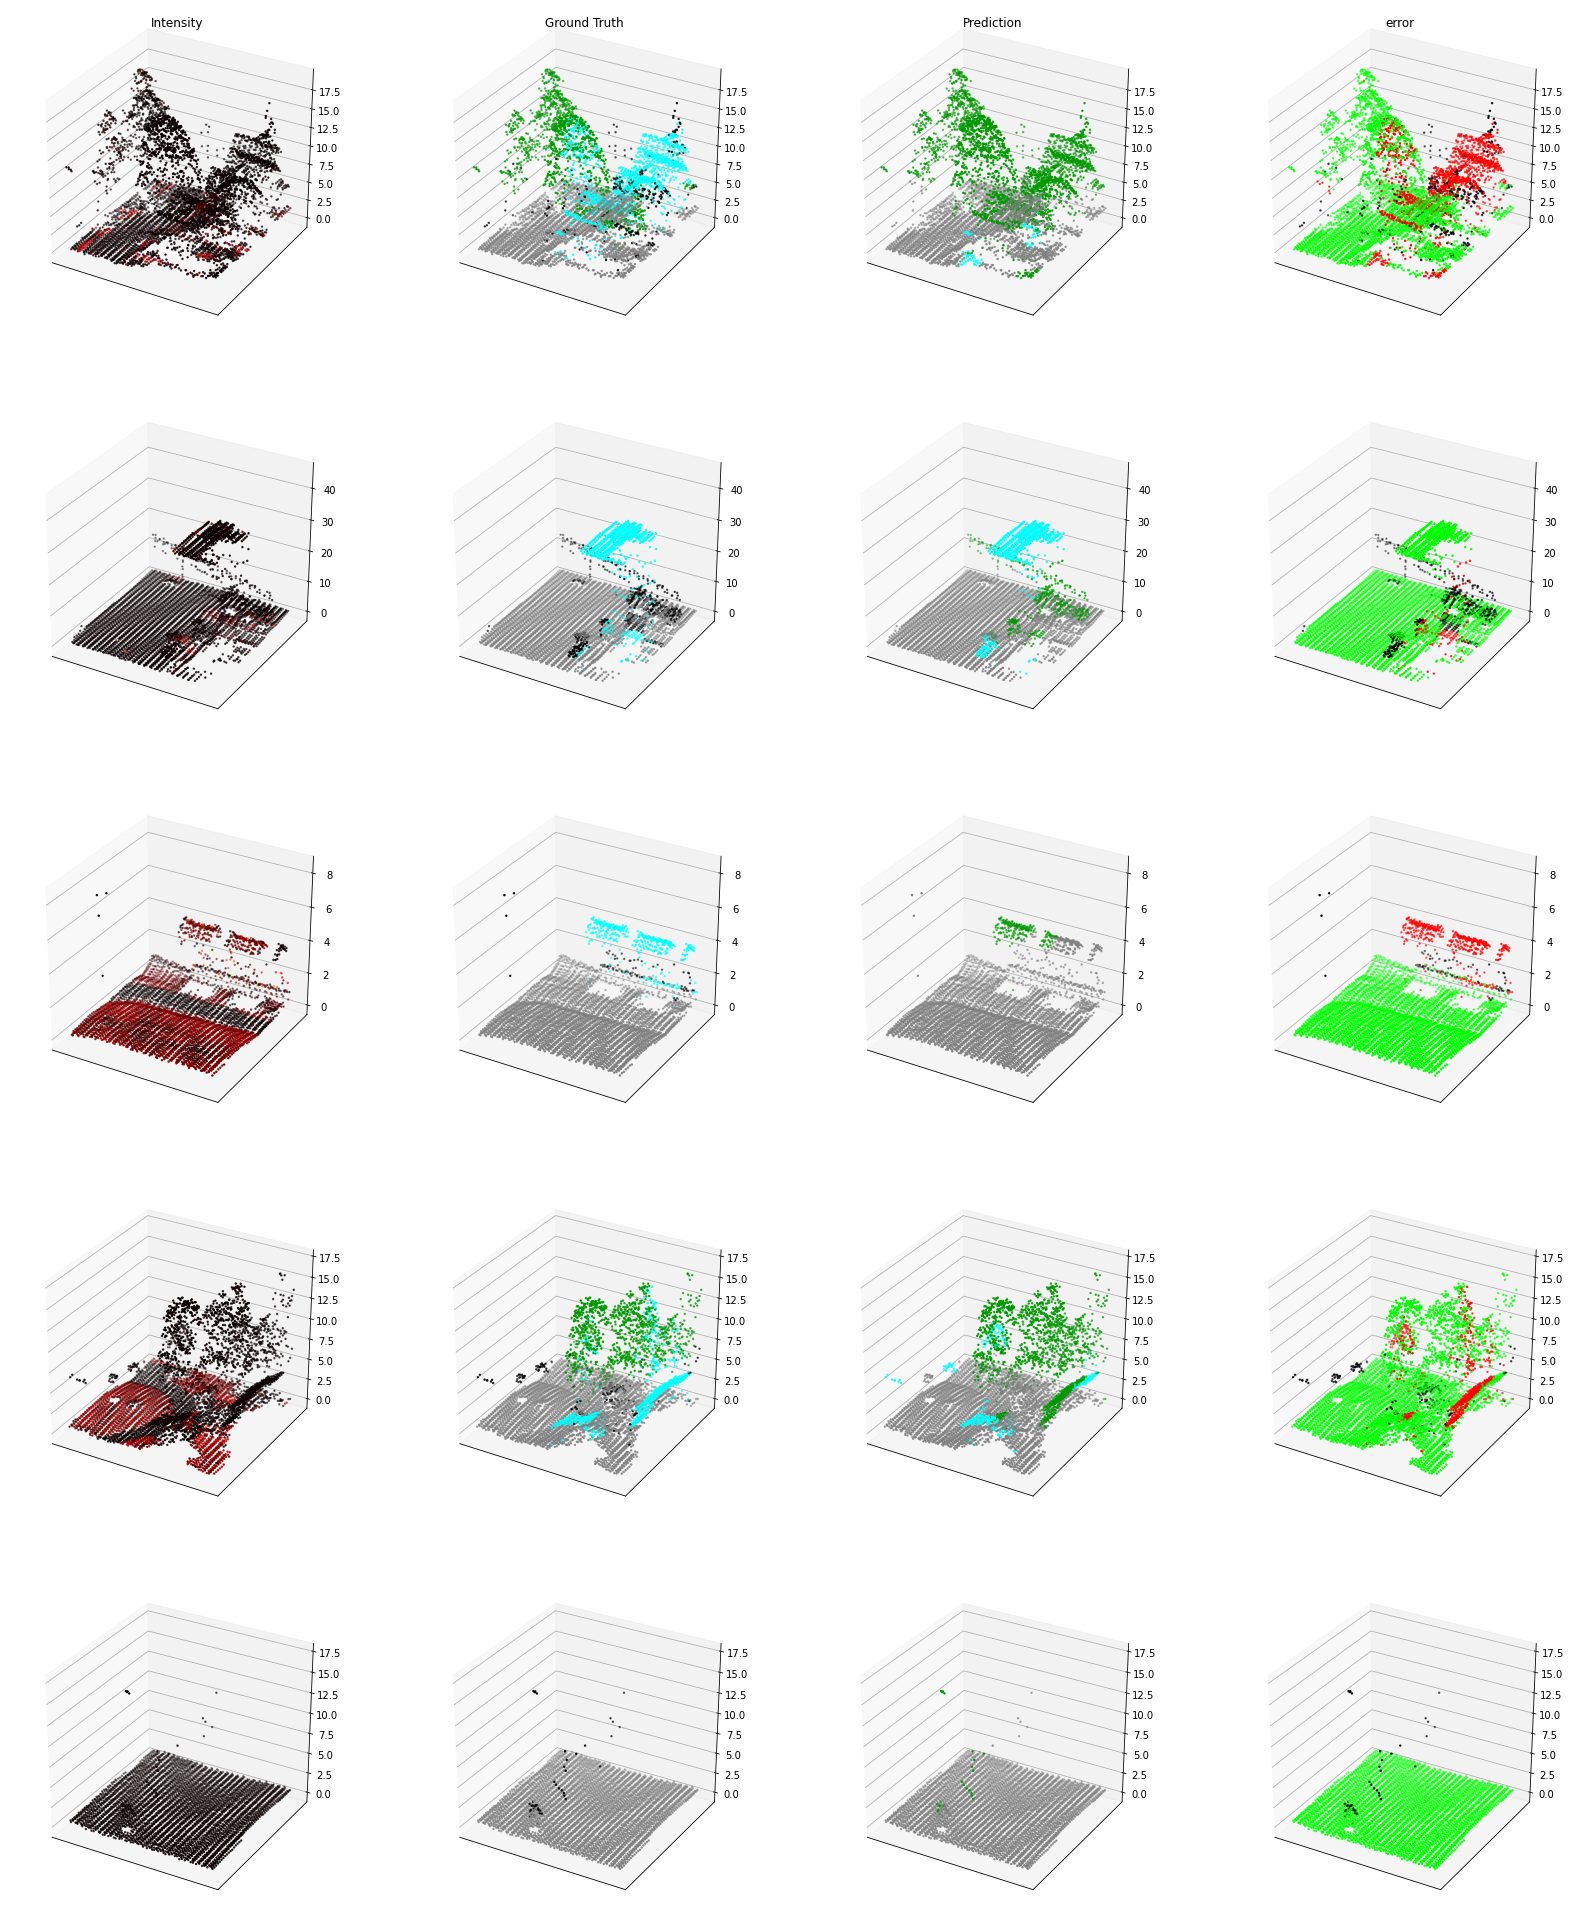

In [ ]:
view_testset(n_shown = 5, category = 'igpe', model = trained_model, PCC = PCC)
  

**Comment on the evolution of the performance on the training set and test set.**

training performance climbs but with diminishing returns. Test performance is extremely unstable. This is due to both overfitting andthe sampling procedure.

**Q11**
large batches and large learning rate: fast convergence to bad local optima
small batches and smalllearning rate: slow convergence to good optima, but very noisy

subsample_size: performance is bad for very small value (not enough points), and then should plateau. However computation times increase with large values.

**Q11** very small effect if any, batchnorms already inject robustness

Interestingly, a drop out value of 1 (drop all the time) reduces the network to always predict the same thing. It of course choses the most commonclass, ground.

**Q13** Should result in a small dip in OA and a small increase in mIoU.

**Q14** Should result in a slower converegnce of the training procedure, but a better value for the test. This make sense because now the problemis much harder since the dataset is virtually infinite in size (wehave added all possible rotations and jitter). Hence the network cannot learn the dataset anymore, and is forced toreason spatially, which is much harder, but should perform better on unseen data.

Here it can be a good idea to add more epochs.

**Q15** This should help a lot if properly implemented (in eval only):
```
for i in range(args.n_votes_eval):
  avg_pred += PCC.run(model, cloud)  
avg_pred = avg_pred / args.n_votes_eval
```

Now a large part of the randomness is removed, and the network performs better (voting scheme).

**Q16** Should help a little bit, allows forlarge learning rate at first (to find a good region), and smal a the end (to find a good minima).

**Q17** Should help a lot as well. You can now run the code for many epochs and not fear that the last epoch will destroy the performance. Make sure that the validation set is not leaked in the training! (see [4])

**Q18** the correct way to search for the right configuration. Should look like this:
```
input = args # a configuration to evaluate
performance = empty #the chosen metric
p = random permutation
size_fold = size_dataset / nfold
for i in range(nfold)
  train = full_dataset[p[i*size_fold: (i+1)*size_fold]]
  test = the rest
  full_train(train, args) #train a configuration config on train
  performance += evaluation(test) 
performance = performance / nfold #average of the performance on the whole dataset with no leakage
return performance
```


**Q19**
add a small pointnet which outputs a vector x of size 4:


In [ ]:
def forward(self, input):
    """
    the forward function producing the embeddings for each point of 'input'
    input = [n_batch, input_feat, subsample_size] float array: input features
    output = [n_batch,n_class, subsample_size] float array: point class logits
    """
    #embed points, equation (1)
    embed = self.MLP_1(input) 
    #process embeddings and maxpool, equation (2) and (3)
    global_embed = self.maxpool(self.MLP_2(embed))
    #concatenate f1 and G and perform equation(4)
    class_scores = self.MLP_3(torch.cat((global_embed.repeat(1,1,self.subsample_size), embed),1))
    #avoid wasting by not using intermediary variables
    return class_scores


In [ ]:
class PointNet_STN(nn.Module):
  """
  The PointNet network for semantic segmentation + spatial transform
  """
  
  def __init__(self, MLP_1, MLP_2, MLP_3, MLP_1_stn, MLP_2_stn, n_class = 3, input_feat=4, subsample_size = 512, cuda = 1):
    """
    initialization function
    MLP_1, MLP2 and MLP3 = int array, size of the the layers of the the MLPs
    MLP_1_stn, MLP_stn = int array, size of the the layers of the the MLPs of the STN
    n_class = int,  the number of class
    input_feat = int, number of input feature
    subsample_size = int, number of points to which the tiles are subsampled
    
    """
    
    super(PointNet_STN, self).__init__() #necessary for all classes extending the module class
    
    self.subsample_size = subsample_size
    
    m1 = MLP_1[-1] #size of the first embeding F1
    m2 = MLP_2[-1] #size of the second embeding F2
    
    modules = []
    for i in range(len(MLP_1)):
      modules.append(nn.Conv1d(MLP_1[i-1] if i>0 else input_feat, MLP_1[i], 1))
      modules.append(nn.BatchNorm1d(MLP_1[i]))
      modules.append(nn.ReLU(True))
    self.MLP_1 = nn.Sequential(*modules)

    modules = []
    for i in range(len(MLP_2)):
      modules.append(nn.Conv1d(MLP_2[i-1] if i>0 else m1, MLP_2[i], 1))
      modules.append(nn.BatchNorm1d(MLP_2[i]))
      modules.append(nn.ReLU(True))
    self.MLP_2 = nn.Sequential(*modules)

    modules = []
    for i in range(len(MLP_3)):
      modules.append(nn.Conv1d(MLP_3[i-1] if i>0 else m1 + m2, MLP_3[i], 1))
      modules.append(nn.BatchNorm1d(MLP_3[i]))
      modules.append(nn.ReLU(True))
      
    modules.append(nn.Dropout(0.3))
    modules.append(nn.Conv1d(MLP_3[-1], n_class,1))
    self.MLP_3 = nn.Sequential(*modules)
    
    self.maxpool = nn.MaxPool1d(subsample_size)

    m1_stn = MLP_1_stn[-1] #size of the first embeding F1
    
    modules = []
    for i in range(len(MLP_1_stn)):
      modules.append(nn.Conv1d(MLP_1_stn[i-1] if i>0 else input_feat, MLP_1_stn[i], 1))
      modules.append(nn.BatchNorm1d(MLP_1_stn[i]))
      modules.append(nn.ReLU(True))
    self.MLP_1_stn = nn.Sequential(*modules)

    modules = []
    MLP_2_stn = MLP_2_stn + [4]
    k = len(MLP_2_stn)
    for i in range(k-1):
      modules.append(nn.Conv1d(MLP_2_stn[i-1] if i>0 else m1_stn, MLP_2_stn[i], 1))
      modules.append(nn.ReLU(True))
    modules.append(nn.Conv1d(MLP_2_stn[k-2], MLP_2_stn[k-1], 1))
    self.MLP_2_stn = nn.Sequential(*modules)

    self.eye = torch.eye(2) #identity matrix - by default the stn doesn't change the input
    
    if cuda:
      self = self.cuda()
      self.eye = self.eye.cuda()
    
  def forward(self, input):
    """
    the forward function producing the embeddings for each point of 'input'
    input = [n_batch, input_feat, subsample_size] float array: input features
    output = [n_batch,n_class, subsample_size] float array: point class logits
    """
    transform = self.MLP_2_stn(self.maxpool(self.MLP_1_stn(input)))
    transform = self.eye + transform.view(2,2) #the transform  matrix + Id
    #we apply the learned transform to inputs
    input = torch.matmul(input[:,:2,:].transpose(1,2), transform[None,:,:]).transpose(1,2) 

    #embed points, equation (1)
    embed = self.MLP_1(input) 
    #process embeddings and maxpool, equation (2) and (3)
    global_embed = self.maxpool(self.MLP_2(embed))
    #concatenate f1 and G and perform equation(4)
    class_scores = self.MLP_3(torch.cat((global_embed.repeat(1,1,self.subsample_size), embed),1))
    #avoid wasting by not using intermediary variables
    return class_scores

#==================TEST===============================
#we consider the first point cloud from the training set
cloud_data, gt = cloud_loader(train_list[0], 1, cuda = 1)
#to create a proper input for the pointnet we need to we add one empty dimension
#for the batch size (with keyword None), and subsample the point cloud to have
#subsample_size = 512 points
cloud_data = cloud_data[None,:,:512]
#we now create a pointnet model:
ptn = PointNet_STN([32,32], [32,64,256], [128,64,32], [32,64], [64,16], n_class = 3, input_feat=4, subsample_size = 512)
print(ptn)
#we now test that the code works correctly
pred = ptn.forward(cloud_data)
#we now check that the size is indeed [n_batch,n_class, subsample_size]
assert(pred.shape == torch.Size([1,3,512]))

PointNet_STN(
  (MLP_1): Sequential(
    (0): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (MLP_2): Sequential(
    (0): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (MLP_3): Sequential(
    (0): Conv1d(288, 128, kernel_size=(1,), stri

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


RuntimeError: ignored